# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   
         3.0    0.235487        0.113697  0.054401  0.196026  0.220231   
         4.0    0.215716        0.086401  0.035714  0.192050  0.248849   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898  
         3.0   0.247211  0.003811  0.031346  0.049192  0.009499  
         4.0   0.287262  0.004502  0.029509  0.047445  0.013083

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   
         3.0   6.552225e+06  5.877726e+06  644465.987031  4.213751e+06   
         4.0   6.617553e+06  6.086991e+06  674784.517390  4.412428e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
         3.0   1.295555e+06  7.983898e+06  4.148877e+06  1.085557e+06   
         4.0   1.348773e+06  8.458683e+06  4.205790e+06  1.124709e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         1.0      398139.231561  
         2.0      494315.467226  
         3.0      537605.057823  
         4.0      562223.555107

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


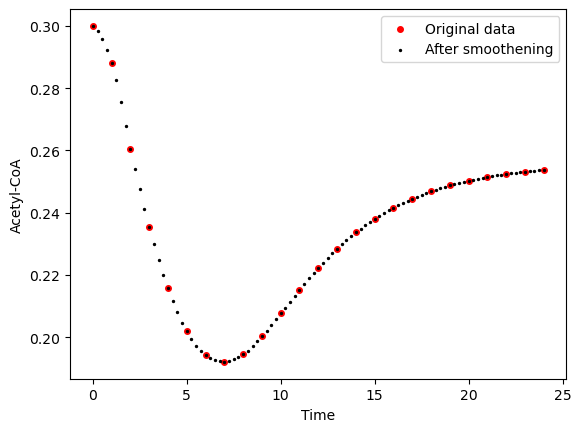

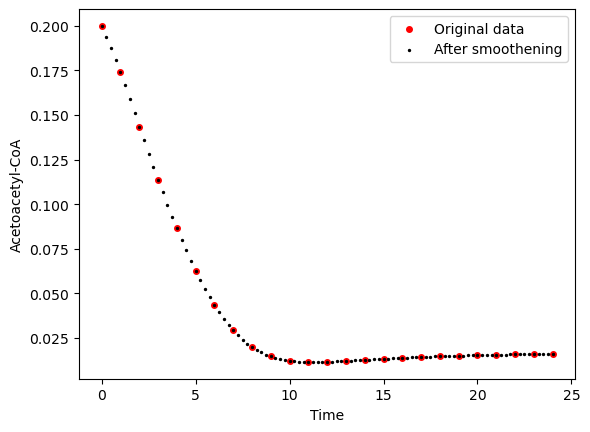

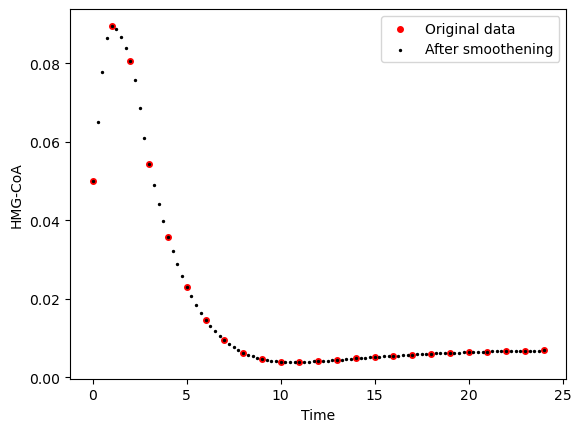

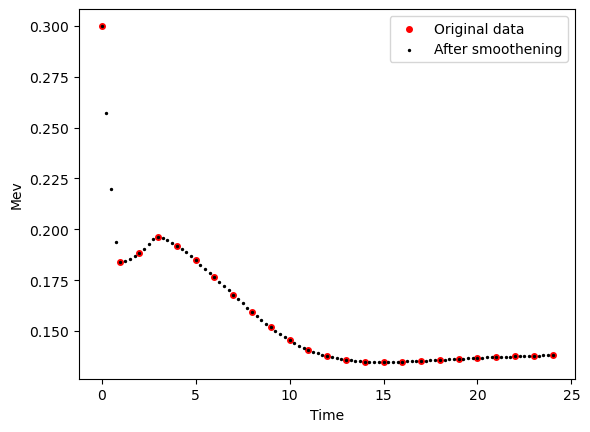

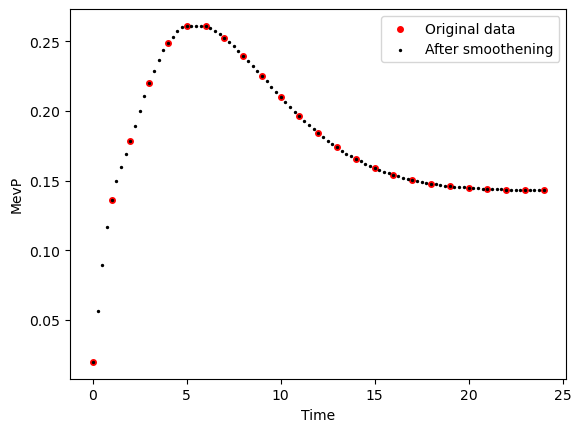

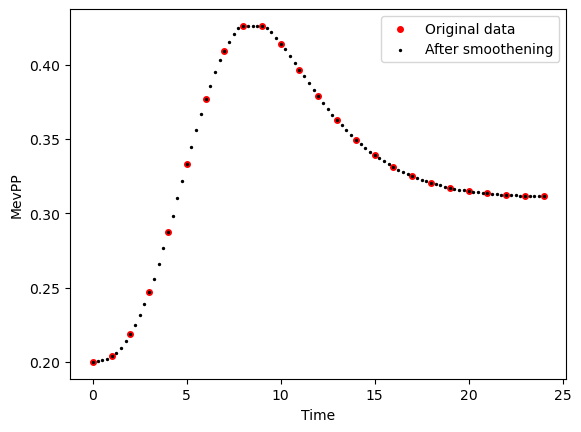

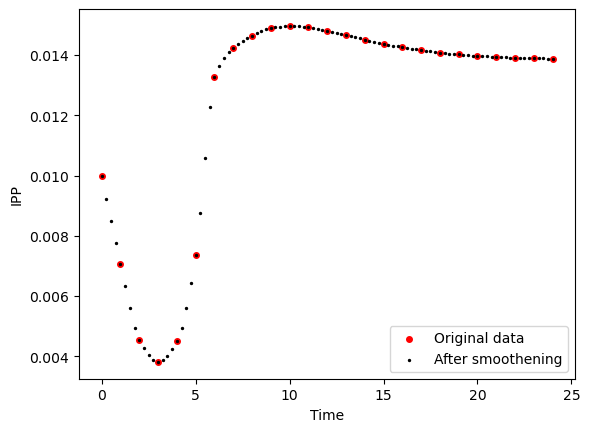

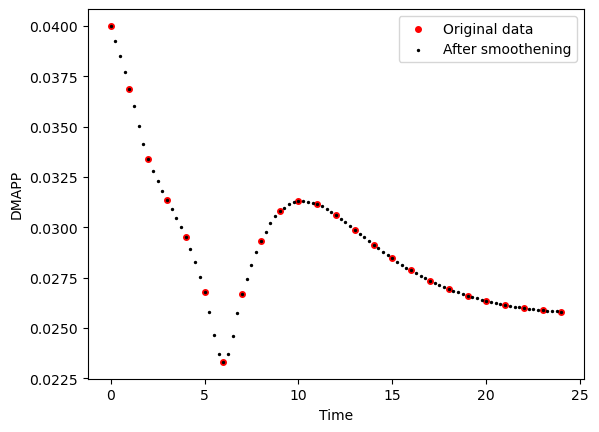

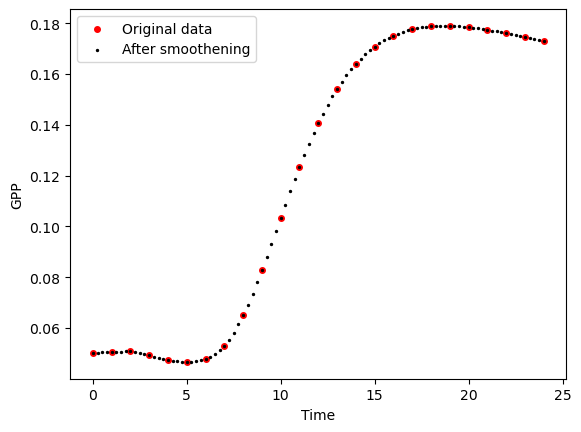

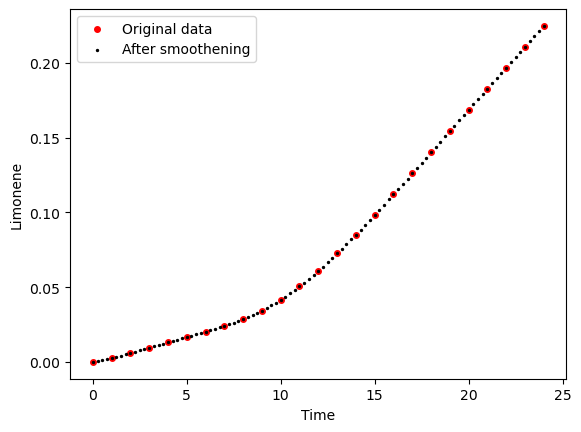

Strain Strain 2


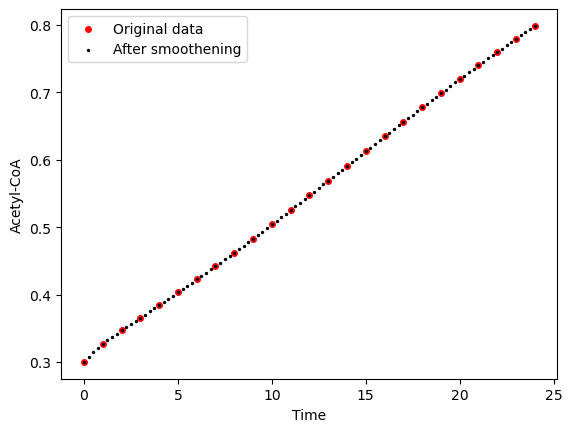

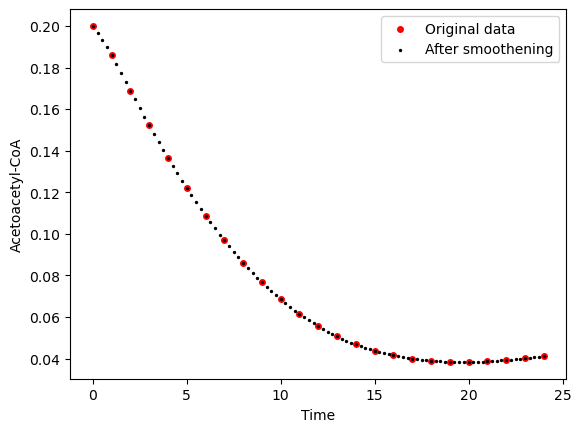

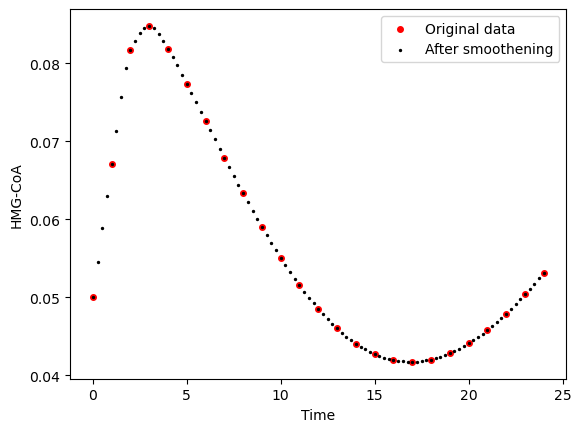

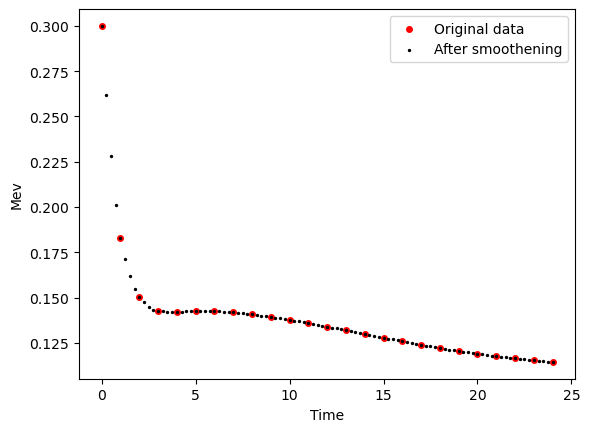

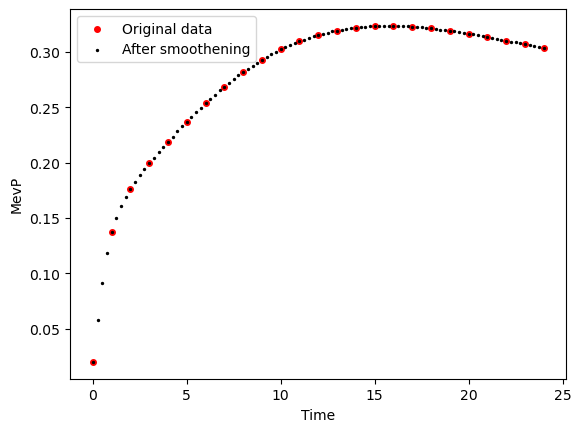

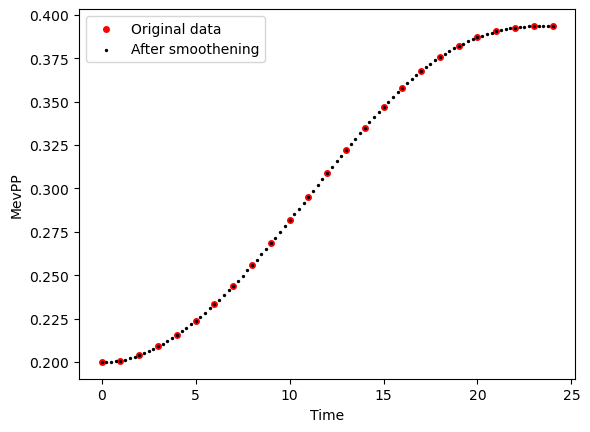

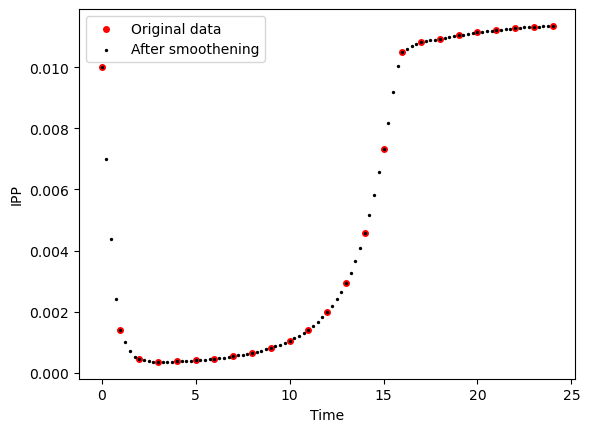

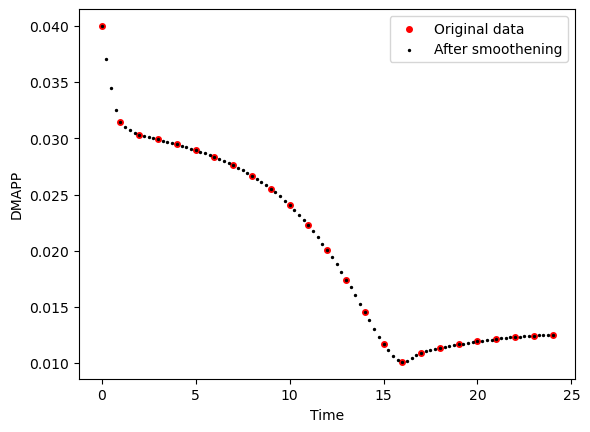

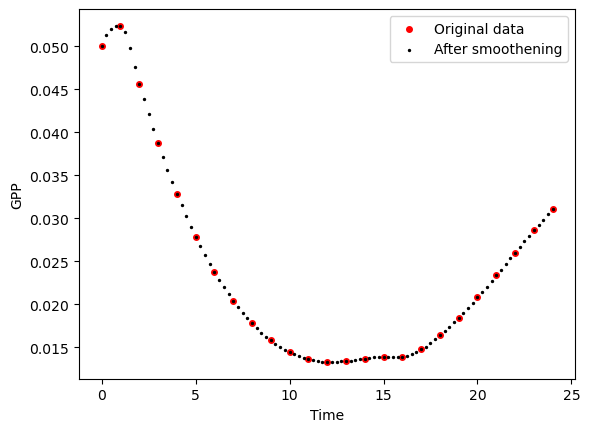

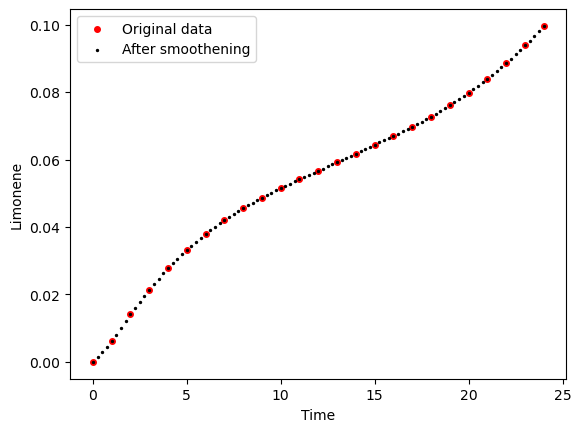

Strain Strain 3


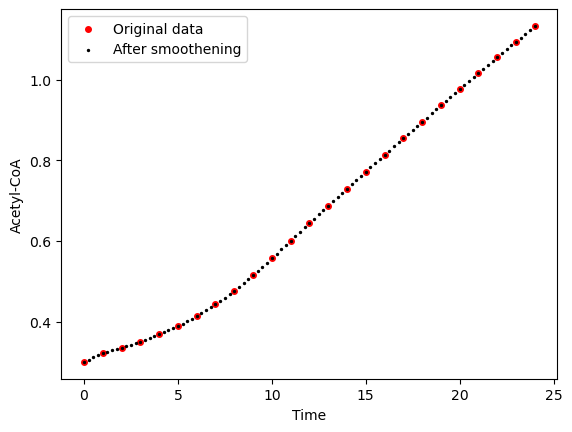

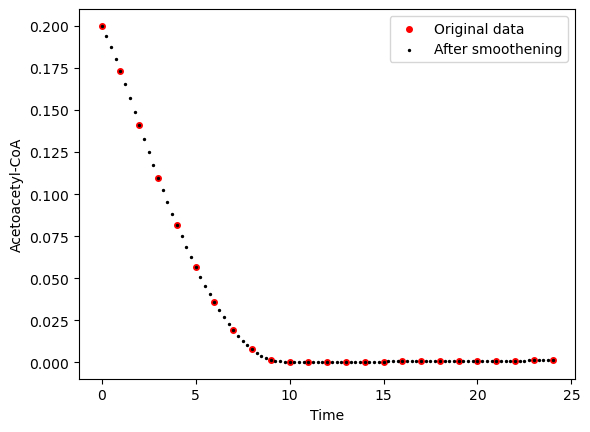

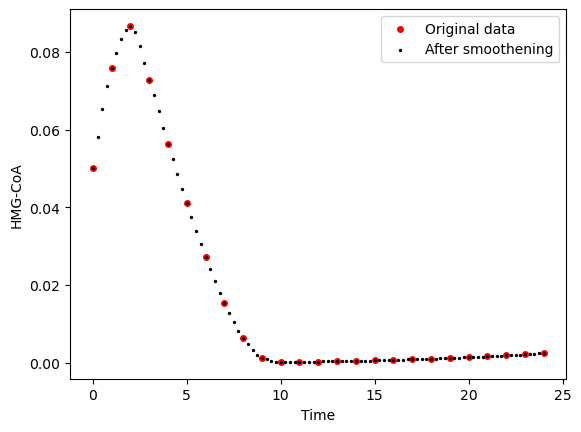

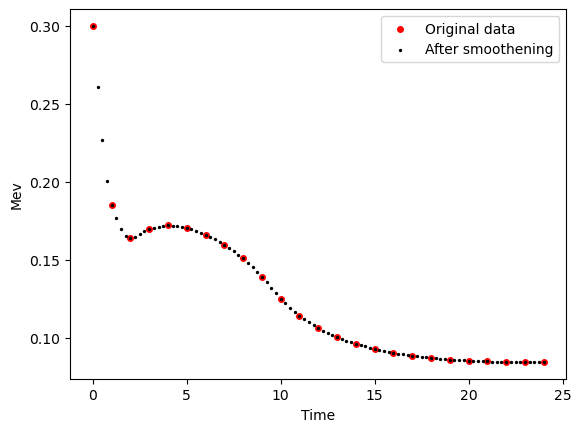

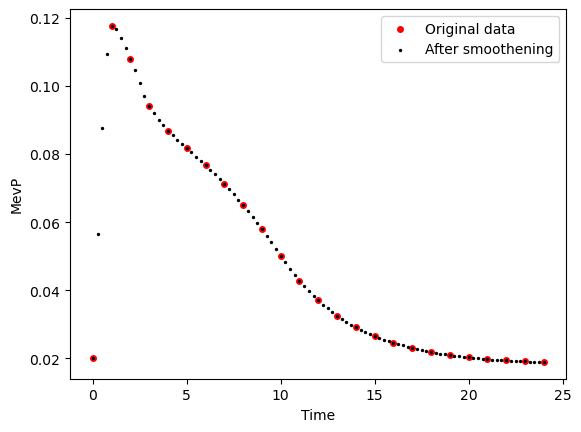

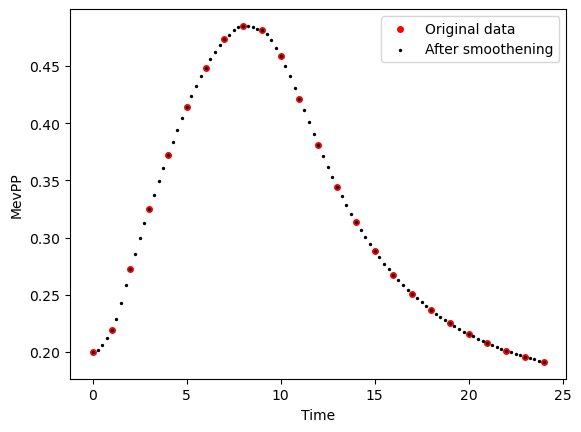

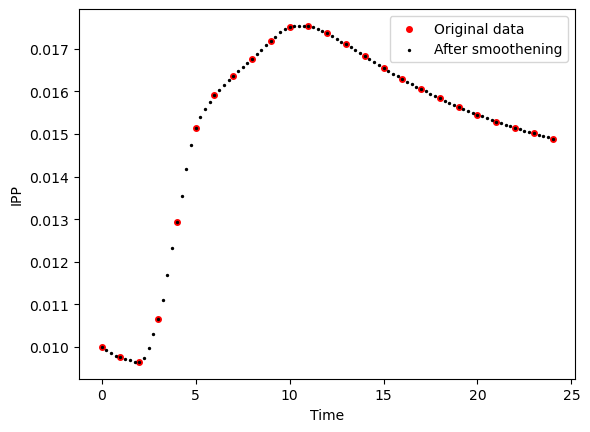

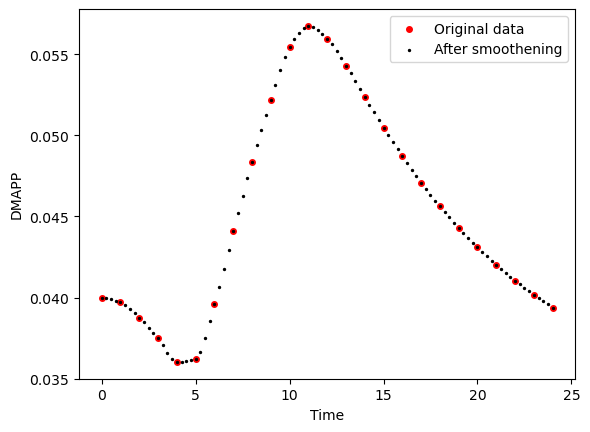

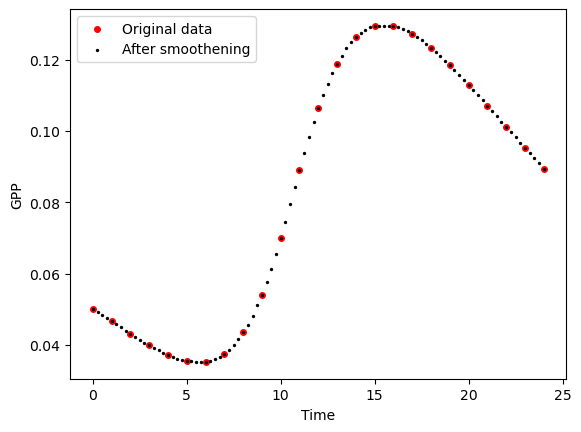

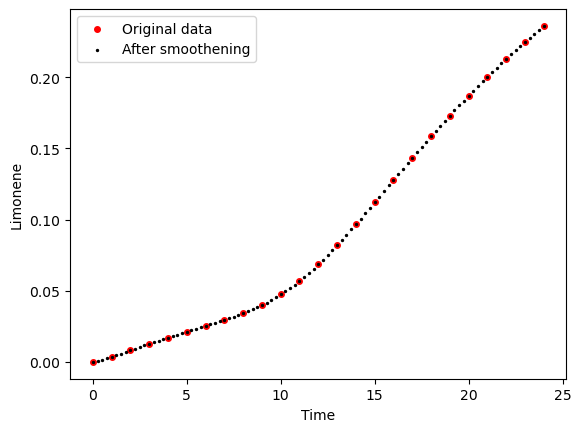

Strain WT


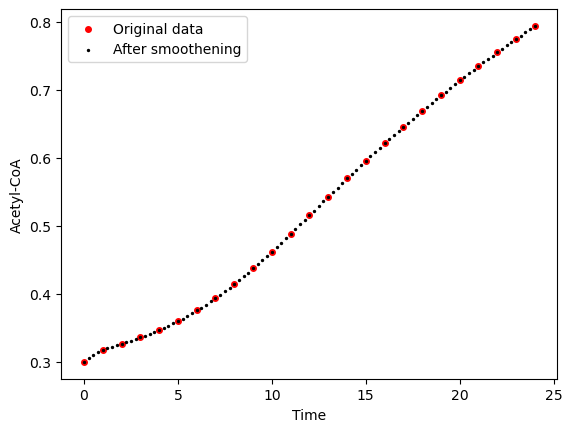

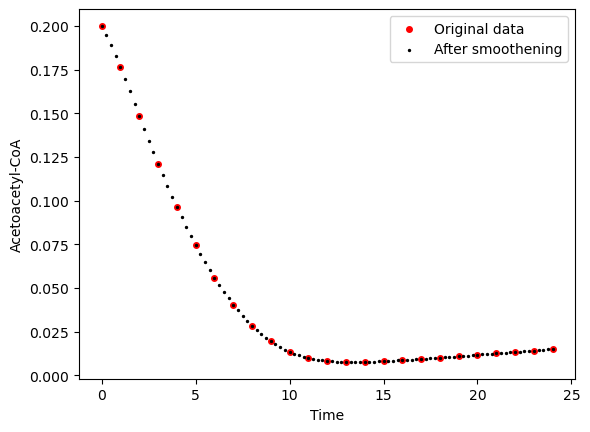

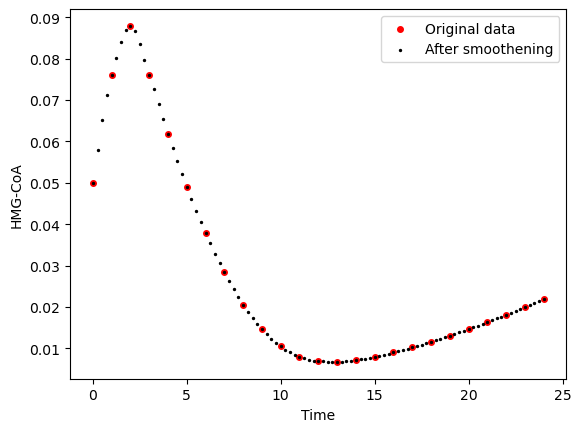

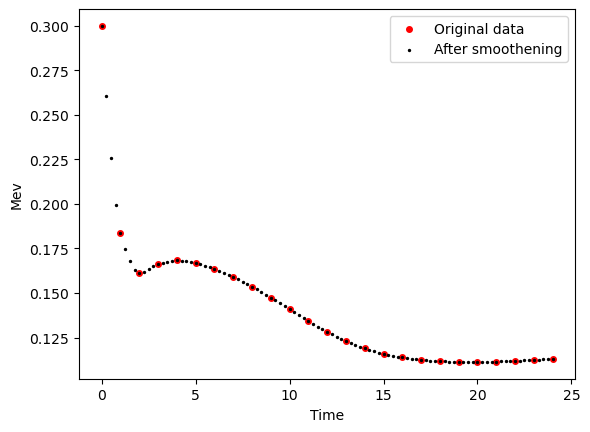

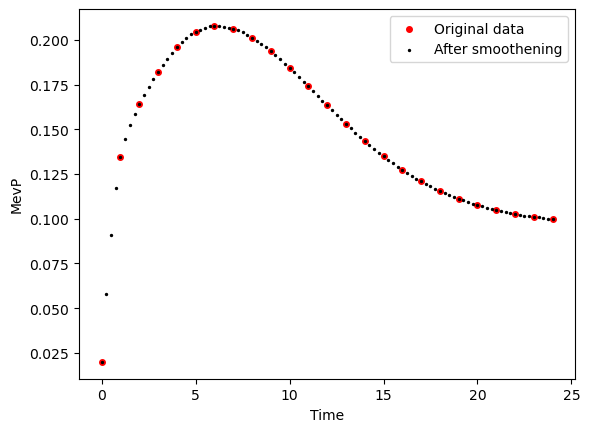

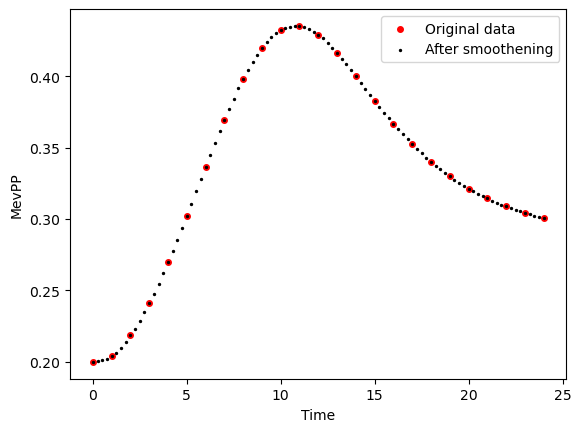

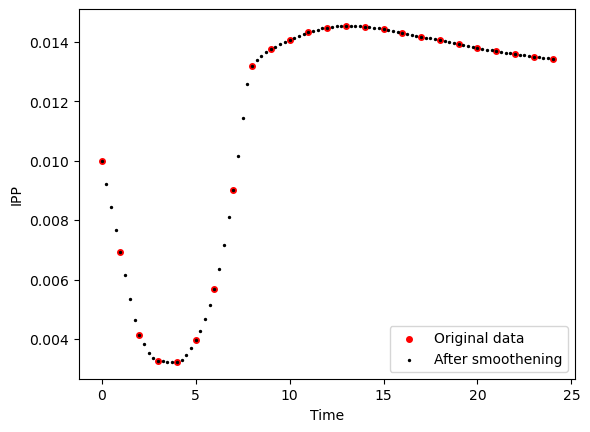

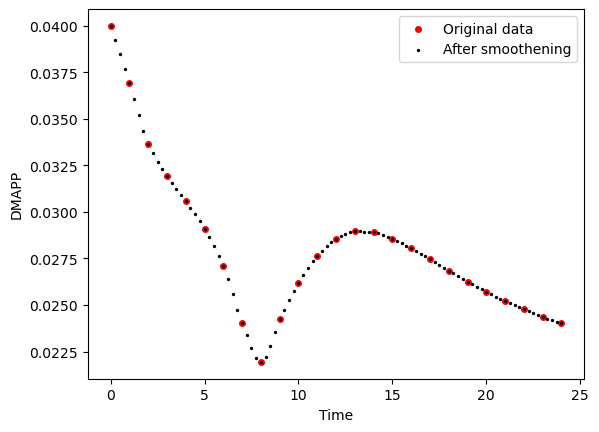

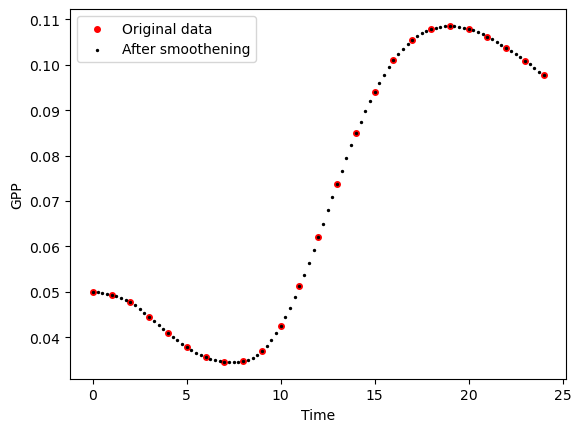

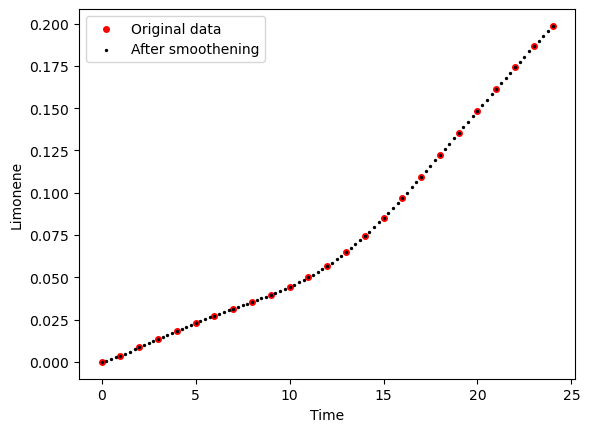

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


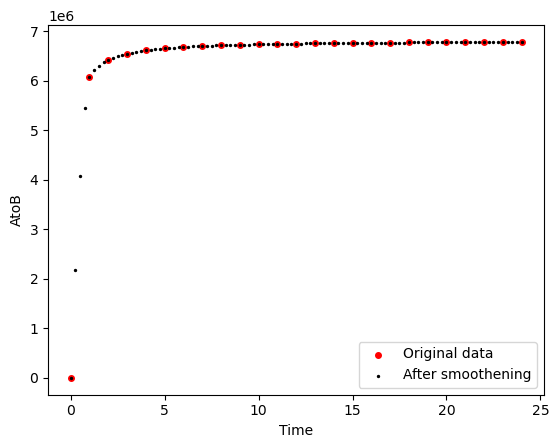

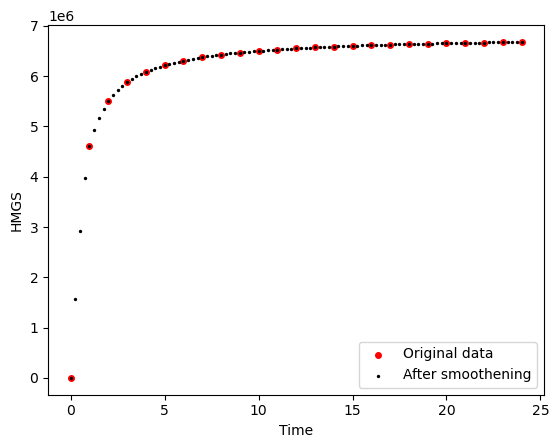

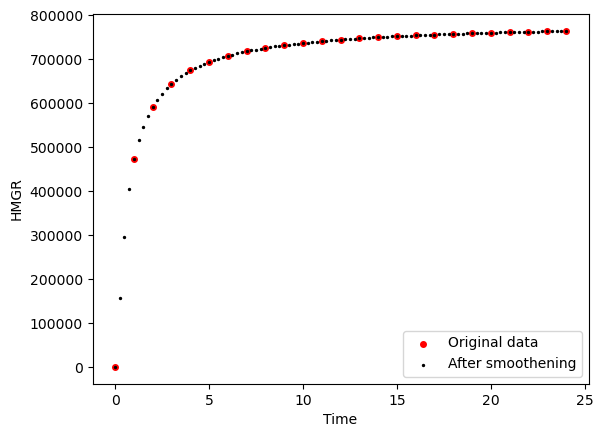

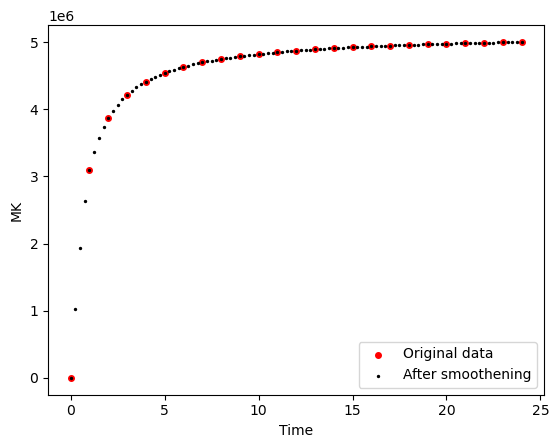

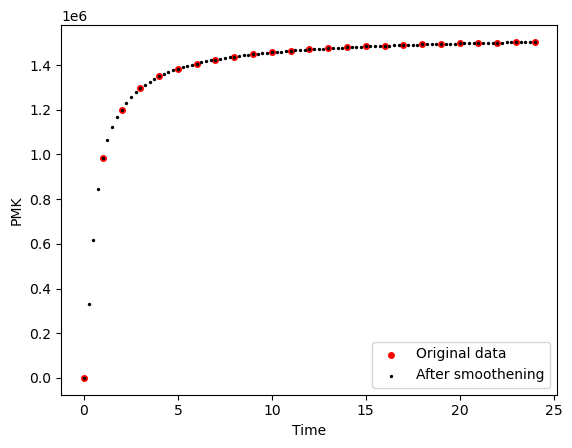

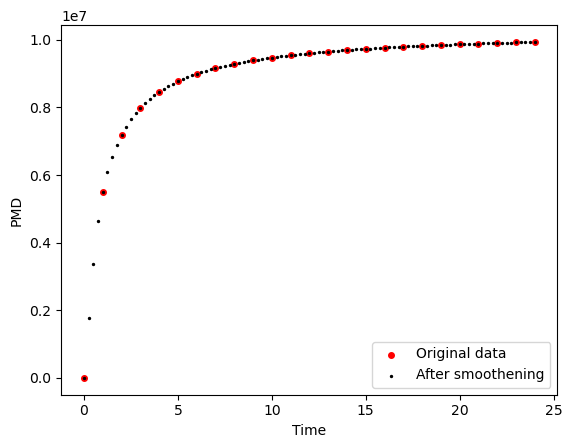

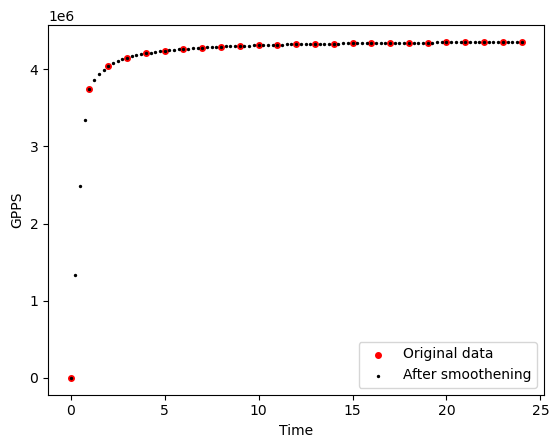

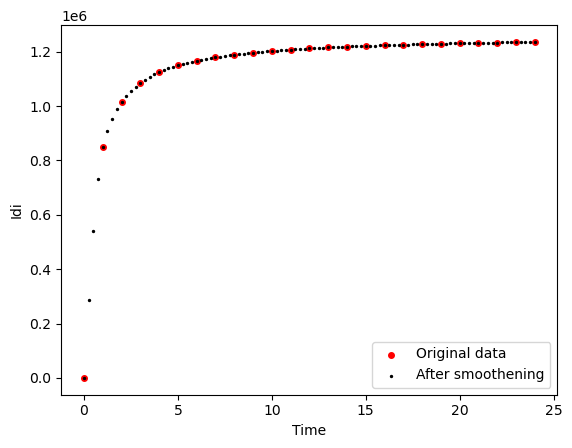

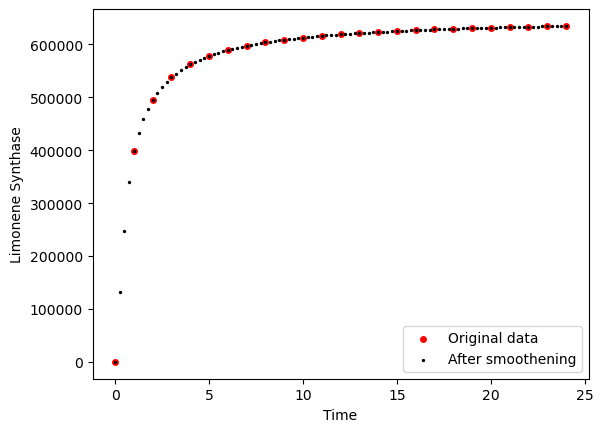

Strain Strain 2


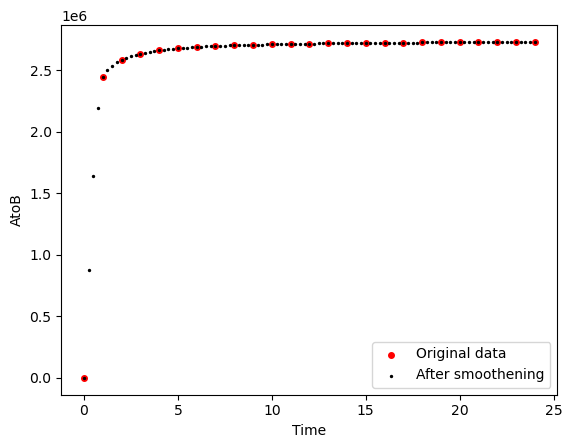

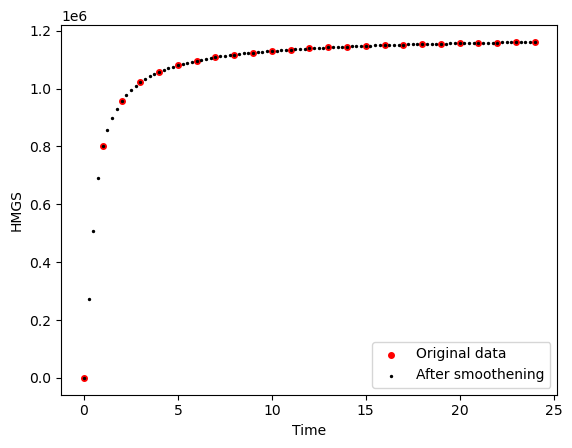

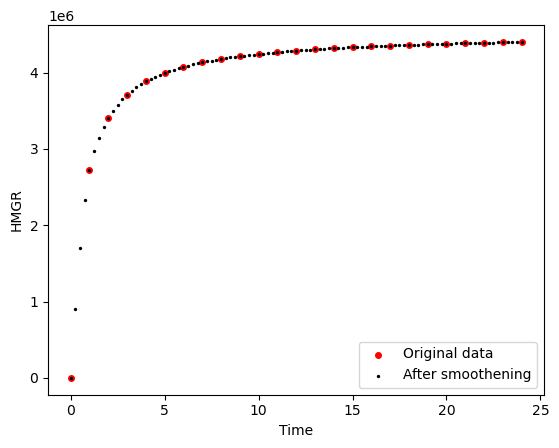

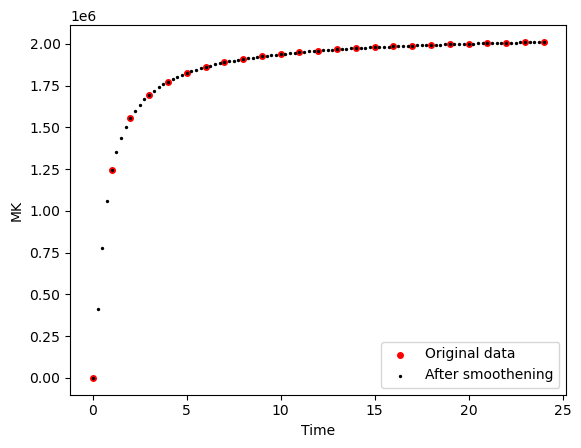

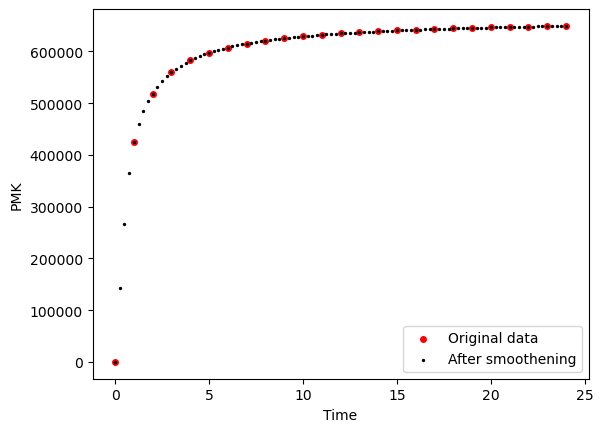

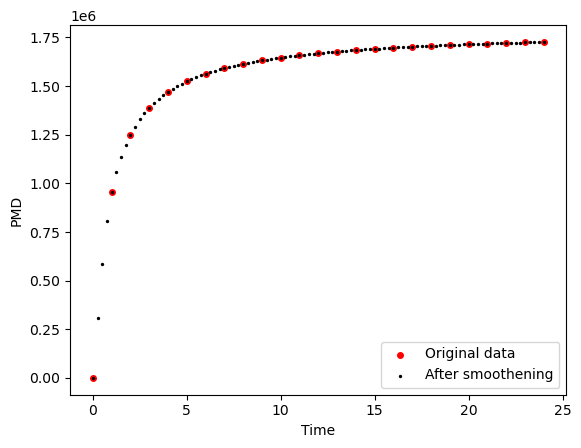

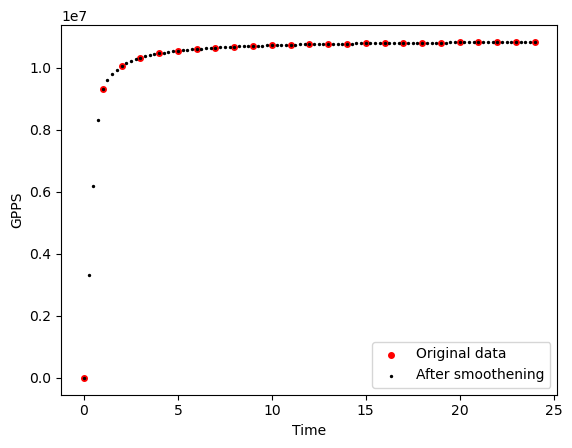

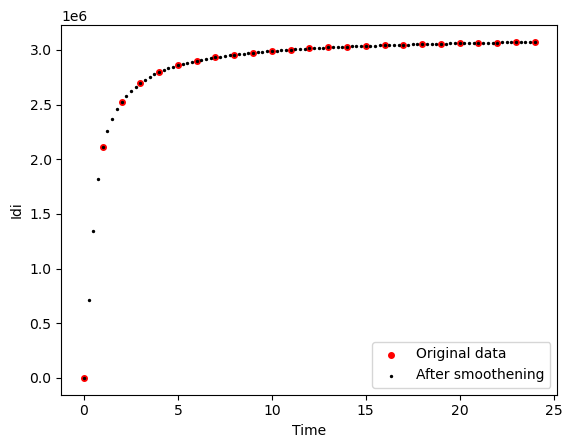

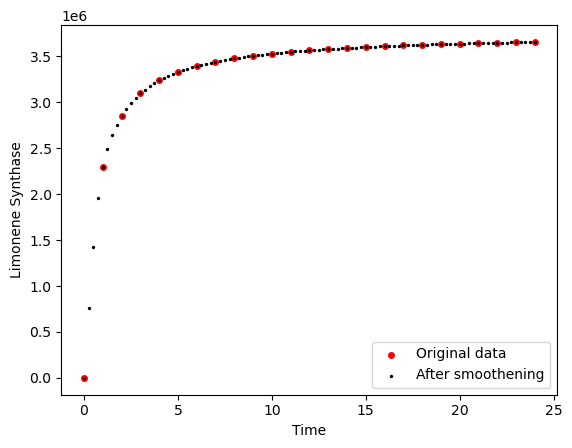

Strain Strain 3


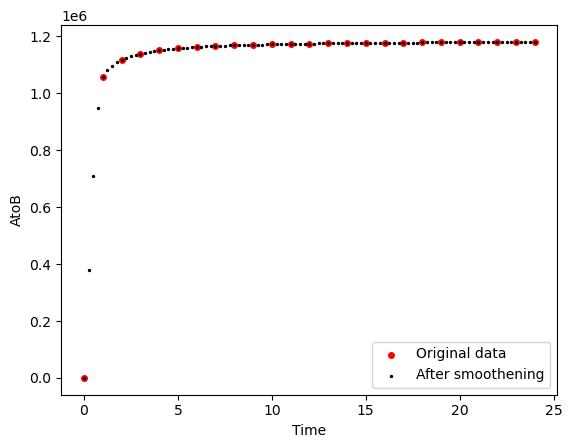

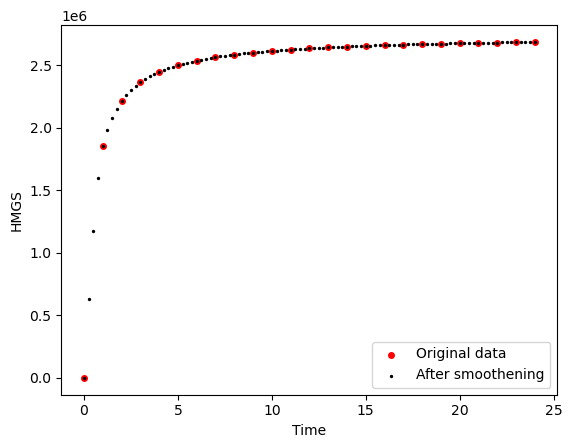

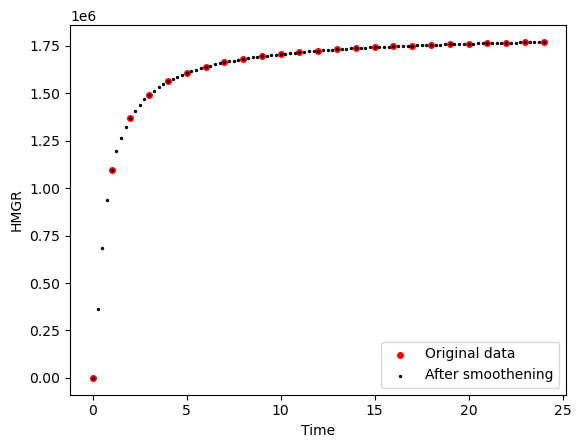

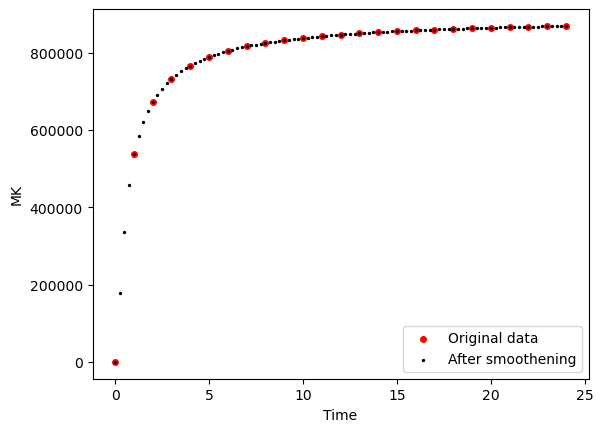

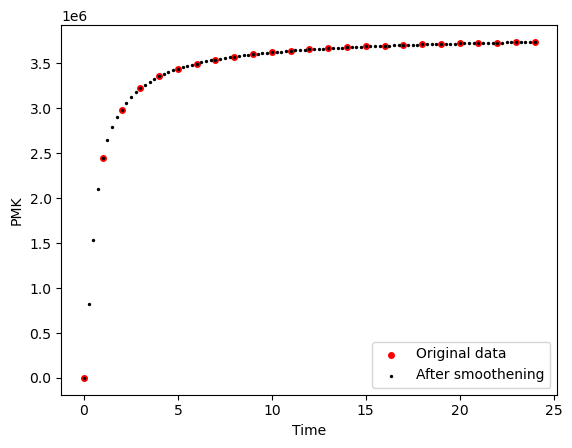

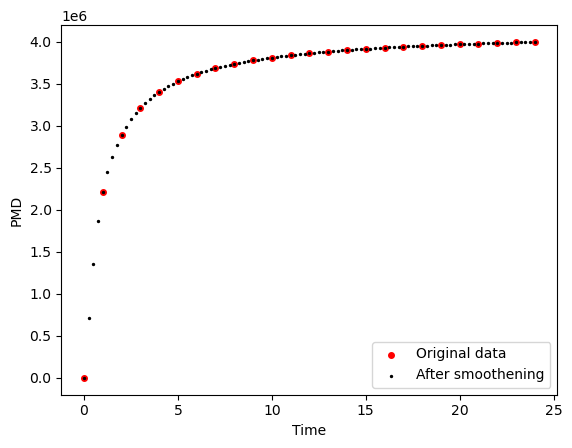

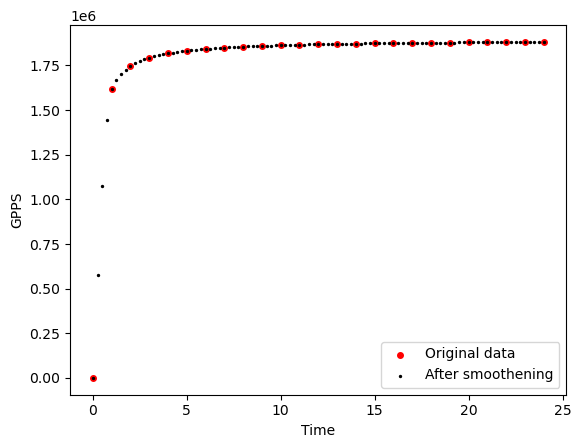

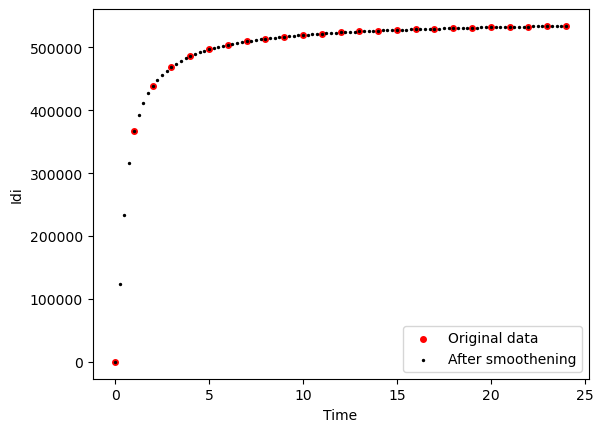

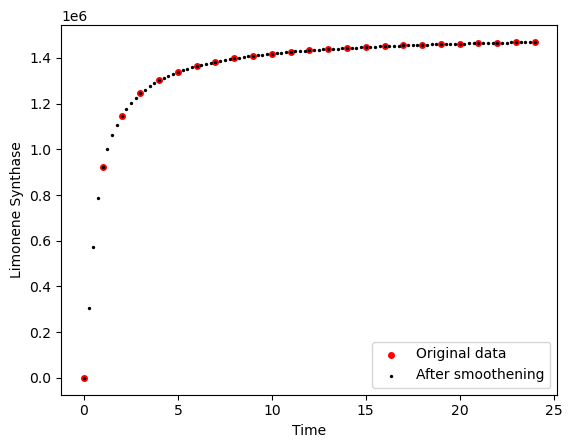

Strain WT


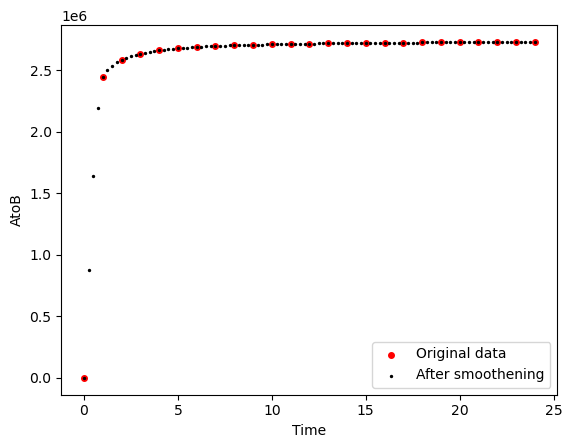

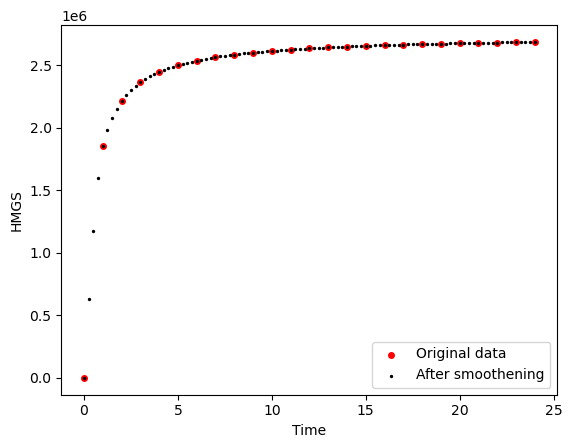

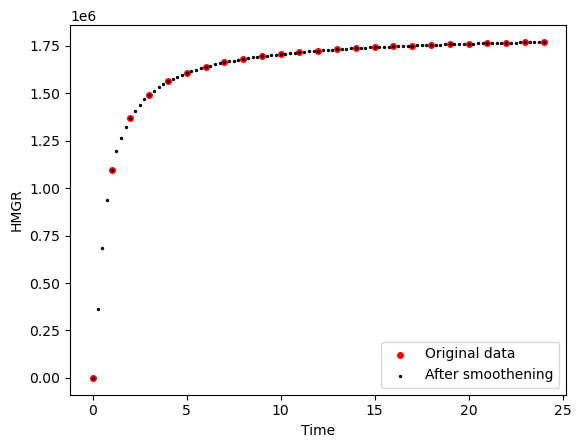

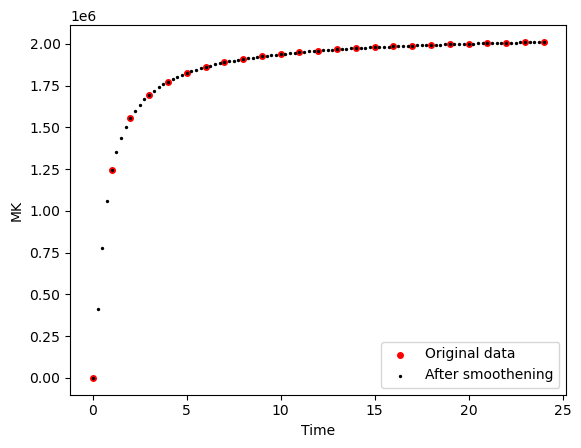

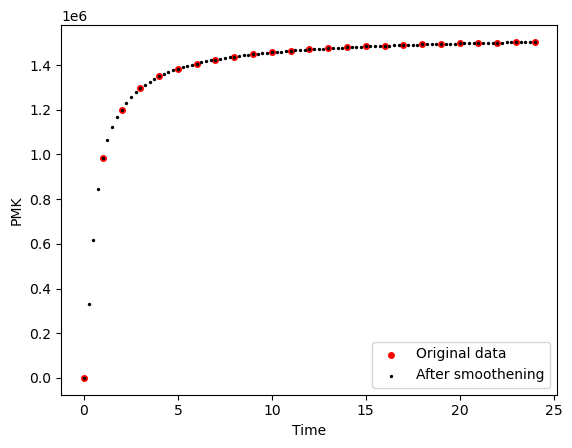

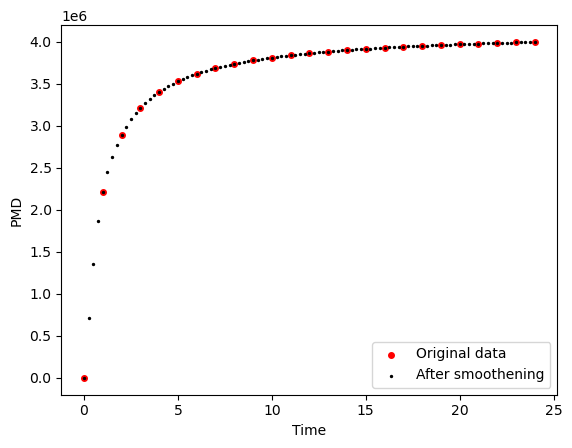

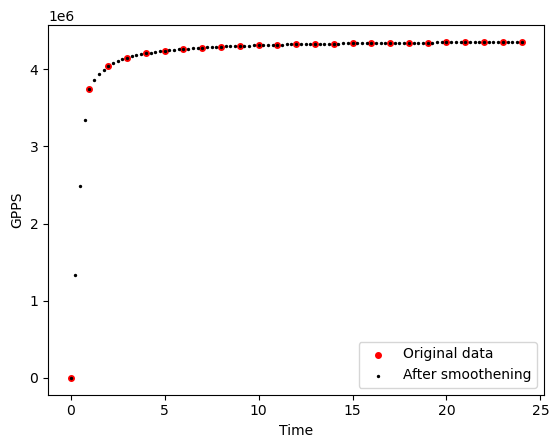

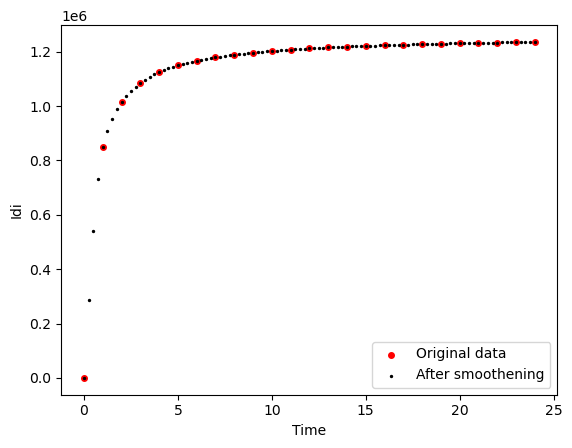

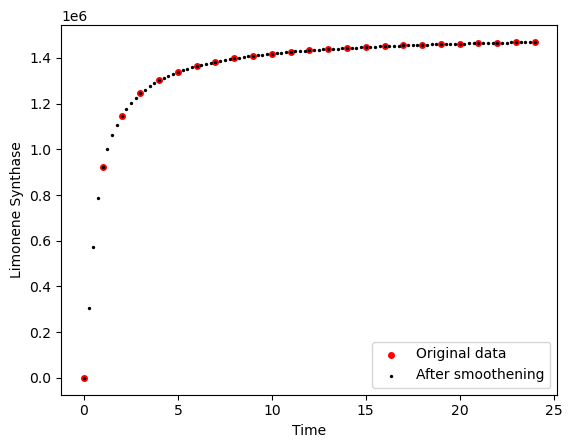

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.298383        0.193946  0.065149  0.257084  0.056859   
         0.50    0.295677        0.187596  0.077750  0.219963  0.089623   
         0.75    0.292180        0.180967  0.086366  0.193859  0.116665   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112529  0.100703   
         23.50   0.784585        0.014581  0.020885  0.112673  0.100406   
         23.75   0.789291        0.014788  0.021362  0.112824  0.100136   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200300  0.009225  0.039259  0.050238  0.000531  ...   
         0.50   0.201111  0.008475  0.038493  0.050445  0.001124  ...   
         0.75   0.202294  0.007751  0.037703  0.050600  0.001772  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303342  0.013479  0.024269  0.100097  0.189617  ...   
         23.50  0.302439  0.013460  0.024180  0.099307  0.192637  ...   
         23.75  0.301595  0.013442  0.024094  0.098498  0.195634  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.006814       -0.023908  0.073868 -0.213743  0.163982   
         0.25    -0.008651       -0.024790  0.056084 -0.162081  0.140030   
         0.50    -0.011368       -0.025838  0.039185 -0.114301  0.116330   
         0.75    -0.014965       -0.027051  0.023170 -0.070403  0.092879   
         1.00    -0.019338       -0.028498  0.005273 -0.020786  0.066037   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001866  0.000550 -0.001346   
         23.25    0.019092        0.000828  0.001882  0.000568 -0.001235   
         23.50    0.018915        0.000828  0.001899  0.000588 -0.001124   
         23.75    0.018738        0.000829  0.001916  0.000611 -0.001019   
         24.00    0.018561        0.000829  0.001933  0.000635 -0.000918   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002041 -0.003236 -0.002991  0.001146  0.002070  
         0.25   0.002194 -0.003041 -0.003005  0.000899  0.002246  
         0.50   0.003219 -0.002910 -0.003078  0.000670  0.002453  
         0.75   0.005114 -0.002844 -0.003212  0.000460  0.002690  
         1.00   0.007662 -0.002883 -0.003442  0.000227  0.002961  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003945 -0.000080 -0.000373 -0.003059  0.012217  
         23.25 -0.003713 -0.000078 -0.000361 -0.003121  0.012124  
         23.50 -0.003479 -0.000075 -0.000349 -0.003193  0.012032  
         23.75 -0.003251 -0.000072 -0.000337 -0.003272  0.011943  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

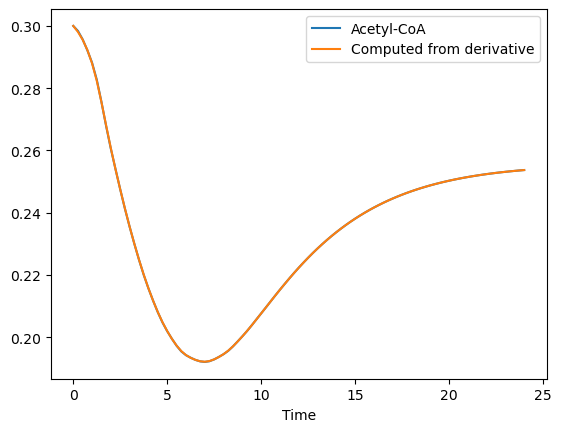

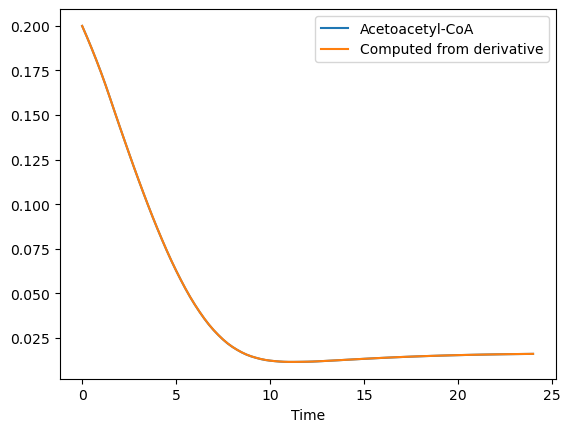

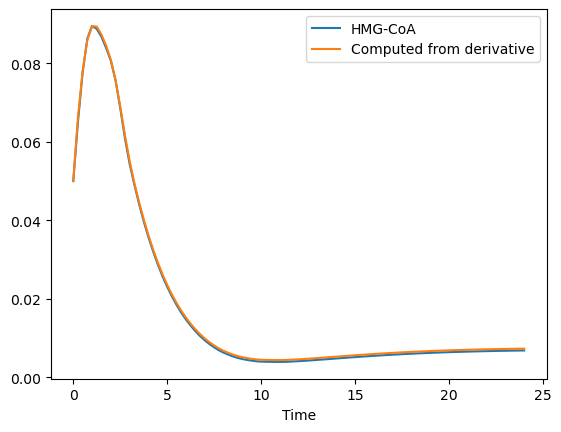

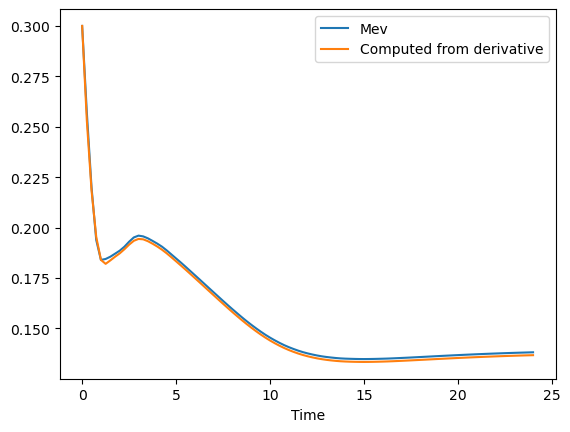

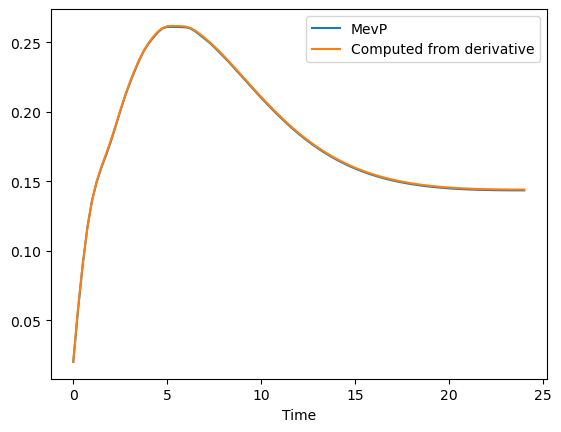

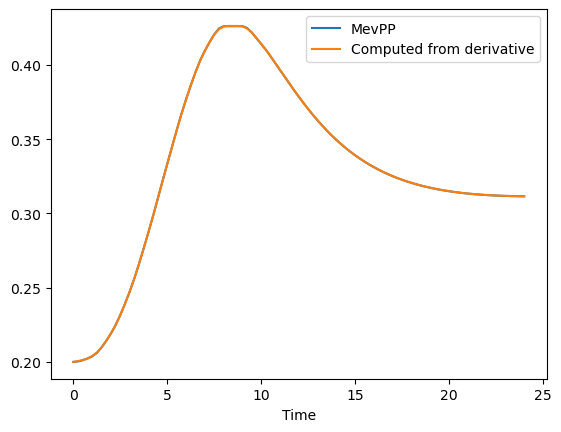

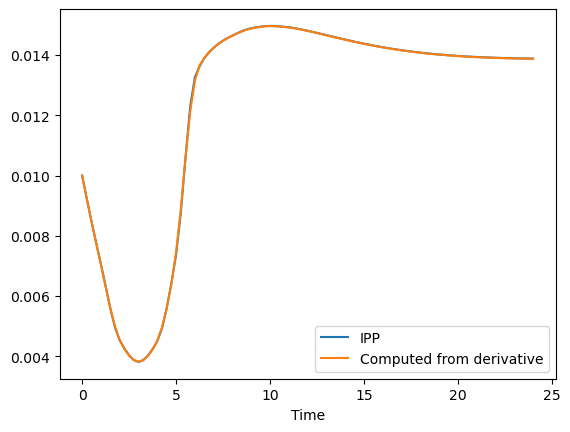

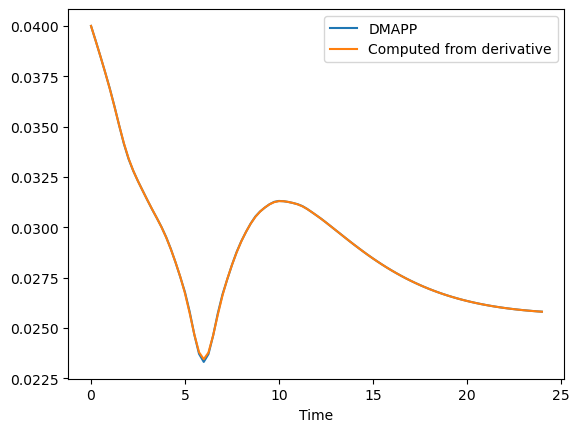

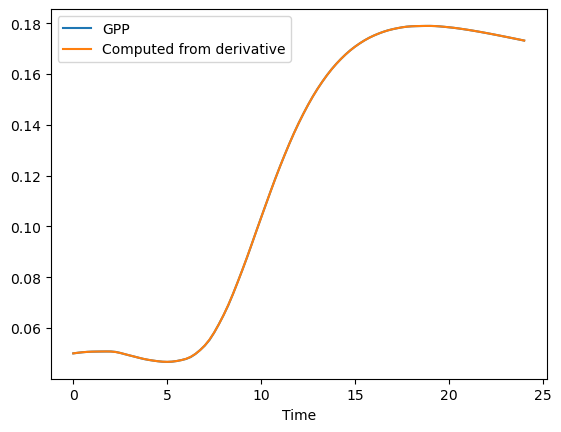

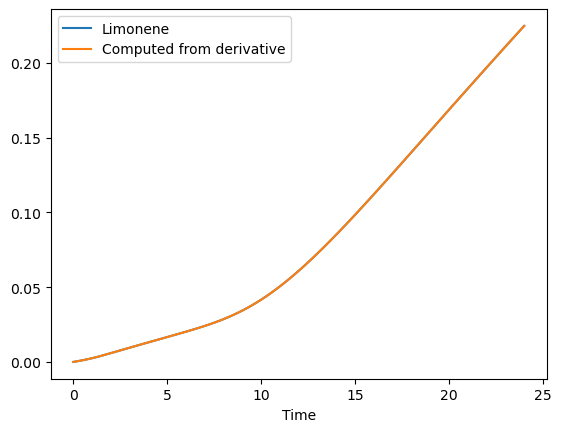

'Time profile from derivative vs. actual profile for Strain 2'

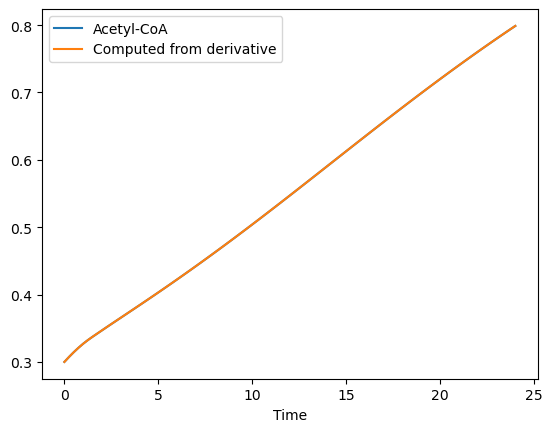

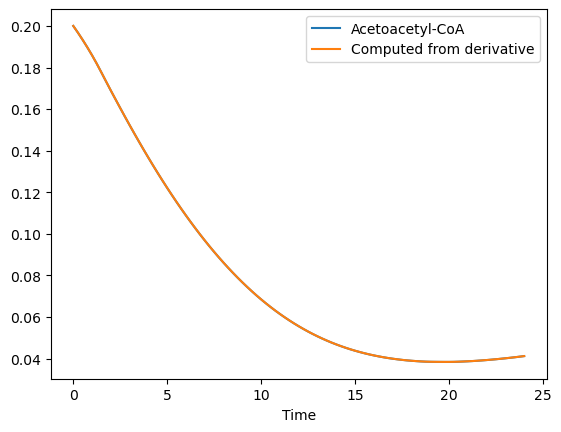

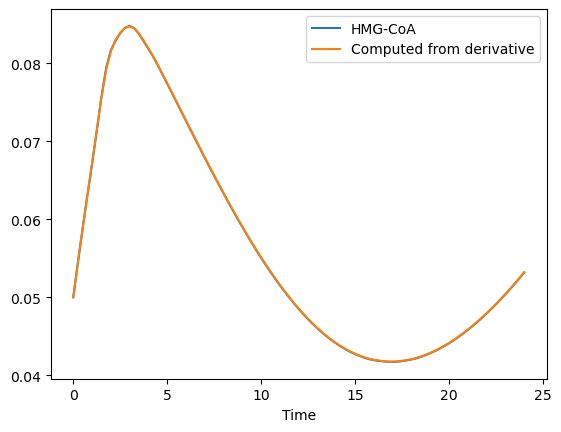

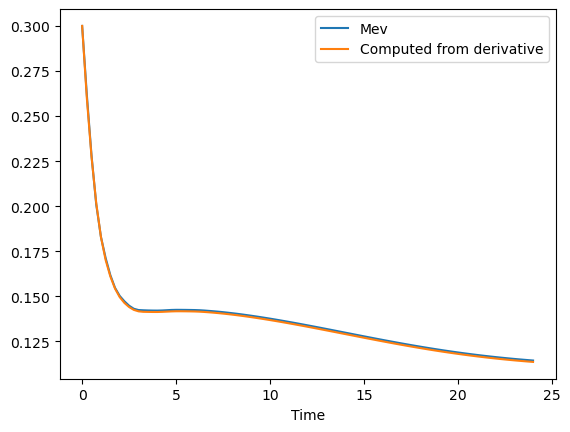

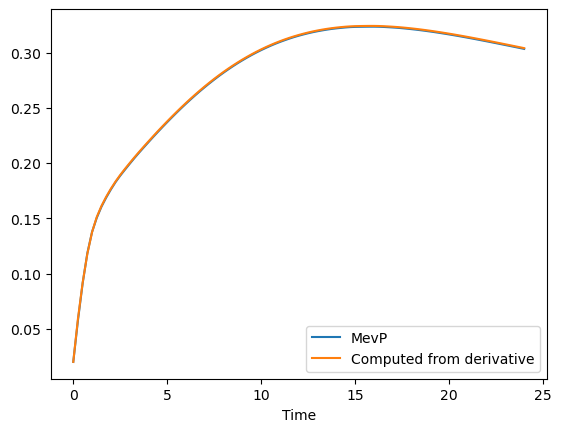

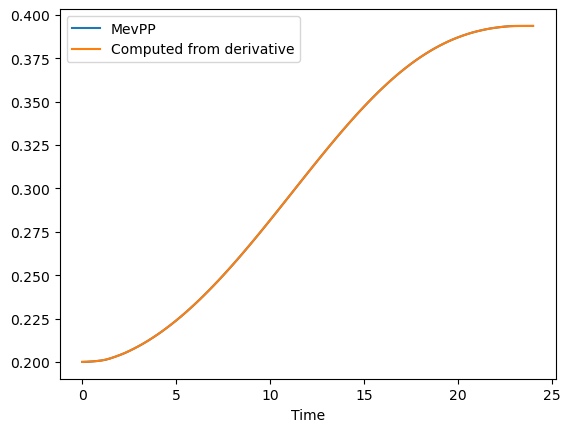

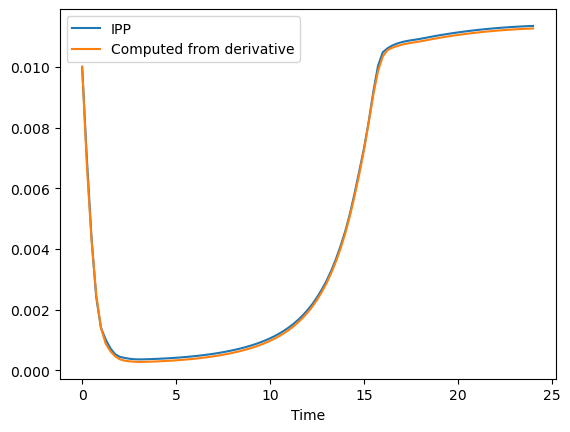

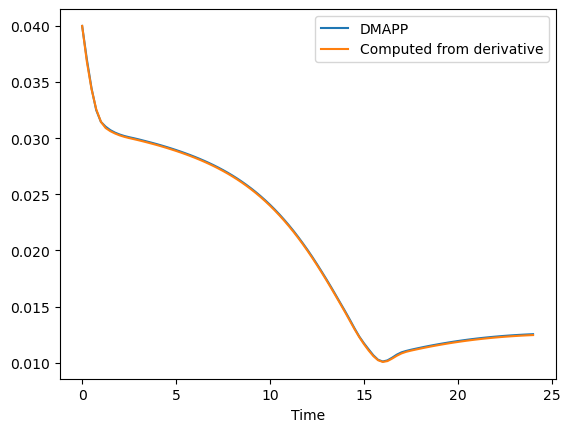

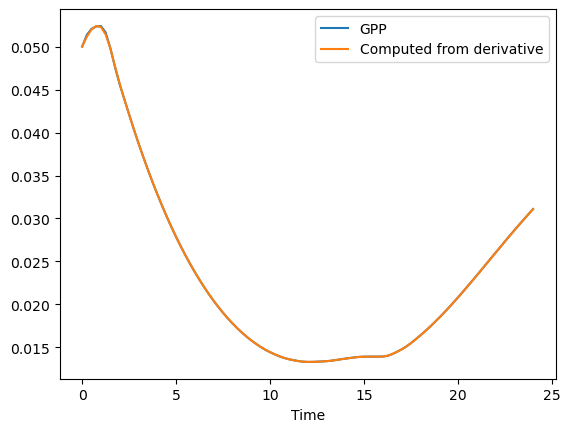

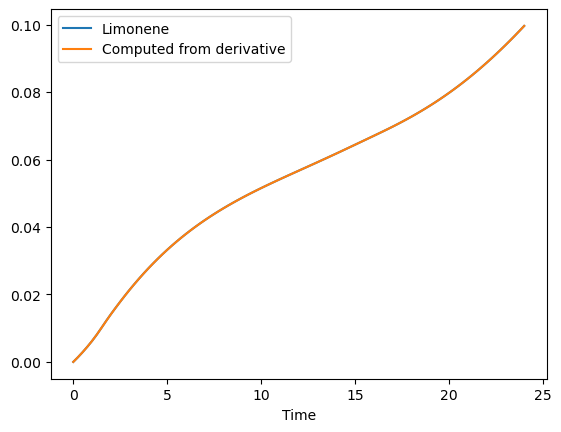

'Time profile from derivative vs. actual profile for Strain 3'

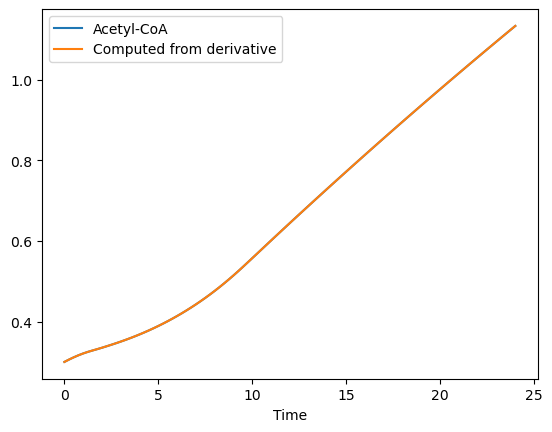

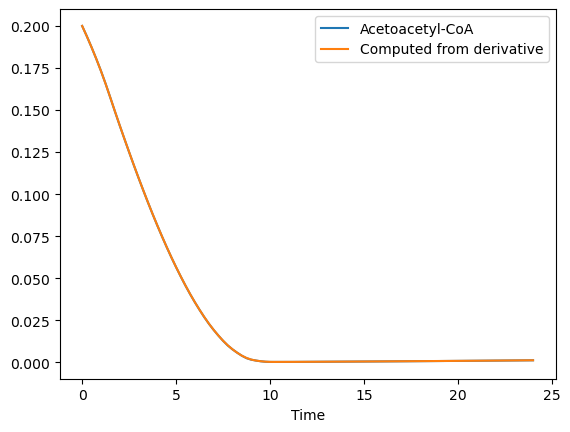

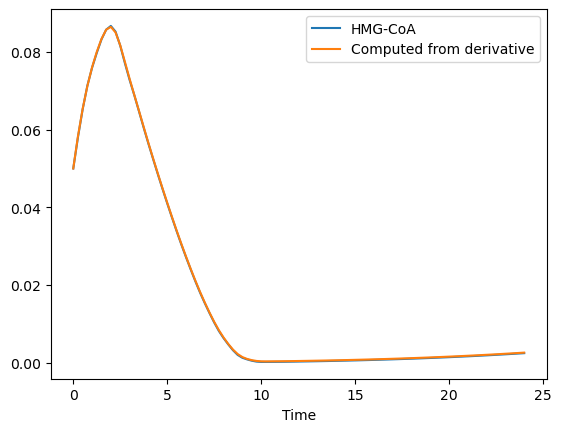

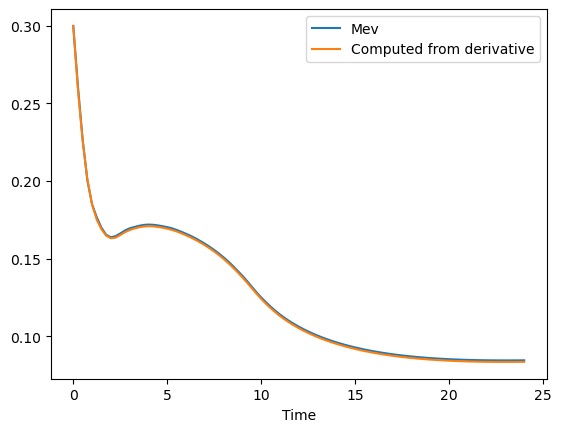

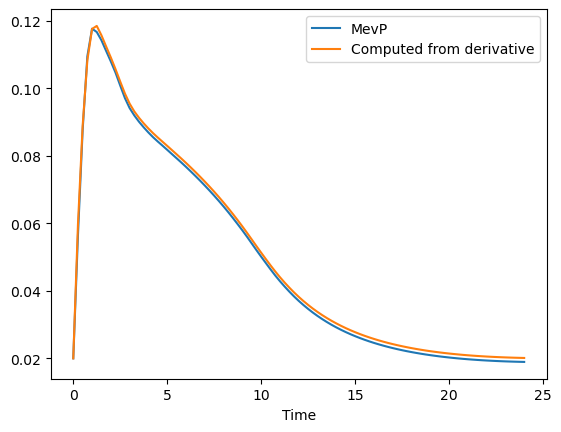

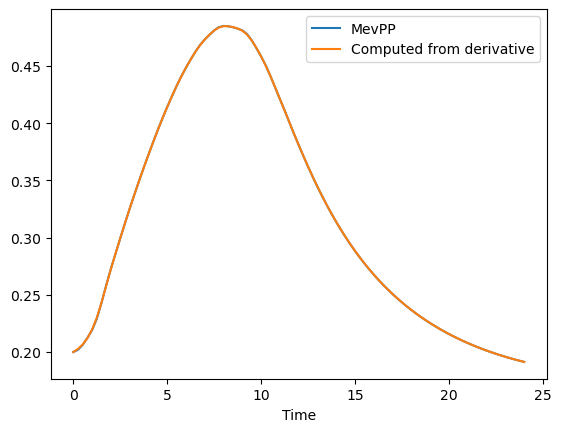

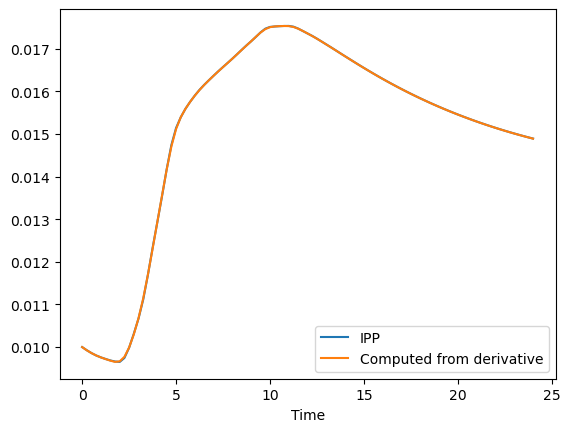

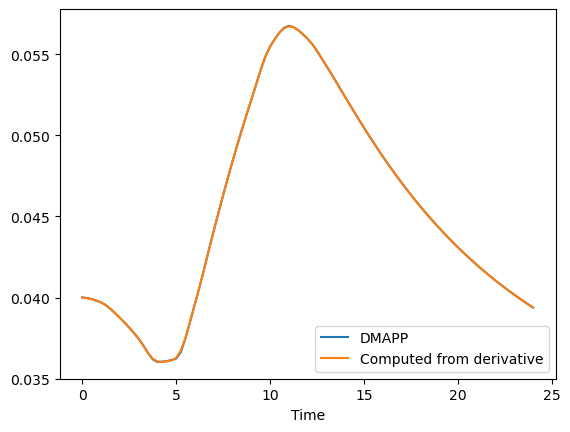

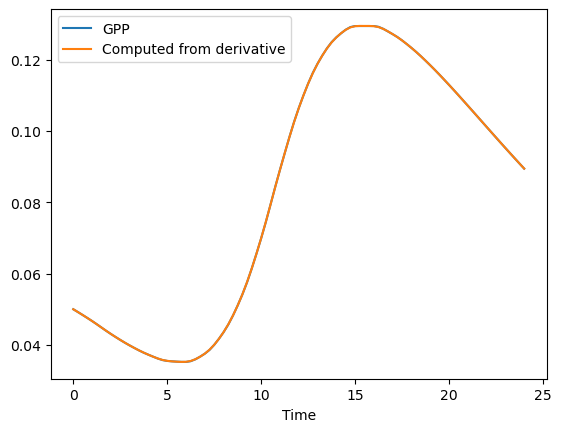

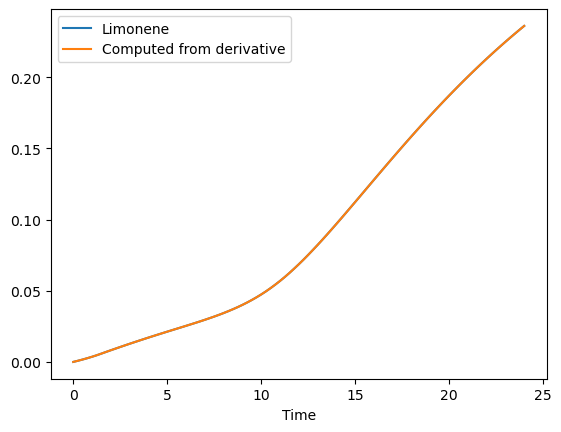

'Time profile from derivative vs. actual profile for WT'

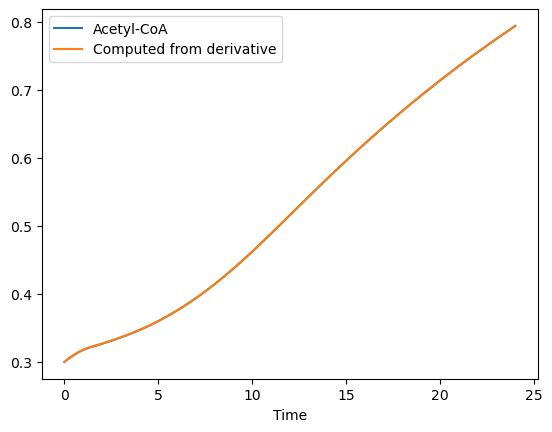

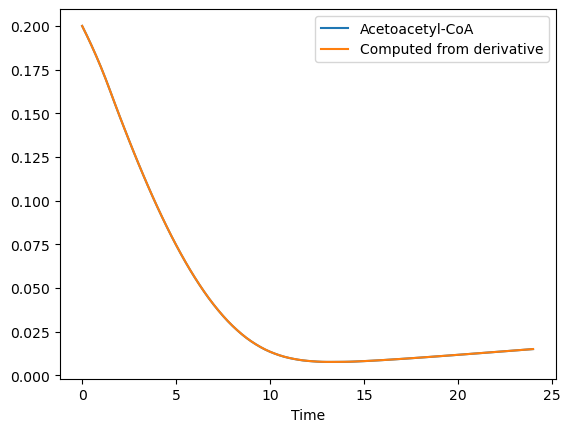

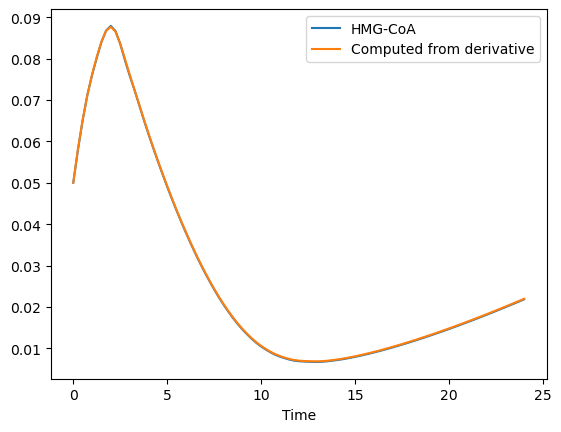

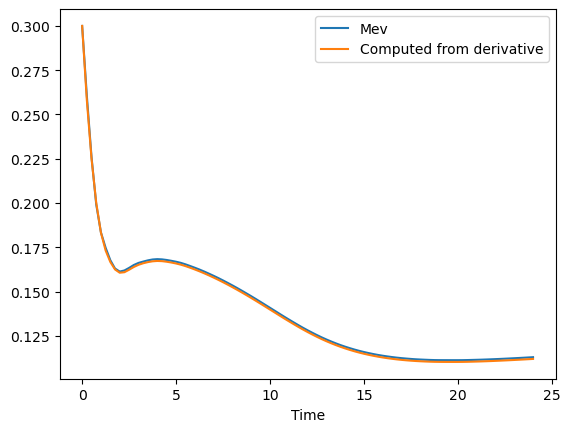

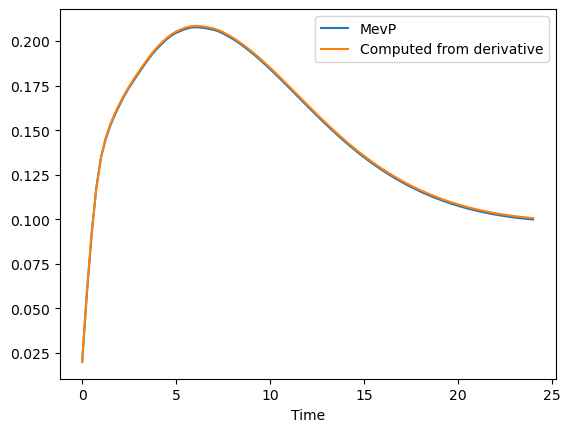

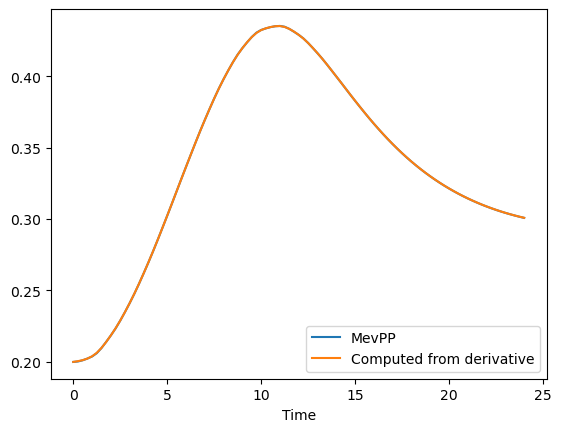

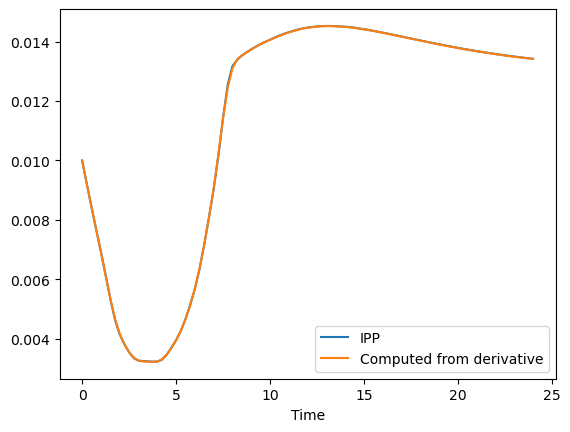

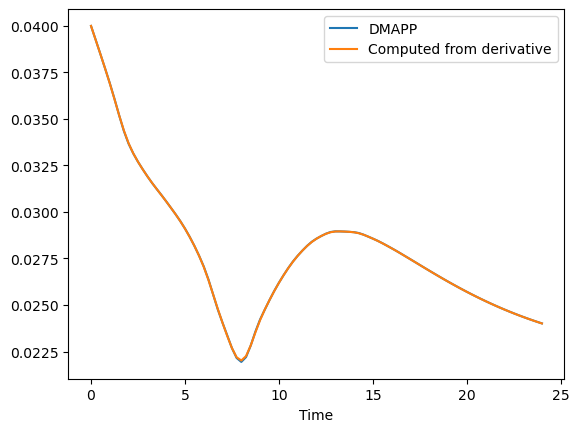

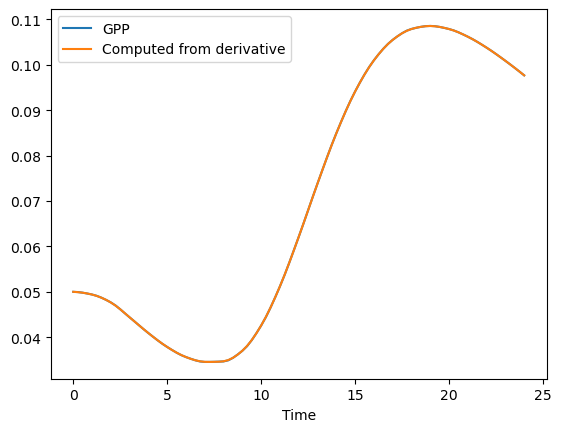

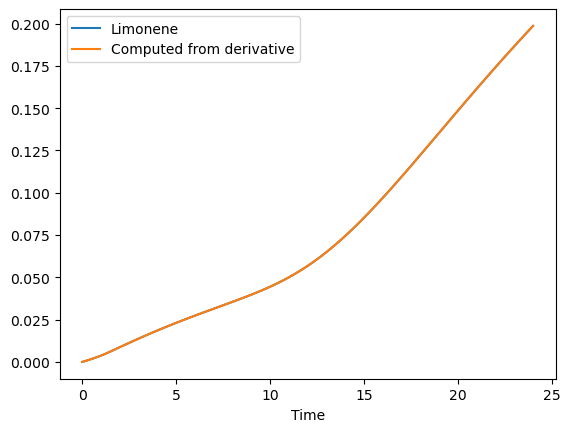

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   2.173781e+06  1.560234e+06  1.570374e+05  1.025868e+06   
         0.50   4.069572e+06  2.927241e+06  2.951031e+05  1.927997e+06   
         0.75   5.448752e+06  3.983103e+06  4.041436e+05  2.640608e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768629e+06  2.010384e+06   
         23.50  2.729713e+06  2.686646e+06  1.769147e+06  2.010975e+06   
         23.75  2.729864e+06  2.687210e+06  1.769654e+06  2.011553e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   3.297925e+05  1.785807e+06  1.328120e+06  2.871277e+05   
         0.50   6.192067e+05  3.363592e+06  2.486684e+06  5.387196e+05   
         0.75   8.452060e+05  4.637042e+06  3.337821e+06  7.332309e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992255e+06  4.354150e+06  1.235379e+06   
         23.50  1.502404e+06  3.993787e+06  4.354490e+06  1.235648e+06   
         23.75  1.502773e+06  3.995286e+06  4.354823e+06  1.235911e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.321864e+05   0.298383        0.193946  0.065149   
         0.50       2.483535e+05   0.295677        0.187596  0.077750   
         0.75       3.398863e+05   0.292180        0.180967  0.086366   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468852e+06   0.784585        0.014581  0.020885   
         23.75      1.469260e+06   0.789291        0.014788  0.021362   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.257084  0.056859  0.200300  0.009225  0.039259  0.050238   
         0.50   0.219963  0.089623  0.201111  0.008475  0.038493  0.050445   
         0.75   0.193859  0.116665  0.202294  0.007751  0.037703  0.050600   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112529  0.100703  0.303342  0.013479  0.024269  0.100097   
         23.50  0.112673  0.100406  0.302439  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.006814       -0.023908  0.073868 -0.213743  0.163982   
         0.25    -0.008651       -0.024790  0.056084 -0.162081  0.140030   
         0.50    -0.011368       -0.025838  0.039185 -0.114301  0.116330   
         0.75    -0.014965       -0.027051  0.023170 -0.070403  0.092879   
         1.00    -0.019338       -0.028498  0.005273 -0.020786  0.066037   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001866  0.000550 -0.001346   
         23.25    0.019092        0.000828  0.001882  0.000568 -0.001235   
         23.50    0.018915        0.000828  0.001899  0.000588 -0.001124   
         23.75    0.018738        0.000829  0.001916  0.000611 -0.001019   
         24.00    0.018561        0.000829  0.001933  0.000635 -0.000918   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002041 -0.003236 -0.002991  0.001146  0.002070  
         0.25   0.002194 -0.003041 -0.003005  0.000899  0.002246  
         0.50   0.003219 -0.002910 -0.003078  0.000670  0.002453  
         0.75   0.005114 -0.002844 -0.003212  0.000460  0.002690  
         1.00   0.007662 -0.002883 -0.003442  0.000227  0.002961  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003945 -0.000080 -0.000373 -0.003059  0.012217  
         23.25 -0.003713 -0.000078 -0.000361 -0.003121  0.012124  
         23.50 -0.003479 -0.000075 -0.000349 -0.003193  0.012032  
         23.75 -0.003251 -0.000072 -0.000337 -0.003272  0.011943  
         24.00 -0.003031 -0.000070 -0.000326 -0.003358  0.011855  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 7.469258E+191 | 9.187689E+116
     2 |       74 | 1.684157E+115 |  4.069880E+83
     3 |      138 |  6.933381E+90 |  4.792016E+70
     4 |      202 |  1.460979E+80 |  1.063001E+60
     5 |      266 |  3.177490E+73 |  5.634873E+53
     6 |      330 |  2.929182E+65 |  8.118525E+48
     7 |      394 |  1.897031E+64 |  1.272083E+48
     8 |      458 |  4.713700E+57 |  1.287205E+42
     9 |      522 |  2.716991E+54 |  9.569437E+41
    10 |      586 |  1.105436E+55 |  9.569437E+41
    11 |      650 |  3.684411E+49 |  3.106553E+39
    12 |      714 |  1.129190E+47 |  2.834290E+36
    13 |      778 |  4.885848E+45 |  2.834290E+36
    14 |      842 |  5.934610E+43 |  6.749509E+31
    15 |      906 |  2.249117E+39 |  7.171629E+27
    16 |      970 |  2.633048E+37 |  8.761018E+26
    17 |     1034 |  1.884365E+35 |  8.761018E+26
    18 |     1098 |  1.327297E+37 |  2.215316E+20
    19 |     1162 |  2.759

   162 |    10314 |  1.942332E+01 |  1.876801E+01
   163 |    10378 |  1.960995E+01 |  1.876801E+01
   164 |    10442 |  1.987195E+01 |  1.876801E+01
   165 |    10506 |  1.973669E+01 |  1.876801E+01
   166 |    10570 |  2.021578E+01 |  1.876801E+01
   167 |    10634 |  2.008108E+01 |  1.865989E+01
   168 |    10698 |  1.961253E+01 |  1.819970E+01
   169 |    10762 |  2.025448E+01 |  1.819970E+01
   170 |    10826 |  1.999450E+01 |  1.819970E+01
   171 |    10890 |  1.962158E+01 |  1.819970E+01
   172 |    10954 |  1.927136E+01 |  1.756758E+01
   173 |    11018 |  1.959711E+01 |  1.756758E+01
   174 |    11082 |  1.928381E+01 |  1.756758E+01
   175 |    11146 |  1.905192E+01 |  1.756758E+01
   176 |    11210 |  1.898305E+01 |  1.756758E+01
   177 |    11274 |  1.884022E+01 |  1.756758E+01
   178 |    11338 |  1.987160E+01 |  1.756758E+01
   179 |    11402 |  1.973255E+01 |  1.756758E+01
   180 |    11466 |  1.920440E+01 |  1.756758E+01
   181 |    11530 |  1.961262E+01 |  1.756758E+01


   326 |    20810 |  1.596058E+01 |  1.520024E+01
   327 |    20874 |  1.589041E+01 |  1.520024E+01
   328 |    20938 |  1.584165E+01 |  1.520024E+01
   329 |    21002 |  1.585866E+01 |  1.520024E+01
   330 |    21066 |  1.579746E+01 |  1.520024E+01
   331 |    21130 |  1.573567E+01 |  1.520024E+01
   332 |    21194 |  1.577616E+01 |  1.520024E+01
   333 |    21258 |  1.567794E+01 |  1.520024E+01
   334 |    21322 |  1.564361E+01 |  1.520024E+01
   335 |    21386 |  1.567573E+01 |  1.520024E+01
   336 |    21450 |  1.571697E+01 |  1.520024E+01
   337 |    21514 |  1.573656E+01 |  1.520024E+01
   338 |    21578 |  1.554955E+01 |  1.520024E+01
   339 |    21642 |  1.554804E+01 |  1.520024E+01
   340 |    21706 |  1.548295E+01 |  1.520024E+01
   341 |    21770 |  1.549586E+01 |  1.520024E+01
   342 |    21834 |  1.550532E+01 |  1.505900E+01
   343 |    21898 |  1.550157E+01 |  1.505900E+01
   344 |    21962 |  1.559970E+01 |  1.505900E+01
   345 |    22026 |  1.557946E+01 |  1.505900E+01


   490 |    31306 |  1.265703E+01 |  1.258470E+01
   491 |    31370 |  1.263591E+01 |  1.258470E+01
   492 |    31434 |  1.265155E+01 |  1.255441E+01
   493 |    31498 |  1.263068E+01 |  1.255441E+01
   494 |    31562 |  1.260266E+01 |  1.254411E+01
   495 |    31626 |  1.254964E+01 |  1.249820E+01
   496 |    31690 |  1.255542E+01 |  1.248034E+01
   497 |    31754 |  1.250637E+01 |  1.234250E+01
   498 |    31818 |  1.252745E+01 |  1.234250E+01
   499 |    31882 |  1.254896E+01 |  1.234250E+01
   500 |    31946 |  1.251373E+01 |  1.234250E+01
   501 |    32010 |  1.252205E+01 |  1.234250E+01
   502 |    32074 |  1.251194E+01 |  1.234250E+01
   503 |    32138 |  1.248970E+01 |  1.234250E+01
   504 |    32202 |  1.248761E+01 |  1.234250E+01
   505 |    32266 |  1.246022E+01 |  1.225945E+01
   506 |    32330 |  1.248453E+01 |  1.225945E+01
   507 |    32394 |  1.245810E+01 |  1.225945E+01
   508 |    32458 |  1.240194E+01 |  1.225235E+01
   509 |    32522 |  1.238261E+01 |  1.225235E+01


   654 |    41802 |  1.166751E+01 |  1.163287E+01
   655 |    41866 |  1.166449E+01 |  1.163287E+01
   656 |    41930 |  1.165707E+01 |  1.161557E+01
   657 |    41994 |  1.165851E+01 |  1.161557E+01
   658 |    42058 |  1.164416E+01 |  1.161557E+01
   659 |    42122 |  1.163475E+01 |  1.160368E+01
   660 |    42186 |  1.163701E+01 |  1.160368E+01
   661 |    42250 |  1.163264E+01 |  1.160368E+01
   662 |    42314 |  1.162747E+01 |  1.160368E+01
   663 |    42378 |  1.163466E+01 |  1.160368E+01
   664 |    42442 |  1.163160E+01 |  1.160368E+01
   665 |    42506 |  1.162586E+01 |  1.158492E+01
   666 |    42570 |  1.161772E+01 |  1.158492E+01
   667 |    42634 |  1.161024E+01 |  1.158427E+01
   668 |    42698 |  1.160720E+01 |  1.157879E+01
   669 |    42762 |  1.160652E+01 |  1.157879E+01
   670 |    42826 |  1.158670E+01 |  1.157275E+01
   671 |    42890 |  1.159165E+01 |  1.156941E+01
   672 |    42954 |  1.159239E+01 |  1.156941E+01
   673 |    43018 |  1.158802E+01 |  1.156568E+01


   818 |    52298 |  1.079816E+01 |  1.078964E+01
   819 |    52362 |  1.080346E+01 |  1.078964E+01
   820 |    52426 |  1.079273E+01 |  1.077859E+01
   821 |    52490 |  1.078881E+01 |  1.077859E+01
   822 |    52554 |  1.078415E+01 |  1.077859E+01
   823 |    52618 |  1.078139E+01 |  1.077746E+01
   824 |    52682 |  1.078209E+01 |  1.077746E+01
   825 |    52746 |  1.077854E+01 |  1.076502E+01
   826 |    52810 |  1.077641E+01 |  1.076502E+01
   827 |    52874 |  1.077559E+01 |  1.076502E+01
   828 |    52938 |  1.077494E+01 |  1.076333E+01
   829 |    53002 |  1.077304E+01 |  1.076333E+01
   830 |    53066 |  1.077547E+01 |  1.076333E+01
   831 |    53130 |  1.077992E+01 |  1.076333E+01
   832 |    53194 |  1.077228E+01 |  1.076333E+01
   833 |    53258 |  1.077214E+01 |  1.076333E+01
   834 |    53322 |  1.077094E+01 |  1.076330E+01
   835 |    53386 |  1.077024E+01 |  1.075967E+01
   836 |    53450 |  1.076612E+01 |  1.075722E+01
   837 |    53514 |  1.076213E+01 |  1.075250E+01


   982 |    62794 |  1.033861E+01 |  1.033337E+01
   983 |    62858 |  1.033715E+01 |  1.033228E+01
   984 |    62922 |  1.033586E+01 |  1.033228E+01
   985 |    62986 |  1.033423E+01 |  1.032984E+01
   986 |    63050 |  1.033121E+01 |  1.032834E+01
   987 |    63114 |  1.032918E+01 |  1.032438E+01
   988 |    63178 |  1.032730E+01 |  1.032438E+01
   989 |    63242 |  1.032520E+01 |  1.032203E+01
   990 |    63306 |  1.032301E+01 |  1.031539E+01
   991 |    63370 |  1.032016E+01 |  1.031539E+01
   992 |    63434 |  1.031777E+01 |  1.031220E+01
   993 |    63498 |  1.031555E+01 |  1.030971E+01
   994 |    63562 |  1.031230E+01 |  1.030971E+01
   995 |    63626 |  1.031074E+01 |  1.030697E+01
   996 |    63690 |  1.030924E+01 |  1.030430E+01
   997 |    63754 |  1.030821E+01 |  1.030430E+01
   998 |    63818 |  1.030584E+01 |  1.030222E+01
   999 |    63882 |  1.030110E+01 |  1.029759E+01
  1000 |    63946 |  1.029780E+01 |  1.029244E+01
  1001 |    64010 |  1.029301E+01 |  1.028932E+01


  1146 |    73290 |  9.9585911615 |  9.9490401802
  1147 |    73354 |  9.9558064403 |  9.9457645338
  1148 |    73418 |  9.9568147452 |  9.9457645338
  1149 |    73482 |  9.9588981456 |  9.9457645338
  1150 |    73546 |  9.9553561402 |  9.9457645338
  1151 |    73610 |  9.9507786455 |  9.9447715631
  1152 |    73674 |  9.9445911151 |  9.9354372767
  1153 |    73738 |  9.9430574744 |  9.9354372767
  1154 |    73802 |  9.9436003868 |  9.9338080689
  1155 |    73866 |  9.9415258872 |  9.9324779859
  1156 |    73930 |  9.9380587416 |  9.9308523870
  1157 |    73994 |  9.9370752583 |  9.9294792891
  1158 |    74058 |  9.9356752937 |  9.9290309956
  1159 |    74122 |  9.9314039125 |  9.9218447961
  1160 |    74186 |  9.9320060794 |  9.9218447961
  1161 |    74250 |  9.9288924330 |  9.9210562704
  1162 |    74314 |  9.9254662959 |  9.9195987946
  1163 |    74378 |  9.9231349186 |  9.9126786270
  1164 |    74442 |  9.9200131540 |  9.8952092341
  1165 |    74506 |  9.9125360851 |  9.8947710443


  1310 |    83786 |  9.4236813266 |  9.4169939276
  1311 |    83850 |  9.4217120463 |  9.4162686332
  1312 |    83914 |  9.4205128582 |  9.4112547117
  1313 |    83978 |  9.4163637570 |  9.4098262396
  1314 |    84042 |  9.4149715224 |  9.4070385831
  1315 |    84106 |  9.4114699478 |  9.3990377728
  1316 |    84170 |  9.4054490090 |  9.3953689001
  1317 |    84234 |  9.4013487681 |  9.3946520958
  1318 |    84298 |  9.4000748515 |  9.3912313784
  1319 |    84362 |  9.3957966389 |  9.3899326389
  1320 |    84426 |  9.3899832213 |  9.3780999889
  1321 |    84490 |  9.3805335163 |  9.3764131404
  1322 |    84554 |  9.3767639375 |  9.3734521703
  1323 |    84618 |  9.3715991065 |  9.3631273693
  1324 |    84682 |  9.3688822372 |  9.3617056140
  1325 |    84746 |  9.3647565681 |  9.3592390722
  1326 |    84810 |  9.3644713658 |  9.3592390722
  1327 |    84874 |  9.3617330309 |  9.3590312141
  1328 |    84938 |  9.3578710146 |  9.3484502632
  1329 |    85002 |  9.3509056647 |  9.3444739602


  1474 |    94282 |  7.0142334342 |  6.9930857926
  1475 |    94346 |  7.0084529117 |  6.9930857926
  1476 |    94410 |  7.0012468403 |  6.9891614436
  1477 |    94474 |  6.9980166579 |  6.9891614436
  1478 |    94538 |  6.9958344007 |  6.9774812276
  1479 |    94602 |  6.9873984705 |  6.9774812276
  1480 |    94666 |  6.9828585441 |  6.9764761656
  1481 |    94730 |  6.9797067789 |  6.9764761656
  1482 |    94794 |  6.9755682116 |  6.9695281456
  1483 |    94858 |  6.9694095106 |  6.9640738657
  1484 |    94922 |  6.9656515118 |  6.9617570119
  1485 |    94986 |  6.9667041035 |  6.9617570119
  1486 |    95050 |  6.9668094113 |  6.9617570119
  1487 |    95114 |  6.9626044365 |  6.9455170448
  1488 |    95178 |  6.9599374135 |  6.9455170448
  1489 |    95242 |  6.9575198827 |  6.9455170448
  1490 |    95306 |  6.9534548902 |  6.9455170448
  1491 |    95370 |  6.9496413281 |  6.9455170448
  1492 |    95434 |  6.9510394930 |  6.9448029912
  1493 |    95498 |  6.9472550878 |  6.9440791167


  1638 |   104778 |  6.5558450870 |  6.5498103230
  1639 |   104842 |  6.5535307709 |  6.5498103230
  1640 |   104906 |  6.5522950364 |  6.5474803856
  1641 |   104970 |  6.5494641103 |  6.5436733594
  1642 |   105034 |  6.5463937806 |  6.5429139393
  1643 |   105098 |  6.5443401661 |  6.5416015150
  1644 |   105162 |  6.5433239945 |  6.5366043629
  1645 |   105226 |  6.5427339569 |  6.5366043629
  1646 |   105290 |  6.5385645248 |  6.5326935535
  1647 |   105354 |  6.5344031522 |  6.5294987092
  1648 |   105418 |  6.5308496700 |  6.5218546156
  1649 |   105482 |  6.5267254699 |  6.5218546156
  1650 |   105546 |  6.5242866619 |  6.5173723915
  1651 |   105610 |  6.5219634273 |  6.5173723915
  1652 |   105674 |  6.5186432511 |  6.5090529286
  1653 |   105738 |  6.5142657800 |  6.5090357524
  1654 |   105802 |  6.5143876743 |  6.5033835976
  1655 |   105866 |  6.5097021249 |  6.5033835976
  1656 |   105930 |  6.5083070943 |  6.5020512457
  1657 |   105994 |  6.5056661257 |  6.5001284286


  1802 |   115274 |  6.3060410074 |  6.3044638339
  1803 |   115338 |  6.3055591429 |  6.3039977696
  1804 |   115402 |  6.3046080949 |  6.3029848685
  1805 |   115466 |  6.3041886985 |  6.3029422009
  1806 |   115530 |  6.3034915573 |  6.3026978429
  1807 |   115594 |  6.3036131889 |  6.3018013811
  1808 |   115658 |  6.3025950700 |  6.3010328489
  1809 |   115722 |  6.3016199017 |  6.3004278751
  1810 |   115786 |  6.3008574692 |  6.2997489315
  1811 |   115850 |  6.3006579714 |  6.2994499089
  1812 |   115914 |  6.2995072850 |  6.2984914254
  1813 |   115978 |  6.2992081215 |  6.2979541773
  1814 |   116042 |  6.2991796183 |  6.2973078600
  1815 |   116106 |  6.2981985772 |  6.2968632951
  1816 |   116170 |  6.2969572241 |  6.2960481658
  1817 |   116234 |  6.2963080529 |  6.2956451567
  1818 |   116298 |  6.2960364461 |  6.2949332790
  1819 |   116362 |  6.2956112262 |  6.2944455159
  1820 |   116426 |  6.2946804452 |  6.2921514325
  1821 |   116490 |  6.2940581290 |  6.2921514325


  1966 |   125770 |  6.1942291471 |  6.1936113451
  1967 |   125834 |  6.1936676595 |  6.1930723299
  1968 |   125898 |  6.1933874203 |  6.1927744520
  1969 |   125962 |  6.1934242094 |  6.1927744520
  1970 |   126026 |  6.1936639037 |  6.1927744520
  1971 |   126090 |  6.1934639502 |  6.1921006089
  1972 |   126154 |  6.1926039244 |  6.1918788330
  1973 |   126218 |  6.1921369984 |  6.1912604166
  1974 |   126282 |  6.1917812163 |  6.1907573005
  1975 |   126346 |  6.1916590079 |  6.1907573005
  1976 |   126410 |  6.1909576837 |  6.1903375200
  1977 |   126474 |  6.1907991738 |  6.1901651340
  1978 |   126538 |  6.1903620822 |  6.1882602414
  1979 |   126602 |  6.1889187891 |  6.1868529961
  1980 |   126666 |  6.1879976874 |  6.1868529961
  1981 |   126730 |  6.1874475629 |  6.1865950878
  1982 |   126794 |  6.1872201844 |  6.1864371772
  1983 |   126858 |  6.1867891212 |  6.1859107512
  1984 |   126922 |  6.1863583989 |  6.1856139511
  1985 |   126986 |  6.1859245681 |  6.1850229348


  2130 |   136266 |  6.1439596806 |  6.1430700008
  2131 |   136330 |  6.1435380044 |  6.1429125661
  2132 |   136394 |  6.1432181230 |  6.1426508303
  2133 |   136458 |  6.1429444657 |  6.1424774315
  2134 |   136522 |  6.1430908669 |  6.1419319693
  2135 |   136586 |  6.1417164454 |  6.1391350343
  2136 |   136650 |  6.1400266559 |  6.1387876874
  2137 |   136714 |  6.1394490506 |  6.1387876874
  2138 |   136778 |  6.1387100139 |  6.1372702337
  2139 |   136842 |  6.1382450069 |  6.1372702337
  2140 |   136906 |  6.1376063549 |  6.1369865957
  2141 |   136970 |  6.1374682058 |  6.1366574058
  2142 |   137034 |  6.1370311196 |  6.1360847883
  2143 |   137098 |  6.1366667733 |  6.1357075408
  2144 |   137162 |  6.1356858654 |  6.1348414941
  2145 |   137226 |  6.1352722786 |  6.1345436709
  2146 |   137290 |  6.1348375471 |  6.1343712715
  2147 |   137354 |  6.1343631075 |  6.1337947446
  2148 |   137418 |  6.1341109572 |  6.1329715796
  2149 |   137482 |  6.1333963038 |  6.1329715796


  2294 |   146762 |  6.0608073066 |  6.0601480925
  2295 |   146826 |  6.0606225794 |  6.0601480925
  2296 |   146890 |  6.0605182541 |  6.0601480925
  2297 |   146954 |  6.0601566974 |  6.0598387780
  2298 |   147018 |  6.0599377712 |  6.0595376363
  2299 |   147082 |  6.0598662438 |  6.0595376363
  2300 |   147146 |  6.0596595288 |  6.0593608712
  2301 |   147210 |  6.0593468820 |  6.0588259232
  2302 |   147274 |  6.0589497538 |  6.0585513066
  2303 |   147338 |  6.0588604712 |  6.0585513066
  2304 |   147402 |  6.0584960909 |  6.0582647882
  2305 |   147466 |  6.0583104499 |  6.0581427461
  2306 |   147530 |  6.0580721408 |  6.0577574889
  2307 |   147594 |  6.0579022333 |  6.0572431111
  2308 |   147658 |  6.0576070544 |  6.0568835227
  2309 |   147722 |  6.0570886578 |  6.0564630544
  2310 |   147786 |  6.0568246468 |  6.0563838201
  2311 |   147850 |  6.0566647263 |  6.0563838201
  2312 |   147914 |  6.0564538875 |  6.0561029718
  2313 |   147978 |  6.0561018774 |  6.0557048872


  2458 |   157258 |  5.9723974506 |  5.9709437772
  2459 |   157322 |  5.9714901778 |  5.9708664654
  2460 |   157386 |  5.9710728510 |  5.9706969441
  2461 |   157450 |  5.9708553210 |  5.9702433618
  2462 |   157514 |  5.9704005023 |  5.9696865759
  2463 |   157578 |  5.9701928561 |  5.9696865759
  2464 |   157642 |  5.9696861779 |  5.9689323106
  2465 |   157706 |  5.9692625872 |  5.9684803338
  2466 |   157770 |  5.9688472004 |  5.9682805622
  2467 |   157834 |  5.9688059893 |  5.9681304881
  2468 |   157898 |  5.9684327789 |  5.9675285150
  2469 |   157962 |  5.9680818431 |  5.9672665176
  2470 |   158026 |  5.9675842448 |  5.9666148475
  2471 |   158090 |  5.9672534045 |  5.9663977657
  2472 |   158154 |  5.9667280155 |  5.9663977657
  2473 |   158218 |  5.9665133699 |  5.9660232595
  2474 |   158282 |  5.9662837654 |  5.9654486735
  2475 |   158346 |  5.9660175060 |  5.9653628840
  2476 |   158410 |  5.9656220341 |  5.9648095135
  2477 |   158474 |  5.9650457882 |  5.9642313498


  2622 |   167754 |  5.8949956279 |  5.8938120455
  2623 |   167818 |  5.8949140750 |  5.8938120455
  2624 |   167882 |  5.8946999260 |  5.8938120455
  2625 |   167946 |  5.8944948269 |  5.8938120455
  2626 |   168010 |  5.8946240783 |  5.8938120455
  2627 |   168074 |  5.8947128951 |  5.8938120455
  2628 |   168138 |  5.8946450510 |  5.8938120455
  2629 |   168202 |  5.8945517459 |  5.8934812522
  2630 |   168266 |  5.8940939660 |  5.8931358905
  2631 |   168330 |  5.8935501030 |  5.8929351122
  2632 |   168394 |  5.8932414114 |  5.8925549089
  2633 |   168458 |  5.8930948194 |  5.8925549089
  2634 |   168522 |  5.8928852578 |  5.8923367445
  2635 |   168586 |  5.8926921069 |  5.8922807063
  2636 |   168650 |  5.8922863688 |  5.8914983630
  2637 |   168714 |  5.8920996574 |  5.8914983630
  2638 |   168778 |  5.8918875938 |  5.8913365289
  2639 |   168842 |  5.8916253012 |  5.8910789830
  2640 |   168906 |  5.8913971661 |  5.8908487446
  2641 |   168970 |  5.8909556128 |  5.8900813149


  2786 |   178250 |  5.8559689254 |  5.8551460372
  2787 |   178314 |  5.8551077475 |  5.8539153643
  2788 |   178378 |  5.8545406382 |  5.8525609683
  2789 |   178442 |  5.8533364238 |  5.8517815226
  2790 |   178506 |  5.8529381782 |  5.8517815226
  2791 |   178570 |  5.8515855467 |  5.8503192430
  2792 |   178634 |  5.8510460249 |  5.8496293594
  2793 |   178698 |  5.8506601924 |  5.8496293594
  2794 |   178762 |  5.8502190950 |  5.8489030946
  2795 |   178826 |  5.8491245176 |  5.8482871615
  2796 |   178890 |  5.8485524634 |  5.8475907439
  2797 |   178954 |  5.8482445199 |  5.8474920112
  2798 |   179018 |  5.8473954874 |  5.8465345150
  2799 |   179082 |  5.8472887670 |  5.8457597369
  2800 |   179146 |  5.8466483888 |  5.8457597369
  2801 |   179210 |  5.8460674992 |  5.8446942147
  2802 |   179274 |  5.8453668721 |  5.8446487004
  2803 |   179338 |  5.8449432652 |  5.8441403675
  2804 |   179402 |  5.8442585724 |  5.8436564360
  2805 |   179466 |  5.8434387804 |  5.8420901381


  2950 |   188746 |  5.7973586212 |  5.7970857491
  2951 |   188810 |  5.7971466267 |  5.7969227762
  2952 |   188874 |  5.7970982565 |  5.7968379190
  2953 |   188938 |  5.7969912739 |  5.7968227707
  2954 |   189002 |  5.7968643068 |  5.7963929223
  2955 |   189066 |  5.7966734092 |  5.7963929223
  2956 |   189130 |  5.7966545084 |  5.7963696655
  2957 |   189194 |  5.7966374547 |  5.7963696655
  2958 |   189258 |  5.7965831522 |  5.7962801301
  2959 |   189322 |  5.7964747334 |  5.7962801301
  2960 |   189386 |  5.7964247617 |  5.7962635134
  2961 |   189450 |  5.7964138042 |  5.7962635134
  2962 |   189514 |  5.7963491769 |  5.7959631266
  2963 |   189578 |  5.7961711917 |  5.7959631266
  2964 |   189642 |  5.7960786690 |  5.7959477910
  2965 |   189706 |  5.7959531906 |  5.7957298536
  2966 |   189770 |  5.7958274195 |  5.7956424014
  2967 |   189834 |  5.7956338649 |  5.7955524879
  2968 |   189898 |  5.7955149587 |  5.7953498578
  2969 |   189962 |  5.7954025365 |  5.7951103120


  3114 |   199242 |  5.5984946827 |  5.5957767215
  3115 |   199306 |  5.5972562295 |  5.5951068168
  3116 |   199370 |  5.5964029172 |  5.5923853610
  3117 |   199434 |  5.5937372612 |  5.5905080351
  3118 |   199498 |  5.5905996986 |  5.5869305352
  3119 |   199562 |  5.5884398957 |  5.5827027411
  3120 |   199626 |  5.5848279689 |  5.5790895702
  3121 |   199690 |  5.5819577821 |  5.5790895702
  3122 |   199754 |  5.5807530859 |  5.5767693997
  3123 |   199818 |  5.5790332357 |  5.5725693757
  3124 |   199882 |  5.5770237850 |  5.5719583783
  3125 |   199946 |  5.5729190626 |  5.5670019280
  3126 |   200010 |  5.5706691101 |  5.5657091604
  3127 |   200074 |  5.5670172174 |  5.5622889382
  3128 |   200138 |  5.5658353913 |  5.5595430058
  3129 |   200202 |  5.5630226874 |  5.5595430058
  3130 |   200266 |  5.5597380651 |  5.5553593514
  3131 |   200330 |  5.5582644837 |  5.5553593514
  3132 |   200394 |  5.5586239215 |  5.5553593514
  3133 |   200458 |  5.5584795642 |  5.5535132238


  3278 |   209738 |  5.5081036366 |  5.5076778231
  3279 |   209802 |  5.5081005021 |  5.5076778231
  3280 |   209866 |  5.5079215568 |  5.5074282386
  3281 |   209930 |  5.5077103148 |  5.5074166031
  3282 |   209994 |  5.5074960216 |  5.5073352130
  3283 |   210058 |  5.5073975245 |  5.5070354632
  3284 |   210122 |  5.5074044214 |  5.5070354632
  3285 |   210186 |  5.5073245635 |  5.5070354632
  3286 |   210250 |  5.5072936414 |  5.5070354632
  3287 |   210314 |  5.5073369789 |  5.5068892398
  3288 |   210378 |  5.5067858121 |  5.5061421677
  3289 |   210442 |  5.5064302334 |  5.5061421677
  3290 |   210506 |  5.5065173185 |  5.5060406482
  3291 |   210570 |  5.5061301094 |  5.5057909109
  3292 |   210634 |  5.5060105706 |  5.5057265543
  3293 |   210698 |  5.5060294872 |  5.5057265543
  3294 |   210762 |  5.5056137133 |  5.5050189353
  3295 |   210826 |  5.5054161071 |  5.5050189353
  3296 |   210890 |  5.5050961434 |  5.5046012710
  3297 |   210954 |  5.5048967519 |  5.5042103230


  3442 |   220234 |  5.4709489038 |  5.4706857818
  3443 |   220298 |  5.4709914065 |  5.4706857818
  3444 |   220362 |  5.4710350724 |  5.4702284168
  3445 |   220426 |  5.4707240073 |  5.4699845312
  3446 |   220490 |  5.4704519407 |  5.4698091357
  3447 |   220554 |  5.4702374404 |  5.4697223614
  3448 |   220618 |  5.4698639712 |  5.4694554494
  3449 |   220682 |  5.4698244786 |  5.4694526951
  3450 |   220746 |  5.4697464902 |  5.4694151038
  3451 |   220810 |  5.4696812806 |  5.4693197935
  3452 |   220874 |  5.4694711509 |  5.4692473873
  3453 |   220938 |  5.4693435044 |  5.4688325597
  3454 |   221002 |  5.4691613154 |  5.4688325597
  3455 |   221066 |  5.4690506160 |  5.4685128900
  3456 |   221130 |  5.4689142453 |  5.4685128900
  3457 |   221194 |  5.4690191615 |  5.4685128900
  3458 |   221258 |  5.4689212667 |  5.4685128900
  3459 |   221322 |  5.4690194689 |  5.4685128900
  3460 |   221386 |  5.4689727720 |  5.4685128900
  3461 |   221450 |  5.4686002536 |  5.4680617058


  3606 |   230730 |  5.4395912331 |  5.4395187241
  3607 |   230794 |  5.4395357790 |  5.4393212221
  3608 |   230858 |  5.4393513035 |  5.4392154784
  3609 |   230922 |  5.4392758570 |  5.4391396158
  3610 |   230986 |  5.4391889643 |  5.4389151257
  3611 |   231050 |  5.4390940498 |  5.4389151257
  3612 |   231114 |  5.4390364683 |  5.4386994316
  3613 |   231178 |  5.4389171720 |  5.4386994316
  3614 |   231242 |  5.4388469010 |  5.4385652851
  3615 |   231306 |  5.4386971347 |  5.4385652851
  3616 |   231370 |  5.4385818910 |  5.4384707472
  3617 |   231434 |  5.4385323826 |  5.4384119618
  3618 |   231498 |  5.4385101253 |  5.4383960208
  3619 |   231562 |  5.4383943932 |  5.4381257128
  3620 |   231626 |  5.4382996965 |  5.4380908895
  3621 |   231690 |  5.4381638367 |  5.4378903993
  3622 |   231754 |  5.4380795621 |  5.4378903993
  3623 |   231818 |  5.4380072876 |  5.4376520458
  3624 |   231882 |  5.4378002239 |  5.4376520458
  3625 |   231946 |  5.4376608718 |  5.4373653342


  3770 |   241226 |  5.4124141710 |  5.4115664729
  3771 |   241290 |  5.4122128442 |  5.4114061635
  3772 |   241354 |  5.4118296049 |  5.4113013506
  3773 |   241418 |  5.4116163107 |  5.4109914570
  3774 |   241482 |  5.4116057193 |  5.4109914570
  3775 |   241546 |  5.4115379854 |  5.4109316718
  3776 |   241610 |  5.4110284508 |  5.4101058738
  3777 |   241674 |  5.4110531406 |  5.4101058738
  3778 |   241738 |  5.4105103899 |  5.4099544674
  3779 |   241802 |  5.4103395692 |  5.4093914146
  3780 |   241866 |  5.4100839885 |  5.4093914146
  3781 |   241930 |  5.4097512141 |  5.4086988016
  3782 |   241994 |  5.4094229190 |  5.4085906961
  3783 |   242058 |  5.4092426407 |  5.4085906961
  3784 |   242122 |  5.4092372362 |  5.4085906961
  3785 |   242186 |  5.4087979917 |  5.4084259222
  3786 |   242250 |  5.4087289645 |  5.4083884459
  3787 |   242314 |  5.4085590285 |  5.4079183351
  3788 |   242378 |  5.4083259977 |  5.4075280749
  3789 |   242442 |  5.4081433165 |  5.4075280749


  3934 |   251722 |  5.3659893449 |  5.3656765901
  3935 |   251786 |  5.3658526456 |  5.3656370763
  3936 |   251850 |  5.3657040541 |  5.3653846712
  3937 |   251914 |  5.3657150965 |  5.3653700340
  3938 |   251978 |  5.3655566694 |  5.3653629488
  3939 |   252042 |  5.3655589921 |  5.3653567730
  3940 |   252106 |  5.3653907098 |  5.3651066215
  3941 |   252170 |  5.3652552704 |  5.3648896667
  3942 |   252234 |  5.3650785174 |  5.3646755250
  3943 |   252298 |  5.3649236775 |  5.3646755250
  3944 |   252362 |  5.3647748417 |  5.3644419905
  3945 |   252426 |  5.3646806825 |  5.3644120180
  3946 |   252490 |  5.3645251158 |  5.3640767109
  3947 |   252554 |  5.3644727430 |  5.3640767109
  3948 |   252618 |  5.3642194584 |  5.3637649379
  3949 |   252682 |  5.3640452775 |  5.3636828191
  3950 |   252746 |  5.3638292787 |  5.3633237188
  3951 |   252810 |  5.3636499721 |  5.3633237188
  3952 |   252874 |  5.3634850138 |  5.3631798411
  3953 |   252938 |  5.3632775307 |  5.3630030512


  4098 |   262218 |  5.3271407919 |  5.3263014024
  4099 |   262282 |  5.3266318870 |  5.3262926945
  4100 |   262346 |  5.3261132144 |  5.3254575688
  4101 |   262410 |  5.3258379560 |  5.3254575688
  4102 |   262474 |  5.3257151303 |  5.3254068938
  4103 |   262538 |  5.3255105550 |  5.3251446475
  4104 |   262602 |  5.3256066955 |  5.3251320551
  4105 |   262666 |  5.3250285643 |  5.3236487237
  4106 |   262730 |  5.3245645033 |  5.3234071053
  4107 |   262794 |  5.3238258954 |  5.3229681782
  4108 |   262858 |  5.3234769009 |  5.3226226810
  4109 |   262922 |  5.3231822013 |  5.3222114340
  4110 |   262986 |  5.3225921737 |  5.3216003501
  4111 |   263050 |  5.3222602175 |  5.3215955258
  4112 |   263114 |  5.3213721488 |  5.3207141889
  4113 |   263178 |  5.3206344849 |  5.3200595463
  4114 |   263242 |  5.3198135133 |  5.3184539722
  4115 |   263306 |  5.3191868249 |  5.3179593991
  4116 |   263370 |  5.3186361323 |  5.3175556648
  4117 |   263434 |  5.3183272703 |  5.3173815213


  4262 |   272714 |  5.2736224748 |  5.2731715754
  4263 |   272778 |  5.2734008437 |  5.2729758487
  4264 |   272842 |  5.2728666024 |  5.2725912743
  4265 |   272906 |  5.2728511134 |  5.2725578272
  4266 |   272970 |  5.2727367403 |  5.2722293105
  4267 |   273034 |  5.2726254594 |  5.2722236940
  4268 |   273098 |  5.2725723297 |  5.2722236940
  4269 |   273162 |  5.2723431615 |  5.2717114476
  4270 |   273226 |  5.2721065708 |  5.2713689369
  4271 |   273290 |  5.2717517190 |  5.2712096630
  4272 |   273354 |  5.2715341710 |  5.2711843641
  4273 |   273418 |  5.2712764491 |  5.2709282556
  4274 |   273482 |  5.2710699511 |  5.2705795118
  4275 |   273546 |  5.2709013474 |  5.2705795118
  4276 |   273610 |  5.2708227166 |  5.2705229447
  4277 |   273674 |  5.2706064702 |  5.2701286765
  4278 |   273738 |  5.2704611275 |  5.2701286765
  4279 |   273802 |  5.2702222170 |  5.2698120204
  4280 |   273866 |  5.2698574144 |  5.2695582854
  4281 |   273930 |  5.2697939836 |  5.2694650515


  4426 |   283210 |  5.2308926900 |  5.2303431725
  4427 |   283274 |  5.2305556461 |  5.2303431725
  4428 |   283338 |  5.2302292212 |  5.2298713788
  4429 |   283402 |  5.2300386670 |  5.2292654118
  4430 |   283466 |  5.2296550479 |  5.2291865563
  4431 |   283530 |  5.2295423750 |  5.2291865563
  4432 |   283594 |  5.2296771088 |  5.2291865563
  4433 |   283658 |  5.2296802699 |  5.2291616649
  4434 |   283722 |  5.2295323818 |  5.2290087510
  4435 |   283786 |  5.2292929335 |  5.2289478502
  4436 |   283850 |  5.2292918028 |  5.2289478502
  4437 |   283914 |  5.2292577863 |  5.2289478502
  4438 |   283978 |  5.2291868932 |  5.2289478502
  4439 |   284042 |  5.2289533250 |  5.2287676860
  4440 |   284106 |  5.2290389265 |  5.2287676860
  4441 |   284170 |  5.2288845366 |  5.2285585373
  4442 |   284234 |  5.2286993676 |  5.2281610383
  4443 |   284298 |  5.2284957204 |  5.2281610383
  4444 |   284362 |  5.2284264954 |  5.2281610383
  4445 |   284426 |  5.2282734929 |  5.2280681219


  4590 |   293706 |  5.2100952661 |  5.2096393317
  4591 |   293770 |  5.2097065068 |  5.2093620834
  4592 |   293834 |  5.2092408588 |  5.2087253509
  4593 |   293898 |  5.2088266148 |  5.2083440932
  4594 |   293962 |  5.2086368486 |  5.2082987437
  4595 |   294026 |  5.2084047687 |  5.2080410180
  4596 |   294090 |  5.2080611175 |  5.2077892851
  4597 |   294154 |  5.2078102968 |  5.2074019770
  4598 |   294218 |  5.2075965948 |  5.2074019770
  4599 |   294282 |  5.2074630303 |  5.2073074387
  4600 |   294346 |  5.2072043472 |  5.2069432844
  4601 |   294410 |  5.2070426344 |  5.2066357716
  4602 |   294474 |  5.2067656327 |  5.2063672658
  4603 |   294538 |  5.2064876447 |  5.2062647161
  4604 |   294602 |  5.2064835301 |  5.2062174243
  4605 |   294666 |  5.2061226087 |  5.2058897400
  4606 |   294730 |  5.2058214257 |  5.2054058156
  4607 |   294794 |  5.2057656114 |  5.2054058156
  4608 |   294858 |  5.2053111479 |  5.2050124104
  4609 |   294922 |  5.2047290316 |  5.2042166428


  4754 |   304202 |  5.1687316440 |  5.1682633809
  4755 |   304266 |  5.1684154648 |  5.1675583353
  4756 |   304330 |  5.1681847967 |  5.1674209965
  4757 |   304394 |  5.1678829492 |  5.1674209965
  4758 |   304458 |  5.1678804658 |  5.1674209965
  4759 |   304522 |  5.1677505611 |  5.1674209965
  4760 |   304586 |  5.1676426196 |  5.1671757469
  4761 |   304650 |  5.1675025997 |  5.1671542317
  4762 |   304714 |  5.1670755987 |  5.1666596955
  4763 |   304778 |  5.1668551922 |  5.1665276921
  4764 |   304842 |  5.1666836177 |  5.1661406334
  4765 |   304906 |  5.1664916545 |  5.1661406334
  4766 |   304970 |  5.1662914151 |  5.1655450746
  4767 |   305034 |  5.1659791978 |  5.1655450746
  4768 |   305098 |  5.1657534744 |  5.1651025071
  4769 |   305162 |  5.1655448823 |  5.1651025071
  4770 |   305226 |  5.1650798591 |  5.1647169657
  4771 |   305290 |  5.1648290161 |  5.1641782516
  4772 |   305354 |  5.1644129769 |  5.1636903559
  4773 |   305418 |  5.1637481866 |  5.1633572562


  4918 |   314698 |  5.1363648773 |  5.1360509194
  4919 |   314762 |  5.1362813715 |  5.1360509194
  4920 |   314826 |  5.1362509291 |  5.1357262674
  4921 |   314890 |  5.1360637331 |  5.1357262674
  4922 |   314954 |  5.1360276299 |  5.1357262674
  4923 |   315018 |  5.1358671897 |  5.1356260529
  4924 |   315082 |  5.1358861592 |  5.1356260529
  4925 |   315146 |  5.1359794729 |  5.1356260529
  4926 |   315210 |  5.1360049585 |  5.1356260529
  4927 |   315274 |  5.1358791305 |  5.1354766345
  4928 |   315338 |  5.1357845183 |  5.1354108462
  4929 |   315402 |  5.1355312195 |  5.1352278962
  4930 |   315466 |  5.1356047575 |  5.1350952900
  4931 |   315530 |  5.1354793049 |  5.1350952900
  4932 |   315594 |  5.1354041239 |  5.1350952900
  4933 |   315658 |  5.1352963142 |  5.1349661782
  4934 |   315722 |  5.1350658739 |  5.1348614824
  4935 |   315786 |  5.1350133192 |  5.1345218864
  4936 |   315850 |  5.1349298064 |  5.1344502640
  4937 |   315914 |  5.1346558221 |  5.1343453485


  5082 |   325194 |  5.1228016829 |  5.1225564281
  5083 |   325258 |  5.1227125836 |  5.1225564281
  5084 |   325322 |  5.1225888767 |  5.1224239359
  5085 |   325386 |  5.1224731629 |  5.1222387055
  5086 |   325450 |  5.1223530413 |  5.1222387055
  5087 |   325514 |  5.1222568747 |  5.1221151919
  5088 |   325578 |  5.1221454633 |  5.1220279069
  5089 |   325642 |  5.1221002708 |  5.1219801051
  5090 |   325706 |  5.1220115783 |  5.1218806377
  5091 |   325770 |  5.1219327499 |  5.1218218904
  5092 |   325834 |  5.1219247258 |  5.1218218904
  5093 |   325898 |  5.1218208507 |  5.1217502994
  5094 |   325962 |  5.1217667586 |  5.1216140665
  5095 |   326026 |  5.1216390349 |  5.1214767670
  5096 |   326090 |  5.1215207350 |  5.1213486573
  5097 |   326154 |  5.1213228251 |  5.1209546097
  5098 |   326218 |  5.1211220195 |  5.1209546097
  5099 |   326282 |  5.1210236452 |  5.1208451512
  5100 |   326346 |  5.1207733743 |  5.1204201685
  5101 |   326410 |  5.1204748048 |  5.1203539962


  5246 |   335690 |  5.0863057813 |  5.0860122813
  5247 |   335754 |  5.0862391699 |  5.0858616522
  5248 |   335818 |  5.0861551660 |  5.0854401386
  5249 |   335882 |  5.0856634642 |  5.0851927810
  5250 |   335946 |  5.0854873346 |  5.0849997259
  5251 |   336010 |  5.0854182763 |  5.0846951291
  5252 |   336074 |  5.0851943547 |  5.0845964167
  5253 |   336138 |  5.0850089712 |  5.0845964167
  5254 |   336202 |  5.0848852906 |  5.0844607851
  5255 |   336266 |  5.0845305559 |  5.0842572927
  5256 |   336330 |  5.0841461243 |  5.0834289333
  5257 |   336394 |  5.0838428611 |  5.0832573305
  5258 |   336458 |  5.0832695193 |  5.0829498932
  5259 |   336522 |  5.0829736518 |  5.0826206350
  5260 |   336586 |  5.0826033662 |  5.0820755932
  5261 |   336650 |  5.0824098411 |  5.0820755932
  5262 |   336714 |  5.0823677889 |  5.0817898588
  5263 |   336778 |  5.0819092413 |  5.0814725728
  5264 |   336842 |  5.0817872854 |  5.0814725728
  5265 |   336906 |  5.0815317606 |  5.0810367553


  5410 |   346186 |  5.0310187037 |  5.0299461364
  5411 |   346250 |  5.0304232672 |  5.0297785404
  5412 |   346314 |  5.0303078504 |  5.0295137276
  5413 |   346378 |  5.0299551402 |  5.0294489509
  5414 |   346442 |  5.0294866771 |  5.0283690190
  5415 |   346506 |  5.0288144411 |  5.0274750362
  5416 |   346570 |  5.0278579427 |  5.0271743284
  5417 |   346634 |  5.0270677537 |  5.0267976193
  5418 |   346698 |  5.0267144209 |  5.0261143064
  5419 |   346762 |  5.0264810126 |  5.0259502314
  5420 |   346826 |  5.0261146349 |  5.0244287075
  5421 |   346890 |  5.0252384432 |  5.0243618319
  5422 |   346954 |  5.0245019680 |  5.0234687449
  5423 |   347018 |  5.0240682143 |  5.0231758428
  5424 |   347082 |  5.0233401263 |  5.0225931193
  5425 |   347146 |  5.0228117001 |  5.0222087825
  5426 |   347210 |  5.0223782569 |  5.0213954153
  5427 |   347274 |  5.0217853777 |  5.0210978169
  5428 |   347338 |  5.0213137126 |  5.0205517494
  5429 |   347402 |  5.0214090788 |  5.0205517494


  5574 |   356682 |  4.9549130584 |  4.9542444147
  5575 |   356746 |  4.9543777973 |  4.9540223856
  5576 |   356810 |  4.9539051228 |  4.9534091648
  5577 |   356874 |  4.9537446676 |  4.9528337999
  5578 |   356938 |  4.9528054893 |  4.9519690057
  5579 |   357002 |  4.9520995042 |  4.9511741149
  5580 |   357066 |  4.9515720074 |  4.9506280088
  5581 |   357130 |  4.9511865166 |  4.9505948128
  5582 |   357194 |  4.9507681305 |  4.9503080171
  5583 |   357258 |  4.9505650715 |  4.9493405424
  5584 |   357322 |  4.9503435404 |  4.9493405424
  5585 |   357386 |  4.9499626913 |  4.9489891740
  5586 |   357450 |  4.9495040629 |  4.9484891065
  5587 |   357514 |  4.9489171255 |  4.9483157619
  5588 |   357578 |  4.9488074980 |  4.9483157619
  5589 |   357642 |  4.9484797669 |  4.9482914564
  5590 |   357706 |  4.9482850445 |  4.9477804957
  5591 |   357770 |  4.9480754734 |  4.9477364720
  5592 |   357834 |  4.9478755753 |  4.9474262320
  5593 |   357898 |  4.9478268465 |  4.9474262320


  5738 |   367178 |  4.9274635375 |  4.9272768362
  5739 |   367242 |  4.9272875415 |  4.9271034617
  5740 |   367306 |  4.9272710600 |  4.9269955760
  5741 |   367370 |  4.9272074942 |  4.9268731910
  5742 |   367434 |  4.9270478548 |  4.9268356585
  5743 |   367498 |  4.9268636668 |  4.9266709011
  5744 |   367562 |  4.9268256917 |  4.9265333852
  5745 |   367626 |  4.9267970979 |  4.9265333852
  5746 |   367690 |  4.9267557801 |  4.9265261685
  5747 |   367754 |  4.9266384736 |  4.9264053167
  5748 |   367818 |  4.9265329074 |  4.9263492155
  5749 |   367882 |  4.9264999461 |  4.9263492155
  5750 |   367946 |  4.9263829180 |  4.9262013652
  5751 |   368010 |  4.9262708907 |  4.9260777018
  5752 |   368074 |  4.9261676779 |  4.9259081234
  5753 |   368138 |  4.9261439116 |  4.9259081234
  5754 |   368202 |  4.9260761198 |  4.9259081234
  5755 |   368266 |  4.9260087135 |  4.9258974074
  5756 |   368330 |  4.9259076972 |  4.9257675694
  5757 |   368394 |  4.9257957106 |  4.9256313929


  5902 |   377674 |  4.9146123499 |  4.9144731533
  5903 |   377738 |  4.9145612048 |  4.9143791716
  5904 |   377802 |  4.9144500170 |  4.9143182536
  5905 |   377866 |  4.9143534824 |  4.9142251003
  5906 |   377930 |  4.9142589806 |  4.9141827642
  5907 |   377994 |  4.9141846344 |  4.9140786519
  5908 |   378058 |  4.9140837349 |  4.9138313644
  5909 |   378122 |  4.9139032236 |  4.9137334022
  5910 |   378186 |  4.9138268033 |  4.9137334022
  5911 |   378250 |  4.9137515163 |  4.9136689342
  5912 |   378314 |  4.9136687057 |  4.9135362924
  5913 |   378378 |  4.9135599631 |  4.9134478156
  5914 |   378442 |  4.9135012923 |  4.9133685716
  5915 |   378506 |  4.9134076048 |  4.9133289536
  5916 |   378570 |  4.9133662268 |  4.9132514588
  5917 |   378634 |  4.9133050638 |  4.9131825839
  5918 |   378698 |  4.9132083229 |  4.9131159590
  5919 |   378762 |  4.9131124293 |  4.9130136203
  5920 |   378826 |  4.9129634285 |  4.9127920605
  5921 |   378890 |  4.9128556090 |  4.9127403454


  6066 |   388170 |  4.9016024536 |  4.9014080802
  6067 |   388234 |  4.9015040748 |  4.9010819390
  6068 |   388298 |  4.9011655954 |  4.9009154505
  6069 |   388362 |  4.9009076853 |  4.9007065199
  6070 |   388426 |  4.9007515071 |  4.9005606434
  6071 |   388490 |  4.9007232534 |  4.9005606434
  6072 |   388554 |  4.9006091815 |  4.9004536612
  6073 |   388618 |  4.9005807595 |  4.9003544177
  6074 |   388682 |  4.9005191044 |  4.9003025363
  6075 |   388746 |  4.9003741083 |  4.9001094463
  6076 |   388810 |  4.9002195510 |  4.8999985107
  6077 |   388874 |  4.9000468177 |  4.8998464555
  6078 |   388938 |  4.8999519485 |  4.8995848448
  6079 |   389002 |  4.8997093863 |  4.8993711886
  6080 |   389066 |  4.8996085847 |  4.8993711886
  6081 |   389130 |  4.8994969707 |  4.8992241134
  6082 |   389194 |  4.8993729433 |  4.8991759760
  6083 |   389258 |  4.8992709292 |  4.8988929827
  6084 |   389322 |  4.8990963167 |  4.8987046033
  6085 |   389386 |  4.8989086437 |  4.8986517222


  6230 |   398666 |  4.8761738460 |  4.8759684256
  6231 |   398730 |  4.8761549956 |  4.8759684256
  6232 |   398794 |  4.8759440284 |  4.8754011424
  6233 |   398858 |  4.8758476323 |  4.8754011424
  6234 |   398922 |  4.8758685857 |  4.8754011424
  6235 |   398986 |  4.8756044363 |  4.8753879963
  6236 |   399050 |  4.8754904520 |  4.8752337001
  6237 |   399114 |  4.8752965419 |  4.8748272320
  6238 |   399178 |  4.8749500050 |  4.8745201943
  6239 |   399242 |  4.8747768505 |  4.8741323038
  6240 |   399306 |  4.8743729461 |  4.8739784365
  6241 |   399370 |  4.8741763654 |  4.8734991248
  6242 |   399434 |  4.8738692879 |  4.8734991248
  6243 |   399498 |  4.8736529975 |  4.8730497301
  6244 |   399562 |  4.8734719942 |  4.8727650115
  6245 |   399626 |  4.8731218022 |  4.8725529505
  6246 |   399690 |  4.8729153132 |  4.8725164206
  6247 |   399754 |  4.8727805761 |  4.8724020172
  6248 |   399818 |  4.8726480883 |  4.8722745896
  6249 |   399882 |  4.8723492392 |  4.8720415907


  6394 |   409162 |  4.8469770564 |  4.8467790405
  6395 |   409226 |  4.8468917462 |  4.8467478377
  6396 |   409290 |  4.8467715383 |  4.8466152952
  6397 |   409354 |  4.8467264520 |  4.8466152952
  6398 |   409418 |  4.8466598825 |  4.8464841327
  6399 |   409482 |  4.8466223135 |  4.8464841327
  6400 |   409546 |  4.8465901572 |  4.8464158676
  6401 |   409610 |  4.8465451446 |  4.8463697009
  6402 |   409674 |  4.8464097759 |  4.8462791757
  6403 |   409738 |  4.8463505218 |  4.8462138283
  6404 |   409802 |  4.8463214523 |  4.8462138283
  6405 |   409866 |  4.8462167032 |  4.8460101689
  6406 |   409930 |  4.8460260175 |  4.8458469086
  6407 |   409994 |  4.8458979782 |  4.8456612576
  6408 |   410058 |  4.8456914509 |  4.8455053126
  6409 |   410122 |  4.8455337383 |  4.8454606582
  6410 |   410186 |  4.8454396394 |  4.8453547769
  6411 |   410250 |  4.8453544558 |  4.8451887700
  6412 |   410314 |  4.8452712685 |  4.8451669839
  6413 |   410378 |  4.8453029451 |  4.8451265193


  6558 |   419658 |  4.8096764653 |  4.8091189454
  6559 |   419722 |  4.8093671445 |  4.8085629847
  6560 |   419786 |  4.8093932025 |  4.8085629847
  6561 |   419850 |  4.8087003825 |  4.8083689498
  6562 |   419914 |  4.8085601806 |  4.8078228234
  6563 |   419978 |  4.8078215516 |  4.8072063735
  6564 |   420042 |  4.8074928293 |  4.8069073956
  6565 |   420106 |  4.8072824289 |  4.8066564159
  6566 |   420170 |  4.8069533409 |  4.8065043968
  6567 |   420234 |  4.8065338694 |  4.8057162714
  6568 |   420298 |  4.8063433063 |  4.8057162714
  6569 |   420362 |  4.8060146179 |  4.8053919216
  6570 |   420426 |  4.8057639940 |  4.8049796975
  6571 |   420490 |  4.8051060206 |  4.8041230921
  6572 |   420554 |  4.8048876684 |  4.8041230921
  6573 |   420618 |  4.8049852270 |  4.8041230921
  6574 |   420682 |  4.8046919101 |  4.8041230921
  6575 |   420746 |  4.8039456882 |  4.8028709536
  6576 |   420810 |  4.8032853043 |  4.8026854327
  6577 |   420874 |  4.8032261279 |  4.8025038339


  6722 |   430154 |  4.7758172235 |  4.7756307133
  6723 |   430218 |  4.7756360113 |  4.7755133757
  6724 |   430282 |  4.7755622906 |  4.7753922285
  6725 |   430346 |  4.7754176739 |  4.7752318999
  6726 |   430410 |  4.7752884803 |  4.7750428259
  6727 |   430474 |  4.7751892294 |  4.7750428259
  6728 |   430538 |  4.7751603944 |  4.7750331656
  6729 |   430602 |  4.7750313781 |  4.7748872097
  6730 |   430666 |  4.7750056870 |  4.7747219994
  6731 |   430730 |  4.7748711117 |  4.7745897777
  6732 |   430794 |  4.7746410548 |  4.7745543883
  6733 |   430858 |  4.7746588315 |  4.7744838185
  6734 |   430922 |  4.7745229196 |  4.7743735739
  6735 |   430986 |  4.7744226314 |  4.7741918047
  6736 |   431050 |  4.7743500097 |  4.7740900207
  6737 |   431114 |  4.7742644641 |  4.7740104620
  6738 |   431178 |  4.7741349718 |  4.7740104620
  6739 |   431242 |  4.7740305840 |  4.7739836215
  6740 |   431306 |  4.7740191634 |  4.7738995629
  6741 |   431370 |  4.7739870767 |  4.7738933707


  6886 |   440650 |  4.7656166200 |  4.7655198989
  6887 |   440714 |  4.7655878388 |  4.7654760919
  6888 |   440778 |  4.7655216546 |  4.7654119431
  6889 |   440842 |  4.7654714114 |  4.7653384657
  6890 |   440906 |  4.7654429951 |  4.7652921618
  6891 |   440970 |  4.7653427752 |  4.7652592010
  6892 |   441034 |  4.7653012928 |  4.7652289309
  6893 |   441098 |  4.7652145737 |  4.7651248948
  6894 |   441162 |  4.7651780729 |  4.7650795555
  6895 |   441226 |  4.7651004167 |  4.7650039948
  6896 |   441290 |  4.7650204247 |  4.7648416375
  6897 |   441354 |  4.7649830675 |  4.7648336534
  6898 |   441418 |  4.7649825763 |  4.7648336534
  6899 |   441482 |  4.7648961668 |  4.7647675670
  6900 |   441546 |  4.7648426242 |  4.7647045038
  6901 |   441610 |  4.7647287002 |  4.7646307453
  6902 |   441674 |  4.7646825031 |  4.7645723712
  6903 |   441738 |  4.7646255197 |  4.7645228413
  6904 |   441802 |  4.7646006589 |  4.7644541814
  6905 |   441866 |  4.7645347481 |  4.7643520862


  7050 |   451146 |  4.7580469085 |  4.7579428582
  7051 |   451210 |  4.7580220129 |  4.7579178220
  7052 |   451274 |  4.7579994654 |  4.7579178220
  7053 |   451338 |  4.7579731561 |  4.7578813996
  7054 |   451402 |  4.7579140773 |  4.7577147234
  7055 |   451466 |  4.7578284470 |  4.7577147234
  7056 |   451530 |  4.7578342828 |  4.7577147234
  7057 |   451594 |  4.7578125109 |  4.7577147234
  7058 |   451658 |  4.7577876710 |  4.7577147234
  7059 |   451722 |  4.7577799966 |  4.7577025553
  7060 |   451786 |  4.7577577663 |  4.7576366619
  7061 |   451850 |  4.7577145205 |  4.7575925186
  7062 |   451914 |  4.7576531352 |  4.7575282036
  7063 |   451978 |  4.7575873646 |  4.7574996421
  7064 |   452042 |  4.7575242245 |  4.7572422752
  7065 |   452106 |  4.7574008856 |  4.7571731057
  7066 |   452170 |  4.7572839366 |  4.7570657354
  7067 |   452234 |  4.7571175106 |  4.7567558974
  7068 |   452298 |  4.7568919356 |  4.7567558974
  7069 |   452362 |  4.7567951841 |  4.7566312307


  7214 |   461642 |  4.7343563645 |  4.7336460148
  7215 |   461706 |  4.7341439341 |  4.7336064891
  7216 |   461770 |  4.7340720113 |  4.7336064891
  7217 |   461834 |  4.7338492608 |  4.7332710417
  7218 |   461898 |  4.7338126692 |  4.7332710417
  7219 |   461962 |  4.7336469355 |  4.7332710417
  7220 |   462026 |  4.7335244725 |  4.7330432927
  7221 |   462090 |  4.7332256706 |  4.7327987236
  7222 |   462154 |  4.7330564807 |  4.7321245875
  7223 |   462218 |  4.7327717512 |  4.7318177620
  7224 |   462282 |  4.7326782913 |  4.7314418672
  7225 |   462346 |  4.7324874453 |  4.7314418672
  7226 |   462410 |  4.7322531543 |  4.7314127987
  7227 |   462474 |  4.7317947158 |  4.7313247452
  7228 |   462538 |  4.7314798206 |  4.7302901969
  7229 |   462602 |  4.7312320134 |  4.7302901969
  7230 |   462666 |  4.7313254361 |  4.7302901969
  7231 |   462730 |  4.7311327372 |  4.7302901969
  7232 |   462794 |  4.7308033185 |  4.7302193218
  7233 |   462858 |  4.7306627288 |  4.7301914305


  7378 |   472138 |  4.7165898015 |  4.7165205306
  7379 |   472202 |  4.7166022838 |  4.7165100483
  7380 |   472266 |  4.7165609213 |  4.7164015958
  7381 |   472330 |  4.7164602668 |  4.7162102370
  7382 |   472394 |  4.7164014155 |  4.7161452426
  7383 |   472458 |  4.7163002346 |  4.7161357995
  7384 |   472522 |  4.7162370103 |  4.7160080386
  7385 |   472586 |  4.7162260180 |  4.7160080386
  7386 |   472650 |  4.7161911576 |  4.7158413673
  7387 |   472714 |  4.7161456898 |  4.7158413673
  7388 |   472778 |  4.7159854421 |  4.7158263869
  7389 |   472842 |  4.7158385398 |  4.7156195818
  7390 |   472906 |  4.7156761816 |  4.7155581658
  7391 |   472970 |  4.7155098695 |  4.7152840361
  7392 |   473034 |  4.7153452678 |  4.7151291172
  7393 |   473098 |  4.7151762127 |  4.7150675454
  7394 |   473162 |  4.7151183776 |  4.7148856845
  7395 |   473226 |  4.7149524414 |  4.7147810275
  7396 |   473290 |  4.7148752009 |  4.7146865986
  7397 |   473354 |  4.7147867317 |  4.7144797809


  7542 |   482634 |  4.6963870173 |  4.6952745577
  7543 |   482698 |  4.6960743573 |  4.6952745577
  7544 |   482762 |  4.6958778287 |  4.6952745577
  7545 |   482826 |  4.6957569063 |  4.6950493780
  7546 |   482890 |  4.6954631984 |  4.6950493780
  7547 |   482954 |  4.6954156794 |  4.6950493780
  7548 |   483018 |  4.6954402035 |  4.6950493780
  7549 |   483082 |  4.6952831103 |  4.6950493780
  7550 |   483146 |  4.6951330273 |  4.6949989299
  7551 |   483210 |  4.6949598121 |  4.6947052477
  7552 |   483274 |  4.6948999498 |  4.6945357520
  7553 |   483338 |  4.6946903947 |  4.6944345858
  7554 |   483402 |  4.6946586173 |  4.6944001936
  7555 |   483466 |  4.6945749466 |  4.6941496471
  7556 |   483530 |  4.6944524363 |  4.6941496471
  7557 |   483594 |  4.6942673459 |  4.6937881042
  7558 |   483658 |  4.6942117890 |  4.6937881042
  7559 |   483722 |  4.6940860690 |  4.6937881042
  7560 |   483786 |  4.6941549264 |  4.6937881042
  7561 |   483850 |  4.6938980702 |  4.6936961349


  7706 |   493130 |  4.6787100955 |  4.6783192080
  7707 |   493194 |  4.6784922627 |  4.6782425012
  7708 |   493258 |  4.6783310516 |  4.6781435116
  7709 |   493322 |  4.6780960960 |  4.6779562692
  7710 |   493386 |  4.6779729719 |  4.6777193216
  7711 |   493450 |  4.6779077410 |  4.6776640307
  7712 |   493514 |  4.6777219433 |  4.6775190674
  7713 |   493578 |  4.6775563594 |  4.6774398937
  7714 |   493642 |  4.6774702867 |  4.6774090360
  7715 |   493706 |  4.6774505890 |  4.6773798155
  7716 |   493770 |  4.6774168376 |  4.6773228641
  7717 |   493834 |  4.6773417812 |  4.6772525017
  7718 |   493898 |  4.6772707069 |  4.6771678115
  7719 |   493962 |  4.6772013260 |  4.6771386979
  7720 |   494026 |  4.6771113096 |  4.6769493572
  7721 |   494090 |  4.6770155987 |  4.6768344372
  7722 |   494154 |  4.6769196458 |  4.6768306399
  7723 |   494218 |  4.6768438347 |  4.6766758703
  7724 |   494282 |  4.6767770708 |  4.6766758703
  7725 |   494346 |  4.6767382701 |  4.6766564662


  7870 |   503626 |  4.6649769079 |  4.6648478945
  7871 |   503690 |  4.6649094278 |  4.6648464851
  7872 |   503754 |  4.6648180897 |  4.6645534541
  7873 |   503818 |  4.6645548879 |  4.6641906196
  7874 |   503882 |  4.6642650472 |  4.6641214040
  7875 |   503946 |  4.6641065670 |  4.6640007272
  7876 |   504010 |  4.6639742517 |  4.6637748677
  7877 |   504074 |  4.6638389106 |  4.6635786442
  7878 |   504138 |  4.6635611794 |  4.6633146988
  7879 |   504202 |  4.6632886026 |  4.6629997498
  7880 |   504266 |  4.6631399855 |  4.6629997498
  7881 |   504330 |  4.6631130867 |  4.6629169698
  7882 |   504394 |  4.6628582880 |  4.6626564406
  7883 |   504458 |  4.6627609223 |  4.6625649070
  7884 |   504522 |  4.6626450194 |  4.6623724898
  7885 |   504586 |  4.6625175427 |  4.6623724898
  7886 |   504650 |  4.6625050516 |  4.6623627403
  7887 |   504714 |  4.6623005448 |  4.6619353210
  7888 |   504778 |  4.6621142282 |  4.6617908670
  7889 |   504842 |  4.6618484904 |  4.6617468542


  8034 |   514122 |  4.6405500780 |  4.6403989922
  8035 |   514186 |  4.6405183136 |  4.6402787591
  8036 |   514250 |  4.6402955653 |  4.6400484039
  8037 |   514314 |  4.6401722679 |  4.6398919725
  8038 |   514378 |  4.6400352853 |  4.6398919725
  8039 |   514442 |  4.6399844298 |  4.6398232952
  8040 |   514506 |  4.6398926483 |  4.6397871105
  8041 |   514570 |  4.6398431955 |  4.6396971704
  8042 |   514634 |  4.6397695692 |  4.6396033311
  8043 |   514698 |  4.6396344112 |  4.6395002147
  8044 |   514762 |  4.6395445456 |  4.6394858535
  8045 |   514826 |  4.6395259256 |  4.6393079519
  8046 |   514890 |  4.6394453924 |  4.6393079519
  8047 |   514954 |  4.6393707965 |  4.6392686901
  8048 |   515018 |  4.6393366673 |  4.6392344228
  8049 |   515082 |  4.6393462268 |  4.6391354183
  8050 |   515146 |  4.6392370174 |  4.6390594555
  8051 |   515210 |  4.6391728356 |  4.6390574605
  8052 |   515274 |  4.6391505442 |  4.6390301742
  8053 |   515338 |  4.6391080960 |  4.6389595916


  8198 |   524618 |  4.6301433882 |  4.6299893704
  8199 |   524682 |  4.6301718311 |  4.6299893704
  8200 |   524746 |  4.6301229178 |  4.6299331441
  8201 |   524810 |  4.6300458443 |  4.6298085094
  8202 |   524874 |  4.6300332011 |  4.6296568913
  8203 |   524938 |  4.6299426603 |  4.6296568913
  8204 |   525002 |  4.6299206224 |  4.6295717316
  8205 |   525066 |  4.6298375593 |  4.6295663135
  8206 |   525130 |  4.6297860699 |  4.6295663135
  8207 |   525194 |  4.6296688414 |  4.6295362650
  8208 |   525258 |  4.6294965839 |  4.6293783904
  8209 |   525322 |  4.6294528885 |  4.6293000250
  8210 |   525386 |  4.6293409177 |  4.6292406351
  8211 |   525450 |  4.6292706425 |  4.6291492500
  8212 |   525514 |  4.6292373327 |  4.6291492500
  8213 |   525578 |  4.6292242724 |  4.6291410516
  8214 |   525642 |  4.6291382763 |  4.6290178258
  8215 |   525706 |  4.6290279148 |  4.6289054286
  8216 |   525770 |  4.6289846465 |  4.6288984091
  8217 |   525834 |  4.6289160088 |  4.6288034300


  8362 |   535114 |  4.6217553415 |  4.6216269925
  8363 |   535178 |  4.6217090129 |  4.6216269925
  8364 |   535242 |  4.6216900632 |  4.6215940054
  8365 |   535306 |  4.6215315210 |  4.6214364186
  8366 |   535370 |  4.6214218896 |  4.6213779657
  8367 |   535434 |  4.6212821916 |  4.6211566987
  8368 |   535498 |  4.6211567429 |  4.6209778061
  8369 |   535562 |  4.6210082118 |  4.6208802446
  8370 |   535626 |  4.6209080688 |  4.6207079988
  8371 |   535690 |  4.6208196442 |  4.6206112848
  8372 |   535754 |  4.6206982291 |  4.6205255872
  8373 |   535818 |  4.6204783241 |  4.6203286973
  8374 |   535882 |  4.6202930094 |  4.6200441277
  8375 |   535946 |  4.6200991921 |  4.6199754676
  8376 |   536010 |  4.6199044022 |  4.6197670128
  8377 |   536074 |  4.6198079840 |  4.6197212931
  8378 |   536138 |  4.6197090808 |  4.6195557462
  8379 |   536202 |  4.6195781321 |  4.6193898964
  8380 |   536266 |  4.6193831948 |  4.6192897625
  8381 |   536330 |  4.6191939033 |  4.6190185272


  8526 |   545610 |  4.5955820818 |  4.5954877775
  8527 |   545674 |  4.5955995115 |  4.5954877775
  8528 |   545738 |  4.5955541100 |  4.5954668850
  8529 |   545802 |  4.5955678263 |  4.5954668850
  8530 |   545866 |  4.5955783030 |  4.5954668850
  8531 |   545930 |  4.5954653994 |  4.5953522505
  8532 |   545994 |  4.5954432978 |  4.5953464573
  8533 |   546058 |  4.5953624300 |  4.5953163626
  8534 |   546122 |  4.5953407556 |  4.5952943012
  8535 |   546186 |  4.5953292183 |  4.5952882337
  8536 |   546250 |  4.5953072691 |  4.5952626662
  8537 |   546314 |  4.5952956361 |  4.5952566430
  8538 |   546378 |  4.5952808753 |  4.5952511177
  8539 |   546442 |  4.5953064466 |  4.5952511177
  8540 |   546506 |  4.5952904404 |  4.5952511177
  8541 |   546570 |  4.5952572482 |  4.5952051028
  8542 |   546634 |  4.5952228170 |  4.5951652130
  8543 |   546698 |  4.5951777370 |  4.5951155488
  8544 |   546762 |  4.5951472820 |  4.5950961666
  8545 |   546826 |  4.5951248504 |  4.5950333784


  8690 |   556106 |  4.5845857319 |  4.5842834467
  8691 |   556170 |  4.5845462873 |  4.5842795358
  8692 |   556234 |  4.5845271303 |  4.5840557002
  8693 |   556298 |  4.5843589704 |  4.5838454807
  8694 |   556362 |  4.5841966227 |  4.5838454807
  8695 |   556426 |  4.5840306536 |  4.5836447201
  8696 |   556490 |  4.5838380759 |  4.5835763182
  8697 |   556554 |  4.5837364292 |  4.5834931694
  8698 |   556618 |  4.5837012775 |  4.5834931694
  8699 |   556682 |  4.5836063871 |  4.5831947899
  8700 |   556746 |  4.5835157728 |  4.5830489100
  8701 |   556810 |  4.5834145766 |  4.5830489100
  8702 |   556874 |  4.5833980771 |  4.5830489100
  8703 |   556938 |  4.5833301565 |  4.5830489100
  8704 |   557002 |  4.5831872170 |  4.5829201299
  8705 |   557066 |  4.5831234267 |  4.5828946848
  8706 |   557130 |  4.5831346692 |  4.5828830398
  8707 |   557194 |  4.5828740662 |  4.5824809086
  8708 |   557258 |  4.5826769967 |  4.5823308676
  8709 |   557322 |  4.5824856419 |  4.5823308676


  8854 |   566602 |  4.5696257773 |  4.5695312034
  8855 |   566666 |  4.5695929711 |  4.5695312034
  8856 |   566730 |  4.5695640284 |  4.5694954475
  8857 |   566794 |  4.5694723154 |  4.5694073890
  8858 |   566858 |  4.5693735031 |  4.5693158059
  8859 |   566922 |  4.5693117082 |  4.5692091261
  8860 |   566986 |  4.5693017329 |  4.5692069906
  8861 |   567050 |  4.5692280958 |  4.5691215858
  8862 |   567114 |  4.5691783738 |  4.5690486210
  8863 |   567178 |  4.5691173962 |  4.5690456124
  8864 |   567242 |  4.5690855578 |  4.5690217894
  8865 |   567306 |  4.5690168492 |  4.5689359666
  8866 |   567370 |  4.5688726478 |  4.5687688782
  8867 |   567434 |  4.5688265875 |  4.5687524658
  8868 |   567498 |  4.5687302356 |  4.5685849047
  8869 |   567562 |  4.5686287154 |  4.5685196997
  8870 |   567626 |  4.5685296135 |  4.5683681514
  8871 |   567690 |  4.5684747968 |  4.5683681514
  8872 |   567754 |  4.5684290383 |  4.5682723454
  8873 |   567818 |  4.5683900114 |  4.5681744593


  9018 |   577098 |  4.5564053595 |  4.5563910519
  9019 |   577162 |  4.5563707762 |  4.5562879674
  9020 |   577226 |  4.5563780873 |  4.5562879674
  9021 |   577290 |  4.5563527541 |  4.5562879674
  9022 |   577354 |  4.5563724506 |  4.5562879674
  9023 |   577418 |  4.5563570630 |  4.5562879674
  9024 |   577482 |  4.5563202680 |  4.5562466316
  9025 |   577546 |  4.5562765017 |  4.5562149998
  9026 |   577610 |  4.5562678142 |  4.5562095124
  9027 |   577674 |  4.5561808142 |  4.5561221790
  9028 |   577738 |  4.5561710295 |  4.5561068827
  9029 |   577802 |  4.5561036701 |  4.5560149324
  9030 |   577866 |  4.5560726057 |  4.5560149324
  9031 |   577930 |  4.5560438322 |  4.5560098650
  9032 |   577994 |  4.5560442577 |  4.5559822037
  9033 |   578058 |  4.5559631975 |  4.5558404958
  9034 |   578122 |  4.5558875742 |  4.5558225944
  9035 |   578186 |  4.5558534370 |  4.5557710867
  9036 |   578250 |  4.5557919189 |  4.5557574131
  9037 |   578314 |  4.5557953336 |  4.5557449648


  9182 |   587594 |  4.5486989004 |  4.5485369172
  9183 |   587658 |  4.5485829095 |  4.5484947478
  9184 |   587722 |  4.5485335257 |  4.5484636796
  9185 |   587786 |  4.5484581115 |  4.5484084839
  9186 |   587850 |  4.5484003649 |  4.5483010968
  9187 |   587914 |  4.5483356978 |  4.5482739668
  9188 |   587978 |  4.5482901481 |  4.5481145694
  9189 |   588042 |  4.5481868829 |  4.5480969636
  9190 |   588106 |  4.5481726352 |  4.5480623821
  9191 |   588170 |  4.5481385473 |  4.5480623821
  9192 |   588234 |  4.5480972535 |  4.5480458345
  9193 |   588298 |  4.5480855286 |  4.5480235078
  9194 |   588362 |  4.5480285118 |  4.5478347757
  9195 |   588426 |  4.5479671582 |  4.5478347757
  9196 |   588490 |  4.5479258823 |  4.5478347757
  9197 |   588554 |  4.5478796016 |  4.5478214488
  9198 |   588618 |  4.5478565100 |  4.5477590103
  9199 |   588682 |  4.5478315335 |  4.5477572236
  9200 |   588746 |  4.5477886853 |  4.5477281766
  9201 |   588810 |  4.5477520949 |  4.5476652637


  9346 |   598090 |  4.5427653304 |  4.5427130381
  9347 |   598154 |  4.5427385717 |  4.5427130381
  9348 |   598218 |  4.5427209992 |  4.5426654355
  9349 |   598282 |  4.5427241570 |  4.5426654355
  9350 |   598346 |  4.5426775513 |  4.5426325217
  9351 |   598410 |  4.5426155069 |  4.5425784218
  9352 |   598474 |  4.5426021997 |  4.5425575723
  9353 |   598538 |  4.5425682250 |  4.5425452626
  9354 |   598602 |  4.5425487078 |  4.5425071388
  9355 |   598666 |  4.5425196086 |  4.5424581486
  9356 |   598730 |  4.5424845789 |  4.5424353576
  9357 |   598794 |  4.5424287729 |  4.5423733058
  9358 |   598858 |  4.5423918880 |  4.5423358629
  9359 |   598922 |  4.5423491207 |  4.5423315265
  9360 |   598986 |  4.5423015174 |  4.5422600435
  9361 |   599050 |  4.5422718798 |  4.5422194244
  9362 |   599114 |  4.5422443806 |  4.5422031435
  9363 |   599178 |  4.5422052837 |  4.5421281491
  9364 |   599242 |  4.5421861649 |  4.5421281491
  9365 |   599306 |  4.5421241846 |  4.5420481228


  9510 |   608586 |  4.5259088028 |  4.5256090428
  9511 |   608650 |  4.5257662454 |  4.5255162251
  9512 |   608714 |  4.5258171614 |  4.5255162251
  9513 |   608778 |  4.5259216690 |  4.5255162251
  9514 |   608842 |  4.5258041969 |  4.5255162251
  9515 |   608906 |  4.5258456605 |  4.5255162251
  9516 |   608970 |  4.5258189988 |  4.5255162251
  9517 |   609034 |  4.5258573102 |  4.5255162251
  9518 |   609098 |  4.5257746928 |  4.5253854624
  9519 |   609162 |  4.5257093723 |  4.5253854624
  9520 |   609226 |  4.5256019204 |  4.5253854624
  9521 |   609290 |  4.5256586255 |  4.5253459579
  9522 |   609354 |  4.5257058335 |  4.5253459579
  9523 |   609418 |  4.5257489097 |  4.5253459579
  9524 |   609482 |  4.5258227540 |  4.5253459579
  9525 |   609546 |  4.5257847863 |  4.5252131157
  9526 |   609610 |  4.5254440265 |  4.5252131157
  9527 |   609674 |  4.5254781266 |  4.5252131157
  9528 |   609738 |  4.5254734889 |  4.5252131157
  9529 |   609802 |  4.5254180856 |  4.5252131157


  9674 |   619082 |  4.5196920048 |  4.5196161090
  9675 |   619146 |  4.5196970080 |  4.5195862449
  9676 |   619210 |  4.5196694992 |  4.5195862449
  9677 |   619274 |  4.5196464781 |  4.5195862449
  9678 |   619338 |  4.5196040605 |  4.5195549887
  9679 |   619402 |  4.5195780290 |  4.5195347554
  9680 |   619466 |  4.5195494826 |  4.5195145760
  9681 |   619530 |  4.5195486974 |  4.5194984897
  9682 |   619594 |  4.5195345338 |  4.5194916818
  9683 |   619658 |  4.5195179216 |  4.5194896951
  9684 |   619722 |  4.5195209447 |  4.5194896951
  9685 |   619786 |  4.5195054799 |  4.5194582390
  9686 |   619850 |  4.5194909331 |  4.5194453437
  9687 |   619914 |  4.5194712932 |  4.5194453437
  9688 |   619978 |  4.5194538578 |  4.5193966614
  9689 |   620042 |  4.5194256804 |  4.5193847502
  9690 |   620106 |  4.5193910356 |  4.5193688408
  9691 |   620170 |  4.5193863641 |  4.5193501892
  9692 |   620234 |  4.5193709568 |  4.5193251739
  9693 |   620298 |  4.5193616761 |  4.5193251739


  9838 |   629578 |  4.5148618289 |  4.5147380360
  9839 |   629642 |  4.5147737369 |  4.5147195337
  9840 |   629706 |  4.5146473842 |  4.5144449059
  9841 |   629770 |  4.5145494053 |  4.5144091968
  9842 |   629834 |  4.5144233513 |  4.5142940523
  9843 |   629898 |  4.5143327782 |  4.5142596261
  9844 |   629962 |  4.5142438688 |  4.5141741698
  9845 |   630026 |  4.5142077637 |  4.5141577952
  9846 |   630090 |  4.5142034857 |  4.5141577952
  9847 |   630154 |  4.5140978213 |  4.5139339101
  9848 |   630218 |  4.5140120433 |  4.5139339101
  9849 |   630282 |  4.5139350033 |  4.5137981708
  9850 |   630346 |  4.5138153694 |  4.5137303622
  9851 |   630410 |  4.5137667220 |  4.5136557525
  9852 |   630474 |  4.5136337105 |  4.5135321048
  9853 |   630538 |  4.5135101817 |  4.5134138845
  9854 |   630602 |  4.5134588914 |  4.5133807208
  9855 |   630666 |  4.5133858004 |  4.5133015918
  9856 |   630730 |  4.5133925620 |  4.5133015918
  9857 |   630794 |  4.5133954186 |  4.5132981818


 10002 |   640074 |  4.5016675911 |  4.5014889014
 10003 |   640138 |  4.5015335932 |  4.5012855518
 10004 |   640202 |  4.5014286576 |  4.5012363773
 10005 |   640266 |  4.5013560453 |  4.5011856881
 10006 |   640330 |  4.5013422850 |  4.5011856881
 10007 |   640394 |  4.5012767598 |  4.5011836608
 10008 |   640458 |  4.5012171861 |  4.5011301627
 10009 |   640522 |  4.5011576515 |  4.5009797182
 10010 |   640586 |  4.5010703913 |  4.5009797182
 10011 |   640650 |  4.5011167224 |  4.5009797182
 10012 |   640714 |  4.5010936092 |  4.5009797182
 10013 |   640778 |  4.5010255654 |  4.5008547616
 10014 |   640842 |  4.5009204447 |  4.5008335546
 10015 |   640906 |  4.5008051560 |  4.5007083742
 10016 |   640970 |  4.5007051245 |  4.5006543003
 10017 |   641034 |  4.5006520908 |  4.5005268076
 10018 |   641098 |  4.5006410082 |  4.5005268076
 10019 |   641162 |  4.5005701319 |  4.5004496910
 10020 |   641226 |  4.5004781054 |  4.5004028827
 10021 |   641290 |  4.5004630855 |  4.5004028827


 10166 |   650570 |  4.4923824616 |  4.4922707383
 10167 |   650634 |  4.4923444968 |  4.4922440034
 10168 |   650698 |  4.4922784288 |  4.4922389144
 10169 |   650762 |  4.4922653804 |  4.4922244020
 10170 |   650826 |  4.4922652688 |  4.4922092500
 10171 |   650890 |  4.4922478522 |  4.4922092500
 10172 |   650954 |  4.4922224773 |  4.4921775769
 10173 |   651018 |  4.4921832869 |  4.4921138759
 10174 |   651082 |  4.4921532908 |  4.4921138759
 10175 |   651146 |  4.4921277633 |  4.4920866971
 10176 |   651210 |  4.4920873667 |  4.4920508305
 10177 |   651274 |  4.4920238946 |  4.4919791139
 10178 |   651338 |  4.4920010822 |  4.4919791139
 10179 |   651402 |  4.4919637960 |  4.4919288032
 10180 |   651466 |  4.4919436867 |  4.4918813733
 10181 |   651530 |  4.4919307656 |  4.4918813733
 10182 |   651594 |  4.4919108314 |  4.4918712542
 10183 |   651658 |  4.4918921618 |  4.4918688143
 10184 |   651722 |  4.4918773843 |  4.4918389271
 10185 |   651786 |  4.4918624946 |  4.4918389271


 10330 |   661066 |  4.4897034882 |  4.4896568668
 10331 |   661130 |  4.4896853811 |  4.4896526157
 10332 |   661194 |  4.4896592179 |  4.4896410403
 10333 |   661258 |  4.4896424797 |  4.4895466818
 10334 |   661322 |  4.4895938739 |  4.4895466818
 10335 |   661386 |  4.4895720657 |  4.4895438921
 10336 |   661450 |  4.4895357216 |  4.4895046607
 10337 |   661514 |  4.4895033252 |  4.4894489273
 10338 |   661578 |  4.4894729061 |  4.4894192634
 10339 |   661642 |  4.4894546877 |  4.4893926678
 10340 |   661706 |  4.4894228188 |  4.4893465847
 10341 |   661770 |  4.4893591462 |  4.4893159367
 10342 |   661834 |  4.4893296801 |  4.4893011686
 10343 |   661898 |  4.4893176521 |  4.4892574810
 10344 |   661962 |  4.4892924226 |  4.4891958105
 10345 |   662026 |  4.4892149765 |  4.4891554929
 10346 |   662090 |  4.4891511475 |  4.4891070367
 10347 |   662154 |  4.4891146639 |  4.4890606212
 10348 |   662218 |  4.4890626314 |  4.4890112599
 10349 |   662282 |  4.4889962987 |  4.4889047958


 10494 |   671562 |  4.4799175861 |  4.4796058059
 10495 |   671626 |  4.4796206157 |  4.4790830542
 10496 |   671690 |  4.4793798665 |  4.4790830542
 10497 |   671754 |  4.4791803990 |  4.4789522955
 10498 |   671818 |  4.4791000111 |  4.4789522955
 10499 |   671882 |  4.4789816204 |  4.4788720778
 10500 |   671946 |  4.4788400659 |  4.4785755295
 10501 |   672010 |  4.4787307863 |  4.4785755295
 10502 |   672074 |  4.4786926029 |  4.4785755295
 10503 |   672138 |  4.4786392405 |  4.4784959865
 10504 |   672202 |  4.4785444998 |  4.4784010769
 10505 |   672266 |  4.4785022893 |  4.4784010769
 10506 |   672330 |  4.4784796501 |  4.4784010769
 10507 |   672394 |  4.4783762246 |  4.4782253217
 10508 |   672458 |  4.4783595536 |  4.4782253217
 10509 |   672522 |  4.4782958628 |  4.4780608722
 10510 |   672586 |  4.4781509427 |  4.4779924067
 10511 |   672650 |  4.4780656232 |  4.4779035044
 10512 |   672714 |  4.4779863024 |  4.4778242555
 10513 |   672778 |  4.4778672523 |  4.4776567145


 10658 |   682058 |  4.4695663257 |  4.4694723057
 10659 |   682122 |  4.4695220488 |  4.4693644068
 10660 |   682186 |  4.4694666337 |  4.4693369328
 10661 |   682250 |  4.4694395329 |  4.4693369328
 10662 |   682314 |  4.4694125612 |  4.4693369328
 10663 |   682378 |  4.4693450321 |  4.4691999312
 10664 |   682442 |  4.4693198322 |  4.4691999312
 10665 |   682506 |  4.4692792673 |  4.4691999312
 10666 |   682570 |  4.4692478064 |  4.4691677374
 10667 |   682634 |  4.4692185904 |  4.4691677374
 10668 |   682698 |  4.4692019141 |  4.4690960933
 10669 |   682762 |  4.4691426714 |  4.4690659212
 10670 |   682826 |  4.4691214541 |  4.4689966364
 10671 |   682890 |  4.4690748883 |  4.4689451985
 10672 |   682954 |  4.4690420172 |  4.4689451985
 10673 |   683018 |  4.4690232304 |  4.4689397594
 10674 |   683082 |  4.4689968492 |  4.4689397594
 10675 |   683146 |  4.4689705574 |  4.4688518479
 10676 |   683210 |  4.4688907597 |  4.4688179749
 10677 |   683274 |  4.4688901300 |  4.4688102042


 10822 |   692554 |  4.4644579920 |  4.4644310350
 10823 |   692618 |  4.4644376643 |  4.4643943578
 10824 |   692682 |  4.4644066587 |  4.4643429823
 10825 |   692746 |  4.4644014061 |  4.4643254545
 10826 |   692810 |  4.4643894927 |  4.4643254545
 10827 |   692874 |  4.4643987565 |  4.4643254545
 10828 |   692938 |  4.4643628602 |  4.4643175782
 10829 |   693002 |  4.4643141332 |  4.4642641976
 10830 |   693066 |  4.4642839677 |  4.4642004159
 10831 |   693130 |  4.4642470098 |  4.4641921081
 10832 |   693194 |  4.4642261956 |  4.4641748851
 10833 |   693258 |  4.4642117227 |  4.4641608390
 10834 |   693322 |  4.4641961394 |  4.4641608390
 10835 |   693386 |  4.4641782865 |  4.4641581794
 10836 |   693450 |  4.4641725515 |  4.4641254861
 10837 |   693514 |  4.4641555273 |  4.4641152075
 10838 |   693578 |  4.4641486896 |  4.4641152075
 10839 |   693642 |  4.4641325124 |  4.4641053725
 10840 |   693706 |  4.4641114478 |  4.4640554146
 10841 |   693770 |  4.4640850462 |  4.4640297019


 10986 |   703050 |  4.4582620333 |  4.4581277713
 10987 |   703114 |  4.4582482329 |  4.4581277713
 10988 |   703178 |  4.4582420165 |  4.4581277713
 10989 |   703242 |  4.4582827189 |  4.4581277713
 10990 |   703306 |  4.4582676680 |  4.4581277713
 10991 |   703370 |  4.4582249974 |  4.4581277713
 10992 |   703434 |  4.4582231494 |  4.4581277713
 10993 |   703498 |  4.4581940112 |  4.4581138023
 10994 |   703562 |  4.4581639845 |  4.4581138023
 10995 |   703626 |  4.4581763970 |  4.4581138023
 10996 |   703690 |  4.4581395371 |  4.4581038100
 10997 |   703754 |  4.4581174186 |  4.4580680640
 10998 |   703818 |  4.4580990779 |  4.4580426345
 10999 |   703882 |  4.4581291317 |  4.4580426345
 11000 |   703946 |  4.4581199676 |  4.4580426345
 11001 |   704010 |  4.4581064264 |  4.4580426345
 11002 |   704074 |  4.4580759452 |  4.4579904296
 11003 |   704138 |  4.4579836384 |  4.4579104571
 11004 |   704202 |  4.4579517427 |  4.4578312919
 11005 |   704266 |  4.4579641500 |  4.4578312919


 11150 |   713546 |  4.4541658970 |  4.4540883438
 11151 |   713610 |  4.4541406563 |  4.4540883438
 11152 |   713674 |  4.4541393739 |  4.4540883438
 11153 |   713738 |  4.4541173621 |  4.4540791357
 11154 |   713802 |  4.4540736639 |  4.4540523334
 11155 |   713866 |  4.4540533858 |  4.4540039919
 11156 |   713930 |  4.4540565891 |  4.4539939092
 11157 |   713994 |  4.4540080915 |  4.4538552077
 11158 |   714058 |  4.4539406539 |  4.4538552077
 11159 |   714122 |  4.4538808001 |  4.4538300731
 11160 |   714186 |  4.4538505969 |  4.4538031432
 11161 |   714250 |  4.4538554233 |  4.4538031432
 11162 |   714314 |  4.4538408605 |  4.4537683637
 11163 |   714378 |  4.4538258965 |  4.4537180429
 11164 |   714442 |  4.4537881299 |  4.4537180429
 11165 |   714506 |  4.4537506162 |  4.4536958093
 11166 |   714570 |  4.4537134883 |  4.4536344694
 11167 |   714634 |  4.4536926150 |  4.4536344694
 11168 |   714698 |  4.4537097844 |  4.4536038948
 11169 |   714762 |  4.4536725493 |  4.4536038948


 11314 |   724042 |  4.4477122985 |  4.4475577365
 11315 |   724106 |  4.4475514599 |  4.4471646893
 11316 |   724170 |  4.4474050040 |  4.4471646893
 11317 |   724234 |  4.4472184213 |  4.4466216999
 11318 |   724298 |  4.4468581275 |  4.4464753507
 11319 |   724362 |  4.4467104505 |  4.4461805723
 11320 |   724426 |  4.4463752440 |  4.4461227235
 11321 |   724490 |  4.4462775996 |  4.4459468022
 11322 |   724554 |  4.4460863016 |  4.4459420438
 11323 |   724618 |  4.4460814832 |  4.4459314334
 11324 |   724682 |  4.4460483972 |  4.4458463755
 11325 |   724746 |  4.4459704947 |  4.4458463755
 11326 |   724810 |  4.4459067200 |  4.4457959218
 11327 |   724874 |  4.4457954194 |  4.4456320291
 11328 |   724938 |  4.4456429690 |  4.4454740644
 11329 |   725002 |  4.4455506190 |  4.4454072649
 11330 |   725066 |  4.4455142106 |  4.4454072649
 11331 |   725130 |  4.4454551387 |  4.4453739926
 11332 |   725194 |  4.4453405630 |  4.4451939170
 11333 |   725258 |  4.4453282991 |  4.4451624560


 11478 |   734538 |  4.4402602874 |  4.4401638767
 11479 |   734602 |  4.4402159935 |  4.4400922058
 11480 |   734666 |  4.4401505631 |  4.4400143535
 11481 |   734730 |  4.4400917866 |  4.4400143535
 11482 |   734794 |  4.4400591925 |  4.4399876462
 11483 |   734858 |  4.4400222561 |  4.4399166033
 11484 |   734922 |  4.4399776121 |  4.4399012783
 11485 |   734986 |  4.4399294443 |  4.4399012783
 11486 |   735050 |  4.4398604417 |  4.4397374479
 11487 |   735114 |  4.4398294668 |  4.4397374479
 11488 |   735178 |  4.4397829191 |  4.4397089553
 11489 |   735242 |  4.4397407648 |  4.4396924929
 11490 |   735306 |  4.4397363893 |  4.4396590669
 11491 |   735370 |  4.4397132257 |  4.4396181978
 11492 |   735434 |  4.4396597824 |  4.4395071535
 11493 |   735498 |  4.4395999207 |  4.4394915854
 11494 |   735562 |  4.4395246476 |  4.4394542654
 11495 |   735626 |  4.4395294728 |  4.4394542654
 11496 |   735690 |  4.4395254194 |  4.4394493164
 11497 |   735754 |  4.4395218051 |  4.4393889509


 11642 |   745034 |  4.4372002945 |  4.4371841600
 11643 |   745098 |  4.4371962058 |  4.4371685347
 11644 |   745162 |  4.4371942545 |  4.4371610680
 11645 |   745226 |  4.4371832301 |  4.4371545374
 11646 |   745290 |  4.4371550570 |  4.4371233595
 11647 |   745354 |  4.4371425883 |  4.4371128569
 11648 |   745418 |  4.4371399761 |  4.4371101442
 11649 |   745482 |  4.4371417796 |  4.4371101442
 11650 |   745546 |  4.4371434570 |  4.4371039828
 11651 |   745610 |  4.4371396764 |  4.4371039828
 11652 |   745674 |  4.4371427635 |  4.4371039828
 11653 |   745738 |  4.4371443840 |  4.4371039828
 11654 |   745802 |  4.4371278370 |  4.4370880846
 11655 |   745866 |  4.4371269673 |  4.4370880846
 11656 |   745930 |  4.4371118235 |  4.4370738163
 11657 |   745994 |  4.4371005795 |  4.4370738163
 11658 |   746058 |  4.4370994294 |  4.4370738163
 11659 |   746122 |  4.4371150848 |  4.4370738163
 11660 |   746186 |  4.4371012537 |  4.4370670926
 11661 |   746250 |  4.4370861781 |  4.4370562959


 11806 |   755530 |  4.4362864514 |  4.4362749849
 11807 |   755594 |  4.4362903696 |  4.4362749849
 11808 |   755658 |  4.4362824799 |  4.4362709856
 11809 |   755722 |  4.4362836802 |  4.4362663588
 11810 |   755786 |  4.4362762949 |  4.4362647642
 11811 |   755850 |  4.4362722360 |  4.4362633730
 11812 |   755914 |  4.4362659079 |  4.4362602979
 11813 |   755978 |  4.4362585430 |  4.4362509244
 11814 |   756042 |  4.4362536593 |  4.4362478910
 11815 |   756106 |  4.4362486142 |  4.4362348939
 11816 |   756170 |  4.4362338593 |  4.4362245063
 11817 |   756234 |  4.4362277574 |  4.4362168515
 11818 |   756298 |  4.4362238568 |  4.4362130463
 11819 |   756362 |  4.4362196177 |  4.4362130463
 11820 |   756426 |  4.4362155823 |  4.4361998394
 11821 |   756490 |  4.4362085940 |  4.4361972665
 11822 |   756554 |  4.4361998738 |  4.4361919285
 11823 |   756618 |  4.4361996768 |  4.4361919285
 11824 |   756682 |  4.4361953877 |  4.4361855210
 11825 |   756746 |  4.4361911952 |  4.4361804636


 11970 |   766026 |  4.4347628624 |  4.4347358026
 11971 |   766090 |  4.4347470048 |  4.4347260159
 11972 |   766154 |  4.4347239902 |  4.4346901715
 11973 |   766218 |  4.4346868776 |  4.4346515555
 11974 |   766282 |  4.4346635163 |  4.4346417593
 11975 |   766346 |  4.4346431470 |  4.4345957678
 11976 |   766410 |  4.4346070116 |  4.4345782626
 11977 |   766474 |  4.4345889680 |  4.4345488270
 11978 |   766538 |  4.4345677412 |  4.4345455201
 11979 |   766602 |  4.4345423811 |  4.4345058911
 11980 |   766666 |  4.4345210572 |  4.4344651386
 11981 |   766730 |  4.4344831122 |  4.4344371548
 11982 |   766794 |  4.4344624375 |  4.4344331997
 11983 |   766858 |  4.4344412695 |  4.4344195019
 11984 |   766922 |  4.4344416965 |  4.4344117400
 11985 |   766986 |  4.4344375860 |  4.4343963184
 11986 |   767050 |  4.4344105198 |  4.4343602533
 11987 |   767114 |  4.4344003934 |  4.4343602533
 11988 |   767178 |  4.4343999791 |  4.4343602533
 11989 |   767242 |  4.4343940701 |  4.4343402347


 12134 |   776522 |  4.4322884988 |  4.4322593067
 12135 |   776586 |  4.4322746473 |  4.4322549705
 12136 |   776650 |  4.4322650152 |  4.4322382516
 12137 |   776714 |  4.4322461172 |  4.4322333259
 12138 |   776778 |  4.4322203243 |  4.4321734019
 12139 |   776842 |  4.4322080357 |  4.4321734019
 12140 |   776906 |  4.4321944845 |  4.4321734019
 12141 |   776970 |  4.4321781832 |  4.4321283986
 12142 |   777034 |  4.4321613272 |  4.4321283986
 12143 |   777098 |  4.4321348990 |  4.4320989102
 12144 |   777162 |  4.4321274096 |  4.4320799897
 12145 |   777226 |  4.4321169241 |  4.4320799897
 12146 |   777290 |  4.4321096815 |  4.4320566774
 12147 |   777354 |  4.4320907899 |  4.4320566774
 12148 |   777418 |  4.4320854520 |  4.4320333912
 12149 |   777482 |  4.4320744268 |  4.4320333912
 12150 |   777546 |  4.4320665638 |  4.4320285750
 12151 |   777610 |  4.4320527103 |  4.4320285750
 12152 |   777674 |  4.4320436258 |  4.4320145981
 12153 |   777738 |  4.4320274152 |  4.4319979094


 12298 |   787018 |  4.4270334693 |  4.4268796704
 12299 |   787082 |  4.4269720364 |  4.4268731774
 12300 |   787146 |  4.4268904314 |  4.4268013356
 12301 |   787210 |  4.4267863276 |  4.4266058913
 12302 |   787274 |  4.4267102131 |  4.4266052752
 12303 |   787338 |  4.4266514597 |  4.4265440699
 12304 |   787402 |  4.4266116345 |  4.4264827142
 12305 |   787466 |  4.4264865377 |  4.4263564726
 12306 |   787530 |  4.4263431541 |  4.4262208291
 12307 |   787594 |  4.4262245113 |  4.4259398696
 12308 |   787658 |  4.4261295506 |  4.4259398696
 12309 |   787722 |  4.4260847202 |  4.4259033391
 12310 |   787786 |  4.4259924538 |  4.4258268901
 12311 |   787850 |  4.4258985566 |  4.4256805341
 12312 |   787914 |  4.4258178995 |  4.4255634009
 12313 |   787978 |  4.4257427978 |  4.4253866715
 12314 |   788042 |  4.4255147349 |  4.4253603480
 12315 |   788106 |  4.4254221751 |  4.4251416998
 12316 |   788170 |  4.4252981186 |  4.4251108044
 12317 |   788234 |  4.4252254317 |  4.4249790606


 12462 |   797514 |  4.4132088449 |  4.4129992582
 12463 |   797578 |  4.4131862136 |  4.4129992582
 12464 |   797642 |  4.4131000291 |  4.4129290600
 12465 |   797706 |  4.4129825934 |  4.4126878354
 12466 |   797770 |  4.4128411752 |  4.4126878354
 12467 |   797834 |  4.4127593848 |  4.4126638229
 12468 |   797898 |  4.4127091599 |  4.4126367006
 12469 |   797962 |  4.4127393146 |  4.4126298540
 12470 |   798026 |  4.4126244406 |  4.4123011492
 12471 |   798090 |  4.4124859236 |  4.4121607324
 12472 |   798154 |  4.4123609413 |  4.4120485903
 12473 |   798218 |  4.4121703815 |  4.4120485903
 12474 |   798282 |  4.4121467901 |  4.4119853044
 12475 |   798346 |  4.4120317780 |  4.4118447872
 12476 |   798410 |  4.4118871036 |  4.4117880780
 12477 |   798474 |  4.4118250364 |  4.4117476955
 12478 |   798538 |  4.4117072433 |  4.4116235827
 12479 |   798602 |  4.4116492396 |  4.4115589552
 12480 |   798666 |  4.4116048847 |  4.4114873827
 12481 |   798730 |  4.4115526645 |  4.4113967561


 12626 |   808010 |  4.4056453862 |  4.4056191048
 12627 |   808074 |  4.4056169429 |  4.4055801209
 12628 |   808138 |  4.4056027842 |  4.4055413828
 12629 |   808202 |  4.4055623824 |  4.4055408334
 12630 |   808266 |  4.4055497282 |  4.4055258996
 12631 |   808330 |  4.4055341000 |  4.4055017329
 12632 |   808394 |  4.4055224031 |  4.4055017329
 12633 |   808458 |  4.4055132284 |  4.4054931650
 12634 |   808522 |  4.4054918848 |  4.4054713846
 12635 |   808586 |  4.4054816706 |  4.4054713846
 12636 |   808650 |  4.4054667272 |  4.4054305731
 12637 |   808714 |  4.4054439707 |  4.4054216941
 12638 |   808778 |  4.4054235761 |  4.4054057189
 12639 |   808842 |  4.4054094679 |  4.4053962638
 12640 |   808906 |  4.4054003723 |  4.4053775405
 12641 |   808970 |  4.4053928084 |  4.4053623693
 12642 |   809034 |  4.4053773845 |  4.4053623693
 12643 |   809098 |  4.4053691595 |  4.4053491419
 12644 |   809162 |  4.4053544162 |  4.4053392739
 12645 |   809226 |  4.4053340481 |  4.4053122801


 12790 |   818506 |  4.4032085998 |  4.4031766826
 12791 |   818570 |  4.4031819325 |  4.4031598941
 12792 |   818634 |  4.4031578857 |  4.4031205415
 12793 |   818698 |  4.4031486254 |  4.4031205415
 12794 |   818762 |  4.4031463302 |  4.4031160151
 12795 |   818826 |  4.4031308272 |  4.4031140388
 12796 |   818890 |  4.4031302106 |  4.4031082842
 12797 |   818954 |  4.4031247420 |  4.4031082842
 12798 |   819018 |  4.4031243206 |  4.4030934631
 12799 |   819082 |  4.4031246585 |  4.4030894365
 12800 |   819146 |  4.4031259484 |  4.4030894365
 12801 |   819210 |  4.4031147882 |  4.4030894365
 12802 |   819274 |  4.4031153593 |  4.4030894365
 12803 |   819338 |  4.4031277771 |  4.4030894365
 12804 |   819402 |  4.4031308742 |  4.4030894365
 12805 |   819466 |  4.4031236279 |  4.4030894365
 12806 |   819530 |  4.4031185921 |  4.4030838247
 12807 |   819594 |  4.4031041272 |  4.4030838247
 12808 |   819658 |  4.4030929792 |  4.4030739523
 12809 |   819722 |  4.4030924577 |  4.4030662911


 12954 |   829002 |  4.4019472517 |  4.4019362692
 12955 |   829066 |  4.4019444089 |  4.4019323489
 12956 |   829130 |  4.4019379868 |  4.4019288709
 12957 |   829194 |  4.4019324223 |  4.4019228481
 12958 |   829258 |  4.4019280090 |  4.4019204063
 12959 |   829322 |  4.4019270506 |  4.4019204063
 12960 |   829386 |  4.4019212256 |  4.4019089010
 12961 |   829450 |  4.4019157753 |  4.4019089010
 12962 |   829514 |  4.4019108198 |  4.4019008393
 12963 |   829578 |  4.4019015957 |  4.4018881253
 12964 |   829642 |  4.4018983581 |  4.4018881253
 12965 |   829706 |  4.4018985352 |  4.4018851717
 12966 |   829770 |  4.4018916102 |  4.4018824638
 12967 |   829834 |  4.4018923079 |  4.4018815023
 12968 |   829898 |  4.4018840598 |  4.4018720761
 12969 |   829962 |  4.4018779525 |  4.4018531095
 12970 |   830026 |  4.4018682977 |  4.4018531095
 12971 |   830090 |  4.4018666644 |  4.4018523906
 12972 |   830154 |  4.4018651191 |  4.4018479119
 12973 |   830218 |  4.4018582694 |  4.4018420688


 13118 |   839498 |  4.3963862589 |  4.3962889202
 13119 |   839562 |  4.3962575212 |  4.3960963045
 13120 |   839626 |  4.3961419608 |  4.3960605632
 13121 |   839690 |  4.3960546064 |  4.3959673185
 13122 |   839754 |  4.3959819468 |  4.3959234920
 13123 |   839818 |  4.3959316250 |  4.3958756552
 13124 |   839882 |  4.3958933912 |  4.3958233259
 13125 |   839946 |  4.3958141342 |  4.3957595871
 13126 |   840010 |  4.3957628153 |  4.3956867587
 13127 |   840074 |  4.3956636798 |  4.3955512574
 13128 |   840138 |  4.3955940613 |  4.3955512574
 13129 |   840202 |  4.3955426572 |  4.3953125435
 13130 |   840266 |  4.3954211299 |  4.3953125435
 13131 |   840330 |  4.3953220399 |  4.3952377389
 13132 |   840394 |  4.3952643067 |  4.3951955537
 13133 |   840458 |  4.3951393324 |  4.3949559164
 13134 |   840522 |  4.3950219515 |  4.3948795565
 13135 |   840586 |  4.3948537515 |  4.3946966775
 13136 |   840650 |  4.3946903293 |  4.3944734890
 13137 |   840714 |  4.3944990537 |  4.3941177185


 13282 |   849994 |  4.3803047193 |  4.3802107564
 13283 |   850058 |  4.3802616834 |  4.3801563995
 13284 |   850122 |  4.3801971955 |  4.3800974240
 13285 |   850186 |  4.3801469528 |  4.3800791457
 13286 |   850250 |  4.3800868994 |  4.3799834118
 13287 |   850314 |  4.3800653793 |  4.3799834118
 13288 |   850378 |  4.3800283038 |  4.3799533204
 13289 |   850442 |  4.3800039955 |  4.3799466817
 13290 |   850506 |  4.3799799278 |  4.3799332435
 13291 |   850570 |  4.3799510916 |  4.3799079941
 13292 |   850634 |  4.3799216436 |  4.3798841402
 13293 |   850698 |  4.3798767877 |  4.3798385124
 13294 |   850762 |  4.3798318355 |  4.3797249055
 13295 |   850826 |  4.3797757575 |  4.3796978698
 13296 |   850890 |  4.3797247878 |  4.3796415147
 13297 |   850954 |  4.3796901327 |  4.3796153446
 13298 |   851018 |  4.3796620876 |  4.3796062035
 13299 |   851082 |  4.3796206251 |  4.3795363449
 13300 |   851146 |  4.3795641058 |  4.3794505600
 13301 |   851210 |  4.3795216455 |  4.3794505600


 13446 |   860490 |  4.3673905852 |  4.3667125314
 13447 |   860554 |  4.3671533623 |  4.3667125314
 13448 |   860618 |  4.3669998085 |  4.3658187967
 13449 |   860682 |  4.3664248207 |  4.3658187967
 13450 |   860746 |  4.3661414115 |  4.3650352357
 13451 |   860810 |  4.3656293449 |  4.3646168712
 13452 |   860874 |  4.3652374348 |  4.3642130884
 13453 |   860938 |  4.3647931210 |  4.3639946002
 13454 |   861002 |  4.3646021823 |  4.3639946002
 13455 |   861066 |  4.3643625732 |  4.3639741122
 13456 |   861130 |  4.3642237189 |  4.3637884293
 13457 |   861194 |  4.3643512366 |  4.3637884293
 13458 |   861258 |  4.3640182700 |  4.3637884293
 13459 |   861322 |  4.3637158888 |  4.3632398684
 13460 |   861386 |  4.3636164450 |  4.3631343213
 13461 |   861450 |  4.3635672766 |  4.3631343213
 13462 |   861514 |  4.3633488768 |  4.3631006704
 13463 |   861578 |  4.3631905169 |  4.3625402868
 13464 |   861642 |  4.3630201228 |  4.3625402868
 13465 |   861706 |  4.3627956360 |  4.3622632498


 13610 |   870986 |  4.3518508580 |  4.3517514893
 13611 |   871050 |  4.3518454738 |  4.3517169509
 13612 |   871114 |  4.3518133293 |  4.3517169509
 13613 |   871178 |  4.3517589885 |  4.3516427987
 13614 |   871242 |  4.3517036774 |  4.3516427987
 13615 |   871306 |  4.3516821134 |  4.3516130158
 13616 |   871370 |  4.3516847768 |  4.3516130158
 13617 |   871434 |  4.3516876275 |  4.3516130158
 13618 |   871498 |  4.3516890959 |  4.3516130158
 13619 |   871562 |  4.3516672977 |  4.3516127147
 13620 |   871626 |  4.3516539348 |  4.3515567837
 13621 |   871690 |  4.3516313328 |  4.3515567837
 13622 |   871754 |  4.3516258449 |  4.3515567837
 13623 |   871818 |  4.3516442057 |  4.3515567837
 13624 |   871882 |  4.3516316483 |  4.3515567837
 13625 |   871946 |  4.3516073511 |  4.3515518478
 13626 |   872010 |  4.3516037014 |  4.3515518478
 13627 |   872074 |  4.3515953395 |  4.3515518478
 13628 |   872138 |  4.3515726041 |  4.3515099936
 13629 |   872202 |  4.3515566350 |  4.3515099936


 13774 |   881482 |  4.3503830908 |  4.3503612480
 13775 |   881546 |  4.3503851611 |  4.3503478507
 13776 |   881610 |  4.3503786310 |  4.3503394119
 13777 |   881674 |  4.3503838040 |  4.3503394119
 13778 |   881738 |  4.3504147549 |  4.3503394119
 13779 |   881802 |  4.3504090542 |  4.3503394119
 13780 |   881866 |  4.3503805483 |  4.3503394119
 13781 |   881930 |  4.3504025703 |  4.3503394119
 13782 |   881994 |  4.3504092164 |  4.3503394119
 13783 |   882058 |  4.3503957855 |  4.3503357284
 13784 |   882122 |  4.3503762154 |  4.3503274609
 13785 |   882186 |  4.3503759075 |  4.3503274609
 13786 |   882250 |  4.3503785944 |  4.3503274609
 13787 |   882314 |  4.3503623368 |  4.3503132277
 13788 |   882378 |  4.3503733795 |  4.3503027145
 13789 |   882442 |  4.3503621686 |  4.3503027145
 13790 |   882506 |  4.3503517974 |  4.3503027145
 13791 |   882570 |  4.3503383442 |  4.3503027145
 13792 |   882634 |  4.3503267614 |  4.3502990094
 13793 |   882698 |  4.3503151250 |  4.3502990094


 13938 |   891978 |  4.3491294745 |  4.3490984732
 13939 |   892042 |  4.3491316253 |  4.3490984732
 13940 |   892106 |  4.3491238483 |  4.3490936830
 13941 |   892170 |  4.3491219037 |  4.3490936830
 13942 |   892234 |  4.3491229586 |  4.3490798694
 13943 |   892298 |  4.3491283656 |  4.3490798694
 13944 |   892362 |  4.3491184365 |  4.3490682399
 13945 |   892426 |  4.3491161385 |  4.3490682399
 13946 |   892490 |  4.3491162080 |  4.3490682399
 13947 |   892554 |  4.3491036252 |  4.3490682399
 13948 |   892618 |  4.3491037319 |  4.3490682399
 13949 |   892682 |  4.3490930274 |  4.3490452687
 13950 |   892746 |  4.3490753877 |  4.3490452687
 13951 |   892810 |  4.3490816227 |  4.3490452687
 13952 |   892874 |  4.3490812726 |  4.3490452687
 13953 |   892938 |  4.3490779774 |  4.3490411989
 13954 |   893002 |  4.3490643011 |  4.3490379916
 13955 |   893066 |  4.3490523453 |  4.3490303609
 13956 |   893130 |  4.3490405776 |  4.3490233433
 13957 |   893194 |  4.3490276812 |  4.3490137627


 14102 |   902474 |  4.3484765930 |  4.3484626867
 14103 |   902538 |  4.3484782214 |  4.3484626867
 14104 |   902602 |  4.3484777515 |  4.3484626867
 14105 |   902666 |  4.3484748937 |  4.3484626867
 14106 |   902730 |  4.3484754076 |  4.3484626867
 14107 |   902794 |  4.3484714709 |  4.3484385927
 14108 |   902858 |  4.3484550837 |  4.3484374569
 14109 |   902922 |  4.3484518934 |  4.3484262769
 14110 |   902986 |  4.3484551232 |  4.3484262769
 14111 |   903050 |  4.3484473313 |  4.3484241058
 14112 |   903114 |  4.3484415602 |  4.3484241058
 14113 |   903178 |  4.3484408721 |  4.3484212038
 14114 |   903242 |  4.3484438080 |  4.3484212038
 14115 |   903306 |  4.3484419127 |  4.3484212038
 14116 |   903370 |  4.3484459913 |  4.3484212038
 14117 |   903434 |  4.3484363351 |  4.3484212038
 14118 |   903498 |  4.3484418570 |  4.3484212038
 14119 |   903562 |  4.3484349223 |  4.3484128540
 14120 |   903626 |  4.3484235216 |  4.3483973219
 14121 |   903690 |  4.3484129321 |  4.3483973219


 14266 |   912970 |  4.3476381558 |  4.3476277026
 14267 |   913034 |  4.3476315114 |  4.3476257095
 14268 |   913098 |  4.3476293643 |  4.3476242003
 14269 |   913162 |  4.3476250735 |  4.3476208418
 14270 |   913226 |  4.3476208068 |  4.3476152917
 14271 |   913290 |  4.3476182984 |  4.3476115002
 14272 |   913354 |  4.3476140031 |  4.3476092512
 14273 |   913418 |  4.3476107972 |  4.3476002898
 14274 |   913482 |  4.3476074135 |  4.3476002898
 14275 |   913546 |  4.3476070073 |  4.3475996491
 14276 |   913610 |  4.3476037228 |  4.3475969116
 14277 |   913674 |  4.3475985555 |  4.3475870052
 14278 |   913738 |  4.3475906431 |  4.3475835897
 14279 |   913802 |  4.3475838349 |  4.3475776027
 14280 |   913866 |  4.3475824233 |  4.3475776027
 14281 |   913930 |  4.3475809020 |  4.3475697582
 14282 |   913994 |  4.3475767243 |  4.3475697582
 14283 |   914058 |  4.3475705657 |  4.3475604075
 14284 |   914122 |  4.3475672966 |  4.3475604075
 14285 |   914186 |  4.3475617494 |  4.3475566893


 14430 |   923466 |  4.3467497557 |  4.3467374830
 14431 |   923530 |  4.3467400873 |  4.3467256048
 14432 |   923594 |  4.3467369440 |  4.3467196449
 14433 |   923658 |  4.3467317168 |  4.3467196449
 14434 |   923722 |  4.3467272267 |  4.3467193087
 14435 |   923786 |  4.3467207983 |  4.3467035709
 14436 |   923850 |  4.3467140245 |  4.3467035709
 14437 |   923914 |  4.3467063158 |  4.3466982107
 14438 |   923978 |  4.3467006383 |  4.3466900278
 14439 |   924042 |  4.3466999653 |  4.3466900278
 14440 |   924106 |  4.3466970117 |  4.3466887378
 14441 |   924170 |  4.3466912384 |  4.3466790574
 14442 |   924234 |  4.3466856599 |  4.3466786070
 14443 |   924298 |  4.3466875255 |  4.3466769035
 14444 |   924362 |  4.3466832158 |  4.3466769035
 14445 |   924426 |  4.3466802808 |  4.3466711913
 14446 |   924490 |  4.3466810186 |  4.3466711913
 14447 |   924554 |  4.3466778718 |  4.3466711913
 14448 |   924618 |  4.3466772529 |  4.3466688823
 14449 |   924682 |  4.3466735792 |  4.3466683843


 14594 |   933962 |  4.3461458876 |  4.3461410564
 14595 |   934026 |  4.3461447557 |  4.3461405203
 14596 |   934090 |  4.3461415025 |  4.3461358484
 14597 |   934154 |  4.3461382724 |  4.3461351780
 14598 |   934218 |  4.3461368347 |  4.3461326123
 14599 |   934282 |  4.3461346220 |  4.3461259806
 14600 |   934346 |  4.3461285207 |  4.3461203759
 14601 |   934410 |  4.3461260156 |  4.3461199274
 14602 |   934474 |  4.3461248425 |  4.3461172919
 14603 |   934538 |  4.3461204217 |  4.3461117086
 14604 |   934602 |  4.3461142468 |  4.3461074380
 14605 |   934666 |  4.3461148450 |  4.3461008813
 14606 |   934730 |  4.3461074608 |  4.3461006191
 14607 |   934794 |  4.3461017888 |  4.3460952000
 14608 |   934858 |  4.3460982687 |  4.3460928262
 14609 |   934922 |  4.3460933347 |  4.3460790569
 14610 |   934986 |  4.3460869806 |  4.3460735797
 14611 |   935050 |  4.3460851704 |  4.3460718293
 14612 |   935114 |  4.3460782183 |  4.3460647857
 14613 |   935178 |  4.3460715097 |  4.3460587746


 14758 |   944458 |  4.3453579149 |  4.3453496384
 14759 |   944522 |  4.3453575575 |  4.3453496384
 14760 |   944586 |  4.3453496233 |  4.3453369050
 14761 |   944650 |  4.3453477596 |  4.3453369050
 14762 |   944714 |  4.3453463927 |  4.3453369050
 14763 |   944778 |  4.3453457167 |  4.3453369050
 14764 |   944842 |  4.3453444521 |  4.3453366101
 14765 |   944906 |  4.3453459099 |  4.3453366101
 14766 |   944970 |  4.3453457185 |  4.3453366101
 14767 |   945034 |  4.3453483433 |  4.3453366101
 14768 |   945098 |  4.3453386722 |  4.3453167479
 14769 |   945162 |  4.3453316052 |  4.3453167479
 14770 |   945226 |  4.3453179833 |  4.3453092332
 14771 |   945290 |  4.3453139201 |  4.3452983815
 14772 |   945354 |  4.3453086339 |  4.3452921754
 14773 |   945418 |  4.3453031684 |  4.3452854996
 14774 |   945482 |  4.3452938690 |  4.3452838283
 14775 |   945546 |  4.3452865881 |  4.3452826539
 14776 |   945610 |  4.3452838932 |  4.3452688408
 14777 |   945674 |  4.3452816277 |  4.3452688408


 14922 |   954954 |  4.3448426204 |  4.3448369695
 14923 |   955018 |  4.3448416958 |  4.3448369695
 14924 |   955082 |  4.3448409695 |  4.3448367216
 14925 |   955146 |  4.3448380208 |  4.3448333098
 14926 |   955210 |  4.3448363920 |  4.3448293696
 14927 |   955274 |  4.3448357875 |  4.3448284930
 14928 |   955338 |  4.3448323588 |  4.3448216273
 14929 |   955402 |  4.3448291663 |  4.3448197074
 14930 |   955466 |  4.3448307898 |  4.3448144724
 14931 |   955530 |  4.3448236045 |  4.3448144724
 14932 |   955594 |  4.3448192630 |  4.3448128626
 14933 |   955658 |  4.3448178990 |  4.3448118584
 14934 |   955722 |  4.3448112133 |  4.3448023734
 14935 |   955786 |  4.3448080171 |  4.3448018416
 14936 |   955850 |  4.3448065248 |  4.3447974223
 14937 |   955914 |  4.3447985256 |  4.3447896935
 14938 |   955978 |  4.3447940267 |  4.3447866270
 14939 |   956042 |  4.3447924019 |  4.3447841060
 14940 |   956106 |  4.3447900410 |  4.3447841060
 14941 |   956170 |  4.3447925873 |  4.3447841060


 15086 |   965450 |  4.3439259637 |  4.3439137466
 15087 |   965514 |  4.3439233482 |  4.3439069718
 15088 |   965578 |  4.3439018351 |  4.3438802429
 15089 |   965642 |  4.3438777078 |  4.3438522965
 15090 |   965706 |  4.3438684377 |  4.3438426594
 15091 |   965770 |  4.3438601374 |  4.3438329741
 15092 |   965834 |  4.3438478542 |  4.3438329741
 15093 |   965898 |  4.3438378460 |  4.3438122142
 15094 |   965962 |  4.3438250760 |  4.3438114856
 15095 |   966026 |  4.3438095999 |  4.3437884523
 15096 |   966090 |  4.3437882107 |  4.3437718479
 15097 |   966154 |  4.3437810737 |  4.3437518687
 15098 |   966218 |  4.3437672866 |  4.3437518687
 15099 |   966282 |  4.3437637840 |  4.3437439076
 15100 |   966346 |  4.3437521932 |  4.3437364147
 15101 |   966410 |  4.3437415937 |  4.3437260398
 15102 |   966474 |  4.3437237260 |  4.3437020188
 15103 |   966538 |  4.3437127170 |  4.3436826349
 15104 |   966602 |  4.3437056990 |  4.3436826349
 15105 |   966666 |  4.3436940493 |  4.3436751354


 15250 |   975946 |  4.3421704765 |  4.3421588519
 15251 |   976010 |  4.3421677012 |  4.3421576922
 15252 |   976074 |  4.3421648063 |  4.3421377593
 15253 |   976138 |  4.3421482026 |  4.3421149063
 15254 |   976202 |  4.3421379306 |  4.3421149063
 15255 |   976266 |  4.3421234713 |  4.3421032184
 15256 |   976330 |  4.3421058398 |  4.3420911877
 15257 |   976394 |  4.3420901683 |  4.3420708403
 15258 |   976458 |  4.3420705362 |  4.3420481948
 15259 |   976522 |  4.3420491853 |  4.3420371536
 15260 |   976586 |  4.3420441604 |  4.3420321785
 15261 |   976650 |  4.3420351568 |  4.3420238471
 15262 |   976714 |  4.3420305239 |  4.3420225602
 15263 |   976778 |  4.3420303525 |  4.3420225602
 15264 |   976842 |  4.3420202394 |  4.3419904050
 15265 |   976906 |  4.3420043662 |  4.3419890869
 15266 |   976970 |  4.3419853783 |  4.3419746769
 15267 |   977034 |  4.3419761731 |  4.3419505451
 15268 |   977098 |  4.3419637364 |  4.3419505451
 15269 |   977162 |  4.3419580054 |  4.3419473929


 15414 |   986442 |  4.3414153967 |  4.3414014029
 15415 |   986506 |  4.3414127931 |  4.3414014029
 15416 |   986570 |  4.3414057279 |  4.3413968530
 15417 |   986634 |  4.3414018983 |  4.3413913358
 15418 |   986698 |  4.3413999274 |  4.3413845304
 15419 |   986762 |  4.3413955900 |  4.3413845304
 15420 |   986826 |  4.3413932555 |  4.3413845304
 15421 |   986890 |  4.3413895849 |  4.3413737282
 15422 |   986954 |  4.3413832778 |  4.3413674528
 15423 |   987018 |  4.3413754873 |  4.3413605078
 15424 |   987082 |  4.3413678156 |  4.3413605078
 15425 |   987146 |  4.3413641697 |  4.3413496553
 15426 |   987210 |  4.3413576538 |  4.3413406813
 15427 |   987274 |  4.3413451929 |  4.3413290623
 15428 |   987338 |  4.3413329398 |  4.3413236493
 15429 |   987402 |  4.3413234542 |  4.3413172063
 15430 |   987466 |  4.3413176195 |  4.3413064957
 15431 |   987530 |  4.3413110094 |  4.3412984622
 15432 |   987594 |  4.3413070969 |  4.3412984622
 15433 |   987658 |  4.3412995507 |  4.3412962002


 15578 |   996938 |  4.3401674141 |  4.3401387098
 15579 |   997002 |  4.3401639909 |  4.3401014244
 15580 |   997066 |  4.3401353469 |  4.3400484924
 15581 |   997130 |  4.3401060596 |  4.3400484924
 15582 |   997194 |  4.3400994417 |  4.3400484924
 15583 |   997258 |  4.3400914444 |  4.3400047448
 15584 |   997322 |  4.3400824180 |  4.3400047448
 15585 |   997386 |  4.3400832456 |  4.3400047448
 15586 |   997450 |  4.3400600627 |  4.3400047448
 15587 |   997514 |  4.3400446135 |  4.3400047448
 15588 |   997578 |  4.3400509731 |  4.3399837670
 15589 |   997642 |  4.3400363880 |  4.3399571672
 15590 |   997706 |  4.3400068609 |  4.3399571672
 15591 |   997770 |  4.3400074657 |  4.3399571672
 15592 |   997834 |  4.3400129013 |  4.3399571672
 15593 |   997898 |  4.3400028916 |  4.3399559249
 15594 |   997962 |  4.3399807861 |  4.3399483000
 15595 |   998026 |  4.3399692527 |  4.3399483000
 15596 |   998090 |  4.3399743524 |  4.3399463676
 15597 |   998154 |  4.3399451388 |  4.3398983514


 15742 |  1007434 |  4.3393468610 |  4.3393422618
 15743 |  1007498 |  4.3393428470 |  4.3393368920
 15744 |  1007562 |  4.3393375095 |  4.3393320834
 15745 |  1007626 |  4.3393357299 |  4.3393309875
 15746 |  1007690 |  4.3393334258 |  4.3393303484
 15747 |  1007754 |  4.3393317321 |  4.3393278276
 15748 |  1007818 |  4.3393270681 |  4.3393237856
 15749 |  1007882 |  4.3393256413 |  4.3393222918
 15750 |  1007946 |  4.3393243045 |  4.3393197758
 15751 |  1008010 |  4.3393205486 |  4.3393174872
 15752 |  1008074 |  4.3393210310 |  4.3393173082
 15753 |  1008138 |  4.3393169344 |  4.3393141349
 15754 |  1008202 |  4.3393174489 |  4.3393134850
 15755 |  1008266 |  4.3393141668 |  4.3393079782
 15756 |  1008330 |  4.3393105953 |  4.3393079782
 15757 |  1008394 |  4.3393083026 |  4.3393004761
 15758 |  1008458 |  4.3393058526 |  4.3393004761
 15759 |  1008522 |  4.3393051112 |  4.3393004761
 15760 |  1008586 |  4.3393042132 |  4.3393004761
 15761 |  1008650 |  4.3393019737 |  4.3392989288


 15906 |  1017930 |  4.3389712414 |  4.3389649717
 15907 |  1017994 |  4.3389698108 |  4.3389625551
 15908 |  1018058 |  4.3389658082 |  4.3389617102
 15909 |  1018122 |  4.3389661355 |  4.3389616663
 15910 |  1018186 |  4.3389653911 |  4.3389591475
 15911 |  1018250 |  4.3389635537 |  4.3389531756
 15912 |  1018314 |  4.3389600807 |  4.3389490584
 15913 |  1018378 |  4.3389562589 |  4.3389486603
 15914 |  1018442 |  4.3389537443 |  4.3389479790
 15915 |  1018506 |  4.3389515036 |  4.3389468468
 15916 |  1018570 |  4.3389521146 |  4.3389468468
 15917 |  1018634 |  4.3389506640 |  4.3389385742
 15918 |  1018698 |  4.3389493215 |  4.3389385742
 15919 |  1018762 |  4.3389496030 |  4.3389385742
 15920 |  1018826 |  4.3389446750 |  4.3389379364
 15921 |  1018890 |  4.3389424184 |  4.3389360629
 15922 |  1018954 |  4.3389432226 |  4.3389340610
 15923 |  1019018 |  4.3389402603 |  4.3389260070
 15924 |  1019082 |  4.3389335049 |  4.3389260070
 15925 |  1019146 |  4.3389301458 |  4.3389247051


 16070 |  1028426 |  4.3385545139 |  4.3385431286
 16071 |  1028490 |  4.3385469384 |  4.3385399937
 16072 |  1028554 |  4.3385415882 |  4.3385328830
 16073 |  1028618 |  4.3385373414 |  4.3385207366
 16074 |  1028682 |  4.3385309966 |  4.3385207366
 16075 |  1028746 |  4.3385280122 |  4.3385168301
 16076 |  1028810 |  4.3385239401 |  4.3385129326
 16077 |  1028874 |  4.3385206514 |  4.3385129326
 16078 |  1028938 |  4.3385156855 |  4.3385061889
 16079 |  1029002 |  4.3385119426 |  4.3385022270
 16080 |  1029066 |  4.3385070863 |  4.3384908045
 16081 |  1029130 |  4.3384982967 |  4.3384908045
 16082 |  1029194 |  4.3384929456 |  4.3384895174
 16083 |  1029258 |  4.3384909961 |  4.3384844024
 16084 |  1029322 |  4.3384862515 |  4.3384768107
 16085 |  1029386 |  4.3384832735 |  4.3384733551
 16086 |  1029450 |  4.3384823843 |  4.3384733551
 16087 |  1029514 |  4.3384806162 |  4.3384733551
 16088 |  1029578 |  4.3384782390 |  4.3384698295
 16089 |  1029642 |  4.3384758619 |  4.3384698295


 16234 |  1038922 |  4.3378564594 |  4.3378536863
 16235 |  1038986 |  4.3378530857 |  4.3378501243
 16236 |  1039050 |  4.3378515645 |  4.3378484785
 16237 |  1039114 |  4.3378472078 |  4.3378391739
 16238 |  1039178 |  4.3378463875 |  4.3378391739
 16239 |  1039242 |  4.3378429714 |  4.3378376618
 16240 |  1039306 |  4.3378401781 |  4.3378363056
 16241 |  1039370 |  4.3378385348 |  4.3378363056
 16242 |  1039434 |  4.3378376639 |  4.3378309665
 16243 |  1039498 |  4.3378318741 |  4.3378158825
 16244 |  1039562 |  4.3378247753 |  4.3378150419
 16245 |  1039626 |  4.3378165691 |  4.3378071092
 16246 |  1039690 |  4.3378155603 |  4.3378071092
 16247 |  1039754 |  4.3378119163 |  4.3378063263
 16248 |  1039818 |  4.3378077017 |  4.3378023577
 16249 |  1039882 |  4.3378041120 |  4.3377982937
 16250 |  1039946 |  4.3378003361 |  4.3377920359
 16251 |  1040010 |  4.3377968998 |  4.3377902435
 16252 |  1040074 |  4.3377885808 |  4.3377837583
 16253 |  1040138 |  4.3377810669 |  4.3377744081


 16398 |  1049418 |  4.3368841391 |  4.3368572701
 16399 |  1049482 |  4.3368870383 |  4.3368572701
 16400 |  1049546 |  4.3368657154 |  4.3368437580
 16401 |  1049610 |  4.3368567382 |  4.3368344759
 16402 |  1049674 |  4.3368449781 |  4.3368274520
 16403 |  1049738 |  4.3368464468 |  4.3368274520
 16404 |  1049802 |  4.3368303137 |  4.3368088719
 16405 |  1049866 |  4.3368222053 |  4.3368055279
 16406 |  1049930 |  4.3368213634 |  4.3368055279
 16407 |  1049994 |  4.3368147431 |  4.3367985126
 16408 |  1050058 |  4.3368167438 |  4.3367985126
 16409 |  1050122 |  4.3368114294 |  4.3367962688
 16410 |  1050186 |  4.3367969265 |  4.3367773639
 16411 |  1050250 |  4.3367907873 |  4.3367772454
 16412 |  1050314 |  4.3367910299 |  4.3367772454
 16413 |  1050378 |  4.3367822892 |  4.3367739071
 16414 |  1050442 |  4.3367618267 |  4.3367459415
 16415 |  1050506 |  4.3367520126 |  4.3367431472
 16416 |  1050570 |  4.3367371359 |  4.3367170680
 16417 |  1050634 |  4.3367283130 |  4.3367140478


 16562 |  1059914 |  4.3357011827 |  4.3356846738
 16563 |  1059978 |  4.3356909041 |  4.3356776631
 16564 |  1060042 |  4.3356876976 |  4.3356776631
 16565 |  1060106 |  4.3356785371 |  4.3356643541
 16566 |  1060170 |  4.3356722256 |  4.3356643541
 16567 |  1060234 |  4.3356683376 |  4.3356575529
 16568 |  1060298 |  4.3356661575 |  4.3356575529
 16569 |  1060362 |  4.3356664411 |  4.3356575529
 16570 |  1060426 |  4.3356649712 |  4.3356575529
 16571 |  1060490 |  4.3356655154 |  4.3356525118
 16572 |  1060554 |  4.3356601526 |  4.3356525118
 16573 |  1060618 |  4.3356564926 |  4.3356486867
 16574 |  1060682 |  4.3356486863 |  4.3356379693
 16575 |  1060746 |  4.3356439469 |  4.3356283293
 16576 |  1060810 |  4.3356437942 |  4.3356283293
 16577 |  1060874 |  4.3356431542 |  4.3356283293
 16578 |  1060938 |  4.3356372930 |  4.3356283293
 16579 |  1061002 |  4.3356371279 |  4.3356263339
 16580 |  1061066 |  4.3356323850 |  4.3356263339
 16581 |  1061130 |  4.3356297890 |  4.3356223564


 16726 |  1070410 |  4.3350813446 |  4.3350746951
 16727 |  1070474 |  4.3350792003 |  4.3350746951
 16728 |  1070538 |  4.3350753122 |  4.3350672070
 16729 |  1070602 |  4.3350701343 |  4.3350613433
 16730 |  1070666 |  4.3350661909 |  4.3350594929
 16731 |  1070730 |  4.3350614860 |  4.3350567574
 16732 |  1070794 |  4.3350556217 |  4.3350505364
 16733 |  1070858 |  4.3350524116 |  4.3350460249
 16734 |  1070922 |  4.3350501074 |  4.3350460249
 16735 |  1070986 |  4.3350482563 |  4.3350431948
 16736 |  1071050 |  4.3350444200 |  4.3350352257
 16737 |  1071114 |  4.3350437998 |  4.3350311986
 16738 |  1071178 |  4.3350354815 |  4.3350277831
 16739 |  1071242 |  4.3350328479 |  4.3350235088
 16740 |  1071306 |  4.3350285075 |  4.3350235088
 16741 |  1071370 |  4.3350278041 |  4.3350162059
 16742 |  1071434 |  4.3350252361 |  4.3350162059
 16743 |  1071498 |  4.3350227559 |  4.3350162059
 16744 |  1071562 |  4.3350196364 |  4.3350080312
 16745 |  1071626 |  4.3350149613 |  4.3350080312


 16890 |  1080906 |  4.3346125513 |  4.3346094514
 16891 |  1080970 |  4.3346081917 |  4.3346018037
 16892 |  1081034 |  4.3346030742 |  4.3345972052
 16893 |  1081098 |  4.3345981274 |  4.3345942597
 16894 |  1081162 |  4.3345964402 |  4.3345909802
 16895 |  1081226 |  4.3345924116 |  4.3345832127
 16896 |  1081290 |  4.3345875329 |  4.3345827472
 16897 |  1081354 |  4.3345855501 |  4.3345780981
 16898 |  1081418 |  4.3345824469 |  4.3345765716
 16899 |  1081482 |  4.3345803535 |  4.3345747450
 16900 |  1081546 |  4.3345771959 |  4.3345727419
 16901 |  1081610 |  4.3345766280 |  4.3345696082
 16902 |  1081674 |  4.3345732359 |  4.3345696082
 16903 |  1081738 |  4.3345687066 |  4.3345580163
 16904 |  1081802 |  4.3345600779 |  4.3345537111
 16905 |  1081866 |  4.3345564776 |  4.3345524006
 16906 |  1081930 |  4.3345560595 |  4.3345524006
 16907 |  1081994 |  4.3345531641 |  4.3345485646
 16908 |  1082058 |  4.3345497393 |  4.3345460675
 16909 |  1082122 |  4.3345473537 |  4.3345446382


 17054 |  1091402 |  4.3337739523 |  4.3337596894
 17055 |  1091466 |  4.3337611821 |  4.3337441656
 17056 |  1091530 |  4.3337511753 |  4.3337384949
 17057 |  1091594 |  4.3337454666 |  4.3337369746
 17058 |  1091658 |  4.3337396054 |  4.3337345457
 17059 |  1091722 |  4.3337289074 |  4.3337163272
 17060 |  1091786 |  4.3337245249 |  4.3337163272
 17061 |  1091850 |  4.3337211255 |  4.3337088888
 17062 |  1091914 |  4.3337139254 |  4.3337036446
 17063 |  1091978 |  4.3337024578 |  4.3336902973
 17064 |  1092042 |  4.3336946735 |  4.3336779889
 17065 |  1092106 |  4.3336858886 |  4.3336745073
 17066 |  1092170 |  4.3336800956 |  4.3336737528
 17067 |  1092234 |  4.3336756644 |  4.3336701575
 17068 |  1092298 |  4.3336712025 |  4.3336606805
 17069 |  1092362 |  4.3336603121 |  4.3336415178
 17070 |  1092426 |  4.3336525097 |  4.3336415178
 17071 |  1092490 |  4.3336476572 |  4.3336364762
 17072 |  1092554 |  4.3336434920 |  4.3336364762
 17073 |  1092618 |  4.3336350490 |  4.3336257276


 17218 |  1101898 |  4.3330371855 |  4.3330297357
 17219 |  1101962 |  4.3330380753 |  4.3330286284
 17220 |  1102026 |  4.3330337646 |  4.3330250382
 17221 |  1102090 |  4.3330295014 |  4.3330220261
 17222 |  1102154 |  4.3330246734 |  4.3330156865
 17223 |  1102218 |  4.3330216719 |  4.3330156865
 17224 |  1102282 |  4.3330183702 |  4.3330133218
 17225 |  1102346 |  4.3330136259 |  4.3329971261
 17226 |  1102410 |  4.3330113457 |  4.3329971261
 17227 |  1102474 |  4.3330091283 |  4.3329971261
 17228 |  1102538 |  4.3330016031 |  4.3329897666
 17229 |  1102602 |  4.3329930850 |  4.3329804449
 17230 |  1102666 |  4.3329935014 |  4.3329804449
 17231 |  1102730 |  4.3329957712 |  4.3329804449
 17232 |  1102794 |  4.3329938930 |  4.3329804449
 17233 |  1102858 |  4.3329909291 |  4.3329804449
 17234 |  1102922 |  4.3329906154 |  4.3329785154
 17235 |  1102986 |  4.3329849201 |  4.3329785154
 17236 |  1103050 |  4.3329818773 |  4.3329742915
 17237 |  1103114 |  4.3329818442 |  4.3329742915


 17382 |  1112394 |  4.3326914678 |  4.3326897692
 17383 |  1112458 |  4.3326900433 |  4.3326887105
 17384 |  1112522 |  4.3326894261 |  4.3326879445
 17385 |  1112586 |  4.3326877127 |  4.3326864999
 17386 |  1112650 |  4.3326867402 |  4.3326859003
 17387 |  1112714 |  4.3326853638 |  4.3326837778
 17388 |  1112778 |  4.3326843695 |  4.3326835592
 17389 |  1112842 |  4.3326832974 |  4.3326819214
 17390 |  1112906 |  4.3326825433 |  4.3326811826
 17391 |  1112970 |  4.3326809373 |  4.3326785593
 17392 |  1113034 |  4.3326795561 |  4.3326770967
 17393 |  1113098 |  4.3326777548 |  4.3326746277
 17394 |  1113162 |  4.3326763210 |  4.3326736789
 17395 |  1113226 |  4.3326731432 |  4.3326698658
 17396 |  1113290 |  4.3326713073 |  4.3326689112
 17397 |  1113354 |  4.3326694880 |  4.3326660114
 17398 |  1113418 |  4.3326682377 |  4.3326652635
 17399 |  1113482 |  4.3326670268 |  4.3326652635
 17400 |  1113546 |  4.3326651953 |  4.3326633636
 17401 |  1113610 |  4.3326644587 |  4.3326628574


 17546 |  1122890 |  4.3323691675 |  4.3323663807
 17547 |  1122954 |  4.3323673925 |  4.3323658108
 17548 |  1123018 |  4.3323653288 |  4.3323625691
 17549 |  1123082 |  4.3323646405 |  4.3323625691
 17550 |  1123146 |  4.3323632654 |  4.3323609197
 17551 |  1123210 |  4.3323613784 |  4.3323588236
 17552 |  1123274 |  4.3323597717 |  4.3323568786
 17553 |  1123338 |  4.3323583064 |  4.3323534028
 17554 |  1123402 |  4.3323565868 |  4.3323534028
 17555 |  1123466 |  4.3323553184 |  4.3323516663
 17556 |  1123530 |  4.3323545988 |  4.3323491032
 17557 |  1123594 |  4.3323523264 |  4.3323491032
 17558 |  1123658 |  4.3323498433 |  4.3323480222
 17559 |  1123722 |  4.3323476709 |  4.3323392424
 17560 |  1123786 |  4.3323414209 |  4.3323376634
 17561 |  1123850 |  4.3323389307 |  4.3323363928
 17562 |  1123914 |  4.3323395461 |  4.3323350901
 17563 |  1123978 |  4.3323367782 |  4.3323292212
 17564 |  1124042 |  4.3323329657 |  4.3323273609
 17565 |  1124106 |  4.3323303888 |  4.3323261050


 17710 |  1133386 |  4.3319664278 |  4.3319629043
 17711 |  1133450 |  4.3319629991 |  4.3319565363
 17712 |  1133514 |  4.3319572777 |  4.3319514243
 17713 |  1133578 |  4.3319532077 |  4.3319478603
 17714 |  1133642 |  4.3319497272 |  4.3319472573
 17715 |  1133706 |  4.3319457753 |  4.3319417669
 17716 |  1133770 |  4.3319414431 |  4.3319356052
 17717 |  1133834 |  4.3319381108 |  4.3319326810
 17718 |  1133898 |  4.3319359190 |  4.3319319725
 17719 |  1133962 |  4.3319332892 |  4.3319304306
 17720 |  1134026 |  4.3319293602 |  4.3319203139
 17721 |  1134090 |  4.3319235124 |  4.3319132734
 17722 |  1134154 |  4.3319184292 |  4.3319130933
 17723 |  1134218 |  4.3319127518 |  4.3319055390
 17724 |  1134282 |  4.3319054400 |  4.3318945145
 17725 |  1134346 |  4.3318995805 |  4.3318917304
 17726 |  1134410 |  4.3318945106 |  4.3318858949
 17727 |  1134474 |  4.3318908515 |  4.3318815869
 17728 |  1134538 |  4.3318861191 |  4.3318780034
 17729 |  1134602 |  4.3318818893 |  4.3318779634


 17874 |  1143882 |  4.3313301087 |  4.3313265102
 17875 |  1143946 |  4.3313298887 |  4.3313253938
 17876 |  1144010 |  4.3313264136 |  4.3313210829
 17877 |  1144074 |  4.3313211490 |  4.3313152833
 17878 |  1144138 |  4.3313151979 |  4.3313078184
 17879 |  1144202 |  4.3313119762 |  4.3313073571
 17880 |  1144266 |  4.3313090693 |  4.3313053653
 17881 |  1144330 |  4.3313079766 |  4.3313053653
 17882 |  1144394 |  4.3313080159 |  4.3313032709
 17883 |  1144458 |  4.3313046403 |  4.3312980828
 17884 |  1144522 |  4.3312980819 |  4.3312935346
 17885 |  1144586 |  4.3312921558 |  4.3312887084
 17886 |  1144650 |  4.3312909884 |  4.3312859006
 17887 |  1144714 |  4.3312880678 |  4.3312756875
 17888 |  1144778 |  4.3312832273 |  4.3312746245
 17889 |  1144842 |  4.3312770297 |  4.3312708036
 17890 |  1144906 |  4.3312731825 |  4.3312643657
 17891 |  1144970 |  4.3312688711 |  4.3312577636
 17892 |  1145034 |  4.3312611469 |  4.3312514197
 17893 |  1145098 |  4.3312597286 |  4.3312499445


 18038 |  1154378 |  4.3306299370 |  4.3306095224
 18039 |  1154442 |  4.3306202985 |  4.3306095224
 18040 |  1154506 |  4.3306132477 |  4.3306054934
 18041 |  1154570 |  4.3306110570 |  4.3305983527
 18042 |  1154634 |  4.3306015819 |  4.3305951751
 18043 |  1154698 |  4.3306010485 |  4.3305867392
 18044 |  1154762 |  4.3305961608 |  4.3305867392
 18045 |  1154826 |  4.3305940915 |  4.3305841494
 18046 |  1154890 |  4.3306000883 |  4.3305841494
 18047 |  1154954 |  4.3305910169 |  4.3305793801
 18048 |  1155018 |  4.3305815191 |  4.3305602190
 18049 |  1155082 |  4.3305742968 |  4.3305602190
 18050 |  1155146 |  4.3305769763 |  4.3305602190
 18051 |  1155210 |  4.3305699318 |  4.3305602190
 18052 |  1155274 |  4.3305662996 |  4.3305556028
 18053 |  1155338 |  4.3305594640 |  4.3305453361
 18054 |  1155402 |  4.3305568112 |  4.3305453102
 18055 |  1155466 |  4.3305570038 |  4.3305381956
 18056 |  1155530 |  4.3305506378 |  4.3305381956
 18057 |  1155594 |  4.3305564071 |  4.3305381956


 18202 |  1164874 |  4.3302003687 |  4.3301957454
 18203 |  1164938 |  4.3301980069 |  4.3301920243
 18204 |  1165002 |  4.3301962231 |  4.3301865724
 18205 |  1165066 |  4.3301917965 |  4.3301788755
 18206 |  1165130 |  4.3301848615 |  4.3301772094
 18207 |  1165194 |  4.3301813108 |  4.3301763420
 18208 |  1165258 |  4.3301798554 |  4.3301757378
 18209 |  1165322 |  4.3301770135 |  4.3301702783
 18210 |  1165386 |  4.3301733251 |  4.3301641325
 18211 |  1165450 |  4.3301702040 |  4.3301641325
 18212 |  1165514 |  4.3301687925 |  4.3301611546
 18213 |  1165578 |  4.3301665854 |  4.3301605395
 18214 |  1165642 |  4.3301656854 |  4.3301605395
 18215 |  1165706 |  4.3301637623 |  4.3301597307
 18216 |  1165770 |  4.3301599550 |  4.3301543637
 18217 |  1165834 |  4.3301580713 |  4.3301510340
 18218 |  1165898 |  4.3301570071 |  4.3301510340
 18219 |  1165962 |  4.3301541556 |  4.3301479100
 18220 |  1166026 |  4.3301508270 |  4.3301461547
 18221 |  1166090 |  4.3301490072 |  4.3301424383


 18366 |  1175370 |  4.3298129860 |  4.3298053249
 18367 |  1175434 |  4.3298083502 |  4.3297997167
 18368 |  1175498 |  4.3298082849 |  4.3297997167
 18369 |  1175562 |  4.3298081090 |  4.3297980742
 18370 |  1175626 |  4.3298078133 |  4.3297957698
 18371 |  1175690 |  4.3297996583 |  4.3297906340
 18372 |  1175754 |  4.3297960582 |  4.3297904188
 18373 |  1175818 |  4.3297972963 |  4.3297887597
 18374 |  1175882 |  4.3297951209 |  4.3297869496
 18375 |  1175946 |  4.3297912561 |  4.3297826206
 18376 |  1176010 |  4.3297923527 |  4.3297826206
 18377 |  1176074 |  4.3297895956 |  4.3297814018
 18378 |  1176138 |  4.3297864953 |  4.3297814018
 18379 |  1176202 |  4.3297876351 |  4.3297774821
 18380 |  1176266 |  4.3297875233 |  4.3297763508
 18381 |  1176330 |  4.3297864834 |  4.3297706933
 18382 |  1176394 |  4.3297729999 |  4.3297628897
 18383 |  1176458 |  4.3297667889 |  4.3297578224
 18384 |  1176522 |  4.3297628930 |  4.3297558230
 18385 |  1176586 |  4.3297575543 |  4.3297527266


 18530 |  1185866 |  4.3292225368 |  4.3292104692
 18531 |  1185930 |  4.3292185609 |  4.3292104692
 18532 |  1185994 |  4.3292152507 |  4.3292104692
 18533 |  1186058 |  4.3292135643 |  4.3292103580
 18534 |  1186122 |  4.3292091093 |  4.3292029578
 18535 |  1186186 |  4.3292063966 |  4.3292005869
 18536 |  1186250 |  4.3292053440 |  4.3291930003
 18537 |  1186314 |  4.3292016037 |  4.3291930003
 18538 |  1186378 |  4.3291991964 |  4.3291896747
 18539 |  1186442 |  4.3291960880 |  4.3291855382
 18540 |  1186506 |  4.3291927953 |  4.3291855382
 18541 |  1186570 |  4.3291865239 |  4.3291745886
 18542 |  1186634 |  4.3291802637 |  4.3291743952
 18543 |  1186698 |  4.3291787768 |  4.3291636271
 18544 |  1186762 |  4.3291722383 |  4.3291636271
 18545 |  1186826 |  4.3291715327 |  4.3291614698
 18546 |  1186890 |  4.3291692876 |  4.3291614698
 18547 |  1186954 |  4.3291675206 |  4.3291595222
 18548 |  1187018 |  4.3291667315 |  4.3291527158
 18549 |  1187082 |  4.3291644413 |  4.3291527158


 18694 |  1196362 |  4.3288266886 |  4.3288229254
 18695 |  1196426 |  4.3288247248 |  4.3288197010
 18696 |  1196490 |  4.3288234475 |  4.3288197010
 18697 |  1196554 |  4.3288233216 |  4.3288174933
 18698 |  1196618 |  4.3288199693 |  4.3288160031
 18699 |  1196682 |  4.3288190866 |  4.3288152223
 18700 |  1196746 |  4.3288186767 |  4.3288152223
 18701 |  1196810 |  4.3288147985 |  4.3288060594
 18702 |  1196874 |  4.3288112455 |  4.3288052674
 18703 |  1196938 |  4.3288063903 |  4.3288009272
 18704 |  1197002 |  4.3288026697 |  4.3288009272
 18705 |  1197066 |  4.3288005178 |  4.3287982079
 18706 |  1197130 |  4.3287993198 |  4.3287942093
 18707 |  1197194 |  4.3287961463 |  4.3287886667
 18708 |  1197258 |  4.3287913508 |  4.3287824243
 18709 |  1197322 |  4.3287862709 |  4.3287801891
 18710 |  1197386 |  4.3287840732 |  4.3287767148
 18711 |  1197450 |  4.3287818680 |  4.3287714021
 18712 |  1197514 |  4.3287764407 |  4.3287690591
 18713 |  1197578 |  4.3287729920 |  4.3287658898


 18858 |  1206858 |  4.3281885911 |  4.3281816489
 18859 |  1206922 |  4.3281816542 |  4.3281750768
 18860 |  1206986 |  4.3281773605 |  4.3281717833
 18861 |  1207050 |  4.3281751556 |  4.3281702695
 18862 |  1207114 |  4.3281704544 |  4.3281634746
 18863 |  1207178 |  4.3281680199 |  4.3281634746
 18864 |  1207242 |  4.3281649861 |  4.3281553347
 18865 |  1207306 |  4.3281584050 |  4.3281497056
 18866 |  1207370 |  4.3281540582 |  4.3281497056
 18867 |  1207434 |  4.3281519880 |  4.3281442280
 18868 |  1207498 |  4.3281473508 |  4.3281409447
 18869 |  1207562 |  4.3281439964 |  4.3281357998
 18870 |  1207626 |  4.3281418590 |  4.3281357998
 18871 |  1207690 |  4.3281382166 |  4.3281325385
 18872 |  1207754 |  4.3281351729 |  4.3281311395
 18873 |  1207818 |  4.3281316866 |  4.3281283722
 18874 |  1207882 |  4.3281303508 |  4.3281241873
 18875 |  1207946 |  4.3281311242 |  4.3281241873
 18876 |  1208010 |  4.3281280113 |  4.3281166194
 18877 |  1208074 |  4.3281193373 |  4.3281049277


 19022 |  1217354 |  4.3277623832 |  4.3277554373
 19023 |  1217418 |  4.3277561884 |  4.3277474659
 19024 |  1217482 |  4.3277512202 |  4.3277395877
 19025 |  1217546 |  4.3277464254 |  4.3277395877
 19026 |  1217610 |  4.3277457571 |  4.3277395877
 19027 |  1217674 |  4.3277441002 |  4.3277395877
 19028 |  1217738 |  4.3277417680 |  4.3277366888
 19029 |  1217802 |  4.3277372189 |  4.3277303537
 19030 |  1217866 |  4.3277353427 |  4.3277303537
 19031 |  1217930 |  4.3277315993 |  4.3277255220
 19032 |  1217994 |  4.3277302484 |  4.3277251407
 19033 |  1218058 |  4.3277292376 |  4.3277251407
 19034 |  1218122 |  4.3277260522 |  4.3277195601
 19035 |  1218186 |  4.3277226399 |  4.3277183257
 19036 |  1218250 |  4.3277205908 |  4.3277142792
 19037 |  1218314 |  4.3277178175 |  4.3277099964
 19038 |  1218378 |  4.3277138663 |  4.3277099964
 19039 |  1218442 |  4.3277132595 |  4.3277053225
 19040 |  1218506 |  4.3277090992 |  4.3277038098
 19041 |  1218570 |  4.3277037185 |  4.3276993596


 19186 |  1227850 |  4.3272364300 |  4.3272265813
 19187 |  1227914 |  4.3272334756 |  4.3272176430
 19188 |  1227978 |  4.3272379543 |  4.3272176430
 19189 |  1228042 |  4.3272245950 |  4.3272077071
 19190 |  1228106 |  4.3272180668 |  4.3272068192
 19191 |  1228170 |  4.3272137176 |  4.3272033723
 19192 |  1228234 |  4.3272110182 |  4.3271901865
 19193 |  1228298 |  4.3272036716 |  4.3271901865
 19194 |  1228362 |  4.3271955978 |  4.3271901865
 19195 |  1228426 |  4.3271897870 |  4.3271753648
 19196 |  1228490 |  4.3271813856 |  4.3271753648
 19197 |  1228554 |  4.3271861028 |  4.3271753648
 19198 |  1228618 |  4.3271794571 |  4.3271682595
 19199 |  1228682 |  4.3271732667 |  4.3271634845
 19200 |  1228746 |  4.3271675720 |  4.3271634680
 19201 |  1228810 |  4.3271686383 |  4.3271510025
 19202 |  1228874 |  4.3271620212 |  4.3271493982
 19203 |  1228938 |  4.3271539801 |  4.3271420277
 19204 |  1229002 |  4.3271448774 |  4.3271327986
 19205 |  1229066 |  4.3271360816 |  4.3271276364


 19350 |  1238346 |  4.3264149283 |  4.3264111737
 19351 |  1238410 |  4.3264137554 |  4.3264095560
 19352 |  1238474 |  4.3264122992 |  4.3264095560
 19353 |  1238538 |  4.3264109805 |  4.3264075059
 19354 |  1238602 |  4.3264100477 |  4.3264066181
 19355 |  1238666 |  4.3264091715 |  4.3264058073
 19356 |  1238730 |  4.3264078174 |  4.3264050257
 19357 |  1238794 |  4.3264066717 |  4.3264048309
 19358 |  1238858 |  4.3264045281 |  4.3264023997
 19359 |  1238922 |  4.3264031297 |  4.3263988936
 19360 |  1238986 |  4.3264021827 |  4.3263988936
 19361 |  1239050 |  4.3264022727 |  4.3263988936
 19362 |  1239114 |  4.3264023427 |  4.3263966191
 19363 |  1239178 |  4.3263984028 |  4.3263945602
 19364 |  1239242 |  4.3263972138 |  4.3263939943
 19365 |  1239306 |  4.3263953968 |  4.3263919350
 19366 |  1239370 |  4.3263952810 |  4.3263919350
 19367 |  1239434 |  4.3263937284 |  4.3263897322
 19368 |  1239498 |  4.3263935751 |  4.3263872679
 19369 |  1239562 |  4.3263905035 |  4.3263860359


 19514 |  1248842 |  4.3260670339 |  4.3260575188
 19515 |  1248906 |  4.3260641652 |  4.3260575188
 19516 |  1248970 |  4.3260595534 |  4.3260490508
 19517 |  1249034 |  4.3260533290 |  4.3260446303
 19518 |  1249098 |  4.3260521341 |  4.3260405862
 19519 |  1249162 |  4.3260499900 |  4.3260405862
 19520 |  1249226 |  4.3260432212 |  4.3260398969
 19521 |  1249290 |  4.3260413061 |  4.3260362568
 19522 |  1249354 |  4.3260404864 |  4.3260339276
 19523 |  1249418 |  4.3260362050 |  4.3260301369
 19524 |  1249482 |  4.3260310771 |  4.3260219935
 19525 |  1249546 |  4.3260230141 |  4.3260141814
 19526 |  1249610 |  4.3260181085 |  4.3260026925
 19527 |  1249674 |  4.3260110069 |  4.3260026925
 19528 |  1249738 |  4.3260048169 |  4.3259914045
 19529 |  1249802 |  4.3259978049 |  4.3259914045
 19530 |  1249866 |  4.3259928575 |  4.3259893948
 19531 |  1249930 |  4.3259887703 |  4.3259824973
 19532 |  1249994 |  4.3259841889 |  4.3259752087
 19533 |  1250058 |  4.3259801177 |  4.3259752087


 19678 |  1259338 |  4.3255486026 |  4.3255445491
 19679 |  1259402 |  4.3255414834 |  4.3255315978
 19680 |  1259466 |  4.3255323066 |  4.3255194938
 19681 |  1259530 |  4.3255227292 |  4.3255132348
 19682 |  1259594 |  4.3255167928 |  4.3255089910
 19683 |  1259658 |  4.3255114736 |  4.3254977295
 19684 |  1259722 |  4.3255057893 |  4.3254887826
 19685 |  1259786 |  4.3254977268 |  4.3254881791
 19686 |  1259850 |  4.3254916703 |  4.3254809025
 19687 |  1259914 |  4.3254812766 |  4.3254636761
 19688 |  1259978 |  4.3254740888 |  4.3254629518
 19689 |  1260042 |  4.3254695834 |  4.3254468476
 19690 |  1260106 |  4.3254572254 |  4.3254468476
 19691 |  1260170 |  4.3254514827 |  4.3254351127
 19692 |  1260234 |  4.3254343783 |  4.3254191996
 19693 |  1260298 |  4.3254291767 |  4.3254162959
 19694 |  1260362 |  4.3254198416 |  4.3254113719
 19695 |  1260426 |  4.3254076446 |  4.3253967617
 19696 |  1260490 |  4.3254017921 |  4.3253966361
 19697 |  1260554 |  4.3253940443 |  4.3253800883


 19842 |  1269834 |  4.3236639476 |  4.3236379883
 19843 |  1269898 |  4.3236462017 |  4.3236165398
 19844 |  1269962 |  4.3236344917 |  4.3236165398
 19845 |  1270026 |  4.3236379333 |  4.3236165398
 19846 |  1270090 |  4.3236299722 |  4.3235931804
 19847 |  1270154 |  4.3236239449 |  4.3235869732
 19848 |  1270218 |  4.3236116961 |  4.3235837919
 19849 |  1270282 |  4.3235975789 |  4.3235594387
 19850 |  1270346 |  4.3235772090 |  4.3235481773
 19851 |  1270410 |  4.3235634641 |  4.3235322397
 19852 |  1270474 |  4.3235470394 |  4.3235007059
 19853 |  1270538 |  4.3235448297 |  4.3235007059
 19854 |  1270602 |  4.3235316119 |  4.3234637724
 19855 |  1270666 |  4.3234770182 |  4.3234452162
 19856 |  1270730 |  4.3234423117 |  4.3234107354
 19857 |  1270794 |  4.3234413606 |  4.3234038695
 19858 |  1270858 |  4.3234151742 |  4.3233984775
 19859 |  1270922 |  4.3234118532 |  4.3233545013
 19860 |  1270986 |  4.3233992353 |  4.3233545013
 19861 |  1271050 |  4.3233761052 |  4.3233545013


 20006 |  1280330 |  4.3227043054 |  4.3226973411
 20007 |  1280394 |  4.3226998589 |  4.3226923865
 20008 |  1280458 |  4.3226966042 |  4.3226923865
 20009 |  1280522 |  4.3226941645 |  4.3226895623
 20010 |  1280586 |  4.3226927479 |  4.3226893904
 20011 |  1280650 |  4.3226926789 |  4.3226893904
 20012 |  1280714 |  4.3226918023 |  4.3226876498
 20013 |  1280778 |  4.3226894585 |  4.3226852875
 20014 |  1280842 |  4.3226847197 |  4.3226814730
 20015 |  1280906 |  4.3226816190 |  4.3226754115
 20016 |  1280970 |  4.3226794983 |  4.3226754115
 20017 |  1281034 |  4.3226770974 |  4.3226705576
 20018 |  1281098 |  4.3226734302 |  4.3226685354
 20019 |  1281162 |  4.3226717730 |  4.3226685354
 20020 |  1281226 |  4.3226705517 |  4.3226680122
 20021 |  1281290 |  4.3226688203 |  4.3226632209
 20022 |  1281354 |  4.3226637370 |  4.3226604036
 20023 |  1281418 |  4.3226608119 |  4.3226588757
 20024 |  1281482 |  4.3226605689 |  4.3226573750
 20025 |  1281546 |  4.3226584313 |  4.3226548536


 20170 |  1290826 |  4.3221826738 |  4.3221801021
 20171 |  1290890 |  4.3221818682 |  4.3221791788
 20172 |  1290954 |  4.3221795013 |  4.3221766220
 20173 |  1291018 |  4.3221761102 |  4.3221735022
 20174 |  1291082 |  4.3221749410 |  4.3221611252
 20175 |  1291146 |  4.3221686328 |  4.3221607854
 20176 |  1291210 |  4.3221653604 |  4.3221581022
 20177 |  1291274 |  4.3221617921 |  4.3221557940
 20178 |  1291338 |  4.3221602501 |  4.3221524822
 20179 |  1291402 |  4.3221549268 |  4.3221480053
 20180 |  1291466 |  4.3221501909 |  4.3221422956
 20181 |  1291530 |  4.3221446589 |  4.3221401106
 20182 |  1291594 |  4.3221420094 |  4.3221357924
 20183 |  1291658 |  4.3221376580 |  4.3221303957
 20184 |  1291722 |  4.3221357225 |  4.3221301193
 20185 |  1291786 |  4.3221310784 |  4.3221240376
 20186 |  1291850 |  4.3221245761 |  4.3221189293
 20187 |  1291914 |  4.3221244499 |  4.3221184863
 20188 |  1291978 |  4.3221204196 |  4.3221147171
 20189 |  1292042 |  4.3221210119 |  4.3221147171


 20334 |  1301322 |  4.3216272461 |  4.3216178653
 20335 |  1301386 |  4.3216248303 |  4.3216178057
 20336 |  1301450 |  4.3216251995 |  4.3216178057
 20337 |  1301514 |  4.3216241568 |  4.3216155830
 20338 |  1301578 |  4.3216224368 |  4.3216151327
 20339 |  1301642 |  4.3216212849 |  4.3216151327
 20340 |  1301706 |  4.3216189337 |  4.3216147466
 20341 |  1301770 |  4.3216164746 |  4.3216109953
 20342 |  1301834 |  4.3216156265 |  4.3216083930
 20343 |  1301898 |  4.3216121936 |  4.3216004678
 20344 |  1301962 |  4.3216081532 |  4.3216004678
 20345 |  1302026 |  4.3216065715 |  4.3215979555
 20346 |  1302090 |  4.3216018020 |  4.3215956966
 20347 |  1302154 |  4.3215967022 |  4.3215916768
 20348 |  1302218 |  4.3215969370 |  4.3215916768
 20349 |  1302282 |  4.3215971542 |  4.3215916768
 20350 |  1302346 |  4.3215952725 |  4.3215894296
 20351 |  1302410 |  4.3215898474 |  4.3215784381
 20352 |  1302474 |  4.3215858409 |  4.3215777269
 20353 |  1302538 |  4.3215836317 |  4.3215777269


 20498 |  1311818 |  4.3210177865 |  4.3210127205
 20499 |  1311882 |  4.3210147749 |  4.3210102556
 20500 |  1311946 |  4.3210140554 |  4.3210102556
 20501 |  1312010 |  4.3210138713 |  4.3210102556
 20502 |  1312074 |  4.3210148353 |  4.3210095603
 20503 |  1312138 |  4.3210121091 |  4.3210064882
 20504 |  1312202 |  4.3210080625 |  4.3210027969
 20505 |  1312266 |  4.3210057407 |  4.3210009091
 20506 |  1312330 |  4.3210052612 |  4.3209988217
 20507 |  1312394 |  4.3210043500 |  4.3209986610
 20508 |  1312458 |  4.3210032200 |  4.3209986610
 20509 |  1312522 |  4.3210052685 |  4.3209986610
 20510 |  1312586 |  4.3210049139 |  4.3209986610
 20511 |  1312650 |  4.3210017785 |  4.3209942690
 20512 |  1312714 |  4.3209995329 |  4.3209934418
 20513 |  1312778 |  4.3209977029 |  4.3209925819
 20514 |  1312842 |  4.3209960227 |  4.3209925819
 20515 |  1312906 |  4.3209949092 |  4.3209918132
 20516 |  1312970 |  4.3209945197 |  4.3209918132
 20517 |  1313034 |  4.3209928225 |  4.3209884721


 20662 |  1322314 |  4.3208165055 |  4.3208140204
 20663 |  1322378 |  4.3208151243 |  4.3208134859
 20664 |  1322442 |  4.3208140741 |  4.3208127270
 20665 |  1322506 |  4.3208127904 |  4.3208117183
 20666 |  1322570 |  4.3208124776 |  4.3208100923
 20667 |  1322634 |  4.3208118359 |  4.3208095304
 20668 |  1322698 |  4.3208106543 |  4.3208091432
 20669 |  1322762 |  4.3208099635 |  4.3208075398
 20670 |  1322826 |  4.3208089517 |  4.3208072141
 20671 |  1322890 |  4.3208079192 |  4.3208052467
 20672 |  1322954 |  4.3208070881 |  4.3208052357
 20673 |  1323018 |  4.3208069682 |  4.3208047536
 20674 |  1323082 |  4.3208054796 |  4.3208039992
 20675 |  1323146 |  4.3208045106 |  4.3208025756
 20676 |  1323210 |  4.3208035872 |  4.3208008830
 20677 |  1323274 |  4.3208024244 |  4.3208008830
 20678 |  1323338 |  4.3208027244 |  4.3208008830
 20679 |  1323402 |  4.3208013894 |  4.3207973911
 20680 |  1323466 |  4.3207991747 |  4.3207970109
 20681 |  1323530 |  4.3207985948 |  4.3207958696


 20826 |  1332810 |  4.3204151563 |  4.3204106258
 20827 |  1332874 |  4.3204142527 |  4.3204083033
 20828 |  1332938 |  4.3204138881 |  4.3204022584
 20829 |  1333002 |  4.3204111483 |  4.3204022584
 20830 |  1333066 |  4.3204070299 |  4.3204008096
 20831 |  1333130 |  4.3204017053 |  4.3203945974
 20832 |  1333194 |  4.3203960038 |  4.3203896940
 20833 |  1333258 |  4.3203937752 |  4.3203896940
 20834 |  1333322 |  4.3203932386 |  4.3203877227
 20835 |  1333386 |  4.3203907180 |  4.3203877227
 20836 |  1333450 |  4.3203883209 |  4.3203852103
 20837 |  1333514 |  4.3203878100 |  4.3203849835
 20838 |  1333578 |  4.3203855032 |  4.3203816599
 20839 |  1333642 |  4.3203821493 |  4.3203795725
 20840 |  1333706 |  4.3203814377 |  4.3203780853
 20841 |  1333770 |  4.3203786120 |  4.3203714480
 20842 |  1333834 |  4.3203752023 |  4.3203667313
 20843 |  1333898 |  4.3203702997 |  4.3203635119
 20844 |  1333962 |  4.3203672674 |  4.3203635119
 20845 |  1334026 |  4.3203654439 |  4.3203610772


 20990 |  1343306 |  4.3199010405 |  4.3198906341
 20991 |  1343370 |  4.3198960960 |  4.3198835076
 20992 |  1343434 |  4.3198869632 |  4.3198755902
 20993 |  1343498 |  4.3198809811 |  4.3198729431
 20994 |  1343562 |  4.3198789441 |  4.3198729431
 20995 |  1343626 |  4.3198742984 |  4.3198700893
 20996 |  1343690 |  4.3198744143 |  4.3198694837
 20997 |  1343754 |  4.3198713094 |  4.3198637906
 20998 |  1343818 |  4.3198696476 |  4.3198637906
 20999 |  1343882 |  4.3198671277 |  4.3198610222
 21000 |  1343946 |  4.3198627358 |  4.3198586103
 21001 |  1344010 |  4.3198586281 |  4.3198527350
 21002 |  1344074 |  4.3198590610 |  4.3198527350
 21003 |  1344138 |  4.3198540239 |  4.3198483012
 21004 |  1344202 |  4.3198520734 |  4.3198441959
 21005 |  1344266 |  4.3198484885 |  4.3198415032
 21006 |  1344330 |  4.3198439935 |  4.3198366122
 21007 |  1344394 |  4.3198399142 |  4.3198290547
 21008 |  1344458 |  4.3198358129 |  4.3198244605
 21009 |  1344522 |  4.3198297723 |  4.3198227657


 21154 |  1353802 |  4.3195157485 |  4.3195139834
 21155 |  1353866 |  4.3195153842 |  4.3195114839
 21156 |  1353930 |  4.3195136748 |  4.3195114839
 21157 |  1353994 |  4.3195123207 |  4.3195101851
 21158 |  1354058 |  4.3195122962 |  4.3195101851
 21159 |  1354122 |  4.3195119512 |  4.3195098275
 21160 |  1354186 |  4.3195116767 |  4.3195096960
 21161 |  1354250 |  4.3195105758 |  4.3195062617
 21162 |  1354314 |  4.3195090905 |  4.3195057273
 21163 |  1354378 |  4.3195080414 |  4.3195057273
 21164 |  1354442 |  4.3195065821 |  4.3195054777
 21165 |  1354506 |  4.3195060352 |  4.3195049779
 21166 |  1354570 |  4.3195062629 |  4.3195038215
 21167 |  1354634 |  4.3195055172 |  4.3195030710
 21168 |  1354698 |  4.3195029898 |  4.3194999304
 21169 |  1354762 |  4.3195016729 |  4.3194991799
 21170 |  1354826 |  4.3195019339 |  4.3194989360
 21171 |  1354890 |  4.3194986952 |  4.3194942340
 21172 |  1354954 |  4.3194974233 |  4.3194942340
 21173 |  1355018 |  4.3194965052 |  4.3194921536


 21318 |  1364298 |  4.3191986889 |  4.3191886932
 21319 |  1364362 |  4.3191933072 |  4.3191804897
 21320 |  1364426 |  4.3191862823 |  4.3191789532
 21321 |  1364490 |  4.3191798125 |  4.3191749722
 21322 |  1364554 |  4.3191780169 |  4.3191725457
 21323 |  1364618 |  4.3191727905 |  4.3191657323
 21324 |  1364682 |  4.3191692647 |  4.3191618322
 21325 |  1364746 |  4.3191667782 |  4.3191618322
 21326 |  1364810 |  4.3191634512 |  4.3191565617
 21327 |  1364874 |  4.3191608574 |  4.3191553804
 21328 |  1364938 |  4.3191592898 |  4.3191528429
 21329 |  1365002 |  4.3191568257 |  4.3191486037
 21330 |  1365066 |  4.3191553981 |  4.3191486037
 21331 |  1365130 |  4.3191511747 |  4.3191423728
 21332 |  1365194 |  4.3191435624 |  4.3191378544
 21333 |  1365258 |  4.3191400073 |  4.3191376406
 21334 |  1365322 |  4.3191369069 |  4.3191337161
 21335 |  1365386 |  4.3191345819 |  4.3191270181
 21336 |  1365450 |  4.3191324388 |  4.3191248555
 21337 |  1365514 |  4.3191290607 |  4.3191243103


 21482 |  1374794 |  4.3188641142 |  4.3188600302
 21483 |  1374858 |  4.3188617338 |  4.3188585567
 21484 |  1374922 |  4.3188606340 |  4.3188585567
 21485 |  1374986 |  4.3188591244 |  4.3188571300
 21486 |  1375050 |  4.3188575146 |  4.3188543939
 21487 |  1375114 |  4.3188561319 |  4.3188543939
 21488 |  1375178 |  4.3188549061 |  4.3188519560
 21489 |  1375242 |  4.3188530019 |  4.3188510338
 21490 |  1375306 |  4.3188514004 |  4.3188489003
 21491 |  1375370 |  4.3188506617 |  4.3188489003
 21492 |  1375434 |  4.3188479155 |  4.3188442414
 21493 |  1375498 |  4.3188457474 |  4.3188439344
 21494 |  1375562 |  4.3188447889 |  4.3188388370
 21495 |  1375626 |  4.3188421835 |  4.3188388370
 21496 |  1375690 |  4.3188388598 |  4.3188333525
 21497 |  1375754 |  4.3188366565 |  4.3188308093
 21498 |  1375818 |  4.3188345648 |  4.3188239339
 21499 |  1375882 |  4.3188281469 |  4.3188239339
 21500 |  1375946 |  4.3188252675 |  4.3188224140
 21501 |  1376010 |  4.3188232258 |  4.3188157203


 21646 |  1385290 |  4.3182448970 |  4.3182363544
 21647 |  1385354 |  4.3182404808 |  4.3182300822
 21648 |  1385418 |  4.3182381215 |  4.3182295025
 21649 |  1385482 |  4.3182348165 |  4.3182212041
 21650 |  1385546 |  4.3182321332 |  4.3182212041
 21651 |  1385610 |  4.3182313501 |  4.3182212041
 21652 |  1385674 |  4.3182298671 |  4.3182212041
 21653 |  1385738 |  4.3182294212 |  4.3182212041
 21654 |  1385802 |  4.3182281515 |  4.3182212041
 21655 |  1385866 |  4.3182231456 |  4.3182141983
 21656 |  1385930 |  4.3182220416 |  4.3182141983
 21657 |  1385994 |  4.3182182809 |  4.3182141983
 21658 |  1386058 |  4.3182138473 |  4.3182089555
 21659 |  1386122 |  4.3182084267 |  4.3182001243
 21660 |  1386186 |  4.3182085421 |  4.3181920133
 21661 |  1386250 |  4.3182031743 |  4.3181920133
 21662 |  1386314 |  4.3182012335 |  4.3181920133
 21663 |  1386378 |  4.3182011919 |  4.3181920133
 21664 |  1386442 |  4.3181995522 |  4.3181895590
 21665 |  1386506 |  4.3181947678 |  4.3181864931


 21810 |  1395786 |  4.3178872852 |  4.3178846619
 21811 |  1395850 |  4.3178851752 |  4.3178776681
 21812 |  1395914 |  4.3178814467 |  4.3178763601
 21813 |  1395978 |  4.3178781373 |  4.3178729092
 21814 |  1396042 |  4.3178772121 |  4.3178698514
 21815 |  1396106 |  4.3178733755 |  4.3178698514
 21816 |  1396170 |  4.3178712839 |  4.3178695874
 21817 |  1396234 |  4.3178723660 |  4.3178676418
 21818 |  1396298 |  4.3178716300 |  4.3178676418
 21819 |  1396362 |  4.3178709351 |  4.3178676418
 21820 |  1396426 |  4.3178688954 |  4.3178644744
 21821 |  1396490 |  4.3178677200 |  4.3178644744
 21822 |  1396554 |  4.3178661961 |  4.3178606901
 21823 |  1396618 |  4.3178648045 |  4.3178605449
 21824 |  1396682 |  4.3178626170 |  4.3178594910
 21825 |  1396746 |  4.3178606941 |  4.3178570390
 21826 |  1396810 |  4.3178567748 |  4.3178505276
 21827 |  1396874 |  4.3178543940 |  4.3178499560
 21828 |  1396938 |  4.3178512707 |  4.3178463866
 21829 |  1397002 |  4.3178472351 |  4.3178431945


 21974 |  1406282 |  4.3173968193 |  4.3173860123
 21975 |  1406346 |  4.3173864636 |  4.3173781406
 21976 |  1406410 |  4.3173844137 |  4.3173781406
 21977 |  1406474 |  4.3173824807 |  4.3173725669
 21978 |  1406538 |  4.3173765613 |  4.3173677675
 21979 |  1406602 |  4.3173760450 |  4.3173677675
 21980 |  1406666 |  4.3173746554 |  4.3173641164
 21981 |  1406730 |  4.3173702417 |  4.3173601457
 21982 |  1406794 |  4.3173626259 |  4.3173580755
 21983 |  1406858 |  4.3173626808 |  4.3173553014
 21984 |  1406922 |  4.3173628974 |  4.3173553014
 21985 |  1406986 |  4.3173608343 |  4.3173553014
 21986 |  1407050 |  4.3173600005 |  4.3173553014
 21987 |  1407114 |  4.3173580957 |  4.3173499767
 21988 |  1407178 |  4.3173555397 |  4.3173499767
 21989 |  1407242 |  4.3173519295 |  4.3173466460
 21990 |  1407306 |  4.3173521785 |  4.3173460299
 21991 |  1407370 |  4.3173526251 |  4.3173460299
 21992 |  1407434 |  4.3173517997 |  4.3173453638
 21993 |  1407498 |  4.3173508725 |  4.3173453638


 22138 |  1416778 |  4.3169237633 |  4.3169172252
 22139 |  1416842 |  4.3169243169 |  4.3169172252
 22140 |  1416906 |  4.3169209985 |  4.3169151599
 22141 |  1416970 |  4.3169186683 |  4.3169135127
 22142 |  1417034 |  4.3169162485 |  4.3169107420
 22143 |  1417098 |  4.3169159230 |  4.3169107420
 22144 |  1417162 |  4.3169133556 |  4.3169088105
 22145 |  1417226 |  4.3169100077 |  4.3169087856
 22146 |  1417290 |  4.3169113499 |  4.3169087856
 22147 |  1417354 |  4.3169073730 |  4.3169031531
 22148 |  1417418 |  4.3169041281 |  4.3169000257
 22149 |  1417482 |  4.3169027048 |  4.3169000257
 22150 |  1417546 |  4.3169031804 |  4.3168997957
 22151 |  1417610 |  4.3169027370 |  4.3168995312
 22152 |  1417674 |  4.3169004861 |  4.3168929398
 22153 |  1417738 |  4.3168973160 |  4.3168929398
 22154 |  1417802 |  4.3168946448 |  4.3168897865
 22155 |  1417866 |  4.3168925672 |  4.3168893596
 22156 |  1417930 |  4.3168871573 |  4.3168835786
 22157 |  1417994 |  4.3168846150 |  4.3168812578


 22302 |  1427274 |  4.3166079845 |  4.3166033996
 22303 |  1427338 |  4.3166075528 |  4.3166024684
 22304 |  1427402 |  4.3166051078 |  4.3166010215
 22305 |  1427466 |  4.3166042442 |  4.3165988012
 22306 |  1427530 |  4.3166026942 |  4.3165980981
 22307 |  1427594 |  4.3166016655 |  4.3165980981
 22308 |  1427658 |  4.3166000270 |  4.3165937369
 22309 |  1427722 |  4.3165968677 |  4.3165880696
 22310 |  1427786 |  4.3165954578 |  4.3165880696
 22311 |  1427850 |  4.3165918352 |  4.3165862731
 22312 |  1427914 |  4.3165877630 |  4.3165816759
 22313 |  1427978 |  4.3165850849 |  4.3165816759
 22314 |  1428042 |  4.3165822688 |  4.3165803464
 22315 |  1428106 |  4.3165812305 |  4.3165789456
 22316 |  1428170 |  4.3165796420 |  4.3165772175
 22317 |  1428234 |  4.3165779819 |  4.3165739746
 22318 |  1428298 |  4.3165755986 |  4.3165717790
 22319 |  1428362 |  4.3165735506 |  4.3165703297
 22320 |  1428426 |  4.3165720203 |  4.3165699884
 22321 |  1428490 |  4.3165693496 |  4.3165676326


 22466 |  1437770 |  4.3161052247 |  4.3160993583
 22467 |  1437834 |  4.3161004610 |  4.3160960110
 22468 |  1437898 |  4.3160988492 |  4.3160928536
 22469 |  1437962 |  4.3160965156 |  4.3160927302
 22470 |  1438026 |  4.3160928077 |  4.3160891722
 22471 |  1438090 |  4.3160886432 |  4.3160855796
 22472 |  1438154 |  4.3160864261 |  4.3160800732
 22473 |  1438218 |  4.3160823438 |  4.3160733563
 22474 |  1438282 |  4.3160764628 |  4.3160713282
 22475 |  1438346 |  4.3160743127 |  4.3160710639
 22476 |  1438410 |  4.3160719275 |  4.3160664693
 22477 |  1438474 |  4.3160700884 |  4.3160664693
 22478 |  1438538 |  4.3160666259 |  4.3160583930
 22479 |  1438602 |  4.3160623765 |  4.3160568816
 22480 |  1438666 |  4.3160616407 |  4.3160568816
 22481 |  1438730 |  4.3160587710 |  4.3160547433
 22482 |  1438794 |  4.3160575168 |  4.3160538344
 22483 |  1438858 |  4.3160560942 |  4.3160522916
 22484 |  1438922 |  4.3160544227 |  4.3160514982
 22485 |  1438986 |  4.3160542299 |  4.3160514982


 22630 |  1448266 |  4.3156546941 |  4.3156476542
 22631 |  1448330 |  4.3156540964 |  4.3156476542
 22632 |  1448394 |  4.3156502790 |  4.3156442157
 22633 |  1448458 |  4.3156466973 |  4.3156411095
 22634 |  1448522 |  4.3156462488 |  4.3156411095
 22635 |  1448586 |  4.3156439513 |  4.3156390780
 22636 |  1448650 |  4.3156426466 |  4.3156375216
 22637 |  1448714 |  4.3156363676 |  4.3156242241
 22638 |  1448778 |  4.3156298009 |  4.3156201531
 22639 |  1448842 |  4.3156251986 |  4.3156201531
 22640 |  1448906 |  4.3156194505 |  4.3156156121
 22641 |  1448970 |  4.3156192273 |  4.3156072872
 22642 |  1449034 |  4.3156163138 |  4.3156072872
 22643 |  1449098 |  4.3156140620 |  4.3156072872
 22644 |  1449162 |  4.3156099481 |  4.3156038642
 22645 |  1449226 |  4.3156109277 |  4.3156038642
 22646 |  1449290 |  4.3156090027 |  4.3156038642
 22647 |  1449354 |  4.3156056885 |  4.3155938019
 22648 |  1449418 |  4.3155991347 |  4.3155937153
 22649 |  1449482 |  4.3155949633 |  4.3155881524


 22794 |  1458762 |  4.3153198682 |  4.3153153823
 22795 |  1458826 |  4.3153170676 |  4.3153125686
 22796 |  1458890 |  4.3153139470 |  4.3153076635
 22797 |  1458954 |  4.3153114355 |  4.3153070404
 22798 |  1459018 |  4.3153100825 |  4.3153070404
 22799 |  1459082 |  4.3153074062 |  4.3153062692
 22800 |  1459146 |  4.3153063884 |  4.3153031999
 22801 |  1459210 |  4.3153047327 |  4.3153019700
 22802 |  1459274 |  4.3152987020 |  4.3152910665
 22803 |  1459338 |  4.3152945218 |  4.3152891359
 22804 |  1459402 |  4.3152885295 |  4.3152768443
 22805 |  1459466 |  4.3152811686 |  4.3152745227
 22806 |  1459530 |  4.3152762585 |  4.3152733245
 22807 |  1459594 |  4.3152746049 |  4.3152647220
 22808 |  1459658 |  4.3152706416 |  4.3152625427
 22809 |  1459722 |  4.3152655236 |  4.3152616889
 22810 |  1459786 |  4.3152623702 |  4.3152518186
 22811 |  1459850 |  4.3152578728 |  4.3152486111
 22812 |  1459914 |  4.3152524257 |  4.3152434836
 22813 |  1459978 |  4.3152474112 |  4.3152377291


 22958 |  1469258 |  4.3147323212 |  4.3147273598
 22959 |  1469322 |  4.3147317682 |  4.3147273598
 22960 |  1469386 |  4.3147302680 |  4.3147261005
 22961 |  1469450 |  4.3147263961 |  4.3147160556
 22962 |  1469514 |  4.3147238698 |  4.3147160556
 22963 |  1469578 |  4.3147232456 |  4.3147160556
 22964 |  1469642 |  4.3147223978 |  4.3147160556
 22965 |  1469706 |  4.3147214164 |  4.3147157191
 22966 |  1469770 |  4.3147179138 |  4.3147087741
 22967 |  1469834 |  4.3147132826 |  4.3147083059
 22968 |  1469898 |  4.3147128054 |  4.3147043394
 22969 |  1469962 |  4.3147114703 |  4.3147043394
 22970 |  1470026 |  4.3147097156 |  4.3147043394
 22971 |  1470090 |  4.3147078081 |  4.3147043394
 22972 |  1470154 |  4.3147074765 |  4.3147019549
 22973 |  1470218 |  4.3147055769 |  4.3147018405
 22974 |  1470282 |  4.3147041972 |  4.3147012509
 22975 |  1470346 |  4.3147038372 |  4.3146999427
 22976 |  1470410 |  4.3147031921 |  4.3146992044
 22977 |  1470474 |  4.3147029076 |  4.3146979948


 23122 |  1479754 |  4.3141400140 |  4.3141313421
 23123 |  1479818 |  4.3141276298 |  4.3141141918
 23124 |  1479882 |  4.3141214859 |  4.3141093908
 23125 |  1479946 |  4.3141127573 |  4.3140986430
 23126 |  1480010 |  4.3141043578 |  4.3140925719
 23127 |  1480074 |  4.3140997856 |  4.3140925719
 23128 |  1480138 |  4.3140942940 |  4.3140876297
 23129 |  1480202 |  4.3140914356 |  4.3140780076
 23130 |  1480266 |  4.3140885373 |  4.3140780076
 23131 |  1480330 |  4.3140815476 |  4.3140677878
 23132 |  1480394 |  4.3140848812 |  4.3140652885
 23133 |  1480458 |  4.3140757205 |  4.3140585722
 23134 |  1480522 |  4.3140687423 |  4.3140569039
 23135 |  1480586 |  4.3140684157 |  4.3140540249
 23136 |  1480650 |  4.3140581308 |  4.3140397889
 23137 |  1480714 |  4.3140459041 |  4.3140370638
 23138 |  1480778 |  4.3140391989 |  4.3140266984
 23139 |  1480842 |  4.3140444924 |  4.3140266984
 23140 |  1480906 |  4.3140362796 |  4.3140232456
 23141 |  1480970 |  4.3140265534 |  4.3140134691


 23286 |  1490250 |  4.3134825318 |  4.3134783077
 23287 |  1490314 |  4.3134803382 |  4.3134769143
 23288 |  1490378 |  4.3134769586 |  4.3134706567
 23289 |  1490442 |  4.3134721095 |  4.3134649405
 23290 |  1490506 |  4.3134710814 |  4.3134649405
 23291 |  1490570 |  4.3134682048 |  4.3134649405
 23292 |  1490634 |  4.3134639542 |  4.3134624245
 23293 |  1490698 |  4.3134591748 |  4.3134559744
 23294 |  1490762 |  4.3134586959 |  4.3134536784
 23295 |  1490826 |  4.3134541571 |  4.3134487110
 23296 |  1490890 |  4.3134493307 |  4.3134369367
 23297 |  1490954 |  4.3134437180 |  4.3134313913
 23298 |  1491018 |  4.3134340414 |  4.3134285426
 23299 |  1491082 |  4.3134287858 |  4.3134246052
 23300 |  1491146 |  4.3134263176 |  4.3134203365
 23301 |  1491210 |  4.3134238214 |  4.3134087347
 23302 |  1491274 |  4.3134112518 |  4.3134007776
 23303 |  1491338 |  4.3134071800 |  4.3133945029
 23304 |  1491402 |  4.3133988693 |  4.3133832978
 23305 |  1491466 |  4.3133882065 |  4.3133816057


 23450 |  1500746 |  4.3126437731 |  4.3126291305
 23451 |  1500810 |  4.3126372890 |  4.3126291305
 23452 |  1500874 |  4.3126340557 |  4.3126273055
 23453 |  1500938 |  4.3126294053 |  4.3126188450
 23454 |  1501002 |  4.3126251716 |  4.3126082411
 23455 |  1501066 |  4.3126148085 |  4.3125882596
 23456 |  1501130 |  4.3126091823 |  4.3125882596
 23457 |  1501194 |  4.3126016232 |  4.3125878085
 23458 |  1501258 |  4.3125903642 |  4.3125820293
 23459 |  1501322 |  4.3125840072 |  4.3125629401
 23460 |  1501386 |  4.3125740661 |  4.3125568284
 23461 |  1501450 |  4.3125706333 |  4.3125523822
 23462 |  1501514 |  4.3125552143 |  4.3125437270
 23463 |  1501578 |  4.3125501945 |  4.3125278389
 23464 |  1501642 |  4.3125448042 |  4.3125275435
 23465 |  1501706 |  4.3125389210 |  4.3125275435
 23466 |  1501770 |  4.3125312752 |  4.3125217499
 23467 |  1501834 |  4.3125254674 |  4.3125106070
 23468 |  1501898 |  4.3125171020 |  4.3124982664
 23469 |  1501962 |  4.3125115560 |  4.3124684736


 23614 |  1511242 |  4.3119178781 |  4.3119088908
 23615 |  1511306 |  4.3119145640 |  4.3119088908
 23616 |  1511370 |  4.3119132305 |  4.3119088908
 23617 |  1511434 |  4.3119127043 |  4.3119088908
 23618 |  1511498 |  4.3119111539 |  4.3119088908
 23619 |  1511562 |  4.3119097716 |  4.3119064260
 23620 |  1511626 |  4.3119089240 |  4.3119059786
 23621 |  1511690 |  4.3119071437 |  4.3119054532
 23622 |  1511754 |  4.3119060668 |  4.3119040872
 23623 |  1511818 |  4.3119030702 |  4.3119002794
 23624 |  1511882 |  4.3119035508 |  4.3118969604
 23625 |  1511946 |  4.3119018161 |  4.3118945542
 23626 |  1512010 |  4.3119000331 |  4.3118941444
 23627 |  1512074 |  4.3118972480 |  4.3118924343
 23628 |  1512138 |  4.3118934383 |  4.3118896642
 23629 |  1512202 |  4.3118925651 |  4.3118877572
 23630 |  1512266 |  4.3118904256 |  4.3118858831
 23631 |  1512330 |  4.3118893538 |  4.3118858831
 23632 |  1512394 |  4.3118881790 |  4.3118838955
 23633 |  1512458 |  4.3118881131 |  4.3118838955


 23778 |  1521738 |  4.3116348151 |  4.3116290730
 23779 |  1521802 |  4.3116324940 |  4.3116288011
 23780 |  1521866 |  4.3116323099 |  4.3116288011
 23781 |  1521930 |  4.3116312779 |  4.3116288011
 23782 |  1521994 |  4.3116286939 |  4.3116241748
 23783 |  1522058 |  4.3116254296 |  4.3116223841
 23784 |  1522122 |  4.3116239985 |  4.3116210059
 23785 |  1522186 |  4.3116220441 |  4.3116187243
 23786 |  1522250 |  4.3116205696 |  4.3116150343
 23787 |  1522314 |  4.3116171248 |  4.3116147037
 23788 |  1522378 |  4.3116146672 |  4.3116113208
 23789 |  1522442 |  4.3116136869 |  4.3116090824
 23790 |  1522506 |  4.3116112901 |  4.3116090522
 23791 |  1522570 |  4.3116093021 |  4.3116058243
 23792 |  1522634 |  4.3116072327 |  4.3116006783
 23793 |  1522698 |  4.3116048197 |  4.3115993719
 23794 |  1522762 |  4.3116016740 |  4.3115983980
 23795 |  1522826 |  4.3116001128 |  4.3115959279
 23796 |  1522890 |  4.3115997273 |  4.3115959279
 23797 |  1522954 |  4.3115935023 |  4.3115876204


 23942 |  1532234 |  4.3111268974 |  4.3111183416
 23943 |  1532298 |  4.3111265860 |  4.3111140698
 23944 |  1532362 |  4.3111221168 |  4.3111140698
 23945 |  1532426 |  4.3111198892 |  4.3111104931
 23946 |  1532490 |  4.3111154593 |  4.3111030860
 23947 |  1532554 |  4.3111062437 |  4.3110963113
 23948 |  1532618 |  4.3111069068 |  4.3110963113
 23949 |  1532682 |  4.3110993258 |  4.3110705792
 23950 |  1532746 |  4.3110857964 |  4.3110705792
 23951 |  1532810 |  4.3110908232 |  4.3110705792
 23952 |  1532874 |  4.3110747802 |  4.3110483491
 23953 |  1532938 |  4.3110665604 |  4.3110470292
 23954 |  1533002 |  4.3110634949 |  4.3110470292
 23955 |  1533066 |  4.3110584176 |  4.3110453093
 23956 |  1533130 |  4.3110577803 |  4.3110453093
 23957 |  1533194 |  4.3110534622 |  4.3110312666
 23958 |  1533258 |  4.3110427907 |  4.3110276706
 23959 |  1533322 |  4.3110432091 |  4.3110276706
 23960 |  1533386 |  4.3110331298 |  4.3110164267
 23961 |  1533450 |  4.3110188098 |  4.3110100453


 24106 |  1542730 |  4.3104478105 |  4.3104434493
 24107 |  1542794 |  4.3104450589 |  4.3104428536
 24108 |  1542858 |  4.3104444915 |  4.3104428536
 24109 |  1542922 |  4.3104442147 |  4.3104395269
 24110 |  1542986 |  4.3104429410 |  4.3104371370
 24111 |  1543050 |  4.3104396570 |  4.3104356210
 24112 |  1543114 |  4.3104380979 |  4.3104338399
 24113 |  1543178 |  4.3104375997 |  4.3104309787
 24114 |  1543242 |  4.3104349717 |  4.3104303123
 24115 |  1543306 |  4.3104330054 |  4.3104272730
 24116 |  1543370 |  4.3104284415 |  4.3104200800
 24117 |  1543434 |  4.3104254307 |  4.3104166002
 24118 |  1543498 |  4.3104177037 |  4.3104099420
 24119 |  1543562 |  4.3104121090 |  4.3104046443
 24120 |  1543626 |  4.3104080994 |  4.3104003499
 24121 |  1543690 |  4.3104056788 |  4.3104003499
 24122 |  1543754 |  4.3104039184 |  4.3104003499
 24123 |  1543818 |  4.3104000850 |  4.3103953625
 24124 |  1543882 |  4.3103964995 |  4.3103879873
 24125 |  1543946 |  4.3103929355 |  4.3103842221


 24270 |  1553226 |  4.3099780270 |  4.3099698579
 24271 |  1553290 |  4.3099744558 |  4.3099683597
 24272 |  1553354 |  4.3099725563 |  4.3099683597
 24273 |  1553418 |  4.3099706515 |  4.3099670496
 24274 |  1553482 |  4.3099719134 |  4.3099670496
 24275 |  1553546 |  4.3099704863 |  4.3099670496
 24276 |  1553610 |  4.3099674064 |  4.3099584717
 24277 |  1553674 |  4.3099654339 |  4.3099584717
 24278 |  1553738 |  4.3099604791 |  4.3099574432
 24279 |  1553802 |  4.3099608173 |  4.3099567023
 24280 |  1553866 |  4.3099598531 |  4.3099559406
 24281 |  1553930 |  4.3099584069 |  4.3099522207
 24282 |  1553994 |  4.3099558391 |  4.3099512182
 24283 |  1554058 |  4.3099539208 |  4.3099503289
 24284 |  1554122 |  4.3099541785 |  4.3099471311
 24285 |  1554186 |  4.3099516969 |  4.3099471311
 24286 |  1554250 |  4.3099509441 |  4.3099425821
 24287 |  1554314 |  4.3099467044 |  4.3099422059
 24288 |  1554378 |  4.3099449737 |  4.3099412297
 24289 |  1554442 |  4.3099444845 |  4.3099405728


 24434 |  1563722 |  4.3097786407 |  4.3097753246
 24435 |  1563786 |  4.3097771643 |  4.3097753246
 24436 |  1563850 |  4.3097762044 |  4.3097723430
 24437 |  1563914 |  4.3097746326 |  4.3097680478
 24438 |  1563978 |  4.3097724324 |  4.3097680478
 24439 |  1564042 |  4.3097693915 |  4.3097635412
 24440 |  1564106 |  4.3097664567 |  4.3097635412
 24441 |  1564170 |  4.3097633061 |  4.3097605008
 24442 |  1564234 |  4.3097635922 |  4.3097605008
 24443 |  1564298 |  4.3097625939 |  4.3097605008
 24444 |  1564362 |  4.3097606415 |  4.3097574053
 24445 |  1564426 |  4.3097610547 |  4.3097568964
 24446 |  1564490 |  4.3097579323 |  4.3097545828
 24447 |  1564554 |  4.3097559331 |  4.3097528168
 24448 |  1564618 |  4.3097549546 |  4.3097509225
 24449 |  1564682 |  4.3097538017 |  4.3097509225
 24450 |  1564746 |  4.3097535822 |  4.3097509225
 24451 |  1564810 |  4.3097532616 |  4.3097509225
 24452 |  1564874 |  4.3097525677 |  4.3097498290
 24453 |  1564938 |  4.3097515601 |  4.3097482589


 24598 |  1574218 |  4.3094898396 |  4.3094866997
 24599 |  1574282 |  4.3094899033 |  4.3094866997
 24600 |  1574346 |  4.3094860108 |  4.3094764625
 24601 |  1574410 |  4.3094817899 |  4.3094764625
 24602 |  1574474 |  4.3094780094 |  4.3094723380
 24603 |  1574538 |  4.3094763133 |  4.3094723380
 24604 |  1574602 |  4.3094737552 |  4.3094719555
 24605 |  1574666 |  4.3094718795 |  4.3094703603
 24606 |  1574730 |  4.3094713115 |  4.3094703603
 24607 |  1574794 |  4.3094705846 |  4.3094696168
 24608 |  1574858 |  4.3094697422 |  4.3094647555
 24609 |  1574922 |  4.3094675798 |  4.3094647555
 24610 |  1574986 |  4.3094666961 |  4.3094646639
 24611 |  1575050 |  4.3094656990 |  4.3094624344
 24612 |  1575114 |  4.3094638053 |  4.3094624344
 24613 |  1575178 |  4.3094621019 |  4.3094598796
 24614 |  1575242 |  4.3094598630 |  4.3094563828
 24615 |  1575306 |  4.3094576575 |  4.3094548218
 24616 |  1575370 |  4.3094559395 |  4.3094520008
 24617 |  1575434 |  4.3094533011 |  4.3094509028


 24762 |  1584714 |  4.3092508686 |  4.3092488105
 24763 |  1584778 |  4.3092491548 |  4.3092469214
 24764 |  1584842 |  4.3092479388 |  4.3092461802
 24765 |  1584906 |  4.3092469744 |  4.3092444950
 24766 |  1584970 |  4.3092442897 |  4.3092433389
 24767 |  1585034 |  4.3092437251 |  4.3092398533
 24768 |  1585098 |  4.3092431963 |  4.3092398533
 24769 |  1585162 |  4.3092410050 |  4.3092384791
 24770 |  1585226 |  4.3092408575 |  4.3092368615
 24771 |  1585290 |  4.3092379047 |  4.3092348939
 24772 |  1585354 |  4.3092368280 |  4.3092343774
 24773 |  1585418 |  4.3092354238 |  4.3092310292
 24774 |  1585482 |  4.3092328075 |  4.3092302381
 24775 |  1585546 |  4.3092316305 |  4.3092298878
 24776 |  1585610 |  4.3092306105 |  4.3092268535
 24777 |  1585674 |  4.3092292132 |  4.3092254784
 24778 |  1585738 |  4.3092263071 |  4.3092222065
 24779 |  1585802 |  4.3092226906 |  4.3092199025
 24780 |  1585866 |  4.3092211601 |  4.3092168810
 24781 |  1585930 |  4.3092192875 |  4.3092151077


 24926 |  1595210 |  4.3087052766 |  4.3086983470
 24927 |  1595274 |  4.3087010919 |  4.3086937360
 24928 |  1595338 |  4.3086974812 |  4.3086905996
 24929 |  1595402 |  4.3086958037 |  4.3086905996
 24930 |  1595466 |  4.3086928562 |  4.3086863199
 24931 |  1595530 |  4.3086893129 |  4.3086863199
 24932 |  1595594 |  4.3086892336 |  4.3086863199
 24933 |  1595658 |  4.3086879731 |  4.3086834211
 24934 |  1595722 |  4.3086842550 |  4.3086760420
 24935 |  1595786 |  4.3086812180 |  4.3086760420
 24936 |  1595850 |  4.3086805420 |  4.3086760420
 24937 |  1595914 |  4.3086801552 |  4.3086750021
 24938 |  1595978 |  4.3086749571 |  4.3086694879
 24939 |  1596042 |  4.3086707820 |  4.3086638293
 24940 |  1596106 |  4.3086692895 |  4.3086638293
 24941 |  1596170 |  4.3086664212 |  4.3086615664
 24942 |  1596234 |  4.3086633033 |  4.3086583635
 24943 |  1596298 |  4.3086602898 |  4.3086569468
 24944 |  1596362 |  4.3086581114 |  4.3086541565
 24945 |  1596426 |  4.3086563474 |  4.3086513885


 25090 |  1605706 |  4.3084252717 |  4.3084207858
 25091 |  1605770 |  4.3084227775 |  4.3084207858
 25092 |  1605834 |  4.3084225251 |  4.3084204227
 25093 |  1605898 |  4.3084205799 |  4.3084180706
 25094 |  1605962 |  4.3084193387 |  4.3084159195
 25095 |  1606026 |  4.3084178812 |  4.3084153838
 25096 |  1606090 |  4.3084169519 |  4.3084137428
 25097 |  1606154 |  4.3084156992 |  4.3084137428
 25098 |  1606218 |  4.3084144022 |  4.3084119502
 25099 |  1606282 |  4.3084134093 |  4.3084116630
 25100 |  1606346 |  4.3084129524 |  4.3084116630
 25101 |  1606410 |  4.3084129028 |  4.3084094495
 25102 |  1606474 |  4.3084130151 |  4.3084094495
 25103 |  1606538 |  4.3084120950 |  4.3084092536
 25104 |  1606602 |  4.3084106255 |  4.3084089793
 25105 |  1606666 |  4.3084089952 |  4.3084071711
 25106 |  1606730 |  4.3084074807 |  4.3084055001
 25107 |  1606794 |  4.3084055147 |  4.3084032980
 25108 |  1606858 |  4.3084034916 |  4.3084013215
 25109 |  1606922 |  4.3084027824 |  4.3084013215


 25254 |  1616202 |  4.3081907098 |  4.3081843121
 25255 |  1616266 |  4.3081869973 |  4.3081753013
 25256 |  1616330 |  4.3081816635 |  4.3081753013
 25257 |  1616394 |  4.3081762007 |  4.3081699657
 25258 |  1616458 |  4.3081731617 |  4.3081623849
 25259 |  1616522 |  4.3081652684 |  4.3081507835
 25260 |  1616586 |  4.3081574991 |  4.3081472027
 25261 |  1616650 |  4.3081525640 |  4.3081472027
 25262 |  1616714 |  4.3081494210 |  4.3081466705
 25263 |  1616778 |  4.3081472386 |  4.3081432987
 25264 |  1616842 |  4.3081433091 |  4.3081401667
 25265 |  1616906 |  4.3081423078 |  4.3081382400
 25266 |  1616970 |  4.3081408963 |  4.3081367402
 25267 |  1617034 |  4.3081347254 |  4.3081224120
 25268 |  1617098 |  4.3081181537 |  4.3081051536
 25269 |  1617162 |  4.3081122341 |  4.3081041033
 25270 |  1617226 |  4.3081050687 |  4.3080989777
 25271 |  1617290 |  4.3081001050 |  4.3080936249
 25272 |  1617354 |  4.3080951844 |  4.3080864050
 25273 |  1617418 |  4.3080903746 |  4.3080864050


 25418 |  1626698 |  4.3075826079 |  4.3075794708
 25419 |  1626762 |  4.3075813819 |  4.3075780118
 25420 |  1626826 |  4.3075802072 |  4.3075780118
 25421 |  1626890 |  4.3075796453 |  4.3075760355
 25422 |  1626954 |  4.3075787003 |  4.3075753090
 25423 |  1627018 |  4.3075769005 |  4.3075745701
 25424 |  1627082 |  4.3075756506 |  4.3075726311
 25425 |  1627146 |  4.3075739020 |  4.3075717160
 25426 |  1627210 |  4.3075720635 |  4.3075662757
 25427 |  1627274 |  4.3075709688 |  4.3075662757
 25428 |  1627338 |  4.3075697779 |  4.3075662757
 25429 |  1627402 |  4.3075681802 |  4.3075646641
 25430 |  1627466 |  4.3075665662 |  4.3075641541
 25431 |  1627530 |  4.3075650254 |  4.3075611046
 25432 |  1627594 |  4.3075641155 |  4.3075610571
 25433 |  1627658 |  4.3075633440 |  4.3075610571
 25434 |  1627722 |  4.3075619452 |  4.3075594977
 25435 |  1627786 |  4.3075594049 |  4.3075552990
 25436 |  1627850 |  4.3075577010 |  4.3075549847
 25437 |  1627914 |  4.3075558448 |  4.3075533309


 25582 |  1637194 |  4.3073511027 |  4.3073482735
 25583 |  1637258 |  4.3073506425 |  4.3073475227
 25584 |  1637322 |  4.3073502415 |  4.3073475227
 25585 |  1637386 |  4.3073500379 |  4.3073461893
 25586 |  1637450 |  4.3073484602 |  4.3073460172
 25587 |  1637514 |  4.3073468854 |  4.3073445367
 25588 |  1637578 |  4.3073460511 |  4.3073445367
 25589 |  1637642 |  4.3073457728 |  4.3073428984
 25590 |  1637706 |  4.3073462360 |  4.3073428984
 25591 |  1637770 |  4.3073452239 |  4.3073428266
 25592 |  1637834 |  4.3073447224 |  4.3073421638
 25593 |  1637898 |  4.3073437769 |  4.3073413146
 25594 |  1637962 |  4.3073418889 |  4.3073399833
 25595 |  1638026 |  4.3073416713 |  4.3073370285
 25596 |  1638090 |  4.3073406469 |  4.3073344186
 25597 |  1638154 |  4.3073381856 |  4.3073343541
 25598 |  1638218 |  4.3073374664 |  4.3073343541
 25599 |  1638282 |  4.3073374770 |  4.3073343541
 25600 |  1638346 |  4.3073370851 |  4.3073333554
 25601 |  1638410 |  4.3073357301 |  4.3073327281


 25746 |  1647690 |  4.3071097661 |  4.3071029985
 25747 |  1647754 |  4.3071049423 |  4.3071010038
 25748 |  1647818 |  4.3071020540 |  4.3070972108
 25749 |  1647882 |  4.3070997608 |  4.3070954728
 25750 |  1647946 |  4.3070949268 |  4.3070930477
 25751 |  1648010 |  4.3070925050 |  4.3070896023
 25752 |  1648074 |  4.3070916133 |  4.3070896023
 25753 |  1648138 |  4.3070904279 |  4.3070878426
 25754 |  1648202 |  4.3070882303 |  4.3070856436
 25755 |  1648266 |  4.3070837692 |  4.3070800890
 25756 |  1648330 |  4.3070816628 |  4.3070732485
 25757 |  1648394 |  4.3070792675 |  4.3070724164
 25758 |  1648458 |  4.3070759198 |  4.3070720036
 25759 |  1648522 |  4.3070728637 |  4.3070686682
 25760 |  1648586 |  4.3070676664 |  4.3070639291
 25761 |  1648650 |  4.3070645798 |  4.3070599314
 25762 |  1648714 |  4.3070598196 |  4.3070554308
 25763 |  1648778 |  4.3070563078 |  4.3070538491
 25764 |  1648842 |  4.3070536530 |  4.3070455582
 25765 |  1648906 |  4.3070494144 |  4.3070455582


 25910 |  1658186 |  4.3063039746 |  4.3062999747
 25911 |  1658250 |  4.3063014792 |  4.3062971884
 25912 |  1658314 |  4.3062975821 |  4.3062932465
 25913 |  1658378 |  4.3062960846 |  4.3062927779
 25914 |  1658442 |  4.3062929978 |  4.3062907343
 25915 |  1658506 |  4.3062899784 |  4.3062859613
 25916 |  1658570 |  4.3062887567 |  4.3062850898
 25917 |  1658634 |  4.3062870477 |  4.3062826612
 25918 |  1658698 |  4.3062863934 |  4.3062826612
 25919 |  1658762 |  4.3062846458 |  4.3062799242
 25920 |  1658826 |  4.3062840045 |  4.3062799242
 25921 |  1658890 |  4.3062816279 |  4.3062753249
 25922 |  1658954 |  4.3062772883 |  4.3062732156
 25923 |  1659018 |  4.3062752392 |  4.3062706399
 25924 |  1659082 |  4.3062746235 |  4.3062706399
 25925 |  1659146 |  4.3062734479 |  4.3062699551
 25926 |  1659210 |  4.3062727297 |  4.3062699551
 25927 |  1659274 |  4.3062708256 |  4.3062686044
 25928 |  1659338 |  4.3062705127 |  4.3062681835
 25929 |  1659402 |  4.3062700117 |  4.3062672792


 26074 |  1668682 |  4.3060713726 |  4.3060669161
 26075 |  1668746 |  4.3060666652 |  4.3060626594
 26076 |  1668810 |  4.3060638582 |  4.3060599636
 26077 |  1668874 |  4.3060602933 |  4.3060588313
 26078 |  1668938 |  4.3060580439 |  4.3060557597
 26079 |  1669002 |  4.3060552398 |  4.3060511839
 26080 |  1669066 |  4.3060504645 |  4.3060470651
 26081 |  1669130 |  4.3060497235 |  4.3060461008
 26082 |  1669194 |  4.3060496921 |  4.3060459457
 26083 |  1669258 |  4.3060472167 |  4.3060408162
 26084 |  1669322 |  4.3060442069 |  4.3060408162
 26085 |  1669386 |  4.3060411637 |  4.3060369078
 26086 |  1669450 |  4.3060392993 |  4.3060333134
 26087 |  1669514 |  4.3060348932 |  4.3060247110
 26088 |  1669578 |  4.3060297275 |  4.3060244238
 26089 |  1669642 |  4.3060265462 |  4.3060242258
 26090 |  1669706 |  4.3060264960 |  4.3060234789
 26091 |  1669770 |  4.3060241791 |  4.3060192358
 26092 |  1669834 |  4.3060221747 |  4.3060192358
 26093 |  1669898 |  4.3060203919 |  4.3060158073


 26238 |  1679178 |  4.3053291891 |  4.3053173293
 26239 |  1679242 |  4.3053268300 |  4.3053173293
 26240 |  1679306 |  4.3053272573 |  4.3053173293
 26241 |  1679370 |  4.3053238775 |  4.3053127843
 26242 |  1679434 |  4.3053264103 |  4.3053127843
 26243 |  1679498 |  4.3053264974 |  4.3053127843
 26244 |  1679562 |  4.3053240274 |  4.3053100080
 26245 |  1679626 |  4.3053230936 |  4.3053100080
 26246 |  1679690 |  4.3053188260 |  4.3053076316
 26247 |  1679754 |  4.3053198460 |  4.3053076316
 26248 |  1679818 |  4.3053191338 |  4.3053052715
 26249 |  1679882 |  4.3053150724 |  4.3053052715
 26250 |  1679946 |  4.3053141677 |  4.3053044175
 26251 |  1680010 |  4.3053068674 |  4.3052942008
 26252 |  1680074 |  4.3052989349 |  4.3052855683
 26253 |  1680138 |  4.3052918593 |  4.3052835413
 26254 |  1680202 |  4.3052913216 |  4.3052827201
 26255 |  1680266 |  4.3052880128 |  4.3052827201
 26256 |  1680330 |  4.3052901524 |  4.3052827201
 26257 |  1680394 |  4.3052841309 |  4.3052797191


 26402 |  1689674 |  4.3050808301 |  4.3050775562
 26403 |  1689738 |  4.3050792900 |  4.3050764565
 26404 |  1689802 |  4.3050769375 |  4.3050745737
 26405 |  1689866 |  4.3050753362 |  4.3050734856
 26406 |  1689930 |  4.3050743795 |  4.3050728598
 26407 |  1689994 |  4.3050729025 |  4.3050719247
 26408 |  1690058 |  4.3050724016 |  4.3050707694
 26409 |  1690122 |  4.3050723461 |  4.3050707694
 26410 |  1690186 |  4.3050709725 |  4.3050688412
 26411 |  1690250 |  4.3050692447 |  4.3050677419
 26412 |  1690314 |  4.3050675287 |  4.3050639985
 26413 |  1690378 |  4.3050650629 |  4.3050623083
 26414 |  1690442 |  4.3050632370 |  4.3050613925
 26415 |  1690506 |  4.3050623488 |  4.3050597751
 26416 |  1690570 |  4.3050615545 |  4.3050576753
 26417 |  1690634 |  4.3050583654 |  4.3050541705
 26418 |  1690698 |  4.3050567735 |  4.3050541705
 26419 |  1690762 |  4.3050552649 |  4.3050530695
 26420 |  1690826 |  4.3050506405 |  4.3050444300
 26421 |  1690890 |  4.3050454430 |  4.3050392420


 26566 |  1700170 |  4.3047135509 |  4.3047104029
 26567 |  1700234 |  4.3047119895 |  4.3047104029
 26568 |  1700298 |  4.3047104293 |  4.3047087911
 26569 |  1700362 |  4.3047092159 |  4.3047071897
 26570 |  1700426 |  4.3047082023 |  4.3047055252
 26571 |  1700490 |  4.3047064882 |  4.3047017121
 26572 |  1700554 |  4.3047025730 |  4.3046989751
 26573 |  1700618 |  4.3047011478 |  4.3046989751
 26574 |  1700682 |  4.3047012389 |  4.3046989751
 26575 |  1700746 |  4.3047003286 |  4.3046975145
 26576 |  1700810 |  4.3046987022 |  4.3046939537
 26577 |  1700874 |  4.3046962318 |  4.3046939369
 26578 |  1700938 |  4.3046943596 |  4.3046925034
 26579 |  1701002 |  4.3046922919 |  4.3046875275
 26580 |  1701066 |  4.3046917756 |  4.3046875275
 26581 |  1701130 |  4.3046917344 |  4.3046875275
 26582 |  1701194 |  4.3046918484 |  4.3046875275
 26583 |  1701258 |  4.3046905859 |  4.3046858587
 26584 |  1701322 |  4.3046883528 |  4.3046857349
 26585 |  1701386 |  4.3046865278 |  4.3046847773


 26730 |  1710666 |  4.3043544367 |  4.3043512864
 26731 |  1710730 |  4.3043531196 |  4.3043510018
 26732 |  1710794 |  4.3043530038 |  4.3043500262
 26733 |  1710858 |  4.3043521393 |  4.3043492310
 26734 |  1710922 |  4.3043500513 |  4.3043485242
 26735 |  1710986 |  4.3043479320 |  4.3043447938
 26736 |  1711050 |  4.3043457136 |  4.3043416809
 26737 |  1711114 |  4.3043436933 |  4.3043390744
 26738 |  1711178 |  4.3043426267 |  4.3043390637
 26739 |  1711242 |  4.3043411044 |  4.3043390252
 26740 |  1711306 |  4.3043394418 |  4.3043372541
 26741 |  1711370 |  4.3043365613 |  4.3043351889
 26742 |  1711434 |  4.3043352169 |  4.3043336854
 26743 |  1711498 |  4.3043327581 |  4.3043309914
 26744 |  1711562 |  4.3043318506 |  4.3043301371
 26745 |  1711626 |  4.3043296630 |  4.3043281400
 26746 |  1711690 |  4.3043278764 |  4.3043245026
 26747 |  1711754 |  4.3043261698 |  4.3043228187
 26748 |  1711818 |  4.3043248855 |  4.3043201337
 26749 |  1711882 |  4.3043224077 |  4.3043193399


 26894 |  1721162 |  4.3041485719 |  4.3041476718
 26895 |  1721226 |  4.3041473992 |  4.3041462088
 26896 |  1721290 |  4.3041459743 |  4.3041445381
 26897 |  1721354 |  4.3041443878 |  4.3041432073
 26898 |  1721418 |  4.3041438652 |  4.3041426931
 26899 |  1721482 |  4.3041428818 |  4.3041412611
 26900 |  1721546 |  4.3041419249 |  4.3041409706
 26901 |  1721610 |  4.3041408112 |  4.3041391324
 26902 |  1721674 |  4.3041401753 |  4.3041384069
 26903 |  1721738 |  4.3041386407 |  4.3041373533
 26904 |  1721802 |  4.3041374454 |  4.3041361646
 26905 |  1721866 |  4.3041363174 |  4.3041347039
 26906 |  1721930 |  4.3041350197 |  4.3041320275
 26907 |  1721994 |  4.3041330826 |  4.3041313304
 26908 |  1722058 |  4.3041325226 |  4.3041313304
 26909 |  1722122 |  4.3041320414 |  4.3041304359
 26910 |  1722186 |  4.3041301010 |  4.3041264506
 26911 |  1722250 |  4.3041263670 |  4.3041234314
 26912 |  1722314 |  4.3041244887 |  4.3041223301
 26913 |  1722378 |  4.3041239732 |  4.3041223301


 27058 |  1731658 |  4.3040204474 |  4.3040190132
 27059 |  1731722 |  4.3040193035 |  4.3040182754
 27060 |  1731786 |  4.3040190311 |  4.3040182754
 27061 |  1731850 |  4.3040186854 |  4.3040178507
 27062 |  1731914 |  4.3040184523 |  4.3040171075
 27063 |  1731978 |  4.3040180393 |  4.3040163963
 27064 |  1732042 |  4.3040171619 |  4.3040161780
 27065 |  1732106 |  4.3040163655 |  4.3040150883
 27066 |  1732170 |  4.3040157385 |  4.3040150883
 27067 |  1732234 |  4.3040150567 |  4.3040145055
 27068 |  1732298 |  4.3040149613 |  4.3040140951
 27069 |  1732362 |  4.3040147229 |  4.3040135367
 27070 |  1732426 |  4.3040146779 |  4.3040135367
 27071 |  1732490 |  4.3040140832 |  4.3040133430
 27072 |  1732554 |  4.3040138160 |  4.3040129449
 27073 |  1732618 |  4.3040130281 |  4.3040118958
 27074 |  1732682 |  4.3040124131 |  4.3040115321
 27075 |  1732746 |  4.3040116728 |  4.3040092172
 27076 |  1732810 |  4.3040105878 |  4.3040092172
 27077 |  1732874 |  4.3040102108 |  4.3040092172


 27222 |  1742154 |  4.3038377009 |  4.3038343266
 27223 |  1742218 |  4.3038366933 |  4.3038343266
 27224 |  1742282 |  4.3038367694 |  4.3038343266
 27225 |  1742346 |  4.3038346140 |  4.3038310419
 27226 |  1742410 |  4.3038340811 |  4.3038310419
 27227 |  1742474 |  4.3038317278 |  4.3038300297
 27228 |  1742538 |  4.3038299825 |  4.3038278076
 27229 |  1742602 |  4.3038295181 |  4.3038258932
 27230 |  1742666 |  4.3038277168 |  4.3038232697
 27231 |  1742730 |  4.3038268499 |  4.3038232697
 27232 |  1742794 |  4.3038280459 |  4.3038232697
 27233 |  1742858 |  4.3038266051 |  4.3038179082
 27234 |  1742922 |  4.3038243685 |  4.3038179082
 27235 |  1742986 |  4.3038248552 |  4.3038179082
 27236 |  1743050 |  4.3038236847 |  4.3038179082
 27237 |  1743114 |  4.3038223147 |  4.3038157524
 27238 |  1743178 |  4.3038180326 |  4.3038108701
 27239 |  1743242 |  4.3038174310 |  4.3038080720
 27240 |  1743306 |  4.3038134270 |  4.3038060219
 27241 |  1743370 |  4.3038120184 |  4.3038054883


 27386 |  1752650 |  4.3034928631 |  4.3034877477
 27387 |  1752714 |  4.3034911242 |  4.3034877477
 27388 |  1752778 |  4.3034889137 |  4.3034859051
 27389 |  1752842 |  4.3034872404 |  4.3034843347
 27390 |  1752906 |  4.3034884443 |  4.3034843347
 27391 |  1752970 |  4.3034859762 |  4.3034827297
 27392 |  1753034 |  4.3034875197 |  4.3034827297
 27393 |  1753098 |  4.3034827479 |  4.3034752321
 27394 |  1753162 |  4.3034787505 |  4.3034746765
 27395 |  1753226 |  4.3034775962 |  4.3034729448
 27396 |  1753290 |  4.3034766851 |  4.3034727818
 27397 |  1753354 |  4.3034744278 |  4.3034675939
 27398 |  1753418 |  4.3034748661 |  4.3034675939
 27399 |  1753482 |  4.3034705055 |  4.3034671351
 27400 |  1753546 |  4.3034670493 |  4.3034644960
 27401 |  1753610 |  4.3034659419 |  4.3034620296
 27402 |  1753674 |  4.3034639981 |  4.3034595521
 27403 |  1753738 |  4.3034622221 |  4.3034574447
 27404 |  1753802 |  4.3034612814 |  4.3034574447
 27405 |  1753866 |  4.3034612142 |  4.3034533648


 27550 |  1763146 |  4.3030121575 |  4.3030018354
 27551 |  1763210 |  4.3030059637 |  4.3030007425
 27552 |  1763274 |  4.3029988449 |  4.3029961033
 27553 |  1763338 |  4.3029918091 |  4.3029830964
 27554 |  1763402 |  4.3029885336 |  4.3029773235
 27555 |  1763466 |  4.3029834629 |  4.3029637518
 27556 |  1763530 |  4.3029778474 |  4.3029637518
 27557 |  1763594 |  4.3029758198 |  4.3029598689
 27558 |  1763658 |  4.3029675788 |  4.3029564150
 27559 |  1763722 |  4.3029671194 |  4.3029564150
 27560 |  1763786 |  4.3029650452 |  4.3029533330
 27561 |  1763850 |  4.3029560891 |  4.3029456284
 27562 |  1763914 |  4.3029521071 |  4.3029438052
 27563 |  1763978 |  4.3029441641 |  4.3029380269
 27564 |  1764042 |  4.3029361857 |  4.3029256714
 27565 |  1764106 |  4.3029277540 |  4.3029222238
 27566 |  1764170 |  4.3029243283 |  4.3029178650
 27567 |  1764234 |  4.3029216225 |  4.3029074754
 27568 |  1764298 |  4.3029176429 |  4.3029074754
 27569 |  1764362 |  4.3029129031 |  4.3029030230


 27714 |  1773642 |  4.3020810616 |  4.3020597760
 27715 |  1773706 |  4.3020692082 |  4.3020597760
 27716 |  1773770 |  4.3020702574 |  4.3020597760
 27717 |  1773834 |  4.3020665654 |  4.3020552070
 27718 |  1773898 |  4.3020578983 |  4.3020491333
 27719 |  1773962 |  4.3020547178 |  4.3020479865
 27720 |  1774026 |  4.3020537969 |  4.3020415341
 27721 |  1774090 |  4.3020516593 |  4.3020415341
 27722 |  1774154 |  4.3020438563 |  4.3020405381
 27723 |  1774218 |  4.3020360637 |  4.3020276715
 27724 |  1774282 |  4.3020317327 |  4.3020183209
 27725 |  1774346 |  4.3020260886 |  4.3020174114
 27726 |  1774410 |  4.3020265118 |  4.3020174114
 27727 |  1774474 |  4.3020241128 |  4.3020083702
 27728 |  1774538 |  4.3020168546 |  4.3019991750
 27729 |  1774602 |  4.3020043646 |  4.3019906664
 27730 |  1774666 |  4.3019981894 |  4.3019856202
 27731 |  1774730 |  4.3019897168 |  4.3019838303
 27732 |  1774794 |  4.3019886244 |  4.3019838303
 27733 |  1774858 |  4.3019850096 |  4.3019670881


 27878 |  1784138 |  4.3015923501 |  4.3015877777
 27879 |  1784202 |  4.3015899171 |  4.3015851098
 27880 |  1784266 |  4.3015870348 |  4.3015809724
 27881 |  1784330 |  4.3015856159 |  4.3015809724
 27882 |  1784394 |  4.3015847107 |  4.3015809724
 27883 |  1784458 |  4.3015843282 |  4.3015809724
 27884 |  1784522 |  4.3015834621 |  4.3015809724
 27885 |  1784586 |  4.3015833010 |  4.3015798046
 27886 |  1784650 |  4.3015819812 |  4.3015762123
 27887 |  1784714 |  4.3015776200 |  4.3015760732
 27888 |  1784778 |  4.3015782626 |  4.3015760732
 27889 |  1784842 |  4.3015784015 |  4.3015760386
 27890 |  1784906 |  4.3015771716 |  4.3015733320
 27891 |  1784970 |  4.3015749816 |  4.3015724012
 27892 |  1785034 |  4.3015726621 |  4.3015690247
 27893 |  1785098 |  4.3015710947 |  4.3015690247
 27894 |  1785162 |  4.3015706388 |  4.3015684909
 27895 |  1785226 |  4.3015704050 |  4.3015675686
 27896 |  1785290 |  4.3015686784 |  4.3015661524
 27897 |  1785354 |  4.3015687654 |  4.3015660639


 28042 |  1794634 |  4.3007712879 |  4.3007643962
 28043 |  1794698 |  4.3007718240 |  4.3007621687
 28044 |  1794762 |  4.3007673736 |  4.3007594014
 28045 |  1794826 |  4.3007597278 |  4.3007542409
 28046 |  1794890 |  4.3007544761 |  4.3007484592
 28047 |  1794954 |  4.3007518522 |  4.3007368521
 28048 |  1795018 |  4.3007497785 |  4.3007348710
 28049 |  1795082 |  4.3007503334 |  4.3007348710
 28050 |  1795146 |  4.3007575065 |  4.3007348710
 28051 |  1795210 |  4.3007584911 |  4.3007348710
 28052 |  1795274 |  4.3007516814 |  4.3007348710
 28053 |  1795338 |  4.3007479631 |  4.3007240270
 28054 |  1795402 |  4.3007345659 |  4.3007112314
 28055 |  1795466 |  4.3007337645 |  4.3007112314
 28056 |  1795530 |  4.3007212952 |  4.3007091740
 28057 |  1795594 |  4.3007140632 |  4.3006908236
 28058 |  1795658 |  4.3007140516 |  4.3006908236
 28059 |  1795722 |  4.3007112559 |  4.3006856172
 28060 |  1795786 |  4.3007021448 |  4.3006795201
 28061 |  1795850 |  4.3006870679 |  4.3006758956


 28206 |  1805130 |  4.3001446576 |  4.3001386637
 28207 |  1805194 |  4.3001369774 |  4.3001273460
 28208 |  1805258 |  4.3001335658 |  4.3001256584
 28209 |  1805322 |  4.3001302414 |  4.3001256584
 28210 |  1805386 |  4.3001257774 |  4.3001139659
 28211 |  1805450 |  4.3001182578 |  4.3001118227
 28212 |  1805514 |  4.3001113404 |  4.3001064540
 28213 |  1805578 |  4.3001108463 |  4.3001023173
 28214 |  1805642 |  4.3001081195 |  4.3000945959
 28215 |  1805706 |  4.3001032939 |  4.3000945959
 28216 |  1805770 |  4.3000974261 |  4.3000838017
 28217 |  1805834 |  4.3000906581 |  4.3000827007
 28218 |  1805898 |  4.3000868627 |  4.3000812667
 28219 |  1805962 |  4.3000775244 |  4.3000542011
 28220 |  1806026 |  4.3000603120 |  4.3000487805
 28221 |  1806090 |  4.3000525588 |  4.3000412297
 28222 |  1806154 |  4.3000422393 |  4.3000259711
 28223 |  1806218 |  4.3000303825 |  4.3000222561
 28224 |  1806282 |  4.3000247891 |  4.3000166216
 28225 |  1806346 |  4.3000172776 |  4.3000055482


 28370 |  1815626 |  4.2994858303 |  4.2994829020
 28371 |  1815690 |  4.2994854391 |  4.2994802365
 28372 |  1815754 |  4.2994837287 |  4.2994802365
 28373 |  1815818 |  4.2994821115 |  4.2994753069
 28374 |  1815882 |  4.2994797795 |  4.2994730230
 28375 |  1815946 |  4.2994764767 |  4.2994730230
 28376 |  1816010 |  4.2994745601 |  4.2994718311
 28377 |  1816074 |  4.2994736854 |  4.2994701375
 28378 |  1816138 |  4.2994733878 |  4.2994679496
 28379 |  1816202 |  4.2994722129 |  4.2994678250
 28380 |  1816266 |  4.2994704759 |  4.2994660896
 28381 |  1816330 |  4.2994677996 |  4.2994613593
 28382 |  1816394 |  4.2994638966 |  4.2994576898
 28383 |  1816458 |  4.2994635621 |  4.2994576898
 28384 |  1816522 |  4.2994616462 |  4.2994562475
 28385 |  1816586 |  4.2994609239 |  4.2994562475
 28386 |  1816650 |  4.2994610058 |  4.2994555505
 28387 |  1816714 |  4.2994595050 |  4.2994555505
 28388 |  1816778 |  4.2994577545 |  4.2994546500
 28389 |  1816842 |  4.2994584021 |  4.2994546500


 28534 |  1826122 |  4.2991908623 |  4.2991833579
 28535 |  1826186 |  4.2991940155 |  4.2991818380
 28536 |  1826250 |  4.2991925191 |  4.2991773465
 28537 |  1826314 |  4.2991926323 |  4.2991760873
 28538 |  1826378 |  4.2991832968 |  4.2991718282
 28539 |  1826442 |  4.2991799736 |  4.2991703996
 28540 |  1826506 |  4.2991770973 |  4.2991603298
 28541 |  1826570 |  4.2991727276 |  4.2991603298
 28542 |  1826634 |  4.2991718126 |  4.2991603298
 28543 |  1826698 |  4.2991713300 |  4.2991584601
 28544 |  1826762 |  4.2991650778 |  4.2991522328
 28545 |  1826826 |  4.2991630693 |  4.2991497008
 28546 |  1826890 |  4.2991608507 |  4.2991462233
 28547 |  1826954 |  4.2991617023 |  4.2991462233
 28548 |  1827018 |  4.2991555948 |  4.2991462233
 28549 |  1827082 |  4.2991529705 |  4.2991431926
 28550 |  1827146 |  4.2991481954 |  4.2991378054
 28551 |  1827210 |  4.2991477541 |  4.2991378054
 28552 |  1827274 |  4.2991480758 |  4.2991378054
 28553 |  1827338 |  4.2991439491 |  4.2991353076


 28698 |  1836618 |  4.2988885752 |  4.2988785199
 28699 |  1836682 |  4.2988841953 |  4.2988718599
 28700 |  1836746 |  4.2988751869 |  4.2988708552
 28701 |  1836810 |  4.2988758260 |  4.2988609731
 28702 |  1836874 |  4.2988701731 |  4.2988567623
 28703 |  1836938 |  4.2988592151 |  4.2988533385
 28704 |  1837002 |  4.2988557252 |  4.2988517134
 28705 |  1837066 |  4.2988529152 |  4.2988455278
 28706 |  1837130 |  4.2988501900 |  4.2988422331
 28707 |  1837194 |  4.2988479526 |  4.2988372561
 28708 |  1837258 |  4.2988443911 |  4.2988372561
 28709 |  1837322 |  4.2988403955 |  4.2988340494
 28710 |  1837386 |  4.2988388250 |  4.2988323590
 28711 |  1837450 |  4.2988324500 |  4.2988285854
 28712 |  1837514 |  4.2988373057 |  4.2988285854
 28713 |  1837578 |  4.2988343893 |  4.2988285854
 28714 |  1837642 |  4.2988318731 |  4.2988233293
 28715 |  1837706 |  4.2988297435 |  4.2988201395
 28716 |  1837770 |  4.2988251913 |  4.2988201395
 28717 |  1837834 |  4.2988214714 |  4.2988165388


 28862 |  1847114 |  4.2983890766 |  4.2983805528
 28863 |  1847178 |  4.2983860439 |  4.2983805528
 28864 |  1847242 |  4.2983852576 |  4.2983779279
 28865 |  1847306 |  4.2983827143 |  4.2983736595
 28866 |  1847370 |  4.2983798376 |  4.2983736595
 28867 |  1847434 |  4.2983764688 |  4.2983624014
 28868 |  1847498 |  4.2983722452 |  4.2983624014
 28869 |  1847562 |  4.2983709791 |  4.2983609491
 28870 |  1847626 |  4.2983657765 |  4.2983609491
 28871 |  1847690 |  4.2983626053 |  4.2983567708
 28872 |  1847754 |  4.2983614877 |  4.2983492901
 28873 |  1847818 |  4.2983580894 |  4.2983492901
 28874 |  1847882 |  4.2983573583 |  4.2983408100
 28875 |  1847946 |  4.2983472509 |  4.2983394841
 28876 |  1848010 |  4.2983449062 |  4.2983394841
 28877 |  1848074 |  4.2983424965 |  4.2983359440
 28878 |  1848138 |  4.2983415301 |  4.2983330662
 28879 |  1848202 |  4.2983410640 |  4.2983303536
 28880 |  1848266 |  4.2983377323 |  4.2983303536
 28881 |  1848330 |  4.2983343554 |  4.2983249736


 29026 |  1857610 |  4.2980694576 |  4.2980633723
 29027 |  1857674 |  4.2980679399 |  4.2980633723
 29028 |  1857738 |  4.2980662315 |  4.2980633723
 29029 |  1857802 |  4.2980648043 |  4.2980595834
 29030 |  1857866 |  4.2980635361 |  4.2980595834
 29031 |  1857930 |  4.2980624045 |  4.2980595834
 29032 |  1857994 |  4.2980610214 |  4.2980592499
 29033 |  1858058 |  4.2980608550 |  4.2980565136
 29034 |  1858122 |  4.2980586491 |  4.2980565136
 29035 |  1858186 |  4.2980577700 |  4.2980563908
 29036 |  1858250 |  4.2980563440 |  4.2980541313
 29037 |  1858314 |  4.2980553262 |  4.2980535896
 29038 |  1858378 |  4.2980540130 |  4.2980513296
 29039 |  1858442 |  4.2980533230 |  4.2980513296
 29040 |  1858506 |  4.2980511173 |  4.2980488943
 29041 |  1858570 |  4.2980495539 |  4.2980466431
 29042 |  1858634 |  4.2980488108 |  4.2980466431
 29043 |  1858698 |  4.2980472855 |  4.2980446921
 29044 |  1858762 |  4.2980455386 |  4.2980419406
 29045 |  1858826 |  4.2980438689 |  4.2980414264


 29190 |  1868106 |  4.2978383009 |  4.2978345461
 29191 |  1868170 |  4.2978369679 |  4.2978305546
 29192 |  1868234 |  4.2978334363 |  4.2978305546
 29193 |  1868298 |  4.2978330302 |  4.2978305546
 29194 |  1868362 |  4.2978331363 |  4.2978299057
 29195 |  1868426 |  4.2978326793 |  4.2978299057
 29196 |  1868490 |  4.2978316107 |  4.2978297127
 29197 |  1868554 |  4.2978322658 |  4.2978297127
 29198 |  1868618 |  4.2978316616 |  4.2978292364
 29199 |  1868682 |  4.2978309538 |  4.2978287009
 29200 |  1868746 |  4.2978300991 |  4.2978267456
 29201 |  1868810 |  4.2978291731 |  4.2978267456
 29202 |  1868874 |  4.2978293689 |  4.2978267455
 29203 |  1868938 |  4.2978292248 |  4.2978245698
 29204 |  1869002 |  4.2978267770 |  4.2978241256
 29205 |  1869066 |  4.2978274885 |  4.2978241256
 29206 |  1869130 |  4.2978260390 |  4.2978241256
 29207 |  1869194 |  4.2978270932 |  4.2978241256
 29208 |  1869258 |  4.2978273318 |  4.2978241256
 29209 |  1869322 |  4.2978250969 |  4.2978214496


 29354 |  1878602 |  4.2976631543 |  4.2976602634
 29355 |  1878666 |  4.2976614321 |  4.2976586533
 29356 |  1878730 |  4.2976585232 |  4.2976570974
 29357 |  1878794 |  4.2976571725 |  4.2976565707
 29358 |  1878858 |  4.2976569661 |  4.2976540970
 29359 |  1878922 |  4.2976557710 |  4.2976525939
 29360 |  1878986 |  4.2976534828 |  4.2976514908
 29361 |  1879050 |  4.2976517854 |  4.2976493711
 29362 |  1879114 |  4.2976492373 |  4.2976465253
 29363 |  1879178 |  4.2976481850 |  4.2976451854
 29364 |  1879242 |  4.2976473624 |  4.2976433047
 29365 |  1879306 |  4.2976446155 |  4.2976420211
 29366 |  1879370 |  4.2976429244 |  4.2976413914
 29367 |  1879434 |  4.2976428873 |  4.2976403824
 29368 |  1879498 |  4.2976423523 |  4.2976402222
 29369 |  1879562 |  4.2976407593 |  4.2976389920
 29370 |  1879626 |  4.2976398969 |  4.2976381326
 29371 |  1879690 |  4.2976380463 |  4.2976344716
 29372 |  1879754 |  4.2976377900 |  4.2976344716
 29373 |  1879818 |  4.2976366435 |  4.2976336491


 29518 |  1889098 |  4.2975325574 |  4.2975316205
 29519 |  1889162 |  4.2975329790 |  4.2975316205
 29520 |  1889226 |  4.2975327337 |  4.2975313782
 29521 |  1889290 |  4.2975317072 |  4.2975300579
 29522 |  1889354 |  4.2975315360 |  4.2975300579
 29523 |  1889418 |  4.2975311106 |  4.2975300579
 29524 |  1889482 |  4.2975304070 |  4.2975294802
 29525 |  1889546 |  4.2975302176 |  4.2975287714
 29526 |  1889610 |  4.2975302155 |  4.2975269457
 29527 |  1889674 |  4.2975284056 |  4.2975269457
 29528 |  1889738 |  4.2975278836 |  4.2975262387
 29529 |  1889802 |  4.2975269542 |  4.2975259185
 29530 |  1889866 |  4.2975263755 |  4.2975250581
 29531 |  1889930 |  4.2975256112 |  4.2975238693
 29532 |  1889994 |  4.2975243554 |  4.2975231166
 29533 |  1890058 |  4.2975237786 |  4.2975221629
 29534 |  1890122 |  4.2975230385 |  4.2975209947
 29535 |  1890186 |  4.2975218798 |  4.2975208572
 29536 |  1890250 |  4.2975212730 |  4.2975195702
 29537 |  1890314 |  4.2975216363 |  4.2975191757


 29682 |  1899594 |  4.2973683539 |  4.2973651424
 29683 |  1899658 |  4.2973664624 |  4.2973639558
 29684 |  1899722 |  4.2973649701 |  4.2973639558
 29685 |  1899786 |  4.2973635186 |  4.2973609956
 29686 |  1899850 |  4.2973623692 |  4.2973602589
 29687 |  1899914 |  4.2973616384 |  4.2973591392
 29688 |  1899978 |  4.2973593748 |  4.2973583293
 29689 |  1900042 |  4.2973583881 |  4.2973555033
 29690 |  1900106 |  4.2973571803 |  4.2973542675
 29691 |  1900170 |  4.2973563610 |  4.2973542675
 29692 |  1900234 |  4.2973557758 |  4.2973535654
 29693 |  1900298 |  4.2973554489 |  4.2973529633
 29694 |  1900362 |  4.2973536090 |  4.2973507321
 29695 |  1900426 |  4.2973520082 |  4.2973504007
 29696 |  1900490 |  4.2973522753 |  4.2973504007
 29697 |  1900554 |  4.2973511728 |  4.2973485310
 29698 |  1900618 |  4.2973509943 |  4.2973485310
 29699 |  1900682 |  4.2973500846 |  4.2973457499
 29700 |  1900746 |  4.2973474729 |  4.2973452817
 29701 |  1900810 |  4.2973457203 |  4.2973421716


 29846 |  1910090 |  4.2968584010 |  4.2968515840
 29847 |  1910154 |  4.2968561632 |  4.2968466636
 29848 |  1910218 |  4.2968505356 |  4.2968425851
 29849 |  1910282 |  4.2968454225 |  4.2968306955
 29850 |  1910346 |  4.2968396219 |  4.2968300463
 29851 |  1910410 |  4.2968397583 |  4.2968300463
 29852 |  1910474 |  4.2968374555 |  4.2968300463
 29853 |  1910538 |  4.2968334848 |  4.2968200351
 29854 |  1910602 |  4.2968271503 |  4.2968169416
 29855 |  1910666 |  4.2968199784 |  4.2968132069
 29856 |  1910730 |  4.2968166695 |  4.2968127317
 29857 |  1910794 |  4.2968154302 |  4.2968112543
 29858 |  1910858 |  4.2968120538 |  4.2968007612
 29859 |  1910922 |  4.2968055396 |  4.2967945998
 29860 |  1910986 |  4.2968016157 |  4.2967913207
 29861 |  1911050 |  4.2967953390 |  4.2967851630
 29862 |  1911114 |  4.2967897880 |  4.2967842904
 29863 |  1911178 |  4.2967873331 |  4.2967783754
 29864 |  1911242 |  4.2967811556 |  4.2967727312
 29865 |  1911306 |  4.2967723442 |  4.2967553066


 30010 |  1920586 |  4.2960519764 |  4.2960386667
 30011 |  1920650 |  4.2960434416 |  4.2960345697
 30012 |  1920714 |  4.2960385348 |  4.2960276384
 30013 |  1920778 |  4.2960385551 |  4.2960245250
 30014 |  1920842 |  4.2960362341 |  4.2960227550
 30015 |  1920906 |  4.2960357297 |  4.2960159251
 30016 |  1920970 |  4.2960292559 |  4.2960048486
 30017 |  1921034 |  4.2960109179 |  4.2959969889
 30018 |  1921098 |  4.2960004598 |  4.2959885576
 30019 |  1921162 |  4.2959978772 |  4.2959883746
 30020 |  1921226 |  4.2959951449 |  4.2959851317
 30021 |  1921290 |  4.2959930096 |  4.2959822311
 30022 |  1921354 |  4.2959890170 |  4.2959755159
 30023 |  1921418 |  4.2959877245 |  4.2959755159
 30024 |  1921482 |  4.2959842397 |  4.2959724425
 30025 |  1921546 |  4.2959763804 |  4.2959612980
 30026 |  1921610 |  4.2959718744 |  4.2959612980
 30027 |  1921674 |  4.2959720511 |  4.2959580192
 30028 |  1921738 |  4.2959698695 |  4.2959580192
 30029 |  1921802 |  4.2959682191 |  4.2959580192


 30174 |  1931082 |  4.2955819315 |  4.2955730731
 30175 |  1931146 |  4.2955809271 |  4.2955730731
 30176 |  1931210 |  4.2955752293 |  4.2955663252
 30177 |  1931274 |  4.2955714881 |  4.2955647215
 30178 |  1931338 |  4.2955685896 |  4.2955619445
 30179 |  1931402 |  4.2955660147 |  4.2955616330
 30180 |  1931466 |  4.2955628900 |  4.2955550842
 30181 |  1931530 |  4.2955585701 |  4.2955550842
 30182 |  1931594 |  4.2955557988 |  4.2955520510
 30183 |  1931658 |  4.2955533228 |  4.2955491315
 30184 |  1931722 |  4.2955498645 |  4.2955461657
 30185 |  1931786 |  4.2955475347 |  4.2955435769
 30186 |  1931850 |  4.2955438495 |  4.2955394784
 30187 |  1931914 |  4.2955419029 |  4.2955354523
 30188 |  1931978 |  4.2955368510 |  4.2955284842
 30189 |  1932042 |  4.2955300220 |  4.2955254887
 30190 |  1932106 |  4.2955263002 |  4.2955221121
 30191 |  1932170 |  4.2955217685 |  4.2955138256
 30192 |  1932234 |  4.2955154691 |  4.2955079260
 30193 |  1932298 |  4.2955128129 |  4.2955074958


 30338 |  1941578 |  4.2951253339 |  4.2951226965
 30339 |  1941642 |  4.2951236915 |  4.2951216119
 30340 |  1941706 |  4.2951207608 |  4.2951175279
 30341 |  1941770 |  4.2951194030 |  4.2951167882
 30342 |  1941834 |  4.2951186399 |  4.2951165606
 30343 |  1941898 |  4.2951179023 |  4.2951155459
 30344 |  1941962 |  4.2951164368 |  4.2951153410
 30345 |  1942026 |  4.2951152877 |  4.2951101096
 30346 |  1942090 |  4.2951139183 |  4.2951101096
 30347 |  1942154 |  4.2951124300 |  4.2951088366
 30348 |  1942218 |  4.2951108019 |  4.2951073585
 30349 |  1942282 |  4.2951086776 |  4.2951055857
 30350 |  1942346 |  4.2951072264 |  4.2951047998
 30351 |  1942410 |  4.2951044982 |  4.2951006752
 30352 |  1942474 |  4.2951030583 |  4.2951006752
 30353 |  1942538 |  4.2951000084 |  4.2950965211
 30354 |  1942602 |  4.2950971778 |  4.2950944869
 30355 |  1942666 |  4.2950956502 |  4.2950912314
 30356 |  1942730 |  4.2950922309 |  4.2950873386
 30357 |  1942794 |  4.2950908242 |  4.2950873386


 30502 |  1952074 |  4.2947728459 |  4.2947680050
 30503 |  1952138 |  4.2947697103 |  4.2947668976
 30504 |  1952202 |  4.2947680186 |  4.2947653592
 30505 |  1952266 |  4.2947655278 |  4.2947613406
 30506 |  1952330 |  4.2947641460 |  4.2947592892
 30507 |  1952394 |  4.2947617207 |  4.2947592892
 30508 |  1952458 |  4.2947609781 |  4.2947572947
 30509 |  1952522 |  4.2947590297 |  4.2947544815
 30510 |  1952586 |  4.2947581204 |  4.2947544815
 30511 |  1952650 |  4.2947554180 |  4.2947534689
 30512 |  1952714 |  4.2947554000 |  4.2947520625
 30513 |  1952778 |  4.2947525585 |  4.2947501989
 30514 |  1952842 |  4.2947518741 |  4.2947491132
 30515 |  1952906 |  4.2947493241 |  4.2947479774
 30516 |  1952970 |  4.2947483090 |  4.2947460679
 30517 |  1953034 |  4.2947471328 |  4.2947450299
 30518 |  1953098 |  4.2947454394 |  4.2947413112
 30519 |  1953162 |  4.2947426422 |  4.2947392686
 30520 |  1953226 |  4.2947418626 |  4.2947392686
 30521 |  1953290 |  4.2947423673 |  4.2947371499


 30666 |  1962570 |  4.2945418523 |  4.2945387654
 30667 |  1962634 |  4.2945400486 |  4.2945363041
 30668 |  1962698 |  4.2945406826 |  4.2945363041
 30669 |  1962762 |  4.2945392181 |  4.2945363041
 30670 |  1962826 |  4.2945372057 |  4.2945355451
 30671 |  1962890 |  4.2945369177 |  4.2945349746
 30672 |  1962954 |  4.2945348932 |  4.2945310896
 30673 |  1963018 |  4.2945342247 |  4.2945310896
 30674 |  1963082 |  4.2945338931 |  4.2945310896
 30675 |  1963146 |  4.2945321916 |  4.2945297483
 30676 |  1963210 |  4.2945313647 |  4.2945288199
 30677 |  1963274 |  4.2945303038 |  4.2945287169
 30678 |  1963338 |  4.2945298614 |  4.2945279980
 30679 |  1963402 |  4.2945296822 |  4.2945279980
 30680 |  1963466 |  4.2945284324 |  4.2945269376
 30681 |  1963530 |  4.2945277374 |  4.2945258174
 30682 |  1963594 |  4.2945288956 |  4.2945258174
 30683 |  1963658 |  4.2945269851 |  4.2945242590
 30684 |  1963722 |  4.2945261908 |  4.2945239367
 30685 |  1963786 |  4.2945258609 |  4.2945233767


 30830 |  1973066 |  4.2942830504 |  4.2942781458
 30831 |  1973130 |  4.2942811616 |  4.2942781458
 30832 |  1973194 |  4.2942801399 |  4.2942763894
 30833 |  1973258 |  4.2942776454 |  4.2942720376
 30834 |  1973322 |  4.2942734442 |  4.2942707955
 30835 |  1973386 |  4.2942726934 |  4.2942705432
 30836 |  1973450 |  4.2942706189 |  4.2942691624
 30837 |  1973514 |  4.2942684638 |  4.2942651821
 30838 |  1973578 |  4.2942640145 |  4.2942579801
 30839 |  1973642 |  4.2942599945 |  4.2942579801
 30840 |  1973706 |  4.2942565390 |  4.2942538605
 30841 |  1973770 |  4.2942541452 |  4.2942477540
 30842 |  1973834 |  4.2942494817 |  4.2942414854
 30843 |  1973898 |  4.2942437463 |  4.2942388951
 30844 |  1973962 |  4.2942416868 |  4.2942368572
 30845 |  1974026 |  4.2942398247 |  4.2942361333
 30846 |  1974090 |  4.2942383412 |  4.2942338679
 30847 |  1974154 |  4.2942368894 |  4.2942338679
 30848 |  1974218 |  4.2942347176 |  4.2942310337
 30849 |  1974282 |  4.2942306484 |  4.2942255591


 30994 |  1983562 |  4.2937993947 |  4.2937909441
 30995 |  1983626 |  4.2937977891 |  4.2937843049
 30996 |  1983690 |  4.2937879309 |  4.2937783405
 30997 |  1983754 |  4.2937812058 |  4.2937699665
 30998 |  1983818 |  4.2937649694 |  4.2937581763
 30999 |  1983882 |  4.2937589250 |  4.2937531635
 31000 |  1983946 |  4.2937582840 |  4.2937507287
 31001 |  1984010 |  4.2937566511 |  4.2937439662
 31002 |  1984074 |  4.2937467028 |  4.2937312258
 31003 |  1984138 |  4.2937346214 |  4.2937259096
 31004 |  1984202 |  4.2937258918 |  4.2937144892
 31005 |  1984266 |  4.2937211292 |  4.2937144892
 31006 |  1984330 |  4.2937174865 |  4.2937108128
 31007 |  1984394 |  4.2937085039 |  4.2936985041
 31008 |  1984458 |  4.2937048374 |  4.2936921521
 31009 |  1984522 |  4.2936994586 |  4.2936887565
 31010 |  1984586 |  4.2936943714 |  4.2936887565
 31011 |  1984650 |  4.2936898180 |  4.2936832155
 31012 |  1984714 |  4.2936907703 |  4.2936832155
 31013 |  1984778 |  4.2936836750 |  4.2936771941


 31158 |  1994058 |  4.2933251184 |  4.2933168907
 31159 |  1994122 |  4.2933224282 |  4.2933145597
 31160 |  1994186 |  4.2933227063 |  4.2933145597
 31161 |  1994250 |  4.2933197401 |  4.2933101530
 31162 |  1994314 |  4.2933170028 |  4.2933101530
 31163 |  1994378 |  4.2933186445 |  4.2933101530
 31164 |  1994442 |  4.2933134940 |  4.2933084996
 31165 |  1994506 |  4.2933121652 |  4.2933079069
 31166 |  1994570 |  4.2933116958 |  4.2933079069
 31167 |  1994634 |  4.2933103688 |  4.2932995390
 31168 |  1994698 |  4.2933095962 |  4.2932995390
 31169 |  1994762 |  4.2933064508 |  4.2932993744
 31170 |  1994826 |  4.2933023245 |  4.2932941516
 31171 |  1994890 |  4.2933011282 |  4.2932925328
 31172 |  1994954 |  4.2932982348 |  4.2932904985
 31173 |  1995018 |  4.2932950693 |  4.2932878166
 31174 |  1995082 |  4.2932952594 |  4.2932878166
 31175 |  1995146 |  4.2932956740 |  4.2932878166
 31176 |  1995210 |  4.2932934215 |  4.2932878166
 31177 |  1995274 |  4.2932932269 |  4.2932878166


 31322 |  2004554 |  4.2930626969 |  4.2930603440
 31323 |  2004618 |  4.2930620066 |  4.2930601746
 31324 |  2004682 |  4.2930601135 |  4.2930578847
 31325 |  2004746 |  4.2930569368 |  4.2930535561
 31326 |  2004810 |  4.2930550484 |  4.2930533071
 31327 |  2004874 |  4.2930541777 |  4.2930511393
 31328 |  2004938 |  4.2930535854 |  4.2930511393
 31329 |  2005002 |  4.2930513353 |  4.2930499484
 31330 |  2005066 |  4.2930495834 |  4.2930470803
 31331 |  2005130 |  4.2930485716 |  4.2930466631
 31332 |  2005194 |  4.2930467555 |  4.2930425991
 31333 |  2005258 |  4.2930460081 |  4.2930425991
 31334 |  2005322 |  4.2930441096 |  4.2930396997
 31335 |  2005386 |  4.2930423843 |  4.2930396495
 31336 |  2005450 |  4.2930401715 |  4.2930375992
 31337 |  2005514 |  4.2930376098 |  4.2930358132
 31338 |  2005578 |  4.2930368564 |  4.2930335408
 31339 |  2005642 |  4.2930359442 |  4.2930331350
 31340 |  2005706 |  4.2930333612 |  4.2930299118
 31341 |  2005770 |  4.2930314279 |  4.2930277673


 31486 |  2015050 |  4.2927586904 |  4.2927486132
 31487 |  2015114 |  4.2927513125 |  4.2927474620
 31488 |  2015178 |  4.2927486975 |  4.2927449057
 31489 |  2015242 |  4.2927468034 |  4.2927420337
 31490 |  2015306 |  4.2927428361 |  4.2927361582
 31491 |  2015370 |  4.2927379078 |  4.2927274219
 31492 |  2015434 |  4.2927342225 |  4.2927256467
 31493 |  2015498 |  4.2927297227 |  4.2927209902
 31494 |  2015562 |  4.2927259594 |  4.2927196522
 31495 |  2015626 |  4.2927204714 |  4.2927142511
 31496 |  2015690 |  4.2927168125 |  4.2927139375
 31497 |  2015754 |  4.2927163780 |  4.2927120277
 31498 |  2015818 |  4.2927146148 |  4.2927111622
 31499 |  2015882 |  4.2927133714 |  4.2927086289
 31500 |  2015946 |  4.2927101710 |  4.2927023779
 31501 |  2016010 |  4.2927059997 |  4.2926981685
 31502 |  2016074 |  4.2927024567 |  4.2926981685
 31503 |  2016138 |  4.2927030055 |  4.2926976940
 31504 |  2016202 |  4.2926993496 |  4.2926935489
 31505 |  2016266 |  4.2926973058 |  4.2926917150


 31650 |  2025546 |  4.2924287718 |  4.2924249467
 31651 |  2025610 |  4.2924288105 |  4.2924249467
 31652 |  2025674 |  4.2924260735 |  4.2924219088
 31653 |  2025738 |  4.2924244527 |  4.2924219088
 31654 |  2025802 |  4.2924224658 |  4.2924177918
 31655 |  2025866 |  4.2924209610 |  4.2924174408
 31656 |  2025930 |  4.2924210565 |  4.2924174408
 31657 |  2025994 |  4.2924191526 |  4.2924155525
 31658 |  2026058 |  4.2924191875 |  4.2924155525
 31659 |  2026122 |  4.2924152504 |  4.2924102691
 31660 |  2026186 |  4.2924151113 |  4.2924102691
 31661 |  2026250 |  4.2924120180 |  4.2924050124
 31662 |  2026314 |  4.2924113335 |  4.2924050124
 31663 |  2026378 |  4.2924121539 |  4.2924050124
 31664 |  2026442 |  4.2924112048 |  4.2924050124
 31665 |  2026506 |  4.2924108919 |  4.2924049617
 31666 |  2026570 |  4.2924107939 |  4.2924049617
 31667 |  2026634 |  4.2924083167 |  4.2924049617
 31668 |  2026698 |  4.2924060438 |  4.2923984038
 31669 |  2026762 |  4.2924048601 |  4.2923984038


 31814 |  2036042 |  4.2920552721 |  4.2920513872
 31815 |  2036106 |  4.2920527787 |  4.2920462616
 31816 |  2036170 |  4.2920491592 |  4.2920444726
 31817 |  2036234 |  4.2920467437 |  4.2920421673
 31818 |  2036298 |  4.2920430131 |  4.2920399824
 31819 |  2036362 |  4.2920395217 |  4.2920350421
 31820 |  2036426 |  4.2920376353 |  4.2920314630
 31821 |  2036490 |  4.2920368985 |  4.2920314630
 31822 |  2036554 |  4.2920342148 |  4.2920272328
 31823 |  2036618 |  4.2920313512 |  4.2920260256
 31824 |  2036682 |  4.2920263924 |  4.2920203805
 31825 |  2036746 |  4.2920228092 |  4.2920182001
 31826 |  2036810 |  4.2920195413 |  4.2920073363
 31827 |  2036874 |  4.2920103262 |  4.2920043066
 31828 |  2036938 |  4.2920036651 |  4.2919990763
 31829 |  2037002 |  4.2920016729 |  4.2919912614
 31830 |  2037066 |  4.2920005982 |  4.2919912614
 31831 |  2037130 |  4.2919980630 |  4.2919904635
 31832 |  2037194 |  4.2919921469 |  4.2919807576
 31833 |  2037258 |  4.2919884350 |  4.2919792426


 31978 |  2046538 |  4.2914036109 |  4.2913952096
 31979 |  2046602 |  4.2913986148 |  4.2913945248
 31980 |  2046666 |  4.2913971291 |  4.2913930103
 31981 |  2046730 |  4.2913946335 |  4.2913913012
 31982 |  2046794 |  4.2913933765 |  4.2913909783
 31983 |  2046858 |  4.2913929600 |  4.2913907748
 31984 |  2046922 |  4.2913930569 |  4.2913907748
 31985 |  2046986 |  4.2913920976 |  4.2913889069
 31986 |  2047050 |  4.2913923238 |  4.2913889069
 31987 |  2047114 |  4.2913886112 |  4.2913854862
 31988 |  2047178 |  4.2913836714 |  4.2913752184
 31989 |  2047242 |  4.2913786057 |  4.2913749571
 31990 |  2047306 |  4.2913755074 |  4.2913729357
 31991 |  2047370 |  4.2913730230 |  4.2913701977
 31992 |  2047434 |  4.2913727224 |  4.2913701977
 31993 |  2047498 |  4.2913718452 |  4.2913682353
 31994 |  2047562 |  4.2913688547 |  4.2913664497
 31995 |  2047626 |  4.2913665367 |  4.2913636488
 31996 |  2047690 |  4.2913657168 |  4.2913636488
 31997 |  2047754 |  4.2913644337 |  4.2913620455


 32142 |  2057034 |  4.2910967581 |  4.2910899766
 32143 |  2057098 |  4.2910959414 |  4.2910876987
 32144 |  2057162 |  4.2910900460 |  4.2910846821
 32145 |  2057226 |  4.2910895906 |  4.2910846821
 32146 |  2057290 |  4.2910850158 |  4.2910808404
 32147 |  2057354 |  4.2910826610 |  4.2910803559
 32148 |  2057418 |  4.2910810169 |  4.2910743725
 32149 |  2057482 |  4.2910778775 |  4.2910712685
 32150 |  2057546 |  4.2910722688 |  4.2910681765
 32151 |  2057610 |  4.2910709114 |  4.2910629094
 32152 |  2057674 |  4.2910686219 |  4.2910629094
 32153 |  2057738 |  4.2910674419 |  4.2910622300
 32154 |  2057802 |  4.2910655804 |  4.2910622300
 32155 |  2057866 |  4.2910643916 |  4.2910599228
 32156 |  2057930 |  4.2910622332 |  4.2910599228
 32157 |  2057994 |  4.2910616704 |  4.2910576083
 32158 |  2058058 |  4.2910571850 |  4.2910545174
 32159 |  2058122 |  4.2910557134 |  4.2910501852
 32160 |  2058186 |  4.2910534558 |  4.2910501852
 32161 |  2058250 |  4.2910530156 |  4.2910501852


 32306 |  2067530 |  4.2908882056 |  4.2908861121
 32307 |  2067594 |  4.2908865722 |  4.2908845434
 32308 |  2067658 |  4.2908850225 |  4.2908816955
 32309 |  2067722 |  4.2908830670 |  4.2908801609
 32310 |  2067786 |  4.2908810248 |  4.2908771423
 32311 |  2067850 |  4.2908800272 |  4.2908770908
 32312 |  2067914 |  4.2908765377 |  4.2908752554
 32313 |  2067978 |  4.2908759695 |  4.2908732531
 32314 |  2068042 |  4.2908735568 |  4.2908711424
 32315 |  2068106 |  4.2908724726 |  4.2908689491
 32316 |  2068170 |  4.2908718717 |  4.2908687363
 32317 |  2068234 |  4.2908719198 |  4.2908687363
 32318 |  2068298 |  4.2908731933 |  4.2908687363
 32319 |  2068362 |  4.2908728502 |  4.2908681504
 32320 |  2068426 |  4.2908706166 |  4.2908675868
 32321 |  2068490 |  4.2908666587 |  4.2908626526
 32322 |  2068554 |  4.2908654565 |  4.2908591271
 32323 |  2068618 |  4.2908636654 |  4.2908548009
 32324 |  2068682 |  4.2908625121 |  4.2908548009
 32325 |  2068746 |  4.2908587417 |  4.2908522215


 32470 |  2078026 |  4.2905937680 |  4.2905904308
 32471 |  2078090 |  4.2905907471 |  4.2905856961
 32472 |  2078154 |  4.2905897502 |  4.2905856961
 32473 |  2078218 |  4.2905868552 |  4.2905806758
 32474 |  2078282 |  4.2905841045 |  4.2905806758
 32475 |  2078346 |  4.2905837276 |  4.2905799769
 32476 |  2078410 |  4.2905815873 |  4.2905795352
 32477 |  2078474 |  4.2905787095 |  4.2905763098
 32478 |  2078538 |  4.2905770734 |  4.2905744578
 32479 |  2078602 |  4.2905749073 |  4.2905729015
 32480 |  2078666 |  4.2905731445 |  4.2905702349
 32481 |  2078730 |  4.2905710815 |  4.2905651400
 32482 |  2078794 |  4.2905674313 |  4.2905627852
 32483 |  2078858 |  4.2905648899 |  4.2905627852
 32484 |  2078922 |  4.2905643460 |  4.2905617610
 32485 |  2078986 |  4.2905622510 |  4.2905599750
 32486 |  2079050 |  4.2905619507 |  4.2905575693
 32487 |  2079114 |  4.2905613225 |  4.2905574587
 32488 |  2079178 |  4.2905609712 |  4.2905542510
 32489 |  2079242 |  4.2905604456 |  4.2905542510


 32634 |  2088522 |  4.2900721347 |  4.2900652630
 32635 |  2088586 |  4.2900705705 |  4.2900611623
 32636 |  2088650 |  4.2900750037 |  4.2900611623
 32637 |  2088714 |  4.2900643173 |  4.2900383679
 32638 |  2088778 |  4.2900452900 |  4.2900294147
 32639 |  2088842 |  4.2900399721 |  4.2900294147
 32640 |  2088906 |  4.2900289274 |  4.2900089225
 32641 |  2088970 |  4.2900203405 |  4.2900073149
 32642 |  2089034 |  4.2900154441 |  4.2900028080
 32643 |  2089098 |  4.2900097781 |  4.2900017441
 32644 |  2089162 |  4.2900018386 |  4.2899914063
 32645 |  2089226 |  4.2900082194 |  4.2899914063
 32646 |  2089290 |  4.2900052745 |  4.2899914063
 32647 |  2089354 |  4.2899923923 |  4.2899713092
 32648 |  2089418 |  4.2899791376 |  4.2899547267
 32649 |  2089482 |  4.2899546642 |  4.2899398121
 32650 |  2089546 |  4.2899462956 |  4.2899382569
 32651 |  2089610 |  4.2899440401 |  4.2899346745
 32652 |  2089674 |  4.2899422281 |  4.2899346745
 32653 |  2089738 |  4.2899374623 |  4.2899253980


 32798 |  2099018 |  4.2894232273 |  4.2894180413
 32799 |  2099082 |  4.2894225097 |  4.2894180413
 32800 |  2099146 |  4.2894216959 |  4.2894117208
 32801 |  2099210 |  4.2894157575 |  4.2894058367
 32802 |  2099274 |  4.2894116006 |  4.2894001567
 32803 |  2099338 |  4.2894080662 |  4.2893978370
 32804 |  2099402 |  4.2894043016 |  4.2893955933
 32805 |  2099466 |  4.2894007738 |  4.2893933836
 32806 |  2099530 |  4.2893985776 |  4.2893901636
 32807 |  2099594 |  4.2893964797 |  4.2893901636
 32808 |  2099658 |  4.2893928288 |  4.2893868822
 32809 |  2099722 |  4.2893922300 |  4.2893847353
 32810 |  2099786 |  4.2893906161 |  4.2893847353
 32811 |  2099850 |  4.2893909168 |  4.2893841362
 32812 |  2099914 |  4.2893882958 |  4.2893841362
 32813 |  2099978 |  4.2893875097 |  4.2893841362
 32814 |  2100042 |  4.2893859120 |  4.2893819549
 32815 |  2100106 |  4.2893829313 |  4.2893791922
 32816 |  2100170 |  4.2893783074 |  4.2893757198
 32817 |  2100234 |  4.2893770882 |  4.2893715589


 32962 |  2109514 |  4.2888899068 |  4.2888839513
 32963 |  2109578 |  4.2888895716 |  4.2888839513
 32964 |  2109642 |  4.2888880355 |  4.2888839297
 32965 |  2109706 |  4.2888865096 |  4.2888839297
 32966 |  2109770 |  4.2888851119 |  4.2888839297
 32967 |  2109834 |  4.2888826609 |  4.2888808035
 32968 |  2109898 |  4.2888815919 |  4.2888779967
 32969 |  2109962 |  4.2888796143 |  4.2888772713
 32970 |  2110026 |  4.2888787161 |  4.2888772713
 32971 |  2110090 |  4.2888776627 |  4.2888753663
 32972 |  2110154 |  4.2888770409 |  4.2888728612
 32973 |  2110218 |  4.2888749838 |  4.2888728503
 32974 |  2110282 |  4.2888728794 |  4.2888708364
 32975 |  2110346 |  4.2888722808 |  4.2888687710
 32976 |  2110410 |  4.2888711447 |  4.2888673242
 32977 |  2110474 |  4.2888696606 |  4.2888673242
 32978 |  2110538 |  4.2888698708 |  4.2888668881
 32979 |  2110602 |  4.2888680649 |  4.2888660399
 32980 |  2110666 |  4.2888662876 |  4.2888629989
 32981 |  2110730 |  4.2888656767 |  4.2888628744


 33126 |  2120010 |  4.2886707270 |  4.2886652942
 33127 |  2120074 |  4.2886672726 |  4.2886628311
 33128 |  2120138 |  4.2886648859 |  4.2886588575
 33129 |  2120202 |  4.2886637220 |  4.2886588575
 33130 |  2120266 |  4.2886644856 |  4.2886588575
 33131 |  2120330 |  4.2886624382 |  4.2886534869
 33132 |  2120394 |  4.2886599528 |  4.2886534869
 33133 |  2120458 |  4.2886598308 |  4.2886532191
 33134 |  2120522 |  4.2886562756 |  4.2886515114
 33135 |  2120586 |  4.2886530323 |  4.2886481631
 33136 |  2120650 |  4.2886504107 |  4.2886458326
 33137 |  2120714 |  4.2886484930 |  4.2886408931
 33138 |  2120778 |  4.2886443478 |  4.2886408931
 33139 |  2120842 |  4.2886419215 |  4.2886405219
 33140 |  2120906 |  4.2886399082 |  4.2886367188
 33141 |  2120970 |  4.2886397605 |  4.2886367188
 33142 |  2121034 |  4.2886393464 |  4.2886367188
 33143 |  2121098 |  4.2886384936 |  4.2886355061
 33144 |  2121162 |  4.2886360947 |  4.2886338237
 33145 |  2121226 |  4.2886348541 |  4.2886329612


 33290 |  2130506 |  4.2882791955 |  4.2882650479
 33291 |  2130570 |  4.2882690149 |  4.2882538800
 33292 |  2130634 |  4.2882631982 |  4.2882538800
 33293 |  2130698 |  4.2882623758 |  4.2882538800
 33294 |  2130762 |  4.2882538706 |  4.2882384358
 33295 |  2130826 |  4.2882447345 |  4.2882324613
 33296 |  2130890 |  4.2882415083 |  4.2882304668
 33297 |  2130954 |  4.2882351513 |  4.2882205304
 33298 |  2131018 |  4.2882340737 |  4.2882205304
 33299 |  2131082 |  4.2882272606 |  4.2882116240
 33300 |  2131146 |  4.2882249289 |  4.2882116240
 33301 |  2131210 |  4.2882266848 |  4.2882116240
 33302 |  2131274 |  4.2882283558 |  4.2882116240
 33303 |  2131338 |  4.2882242767 |  4.2882116240
 33304 |  2131402 |  4.2882189058 |  4.2882021057
 33305 |  2131466 |  4.2882173273 |  4.2882021057
 33306 |  2131530 |  4.2882057349 |  4.2881903411
 33307 |  2131594 |  4.2881991439 |  4.2881787884
 33308 |  2131658 |  4.2881898305 |  4.2881724351
 33309 |  2131722 |  4.2881800749 |  4.2881658652


 33454 |  2141002 |  4.2872974034 |  4.2872935607
 33455 |  2141066 |  4.2872949876 |  4.2872843488
 33456 |  2141130 |  4.2872873919 |  4.2872821432
 33457 |  2141194 |  4.2872832382 |  4.2872812803
 33458 |  2141258 |  4.2872809455 |  4.2872763819
 33459 |  2141322 |  4.2872805743 |  4.2872739475
 33460 |  2141386 |  4.2872764467 |  4.2872720558
 33461 |  2141450 |  4.2872734340 |  4.2872658806
 33462 |  2141514 |  4.2872695727 |  4.2872653599
 33463 |  2141578 |  4.2872651444 |  4.2872586403
 33464 |  2141642 |  4.2872595470 |  4.2872535570
 33465 |  2141706 |  4.2872548393 |  4.2872481474
 33466 |  2141770 |  4.2872538032 |  4.2872451198
 33467 |  2141834 |  4.2872500178 |  4.2872445492
 33468 |  2141898 |  4.2872501717 |  4.2872445492
 33469 |  2141962 |  4.2872483686 |  4.2872406626
 33470 |  2142026 |  4.2872449011 |  4.2872399584
 33471 |  2142090 |  4.2872427093 |  4.2872388762
 33472 |  2142154 |  4.2872422268 |  4.2872376201
 33473 |  2142218 |  4.2872387125 |  4.2872341364


 33618 |  2151498 |  4.2869050789 |  4.2869024626
 33619 |  2151562 |  4.2869029381 |  4.2868981219
 33620 |  2151626 |  4.2868998471 |  4.2868946087
 33621 |  2151690 |  4.2868957912 |  4.2868884048
 33622 |  2151754 |  4.2868909646 |  4.2868846699
 33623 |  2151818 |  4.2868901658 |  4.2868846699
 33624 |  2151882 |  4.2868904396 |  4.2868846699
 33625 |  2151946 |  4.2868884764 |  4.2868840103
 33626 |  2152010 |  4.2868869753 |  4.2868840103
 33627 |  2152074 |  4.2868850521 |  4.2868786207
 33628 |  2152138 |  4.2868848237 |  4.2868786207
 33629 |  2152202 |  4.2868808000 |  4.2868751194
 33630 |  2152266 |  4.2868765884 |  4.2868737871
 33631 |  2152330 |  4.2868744019 |  4.2868698801
 33632 |  2152394 |  4.2868736481 |  4.2868698801
 33633 |  2152458 |  4.2868717325 |  4.2868684436
 33634 |  2152522 |  4.2868688268 |  4.2868645144
 33635 |  2152586 |  4.2868661231 |  4.2868612524
 33636 |  2152650 |  4.2868631955 |  4.2868602090
 33637 |  2152714 |  4.2868632250 |  4.2868564331


 33782 |  2161994 |  4.2866429401 |  4.2866387250
 33783 |  2162058 |  4.2866396981 |  4.2866367551
 33784 |  2162122 |  4.2866382611 |  4.2866367551
 33785 |  2162186 |  4.2866365673 |  4.2866332497
 33786 |  2162250 |  4.2866347446 |  4.2866296398
 33787 |  2162314 |  4.2866326197 |  4.2866275543
 33788 |  2162378 |  4.2866293690 |  4.2866258747
 33789 |  2162442 |  4.2866261488 |  4.2866240169
 33790 |  2162506 |  4.2866247230 |  4.2866193463
 33791 |  2162570 |  4.2866217891 |  4.2866152728
 33792 |  2162634 |  4.2866194375 |  4.2866138147
 33793 |  2162698 |  4.2866181050 |  4.2866138147
 33794 |  2162762 |  4.2866142041 |  4.2866107745
 33795 |  2162826 |  4.2866106657 |  4.2866074991
 33796 |  2162890 |  4.2866062974 |  4.2865984360
 33797 |  2162954 |  4.2866016912 |  4.2865968500
 33798 |  2163018 |  4.2865978681 |  4.2865945635
 33799 |  2163082 |  4.2865950719 |  4.2865925872
 33800 |  2163146 |  4.2865931925 |  4.2865895052
 33801 |  2163210 |  4.2865889689 |  4.2865850294


 33946 |  2172490 |  4.2862769407 |  4.2862691584
 33947 |  2172554 |  4.2862759218 |  4.2862667862
 33948 |  2172618 |  4.2862706729 |  4.2862641835
 33949 |  2172682 |  4.2862695536 |  4.2862641835
 33950 |  2172746 |  4.2862674738 |  4.2862630569
 33951 |  2172810 |  4.2862651756 |  4.2862613652
 33952 |  2172874 |  4.2862637307 |  4.2862587814
 33953 |  2172938 |  4.2862632047 |  4.2862580914
 33954 |  2173002 |  4.2862630802 |  4.2862571573
 33955 |  2173066 |  4.2862602266 |  4.2862546309
 33956 |  2173130 |  4.2862592523 |  4.2862546309
 33957 |  2173194 |  4.2862578815 |  4.2862520680
 33958 |  2173258 |  4.2862560557 |  4.2862520680
 33959 |  2173322 |  4.2862527086 |  4.2862475116
 33960 |  2173386 |  4.2862495182 |  4.2862459344
 33961 |  2173450 |  4.2862480296 |  4.2862446995
 33962 |  2173514 |  4.2862464565 |  4.2862438187
 33963 |  2173578 |  4.2862453178 |  4.2862407916
 33964 |  2173642 |  4.2862436589 |  4.2862370247
 33965 |  2173706 |  4.2862410877 |  4.2862370247


 34110 |  2182986 |  4.2857853152 |  4.2857735179
 34111 |  2183050 |  4.2857799985 |  4.2857690771
 34112 |  2183114 |  4.2857720456 |  4.2857473185
 34113 |  2183178 |  4.2857584948 |  4.2857457240
 34114 |  2183242 |  4.2857481210 |  4.2857388983
 34115 |  2183306 |  4.2857401721 |  4.2857314963
 34116 |  2183370 |  4.2857321941 |  4.2857272814
 34117 |  2183434 |  4.2857240725 |  4.2857171837
 34118 |  2183498 |  4.2857209518 |  4.2857076174
 34119 |  2183562 |  4.2857069387 |  4.2856876428
 34120 |  2183626 |  4.2856930048 |  4.2856649545
 34121 |  2183690 |  4.2856819382 |  4.2856614444
 34122 |  2183754 |  4.2856779648 |  4.2856580870
 34123 |  2183818 |  4.2856771131 |  4.2856580870
 34124 |  2183882 |  4.2856650138 |  4.2856505959
 34125 |  2183946 |  4.2856569264 |  4.2856486630
 34126 |  2184010 |  4.2856611490 |  4.2856486630
 34127 |  2184074 |  4.2856564744 |  4.2856431173
 34128 |  2184138 |  4.2856472766 |  4.2856271261
 34129 |  2184202 |  4.2856379197 |  4.2856271261


 34274 |  2193482 |  4.2846280872 |  4.2846227673
 34275 |  2193546 |  4.2846238261 |  4.2846160062
 34276 |  2193610 |  4.2846220013 |  4.2846091453
 34277 |  2193674 |  4.2846178925 |  4.2846091453
 34278 |  2193738 |  4.2846123676 |  4.2846085856
 34279 |  2193802 |  4.2846046396 |  4.2845999073
 34280 |  2193866 |  4.2846044302 |  4.2845973361
 34281 |  2193930 |  4.2846028010 |  4.2845943180
 34282 |  2193994 |  4.2845977474 |  4.2845890279
 34283 |  2194058 |  4.2845929946 |  4.2845808074
 34284 |  2194122 |  4.2845842021 |  4.2845739617
 34285 |  2194186 |  4.2845805819 |  4.2845739617
 34286 |  2194250 |  4.2845776464 |  4.2845703206
 34287 |  2194314 |  4.2845704989 |  4.2845646440
 34288 |  2194378 |  4.2845654120 |  4.2845518294
 34289 |  2194442 |  4.2845579186 |  4.2845504989
 34290 |  2194506 |  4.2845504275 |  4.2845370514
 34291 |  2194570 |  4.2845461086 |  4.2845370514
 34292 |  2194634 |  4.2845436848 |  4.2845367188
 34293 |  2194698 |  4.2845430727 |  4.2845337562


 34438 |  2203978 |  4.2836654636 |  4.2836574379
 34439 |  2204042 |  4.2836602741 |  4.2836534267
 34440 |  2204106 |  4.2836558787 |  4.2836500897
 34441 |  2204170 |  4.2836491830 |  4.2836415361
 34442 |  2204234 |  4.2836433098 |  4.2836344234
 34443 |  2204298 |  4.2836357544 |  4.2836309580
 34444 |  2204362 |  4.2836313809 |  4.2836234794
 34445 |  2204426 |  4.2836280181 |  4.2836211590
 34446 |  2204490 |  4.2836220677 |  4.2836182514
 34447 |  2204554 |  4.2836176005 |  4.2836133096
 34448 |  2204618 |  4.2836153244 |  4.2836103558
 34449 |  2204682 |  4.2836094447 |  4.2836035720
 34450 |  2204746 |  4.2836073185 |  4.2836023138
 34451 |  2204810 |  4.2836049525 |  4.2836023138
 34452 |  2204874 |  4.2836045043 |  4.2836023138
 34453 |  2204938 |  4.2836047420 |  4.2835971159
 34454 |  2205002 |  4.2835988293 |  4.2835914172
 34455 |  2205066 |  4.2835939294 |  4.2835906032
 34456 |  2205130 |  4.2835896846 |  4.2835813136
 34457 |  2205194 |  4.2835876831 |  4.2835813136


 34602 |  2214474 |  4.2833481336 |  4.2833467719
 34603 |  2214538 |  4.2833456518 |  4.2833431236
 34604 |  2214602 |  4.2833434722 |  4.2833395443
 34605 |  2214666 |  4.2833411631 |  4.2833334963
 34606 |  2214730 |  4.2833368768 |  4.2833317848
 34607 |  2214794 |  4.2833338433 |  4.2833289486
 34608 |  2214858 |  4.2833299362 |  4.2833261472
 34609 |  2214922 |  4.2833269287 |  4.2833248184
 34610 |  2214986 |  4.2833234645 |  4.2833196640
 34611 |  2215050 |  4.2833224898 |  4.2833188790
 34612 |  2215114 |  4.2833209851 |  4.2833179393
 34613 |  2215178 |  4.2833173041 |  4.2833143250
 34614 |  2215242 |  4.2833143371 |  4.2833127601
 34615 |  2215306 |  4.2833130617 |  4.2833106650
 34616 |  2215370 |  4.2833105545 |  4.2833093066
 34617 |  2215434 |  4.2833092677 |  4.2833063872
 34618 |  2215498 |  4.2833074655 |  4.2833010543
 34619 |  2215562 |  4.2833016648 |  4.2832986544
 34620 |  2215626 |  4.2832987782 |  4.2832922462
 34621 |  2215690 |  4.2832957566 |  4.2832922462


 34766 |  2224970 |  4.2826627470 |  4.2826436275
 34767 |  2225034 |  4.2826530294 |  4.2826368442
 34768 |  2225098 |  4.2826475447 |  4.2826267095
 34769 |  2225162 |  4.2826363088 |  4.2826190762
 34770 |  2225226 |  4.2826267336 |  4.2826031426
 34771 |  2225290 |  4.2826154823 |  4.2825994036
 34772 |  2225354 |  4.2825958684 |  4.2825760106
 34773 |  2225418 |  4.2825829536 |  4.2825670205
 34774 |  2225482 |  4.2825770745 |  4.2825604512
 34775 |  2225546 |  4.2825728074 |  4.2825549539
 34776 |  2225610 |  4.2825616617 |  4.2825500324
 34777 |  2225674 |  4.2825532669 |  4.2825433486
 34778 |  2225738 |  4.2825441962 |  4.2825309151
 34779 |  2225802 |  4.2825386480 |  4.2825271397
 34780 |  2225866 |  4.2825277553 |  4.2825174786
 34781 |  2225930 |  4.2825230674 |  4.2825062776
 34782 |  2225994 |  4.2825143622 |  4.2825055082
 34783 |  2226058 |  4.2825083584 |  4.2825033598
 34784 |  2226122 |  4.2825049403 |  4.2825010176
 34785 |  2226186 |  4.2825018458 |  4.2824973429


 34930 |  2235466 |  4.2816854875 |  4.2816801934
 34931 |  2235530 |  4.2816786813 |  4.2816699394
 34932 |  2235594 |  4.2816734861 |  4.2816635300
 34933 |  2235658 |  4.2816662527 |  4.2816610201
 34934 |  2235722 |  4.2816633517 |  4.2816596212
 34935 |  2235786 |  4.2816613915 |  4.2816559119
 34936 |  2235850 |  4.2816571630 |  4.2816484700
 34937 |  2235914 |  4.2816527444 |  4.2816441793
 34938 |  2235978 |  4.2816472048 |  4.2816334245
 34939 |  2236042 |  4.2816418299 |  4.2816334245
 34940 |  2236106 |  4.2816359970 |  4.2816318556
 34941 |  2236170 |  4.2816314407 |  4.2816272544
 34942 |  2236234 |  4.2816284724 |  4.2816199333
 34943 |  2236298 |  4.2816206794 |  4.2816160043
 34944 |  2236362 |  4.2816154222 |  4.2816071552
 34945 |  2236426 |  4.2816071147 |  4.2815927383
 34946 |  2236490 |  4.2816009491 |  4.2815874757
 34947 |  2236554 |  4.2815890991 |  4.2815813576
 34948 |  2236618 |  4.2815828119 |  4.2815755114
 34949 |  2236682 |  4.2815785756 |  4.2815691404


 35094 |  2245962 |  4.2809906984 |  4.2809880830
 35095 |  2246026 |  4.2809894299 |  4.2809853011
 35096 |  2246090 |  4.2809879969 |  4.2809844421
 35097 |  2246154 |  4.2809835120 |  4.2809814348
 35098 |  2246218 |  4.2809821421 |  4.2809773371
 35099 |  2246282 |  4.2809803226 |  4.2809768865
 35100 |  2246346 |  4.2809788602 |  4.2809762789
 35101 |  2246410 |  4.2809767540 |  4.2809746402
 35102 |  2246474 |  4.2809760923 |  4.2809695966
 35103 |  2246538 |  4.2809738518 |  4.2809695966
 35104 |  2246602 |  4.2809710711 |  4.2809625140
 35105 |  2246666 |  4.2809666595 |  4.2809625140
 35106 |  2246730 |  4.2809611716 |  4.2809554500
 35107 |  2246794 |  4.2809611456 |  4.2809554500
 35108 |  2246858 |  4.2809587998 |  4.2809544554
 35109 |  2246922 |  4.2809528218 |  4.2809453689
 35110 |  2246986 |  4.2809486880 |  4.2809417516
 35111 |  2247050 |  4.2809458021 |  4.2809417516
 35112 |  2247114 |  4.2809391931 |  4.2809331615
 35113 |  2247178 |  4.2809324157 |  4.2809264972


 35258 |  2256458 |  4.2799969115 |  4.2799876103
 35259 |  2256522 |  4.2799848197 |  4.2799780395
 35260 |  2256586 |  4.2799786794 |  4.2799718771
 35261 |  2256650 |  4.2799692011 |  4.2799591923
 35262 |  2256714 |  4.2799625766 |  4.2799522333
 35263 |  2256778 |  4.2799517063 |  4.2799437754
 35264 |  2256842 |  4.2799463389 |  4.2799346240
 35265 |  2256906 |  4.2799330815 |  4.2799179511
 35266 |  2256970 |  4.2799206648 |  4.2799138860
 35267 |  2257034 |  4.2799142304 |  4.2799066824
 35268 |  2257098 |  4.2799087258 |  4.2799038538
 35269 |  2257162 |  4.2798980329 |  4.2798925587
 35270 |  2257226 |  4.2798918322 |  4.2798841080
 35271 |  2257290 |  4.2798822360 |  4.2798738593
 35272 |  2257354 |  4.2798773960 |  4.2798682741
 35273 |  2257418 |  4.2798641095 |  4.2798458194
 35274 |  2257482 |  4.2798426422 |  4.2798181916
 35275 |  2257546 |  4.2798257463 |  4.2798094657
 35276 |  2257610 |  4.2798135818 |  4.2798027157
 35277 |  2257674 |  4.2798063304 |  4.2797942797


 35422 |  2266954 |  4.2773629325 |  4.2773294129
 35423 |  2267018 |  4.2773541050 |  4.2773294129
 35424 |  2267082 |  4.2773409697 |  4.2773063217
 35425 |  2267146 |  4.2773305764 |  4.2773063217
 35426 |  2267210 |  4.2773137544 |  4.2772803644
 35427 |  2267274 |  4.2773130221 |  4.2772757114
 35428 |  2267338 |  4.2772843280 |  4.2772658887
 35429 |  2267402 |  4.2772683799 |  4.2772009504
 35430 |  2267466 |  4.2772498490 |  4.2772001279
 35431 |  2267530 |  4.2772277632 |  4.2772001279
 35432 |  2267594 |  4.2772029817 |  4.2771791497
 35433 |  2267658 |  4.2771717424 |  4.2771369101
 35434 |  2267722 |  4.2771519755 |  4.2771116543
 35435 |  2267786 |  4.2771314293 |  4.2771037797
 35436 |  2267850 |  4.2771335749 |  4.2770943082
 35437 |  2267914 |  4.2771011491 |  4.2770778931
 35438 |  2267978 |  4.2770722096 |  4.2770415478
 35439 |  2268042 |  4.2770567867 |  4.2770384667
 35440 |  2268106 |  4.2770626961 |  4.2770241714
 35441 |  2268170 |  4.2770717198 |  4.2769966826


 35586 |  2277450 |  4.2754928663 |  4.2754891946
 35587 |  2277514 |  4.2754860287 |  4.2754770330
 35588 |  2277578 |  4.2754792507 |  4.2754747285
 35589 |  2277642 |  4.2754747970 |  4.2754694192
 35590 |  2277706 |  4.2754726975 |  4.2754682838
 35591 |  2277770 |  4.2754651306 |  4.2754569160
 35592 |  2277834 |  4.2754549562 |  4.2754494816
 35593 |  2277898 |  4.2754525691 |  4.2754448990
 35594 |  2277962 |  4.2754482892 |  4.2754434031
 35595 |  2278026 |  4.2754396341 |  4.2754312264
 35596 |  2278090 |  4.2754301525 |  4.2754211642
 35597 |  2278154 |  4.2754222442 |  4.2754168429
 35598 |  2278218 |  4.2754195673 |  4.2754168429
 35599 |  2278282 |  4.2754204761 |  4.2754147306
 35600 |  2278346 |  4.2754126276 |  4.2754060589
 35601 |  2278410 |  4.2754046118 |  4.2753941122
 35602 |  2278474 |  4.2753999005 |  4.2753941122
 35603 |  2278538 |  4.2753947460 |  4.2753906999
 35604 |  2278602 |  4.2753915235 |  4.2753833336
 35605 |  2278666 |  4.2753847590 |  4.2753812369


 35750 |  2287946 |  4.2738320334 |  4.2737545848
 35751 |  2288010 |  4.2737962925 |  4.2737545848
 35752 |  2288074 |  4.2737653993 |  4.2737474307
 35753 |  2288138 |  4.2737398447 |  4.2737075214
 35754 |  2288202 |  4.2736911259 |  4.2735375092
 35755 |  2288266 |  4.2735891970 |  4.2735234499
 35756 |  2288330 |  4.2735033796 |  4.2734137242
 35757 |  2288394 |  4.2734276204 |  4.2733657924
 35758 |  2288458 |  4.2733900298 |  4.2732839019
 35759 |  2288522 |  4.2733261766 |  4.2732835130
 35760 |  2288586 |  4.2733005233 |  4.2732510838
 35761 |  2288650 |  4.2732134930 |  4.2730773633
 35762 |  2288714 |  4.2731593083 |  4.2730018979
 35763 |  2288778 |  4.2730556263 |  4.2729353727
 35764 |  2288842 |  4.2729827375 |  4.2728738957
 35765 |  2288906 |  4.2729296458 |  4.2728141771
 35766 |  2288970 |  4.2728732185 |  4.2728110069
 35767 |  2289034 |  4.2728026176 |  4.2726965324
 35768 |  2289098 |  4.2727528151 |  4.2726571803
 35769 |  2289162 |  4.2727225258 |  4.2726571803


 35914 |  2298442 |  4.2676436428 |  4.2675920656
 35915 |  2298506 |  4.2676263074 |  4.2675844687
 35916 |  2298570 |  4.2675998104 |  4.2675719694
 35917 |  2298634 |  4.2675806913 |  4.2675417962
 35918 |  2298698 |  4.2675521067 |  4.2675185636
 35919 |  2298762 |  4.2675534212 |  4.2675185636
 35920 |  2298826 |  4.2675184959 |  4.2674711177
 35921 |  2298890 |  4.2674837062 |  4.2674390088
 35922 |  2298954 |  4.2674885584 |  4.2674249490
 35923 |  2299018 |  4.2674644125 |  4.2674120919
 35924 |  2299082 |  4.2674055279 |  4.2673427368
 35925 |  2299146 |  4.2673986653 |  4.2673427368
 35926 |  2299210 |  4.2673626053 |  4.2673177339
 35927 |  2299274 |  4.2673194513 |  4.2672507540
 35928 |  2299338 |  4.2672742848 |  4.2672184749
 35929 |  2299402 |  4.2672402245 |  4.2671802097
 35930 |  2299466 |  4.2672402681 |  4.2671802097
 35931 |  2299530 |  4.2672289160 |  4.2671754110
 35932 |  2299594 |  4.2672138019 |  4.2671351279
 35933 |  2299658 |  4.2671626526 |  4.2670792991


 36078 |  2308938 |  4.2600911662 |  4.2600706452
 36079 |  2309002 |  4.2600655334 |  4.2600245407
 36080 |  2309066 |  4.2600455396 |  4.2600017986
 36081 |  2309130 |  4.2600032951 |  4.2599247375
 36082 |  2309194 |  4.2599484053 |  4.2598467587
 36083 |  2309258 |  4.2599041321 |  4.2598467587
 36084 |  2309322 |  4.2598685208 |  4.2598071322
 36085 |  2309386 |  4.2598313425 |  4.2598071322
 36086 |  2309450 |  4.2598090105 |  4.2597809947
 36087 |  2309514 |  4.2597922421 |  4.2597523574
 36088 |  2309578 |  4.2597733860 |  4.2597492196
 36089 |  2309642 |  4.2597443650 |  4.2597019156
 36090 |  2309706 |  4.2597220831 |  4.2596738841
 36091 |  2309770 |  4.2596865026 |  4.2596386808
 36092 |  2309834 |  4.2596738775 |  4.2596369551
 36093 |  2309898 |  4.2596700902 |  4.2596107200
 36094 |  2309962 |  4.2596589223 |  4.2595980246
 36095 |  2310026 |  4.2596165382 |  4.2595980246
 36096 |  2310090 |  4.2595693273 |  4.2595278894
 36097 |  2310154 |  4.2595299542 |  4.2594683497


 36242 |  2319434 |  4.2551116855 |  4.2550118645
 36243 |  2319498 |  4.2550379847 |  4.2549340943
 36244 |  2319562 |  4.2549777307 |  4.2548752760
 36245 |  2319626 |  4.2549176514 |  4.2548649152
 36246 |  2319690 |  4.2548590200 |  4.2547921513
 36247 |  2319754 |  4.2547892986 |  4.2547125963
 36248 |  2319818 |  4.2547303787 |  4.2546977735
 36249 |  2319882 |  4.2546702861 |  4.2546458185
 36250 |  2319946 |  4.2546320746 |  4.2546103126
 36251 |  2320010 |  4.2545875913 |  4.2545251806
 36252 |  2320074 |  4.2545475108 |  4.2545251806
 36253 |  2320138 |  4.2545241467 |  4.2545047842
 36254 |  2320202 |  4.2544977488 |  4.2544661368
 36255 |  2320266 |  4.2544590187 |  4.2544154246
 36256 |  2320330 |  4.2544290921 |  4.2543971344
 36257 |  2320394 |  4.2543675214 |  4.2542964318
 36258 |  2320458 |  4.2543067511 |  4.2542764493
 36259 |  2320522 |  4.2542781015 |  4.2542524373
 36260 |  2320586 |  4.2542433046 |  4.2542194161
 36261 |  2320650 |  4.2542041631 |  4.2541861207


 36406 |  2329930 |  4.2267211361 |  4.2260803502
 36407 |  2329994 |  4.2262923765 |  4.2260144570
 36408 |  2330058 |  4.2258945881 |  4.2255498527
 36409 |  2330122 |  4.2256608621 |  4.2251438013
 36410 |  2330186 |  4.2253931535 |  4.2248777402
 36411 |  2330250 |  4.2247162373 |  4.2243336049
 36412 |  2330314 |  4.2243321704 |  4.2238455164
 36413 |  2330378 |  4.2239743878 |  4.2235440508
 36414 |  2330442 |  4.2236655762 |  4.2232858303
 36415 |  2330506 |  4.2234304195 |  4.2229832505
 36416 |  2330570 |  4.2229644990 |  4.2222974325
 36417 |  2330634 |  4.2225685609 |  4.2220772359
 36418 |  2330698 |  4.2223255552 |  4.2218944739
 36419 |  2330762 |  4.2219329475 |  4.2215635235
 36420 |  2330826 |  4.2215543449 |  4.2212603190
 36421 |  2330890 |  4.2211500036 |  4.2204867322
 36422 |  2330954 |  4.2207563562 |  4.2199735502
 36423 |  2331018 |  4.2199653769 |  4.2188483837
 36424 |  2331082 |  4.2191207671 |  4.2183782563
 36425 |  2331146 |  4.2186465907 |  4.2180906483


 36570 |  2340426 |  4.1315095460 |  4.1307145055
 36571 |  2340490 |  4.1310629269 |  4.1271215701
 36572 |  2340554 |  4.1278792820 |  4.1257625659
 36573 |  2340618 |  4.1267918790 |  4.1236594024
 36574 |  2340682 |  4.1246430614 |  4.1230320276
 36575 |  2340746 |  4.1224653613 |  4.1213568060
 36576 |  2340810 |  4.1208094162 |  4.1194440565
 36577 |  2340874 |  4.1197714236 |  4.1183897976
 36578 |  2340938 |  4.1187197347 |  4.1160997667
 36579 |  2341002 |  4.1170011191 |  4.1155145249
 36580 |  2341066 |  4.1160333324 |  4.1141312785
 36581 |  2341130 |  4.1158032892 |  4.1141312785
 36582 |  2341194 |  4.1141022464 |  4.1129425112
 36583 |  2341258 |  4.1128897114 |  4.1110495751
 36584 |  2341322 |  4.1119347507 |  4.1101138580
 36585 |  2341386 |  4.1110265517 |  4.1101138580
 36586 |  2341450 |  4.1104153026 |  4.1098879330
 36587 |  2341514 |  4.1098559445 |  4.1086753651
 36588 |  2341578 |  4.1092797218 |  4.1084885198
 36589 |  2341642 |  4.1089637742 |  4.1080042682


 36734 |  2350922 |  3.3585256199 |  3.3378385413
 36735 |  2350986 |  3.3422769940 |  3.3306137039
 36736 |  2351050 |  3.3393812472 |  3.3157905664
 36737 |  2351114 |  3.3323656423 |  3.3153210790
 36738 |  2351178 |  3.3252116469 |  3.3094764957
 36739 |  2351242 |  3.3201318619 |  3.2980219173
 36740 |  2351306 |  3.3155529611 |  3.2891530934
 36741 |  2351370 |  3.3020095955 |  3.2764843080
 36742 |  2351434 |  3.2861714504 |  3.2755500489
 36743 |  2351498 |  3.2798397623 |  3.2666122817
 36744 |  2351562 |  3.2715932281 |  3.2553388896
 36745 |  2351626 |  3.2621742336 |  3.2482394427
 36746 |  2351690 |  3.2481859668 |  3.2361338098
 36747 |  2351754 |  3.2513344805 |  3.2361338098
 36748 |  2351818 |  3.2492612598 |  3.2346172583
 36749 |  2351882 |  3.2466057732 |  3.2278922839
 36750 |  2351946 |  3.2402779499 |  3.2278922839
 36751 |  2352010 |  3.2384016854 |  3.2218343771
 36752 |  2352074 |  3.2288510301 |  3.2135471693
 36753 |  2352138 |  3.2197443085 |  3.1919540945


 36898 |  2361418 |  2.6425336275 |  2.6410477091
 36899 |  2361482 |  2.6420167776 |  2.6410477091
 36900 |  2361546 |  2.6415018908 |  2.6405257490
 36901 |  2361610 |  2.6410985043 |  2.6402416860
 36902 |  2361674 |  2.6404630729 |  2.6399004090
 36903 |  2361738 |  2.6398916506 |  2.6395302751
 36904 |  2361802 |  2.6394451692 |  2.6379557941
 36905 |  2361866 |  2.6390157395 |  2.6379557941
 36906 |  2361930 |  2.6383115961 |  2.6374687074
 36907 |  2361994 |  2.6375517958 |  2.6371924015
 36908 |  2362058 |  2.6374525169 |  2.6370891375
 36909 |  2362122 |  2.6373444946 |  2.6361104441
 36910 |  2362186 |  2.6374520510 |  2.6361104441
 36911 |  2362250 |  2.6370870166 |  2.6361104441
 36912 |  2362314 |  2.6367614027 |  2.6361104441
 36913 |  2362378 |  2.6364128901 |  2.6359446091
 36914 |  2362442 |  2.6362626362 |  2.6355964798
 36915 |  2362506 |  2.6360983154 |  2.6347487678
 36916 |  2362570 |  2.6356732270 |  2.6345536068
 36917 |  2362634 |  2.6350681088 |  2.6341580330


 37062 |  2371914 |  2.5645620750 |  2.5629787563
 37063 |  2371978 |  2.5645659958 |  2.5629787563
 37064 |  2372042 |  2.5634095994 |  2.5613347775
 37065 |  2372106 |  2.5628911179 |  2.5613347775
 37066 |  2372170 |  2.5629648439 |  2.5613347775
 37067 |  2372234 |  2.5627483604 |  2.5604369196
 37068 |  2372298 |  2.5618554859 |  2.5604369196
 37069 |  2372362 |  2.5619370143 |  2.5604369196
 37070 |  2372426 |  2.5612614338 |  2.5598351395
 37071 |  2372490 |  2.5608688780 |  2.5593604259
 37072 |  2372554 |  2.5608145815 |  2.5593035346
 37073 |  2372618 |  2.5596573402 |  2.5575759777
 37074 |  2372682 |  2.5591252501 |  2.5575198277
 37075 |  2372746 |  2.5588430902 |  2.5575198277
 37076 |  2372810 |  2.5590032075 |  2.5575198277
 37077 |  2372874 |  2.5582863615 |  2.5573556195
 37078 |  2372938 |  2.5581495931 |  2.5573556195
 37079 |  2373002 |  2.5575581656 |  2.5567322609
 37080 |  2373066 |  2.5570642872 |  2.5562372965
 37081 |  2373130 |  2.5570135924 |  2.5552417100


 37226 |  2382410 |  2.4398355828 |  2.4392298734
 37227 |  2382474 |  2.4394286458 |  2.4385398945
 37228 |  2382538 |  2.4387734369 |  2.4381046423
 37229 |  2382602 |  2.4383875551 |  2.4377312322
 37230 |  2382666 |  2.4380326195 |  2.4372687128
 37231 |  2382730 |  2.4378240644 |  2.4367585849
 37232 |  2382794 |  2.4374462798 |  2.4367585849
 37233 |  2382858 |  2.4370024487 |  2.4364202462
 37234 |  2382922 |  2.4365656118 |  2.4357640963
 37235 |  2382986 |  2.4359906510 |  2.4352077782
 37236 |  2383050 |  2.4348163803 |  2.4338553702
 37237 |  2383114 |  2.4344204813 |  2.4338553702
 37238 |  2383178 |  2.4336315446 |  2.4329935089
 37239 |  2383242 |  2.4324161754 |  2.4314626123
 37240 |  2383306 |  2.4317148343 |  2.4307693364
 37241 |  2383370 |  2.4309757451 |  2.4296032823
 37242 |  2383434 |  2.4300821818 |  2.4293718471
 37243 |  2383498 |  2.4297049488 |  2.4287265313
 37244 |  2383562 |  2.4291307544 |  2.4279785961
 37245 |  2383626 |  2.4290065399 |  2.4279785961


 37390 |  2392906 |  2.2813157555 |  2.2791968257
 37391 |  2392970 |  2.2819367939 |  2.2786606351
 37392 |  2393034 |  2.2798708300 |  2.2779122716
 37393 |  2393098 |  2.2783170924 |  2.2739186459
 37394 |  2393162 |  2.2794045369 |  2.2739186459
 37395 |  2393226 |  2.2791990138 |  2.2739186459
 37396 |  2393290 |  2.2797424948 |  2.2737982746
 37397 |  2393354 |  2.2796225124 |  2.2737982746
 37398 |  2393418 |  2.2799086641 |  2.2734178401
 37399 |  2393482 |  2.2791569946 |  2.2710862394
 37400 |  2393546 |  2.2763224421 |  2.2701928375
 37401 |  2393610 |  2.2756105789 |  2.2701928375
 37402 |  2393674 |  2.2732945517 |  2.2692404709
 37403 |  2393738 |  2.2720578352 |  2.2692364125
 37404 |  2393802 |  2.2716993455 |  2.2685989969
 37405 |  2393866 |  2.2735408615 |  2.2685366986
 37406 |  2393930 |  2.2726945525 |  2.2685366986
 37407 |  2393994 |  2.2712685919 |  2.2685366986
 37408 |  2394058 |  2.2712071094 |  2.2685366986
 37409 |  2394122 |  2.2688337274 |  2.2652130786


 37554 |  2403402 |  2.1252599209 |  2.1242744771
 37555 |  2403466 |  2.1244900726 |  2.1232515794
 37556 |  2403530 |  2.1232821725 |  2.1204970123
 37557 |  2403594 |  2.1221329714 |  2.1204970123
 37558 |  2403658 |  2.1212844498 |  2.1204970123
 37559 |  2403722 |  2.1204498272 |  2.1183436912
 37560 |  2403786 |  2.1195263809 |  2.1182197949
 37561 |  2403850 |  2.1189281305 |  2.1175452492
 37562 |  2403914 |  2.1178589880 |  2.1155948079
 37563 |  2403978 |  2.1163399925 |  2.1154408079
 37564 |  2404042 |  2.1160548411 |  2.1154408079
 37565 |  2404106 |  2.1148545049 |  2.1110716974
 37566 |  2404170 |  2.1125922970 |  2.1105798615
 37567 |  2404234 |  2.1109512632 |  2.1090382707
 37568 |  2404298 |  2.1106842914 |  2.1090382707
 37569 |  2404362 |  2.1100529237 |  2.1071147234
 37570 |  2404426 |  2.1093537066 |  2.1058262076
 37571 |  2404490 |  2.1078365203 |  2.1058262076
 37572 |  2404554 |  2.1062008924 |  2.1038908128
 37573 |  2404618 |  2.1056933809 |  2.1038908128


 37718 |  2413898 |  2.0271741310 |  2.0261170678
 37719 |  2413962 |  2.0269552690 |  2.0261170678
 37720 |  2414026 |  2.0266973198 |  2.0255320243
 37721 |  2414090 |  2.0262049844 |  2.0254626117
 37722 |  2414154 |  2.0262119229 |  2.0254454234
 37723 |  2414218 |  2.0263071190 |  2.0253667829
 37724 |  2414282 |  2.0258329452 |  2.0246918604
 37725 |  2414346 |  2.0253365452 |  2.0246410166
 37726 |  2414410 |  2.0251527229 |  2.0246410166
 37727 |  2414474 |  2.0249776764 |  2.0243351274
 37728 |  2414538 |  2.0249944432 |  2.0243351274
 37729 |  2414602 |  2.0247918708 |  2.0243351274
 37730 |  2414666 |  2.0248125500 |  2.0238898220
 37731 |  2414730 |  2.0246834859 |  2.0238898220
 37732 |  2414794 |  2.0244959161 |  2.0237968711
 37733 |  2414858 |  2.0246449306 |  2.0237968711
 37734 |  2414922 |  2.0243696490 |  2.0237082095
 37735 |  2414986 |  2.0242965412 |  2.0237014965
 37736 |  2415050 |  2.0239241362 |  2.0234602889
 37737 |  2415114 |  2.0236002908 |  2.0225996728


 37882 |  2424394 |  1.9953620481 |  1.9951728433
 37883 |  2424458 |  1.9951546136 |  1.9946518448
 37884 |  2424522 |  1.9948131007 |  1.9944192309
 37885 |  2424586 |  1.9947840460 |  1.9939794415
 37886 |  2424650 |  1.9942930273 |  1.9938368855
 37887 |  2424714 |  1.9941768379 |  1.9938368855
 37888 |  2424778 |  1.9940703281 |  1.9935525002
 37889 |  2424842 |  1.9937832428 |  1.9933168011
 37890 |  2424906 |  1.9938836456 |  1.9933168011
 37891 |  2424970 |  1.9939238728 |  1.9931509905
 37892 |  2425034 |  1.9937579186 |  1.9930221852
 37893 |  2425098 |  1.9935117009 |  1.9930221852
 37894 |  2425162 |  1.9934358494 |  1.9929035492
 37895 |  2425226 |  1.9932961730 |  1.9929035492
 37896 |  2425290 |  1.9930991191 |  1.9928515014
 37897 |  2425354 |  1.9930335436 |  1.9927565096
 37898 |  2425418 |  1.9930187960 |  1.9927565096
 37899 |  2425482 |  1.9929118093 |  1.9924392409
 37900 |  2425546 |  1.9927122411 |  1.9920906569
 37901 |  2425610 |  1.9925192077 |  1.9920906569


 38046 |  2434890 |  1.9634568430 |  1.9632494385
 38047 |  2434954 |  1.9633133119 |  1.9631512661
 38048 |  2435018 |  1.9631241893 |  1.9627385956
 38049 |  2435082 |  1.9627980805 |  1.9624499369
 38050 |  2435146 |  1.9624770449 |  1.9623253824
 38051 |  2435210 |  1.9624116593 |  1.9621963600
 38052 |  2435274 |  1.9623907082 |  1.9621963600
 38053 |  2435338 |  1.9621773472 |  1.9618943480
 38054 |  2435402 |  1.9619627603 |  1.9617898202
 38055 |  2435466 |  1.9618921408 |  1.9617198926
 38056 |  2435530 |  1.9616034130 |  1.9613116395
 38057 |  2435594 |  1.9615245198 |  1.9612799836
 38058 |  2435658 |  1.9613703882 |  1.9611013836
 38059 |  2435722 |  1.9612289965 |  1.9606943246
 38060 |  2435786 |  1.9610737581 |  1.9606245092
 38061 |  2435850 |  1.9609815147 |  1.9606245092
 38062 |  2435914 |  1.9607766474 |  1.9605261713
 38063 |  2435978 |  1.9605391239 |  1.9603137100
 38064 |  2436042 |  1.9603513953 |  1.9598125090
 38065 |  2436106 |  1.9600591824 |  1.9593446194


 38210 |  2445386 |  1.9201499252 |  1.9198501563
 38211 |  2445450 |  1.9200478017 |  1.9196971488
 38212 |  2445514 |  1.9199342190 |  1.9195318022
 38213 |  2445578 |  1.9197223338 |  1.9194507093
 38214 |  2445642 |  1.9195947943 |  1.9193648595
 38215 |  2445706 |  1.9194946249 |  1.9190694892
 38216 |  2445770 |  1.9196394566 |  1.9190694892
 38217 |  2445834 |  1.9193984393 |  1.9190559882
 38218 |  2445898 |  1.9193299195 |  1.9190559882
 38219 |  2445962 |  1.9192420252 |  1.9187352018
 38220 |  2446026 |  1.9192031162 |  1.9187352018
 38221 |  2446090 |  1.9190622817 |  1.9185725009
 38222 |  2446154 |  1.9190257748 |  1.9185725009
 38223 |  2446218 |  1.9186891921 |  1.9182241913
 38224 |  2446282 |  1.9185008802 |  1.9180652878
 38225 |  2446346 |  1.9183831375 |  1.9180652878
 38226 |  2446410 |  1.9184137083 |  1.9179500753
 38227 |  2446474 |  1.9183851142 |  1.9179500753
 38228 |  2446538 |  1.9182498588 |  1.9177403513
 38229 |  2446602 |  1.9177983531 |  1.9175761343


 38374 |  2455882 |  1.9032378805 |  1.9029960120
 38375 |  2455946 |  1.9029792040 |  1.9026330471
 38376 |  2456010 |  1.9029160301 |  1.9026330471
 38377 |  2456074 |  1.9028467213 |  1.9025711312
 38378 |  2456138 |  1.9027434744 |  1.9025668744
 38379 |  2456202 |  1.9025393070 |  1.9022193022
 38380 |  2456266 |  1.9022229189 |  1.9020833738
 38381 |  2456330 |  1.9020905638 |  1.9019657157
 38382 |  2456394 |  1.9020217856 |  1.9017995253
 38383 |  2456458 |  1.9019458621 |  1.9017995253
 38384 |  2456522 |  1.9019352830 |  1.9017995253
 38385 |  2456586 |  1.9018778218 |  1.9016634624
 38386 |  2456650 |  1.9018524400 |  1.9016634624
 38387 |  2456714 |  1.9018172891 |  1.9016634624
 38388 |  2456778 |  1.9017687276 |  1.9015695628
 38389 |  2456842 |  1.9016736362 |  1.9014902707
 38390 |  2456906 |  1.9015852851 |  1.9014595262
 38391 |  2456970 |  1.9015651002 |  1.9014595262
 38392 |  2457034 |  1.9016334890 |  1.9014595262
 38393 |  2457098 |  1.9015891379 |  1.9014595262


 38538 |  2466378 |  1.8771908897 |  1.8760973088
 38539 |  2466442 |  1.8761035829 |  1.8747612369
 38540 |  2466506 |  1.8754055395 |  1.8747612369
 38541 |  2466570 |  1.8749231722 |  1.8736540368
 38542 |  2466634 |  1.8743556417 |  1.8736540368
 38543 |  2466698 |  1.8736032106 |  1.8729278075
 38544 |  2466762 |  1.8732774794 |  1.8721184904
 38545 |  2466826 |  1.8725556916 |  1.8721184904
 38546 |  2466890 |  1.8720758044 |  1.8707611234
 38547 |  2466954 |  1.8711061035 |  1.8699604045
 38548 |  2467018 |  1.8701213289 |  1.8695658813
 38549 |  2467082 |  1.8695094293 |  1.8690438098
 38550 |  2467146 |  1.8689235712 |  1.8676133772
 38551 |  2467210 |  1.8681136508 |  1.8668121678
 38552 |  2467274 |  1.8671738684 |  1.8663835627
 38553 |  2467338 |  1.8665485651 |  1.8654205174
 38554 |  2467402 |  1.8662377806 |  1.8654205174
 38555 |  2467466 |  1.8657932226 |  1.8648753026
 38556 |  2467530 |  1.8652666214 |  1.8643105430
 38557 |  2467594 |  1.8645118885 |  1.8637173014


 38702 |  2476874 |  1.8098222275 |  1.8093444063
 38703 |  2476938 |  1.8095685648 |  1.8091162589
 38704 |  2477002 |  1.8094141036 |  1.8091162589
 38705 |  2477066 |  1.8091052707 |  1.8085158722
 38706 |  2477130 |  1.8087691129 |  1.8080126226
 38707 |  2477194 |  1.8085872717 |  1.8080126226
 38708 |  2477258 |  1.8085364084 |  1.8080126226
 38709 |  2477322 |  1.8082869912 |  1.8080106226
 38710 |  2477386 |  1.8082095429 |  1.8078641387
 38711 |  2477450 |  1.8082997645 |  1.8078455768
 38712 |  2477514 |  1.8081207840 |  1.8075122703
 38713 |  2477578 |  1.8079056004 |  1.8070036774
 38714 |  2477642 |  1.8077228357 |  1.8066487822
 38715 |  2477706 |  1.8071734920 |  1.8066487822
 38716 |  2477770 |  1.8068016601 |  1.8065240280
 38717 |  2477834 |  1.8067144041 |  1.8062143799
 38718 |  2477898 |  1.8064884734 |  1.8055135422
 38719 |  2477962 |  1.8060987164 |  1.8055135422
 38720 |  2478026 |  1.8056936677 |  1.8048675654
 38721 |  2478090 |  1.8052529659 |  1.8045183327


 38866 |  2487370 |  1.7806779367 |  1.7804429139
 38867 |  2487434 |  1.7805949189 |  1.7804429139
 38868 |  2487498 |  1.7804754691 |  1.7802130609
 38869 |  2487562 |  1.7804160110 |  1.7802130609
 38870 |  2487626 |  1.7804228695 |  1.7802130609
 38871 |  2487690 |  1.7804022656 |  1.7802130609
 38872 |  2487754 |  1.7803723959 |  1.7802130609
 38873 |  2487818 |  1.7802824013 |  1.7801242480
 38874 |  2487882 |  1.7802220943 |  1.7800661482
 38875 |  2487946 |  1.7801533296 |  1.7800165265
 38876 |  2488010 |  1.7801031930 |  1.7800165265
 38877 |  2488074 |  1.7800638124 |  1.7799956507
 38878 |  2488138 |  1.7800620634 |  1.7799956507
 38879 |  2488202 |  1.7800600121 |  1.7799217411
 38880 |  2488266 |  1.7799882198 |  1.7798945007
 38881 |  2488330 |  1.7799295629 |  1.7797780567
 38882 |  2488394 |  1.7798446643 |  1.7796451931
 38883 |  2488458 |  1.7797349929 |  1.7795307932
 38884 |  2488522 |  1.7796651159 |  1.7795307932
 38885 |  2488586 |  1.7796410994 |  1.7795307932


 39030 |  2497866 |  1.7572016095 |  1.7566988106
 39031 |  2497930 |  1.7570332942 |  1.7565570685
 39032 |  2497994 |  1.7567109621 |  1.7565570685
 39033 |  2498058 |  1.7567169505 |  1.7563884020
 39034 |  2498122 |  1.7566567689 |  1.7562983510
 39035 |  2498186 |  1.7565147499 |  1.7562951832
 39036 |  2498250 |  1.7564148626 |  1.7559406721
 39037 |  2498314 |  1.7563764652 |  1.7557200155
 39038 |  2498378 |  1.7561739534 |  1.7553754424
 39039 |  2498442 |  1.7557860161 |  1.7553754424
 39040 |  2498506 |  1.7557570278 |  1.7553754424
 39041 |  2498570 |  1.7558234247 |  1.7552649341
 39042 |  2498634 |  1.7558434110 |  1.7552649341
 39043 |  2498698 |  1.7555862745 |  1.7550631543
 39044 |  2498762 |  1.7550054346 |  1.7543015942
 39045 |  2498826 |  1.7544348915 |  1.7536836220
 39046 |  2498890 |  1.7541772718 |  1.7536368571
 39047 |  2498954 |  1.7539751434 |  1.7536029504
 39048 |  2499018 |  1.7535589451 |  1.7530693211
 39049 |  2499082 |  1.7532808619 |  1.7527217701


 39194 |  2508362 |  1.7341515538 |  1.7336494986
 39195 |  2508426 |  1.7338710809 |  1.7333960786
 39196 |  2508490 |  1.7336242162 |  1.7333234903
 39197 |  2508554 |  1.7334930967 |  1.7331723582
 39198 |  2508618 |  1.7333574049 |  1.7331193412
 39199 |  2508682 |  1.7332984816 |  1.7331193412
 39200 |  2508746 |  1.7331278140 |  1.7329970438
 39201 |  2508810 |  1.7330831774 |  1.7327179978
 39202 |  2508874 |  1.7329565432 |  1.7321350372
 39203 |  2508938 |  1.7327391894 |  1.7321350372
 39204 |  2509002 |  1.7325619016 |  1.7321350372
 39205 |  2509066 |  1.7321630634 |  1.7318865883
 39206 |  2509130 |  1.7319592070 |  1.7316649664
 39207 |  2509194 |  1.7318759331 |  1.7315753920
 39208 |  2509258 |  1.7317208552 |  1.7313437017
 39209 |  2509322 |  1.7314310152 |  1.7310766860
 39210 |  2509386 |  1.7311799787 |  1.7308139750
 39211 |  2509450 |  1.7309962129 |  1.7307379584
 39212 |  2509514 |  1.7309048393 |  1.7307379584
 39213 |  2509578 |  1.7307646752 |  1.7304813349


 39358 |  2518858 |  1.7145217543 |  1.7144230568
 39359 |  2518922 |  1.7145146133 |  1.7143489329
 39360 |  2518986 |  1.7143866895 |  1.7140801398
 39361 |  2519050 |  1.7142269981 |  1.7140012981
 39362 |  2519114 |  1.7140552388 |  1.7138191268
 39363 |  2519178 |  1.7138826148 |  1.7136525346
 39364 |  2519242 |  1.7137095909 |  1.7135424972
 39365 |  2519306 |  1.7135461383 |  1.7134272649
 39366 |  2519370 |  1.7134793394 |  1.7133467369
 39367 |  2519434 |  1.7133900665 |  1.7131841672
 39368 |  2519498 |  1.7132922636 |  1.7131657063
 39369 |  2519562 |  1.7132257312 |  1.7131257708
 39370 |  2519626 |  1.7132133449 |  1.7131035296
 39371 |  2519690 |  1.7131865302 |  1.7130537759
 39372 |  2519754 |  1.7131503377 |  1.7130167852
 39373 |  2519818 |  1.7131307067 |  1.7130167852
 39374 |  2519882 |  1.7131268405 |  1.7130040056
 39375 |  2519946 |  1.7130253627 |  1.7128921888
 39376 |  2520010 |  1.7130418919 |  1.7128175302
 39377 |  2520074 |  1.7129635488 |  1.7128175302


 39522 |  2529354 |  1.7049923232 |  1.7049088522
 39523 |  2529418 |  1.7049705117 |  1.7047605283
 39524 |  2529482 |  1.7048576192 |  1.7047480918
 39525 |  2529546 |  1.7047994999 |  1.7046601914
 39526 |  2529610 |  1.7047131728 |  1.7046228412
 39527 |  2529674 |  1.7046389816 |  1.7045707373
 39528 |  2529738 |  1.7045845257 |  1.7045079737
 39529 |  2529802 |  1.7045419864 |  1.7044669874
 39530 |  2529866 |  1.7044735931 |  1.7042401390
 39531 |  2529930 |  1.7043371004 |  1.7042401390
 39532 |  2529994 |  1.7042442682 |  1.7040680355
 39533 |  2530058 |  1.7041442946 |  1.7039027338
 39534 |  2530122 |  1.7039381741 |  1.7037647699
 39535 |  2530186 |  1.7038094946 |  1.7036249328
 39536 |  2530250 |  1.7036664891 |  1.7035666312
 39537 |  2530314 |  1.7036202473 |  1.7035558227
 39538 |  2530378 |  1.7035503040 |  1.7033852295
 39539 |  2530442 |  1.7034631205 |  1.7033852295
 39540 |  2530506 |  1.7033508325 |  1.7032418911
 39541 |  2530570 |  1.7032927097 |  1.7031438828


 39686 |  2539850 |  1.6863047680 |  1.6859996477
 39687 |  2539914 |  1.6861075343 |  1.6858146267
 39688 |  2539978 |  1.6858230079 |  1.6855795567
 39689 |  2540042 |  1.6855757142 |  1.6851872147
 39690 |  2540106 |  1.6852819122 |  1.6849929173
 39691 |  2540170 |  1.6850524454 |  1.6847167758
 39692 |  2540234 |  1.6846750873 |  1.6843621880
 39693 |  2540298 |  1.6844396593 |  1.6841480145
 39694 |  2540362 |  1.6841562929 |  1.6836907762
 39695 |  2540426 |  1.6838554076 |  1.6836907762
 39696 |  2540490 |  1.6837058357 |  1.6835657548
 39697 |  2540554 |  1.6835870824 |  1.6834330546
 39698 |  2540618 |  1.6835284813 |  1.6833294154
 39699 |  2540682 |  1.6833727777 |  1.6831958984
 39700 |  2540746 |  1.6832244142 |  1.6830484267
 39701 |  2540810 |  1.6831353683 |  1.6829763406
 39702 |  2540874 |  1.6829381802 |  1.6828120410
 39703 |  2540938 |  1.6827468972 |  1.6824359180
 39704 |  2541002 |  1.6825925478 |  1.6824297127
 39705 |  2541066 |  1.6824162115 |  1.6821125371


 39850 |  2550346 |  1.6419240990 |  1.6404016210
 39851 |  2550410 |  1.6423202672 |  1.6404016210
 39852 |  2550474 |  1.6416404222 |  1.6404016210
 39853 |  2550538 |  1.6405510501 |  1.6393288077
 39854 |  2550602 |  1.6396409402 |  1.6385230980
 39855 |  2550666 |  1.6388948404 |  1.6383659627
 39856 |  2550730 |  1.6383893380 |  1.6376871169
 39857 |  2550794 |  1.6383500658 |  1.6373072209
 39858 |  2550858 |  1.6380195069 |  1.6371540850
 39859 |  2550922 |  1.6374403235 |  1.6360705911
 39860 |  2550986 |  1.6375221018 |  1.6360705911
 39861 |  2551050 |  1.6376072450 |  1.6360705911
 39862 |  2551114 |  1.6372660020 |  1.6360705911
 39863 |  2551178 |  1.6367182912 |  1.6360705911
 39864 |  2551242 |  1.6367956909 |  1.6360705911
 39865 |  2551306 |  1.6365838569 |  1.6360705911
 39866 |  2551370 |  1.6363831231 |  1.6359983584
 39867 |  2551434 |  1.6361959679 |  1.6348083418
 39868 |  2551498 |  1.6359736684 |  1.6348083418
 39869 |  2551562 |  1.6354932586 |  1.6341937939


 40014 |  2560842 |  1.6044136333 |  1.6036701233
 40015 |  2560906 |  1.6040238549 |  1.6036055982
 40016 |  2560970 |  1.6036631035 |  1.6033226831
 40017 |  2561034 |  1.6033153286 |  1.6029781888
 40018 |  2561098 |  1.6030071065 |  1.6024633570
 40019 |  2561162 |  1.6026152831 |  1.6019730687
 40020 |  2561226 |  1.6022295155 |  1.6019624339
 40021 |  2561290 |  1.6021551019 |  1.6018887030
 40022 |  2561354 |  1.6020206718 |  1.6013309124
 40023 |  2561418 |  1.6017309805 |  1.6011762734
 40024 |  2561482 |  1.6012873715 |  1.6009154041
 40025 |  2561546 |  1.6009909076 |  1.6007970040
 40026 |  2561610 |  1.6008650715 |  1.6005976248
 40027 |  2561674 |  1.6006007129 |  1.6000599241
 40028 |  2561738 |  1.6001696179 |  1.5997452023
 40029 |  2561802 |  1.5999636415 |  1.5995380601
 40030 |  2561866 |  1.5996670747 |  1.5992581800
 40031 |  2561930 |  1.5992718984 |  1.5986342061
 40032 |  2561994 |  1.5990253498 |  1.5984406295
 40033 |  2562058 |  1.5987410493 |  1.5981931539


 40178 |  2571338 |  1.5803365638 |  1.5801979457
 40179 |  2571402 |  1.5802977180 |  1.5800876478
 40180 |  2571466 |  1.5802333456 |  1.5800198889
 40181 |  2571530 |  1.5802210705 |  1.5800198889
 40182 |  2571594 |  1.5801402305 |  1.5799004734
 40183 |  2571658 |  1.5800316838 |  1.5798430976
 40184 |  2571722 |  1.5799654892 |  1.5796092475
 40185 |  2571786 |  1.5798137623 |  1.5794935388
 40186 |  2571850 |  1.5795570920 |  1.5792670678
 40187 |  2571914 |  1.5795163755 |  1.5792670678
 40188 |  2571978 |  1.5793850959 |  1.5791961306
 40189 |  2572042 |  1.5793315226 |  1.5791607607
 40190 |  2572106 |  1.5793472896 |  1.5791067732
 40191 |  2572170 |  1.5792368591 |  1.5790783553
 40192 |  2572234 |  1.5792505633 |  1.5790074343
 40193 |  2572298 |  1.5791473663 |  1.5789469380
 40194 |  2572362 |  1.5789647041 |  1.5788209869
 40195 |  2572426 |  1.5789174958 |  1.5786265163
 40196 |  2572490 |  1.5788162507 |  1.5786148490
 40197 |  2572554 |  1.5787083619 |  1.5785551285


 40342 |  2581834 |  1.5611545112 |  1.5606394326
 40343 |  2581898 |  1.5611177114 |  1.5605527857
 40344 |  2581962 |  1.5609592390 |  1.5605527857
 40345 |  2582026 |  1.5606460654 |  1.5603012369
 40346 |  2582090 |  1.5605756670 |  1.5601609102
 40347 |  2582154 |  1.5602750678 |  1.5595715234
 40348 |  2582218 |  1.5598771777 |  1.5594685431
 40349 |  2582282 |  1.5597712832 |  1.5594685431
 40350 |  2582346 |  1.5597714337 |  1.5593252109
 40351 |  2582410 |  1.5597825816 |  1.5592098350
 40352 |  2582474 |  1.5596484556 |  1.5592076951
 40353 |  2582538 |  1.5593990433 |  1.5590927809
 40354 |  2582602 |  1.5594712368 |  1.5590076789
 40355 |  2582666 |  1.5592203775 |  1.5588153703
 40356 |  2582730 |  1.5591041698 |  1.5583223555
 40357 |  2582794 |  1.5589922940 |  1.5583223555
 40358 |  2582858 |  1.5588926710 |  1.5583223555
 40359 |  2582922 |  1.5589009153 |  1.5577710095
 40360 |  2582986 |  1.5589130267 |  1.5577710095
 40361 |  2583050 |  1.5584802568 |  1.5577710095


 40506 |  2592330 |  1.5489947722 |  1.5488057770
 40507 |  2592394 |  1.5489178577 |  1.5488057770
 40508 |  2592458 |  1.5489061029 |  1.5487720680
 40509 |  2592522 |  1.5487955324 |  1.5486486599
 40510 |  2592586 |  1.5487395548 |  1.5486486599
 40511 |  2592650 |  1.5487426154 |  1.5486486599
 40512 |  2592714 |  1.5487241115 |  1.5486486599
 40513 |  2592778 |  1.5486804640 |  1.5486012960
 40514 |  2592842 |  1.5486509603 |  1.5485025274
 40515 |  2592906 |  1.5485916101 |  1.5484881918
 40516 |  2592970 |  1.5485295842 |  1.5484502907
 40517 |  2593034 |  1.5485121462 |  1.5484502907
 40518 |  2593098 |  1.5484775137 |  1.5484260064
 40519 |  2593162 |  1.5484418852 |  1.5483997693
 40520 |  2593226 |  1.5484236129 |  1.5483842863
 40521 |  2593290 |  1.5483983726 |  1.5483560024
 40522 |  2593354 |  1.5483706837 |  1.5483187333
 40523 |  2593418 |  1.5483564860 |  1.5483179413
 40524 |  2593482 |  1.5483453558 |  1.5482969975
 40525 |  2593546 |  1.5483179234 |  1.5482388161


 40670 |  2602826 |  1.5405923647 |  1.5403162964
 40671 |  2602890 |  1.5403868173 |  1.5401548167
 40672 |  2602954 |  1.5401902425 |  1.5400574685
 40673 |  2603018 |  1.5400687849 |  1.5399457650
 40674 |  2603082 |  1.5400528452 |  1.5399457650
 40675 |  2603146 |  1.5398293659 |  1.5396998102
 40676 |  2603210 |  1.5396370797 |  1.5391901746
 40677 |  2603274 |  1.5393293978 |  1.5389884207
 40678 |  2603338 |  1.5390628468 |  1.5387026145
 40679 |  2603402 |  1.5389707001 |  1.5386831891
 40680 |  2603466 |  1.5388450583 |  1.5385479574
 40681 |  2603530 |  1.5386997445 |  1.5384431164
 40682 |  2603594 |  1.5384667920 |  1.5383111438
 40683 |  2603658 |  1.5384353022 |  1.5382993002
 40684 |  2603722 |  1.5384816389 |  1.5380893913
 40685 |  2603786 |  1.5381776655 |  1.5377414342
 40686 |  2603850 |  1.5381240710 |  1.5374990750
 40687 |  2603914 |  1.5377821948 |  1.5373697201
 40688 |  2603978 |  1.5373208735 |  1.5368515636
 40689 |  2604042 |  1.5369365612 |  1.5364372345


 40834 |  2613322 |  1.5159091461 |  1.5158500157
 40835 |  2613386 |  1.5158633744 |  1.5157416280
 40836 |  2613450 |  1.5158128292 |  1.5157279242
 40837 |  2613514 |  1.5157000859 |  1.5155350447
 40838 |  2613578 |  1.5156347963 |  1.5155319392
 40839 |  2613642 |  1.5156029209 |  1.5155074707
 40840 |  2613706 |  1.5155430086 |  1.5154042378
 40841 |  2613770 |  1.5154209788 |  1.5153032701
 40842 |  2613834 |  1.5153567010 |  1.5152979954
 40843 |  2613898 |  1.5153244850 |  1.5152481635
 40844 |  2613962 |  1.5152746959 |  1.5152230571
 40845 |  2614026 |  1.5152293531 |  1.5151668604
 40846 |  2614090 |  1.5151891253 |  1.5151523822
 40847 |  2614154 |  1.5151278894 |  1.5151062722
 40848 |  2614218 |  1.5151073251 |  1.5150414131
 40849 |  2614282 |  1.5150816557 |  1.5150030123
 40850 |  2614346 |  1.5151131902 |  1.5149702613
 40851 |  2614410 |  1.5150241216 |  1.5149167459
 40852 |  2614474 |  1.5149679157 |  1.5148098964
 40853 |  2614538 |  1.5149123511 |  1.5148098964


 40998 |  2623818 |  1.5103606914 |  1.5103088369
 40999 |  2623882 |  1.5103550262 |  1.5102859176
 41000 |  2623946 |  1.5102966097 |  1.5102342009
 41001 |  2624010 |  1.5102419124 |  1.5101333195
 41002 |  2624074 |  1.5101519239 |  1.5100764071
 41003 |  2624138 |  1.5101027699 |  1.5100189554
 41004 |  2624202 |  1.5100869282 |  1.5100189554
 41005 |  2624266 |  1.5100513282 |  1.5099334829
 41006 |  2624330 |  1.5100230655 |  1.5099020978
 41007 |  2624394 |  1.5099239855 |  1.5097788472
 41008 |  2624458 |  1.5098643674 |  1.5097525323
 41009 |  2624522 |  1.5098008268 |  1.5097227127
 41010 |  2624586 |  1.5097782171 |  1.5097169512
 41011 |  2624650 |  1.5097537247 |  1.5096778138
 41012 |  2624714 |  1.5096831269 |  1.5095656562
 41013 |  2624778 |  1.5096031797 |  1.5095333100
 41014 |  2624842 |  1.5095205796 |  1.5094319416
 41015 |  2624906 |  1.5094784303 |  1.5094008944
 41016 |  2624970 |  1.5094533108 |  1.5093351637
 41017 |  2625034 |  1.5094147392 |  1.5092787017


 41162 |  2634314 |  1.5038560864 |  1.5037983901
 41163 |  2634378 |  1.5038271459 |  1.5037948314
 41164 |  2634442 |  1.5038169068 |  1.5037938573
 41165 |  2634506 |  1.5037977763 |  1.5037401204
 41166 |  2634570 |  1.5037711223 |  1.5037309955
 41167 |  2634634 |  1.5037823657 |  1.5037309955
 41168 |  2634698 |  1.5037531181 |  1.5036953332
 41169 |  2634762 |  1.5037355135 |  1.5036953332
 41170 |  2634826 |  1.5037071382 |  1.5036423187
 41171 |  2634890 |  1.5036858919 |  1.5036385906
 41172 |  2634954 |  1.5036694525 |  1.5036318368
 41173 |  2635018 |  1.5036262360 |  1.5035727495
 41174 |  2635082 |  1.5036004224 |  1.5035600012
 41175 |  2635146 |  1.5035645413 |  1.5035257955
 41176 |  2635210 |  1.5035272894 |  1.5034812506
 41177 |  2635274 |  1.5035189938 |  1.5034812506
 41178 |  2635338 |  1.5035057829 |  1.5034387495
 41179 |  2635402 |  1.5034706973 |  1.5034355994
 41180 |  2635466 |  1.5034746811 |  1.5034176737
 41181 |  2635530 |  1.5034228937 |  1.5033827864


 41326 |  2644810 |  1.4822990621 |  1.4819169873
 41327 |  2644874 |  1.4821164114 |  1.4816159386
 41328 |  2644938 |  1.4818221033 |  1.4813784198
 41329 |  2645002 |  1.4815695688 |  1.4812861532
 41330 |  2645066 |  1.4814456198 |  1.4812481586
 41331 |  2645130 |  1.4815335899 |  1.4812187147
 41332 |  2645194 |  1.4813440085 |  1.4810780408
 41333 |  2645258 |  1.4811831869 |  1.4809642378
 41334 |  2645322 |  1.4810744989 |  1.4807519224
 41335 |  2645386 |  1.4809036131 |  1.4806351211
 41336 |  2645450 |  1.4807033747 |  1.4804584204
 41337 |  2645514 |  1.4807030362 |  1.4804584204
 41338 |  2645578 |  1.4805210445 |  1.4802470663
 41339 |  2645642 |  1.4803924548 |  1.4800517486
 41340 |  2645706 |  1.4802859793 |  1.4799246832
 41341 |  2645770 |  1.4802272395 |  1.4799246832
 41342 |  2645834 |  1.4800786546 |  1.4798398897
 41343 |  2645898 |  1.4800119999 |  1.4797052586
 41344 |  2645962 |  1.4798517004 |  1.4795985055
 41345 |  2646026 |  1.4797814517 |  1.4794885799


 41490 |  2655306 |  1.4674347726 |  1.4673578148
 41491 |  2655370 |  1.4673618070 |  1.4672111798
 41492 |  2655434 |  1.4673311377 |  1.4672111798
 41493 |  2655498 |  1.4673231812 |  1.4671600533
 41494 |  2655562 |  1.4673714120 |  1.4671600533
 41495 |  2655626 |  1.4673099338 |  1.4671600533
 41496 |  2655690 |  1.4672733035 |  1.4671600533
 41497 |  2655754 |  1.4672083230 |  1.4671197010
 41498 |  2655818 |  1.4671334328 |  1.4670233529
 41499 |  2655882 |  1.4670826549 |  1.4670233529
 41500 |  2655946 |  1.4670674985 |  1.4669777856
 41501 |  2656010 |  1.4670218722 |  1.4669274694
 41502 |  2656074 |  1.4669823668 |  1.4668850142
 41503 |  2656138 |  1.4669425776 |  1.4668850142
 41504 |  2656202 |  1.4669644789 |  1.4668850142
 41505 |  2656266 |  1.4669453769 |  1.4668850142
 41506 |  2656330 |  1.4669183767 |  1.4668738800
 41507 |  2656394 |  1.4668781100 |  1.4667639314
 41508 |  2656458 |  1.4668516681 |  1.4667639314
 41509 |  2656522 |  1.4668335237 |  1.4667319932


 41654 |  2665802 |  1.4629372722 |  1.4628540175
 41655 |  2665866 |  1.4628907900 |  1.4627905956
 41656 |  2665930 |  1.4628861456 |  1.4627905956
 41657 |  2665994 |  1.4628342502 |  1.4627330156
 41658 |  2666058 |  1.4627884520 |  1.4627026786
 41659 |  2666122 |  1.4627042073 |  1.4626355474
 41660 |  2666186 |  1.4626937939 |  1.4626295433
 41661 |  2666250 |  1.4626701370 |  1.4625911639
 41662 |  2666314 |  1.4625888557 |  1.4624289405
 41663 |  2666378 |  1.4625087825 |  1.4624052232
 41664 |  2666442 |  1.4624258803 |  1.4622314658
 41665 |  2666506 |  1.4622957128 |  1.4622008560
 41666 |  2666570 |  1.4622083600 |  1.4620510975
 41667 |  2666634 |  1.4621317573 |  1.4619578416
 41668 |  2666698 |  1.4620684546 |  1.4618696349
 41669 |  2666762 |  1.4619670369 |  1.4617824660
 41670 |  2666826 |  1.4618608282 |  1.4617092069
 41671 |  2666890 |  1.4618115017 |  1.4617092069
 41672 |  2666954 |  1.4617069199 |  1.4616417448
 41673 |  2667018 |  1.4616294387 |  1.4615324498


 41818 |  2676298 |  1.4320082230 |  1.4315089652
 41819 |  2676362 |  1.4315358055 |  1.4307512979
 41820 |  2676426 |  1.4312194561 |  1.4307512979
 41821 |  2676490 |  1.4309387478 |  1.4303643885
 41822 |  2676554 |  1.4307536062 |  1.4301992636
 41823 |  2676618 |  1.4303007548 |  1.4297073823
 41824 |  2676682 |  1.4299301234 |  1.4293919424
 41825 |  2676746 |  1.4297774522 |  1.4293049114
 41826 |  2676810 |  1.4293808278 |  1.4289456768
 41827 |  2676874 |  1.4289760610 |  1.4285069113
 41828 |  2676938 |  1.4283583357 |  1.4274813430
 41829 |  2677002 |  1.4279270674 |  1.4272084759
 41830 |  2677066 |  1.4274211331 |  1.4266476408
 41831 |  2677130 |  1.4269526753 |  1.4262174512
 41832 |  2677194 |  1.4263885882 |  1.4259514874
 41833 |  2677258 |  1.4260335939 |  1.4255005983
 41834 |  2677322 |  1.4253747075 |  1.4246685138
 41835 |  2677386 |  1.4250344583 |  1.4244422075
 41836 |  2677450 |  1.4240691704 |  1.4227338724
 41837 |  2677514 |  1.4233248969 |  1.4224981669


 41982 |  2686794 |  1.3597784837 |  1.3595298403
 41983 |  2686858 |  1.3596857734 |  1.3594789809
 41984 |  2686922 |  1.3595181398 |  1.3591904469
 41985 |  2686986 |  1.3593274210 |  1.3591011506
 41986 |  2687050 |  1.3592512087 |  1.3589782977
 41987 |  2687114 |  1.3592027868 |  1.3589782977
 41988 |  2687178 |  1.3591457764 |  1.3588068904
 41989 |  2687242 |  1.3589587774 |  1.3587387983
 41990 |  2687306 |  1.3588595398 |  1.3587285452
 41991 |  2687370 |  1.3587985504 |  1.3586927229
 41992 |  2687434 |  1.3587017939 |  1.3585649951
 41993 |  2687498 |  1.3586516753 |  1.3585649951
 41994 |  2687562 |  1.3586168332 |  1.3585054440
 41995 |  2687626 |  1.3585570244 |  1.3584740557
 41996 |  2687690 |  1.3584904078 |  1.3583397864
 41997 |  2687754 |  1.3584023033 |  1.3583397864
 41998 |  2687818 |  1.3582896641 |  1.3580707823
 41999 |  2687882 |  1.3582152003 |  1.3580707823
 42000 |  2687946 |  1.3581148450 |  1.3579465035
 42001 |  2688010 |  1.3580558210 |  1.3579127911


 42146 |  2697290 |  1.3452905466 |  1.3450601939
 42147 |  2697354 |  1.3451452269 |  1.3449421968
 42148 |  2697418 |  1.3451374791 |  1.3449421968
 42149 |  2697482 |  1.3450312558 |  1.3448974215
 42150 |  2697546 |  1.3449293797 |  1.3448444665
 42151 |  2697610 |  1.3447777449 |  1.3445768734
 42152 |  2697674 |  1.3446289145 |  1.3444725153
 42153 |  2697738 |  1.3444903206 |  1.3442451580
 42154 |  2697802 |  1.3443239722 |  1.3441442570
 42155 |  2697866 |  1.3442112864 |  1.3440515733
 42156 |  2697930 |  1.3441078629 |  1.3437980276
 42157 |  2697994 |  1.3439240599 |  1.3434980380
 42158 |  2698058 |  1.3437421783 |  1.3434980380
 42159 |  2698122 |  1.3435480212 |  1.3434031010
 42160 |  2698186 |  1.3434463706 |  1.3433488714
 42161 |  2698250 |  1.3432779576 |  1.3431093124
 42162 |  2698314 |  1.3431366286 |  1.3429258492
 42163 |  2698378 |  1.3429660133 |  1.3428445950
 42164 |  2698442 |  1.3428964977 |  1.3427696242
 42165 |  2698506 |  1.3428527912 |  1.3427226655


 42310 |  2707786 |  1.3265926307 |  1.3263703255
 42311 |  2707850 |  1.3264782639 |  1.3262770721
 42312 |  2707914 |  1.3263876906 |  1.3261740634
 42313 |  2707978 |  1.3263434642 |  1.3260676502
 42314 |  2708042 |  1.3263100199 |  1.3260297080
 42315 |  2708106 |  1.3261895009 |  1.3259148252
 42316 |  2708170 |  1.3260373232 |  1.3257678113
 42317 |  2708234 |  1.3256311831 |  1.3252363603
 42318 |  2708298 |  1.3253699444 |  1.3250784849
 42319 |  2708362 |  1.3253122920 |  1.3249429697
 42320 |  2708426 |  1.3252512734 |  1.3248680038
 42321 |  2708490 |  1.3250835661 |  1.3248680038
 42322 |  2708554 |  1.3249895431 |  1.3248680038
 42323 |  2708618 |  1.3248838691 |  1.3246837438
 42324 |  2708682 |  1.3248407503 |  1.3246321411
 42325 |  2708746 |  1.3246064438 |  1.3242231412
 42326 |  2708810 |  1.3242586968 |  1.3240892527
 42327 |  2708874 |  1.3242085392 |  1.3240621690
 42328 |  2708938 |  1.3242154476 |  1.3240621690
 42329 |  2709002 |  1.3241337877 |  1.3238558170


 42474 |  2718282 |  1.3095349404 |  1.3093673967
 42475 |  2718346 |  1.3094553496 |  1.3093102442
 42476 |  2718410 |  1.3093967278 |  1.3091328304
 42477 |  2718474 |  1.3093988965 |  1.3091328304
 42478 |  2718538 |  1.3092504394 |  1.3090205426
 42479 |  2718602 |  1.3092452304 |  1.3090205426
 42480 |  2718666 |  1.3091870775 |  1.3090205426
 42481 |  2718730 |  1.3090906639 |  1.3088850687
 42482 |  2718794 |  1.3090417989 |  1.3088850687
 42483 |  2718858 |  1.3090347706 |  1.3088850687
 42484 |  2718922 |  1.3089854161 |  1.3087978342
 42485 |  2718986 |  1.3089390494 |  1.3087978342
 42486 |  2719050 |  1.3088596036 |  1.3087271850
 42487 |  2719114 |  1.3087803000 |  1.3086930749
 42488 |  2719178 |  1.3087802670 |  1.3086930749
 42489 |  2719242 |  1.3087667745 |  1.3086768591
 42490 |  2719306 |  1.3086995124 |  1.3085282404
 42491 |  2719370 |  1.3086244517 |  1.3085282404
 42492 |  2719434 |  1.3085925241 |  1.3083894068
 42493 |  2719498 |  1.3084652609 |  1.3082884427


 42638 |  2728778 |  1.2952078786 |  1.2948707212
 42639 |  2728842 |  1.2950750004 |  1.2948707212
 42640 |  2728906 |  1.2949526275 |  1.2947845810
 42641 |  2728970 |  1.2947659615 |  1.2944528511
 42642 |  2729034 |  1.2945609083 |  1.2943405426
 42643 |  2729098 |  1.2944795238 |  1.2943198841
 42644 |  2729162 |  1.2942686753 |  1.2939116112
 42645 |  2729226 |  1.2939439948 |  1.2936464547
 42646 |  2729290 |  1.2937093371 |  1.2935441981
 42647 |  2729354 |  1.2934589376 |  1.2932264016
 42648 |  2729418 |  1.2933028882 |  1.2929069860
 42649 |  2729482 |  1.2931822091 |  1.2928983751
 42650 |  2729546 |  1.2930988591 |  1.2928161939
 42651 |  2729610 |  1.2928859591 |  1.2926716979
 42652 |  2729674 |  1.2928331489 |  1.2926716979
 42653 |  2729738 |  1.2925951747 |  1.2919801953
 42654 |  2729802 |  1.2922547861 |  1.2917089632
 42655 |  2729866 |  1.2920428099 |  1.2917089632
 42656 |  2729930 |  1.2918303863 |  1.2915619523
 42657 |  2729994 |  1.2917593999 |  1.2915619523


 42802 |  2739274 |  1.2732246735 |  1.2728464609
 42803 |  2739338 |  1.2731517178 |  1.2728464609
 42804 |  2739402 |  1.2731175610 |  1.2728464609
 42805 |  2739466 |  1.2730465799 |  1.2727785887
 42806 |  2739530 |  1.2729059583 |  1.2727785887
 42807 |  2739594 |  1.2728456484 |  1.2727428827
 42808 |  2739658 |  1.2728031169 |  1.2726372121
 42809 |  2739722 |  1.2727373398 |  1.2725791710
 42810 |  2739786 |  1.2726243532 |  1.2724890427
 42811 |  2739850 |  1.2724997345 |  1.2724143931
 42812 |  2739914 |  1.2724381883 |  1.2723239682
 42813 |  2739978 |  1.2723807129 |  1.2720873948
 42814 |  2740042 |  1.2722657401 |  1.2720873948
 42815 |  2740106 |  1.2721408611 |  1.2720688144
 42816 |  2740170 |  1.2720932168 |  1.2720268571
 42817 |  2740234 |  1.2720338458 |  1.2719415800
 42818 |  2740298 |  1.2720099901 |  1.2719045924
 42819 |  2740362 |  1.2719483494 |  1.2718909735
 42820 |  2740426 |  1.2719023176 |  1.2718227662
 42821 |  2740490 |  1.2718151346 |  1.2717242822


 42966 |  2749770 |  1.2485219881 |  1.2481923917
 42967 |  2749834 |  1.2482635213 |  1.2479971373
 42968 |  2749898 |  1.2481462900 |  1.2479971373
 42969 |  2749962 |  1.2480655697 |  1.2477252833
 42970 |  2750026 |  1.2480219641 |  1.2477252833
 42971 |  2750090 |  1.2480502824 |  1.2477252833
 42972 |  2750154 |  1.2481335222 |  1.2477252833
 42973 |  2750218 |  1.2480683483 |  1.2477252833
 42974 |  2750282 |  1.2480359363 |  1.2475076058
 42975 |  2750346 |  1.2480275113 |  1.2475076058
 42976 |  2750410 |  1.2481158753 |  1.2475076058
 42977 |  2750474 |  1.2481912892 |  1.2475076058
 42978 |  2750538 |  1.2481591704 |  1.2475076058
 42979 |  2750602 |  1.2480415508 |  1.2475076058
 42980 |  2750666 |  1.2479168997 |  1.2474005294
 42981 |  2750730 |  1.2477512640 |  1.2474005294
 42982 |  2750794 |  1.2475061555 |  1.2472858726
 42983 |  2750858 |  1.2474936069 |  1.2471619135
 42984 |  2750922 |  1.2474078520 |  1.2471619135
 42985 |  2750986 |  1.2473620419 |  1.2470349687


 43130 |  2760266 |  1.2413820799 |  1.2413224801
 43131 |  2760330 |  1.2413659803 |  1.2413183179
 43132 |  2760394 |  1.2413255231 |  1.2412875053
 43133 |  2760458 |  1.2413514302 |  1.2412796546
 43134 |  2760522 |  1.2413135878 |  1.2412535763
 43135 |  2760586 |  1.2413192660 |  1.2412522718
 43136 |  2760650 |  1.2412822516 |  1.2412066192
 43137 |  2760714 |  1.2412398587 |  1.2411642489
 43138 |  2760778 |  1.2411880349 |  1.2411439355
 43139 |  2760842 |  1.2411373760 |  1.2410568632
 43140 |  2760906 |  1.2411517731 |  1.2410568632
 43141 |  2760970 |  1.2411225748 |  1.2410568632
 43142 |  2761034 |  1.2411065973 |  1.2409341372
 43143 |  2761098 |  1.2410479824 |  1.2409341372
 43144 |  2761162 |  1.2410032059 |  1.2408640099
 43145 |  2761226 |  1.2409340826 |  1.2408640099
 43146 |  2761290 |  1.2409050726 |  1.2407974290
 43147 |  2761354 |  1.2408403877 |  1.2406458289
 43148 |  2761418 |  1.2407184840 |  1.2406356864
 43149 |  2761482 |  1.2406962233 |  1.2406289968


 43294 |  2770762 |  1.2327421427 |  1.2326616507
 43295 |  2770826 |  1.2326510068 |  1.2324933543
 43296 |  2770890 |  1.2325680746 |  1.2324164326
 43297 |  2770954 |  1.2325315703 |  1.2324164326
 43298 |  2771018 |  1.2324939095 |  1.2322777152
 43299 |  2771082 |  1.2324300189 |  1.2322528232
 43300 |  2771146 |  1.2323829284 |  1.2322528232
 43301 |  2771210 |  1.2322847280 |  1.2321532162
 43302 |  2771274 |  1.2322496397 |  1.2321053263
 43303 |  2771338 |  1.2321543020 |  1.2320865017
 43304 |  2771402 |  1.2320798754 |  1.2319100514
 43305 |  2771466 |  1.2319518996 |  1.2318387281
 43306 |  2771530 |  1.2319306009 |  1.2318210514
 43307 |  2771594 |  1.2318986458 |  1.2317996193
 43308 |  2771658 |  1.2318698153 |  1.2317694976
 43309 |  2771722 |  1.2317631941 |  1.2316750968
 43310 |  2771786 |  1.2316809545 |  1.2316131355
 43311 |  2771850 |  1.2316857432 |  1.2315237119
 43312 |  2771914 |  1.2316674025 |  1.2314910006
 43313 |  2771978 |  1.2315792476 |  1.2314576089


 43458 |  2781258 |  1.2254571010 |  1.2253426656
 43459 |  2781322 |  1.2254370690 |  1.2253190984
 43460 |  2781386 |  1.2253702748 |  1.2252321575
 43461 |  2781450 |  1.2253075968 |  1.2252321575
 43462 |  2781514 |  1.2252693844 |  1.2252236563
 43463 |  2781578 |  1.2252564482 |  1.2252052189
 43464 |  2781642 |  1.2252488119 |  1.2252052189
 43465 |  2781706 |  1.2252162737 |  1.2251508720
 43466 |  2781770 |  1.2251726915 |  1.2250424999
 43467 |  2781834 |  1.2251188396 |  1.2250379759
 43468 |  2781898 |  1.2250891995 |  1.2250379759
 43469 |  2781962 |  1.2250851599 |  1.2249915288
 43470 |  2782026 |  1.2250400016 |  1.2249591509
 43471 |  2782090 |  1.2249615745 |  1.2247600910
 43472 |  2782154 |  1.2248681151 |  1.2247600910
 43473 |  2782218 |  1.2248337046 |  1.2247397688
 43474 |  2782282 |  1.2248163012 |  1.2245925164
 43475 |  2782346 |  1.2247231836 |  1.2245925164
 43476 |  2782410 |  1.2246608161 |  1.2245925164
 43477 |  2782474 |  1.2246271962 |  1.2245682468


 43622 |  2791754 |  1.2160606342 |  1.2159048752
 43623 |  2791818 |  1.2160304762 |  1.2158577571
 43624 |  2791882 |  1.2159913153 |  1.2158000444
 43625 |  2791946 |  1.2159874408 |  1.2157637526
 43626 |  2792010 |  1.2159397078 |  1.2157637526
 43627 |  2792074 |  1.2159082071 |  1.2157635741
 43628 |  2792138 |  1.2157997576 |  1.2157250670
 43629 |  2792202 |  1.2157832520 |  1.2156658913
 43630 |  2792266 |  1.2157523988 |  1.2154648849
 43631 |  2792330 |  1.2156333074 |  1.2152763529
 43632 |  2792394 |  1.2154651061 |  1.2152672597
 43633 |  2792458 |  1.2153732487 |  1.2151572562
 43634 |  2792522 |  1.2153738261 |  1.2151572562
 43635 |  2792586 |  1.2154584523 |  1.2151255317
 43636 |  2792650 |  1.2154379458 |  1.2151255317
 43637 |  2792714 |  1.2153838554 |  1.2151255317
 43638 |  2792778 |  1.2153854649 |  1.2151255317
 43639 |  2792842 |  1.2151979226 |  1.2150298632
 43640 |  2792906 |  1.2152266498 |  1.2148598055
 43641 |  2792970 |  1.2151312421 |  1.2145607492


 43786 |  2802250 |  1.2000024315 |  1.1997448736
 43787 |  2802314 |  1.1999907206 |  1.1997448736
 43788 |  2802378 |  1.2000802413 |  1.1997448736
 43789 |  2802442 |  1.2000745879 |  1.1997448736
 43790 |  2802506 |  1.1998709650 |  1.1994389850
 43791 |  2802570 |  1.1996416752 |  1.1991295753
 43792 |  2802634 |  1.1995549743 |  1.1991295753
 43793 |  2802698 |  1.1993429534 |  1.1990487604
 43794 |  2802762 |  1.1992452991 |  1.1989675656
 43795 |  2802826 |  1.1992357869 |  1.1989675656
 43796 |  2802890 |  1.1991164498 |  1.1988325589
 43797 |  2802954 |  1.1989978837 |  1.1987980276
 43798 |  2803018 |  1.1989950426 |  1.1986766801
 43799 |  2803082 |  1.1988483797 |  1.1986766801
 43800 |  2803146 |  1.1987636204 |  1.1985179069
 43801 |  2803210 |  1.1987323597 |  1.1985179069
 43802 |  2803274 |  1.1986606158 |  1.1985179069
 43803 |  2803338 |  1.1987023365 |  1.1985179069
 43804 |  2803402 |  1.1986992858 |  1.1985179069
 43805 |  2803466 |  1.1986486398 |  1.1984971748


 43950 |  2812746 |  1.1957698241 |  1.1957335135
 43951 |  2812810 |  1.1957539032 |  1.1957144335
 43952 |  2812874 |  1.1957271999 |  1.1956576250
 43953 |  2812938 |  1.1956623812 |  1.1955875925
 43954 |  2813002 |  1.1956339845 |  1.1955750875
 43955 |  2813066 |  1.1956002310 |  1.1954967841
 43956 |  2813130 |  1.1955531136 |  1.1954967841
 43957 |  2813194 |  1.1955278473 |  1.1954766768
 43958 |  2813258 |  1.1954837050 |  1.1954376907
 43959 |  2813322 |  1.1954579901 |  1.1953675750
 43960 |  2813386 |  1.1954486926 |  1.1953675750
 43961 |  2813450 |  1.1954294277 |  1.1953675750
 43962 |  2813514 |  1.1953987683 |  1.1953156065
 43963 |  2813578 |  1.1953827581 |  1.1952893975
 43964 |  2813642 |  1.1953690523 |  1.1952893975
 43965 |  2813706 |  1.1953561050 |  1.1952893975
 43966 |  2813770 |  1.1953741691 |  1.1952893975
 43967 |  2813834 |  1.1953667265 |  1.1952893975
 43968 |  2813898 |  1.1953622226 |  1.1952893975
 43969 |  2813962 |  1.1953312594 |  1.1952891686


 44114 |  2823242 |  1.1910976419 |  1.1910280591
 44115 |  2823306 |  1.1910430183 |  1.1909862249
 44116 |  2823370 |  1.1909368754 |  1.1907782391
 44117 |  2823434 |  1.1908628700 |  1.1906819894
 44118 |  2823498 |  1.1907488996 |  1.1906819894
 44119 |  2823562 |  1.1907454714 |  1.1906688430
 44120 |  2823626 |  1.1907100743 |  1.1905999306
 44121 |  2823690 |  1.1906356362 |  1.1904879568
 44122 |  2823754 |  1.1904548068 |  1.1902947613
 44123 |  2823818 |  1.1903968165 |  1.1902393472
 44124 |  2823882 |  1.1902598767 |  1.1901478391
 44125 |  2823946 |  1.1902110424 |  1.1900458575
 44126 |  2824010 |  1.1901612688 |  1.1900458575
 44127 |  2824074 |  1.1901056017 |  1.1899884377
 44128 |  2824138 |  1.1900002929 |  1.1899028329
 44129 |  2824202 |  1.1899414068 |  1.1898696660
 44130 |  2824266 |  1.1898954880 |  1.1898486817
 44131 |  2824330 |  1.1898793672 |  1.1898116377
 44132 |  2824394 |  1.1898024780 |  1.1897315332
 44133 |  2824458 |  1.1897632606 |  1.1896880227


 44278 |  2833738 |  1.1856399357 |  1.1855822432
 44279 |  2833802 |  1.1855906323 |  1.1855339675
 44280 |  2833866 |  1.1855789087 |  1.1855339675
 44281 |  2833930 |  1.1855154553 |  1.1854536517
 44282 |  2833994 |  1.1854722802 |  1.1854208655
 44283 |  2834058 |  1.1854062224 |  1.1853590203
 44284 |  2834122 |  1.1853091812 |  1.1852573189
 44285 |  2834186 |  1.1852750902 |  1.1851668236
 44286 |  2834250 |  1.1852289398 |  1.1850955917
 44287 |  2834314 |  1.1851602246 |  1.1850955917
 44288 |  2834378 |  1.1851732752 |  1.1850333135
 44289 |  2834442 |  1.1851208706 |  1.1850333135
 44290 |  2834506 |  1.1851099580 |  1.1850333135
 44291 |  2834570 |  1.1850625294 |  1.1850183219
 44292 |  2834634 |  1.1850459695 |  1.1849580430
 44293 |  2834698 |  1.1849971974 |  1.1848868075
 44294 |  2834762 |  1.1850112013 |  1.1848675323
 44295 |  2834826 |  1.1849292854 |  1.1847414252
 44296 |  2834890 |  1.1848740982 |  1.1847414252
 44297 |  2834954 |  1.1848179014 |  1.1846724660


 44442 |  2844234 |  1.1797042058 |  1.1795486443
 44443 |  2844298 |  1.1796115049 |  1.1794900774
 44444 |  2844362 |  1.1795155481 |  1.1794653098
 44445 |  2844426 |  1.1794842542 |  1.1794129804
 44446 |  2844490 |  1.1794144514 |  1.1793184891
 44447 |  2844554 |  1.1793313578 |  1.1792237448
 44448 |  2844618 |  1.1792893320 |  1.1791655698
 44449 |  2844682 |  1.1792006588 |  1.1791562046
 44450 |  2844746 |  1.1791408166 |  1.1790383517
 44451 |  2844810 |  1.1791109299 |  1.1789637567
 44452 |  2844874 |  1.1790503287 |  1.1789637567
 44453 |  2844938 |  1.1789933934 |  1.1788479433
 44454 |  2845002 |  1.1789133020 |  1.1787484824
 44455 |  2845066 |  1.1788638556 |  1.1787377473
 44456 |  2845130 |  1.1788001252 |  1.1787028570
 44457 |  2845194 |  1.1787633465 |  1.1786338856
 44458 |  2845258 |  1.1786400180 |  1.1784811621
 44459 |  2845322 |  1.1785750187 |  1.1784702185
 44460 |  2845386 |  1.1785645617 |  1.1784702185
 44461 |  2845450 |  1.1784625184 |  1.1783814368


 44606 |  2854730 |  1.1737273461 |  1.1737199052
 44607 |  2854794 |  1.1737265611 |  1.1737115760
 44608 |  2854858 |  1.1737185430 |  1.1736902699
 44609 |  2854922 |  1.1737056983 |  1.1736902699
 44610 |  2854986 |  1.1737054337 |  1.1736902699
 44611 |  2855050 |  1.1736990762 |  1.1736757415
 44612 |  2855114 |  1.1736903334 |  1.1736757415
 44613 |  2855178 |  1.1736824652 |  1.1736733424
 44614 |  2855242 |  1.1736746263 |  1.1736658362
 44615 |  2855306 |  1.1736718443 |  1.1736645384
 44616 |  2855370 |  1.1736658646 |  1.1736388740
 44617 |  2855434 |  1.1736582004 |  1.1736388740
 44618 |  2855498 |  1.1736448511 |  1.1736166248
 44619 |  2855562 |  1.1736273449 |  1.1736158634
 44620 |  2855626 |  1.1736224317 |  1.1736113637
 44621 |  2855690 |  1.1736171389 |  1.1735937756
 44622 |  2855754 |  1.1736108675 |  1.1735937756
 44623 |  2855818 |  1.1736037103 |  1.1735860853
 44624 |  2855882 |  1.1735958388 |  1.1735772053
 44625 |  2855946 |  1.1735846954 |  1.1735580856


 44770 |  2865226 |  1.1720901292 |  1.1720665955
 44771 |  2865290 |  1.1720780605 |  1.1720582036
 44772 |  2865354 |  1.1720702321 |  1.1720551978
 44773 |  2865418 |  1.1720642794 |  1.1720551978
 44774 |  2865482 |  1.1720618154 |  1.1720520772
 44775 |  2865546 |  1.1720596100 |  1.1720457332
 44776 |  2865610 |  1.1720542743 |  1.1720399662
 44777 |  2865674 |  1.1720477934 |  1.1720383531
 44778 |  2865738 |  1.1720437485 |  1.1720350529
 44779 |  2865802 |  1.1720391642 |  1.1720245521
 44780 |  2865866 |  1.1720323438 |  1.1720208701
 44781 |  2865930 |  1.1720259482 |  1.1720158471
 44782 |  2865994 |  1.1720162308 |  1.1719974915
 44783 |  2866058 |  1.1720119478 |  1.1719974915
 44784 |  2866122 |  1.1720062390 |  1.1719972973
 44785 |  2866186 |  1.1720078583 |  1.1719972973
 44786 |  2866250 |  1.1720007964 |  1.1719870494
 44787 |  2866314 |  1.1719999298 |  1.1719853280
 44788 |  2866378 |  1.1719984259 |  1.1719827427
 44789 |  2866442 |  1.1719857426 |  1.1719608930


 44934 |  2875722 |  1.1706503588 |  1.1705988574
 44935 |  2875786 |  1.1706300825 |  1.1705988574
 44936 |  2875850 |  1.1706103613 |  1.1705951198
 44937 |  2875914 |  1.1706085989 |  1.1705891369
 44938 |  2875978 |  1.1705875102 |  1.1705259539
 44939 |  2876042 |  1.1705611639 |  1.1705214735
 44940 |  2876106 |  1.1705414587 |  1.1705170605
 44941 |  2876170 |  1.1705148599 |  1.1704901913
 44942 |  2876234 |  1.1704984199 |  1.1704580791
 44943 |  2876298 |  1.1704722395 |  1.1704092252
 44944 |  2876362 |  1.1704423730 |  1.1704071706
 44945 |  2876426 |  1.1704097809 |  1.1703835583
 44946 |  2876490 |  1.1704192290 |  1.1703765693
 44947 |  2876554 |  1.1703954763 |  1.1703575366
 44948 |  2876618 |  1.1703670252 |  1.1703039729
 44949 |  2876682 |  1.1703652250 |  1.1703039729
 44950 |  2876746 |  1.1703694698 |  1.1703039729
 44951 |  2876810 |  1.1703131952 |  1.1702557439
 44952 |  2876874 |  1.1703000876 |  1.1702541546
 44953 |  2876938 |  1.1702733516 |  1.1702153664


 45098 |  2886218 |  1.1679313369 |  1.1679082117
 45099 |  2886282 |  1.1679265985 |  1.1679082117
 45100 |  2886346 |  1.1679122905 |  1.1679020390
 45101 |  2886410 |  1.1679021986 |  1.1678810613
 45102 |  2886474 |  1.1678988235 |  1.1678455515
 45103 |  2886538 |  1.1678768164 |  1.1678455515
 45104 |  2886602 |  1.1678620718 |  1.1678390643
 45105 |  2886666 |  1.1678496514 |  1.1678314220
 45106 |  2886730 |  1.1678403320 |  1.1678200707
 45107 |  2886794 |  1.1678357653 |  1.1678083285
 45108 |  2886858 |  1.1678288849 |  1.1678083285
 45109 |  2886922 |  1.1678149856 |  1.1677973668
 45110 |  2886986 |  1.1678056701 |  1.1677714267
 45111 |  2887050 |  1.1677871106 |  1.1677587360
 45112 |  2887114 |  1.1677725756 |  1.1677487572
 45113 |  2887178 |  1.1677615602 |  1.1677445192
 45114 |  2887242 |  1.1677443834 |  1.1677237224
 45115 |  2887306 |  1.1677369647 |  1.1677095185
 45116 |  2887370 |  1.1677164946 |  1.1676983634
 45117 |  2887434 |  1.1676963863 |  1.1676789450


 45262 |  2896714 |  1.1652344402 |  1.1652166557
 45263 |  2896778 |  1.1652031600 |  1.1651844868
 45264 |  2896842 |  1.1651819205 |  1.1651521805
 45265 |  2896906 |  1.1651754654 |  1.1651372342
 45266 |  2896970 |  1.1651533049 |  1.1651372342
 45267 |  2897034 |  1.1651347623 |  1.1650996995
 45268 |  2897098 |  1.1651154957 |  1.1650928726
 45269 |  2897162 |  1.1650988349 |  1.1650757749
 45270 |  2897226 |  1.1650967446 |  1.1650696031
 45271 |  2897290 |  1.1650795378 |  1.1650466908
 45272 |  2897354 |  1.1650553841 |  1.1650294046
 45273 |  2897418 |  1.1650229527 |  1.1650089731
 45274 |  2897482 |  1.1649906797 |  1.1649623503
 45275 |  2897546 |  1.1649789328 |  1.1649533014
 45276 |  2897610 |  1.1649451303 |  1.1649070120
 45277 |  2897674 |  1.1649050308 |  1.1648717897
 45278 |  2897738 |  1.1648674443 |  1.1648426780
 45279 |  2897802 |  1.1648501668 |  1.1647910027
 45280 |  2897866 |  1.1648139231 |  1.1647894306
 45281 |  2897930 |  1.1647899063 |  1.1647490130


 45426 |  2907210 |  1.1604005097 |  1.1603751813
 45427 |  2907274 |  1.1603783119 |  1.1603323738
 45428 |  2907338 |  1.1603890863 |  1.1603323738
 45429 |  2907402 |  1.1603363891 |  1.1603041136
 45430 |  2907466 |  1.1603062442 |  1.1602384906
 45431 |  2907530 |  1.1602830988 |  1.1602260834
 45432 |  2907594 |  1.1602710786 |  1.1602160991
 45433 |  2907658 |  1.1602780215 |  1.1601972720
 45434 |  2907722 |  1.1602838666 |  1.1601972720
 45435 |  2907786 |  1.1602707734 |  1.1601930519
 45436 |  2907850 |  1.1603036450 |  1.1601930519
 45437 |  2907914 |  1.1602856603 |  1.1601930519
 45438 |  2907978 |  1.1602502633 |  1.1601605106
 45439 |  2908042 |  1.1602276665 |  1.1601353161
 45440 |  2908106 |  1.1601914228 |  1.1601304557
 45441 |  2908170 |  1.1601759416 |  1.1601304557
 45442 |  2908234 |  1.1601559570 |  1.1601102531
 45443 |  2908298 |  1.1600974186 |  1.1600397783
 45444 |  2908362 |  1.1600753917 |  1.1600258724
 45445 |  2908426 |  1.1600606930 |  1.1600062180


 45590 |  2917706 |  1.1565362068 |  1.1564566979
 45591 |  2917770 |  1.1564947499 |  1.1564566979
 45592 |  2917834 |  1.1564572696 |  1.1564209463
 45593 |  2917898 |  1.1564302999 |  1.1563621997
 45594 |  2917962 |  1.1564006903 |  1.1563556436
 45595 |  2918026 |  1.1563768907 |  1.1563222951
 45596 |  2918090 |  1.1563509373 |  1.1562966343
 45597 |  2918154 |  1.1563424557 |  1.1562966343
 45598 |  2918218 |  1.1563248724 |  1.1562913998
 45599 |  2918282 |  1.1562839104 |  1.1562305988
 45600 |  2918346 |  1.1562563834 |  1.1561860314
 45601 |  2918410 |  1.1562266450 |  1.1561121195
 45602 |  2918474 |  1.1562038850 |  1.1561121195
 45603 |  2918538 |  1.1561774903 |  1.1561121195
 45604 |  2918602 |  1.1561757657 |  1.1561121195
 45605 |  2918666 |  1.1561299761 |  1.1560604777
 45606 |  2918730 |  1.1560932853 |  1.1560333455
 45607 |  2918794 |  1.1560732958 |  1.1560149819
 45608 |  2918858 |  1.1560437365 |  1.1559983076
 45609 |  2918922 |  1.1560238852 |  1.1558775194


 45754 |  2928202 |  1.1520134930 |  1.1519662640
 45755 |  2928266 |  1.1519863915 |  1.1519380130
 45756 |  2928330 |  1.1519443115 |  1.1518828392
 45757 |  2928394 |  1.1519097266 |  1.1518586166
 45758 |  2928458 |  1.1518980692 |  1.1518465759
 45759 |  2928522 |  1.1518914081 |  1.1518465759
 45760 |  2928586 |  1.1518622804 |  1.1518312479
 45761 |  2928650 |  1.1518433210 |  1.1518066260
 45762 |  2928714 |  1.1518203337 |  1.1517899259
 45763 |  2928778 |  1.1518111916 |  1.1517732097
 45764 |  2928842 |  1.1517933425 |  1.1517173331
 45765 |  2928906 |  1.1517341391 |  1.1516919373
 45766 |  2928970 |  1.1517168797 |  1.1516919373
 45767 |  2929034 |  1.1517012700 |  1.1516722928
 45768 |  2929098 |  1.1516730570 |  1.1516553574
 45769 |  2929162 |  1.1516704712 |  1.1516368820
 45770 |  2929226 |  1.1516610088 |  1.1516100189
 45771 |  2929290 |  1.1516344786 |  1.1515804275
 45772 |  2929354 |  1.1515962325 |  1.1515530675
 45773 |  2929418 |  1.1515587394 |  1.1515262484


 45918 |  2938698 |  1.1470788703 |  1.1470309918
 45919 |  2938762 |  1.1470495437 |  1.1469780805
 45920 |  2938826 |  1.1470325281 |  1.1469569459
 45921 |  2938890 |  1.1470009538 |  1.1469569459
 45922 |  2938954 |  1.1469867183 |  1.1469569459
 45923 |  2939018 |  1.1469448249 |  1.1468880870
 45924 |  2939082 |  1.1468959009 |  1.1468374618
 45925 |  2939146 |  1.1468925787 |  1.1468374618
 45926 |  2939210 |  1.1468747495 |  1.1468223707
 45927 |  2939274 |  1.1468410044 |  1.1468042591
 45928 |  2939338 |  1.1467975223 |  1.1467661042
 45929 |  2939402 |  1.1467747465 |  1.1467209610
 45930 |  2939466 |  1.1467546350 |  1.1467066161
 45931 |  2939530 |  1.1467399914 |  1.1466985559
 45932 |  2939594 |  1.1467388154 |  1.1466188322
 45933 |  2939658 |  1.1467033377 |  1.1466188322
 45934 |  2939722 |  1.1467007409 |  1.1466188322
 45935 |  2939786 |  1.1466824890 |  1.1465777165
 45936 |  2939850 |  1.1466207997 |  1.1465693306
 45937 |  2939914 |  1.1465775153 |  1.1465043757


 46082 |  2949194 |  1.1417215662 |  1.1416610532
 46083 |  2949258 |  1.1416693242 |  1.1415536134
 46084 |  2949322 |  1.1416059997 |  1.1415438429
 46085 |  2949386 |  1.1415623322 |  1.1415084454
 46086 |  2949450 |  1.1415214763 |  1.1414563318
 46087 |  2949514 |  1.1415032875 |  1.1414563318
 46088 |  2949578 |  1.1414443272 |  1.1413646590
 46089 |  2949642 |  1.1413761057 |  1.1413215730
 46090 |  2949706 |  1.1413202083 |  1.1412740116
 46091 |  2949770 |  1.1412790407 |  1.1412014555
 46092 |  2949834 |  1.1412454714 |  1.1412014555
 46093 |  2949898 |  1.1411987415 |  1.1411483514
 46094 |  2949962 |  1.1411559516 |  1.1411195304
 46095 |  2950026 |  1.1411241680 |  1.1411109716
 46096 |  2950090 |  1.1410836663 |  1.1410163959
 46097 |  2950154 |  1.1410421563 |  1.1409326861
 46098 |  2950218 |  1.1409778556 |  1.1409179656
 46099 |  2950282 |  1.1409495357 |  1.1409009826
 46100 |  2950346 |  1.1409193467 |  1.1408700324
 46101 |  2950410 |  1.1409015337 |  1.1408179462


 46246 |  2959690 |  1.1381793217 |  1.1381274030
 46247 |  2959754 |  1.1381660777 |  1.1381015074
 46248 |  2959818 |  1.1381355487 |  1.1380979945
 46249 |  2959882 |  1.1381165747 |  1.1380979945
 46250 |  2959946 |  1.1380987723 |  1.1380322544
 46251 |  2960010 |  1.1380851812 |  1.1380306143
 46252 |  2960074 |  1.1380510701 |  1.1379774416
 46253 |  2960138 |  1.1380178731 |  1.1379774416
 46254 |  2960202 |  1.1380030978 |  1.1379650039
 46255 |  2960266 |  1.1379765685 |  1.1379478663
 46256 |  2960330 |  1.1379743578 |  1.1379478663
 46257 |  2960394 |  1.1379743808 |  1.1379270445
 46258 |  2960458 |  1.1379739123 |  1.1379145240
 46259 |  2960522 |  1.1379481606 |  1.1379102657
 46260 |  2960586 |  1.1379253601 |  1.1378926300
 46261 |  2960650 |  1.1378956486 |  1.1378637805
 46262 |  2960714 |  1.1378954306 |  1.1378601827
 46263 |  2960778 |  1.1378626506 |  1.1378264328
 46264 |  2960842 |  1.1378383900 |  1.1377892729
 46265 |  2960906 |  1.1377918570 |  1.1377776640


 46410 |  2970186 |  1.1360398687 |  1.1360285799
 46411 |  2970250 |  1.1360386612 |  1.1360280364
 46412 |  2970314 |  1.1360271460 |  1.1360075985
 46413 |  2970378 |  1.1360170613 |  1.1360012294
 46414 |  2970442 |  1.1360080692 |  1.1359941384
 46415 |  2970506 |  1.1360012993 |  1.1359763840
 46416 |  2970570 |  1.1359846145 |  1.1359646484
 46417 |  2970634 |  1.1359790777 |  1.1359646484
 46418 |  2970698 |  1.1359684808 |  1.1359539457
 46419 |  2970762 |  1.1359553626 |  1.1359358245
 46420 |  2970826 |  1.1359410709 |  1.1359232265
 46421 |  2970890 |  1.1359307643 |  1.1359209735
 46422 |  2970954 |  1.1359265176 |  1.1359091023
 46423 |  2971018 |  1.1359172276 |  1.1358875465
 46424 |  2971082 |  1.1359064634 |  1.1358875465
 46425 |  2971146 |  1.1358939201 |  1.1358813471
 46426 |  2971210 |  1.1358842591 |  1.1358719235
 46427 |  2971274 |  1.1358670434 |  1.1358226693
 46428 |  2971338 |  1.1358523335 |  1.1358226693
 46429 |  2971402 |  1.1358368696 |  1.1358182857


 46574 |  2980682 |  1.1338754442 |  1.1338416952
 46575 |  2980746 |  1.1338441371 |  1.1338026693
 46576 |  2980810 |  1.1338177631 |  1.1337508148
 46577 |  2980874 |  1.1337883372 |  1.1337472940
 46578 |  2980938 |  1.1337686539 |  1.1337245538
 46579 |  2981002 |  1.1337322681 |  1.1336995459
 46580 |  2981066 |  1.1336911790 |  1.1336407467
 46581 |  2981130 |  1.1336989453 |  1.1336407467
 46582 |  2981194 |  1.1336671084 |  1.1336114038
 46583 |  2981258 |  1.1336424627 |  1.1335907482
 46584 |  2981322 |  1.1336305108 |  1.1335678452
 46585 |  2981386 |  1.1335503982 |  1.1334778201
 46586 |  2981450 |  1.1334645758 |  1.1333796154
 46587 |  2981514 |  1.1333699668 |  1.1333031580
 46588 |  2981578 |  1.1333288892 |  1.1332856550
 46589 |  2981642 |  1.1333226551 |  1.1332821089
 46590 |  2981706 |  1.1333041047 |  1.1332402130
 46591 |  2981770 |  1.1332671015 |  1.1332079238
 46592 |  2981834 |  1.1332253540 |  1.1331510390
 46593 |  2981898 |  1.1331865499 |  1.1331510390


 46738 |  2991178 |  1.1280393610 |  1.1280178988
 46739 |  2991242 |  1.1280247861 |  1.1280071436
 46740 |  2991306 |  1.1280164799 |  1.1279989541
 46741 |  2991370 |  1.1280146143 |  1.1279989541
 46742 |  2991434 |  1.1280203459 |  1.1279961034
 46743 |  2991498 |  1.1280117626 |  1.1279873528
 46744 |  2991562 |  1.1279969184 |  1.1279722867
 46745 |  2991626 |  1.1279839839 |  1.1279610482
 46746 |  2991690 |  1.1279904264 |  1.1279536658
 46747 |  2991754 |  1.1279939653 |  1.1279536658
 46748 |  2991818 |  1.1279756583 |  1.1279380388
 46749 |  2991882 |  1.1279636122 |  1.1279380388
 46750 |  2991946 |  1.1279598324 |  1.1279263257
 46751 |  2992010 |  1.1279535396 |  1.1279263257
 46752 |  2992074 |  1.1279563109 |  1.1279263257
 46753 |  2992138 |  1.1279459535 |  1.1279185732
 46754 |  2992202 |  1.1279552538 |  1.1279161125
 46755 |  2992266 |  1.1279431889 |  1.1279153741
 46756 |  2992330 |  1.1279405859 |  1.1278869439
 46757 |  2992394 |  1.1279096623 |  1.1278802412


 46902 |  3001674 |  1.1257281710 |  1.1257078790
 46903 |  3001738 |  1.1257181213 |  1.1256932263
 46904 |  3001802 |  1.1257069715 |  1.1256925618
 46905 |  3001866 |  1.1256902221 |  1.1256771043
 46906 |  3001930 |  1.1256777867 |  1.1256530467
 46907 |  3001994 |  1.1256606949 |  1.1256383253
 46908 |  3002058 |  1.1256509943 |  1.1256363589
 46909 |  3002122 |  1.1256402505 |  1.1256261147
 46910 |  3002186 |  1.1256146779 |  1.1255952333
 46911 |  3002250 |  1.1256040671 |  1.1255780879
 46912 |  3002314 |  1.1255765286 |  1.1255410109
 46913 |  3002378 |  1.1255621691 |  1.1255410109
 46914 |  3002442 |  1.1255512542 |  1.1255017132
 46915 |  3002506 |  1.1255193237 |  1.1254947757
 46916 |  3002570 |  1.1254992209 |  1.1254807301
 46917 |  3002634 |  1.1254894727 |  1.1254646429
 46918 |  3002698 |  1.1254779220 |  1.1254551432
 46919 |  3002762 |  1.1254604867 |  1.1254400364
 46920 |  3002826 |  1.1254466493 |  1.1254342000
 46921 |  3002890 |  1.1254364058 |  1.1254064205


 47066 |  3012170 |  1.1235743707 |  1.1235259162
 47067 |  3012234 |  1.1235423790 |  1.1235082463
 47068 |  3012298 |  1.1235140043 |  1.1234595650
 47069 |  3012362 |  1.1234814156 |  1.1234350900
 47070 |  3012426 |  1.1234497660 |  1.1234293971
 47071 |  3012490 |  1.1234376426 |  1.1234221588
 47072 |  3012554 |  1.1234248029 |  1.1233920556
 47073 |  3012618 |  1.1234061955 |  1.1233920556
 47074 |  3012682 |  1.1234022475 |  1.1233729089
 47075 |  3012746 |  1.1233860076 |  1.1233471886
 47076 |  3012810 |  1.1233748094 |  1.1233471886
 47077 |  3012874 |  1.1233492285 |  1.1233304789
 47078 |  3012938 |  1.1233346030 |  1.1233095889
 47079 |  3013002 |  1.1233152511 |  1.1232846964
 47080 |  3013066 |  1.1232947548 |  1.1232709088
 47081 |  3013130 |  1.1232705761 |  1.1232555078
 47082 |  3013194 |  1.1232642950 |  1.1232529211
 47083 |  3013258 |  1.1232424785 |  1.1232191314
 47084 |  3013322 |  1.1232172789 |  1.1232025151
 47085 |  3013386 |  1.1232049239 |  1.1231831951


 47230 |  3022666 |  1.1193339551 |  1.1193000620
 47231 |  3022730 |  1.1193166272 |  1.1192848055
 47232 |  3022794 |  1.1192714123 |  1.1192560458
 47233 |  3022858 |  1.1192522679 |  1.1192165435
 47234 |  3022922 |  1.1192414286 |  1.1191978557
 47235 |  3022986 |  1.1192191087 |  1.1191844902
 47236 |  3023050 |  1.1192089536 |  1.1191735318
 47237 |  3023114 |  1.1192194518 |  1.1191713576
 47238 |  3023178 |  1.1191977577 |  1.1191591411
 47239 |  3023242 |  1.1191569079 |  1.1191193529
 47240 |  3023306 |  1.1191468415 |  1.1191032082
 47241 |  3023370 |  1.1191339278 |  1.1191032082
 47242 |  3023434 |  1.1191123658 |  1.1190751789
 47243 |  3023498 |  1.1190963361 |  1.1190672726
 47244 |  3023562 |  1.1191033066 |  1.1190672726
 47245 |  3023626 |  1.1190856657 |  1.1189964190
 47246 |  3023690 |  1.1190514673 |  1.1189964190
 47247 |  3023754 |  1.1190285545 |  1.1189964190
 47248 |  3023818 |  1.1190183140 |  1.1189955592
 47249 |  3023882 |  1.1189952522 |  1.1189290445


 47394 |  3033162 |  1.1163878264 |  1.1163276723
 47395 |  3033226 |  1.1163935814 |  1.1163276723
 47396 |  3033290 |  1.1163768061 |  1.1163276723
 47397 |  3033354 |  1.1163460522 |  1.1163144306
 47398 |  3033418 |  1.1163279364 |  1.1162797710
 47399 |  3033482 |  1.1162619148 |  1.1161556556
 47400 |  3033546 |  1.1162231872 |  1.1160983381
 47401 |  3033610 |  1.1161748528 |  1.1160983381
 47402 |  3033674 |  1.1161464931 |  1.1160703290
 47403 |  3033738 |  1.1161120391 |  1.1160624614
 47404 |  3033802 |  1.1161028719 |  1.1160624614
 47405 |  3033866 |  1.1160670886 |  1.1159328674
 47406 |  3033930 |  1.1159924920 |  1.1159328674
 47407 |  3033994 |  1.1159791615 |  1.1159328674
 47408 |  3034058 |  1.1160089375 |  1.1159328674
 47409 |  3034122 |  1.1159655393 |  1.1158801275
 47410 |  3034186 |  1.1159295910 |  1.1157901667
 47411 |  3034250 |  1.1158302742 |  1.1157349976
 47412 |  3034314 |  1.1158154439 |  1.1157349976
 47413 |  3034378 |  1.1157827801 |  1.1157147526


 47558 |  3043658 |  1.1131825418 |  1.1131575005
 47559 |  3043722 |  1.1131857971 |  1.1131575005
 47560 |  3043786 |  1.1131701906 |  1.1131553558
 47561 |  3043850 |  1.1131630617 |  1.1131457183
 47562 |  3043914 |  1.1131456681 |  1.1131286181
 47563 |  3043978 |  1.1131361823 |  1.1131088021
 47564 |  3044042 |  1.1131221469 |  1.1131052250
 47565 |  3044106 |  1.1131094860 |  1.1130894893
 47566 |  3044170 |  1.1130999040 |  1.1130842910
 47567 |  3044234 |  1.1130873532 |  1.1130746574
 47568 |  3044298 |  1.1130819209 |  1.1130644407
 47569 |  3044362 |  1.1130697410 |  1.1130519771
 47570 |  3044426 |  1.1130631178 |  1.1130464546
 47571 |  3044490 |  1.1130532903 |  1.1130398730
 47572 |  3044554 |  1.1130450288 |  1.1130386811
 47573 |  3044618 |  1.1130385372 |  1.1130258423
 47574 |  3044682 |  1.1130269274 |  1.1130104601
 47575 |  3044746 |  1.1130184638 |  1.1130095823
 47576 |  3044810 |  1.1130071262 |  1.1129880428
 47577 |  3044874 |  1.1129958457 |  1.1129818907


 47722 |  3054154 |  1.1099722209 |  1.1099438272
 47723 |  3054218 |  1.1099759989 |  1.1099438272
 47724 |  3054282 |  1.1099606589 |  1.1098842306
 47725 |  3054346 |  1.1099250838 |  1.1098416460
 47726 |  3054410 |  1.1098601775 |  1.1098181832
 47727 |  3054474 |  1.1098300903 |  1.1097743026
 47728 |  3054538 |  1.1097578078 |  1.1096730591
 47729 |  3054602 |  1.1097111254 |  1.1096531901
 47730 |  3054666 |  1.1096999181 |  1.1096499275
 47731 |  3054730 |  1.1096439586 |  1.1095875878
 47732 |  3054794 |  1.1096352808 |  1.1095875878
 47733 |  3054858 |  1.1095952024 |  1.1095100903
 47734 |  3054922 |  1.1095326219 |  1.1093998766
 47735 |  3054986 |  1.1094704877 |  1.1093998766
 47736 |  3055050 |  1.1094025674 |  1.1093691348
 47737 |  3055114 |  1.1093715489 |  1.1092387765
 47738 |  3055178 |  1.1092858487 |  1.1092057055
 47739 |  3055242 |  1.1092193568 |  1.1091057333
 47740 |  3055306 |  1.1091593483 |  1.1091020205
 47741 |  3055370 |  1.1091183602 |  1.1090676604


 47886 |  3064650 |  1.1050205704 |  1.1049895208
 47887 |  3064714 |  1.1050091089 |  1.1049725902
 47888 |  3064778 |  1.1049820027 |  1.1049575835
 47889 |  3064842 |  1.1049799400 |  1.1049575835
 47890 |  3064906 |  1.1049739490 |  1.1049357053
 47891 |  3064970 |  1.1049348140 |  1.1048944367
 47892 |  3065034 |  1.1049073701 |  1.1048641438
 47893 |  3065098 |  1.1048877702 |  1.1048487619
 47894 |  3065162 |  1.1048943655 |  1.1048487619
 47895 |  3065226 |  1.1048822302 |  1.1048487619
 47896 |  3065290 |  1.1048332654 |  1.1048001679
 47897 |  3065354 |  1.1047911986 |  1.1047172735
 47898 |  3065418 |  1.1047377115 |  1.1046299619
 47899 |  3065482 |  1.1046759723 |  1.1046247880
 47900 |  3065546 |  1.1046591829 |  1.1046198065
 47901 |  3065610 |  1.1046173065 |  1.1045625236
 47902 |  3065674 |  1.1045679241 |  1.1045029655
 47903 |  3065738 |  1.1045285309 |  1.1044909910
 47904 |  3065802 |  1.1044814906 |  1.1043913858
 47905 |  3065866 |  1.1044461507 |  1.1043610064


 48050 |  3075146 |  1.0996771160 |  1.0996265616
 48051 |  3075210 |  1.0996431793 |  1.0996134621
 48052 |  3075274 |  1.0996121978 |  1.0995670079
 48053 |  3075338 |  1.0995732121 |  1.0995250196
 48054 |  3075402 |  1.0995471046 |  1.0995183663
 48055 |  3075466 |  1.0995288693 |  1.0995141451
 48056 |  3075530 |  1.0995230650 |  1.0994753882
 48057 |  3075594 |  1.0994984541 |  1.0994694547
 48058 |  3075658 |  1.0994872624 |  1.0994459071
 48059 |  3075722 |  1.0994685918 |  1.0994432914
 48060 |  3075786 |  1.0994415655 |  1.0993909284
 48061 |  3075850 |  1.0994051107 |  1.0993840843
 48062 |  3075914 |  1.0993781591 |  1.0993312807
 48063 |  3075978 |  1.0993428196 |  1.0993083147
 48064 |  3076042 |  1.0993249569 |  1.0993083147
 48065 |  3076106 |  1.0993220248 |  1.0992971471
 48066 |  3076170 |  1.0993031935 |  1.0992581505
 48067 |  3076234 |  1.0992700083 |  1.0992239330
 48068 |  3076298 |  1.0992428315 |  1.0992071008
 48069 |  3076362 |  1.0992191147 |  1.0991908202


 48214 |  3085642 |  1.0956123786 |  1.0955503140
 48215 |  3085706 |  1.0955872516 |  1.0955503140
 48216 |  3085770 |  1.0955839063 |  1.0955279758
 48217 |  3085834 |  1.0955808404 |  1.0955279758
 48218 |  3085898 |  1.0955443067 |  1.0954620203
 48219 |  3085962 |  1.0954992355 |  1.0954620203
 48220 |  3086026 |  1.0954895117 |  1.0953910311
 48221 |  3086090 |  1.0954509700 |  1.0953864894
 48222 |  3086154 |  1.0954283486 |  1.0953688515
 48223 |  3086218 |  1.0953748320 |  1.0953355097
 48224 |  3086282 |  1.0953543660 |  1.0953244267
 48225 |  3086346 |  1.0953196373 |  1.0952838585
 48226 |  3086410 |  1.0953012354 |  1.0952635554
 48227 |  3086474 |  1.0952738702 |  1.0952281354
 48228 |  3086538 |  1.0952295805 |  1.0951899286
 48229 |  3086602 |  1.0952119563 |  1.0951659817
 48230 |  3086666 |  1.0951852397 |  1.0951444477
 48231 |  3086730 |  1.0951742602 |  1.0951291749
 48232 |  3086794 |  1.0951627514 |  1.0950950457
 48233 |  3086858 |  1.0951247233 |  1.0950950457


 48378 |  3096138 |  1.0932655488 |  1.0932350910
 48379 |  3096202 |  1.0932578921 |  1.0932317839
 48380 |  3096266 |  1.0932494526 |  1.0932317839
 48381 |  3096330 |  1.0932411298 |  1.0932310292
 48382 |  3096394 |  1.0932373948 |  1.0932265707
 48383 |  3096458 |  1.0932358565 |  1.0932199704
 48384 |  3096522 |  1.0932246850 |  1.0932094708
 48385 |  3096586 |  1.0932136231 |  1.0931975141
 48386 |  3096650 |  1.0932086444 |  1.0931866776
 48387 |  3096714 |  1.0931971864 |  1.0931777172
 48388 |  3096778 |  1.0931936196 |  1.0931672340
 48389 |  3096842 |  1.0931773979 |  1.0931340053
 48390 |  3096906 |  1.0931602516 |  1.0931188757
 48391 |  3096970 |  1.0931364903 |  1.0931181577
 48392 |  3097034 |  1.0931208802 |  1.0930943293
 48393 |  3097098 |  1.0931087470 |  1.0930791482
 48394 |  3097162 |  1.0930891403 |  1.0930747709
 48395 |  3097226 |  1.0930661058 |  1.0930520432
 48396 |  3097290 |  1.0930521222 |  1.0930337109
 48397 |  3097354 |  1.0930467466 |  1.0930337109


 48542 |  3106634 |  1.0909097847 |  1.0908819928
 48543 |  3106698 |  1.0908961604 |  1.0908684700
 48544 |  3106762 |  1.0908852315 |  1.0908570262
 48545 |  3106826 |  1.0908752563 |  1.0908375768
 48546 |  3106890 |  1.0908687590 |  1.0908314237
 48547 |  3106954 |  1.0908451325 |  1.0908244076
 48548 |  3107018 |  1.0908446919 |  1.0908042579
 48549 |  3107082 |  1.0908286667 |  1.0907925134
 48550 |  3107146 |  1.0908080469 |  1.0907753139
 48551 |  3107210 |  1.0908054530 |  1.0907753139
 48552 |  3107274 |  1.0907927237 |  1.0907644868
 48553 |  3107338 |  1.0907871491 |  1.0907644868
 48554 |  3107402 |  1.0907811075 |  1.0907443268
 48555 |  3107466 |  1.0907742846 |  1.0907330626
 48556 |  3107530 |  1.0907803807 |  1.0907247360
 48557 |  3107594 |  1.0907600049 |  1.0907247360
 48558 |  3107658 |  1.0907413347 |  1.0906928025
 48559 |  3107722 |  1.0907298845 |  1.0906807780
 48560 |  3107786 |  1.0906996186 |  1.0906674904
 48561 |  3107850 |  1.0906803181 |  1.0906577600


 48706 |  3117130 |  1.0889931507 |  1.0889672616
 48707 |  3117194 |  1.0889966010 |  1.0889672616
 48708 |  3117258 |  1.0890000924 |  1.0889672616
 48709 |  3117322 |  1.0889947625 |  1.0889590046
 48710 |  3117386 |  1.0889878142 |  1.0889590046
 48711 |  3117450 |  1.0889656329 |  1.0889439076
 48712 |  3117514 |  1.0889609573 |  1.0889245245
 48713 |  3117578 |  1.0889398552 |  1.0889173278
 48714 |  3117642 |  1.0889388566 |  1.0888883841
 48715 |  3117706 |  1.0889366275 |  1.0888883841
 48716 |  3117770 |  1.0889276828 |  1.0888883841
 48717 |  3117834 |  1.0889142750 |  1.0888883841
 48718 |  3117898 |  1.0888957602 |  1.0888639858
 48719 |  3117962 |  1.0888900779 |  1.0888639858
 48720 |  3118026 |  1.0889094771 |  1.0888630930
 48721 |  3118090 |  1.0888809609 |  1.0888609477
 48722 |  3118154 |  1.0888720660 |  1.0888538918
 48723 |  3118218 |  1.0888783247 |  1.0888515851
 48724 |  3118282 |  1.0888640705 |  1.0888515851
 48725 |  3118346 |  1.0888754621 |  1.0888515851


 48870 |  3127626 |  1.0866720157 |  1.0866339403
 48871 |  3127690 |  1.0866669254 |  1.0866235379
 48872 |  3127754 |  1.0866488139 |  1.0866172215
 48873 |  3127818 |  1.0866366135 |  1.0866149823
 48874 |  3127882 |  1.0866320850 |  1.0866061823
 48875 |  3127946 |  1.0866265373 |  1.0866061823
 48876 |  3128010 |  1.0866105801 |  1.0865799648
 48877 |  3128074 |  1.0865992602 |  1.0865741172
 48878 |  3128138 |  1.0865724209 |  1.0865120318
 48879 |  3128202 |  1.0865603972 |  1.0865120318
 48880 |  3128266 |  1.0865220530 |  1.0864802062
 48881 |  3128330 |  1.0865184719 |  1.0864802062
 48882 |  3128394 |  1.0864911147 |  1.0864472765
 48883 |  3128458 |  1.0864812254 |  1.0864291145
 48884 |  3128522 |  1.0864606083 |  1.0864153789
 48885 |  3128586 |  1.0864546865 |  1.0864153789
 48886 |  3128650 |  1.0864689107 |  1.0864153789
 48887 |  3128714 |  1.0864472883 |  1.0864101342
 48888 |  3128778 |  1.0864444434 |  1.0863867930
 48889 |  3128842 |  1.0864128707 |  1.0863867930


 49034 |  3138122 |  1.0840326608 |  1.0840197254
 49035 |  3138186 |  1.0840288739 |  1.0839956675
 49036 |  3138250 |  1.0840165442 |  1.0839804517
 49037 |  3138314 |  1.0840064779 |  1.0839680856
 49038 |  3138378 |  1.0839896213 |  1.0839665672
 49039 |  3138442 |  1.0839711474 |  1.0839508493
 49040 |  3138506 |  1.0839524187 |  1.0839215032
 49041 |  3138570 |  1.0839343991 |  1.0838996496
 49042 |  3138634 |  1.0839332656 |  1.0838952409
 49043 |  3138698 |  1.0839307592 |  1.0838952409
 49044 |  3138762 |  1.0839304862 |  1.0838952409
 49045 |  3138826 |  1.0839295896 |  1.0838952409
 49046 |  3138890 |  1.0839111990 |  1.0838952409
 49047 |  3138954 |  1.0838971141 |  1.0838825366
 49048 |  3139018 |  1.0838868765 |  1.0838556278
 49049 |  3139082 |  1.0838823459 |  1.0838556278
 49050 |  3139146 |  1.0838812372 |  1.0838556278
 49051 |  3139210 |  1.0838824310 |  1.0838556278
 49052 |  3139274 |  1.0838689966 |  1.0838500817
 49053 |  3139338 |  1.0838538147 |  1.0838375978


 49198 |  3148618 |  1.0815628370 |  1.0814667186
 49199 |  3148682 |  1.0814940263 |  1.0814253682
 49200 |  3148746 |  1.0813966040 |  1.0813566866
 49201 |  3148810 |  1.0813522605 |  1.0813231465
 49202 |  3148874 |  1.0813099251 |  1.0812490221
 49203 |  3148938 |  1.0812720309 |  1.0812253858
 49204 |  3149002 |  1.0812186020 |  1.0810858083
 49205 |  3149066 |  1.0811209819 |  1.0810420780
 49206 |  3149130 |  1.0810550766 |  1.0809569058
 49207 |  3149194 |  1.0810039733 |  1.0809433243
 49208 |  3149258 |  1.0809724934 |  1.0809138251
 49209 |  3149322 |  1.0809038953 |  1.0808418708
 49210 |  3149386 |  1.0808285801 |  1.0807764446
 49211 |  3149450 |  1.0807834920 |  1.0807356915
 49212 |  3149514 |  1.0807325718 |  1.0806012673
 49213 |  3149578 |  1.0806540123 |  1.0805671967
 49214 |  3149642 |  1.0806301031 |  1.0805504122
 49215 |  3149706 |  1.0805933319 |  1.0804894505
 49216 |  3149770 |  1.0805226236 |  1.0804542817
 49217 |  3149834 |  1.0804862881 |  1.0803644556


 49362 |  3159114 |  1.0719607571 |  1.0718912382
 49363 |  3159178 |  1.0719366002 |  1.0718908466
 49364 |  3159242 |  1.0718988638 |  1.0718727242
 49365 |  3159306 |  1.0718998406 |  1.0718727242
 49366 |  3159370 |  1.0718848443 |  1.0718489789
 49367 |  3159434 |  1.0718546060 |  1.0718228204
 49368 |  3159498 |  1.0718344691 |  1.0717964245
 49369 |  3159562 |  1.0718054207 |  1.0717769180
 49370 |  3159626 |  1.0717911738 |  1.0717569603
 49371 |  3159690 |  1.0717815682 |  1.0717476301
 49372 |  3159754 |  1.0717544596 |  1.0717215975
 49373 |  3159818 |  1.0717314847 |  1.0716822561
 49374 |  3159882 |  1.0717183100 |  1.0716478870
 49375 |  3159946 |  1.0716757709 |  1.0716478870
 49376 |  3160010 |  1.0716513796 |  1.0716267627
 49377 |  3160074 |  1.0716324420 |  1.0716114384
 49378 |  3160138 |  1.0716186634 |  1.0715939229
 49379 |  3160202 |  1.0716007831 |  1.0715700036
 49380 |  3160266 |  1.0715715078 |  1.0715313714
 49381 |  3160330 |  1.0715570831 |  1.0715313714


 49526 |  3169610 |  1.0694457392 |  1.0694341000
 49527 |  3169674 |  1.0694180418 |  1.0693562479
 49528 |  3169738 |  1.0693785981 |  1.0693562479
 49529 |  3169802 |  1.0693668532 |  1.0693211172
 49530 |  3169866 |  1.0693225708 |  1.0692861958
 49531 |  3169930 |  1.0693101703 |  1.0692754778
 49532 |  3169994 |  1.0692991493 |  1.0692732989
 49533 |  3170058 |  1.0692818507 |  1.0692394897
 49534 |  3170122 |  1.0692640200 |  1.0692238303
 49535 |  3170186 |  1.0692633854 |  1.0692238303
 49536 |  3170250 |  1.0692592055 |  1.0692238303
 49537 |  3170314 |  1.0692363700 |  1.0692131375
 49538 |  3170378 |  1.0692260659 |  1.0692107283
 49539 |  3170442 |  1.0692227561 |  1.0692091811
 49540 |  3170506 |  1.0692052000 |  1.0691766212
 49541 |  3170570 |  1.0691855678 |  1.0691718811
 49542 |  3170634 |  1.0691816444 |  1.0691623242
 49543 |  3170698 |  1.0691779739 |  1.0691623242
 49544 |  3170762 |  1.0691777209 |  1.0691575865
 49545 |  3170826 |  1.0691734298 |  1.0691549004


 49690 |  3180106 |  1.0663518084 |  1.0662824426
 49691 |  3180170 |  1.0663211052 |  1.0662824426
 49692 |  3180234 |  1.0663111367 |  1.0662778726
 49693 |  3180298 |  1.0663038630 |  1.0662690613
 49694 |  3180362 |  1.0662928706 |  1.0662690613
 49695 |  3180426 |  1.0663062915 |  1.0662301124
 49696 |  3180490 |  1.0662709864 |  1.0662301124
 49697 |  3180554 |  1.0662791706 |  1.0662301124
 49698 |  3180618 |  1.0662516971 |  1.0662301124
 49699 |  3180682 |  1.0662611882 |  1.0662158899
 49700 |  3180746 |  1.0662602613 |  1.0662158899
 49701 |  3180810 |  1.0662465294 |  1.0661413794
 49702 |  3180874 |  1.0662031715 |  1.0661413794
 49703 |  3180938 |  1.0661907138 |  1.0661232142
 49704 |  3181002 |  1.0661733589 |  1.0661068484
 49705 |  3181066 |  1.0661397861 |  1.0660667689
 49706 |  3181130 |  1.0661026057 |  1.0660400063
 49707 |  3181194 |  1.0660880559 |  1.0659867565
 49708 |  3181258 |  1.0660541021 |  1.0659867565
 49709 |  3181322 |  1.0660653109 |  1.0659867565


 49854 |  3190602 |  1.0627137659 |  1.0625598128
 49855 |  3190666 |  1.0626831291 |  1.0625598128
 49856 |  3190730 |  1.0626536730 |  1.0625598128
 49857 |  3190794 |  1.0626347732 |  1.0624942806
 49858 |  3190858 |  1.0625523103 |  1.0624896655
 49859 |  3190922 |  1.0624954550 |  1.0624694234
 49860 |  3190986 |  1.0624876780 |  1.0624200329
 49861 |  3191050 |  1.0624511738 |  1.0623947755
 49862 |  3191114 |  1.0624429536 |  1.0623947755
 49863 |  3191178 |  1.0624212288 |  1.0623947755
 49864 |  3191242 |  1.0623801370 |  1.0622609622
 49865 |  3191306 |  1.0623296348 |  1.0622609622
 49866 |  3191370 |  1.0622950001 |  1.0622409240
 49867 |  3191434 |  1.0622874748 |  1.0622409240
 49868 |  3191498 |  1.0622540612 |  1.0622249150
 49869 |  3191562 |  1.0622514535 |  1.0622103265
 49870 |  3191626 |  1.0622313182 |  1.0621969360
 49871 |  3191690 |  1.0622136074 |  1.0621736504
 49872 |  3191754 |  1.0621847062 |  1.0621182162
 49873 |  3191818 |  1.0621542853 |  1.0621085797


 50018 |  3201098 |  1.0602148232 |  1.0601919325
 50019 |  3201162 |  1.0601918841 |  1.0601719581
 50020 |  3201226 |  1.0601836627 |  1.0601541196
 50021 |  3201290 |  1.0601777121 |  1.0601541196
 50022 |  3201354 |  1.0601618345 |  1.0601449282
 50023 |  3201418 |  1.0601355805 |  1.0601040198
 50024 |  3201482 |  1.0601277514 |  1.0601040198
 50025 |  3201546 |  1.0601199122 |  1.0601014334
 50026 |  3201610 |  1.0601125044 |  1.0600877782
 50027 |  3201674 |  1.0601065262 |  1.0600762809
 50028 |  3201738 |  1.0600878625 |  1.0600493691
 50029 |  3201802 |  1.0600847697 |  1.0600493691
 50030 |  3201866 |  1.0600870625 |  1.0600493691
 50031 |  3201930 |  1.0600845251 |  1.0600493691
 50032 |  3201994 |  1.0600783573 |  1.0600373735
 50033 |  3202058 |  1.0600690036 |  1.0600373735
 50034 |  3202122 |  1.0600560498 |  1.0600273421
 50035 |  3202186 |  1.0600322655 |  1.0599969477
 50036 |  3202250 |  1.0600212023 |  1.0599900082
 50037 |  3202314 |  1.0599973512 |  1.0599623307


 50182 |  3211594 |  1.0577676400 |  1.0576750523
 50183 |  3211658 |  1.0577870318 |  1.0576750523
 50184 |  3211722 |  1.0577815200 |  1.0576750523
 50185 |  3211786 |  1.0577924114 |  1.0576750523
 50186 |  3211850 |  1.0577795628 |  1.0576750523
 50187 |  3211914 |  1.0577796821 |  1.0576750523
 50188 |  3211978 |  1.0577256776 |  1.0576730838
 50189 |  3212042 |  1.0577156313 |  1.0576730838
 50190 |  3212106 |  1.0576802096 |  1.0576027810
 50191 |  3212170 |  1.0576598874 |  1.0576027810
 50192 |  3212234 |  1.0576668237 |  1.0575628182
 50193 |  3212298 |  1.0576677300 |  1.0575628182
 50194 |  3212362 |  1.0576402957 |  1.0575628182
 50195 |  3212426 |  1.0576266832 |  1.0575628182
 50196 |  3212490 |  1.0576054129 |  1.0575406659
 50197 |  3212554 |  1.0575853366 |  1.0575406659
 50198 |  3212618 |  1.0575605435 |  1.0575153819
 50199 |  3212682 |  1.0575524896 |  1.0575153819
 50200 |  3212746 |  1.0575357609 |  1.0574925654
 50201 |  3212810 |  1.0575134016 |  1.0574692381


 50346 |  3222090 |  1.0545911512 |  1.0545631473
 50347 |  3222154 |  1.0545862132 |  1.0545631473
 50348 |  3222218 |  1.0545815834 |  1.0545448627
 50349 |  3222282 |  1.0545707248 |  1.0545320160
 50350 |  3222346 |  1.0545620939 |  1.0545320160
 50351 |  3222410 |  1.0545509961 |  1.0545258866
 50352 |  3222474 |  1.0545385796 |  1.0544992718
 50353 |  3222538 |  1.0545216153 |  1.0544986222
 50354 |  3222602 |  1.0545174759 |  1.0544895225
 50355 |  3222666 |  1.0544977779 |  1.0544891082
 50356 |  3222730 |  1.0544914431 |  1.0544730213
 50357 |  3222794 |  1.0544864147 |  1.0544643258
 50358 |  3222858 |  1.0544770161 |  1.0544492973
 50359 |  3222922 |  1.0544664856 |  1.0544477655
 50360 |  3222986 |  1.0544761684 |  1.0544477655
 50361 |  3223050 |  1.0544596382 |  1.0544392300
 50362 |  3223114 |  1.0544483009 |  1.0544319413
 50363 |  3223178 |  1.0544383907 |  1.0544259779
 50364 |  3223242 |  1.0544271698 |  1.0544130731
 50365 |  3223306 |  1.0544173367 |  1.0544044191


 50510 |  3232586 |  1.0526731633 |  1.0526262176
 50511 |  3232650 |  1.0526604676 |  1.0526262176
 50512 |  3232714 |  1.0526465641 |  1.0526192085
 50513 |  3232778 |  1.0526418183 |  1.0525934683
 50514 |  3232842 |  1.0526228423 |  1.0525934683
 50515 |  3232906 |  1.0526222945 |  1.0525934683
 50516 |  3232970 |  1.0526068908 |  1.0525530785
 50517 |  3233034 |  1.0525892330 |  1.0525530785
 50518 |  3233098 |  1.0525781548 |  1.0525304107
 50519 |  3233162 |  1.0525524562 |  1.0525304107
 50520 |  3233226 |  1.0525247620 |  1.0524827522
 50521 |  3233290 |  1.0525077332 |  1.0524827522
 50522 |  3233354 |  1.0524914677 |  1.0524596465
 50523 |  3233418 |  1.0524902857 |  1.0524596465
 50524 |  3233482 |  1.0524877198 |  1.0524596465
 50525 |  3233546 |  1.0524809742 |  1.0524527096
 50526 |  3233610 |  1.0524637245 |  1.0524527096
 50527 |  3233674 |  1.0524605763 |  1.0524458985
 50528 |  3233738 |  1.0524573933 |  1.0524301893
 50529 |  3233802 |  1.0524454522 |  1.0524147745


 50674 |  3243082 |  1.0507769568 |  1.0507523881
 50675 |  3243146 |  1.0507600073 |  1.0507428753
 50676 |  3243210 |  1.0507521559 |  1.0507270074
 50677 |  3243274 |  1.0507346192 |  1.0507118331
 50678 |  3243338 |  1.0507156153 |  1.0506980366
 50679 |  3243402 |  1.0506995087 |  1.0506783728
 50680 |  3243466 |  1.0506917724 |  1.0506696975
 50681 |  3243530 |  1.0506805400 |  1.0506580005
 50682 |  3243594 |  1.0506725908 |  1.0506565136
 50683 |  3243658 |  1.0506659483 |  1.0506565136
 50684 |  3243722 |  1.0506486272 |  1.0506389007
 50685 |  3243786 |  1.0506358756 |  1.0506217780
 50686 |  3243850 |  1.0506276384 |  1.0506017168
 50687 |  3243914 |  1.0506135788 |  1.0505938644
 50688 |  3243978 |  1.0505990188 |  1.0505718602
 50689 |  3244042 |  1.0505835391 |  1.0505632772
 50690 |  3244106 |  1.0505759917 |  1.0505592402
 50691 |  3244170 |  1.0505659483 |  1.0505396766
 50692 |  3244234 |  1.0505583931 |  1.0505373583
 50693 |  3244298 |  1.0505391874 |  1.0505058924


 50838 |  3253578 |  1.0491068882 |  1.0490763824
 50839 |  3253642 |  1.0490994015 |  1.0490763824
 50840 |  3253706 |  1.0490924951 |  1.0490562715
 50841 |  3253770 |  1.0490876796 |  1.0490553856
 50842 |  3253834 |  1.0490924061 |  1.0490463311
 50843 |  3253898 |  1.0490647632 |  1.0490263882
 50844 |  3253962 |  1.0490551125 |  1.0490263882
 50845 |  3254026 |  1.0490580863 |  1.0490118889
 50846 |  3254090 |  1.0490244219 |  1.0489953328
 50847 |  3254154 |  1.0490313862 |  1.0489953328
 50848 |  3254218 |  1.0490391021 |  1.0489953328
 50849 |  3254282 |  1.0490278598 |  1.0489917987
 50850 |  3254346 |  1.0490149558 |  1.0489917987
 50851 |  3254410 |  1.0490114620 |  1.0489868093
 50852 |  3254474 |  1.0490048224 |  1.0489868093
 50853 |  3254538 |  1.0490007903 |  1.0489813115
 50854 |  3254602 |  1.0489909116 |  1.0489615209
 50855 |  3254666 |  1.0489807100 |  1.0489557370
 50856 |  3254730 |  1.0489763065 |  1.0489557370
 50857 |  3254794 |  1.0489809581 |  1.0489557370


 51002 |  3264074 |  1.0475902207 |  1.0475695533
 51003 |  3264138 |  1.0475735944 |  1.0475496033
 51004 |  3264202 |  1.0475569774 |  1.0475283851
 51005 |  3264266 |  1.0475348827 |  1.0475028855
 51006 |  3264330 |  1.0475217722 |  1.0475028332
 51007 |  3264394 |  1.0475007775 |  1.0474872295
 51008 |  3264458 |  1.0474879770 |  1.0474618143
 51009 |  3264522 |  1.0474742796 |  1.0474618143
 51010 |  3264586 |  1.0474704057 |  1.0474511598
 51011 |  3264650 |  1.0474494514 |  1.0474133343
 51012 |  3264714 |  1.0474348186 |  1.0474068797
 51013 |  3264778 |  1.0474246649 |  1.0473988903
 51014 |  3264842 |  1.0474190056 |  1.0473973890
 51015 |  3264906 |  1.0474112084 |  1.0473954798
 51016 |  3264970 |  1.0474050088 |  1.0473825745
 51017 |  3265034 |  1.0474007214 |  1.0473749075
 51018 |  3265098 |  1.0473895282 |  1.0473512168
 51019 |  3265162 |  1.0473710311 |  1.0473479486
 51020 |  3265226 |  1.0473606922 |  1.0473412519
 51021 |  3265290 |  1.0473498381 |  1.0473238689


 51166 |  3274570 |  1.0437892218 |  1.0437385309
 51167 |  3274634 |  1.0437720287 |  1.0436991411
 51168 |  3274698 |  1.0437771896 |  1.0436991411
 51169 |  3274762 |  1.0437467562 |  1.0436918662
 51170 |  3274826 |  1.0437206984 |  1.0436660243
 51171 |  3274890 |  1.0437142928 |  1.0436660243
 51172 |  3274954 |  1.0436869352 |  1.0436515643
 51173 |  3275018 |  1.0436679308 |  1.0435894854
 51174 |  3275082 |  1.0436759790 |  1.0435894854
 51175 |  3275146 |  1.0436680976 |  1.0435894854
 51176 |  3275210 |  1.0436397418 |  1.0435894854
 51177 |  3275274 |  1.0436545504 |  1.0435894854
 51178 |  3275338 |  1.0436215878 |  1.0435761603
 51179 |  3275402 |  1.0436040056 |  1.0435580171
 51180 |  3275466 |  1.0435891481 |  1.0435471118
 51181 |  3275530 |  1.0435692736 |  1.0435389410
 51182 |  3275594 |  1.0435545739 |  1.0435127987
 51183 |  3275658 |  1.0435324998 |  1.0434781048
 51184 |  3275722 |  1.0434978756 |  1.0434534279
 51185 |  3275786 |  1.0434822474 |  1.0434315939


 51330 |  3285066 |  1.0400104690 |  1.0399779170
 51331 |  3285130 |  1.0399996389 |  1.0399779170
 51332 |  3285194 |  1.0400022615 |  1.0399779170
 51333 |  3285258 |  1.0399911523 |  1.0399672761
 51334 |  3285322 |  1.0399737260 |  1.0399546909
 51335 |  3285386 |  1.0399702363 |  1.0399527941
 51336 |  3285450 |  1.0399489654 |  1.0399096651
 51337 |  3285514 |  1.0399292012 |  1.0398985305
 51338 |  3285578 |  1.0399082942 |  1.0398852667
 51339 |  3285642 |  1.0398978646 |  1.0398827756
 51340 |  3285706 |  1.0398853413 |  1.0398665746
 51341 |  3285770 |  1.0398668698 |  1.0398398444
 51342 |  3285834 |  1.0398397129 |  1.0398140305
 51343 |  3285898 |  1.0398261259 |  1.0398031997
 51344 |  3285962 |  1.0398070888 |  1.0397363812
 51345 |  3286026 |  1.0397744887 |  1.0397127172
 51346 |  3286090 |  1.0397493915 |  1.0397127172
 51347 |  3286154 |  1.0397460522 |  1.0396994431
 51348 |  3286218 |  1.0397208301 |  1.0396994431
 51349 |  3286282 |  1.0397121695 |  1.0396737435


 51494 |  3295562 |  1.0367864086 |  1.0366975617
 51495 |  3295626 |  1.0367396408 |  1.0366675067
 51496 |  3295690 |  1.0367019676 |  1.0365890202
 51497 |  3295754 |  1.0366618530 |  1.0365614668
 51498 |  3295818 |  1.0366221663 |  1.0365351136
 51499 |  3295882 |  1.0365739824 |  1.0365066774
 51500 |  3295946 |  1.0365418017 |  1.0364582267
 51501 |  3296010 |  1.0365176794 |  1.0364582267
 51502 |  3296074 |  1.0365245251 |  1.0364557385
 51503 |  3296138 |  1.0365055251 |  1.0364557385
 51504 |  3296202 |  1.0365113449 |  1.0364351449
 51505 |  3296266 |  1.0364809099 |  1.0364351449
 51506 |  3296330 |  1.0364729215 |  1.0364053554
 51507 |  3296394 |  1.0364396059 |  1.0363883474
 51508 |  3296458 |  1.0364129961 |  1.0362945069
 51509 |  3296522 |  1.0363599652 |  1.0362518473
 51510 |  3296586 |  1.0363066237 |  1.0362363663
 51511 |  3296650 |  1.0363005312 |  1.0362048387
 51512 |  3296714 |  1.0362379526 |  1.0361438817
 51513 |  3296778 |  1.0362313837 |  1.0361438817


 51658 |  3306058 |  1.0335806928 |  1.0335670212
 51659 |  3306122 |  1.0335722059 |  1.0335569825
 51660 |  3306186 |  1.0335659441 |  1.0335495325
 51661 |  3306250 |  1.0335581161 |  1.0335495325
 51662 |  3306314 |  1.0335411911 |  1.0335292316
 51663 |  3306378 |  1.0335432137 |  1.0335292316
 51664 |  3306442 |  1.0335327156 |  1.0335201325
 51665 |  3306506 |  1.0335275075 |  1.0335017014
 51666 |  3306570 |  1.0335219453 |  1.0335017014
 51667 |  3306634 |  1.0335039787 |  1.0334800752
 51668 |  3306698 |  1.0334952208 |  1.0334800752
 51669 |  3306762 |  1.0334840804 |  1.0334648200
 51670 |  3306826 |  1.0334730990 |  1.0334374142
 51671 |  3306890 |  1.0334612187 |  1.0334374142
 51672 |  3306954 |  1.0334486023 |  1.0334249611
 51673 |  3307018 |  1.0334488419 |  1.0334249611
 51674 |  3307082 |  1.0334369715 |  1.0333988531
 51675 |  3307146 |  1.0334121447 |  1.0333862712
 51676 |  3307210 |  1.0333894611 |  1.0333389802
 51677 |  3307274 |  1.0333769932 |  1.0333389802


 51822 |  3316554 |  1.0311730003 |  1.0311158889
 51823 |  3316618 |  1.0311311667 |  1.0310265828
 51824 |  3316682 |  1.0310612864 |  1.0309873402
 51825 |  3316746 |  1.0310363243 |  1.0309873402
 51826 |  3316810 |  1.0310164823 |  1.0309613191
 51827 |  3316874 |  1.0309851434 |  1.0309375702
 51828 |  3316938 |  1.0309653670 |  1.0309265802
 51829 |  3317002 |  1.0309326721 |  1.0308667986
 51830 |  3317066 |  1.0309106286 |  1.0308667986
 51831 |  3317130 |  1.0308626857 |  1.0308225601
 51832 |  3317194 |  1.0308339158 |  1.0307843424
 51833 |  3317258 |  1.0308075312 |  1.0307484242
 51834 |  3317322 |  1.0307945523 |  1.0307099182
 51835 |  3317386 |  1.0307722951 |  1.0307099182
 51836 |  3317450 |  1.0307131254 |  1.0306501804
 51837 |  3317514 |  1.0306550679 |  1.0305559029
 51838 |  3317578 |  1.0306109386 |  1.0305559029
 51839 |  3317642 |  1.0305786422 |  1.0304310490
 51840 |  3317706 |  1.0304882137 |  1.0303998696
 51841 |  3317770 |  1.0304357780 |  1.0303998696


 51986 |  3327050 |  1.0258397612 |  1.0257756658
 51987 |  3327114 |  1.0258372065 |  1.0257756658
 51988 |  3327178 |  1.0258361640 |  1.0257756658
 51989 |  3327242 |  1.0258370642 |  1.0257753138
 51990 |  3327306 |  1.0258131300 |  1.0257753138
 51991 |  3327370 |  1.0257841137 |  1.0257477143
 51992 |  3327434 |  1.0257633121 |  1.0257220593
 51993 |  3327498 |  1.0257581909 |  1.0256692308
 51994 |  3327562 |  1.0257410936 |  1.0256692308
 51995 |  3327626 |  1.0257086262 |  1.0256692308
 51996 |  3327690 |  1.0257018718 |  1.0256692308
 51997 |  3327754 |  1.0256750371 |  1.0256462771
 51998 |  3327818 |  1.0256523788 |  1.0256126164
 51999 |  3327882 |  1.0256535519 |  1.0256119290
 52000 |  3327946 |  1.0256480582 |  1.0256035800
 52001 |  3328010 |  1.0256130610 |  1.0255832952
 52002 |  3328074 |  1.0256203488 |  1.0255832952
 52003 |  3328138 |  1.0256376188 |  1.0255832952
 52004 |  3328202 |  1.0256218048 |  1.0255500366
 52005 |  3328266 |  1.0255769254 |  1.0255330635


 52150 |  3337546 |  1.0233887939 |  1.0233726432
 52151 |  3337610 |  1.0233630760 |  1.0233285199
 52152 |  3337674 |  1.0233419422 |  1.0233097699
 52153 |  3337738 |  1.0233263062 |  1.0232936031
 52154 |  3337802 |  1.0233158863 |  1.0232936031
 52155 |  3337866 |  1.0233132689 |  1.0232882504
 52156 |  3337930 |  1.0232970987 |  1.0232748479
 52157 |  3337994 |  1.0232866012 |  1.0232629548
 52158 |  3338058 |  1.0232660813 |  1.0232192298
 52159 |  3338122 |  1.0232460369 |  1.0232183334
 52160 |  3338186 |  1.0232311719 |  1.0231994879
 52161 |  3338250 |  1.0232202152 |  1.0231994879
 52162 |  3338314 |  1.0232114986 |  1.0231994879
 52163 |  3338378 |  1.0232036007 |  1.0231824386
 52164 |  3338442 |  1.0231975269 |  1.0231808867
 52165 |  3338506 |  1.0231967378 |  1.0231805463
 52166 |  3338570 |  1.0231898781 |  1.0231715789
 52167 |  3338634 |  1.0231817668 |  1.0231643383
 52168 |  3338698 |  1.0231874583 |  1.0231615384
 52169 |  3338762 |  1.0231736537 |  1.0231615384


 52314 |  3348042 |  1.0213938616 |  1.0213718992
 52315 |  3348106 |  1.0213757626 |  1.0213631413
 52316 |  3348170 |  1.0213651229 |  1.0213451870
 52317 |  3348234 |  1.0213489355 |  1.0213292438
 52318 |  3348298 |  1.0213412952 |  1.0213292438
 52319 |  3348362 |  1.0213306597 |  1.0213167272
 52320 |  3348426 |  1.0213280165 |  1.0213167272
 52321 |  3348490 |  1.0213211660 |  1.0213077767
 52322 |  3348554 |  1.0213146506 |  1.0213035230
 52323 |  3348618 |  1.0213029509 |  1.0212900890
 52324 |  3348682 |  1.0212947939 |  1.0212799831
 52325 |  3348746 |  1.0212934697 |  1.0212672822
 52326 |  3348810 |  1.0212860808 |  1.0212643484
 52327 |  3348874 |  1.0212802662 |  1.0212627231
 52328 |  3348938 |  1.0212730100 |  1.0212529080
 52329 |  3349002 |  1.0212530655 |  1.0212364090
 52330 |  3349066 |  1.0212436593 |  1.0212178496
 52331 |  3349130 |  1.0212290570 |  1.0212082879
 52332 |  3349194 |  1.0212137494 |  1.0211907639
 52333 |  3349258 |  1.0211935251 |  1.0211742654


 52478 |  3358538 |  1.0187306685 |  1.0186890494
 52479 |  3358602 |  1.0186951064 |  1.0186320892
 52480 |  3358666 |  1.0186925314 |  1.0186320892
 52481 |  3358730 |  1.0186747124 |  1.0186320892
 52482 |  3358794 |  1.0186777226 |  1.0186111365
 52483 |  3358858 |  1.0186555557 |  1.0185880321
 52484 |  3358922 |  1.0185931488 |  1.0184767157
 52485 |  3358986 |  1.0184985536 |  1.0183469525
 52486 |  3359050 |  1.0184391262 |  1.0183469525
 52487 |  3359114 |  1.0183733673 |  1.0183057288
 52488 |  3359178 |  1.0183614047 |  1.0182742668
 52489 |  3359242 |  1.0182913667 |  1.0182148046
 52490 |  3359306 |  1.0182264798 |  1.0181030334
 52491 |  3359370 |  1.0181762629 |  1.0180853793
 52492 |  3359434 |  1.0181307689 |  1.0180594215
 52493 |  3359498 |  1.0180537769 |  1.0179429715
 52494 |  3359562 |  1.0180122328 |  1.0179429715
 52495 |  3359626 |  1.0179901789 |  1.0179293736
 52496 |  3359690 |  1.0179356253 |  1.0179137249
 52497 |  3359754 |  1.0179296914 |  1.0178735679


 52642 |  3369034 |  1.0143229305 |  1.0142509005
 52643 |  3369098 |  1.0142974951 |  1.0142509005
 52644 |  3369162 |  1.0143005086 |  1.0142509005
 52645 |  3369226 |  1.0142572668 |  1.0141968209
 52646 |  3369290 |  1.0142176642 |  1.0141731374
 52647 |  3369354 |  1.0142209273 |  1.0141731374
 52648 |  3369418 |  1.0142191120 |  1.0141690822
 52649 |  3369482 |  1.0141884404 |  1.0141150542
 52650 |  3369546 |  1.0141819250 |  1.0141150542
 52651 |  3369610 |  1.0141530277 |  1.0141150542
 52652 |  3369674 |  1.0141381593 |  1.0140608458
 52653 |  3369738 |  1.0140854622 |  1.0140514343
 52654 |  3369802 |  1.0140675035 |  1.0140124954
 52655 |  3369866 |  1.0140627239 |  1.0140118891
 52656 |  3369930 |  1.0140261924 |  1.0139838649
 52657 |  3369994 |  1.0140048185 |  1.0139661225
 52658 |  3370058 |  1.0139752192 |  1.0139300038
 52659 |  3370122 |  1.0139692260 |  1.0139300038
 52660 |  3370186 |  1.0139615348 |  1.0139257601
 52661 |  3370250 |  1.0139387293 |  1.0138815099


 52806 |  3379530 |  1.0113304441 |  1.0112937760
 52807 |  3379594 |  1.0112888936 |  1.0112388390
 52808 |  3379658 |  1.0112899827 |  1.0112388390
 52809 |  3379722 |  1.0112513937 |  1.0111902498
 52810 |  3379786 |  1.0112322476 |  1.0111188715
 52811 |  3379850 |  1.0111553508 |  1.0111092274
 52812 |  3379914 |  1.0111317633 |  1.0110983672
 52813 |  3379978 |  1.0111346904 |  1.0110983672
 52814 |  3380042 |  1.0111329695 |  1.0110983672
 52815 |  3380106 |  1.0111388369 |  1.0110983672
 52816 |  3380170 |  1.0111144401 |  1.0110822335
 52817 |  3380234 |  1.0111185372 |  1.0110804021
 52818 |  3380298 |  1.0111041091 |  1.0110786785
 52819 |  3380362 |  1.0111093168 |  1.0110786785
 52820 |  3380426 |  1.0110989981 |  1.0110627022
 52821 |  3380490 |  1.0111131095 |  1.0110627022
 52822 |  3380554 |  1.0111031375 |  1.0110627022
 52823 |  3380618 |  1.0110773948 |  1.0110341557
 52824 |  3380682 |  1.0110662587 |  1.0110341557
 52825 |  3380746 |  1.0110412264 |  1.0109857175


 52970 |  3390026 |  1.0095767656 |  1.0095520772
 52971 |  3390090 |  1.0095688684 |  1.0095474761
 52972 |  3390154 |  1.0095528676 |  1.0095268583
 52973 |  3390218 |  1.0095460263 |  1.0095101551
 52974 |  3390282 |  1.0095280437 |  1.0094995923
 52975 |  3390346 |  1.0095212013 |  1.0094995923
 52976 |  3390410 |  1.0095016171 |  1.0094883271
 52977 |  3390474 |  1.0095003727 |  1.0094724127
 52978 |  3390538 |  1.0094975511 |  1.0094724127
 52979 |  3390602 |  1.0095029089 |  1.0094717037
 52980 |  3390666 |  1.0094896411 |  1.0094230448
 52981 |  3390730 |  1.0094584178 |  1.0094230448
 52982 |  3390794 |  1.0094536791 |  1.0094230448
 52983 |  3390858 |  1.0094425632 |  1.0094137427
 52984 |  3390922 |  1.0094310567 |  1.0093664173
 52985 |  3390986 |  1.0094209061 |  1.0093630069
 52986 |  3391050 |  1.0093984715 |  1.0093630069
 52987 |  3391114 |  1.0094011246 |  1.0093422759
 52988 |  3391178 |  1.0093770483 |  1.0093422759
 52989 |  3391242 |  1.0093624870 |  1.0093307692


 53134 |  3400522 |  1.0077128297 |  1.0076868514
 53135 |  3400586 |  1.0077200449 |  1.0076868514
 53136 |  3400650 |  1.0077161751 |  1.0076853246
 53137 |  3400714 |  1.0077000453 |  1.0076818826
 53138 |  3400778 |  1.0077016794 |  1.0076757734
 53139 |  3400842 |  1.0076914015 |  1.0076757734
 53140 |  3400906 |  1.0076951027 |  1.0076757734
 53141 |  3400970 |  1.0076886488 |  1.0076674450
 53142 |  3401034 |  1.0076757311 |  1.0076411417
 53143 |  3401098 |  1.0076483039 |  1.0076188618
 53144 |  3401162 |  1.0076362591 |  1.0076188618
 53145 |  3401226 |  1.0076381121 |  1.0076136953
 53146 |  3401290 |  1.0076211307 |  1.0076074142
 53147 |  3401354 |  1.0076144650 |  1.0075920205
 53148 |  3401418 |  1.0076138684 |  1.0075920205
 53149 |  3401482 |  1.0076099893 |  1.0075920205
 53150 |  3401546 |  1.0075991713 |  1.0075622354
 53151 |  3401610 |  1.0075876759 |  1.0075622354
 53152 |  3401674 |  1.0075811543 |  1.0075598185
 53153 |  3401738 |  1.0075793573 |  1.0075598185


 53298 |  3411018 |  1.0063515302 |  1.0063250086
 53299 |  3411082 |  1.0063213527 |  1.0062910322
 53300 |  3411146 |  1.0062982864 |  1.0062686664
 53301 |  3411210 |  1.0062733864 |  1.0062525411
 53302 |  3411274 |  1.0062591068 |  1.0062190285
 53303 |  3411338 |  1.0062400689 |  1.0062042133
 53304 |  3411402 |  1.0062209690 |  1.0061975571
 53305 |  3411466 |  1.0062166937 |  1.0061960423
 53306 |  3411530 |  1.0061932183 |  1.0061464633
 53307 |  3411594 |  1.0061582904 |  1.0061280014
 53308 |  3411658 |  1.0061409088 |  1.0060790597
 53309 |  3411722 |  1.0061090403 |  1.0060769475
 53310 |  3411786 |  1.0060848401 |  1.0060529347
 53311 |  3411850 |  1.0060819430 |  1.0060529347
 53312 |  3411914 |  1.0060583990 |  1.0060396165
 53313 |  3411978 |  1.0060328579 |  1.0059871085
 53314 |  3412042 |  1.0060052054 |  1.0059059063
 53315 |  3412106 |  1.0059637071 |  1.0059059063
 53316 |  3412170 |  1.0059442894 |  1.0059059063
 53317 |  3412234 |  1.0059292191 |  1.0058831844


 53462 |  3421514 |  1.0022167986 |  1.0021482674
 53463 |  3421578 |  1.0022036301 |  1.0021432321
 53464 |  3421642 |  1.0022298921 |  1.0021432321
 53465 |  3421706 |  1.0021764756 |  1.0020658512
 53466 |  3421770 |  1.0021320568 |  1.0020658512
 53467 |  3421834 |  1.0021114431 |  1.0020658512
 53468 |  3421898 |  1.0021002365 |  1.0020450868
 53469 |  3421962 |  1.0020892843 |  1.0020450868
 53470 |  3422026 |  1.0020865263 |  1.0020408425
 53471 |  3422090 |  1.0020742076 |  1.0019983098
 53472 |  3422154 |  1.0020220993 |  1.0019902685
 53473 |  3422218 |  1.0020132345 |  1.0019306110
 53474 |  3422282 |  1.0019918178 |  1.0019306110
 53475 |  3422346 |  1.0019805412 |  1.0019306110
 53476 |  3422410 |  1.0019754632 |  1.0019236575
 53477 |  3422474 |  1.0019369044 |  1.0018827438
 53478 |  3422538 |  1.0019184632 |  1.0018827438
 53479 |  3422602 |  1.0019074364 |  1.0018753402
 53480 |  3422666 |  1.0018760724 |  1.0018301011
 53481 |  3422730 |  1.0018693757 |  1.0018060631


 53626 |  3432010 |  1.0002335592 |  1.0001872961
 53627 |  3432074 |  1.0002189515 |  1.0001872961
 53628 |  3432138 |  1.0002037869 |  1.0001534169
 53629 |  3432202 |  1.0001792405 |  1.0001458048
 53630 |  3432266 |  1.0001591702 |  1.0001246444
 53631 |  3432330 |  1.0001535610 |  1.0001246444
 53632 |  3432394 |  1.0001476123 |  1.0001246444
 53633 |  3432458 |  1.0001455866 |  1.0001246444
 53634 |  3432522 |  1.0001389277 |  1.0001246444
 53635 |  3432586 |  1.0001374352 |  1.0001233529
 53636 |  3432650 |  1.0001341309 |  1.0001201731
 53637 |  3432714 |  1.0001256770 |  1.0000918726
 53638 |  3432778 |  1.0001173070 |  1.0000835251
 53639 |  3432842 |  1.0001086765 |  1.0000835251
 53640 |  3432906 |  1.0000983057 |  1.0000828672
 53641 |  3432970 |  1.0000885729 |  1.0000787167
 53642 |  3433034 |  1.0000760937 |  1.0000493613
 53643 |  3433098 |  1.0000684157 |  1.0000493613
 53644 |  3433162 |  1.0000549555 |  1.0000389758
 53645 |  3433226 |  1.0000462644 |  1.0000347744


 53790 |  3442506 |  0.9987253156 |  0.9986958662
 53791 |  3442570 |  0.9987118325 |  0.9986958662
 53792 |  3442634 |  0.9987030811 |  0.9986887540
 53793 |  3442698 |  0.9986964577 |  0.9986792657
 53794 |  3442762 |  0.9986875862 |  0.9986738053
 53795 |  3442826 |  0.9986598629 |  0.9986330431
 53796 |  3442890 |  0.9986425304 |  0.9986330431
 53797 |  3442954 |  0.9986251817 |  0.9986077683
 53798 |  3443018 |  0.9986172382 |  0.9986044859
 53799 |  3443082 |  0.9986091176 |  0.9985832253
 53800 |  3443146 |  0.9985988309 |  0.9985783669
 53801 |  3443210 |  0.9985869281 |  0.9985706160
 53802 |  3443274 |  0.9985751775 |  0.9985601568
 53803 |  3443338 |  0.9985669727 |  0.9985556056
 53804 |  3443402 |  0.9985597437 |  0.9985407062
 53805 |  3443466 |  0.9985534350 |  0.9985211719
 53806 |  3443530 |  0.9985262812 |  0.9985097989
 53807 |  3443594 |  0.9985189789 |  0.9985061494
 53808 |  3443658 |  0.9985134590 |  0.9985012771
 53809 |  3443722 |  0.9985063385 |  0.9984922863


 53954 |  3453002 |  0.9968012756 |  0.9967766531
 53955 |  3453066 |  0.9967946774 |  0.9967424403
 53956 |  3453130 |  0.9967834648 |  0.9967179467
 53957 |  3453194 |  0.9967449133 |  0.9966898629
 53958 |  3453258 |  0.9967243846 |  0.9966643004
 53959 |  3453322 |  0.9967153254 |  0.9966532960
 53960 |  3453386 |  0.9967024857 |  0.9966532299
 53961 |  3453450 |  0.9967017978 |  0.9966532299
 53962 |  3453514 |  0.9966988524 |  0.9966532299
 53963 |  3453578 |  0.9966925624 |  0.9966532299
 53964 |  3453642 |  0.9966863639 |  0.9966532299
 53965 |  3453706 |  0.9966852194 |  0.9966532299
 53966 |  3453770 |  0.9966569810 |  0.9966257919
 53967 |  3453834 |  0.9966462210 |  0.9966247723
 53968 |  3453898 |  0.9966482607 |  0.9966247723
 53969 |  3453962 |  0.9966380034 |  0.9966057577
 53970 |  3454026 |  0.9966301575 |  0.9965983550
 53971 |  3454090 |  0.9966176989 |  0.9965893442
 53972 |  3454154 |  0.9966168724 |  0.9965893442
 53973 |  3454218 |  0.9966079823 |  0.9965893442


 54118 |  3463498 |  0.9951679147 |  0.9951558626
 54119 |  3463562 |  0.9951593975 |  0.9951524989
 54120 |  3463626 |  0.9951573658 |  0.9951405443
 54121 |  3463690 |  0.9951504613 |  0.9951405443
 54122 |  3463754 |  0.9951432310 |  0.9951376597
 54123 |  3463818 |  0.9951372242 |  0.9951311796
 54124 |  3463882 |  0.9951309335 |  0.9951209457
 54125 |  3463946 |  0.9951291479 |  0.9951209457
 54126 |  3464010 |  0.9951224570 |  0.9951126844
 54127 |  3464074 |  0.9951125507 |  0.9950907550
 54128 |  3464138 |  0.9951022354 |  0.9950907550
 54129 |  3464202 |  0.9950977116 |  0.9950907550
 54130 |  3464266 |  0.9950959804 |  0.9950907550
 54131 |  3464330 |  0.9950902994 |  0.9950702181
 54132 |  3464394 |  0.9950802498 |  0.9950694410
 54133 |  3464458 |  0.9950750426 |  0.9950683674
 54134 |  3464522 |  0.9950669604 |  0.9950565077
 54135 |  3464586 |  0.9950563053 |  0.9950484142
 54136 |  3464650 |  0.9950517990 |  0.9950357968
 54137 |  3464714 |  0.9950416225 |  0.9950289847


 54282 |  3473994 |  0.9944086653 |  0.9944038454
 54283 |  3474058 |  0.9944080646 |  0.9944010586
 54284 |  3474122 |  0.9944065377 |  0.9944010586
 54285 |  3474186 |  0.9944053058 |  0.9944000152
 54286 |  3474250 |  0.9944023620 |  0.9943922761
 54287 |  3474314 |  0.9943986370 |  0.9943922761
 54288 |  3474378 |  0.9943949218 |  0.9943905615
 54289 |  3474442 |  0.9943917134 |  0.9943876546
 54290 |  3474506 |  0.9943894524 |  0.9943863400
 54291 |  3474570 |  0.9943886549 |  0.9943863400
 54292 |  3474634 |  0.9943884713 |  0.9943832440
 54293 |  3474698 |  0.9943830739 |  0.9943770330
 54294 |  3474762 |  0.9943793846 |  0.9943736797
 54295 |  3474826 |  0.9943767778 |  0.9943721243
 54296 |  3474890 |  0.9943733192 |  0.9943682996
 54297 |  3474954 |  0.9943665898 |  0.9943592132
 54298 |  3475018 |  0.9943619031 |  0.9943493539
 54299 |  3475082 |  0.9943549546 |  0.9943487468
 54300 |  3475146 |  0.9943519937 |  0.9943434091
 54301 |  3475210 |  0.9943512939 |  0.9943434091


 54446 |  3484490 |  0.9937803821 |  0.9937698841
 54447 |  3484554 |  0.9937768680 |  0.9937690166
 54448 |  3484618 |  0.9937733358 |  0.9937613630
 54449 |  3484682 |  0.9937686999 |  0.9937602301
 54450 |  3484746 |  0.9937609055 |  0.9937494339
 54451 |  3484810 |  0.9937528650 |  0.9937422491
 54452 |  3484874 |  0.9937476524 |  0.9937422491
 54453 |  3484938 |  0.9937431622 |  0.9937315011
 54454 |  3485002 |  0.9937303074 |  0.9937241455
 54455 |  3485066 |  0.9937210045 |  0.9936989331
 54456 |  3485130 |  0.9937029636 |  0.9936847392
 54457 |  3485194 |  0.9936884857 |  0.9936790691
 54458 |  3485258 |  0.9936806369 |  0.9936697895
 54459 |  3485322 |  0.9936680820 |  0.9936539490
 54460 |  3485386 |  0.9936536726 |  0.9936334601
 54461 |  3485450 |  0.9936354141 |  0.9936235931
 54462 |  3485514 |  0.9936263308 |  0.9936044334
 54463 |  3485578 |  0.9936078925 |  0.9935877415
 54464 |  3485642 |  0.9935878817 |  0.9935693464
 54465 |  3485706 |  0.9935770005 |  0.9935587165


 54610 |  3494986 |  0.9912914337 |  0.9912770021
 54611 |  3495050 |  0.9912772809 |  0.9912621886
 54612 |  3495114 |  0.9912640254 |  0.9912422533
 54613 |  3495178 |  0.9912590750 |  0.9912422533
 54614 |  3495242 |  0.9912273760 |  0.9911977804
 54615 |  3495306 |  0.9911960870 |  0.9911648681
 54616 |  3495370 |  0.9911846226 |  0.9911619579
 54617 |  3495434 |  0.9911703505 |  0.9911564083
 54618 |  3495498 |  0.9911617523 |  0.9911304996
 54619 |  3495562 |  0.9911496805 |  0.9911265519
 54620 |  3495626 |  0.9911444055 |  0.9911265519
 54621 |  3495690 |  0.9911362149 |  0.9910822910
 54622 |  3495754 |  0.9911021103 |  0.9910709113
 54623 |  3495818 |  0.9910883633 |  0.9910434282
 54624 |  3495882 |  0.9910529381 |  0.9910040548
 54625 |  3495946 |  0.9910171894 |  0.9909545986
 54626 |  3496010 |  0.9909830947 |  0.9909193263
 54627 |  3496074 |  0.9909650023 |  0.9909193263
 54628 |  3496138 |  0.9909444495 |  0.9908950876
 54629 |  3496202 |  0.9909315056 |  0.9908789939


 54774 |  3505482 |  0.9877723497 |  0.9877386553
 54775 |  3505546 |  0.9877678676 |  0.9877368639
 54776 |  3505610 |  0.9877506015 |  0.9877166968
 54777 |  3505674 |  0.9877290217 |  0.9877134970
 54778 |  3505738 |  0.9877240341 |  0.9877109722
 54779 |  3505802 |  0.9877266552 |  0.9877011830
 54780 |  3505866 |  0.9877362795 |  0.9877011830
 54781 |  3505930 |  0.9877221690 |  0.9877011830
 54782 |  3505994 |  0.9877112907 |  0.9876872600
 54783 |  3506058 |  0.9877071953 |  0.9876813599
 54784 |  3506122 |  0.9877031913 |  0.9876716650
 54785 |  3506186 |  0.9876862497 |  0.9876712867
 54786 |  3506250 |  0.9876598047 |  0.9876359591
 54787 |  3506314 |  0.9876603707 |  0.9876249788
 54788 |  3506378 |  0.9876494711 |  0.9876249788
 54789 |  3506442 |  0.9876403248 |  0.9876216220
 54790 |  3506506 |  0.9876321841 |  0.9876216220
 54791 |  3506570 |  0.9876143842 |  0.9875830568
 54792 |  3506634 |  0.9876077807 |  0.9875830568
 54793 |  3506698 |  0.9875970884 |  0.9875830568


 54938 |  3515978 |  0.9861142869 |  0.9861089699
 54939 |  3516042 |  0.9861126467 |  0.9861049475
 54940 |  3516106 |  0.9861105791 |  0.9861014050
 54941 |  3516170 |  0.9861060403 |  0.9861014050
 54942 |  3516234 |  0.9861079895 |  0.9861014050
 54943 |  3516298 |  0.9861069861 |  0.9861014050
 54944 |  3516362 |  0.9861029189 |  0.9860937484
 54945 |  3516426 |  0.9861015903 |  0.9860916861
 54946 |  3516490 |  0.9860985000 |  0.9860916861
 54947 |  3516554 |  0.9860946710 |  0.9860839795
 54948 |  3516618 |  0.9860882632 |  0.9860660626
 54949 |  3516682 |  0.9860766281 |  0.9860641696
 54950 |  3516746 |  0.9860706956 |  0.9860641696
 54951 |  3516810 |  0.9860666915 |  0.9860605865
 54952 |  3516874 |  0.9860619277 |  0.9860542796
 54953 |  3516938 |  0.9860594786 |  0.9860542796
 54954 |  3517002 |  0.9860596343 |  0.9860518291
 54955 |  3517066 |  0.9860532600 |  0.9860407624
 54956 |  3517130 |  0.9860455990 |  0.9860397352
 54957 |  3517194 |  0.9860430256 |  0.9860352031


 55102 |  3526474 |  0.9849271931 |  0.9848954574
 55103 |  3526538 |  0.9849081282 |  0.9848650220
 55104 |  3526602 |  0.9848843001 |  0.9848604598
 55105 |  3526666 |  0.9848642580 |  0.9848422993
 55106 |  3526730 |  0.9848506628 |  0.9848381921
 55107 |  3526794 |  0.9848458216 |  0.9848235130
 55108 |  3526858 |  0.9848349772 |  0.9848147620
 55109 |  3526922 |  0.9848207245 |  0.9848097317
 55110 |  3526986 |  0.9848100061 |  0.9847803672
 55111 |  3527050 |  0.9847953655 |  0.9847609137
 55112 |  3527114 |  0.9847715498 |  0.9847452666
 55113 |  3527178 |  0.9847579889 |  0.9847431437
 55114 |  3527242 |  0.9847454610 |  0.9847296278
 55115 |  3527306 |  0.9847319086 |  0.9846916696
 55116 |  3527370 |  0.9847202393 |  0.9846898389
 55117 |  3527434 |  0.9846930218 |  0.9846640570
 55118 |  3527498 |  0.9846857660 |  0.9846544249
 55119 |  3527562 |  0.9846723792 |  0.9846544249
 55120 |  3527626 |  0.9846682858 |  0.9846521925
 55121 |  3527690 |  0.9846657336 |  0.9846521925


 55266 |  3536970 |  0.9836064310 |  0.9835966841
 55267 |  3537034 |  0.9835998329 |  0.9835921836
 55268 |  3537098 |  0.9835952049 |  0.9835873416
 55269 |  3537162 |  0.9835946753 |  0.9835873416
 55270 |  3537226 |  0.9835876246 |  0.9835645228
 55271 |  3537290 |  0.9835747132 |  0.9835524367
 55272 |  3537354 |  0.9835605229 |  0.9835524367
 55273 |  3537418 |  0.9835557849 |  0.9835360371
 55274 |  3537482 |  0.9835533298 |  0.9835360371
 55275 |  3537546 |  0.9835513482 |  0.9835359655
 55276 |  3537610 |  0.9835477871 |  0.9835297436
 55277 |  3537674 |  0.9835358159 |  0.9835151547
 55278 |  3537738 |  0.9835152835 |  0.9835037692
 55279 |  3537802 |  0.9835143348 |  0.9835014414
 55280 |  3537866 |  0.9835040953 |  0.9834763036
 55281 |  3537930 |  0.9834966135 |  0.9834746450
 55282 |  3537994 |  0.9834953691 |  0.9834701650
 55283 |  3538058 |  0.9834873676 |  0.9834571206
 55284 |  3538122 |  0.9834799604 |  0.9834560549
 55285 |  3538186 |  0.9834694194 |  0.9834560549


 55430 |  3547466 |  0.9815975880 |  0.9815644199
 55431 |  3547530 |  0.9815772813 |  0.9815481924
 55432 |  3547594 |  0.9815595133 |  0.9815205013
 55433 |  3547658 |  0.9815409366 |  0.9815205013
 55434 |  3547722 |  0.9815325420 |  0.9815081101
 55435 |  3547786 |  0.9815187818 |  0.9814985291
 55436 |  3547850 |  0.9815012183 |  0.9814548632
 55437 |  3547914 |  0.9814827638 |  0.9814424927
 55438 |  3547978 |  0.9814749652 |  0.9814424927
 55439 |  3548042 |  0.9814613124 |  0.9814227788
 55440 |  3548106 |  0.9814454015 |  0.9814110205
 55441 |  3548170 |  0.9814348814 |  0.9814091189
 55442 |  3548234 |  0.9814244232 |  0.9814042885
 55443 |  3548298 |  0.9814012085 |  0.9813725755
 55444 |  3548362 |  0.9813753075 |  0.9813513154
 55445 |  3548426 |  0.9813568240 |  0.9813146398
 55446 |  3548490 |  0.9813408783 |  0.9813077099
 55447 |  3548554 |  0.9813273008 |  0.9812980481
 55448 |  3548618 |  0.9813164690 |  0.9812958823
 55449 |  3548682 |  0.9813032879 |  0.9812893350


 55594 |  3557962 |  0.9800831676 |  0.9800660547
 55595 |  3558026 |  0.9800676170 |  0.9800492958
 55596 |  3558090 |  0.9800632885 |  0.9800492958
 55597 |  3558154 |  0.9800587865 |  0.9800461145
 55598 |  3558218 |  0.9800430307 |  0.9800320477
 55599 |  3558282 |  0.9800340063 |  0.9800094262
 55600 |  3558346 |  0.9800303477 |  0.9800092974
 55601 |  3558410 |  0.9800136142 |  0.9799971193
 55602 |  3558474 |  0.9800031179 |  0.9799878535
 55603 |  3558538 |  0.9799921771 |  0.9799655491
 55604 |  3558602 |  0.9799728603 |  0.9799591822
 55605 |  3558666 |  0.9799678817 |  0.9799563724
 55606 |  3558730 |  0.9799632419 |  0.9799505452
 55607 |  3558794 |  0.9799533394 |  0.9799427251
 55608 |  3558858 |  0.9799506390 |  0.9799425699
 55609 |  3558922 |  0.9799456993 |  0.9799351403
 55610 |  3558986 |  0.9799365452 |  0.9799294545
 55611 |  3559050 |  0.9799315296 |  0.9799270787
 55612 |  3559114 |  0.9799231030 |  0.9799174046
 55613 |  3559178 |  0.9799191481 |  0.9799111556


 55758 |  3568458 |  0.9790689129 |  0.9790531683
 55759 |  3568522 |  0.9790620780 |  0.9790401635
 55760 |  3568586 |  0.9790609653 |  0.9790401635
 55761 |  3568650 |  0.9790585632 |  0.9790401635
 55762 |  3568714 |  0.9790484808 |  0.9790351660
 55763 |  3568778 |  0.9790411825 |  0.9790269230
 55764 |  3568842 |  0.9790328758 |  0.9790244849
 55765 |  3568906 |  0.9790334478 |  0.9790244849
 55766 |  3568970 |  0.9790264042 |  0.9790092317
 55767 |  3569034 |  0.9790182718 |  0.9790092317
 55768 |  3569098 |  0.9790158923 |  0.9790058340
 55769 |  3569162 |  0.9790068126 |  0.9789861390
 55770 |  3569226 |  0.9790013063 |  0.9789861390
 55771 |  3569290 |  0.9789950397 |  0.9789861390
 55772 |  3569354 |  0.9789950686 |  0.9789831302
 55773 |  3569418 |  0.9789862228 |  0.9789788142
 55774 |  3569482 |  0.9789785663 |  0.9789602274
 55775 |  3569546 |  0.9789592236 |  0.9789424917
 55776 |  3569610 |  0.9789564738 |  0.9789424917
 55777 |  3569674 |  0.9789526321 |  0.9789424917


 55922 |  3578954 |  0.9782297735 |  0.9782206978
 55923 |  3579018 |  0.9782256354 |  0.9782198290
 55924 |  3579082 |  0.9782214665 |  0.9782142662
 55925 |  3579146 |  0.9782193223 |  0.9782108237
 55926 |  3579210 |  0.9782137400 |  0.9782046458
 55927 |  3579274 |  0.9782073983 |  0.9781839093
 55928 |  3579338 |  0.9781914812 |  0.9781801383
 55929 |  3579402 |  0.9781878369 |  0.9781773000
 55930 |  3579466 |  0.9781806667 |  0.9781621366
 55931 |  3579530 |  0.9781737433 |  0.9781555336
 55932 |  3579594 |  0.9781691969 |  0.9781525953
 55933 |  3579658 |  0.9781624449 |  0.9781525953
 55934 |  3579722 |  0.9781549270 |  0.9781480774
 55935 |  3579786 |  0.9781487402 |  0.9781425513
 55936 |  3579850 |  0.9781436655 |  0.9781351660
 55937 |  3579914 |  0.9781356801 |  0.9781264761
 55938 |  3579978 |  0.9781306939 |  0.9781225409
 55939 |  3580042 |  0.9781290347 |  0.9781173374
 55940 |  3580106 |  0.9781246416 |  0.9781171002
 55941 |  3580170 |  0.9781201024 |  0.9781052459


 56086 |  3589450 |  0.9772256170 |  0.9772222834
 56087 |  3589514 |  0.9772194081 |  0.9772145059
 56088 |  3589578 |  0.9772140466 |  0.9772083174
 56089 |  3589642 |  0.9772119967 |  0.9772066414
 56090 |  3589706 |  0.9772089749 |  0.9772014048
 56091 |  3589770 |  0.9772028501 |  0.9771799066
 56092 |  3589834 |  0.9771859139 |  0.9771788549
 56093 |  3589898 |  0.9771795423 |  0.9771703158
 56094 |  3589962 |  0.9771801258 |  0.9771703158
 56095 |  3590026 |  0.9771779696 |  0.9771688436
 56096 |  3590090 |  0.9771720635 |  0.9771644861
 56097 |  3590154 |  0.9771693718 |  0.9771597221
 56098 |  3590218 |  0.9771631808 |  0.9771546874
 56099 |  3590282 |  0.9771602859 |  0.9771501662
 56100 |  3590346 |  0.9771626431 |  0.9771501662
 56101 |  3590410 |  0.9771549531 |  0.9771451260
 56102 |  3590474 |  0.9771510390 |  0.9771451260
 56103 |  3590538 |  0.9771467706 |  0.9771379196
 56104 |  3590602 |  0.9771444241 |  0.9771331709
 56105 |  3590666 |  0.9771377351 |  0.9771324078


 56250 |  3599946 |  0.9763187238 |  0.9762947825
 56251 |  3600010 |  0.9763153624 |  0.9762890810
 56252 |  3600074 |  0.9763168086 |  0.9762890810
 56253 |  3600138 |  0.9763028468 |  0.9762835023
 56254 |  3600202 |  0.9762983701 |  0.9762789312
 56255 |  3600266 |  0.9762884747 |  0.9762705743
 56256 |  3600330 |  0.9762962250 |  0.9762638639
 56257 |  3600394 |  0.9762788240 |  0.9762477042
 56258 |  3600458 |  0.9762779594 |  0.9762477042
 56259 |  3600522 |  0.9762659258 |  0.9762012055
 56260 |  3600586 |  0.9762566383 |  0.9762012055
 56261 |  3600650 |  0.9762463671 |  0.9761997856
 56262 |  3600714 |  0.9762462772 |  0.9761997856
 56263 |  3600778 |  0.9762260494 |  0.9761826432
 56264 |  3600842 |  0.9762053452 |  0.9761826432
 56265 |  3600906 |  0.9761888933 |  0.9761398289
 56266 |  3600970 |  0.9761756783 |  0.9761369397
 56267 |  3601034 |  0.9761391659 |  0.9760925230
 56268 |  3601098 |  0.9761154125 |  0.9760843590
 56269 |  3601162 |  0.9761045056 |  0.9760817819


 56414 |  3610442 |  0.9742557383 |  0.9742184884
 56415 |  3610506 |  0.9742356832 |  0.9742145802
 56416 |  3610570 |  0.9742382641 |  0.9742124594
 56417 |  3610634 |  0.9742268404 |  0.9742009901
 56418 |  3610698 |  0.9742080453 |  0.9741896829
 56419 |  3610762 |  0.9741901638 |  0.9741673440
 56420 |  3610826 |  0.9741845804 |  0.9741609516
 56421 |  3610890 |  0.9741653388 |  0.9741482217
 56422 |  3610954 |  0.9741617144 |  0.9741482217
 56423 |  3611018 |  0.9741647640 |  0.9741466614
 56424 |  3611082 |  0.9741623265 |  0.9741378080
 56425 |  3611146 |  0.9741561004 |  0.9741194649
 56426 |  3611210 |  0.9741290418 |  0.9740869504
 56427 |  3611274 |  0.9741027681 |  0.9740732149
 56428 |  3611338 |  0.9740904753 |  0.9740580670
 56429 |  3611402 |  0.9740777139 |  0.9740557322
 56430 |  3611466 |  0.9740691066 |  0.9740149683
 56431 |  3611530 |  0.9740554612 |  0.9740149683
 56432 |  3611594 |  0.9740371343 |  0.9740149683
 56433 |  3611658 |  0.9740458730 |  0.9740149683


 56578 |  3620938 |  0.9724897216 |  0.9724651507
 56579 |  3621002 |  0.9724699518 |  0.9724438567
 56580 |  3621066 |  0.9724481138 |  0.9724236131
 56581 |  3621130 |  0.9724447247 |  0.9724215132
 56582 |  3621194 |  0.9724424266 |  0.9723986671
 56583 |  3621258 |  0.9724174233 |  0.9723850750
 56584 |  3621322 |  0.9724012099 |  0.9723849154
 56585 |  3621386 |  0.9723883126 |  0.9723683791
 56586 |  3621450 |  0.9723778216 |  0.9723601500
 56587 |  3621514 |  0.9723783895 |  0.9723601500
 56588 |  3621578 |  0.9723771156 |  0.9723601500
 56589 |  3621642 |  0.9723689203 |  0.9723590726
 56590 |  3621706 |  0.9723643646 |  0.9723541207
 56591 |  3621770 |  0.9723619889 |  0.9723510809
 56592 |  3621834 |  0.9723616268 |  0.9723510809
 56593 |  3621898 |  0.9723488754 |  0.9723208377
 56594 |  3621962 |  0.9723367747 |  0.9723208377
 56595 |  3622026 |  0.9723234301 |  0.9723013200
 56596 |  3622090 |  0.9723187791 |  0.9723013200
 56597 |  3622154 |  0.9723003099 |  0.9722724800


 56742 |  3631434 |  0.9714729212 |  0.9714614243
 56743 |  3631498 |  0.9714691414 |  0.9714512286
 56744 |  3631562 |  0.9714670045 |  0.9714512286
 56745 |  3631626 |  0.9714678510 |  0.9714512286
 56746 |  3631690 |  0.9714620847 |  0.9714394445
 56747 |  3631754 |  0.9714518173 |  0.9714326432
 56748 |  3631818 |  0.9714533578 |  0.9714326432
 56749 |  3631882 |  0.9714598080 |  0.9714326432
 56750 |  3631946 |  0.9714521113 |  0.9714275577
 56751 |  3632010 |  0.9714463881 |  0.9714260870
 56752 |  3632074 |  0.9714399456 |  0.9714260870
 56753 |  3632138 |  0.9714372983 |  0.9714226195
 56754 |  3632202 |  0.9714358349 |  0.9714066093
 56755 |  3632266 |  0.9714253362 |  0.9714066093
 56756 |  3632330 |  0.9714147261 |  0.9713882171
 56757 |  3632394 |  0.9714085812 |  0.9713779259
 56758 |  3632458 |  0.9713942172 |  0.9713779259
 56759 |  3632522 |  0.9713883629 |  0.9713775438
 56760 |  3632586 |  0.9713751484 |  0.9713602394
 56761 |  3632650 |  0.9713671776 |  0.9713552888


 56906 |  3641930 |  0.9695848925 |  0.9695598891
 56907 |  3641994 |  0.9695607394 |  0.9695180157
 56908 |  3642058 |  0.9695481398 |  0.9695180157
 56909 |  3642122 |  0.9695239220 |  0.9694975696
 56910 |  3642186 |  0.9695065786 |  0.9694847585
 56911 |  3642250 |  0.9694786090 |  0.9694568137
 56912 |  3642314 |  0.9694706129 |  0.9694312567
 56913 |  3642378 |  0.9694480544 |  0.9694124798
 56914 |  3642442 |  0.9694171927 |  0.9693743232
 56915 |  3642506 |  0.9693954999 |  0.9693743232
 56916 |  3642570 |  0.9693905665 |  0.9693743232
 56917 |  3642634 |  0.9693993200 |  0.9693743232
 56918 |  3642698 |  0.9693865905 |  0.9693714735
 56919 |  3642762 |  0.9693720435 |  0.9693377758
 56920 |  3642826 |  0.9693596304 |  0.9693314606
 56921 |  3642890 |  0.9693426020 |  0.9693292690
 56922 |  3642954 |  0.9693367541 |  0.9693277835
 56923 |  3643018 |  0.9693230325 |  0.9692999792
 56924 |  3643082 |  0.9693185328 |  0.9692987092
 56925 |  3643146 |  0.9693202991 |  0.9692928639


 57070 |  3652426 |  0.9684577365 |  0.9684454082
 57071 |  3652490 |  0.9684597150 |  0.9684416938
 57072 |  3652554 |  0.9684502577 |  0.9684278695
 57073 |  3652618 |  0.9684450137 |  0.9684278695
 57074 |  3652682 |  0.9684365469 |  0.9684158509
 57075 |  3652746 |  0.9684423707 |  0.9684158509
 57076 |  3652810 |  0.9684370130 |  0.9684158509
 57077 |  3652874 |  0.9684184343 |  0.9684050275
 57078 |  3652938 |  0.9684001532 |  0.9683875113
 57079 |  3653002 |  0.9683965236 |  0.9683792742
 57080 |  3653066 |  0.9683882538 |  0.9683769723
 57081 |  3653130 |  0.9683866422 |  0.9683769723
 57082 |  3653194 |  0.9683793337 |  0.9683643150
 57083 |  3653258 |  0.9683730892 |  0.9683604294
 57084 |  3653322 |  0.9683671386 |  0.9683439931
 57085 |  3653386 |  0.9683585425 |  0.9683205096
 57086 |  3653450 |  0.9683530271 |  0.9683205096
 57087 |  3653514 |  0.9683479375 |  0.9683205096
 57088 |  3653578 |  0.9683317218 |  0.9683063892
 57089 |  3653642 |  0.9683337992 |  0.9683063892


 57234 |  3662922 |  0.9670219194 |  0.9668818935
 57235 |  3662986 |  0.9669875403 |  0.9668818935
 57236 |  3663050 |  0.9669676764 |  0.9668417924
 57237 |  3663114 |  0.9669268478 |  0.9668373670
 57238 |  3663178 |  0.9669307300 |  0.9668373670
 57239 |  3663242 |  0.9668920916 |  0.9668217655
 57240 |  3663306 |  0.9668582426 |  0.9668126549
 57241 |  3663370 |  0.9668779172 |  0.9668126549
 57242 |  3663434 |  0.9668948957 |  0.9668126549
 57243 |  3663498 |  0.9668713496 |  0.9667811215
 57244 |  3663562 |  0.9668482191 |  0.9667811215
 57245 |  3663626 |  0.9668868964 |  0.9667811215
 57246 |  3663690 |  0.9668951990 |  0.9667811215
 57247 |  3663754 |  0.9668884361 |  0.9667811215
 57248 |  3663818 |  0.9668874055 |  0.9667811215
 57249 |  3663882 |  0.9668747850 |  0.9667811215
 57250 |  3663946 |  0.9668503946 |  0.9667748273
 57251 |  3664010 |  0.9668303688 |  0.9667461615
 57252 |  3664074 |  0.9668150260 |  0.9667461615
 57253 |  3664138 |  0.9667958789 |  0.9667461615


 57398 |  3673418 |  0.9658425275 |  0.9658343601
 57399 |  3673482 |  0.9658373226 |  0.9658327451
 57400 |  3673546 |  0.9658356524 |  0.9658308755
 57401 |  3673610 |  0.9658308654 |  0.9658251533
 57402 |  3673674 |  0.9658255652 |  0.9658154303
 57403 |  3673738 |  0.9658191143 |  0.9658099400
 57404 |  3673802 |  0.9658123350 |  0.9657971497
 57405 |  3673866 |  0.9658085538 |  0.9657971497
 57406 |  3673930 |  0.9658104694 |  0.9657971497
 57407 |  3673994 |  0.9657994414 |  0.9657882337
 57408 |  3674058 |  0.9657994564 |  0.9657882337
 57409 |  3674122 |  0.9657979811 |  0.9657876184
 57410 |  3674186 |  0.9657941245 |  0.9657811889
 57411 |  3674250 |  0.9657916587 |  0.9657752732
 57412 |  3674314 |  0.9657866001 |  0.9657728064
 57413 |  3674378 |  0.9657859207 |  0.9657728064
 57414 |  3674442 |  0.9657785691 |  0.9657720774
 57415 |  3674506 |  0.9657741572 |  0.9657636024
 57416 |  3674570 |  0.9657673214 |  0.9657575550
 57417 |  3674634 |  0.9657614061 |  0.9657528067


 57562 |  3683914 |  0.9651914545 |  0.9651800251
 57563 |  3683978 |  0.9651879949 |  0.9651777954
 57564 |  3684042 |  0.9651808641 |  0.9651756637
 57565 |  3684106 |  0.9651758171 |  0.9651713560
 57566 |  3684170 |  0.9651684741 |  0.9651618829
 57567 |  3684234 |  0.9651629623 |  0.9651565097
 57568 |  3684298 |  0.9651585600 |  0.9651427461
 57569 |  3684362 |  0.9651511524 |  0.9651356202
 57570 |  3684426 |  0.9651427416 |  0.9651356202
 57571 |  3684490 |  0.9651359876 |  0.9651213426
 57572 |  3684554 |  0.9651290205 |  0.9651176862
 57573 |  3684618 |  0.9651232613 |  0.9651156355
 57574 |  3684682 |  0.9651161818 |  0.9650995106
 57575 |  3684746 |  0.9651088857 |  0.9650981890
 57576 |  3684810 |  0.9650981315 |  0.9650843977
 57577 |  3684874 |  0.9650911240 |  0.9650810178
 57578 |  3684938 |  0.9650822943 |  0.9650775922
 57579 |  3685002 |  0.9650745849 |  0.9650616335
 57580 |  3685066 |  0.9650708395 |  0.9650438366
 57581 |  3685130 |  0.9650567271 |  0.9650438366


 57726 |  3694410 |  0.9643568453 |  0.9643512755
 57727 |  3694474 |  0.9643509590 |  0.9643408583
 57728 |  3694538 |  0.9643421602 |  0.9643298995
 57729 |  3694602 |  0.9643350678 |  0.9643227667
 57730 |  3694666 |  0.9643315653 |  0.9643227602
 57731 |  3694730 |  0.9643315739 |  0.9643217373
 57732 |  3694794 |  0.9643268103 |  0.9643142327
 57733 |  3694858 |  0.9643184259 |  0.9643103575
 57734 |  3694922 |  0.9643165626 |  0.9642972558
 57735 |  3694986 |  0.9643082750 |  0.9642893503
 57736 |  3695050 |  0.9643032754 |  0.9642893503
 57737 |  3695114 |  0.9643030650 |  0.9642893503
 57738 |  3695178 |  0.9642977706 |  0.9642862653
 57739 |  3695242 |  0.9642952510 |  0.9642842411
 57740 |  3695306 |  0.9642957905 |  0.9642842411
 57741 |  3695370 |  0.9642898307 |  0.9642838666
 57742 |  3695434 |  0.9642864263 |  0.9642571965
 57743 |  3695498 |  0.9642801423 |  0.9642571965
 57744 |  3695562 |  0.9642730180 |  0.9642571965
 57745 |  3695626 |  0.9642693957 |  0.9642523523


 57890 |  3704906 |  0.9634793746 |  0.9634699317
 57891 |  3704970 |  0.9634768380 |  0.9634658348
 57892 |  3705034 |  0.9634738442 |  0.9634642662
 57893 |  3705098 |  0.9634791876 |  0.9634642662
 57894 |  3705162 |  0.9634682638 |  0.9634493814
 57895 |  3705226 |  0.9634639195 |  0.9634493814
 57896 |  3705290 |  0.9634691438 |  0.9634469232
 57897 |  3705354 |  0.9634614754 |  0.9634469232
 57898 |  3705418 |  0.9634641703 |  0.9634454712
 57899 |  3705482 |  0.9634547424 |  0.9634356346
 57900 |  3705546 |  0.9634466601 |  0.9634190538
 57901 |  3705610 |  0.9634382805 |  0.9634190538
 57902 |  3705674 |  0.9634342540 |  0.9634190538
 57903 |  3705738 |  0.9634323273 |  0.9634100341
 57904 |  3705802 |  0.9634168452 |  0.9634052499
 57905 |  3705866 |  0.9634161262 |  0.9634052499
 57906 |  3705930 |  0.9634099182 |  0.9633996109
 57907 |  3705994 |  0.9634019262 |  0.9633887649
 57908 |  3706058 |  0.9633981082 |  0.9633812191
 57909 |  3706122 |  0.9633872931 |  0.9633682856


 58054 |  3715402 |  0.9627616042 |  0.9627564876
 58055 |  3715466 |  0.9627595252 |  0.9627459150
 58056 |  3715530 |  0.9627564492 |  0.9627459150
 58057 |  3715594 |  0.9627538153 |  0.9627457366
 58058 |  3715658 |  0.9627530852 |  0.9627457366
 58059 |  3715722 |  0.9627517478 |  0.9627457366
 58060 |  3715786 |  0.9627469590 |  0.9627414872
 58061 |  3715850 |  0.9627463962 |  0.9627408174
 58062 |  3715914 |  0.9627430885 |  0.9627387616
 58063 |  3715978 |  0.9627417501 |  0.9627343970
 58064 |  3716042 |  0.9627412950 |  0.9627343970
 58065 |  3716106 |  0.9627399948 |  0.9627310237
 58066 |  3716170 |  0.9627418208 |  0.9627310237
 58067 |  3716234 |  0.9627339946 |  0.9627233071
 58068 |  3716298 |  0.9627267504 |  0.9627233071
 58069 |  3716362 |  0.9627257029 |  0.9627176188
 58070 |  3716426 |  0.9627196047 |  0.9627150946
 58071 |  3716490 |  0.9627175718 |  0.9627134968
 58072 |  3716554 |  0.9627161238 |  0.9627122847
 58073 |  3716618 |  0.9627126595 |  0.9627062872


 58218 |  3725898 |  0.9621274777 |  0.9620934793
 58219 |  3725962 |  0.9621016970 |  0.9620689241
 58220 |  3726026 |  0.9620837723 |  0.9620674730
 58221 |  3726090 |  0.9620869037 |  0.9620546939
 58222 |  3726154 |  0.9620876909 |  0.9620546939
 58223 |  3726218 |  0.9620836677 |  0.9620546939
 58224 |  3726282 |  0.9620712064 |  0.9620498129
 58225 |  3726346 |  0.9620643929 |  0.9620488745
 58226 |  3726410 |  0.9620550787 |  0.9620174332
 58227 |  3726474 |  0.9620435535 |  0.9619978986
 58228 |  3726538 |  0.9620387783 |  0.9619978986
 58229 |  3726602 |  0.9620319275 |  0.9619888296
 58230 |  3726666 |  0.9620267673 |  0.9619728332
 58231 |  3726730 |  0.9620150946 |  0.9619728332
 58232 |  3726794 |  0.9620062604 |  0.9619728332
 58233 |  3726858 |  0.9619928714 |  0.9619665717
 58234 |  3726922 |  0.9619727389 |  0.9619297207
 58235 |  3726986 |  0.9619352035 |  0.9619038372
 58236 |  3727050 |  0.9619199346 |  0.9618993667
 58237 |  3727114 |  0.9619090537 |  0.9618917327


 58382 |  3736394 |  0.9606964675 |  0.9606917908
 58383 |  3736458 |  0.9606918961 |  0.9606856864
 58384 |  3736522 |  0.9606884936 |  0.9606798052
 58385 |  3736586 |  0.9606812657 |  0.9606712468
 58386 |  3736650 |  0.9606747030 |  0.9606696612
 58387 |  3736714 |  0.9606686485 |  0.9606600311
 58388 |  3736778 |  0.9606633459 |  0.9606580034
 58389 |  3736842 |  0.9606559761 |  0.9606464030
 58390 |  3736906 |  0.9606495659 |  0.9606417270
 58391 |  3736970 |  0.9606476098 |  0.9606374019
 58392 |  3737034 |  0.9606413920 |  0.9606336567
 58393 |  3737098 |  0.9606328393 |  0.9606234872
 58394 |  3737162 |  0.9606267942 |  0.9606130598
 58395 |  3737226 |  0.9606209849 |  0.9606130598
 58396 |  3737290 |  0.9606121900 |  0.9606047386
 58397 |  3737354 |  0.9606100353 |  0.9606041775
 58398 |  3737418 |  0.9606058326 |  0.9606007375
 58399 |  3737482 |  0.9606044480 |  0.9605938233
 58400 |  3737546 |  0.9605980697 |  0.9605833060
 58401 |  3737610 |  0.9605924358 |  0.9605833060


 58546 |  3746890 |  0.9599217952 |  0.9599012139
 58547 |  3746954 |  0.9599201337 |  0.9599012139
 58548 |  3747018 |  0.9599145463 |  0.9598925810
 58549 |  3747082 |  0.9599104738 |  0.9598925810
 58550 |  3747146 |  0.9599019349 |  0.9598845081
 58551 |  3747210 |  0.9599058048 |  0.9598845081
 58552 |  3747274 |  0.9599064410 |  0.9598845081
 58553 |  3747338 |  0.9598957838 |  0.9598813070
 58554 |  3747402 |  0.9598943786 |  0.9598788973
 58555 |  3747466 |  0.9598854153 |  0.9598723966
 58556 |  3747530 |  0.9598839360 |  0.9598668570
 58557 |  3747594 |  0.9598751253 |  0.9598664454
 58558 |  3747658 |  0.9598666427 |  0.9598488622
 58559 |  3747722 |  0.9598557034 |  0.9598422241
 58560 |  3747786 |  0.9598465798 |  0.9598386432
 58561 |  3747850 |  0.9598445276 |  0.9598304631
 58562 |  3747914 |  0.9598385963 |  0.9598269767
 58563 |  3747978 |  0.9598323219 |  0.9598140188
 58564 |  3748042 |  0.9598190044 |  0.9598111250
 58565 |  3748106 |  0.9598153132 |  0.9597990731


 58710 |  3757386 |  0.9585641668 |  0.9585566776
 58711 |  3757450 |  0.9585619944 |  0.9585551739
 58712 |  3757514 |  0.9585555198 |  0.9585478549
 58713 |  3757578 |  0.9585509599 |  0.9585374462
 58714 |  3757642 |  0.9585396332 |  0.9585281825
 58715 |  3757706 |  0.9585304571 |  0.9585122687
 58716 |  3757770 |  0.9585199935 |  0.9584970446
 58717 |  3757834 |  0.9585120950 |  0.9584895826
 58718 |  3757898 |  0.9585001326 |  0.9584851880
 58719 |  3757962 |  0.9584918095 |  0.9584797536
 58720 |  3758026 |  0.9584897083 |  0.9584726020
 58721 |  3758090 |  0.9584882858 |  0.9584726020
 58722 |  3758154 |  0.9584771815 |  0.9584650406
 58723 |  3758218 |  0.9584733460 |  0.9584508802
 58724 |  3758282 |  0.9584670898 |  0.9584508802
 58725 |  3758346 |  0.9584673805 |  0.9584508802
 58726 |  3758410 |  0.9584516159 |  0.9584362914
 58727 |  3758474 |  0.9584509771 |  0.9584311722
 58728 |  3758538 |  0.9584425390 |  0.9584311722
 58729 |  3758602 |  0.9584333169 |  0.9584087066


 58874 |  3767882 |  0.9573406472 |  0.9573267446
 58875 |  3767946 |  0.9573331259 |  0.9573189031
 58876 |  3768010 |  0.9573308506 |  0.9573108758
 58877 |  3768074 |  0.9573254557 |  0.9573023608
 58878 |  3768138 |  0.9573171912 |  0.9572989128
 58879 |  3768202 |  0.9573115883 |  0.9572939590
 58880 |  3768266 |  0.9573041632 |  0.9572712629
 58881 |  3768330 |  0.9572933957 |  0.9572689061
 58882 |  3768394 |  0.9572925380 |  0.9572655013
 58883 |  3768458 |  0.9572919024 |  0.9572655013
 58884 |  3768522 |  0.9572948110 |  0.9572655013
 58885 |  3768586 |  0.9572834424 |  0.9572655013
 58886 |  3768650 |  0.9572815174 |  0.9572579466
 58887 |  3768714 |  0.9572724525 |  0.9572579466
 58888 |  3768778 |  0.9572727163 |  0.9572579466
 58889 |  3768842 |  0.9572707715 |  0.9572441066
 58890 |  3768906 |  0.9572626506 |  0.9572428587
 58891 |  3768970 |  0.9572590899 |  0.9572380288
 58892 |  3769034 |  0.9572533786 |  0.9572194333
 58893 |  3769098 |  0.9572568466 |  0.9572194333


 59038 |  3778378 |  0.9566658240 |  0.9566567830
 59039 |  3778442 |  0.9566672596 |  0.9566567830
 59040 |  3778506 |  0.9566675966 |  0.9566567830
 59041 |  3778570 |  0.9566699538 |  0.9566567830
 59042 |  3778634 |  0.9566705269 |  0.9566567830
 59043 |  3778698 |  0.9566636870 |  0.9566553118
 59044 |  3778762 |  0.9566584547 |  0.9566468149
 59045 |  3778826 |  0.9566510578 |  0.9566395038
 59046 |  3778890 |  0.9566416519 |  0.9566316531
 59047 |  3778954 |  0.9566331859 |  0.9566269260
 59048 |  3779018 |  0.9566260336 |  0.9566096380
 59049 |  3779082 |  0.9566154011 |  0.9566060785
 59050 |  3779146 |  0.9566084558 |  0.9566018719
 59051 |  3779210 |  0.9566034643 |  0.9565997035
 59052 |  3779274 |  0.9565997908 |  0.9565953809
 59053 |  3779338 |  0.9565958198 |  0.9565925970
 59054 |  3779402 |  0.9565935895 |  0.9565897003
 59055 |  3779466 |  0.9565913627 |  0.9565863841
 59056 |  3779530 |  0.9565865891 |  0.9565803689
 59057 |  3779594 |  0.9565854863 |  0.9565769498


 59202 |  3788874 |  0.9563106266 |  0.9563060730
 59203 |  3788938 |  0.9563086803 |  0.9563026131
 59204 |  3789002 |  0.9563039920 |  0.9563001214
 59205 |  3789066 |  0.9563028019 |  0.9562988388
 59206 |  3789130 |  0.9563011982 |  0.9562944411
 59207 |  3789194 |  0.9562960996 |  0.9562835536
 59208 |  3789258 |  0.9562883066 |  0.9562825844
 59209 |  3789322 |  0.9562864950 |  0.9562741101
 59210 |  3789386 |  0.9562821778 |  0.9562740893
 59211 |  3789450 |  0.9562730569 |  0.9562656686
 59212 |  3789514 |  0.9562672907 |  0.9562594943
 59213 |  3789578 |  0.9562664845 |  0.9562525289
 59214 |  3789642 |  0.9562617010 |  0.9562525289
 59215 |  3789706 |  0.9562562840 |  0.9562507636
 59216 |  3789770 |  0.9562554570 |  0.9562443332
 59217 |  3789834 |  0.9562533471 |  0.9562361938
 59218 |  3789898 |  0.9562436693 |  0.9562290623
 59219 |  3789962 |  0.9562388533 |  0.9562290623
 59220 |  3790026 |  0.9562363696 |  0.9562252011
 59221 |  3790090 |  0.9562316304 |  0.9562252011


 59366 |  3799370 |  0.9552676337 |  0.9552263584
 59367 |  3799434 |  0.9552500660 |  0.9552263584
 59368 |  3799498 |  0.9552371519 |  0.9552160916
 59369 |  3799562 |  0.9552175404 |  0.9551970022
 59370 |  3799626 |  0.9552153644 |  0.9551874747
 59371 |  3799690 |  0.9552123404 |  0.9551865263
 59372 |  3799754 |  0.9552045874 |  0.9551865263
 59373 |  3799818 |  0.9551978516 |  0.9551767872
 59374 |  3799882 |  0.9552032997 |  0.9551767872
 59375 |  3799946 |  0.9551824941 |  0.9551501159
 59376 |  3800010 |  0.9551587024 |  0.9551138000
 59377 |  3800074 |  0.9551387276 |  0.9550975248
 59378 |  3800138 |  0.9551300404 |  0.9550975248
 59379 |  3800202 |  0.9551096624 |  0.9550975248
 59380 |  3800266 |  0.9551095565 |  0.9550975248
 59381 |  3800330 |  0.9551058898 |  0.9550824168
 59382 |  3800394 |  0.9550818129 |  0.9550324453
 59383 |  3800458 |  0.9550601668 |  0.9550316654
 59384 |  3800522 |  0.9550545786 |  0.9550316654
 59385 |  3800586 |  0.9550341095 |  0.9550266126


 59530 |  3809866 |  0.9531383381 |  0.9530566201
 59531 |  3809930 |  0.9531104147 |  0.9530474006
 59532 |  3809994 |  0.9530977555 |  0.9530474006
 59533 |  3810058 |  0.9530686122 |  0.9530337319
 59534 |  3810122 |  0.9530551083 |  0.9530177351
 59535 |  3810186 |  0.9530594955 |  0.9529947138
 59536 |  3810250 |  0.9530385775 |  0.9529947138
 59537 |  3810314 |  0.9530278638 |  0.9529642882
 59538 |  3810378 |  0.9530090611 |  0.9529414695
 59539 |  3810442 |  0.9530314538 |  0.9529414695
 59540 |  3810506 |  0.9530239866 |  0.9529414695
 59541 |  3810570 |  0.9530222536 |  0.9528701934
 59542 |  3810634 |  0.9529876691 |  0.9528701934
 59543 |  3810698 |  0.9529438953 |  0.9528701934
 59544 |  3810762 |  0.9529498963 |  0.9528701934
 59545 |  3810826 |  0.9529276884 |  0.9528448529
 59546 |  3810890 |  0.9529096523 |  0.9528439235
 59547 |  3810954 |  0.9528785539 |  0.9528261860
 59548 |  3811018 |  0.9528613001 |  0.9528261860
 59549 |  3811082 |  0.9528621058 |  0.9528261860


 59694 |  3820362 |  0.9504049128 |  0.9503705577
 59695 |  3820426 |  0.9503899431 |  0.9503613428
 59696 |  3820490 |  0.9503659306 |  0.9503212459
 59697 |  3820554 |  0.9503607776 |  0.9503155733
 59698 |  3820618 |  0.9503503676 |  0.9503155733
 59699 |  3820682 |  0.9503461642 |  0.9503155733
 59700 |  3820746 |  0.9503204494 |  0.9502951121
 59701 |  3820810 |  0.9503000381 |  0.9502790162
 59702 |  3820874 |  0.9503037695 |  0.9502790162
 59703 |  3820938 |  0.9503092719 |  0.9502790162
 59704 |  3821002 |  0.9503109703 |  0.9502787289
 59705 |  3821066 |  0.9503010073 |  0.9502787289
 59706 |  3821130 |  0.9502925383 |  0.9502705672
 59707 |  3821194 |  0.9502831999 |  0.9502480269
 59708 |  3821258 |  0.9502566739 |  0.9502322672
 59709 |  3821322 |  0.9502544442 |  0.9502322672
 59710 |  3821386 |  0.9502450037 |  0.9502277153
 59711 |  3821450 |  0.9502390624 |  0.9502163648
 59712 |  3821514 |  0.9502236536 |  0.9502007109
 59713 |  3821578 |  0.9502144334 |  0.9501920096


 59858 |  3830858 |  0.9484598251 |  0.9484168852
 59859 |  3830922 |  0.9484204824 |  0.9484051049
 59860 |  3830986 |  0.9484212796 |  0.9483867758
 59861 |  3831050 |  0.9484006322 |  0.9483731912
 59862 |  3831114 |  0.9483790324 |  0.9483363425
 59863 |  3831178 |  0.9483512956 |  0.9483359011
 59864 |  3831242 |  0.9483466126 |  0.9483224095
 59865 |  3831306 |  0.9483173336 |  0.9482811347
 59866 |  3831370 |  0.9483066803 |  0.9482546243
 59867 |  3831434 |  0.9482900471 |  0.9482385969
 59868 |  3831498 |  0.9482624063 |  0.9482211031
 59869 |  3831562 |  0.9482512854 |  0.9482089756
 59870 |  3831626 |  0.9482302607 |  0.9481972907
 59871 |  3831690 |  0.9481974380 |  0.9481683329
 59872 |  3831754 |  0.9481692791 |  0.9481344039
 59873 |  3831818 |  0.9481548700 |  0.9481143074
 59874 |  3831882 |  0.9481306584 |  0.9481030335
 59875 |  3831946 |  0.9481009251 |  0.9480598138
 59876 |  3832010 |  0.9480798350 |  0.9480169986
 59877 |  3832074 |  0.9480581243 |  0.9479995383


 60022 |  3841354 |  0.9453598707 |  0.9453416791
 60023 |  3841418 |  0.9453398898 |  0.9453121539
 60024 |  3841482 |  0.9453365859 |  0.9453121539
 60025 |  3841546 |  0.9453321904 |  0.9453121539
 60026 |  3841610 |  0.9453379924 |  0.9453121539
 60027 |  3841674 |  0.9453359240 |  0.9453121539
 60028 |  3841738 |  0.9453421156 |  0.9453121539
 60029 |  3841802 |  0.9453161849 |  0.9452710670
 60030 |  3841866 |  0.9453104124 |  0.9452710670
 60031 |  3841930 |  0.9452977914 |  0.9452710670
 60032 |  3841994 |  0.9452939485 |  0.9452710670
 60033 |  3842058 |  0.9453082765 |  0.9452710670
 60034 |  3842122 |  0.9453142736 |  0.9452621944
 60035 |  3842186 |  0.9453030803 |  0.9452621944
 60036 |  3842250 |  0.9453097324 |  0.9452574858
 60037 |  3842314 |  0.9452883025 |  0.9452574858
 60038 |  3842378 |  0.9452853686 |  0.9452527672
 60039 |  3842442 |  0.9452819816 |  0.9452453387
 60040 |  3842506 |  0.9452680056 |  0.9452389357
 60041 |  3842570 |  0.9452613777 |  0.9452305638


 60186 |  3851850 |  0.9443516070 |  0.9443452206
 60187 |  3851914 |  0.9443454227 |  0.9443313325
 60188 |  3851978 |  0.9443399850 |  0.9443294185
 60189 |  3852042 |  0.9443394133 |  0.9443245655
 60190 |  3852106 |  0.9443363018 |  0.9443233514
 60191 |  3852170 |  0.9443363223 |  0.9443159862
 60192 |  3852234 |  0.9443261128 |  0.9443063099
 60193 |  3852298 |  0.9443150034 |  0.9442835310
 60194 |  3852362 |  0.9443045922 |  0.9442835310
 60195 |  3852426 |  0.9442955283 |  0.9442704674
 60196 |  3852490 |  0.9442787986 |  0.9442662795
 60197 |  3852554 |  0.9442737103 |  0.9442574744
 60198 |  3852618 |  0.9442676547 |  0.9442495679
 60199 |  3852682 |  0.9442665994 |  0.9442495679
 60200 |  3852746 |  0.9442555965 |  0.9442162258
 60201 |  3852810 |  0.9442384967 |  0.9442162258
 60202 |  3852874 |  0.9442340599 |  0.9442088536
 60203 |  3852938 |  0.9442247349 |  0.9441857781
 60204 |  3853002 |  0.9442071464 |  0.9441815901
 60205 |  3853066 |  0.9441900591 |  0.9441801834


 60350 |  3862346 |  0.9434247718 |  0.9434160676
 60351 |  3862410 |  0.9434192744 |  0.9434078900
 60352 |  3862474 |  0.9434133017 |  0.9434054455
 60353 |  3862538 |  0.9434118203 |  0.9434003774
 60354 |  3862602 |  0.9434095473 |  0.9434003774
 60355 |  3862666 |  0.9434138295 |  0.9434003774
 60356 |  3862730 |  0.9434032620 |  0.9433837505
 60357 |  3862794 |  0.9433942113 |  0.9433823447
 60358 |  3862858 |  0.9433877238 |  0.9433730053
 60359 |  3862922 |  0.9433848291 |  0.9433730053
 60360 |  3862986 |  0.9433758968 |  0.9433661536
 60361 |  3863050 |  0.9433685833 |  0.9433545949
 60362 |  3863114 |  0.9433630089 |  0.9433545949
 60363 |  3863178 |  0.9433587966 |  0.9433526017
 60364 |  3863242 |  0.9433562087 |  0.9433450948
 60365 |  3863306 |  0.9433515123 |  0.9433423045
 60366 |  3863370 |  0.9433459102 |  0.9433387045
 60367 |  3863434 |  0.9433391098 |  0.9433265383
 60368 |  3863498 |  0.9433321437 |  0.9433242139
 60369 |  3863562 |  0.9433303196 |  0.9433242139


 60514 |  3872842 |  0.9429707172 |  0.9429675285
 60515 |  3872906 |  0.9429698905 |  0.9429675285
 60516 |  3872970 |  0.9429684269 |  0.9429657422
 60517 |  3873034 |  0.9429664071 |  0.9429643405
 60518 |  3873098 |  0.9429649035 |  0.9429637200
 60519 |  3873162 |  0.9429639989 |  0.9429611510
 60520 |  3873226 |  0.9429624786 |  0.9429604934
 60521 |  3873290 |  0.9429589490 |  0.9429533949
 60522 |  3873354 |  0.9429566880 |  0.9429533949
 60523 |  3873418 |  0.9429554143 |  0.9429514987
 60524 |  3873482 |  0.9429544523 |  0.9429493395
 60525 |  3873546 |  0.9429532544 |  0.9429493395
 60526 |  3873610 |  0.9429513341 |  0.9429493395
 60527 |  3873674 |  0.9429478654 |  0.9429420959
 60528 |  3873738 |  0.9429447336 |  0.9429420701
 60529 |  3873802 |  0.9429419068 |  0.9429404799
 60530 |  3873866 |  0.9429404751 |  0.9429378310
 60531 |  3873930 |  0.9429384942 |  0.9429362453
 60532 |  3873994 |  0.9429357117 |  0.9429342288
 60533 |  3874058 |  0.9429351291 |  0.9429332195


 60678 |  3883338 |  0.9426458383 |  0.9426396553
 60679 |  3883402 |  0.9426419270 |  0.9426393144
 60680 |  3883466 |  0.9426379302 |  0.9426291335
 60681 |  3883530 |  0.9426314437 |  0.9426225290
 60682 |  3883594 |  0.9426267825 |  0.9426158605
 60683 |  3883658 |  0.9426226727 |  0.9426158605
 60684 |  3883722 |  0.9426202588 |  0.9426150310
 60685 |  3883786 |  0.9426199636 |  0.9426136176
 60686 |  3883850 |  0.9426206635 |  0.9426136176
 60687 |  3883914 |  0.9426167888 |  0.9426129605
 60688 |  3883978 |  0.9426153933 |  0.9426124857
 60689 |  3884042 |  0.9426133389 |  0.9426078301
 60690 |  3884106 |  0.9426127320 |  0.9426078301
 60691 |  3884170 |  0.9426100473 |  0.9426057804
 60692 |  3884234 |  0.9426085116 |  0.9426015362
 60693 |  3884298 |  0.9426038039 |  0.9425957445
 60694 |  3884362 |  0.9426008698 |  0.9425957445
 60695 |  3884426 |  0.9425990694 |  0.9425957445
 60696 |  3884490 |  0.9425958934 |  0.9425921906
 60697 |  3884554 |  0.9425946745 |  0.9425912358


 60842 |  3893834 |  0.9407828710 |  0.9407292919
 60843 |  3893898 |  0.9407482594 |  0.9406836849
 60844 |  3893962 |  0.9407277740 |  0.9406836849
 60845 |  3894026 |  0.9406955507 |  0.9405986919
 60846 |  3894090 |  0.9406320973 |  0.9405965423
 60847 |  3894154 |  0.9405930895 |  0.9405720331
 60848 |  3894218 |  0.9405297020 |  0.9404951042
 60849 |  3894282 |  0.9405133891 |  0.9404792287
 60850 |  3894346 |  0.9404837364 |  0.9404436578
 60851 |  3894410 |  0.9404558965 |  0.9404027075
 60852 |  3894474 |  0.9404169699 |  0.9403722247
 60853 |  3894538 |  0.9403801760 |  0.9403151125
 60854 |  3894602 |  0.9403605562 |  0.9403151125
 60855 |  3894666 |  0.9403189852 |  0.9402473046
 60856 |  3894730 |  0.9402956316 |  0.9402473046
 60857 |  3894794 |  0.9402434612 |  0.9401359725
 60858 |  3894858 |  0.9402011936 |  0.9401333302
 60859 |  3894922 |  0.9401948575 |  0.9401333302
 60860 |  3894986 |  0.9401664003 |  0.9400893061
 60861 |  3895050 |  0.9401365747 |  0.9400893061


 61006 |  3904330 |  0.9386073362 |  0.9385978102
 61007 |  3904394 |  0.9386053506 |  0.9385966572
 61008 |  3904458 |  0.9385980616 |  0.9385866301
 61009 |  3904522 |  0.9385988326 |  0.9385838047
 61010 |  3904586 |  0.9385973322 |  0.9385838047
 61011 |  3904650 |  0.9386001217 |  0.9385834803
 61012 |  3904714 |  0.9385911292 |  0.9385831203
 61013 |  3904778 |  0.9385874313 |  0.9385785524
 61014 |  3904842 |  0.9385879537 |  0.9385785524
 61015 |  3904906 |  0.9385866582 |  0.9385785524
 61016 |  3904970 |  0.9385891499 |  0.9385781857
 61017 |  3905034 |  0.9385875254 |  0.9385757316
 61018 |  3905098 |  0.9385838495 |  0.9385732619
 61019 |  3905162 |  0.9385798472 |  0.9385732619
 61020 |  3905226 |  0.9385783516 |  0.9385642736
 61021 |  3905290 |  0.9385771284 |  0.9385629042
 61022 |  3905354 |  0.9385690579 |  0.9385569749
 61023 |  3905418 |  0.9385705349 |  0.9385569749
 61024 |  3905482 |  0.9385779839 |  0.9385569749
 61025 |  3905546 |  0.9385760002 |  0.9385569749


 61170 |  3914826 |  0.9380917203 |  0.9380860561
 61171 |  3914890 |  0.9380881721 |  0.9380786465
 61172 |  3914954 |  0.9380832034 |  0.9380771536
 61173 |  3915018 |  0.9380769457 |  0.9380641024
 61174 |  3915082 |  0.9380716776 |  0.9380626234
 61175 |  3915146 |  0.9380702640 |  0.9380615534
 61176 |  3915210 |  0.9380635979 |  0.9380454911
 61177 |  3915274 |  0.9380535932 |  0.9380388159
 61178 |  3915338 |  0.9380463573 |  0.9380335406
 61179 |  3915402 |  0.9380421386 |  0.9380335406
 61180 |  3915466 |  0.9380406328 |  0.9380335406
 61181 |  3915530 |  0.9380367274 |  0.9380296412
 61182 |  3915594 |  0.9380375234 |  0.9380296412
 61183 |  3915658 |  0.9380346737 |  0.9380252050
 61184 |  3915722 |  0.9380320726 |  0.9380229966
 61185 |  3915786 |  0.9380276387 |  0.9380211335
 61186 |  3915850 |  0.9380186591 |  0.9380145847
 61187 |  3915914 |  0.9380145634 |  0.9380054804
 61188 |  3915978 |  0.9380117997 |  0.9380039416
 61189 |  3916042 |  0.9380096426 |  0.9380039416


 61334 |  3925322 |  0.9373605093 |  0.9373428162
 61335 |  3925386 |  0.9373542116 |  0.9373327577
 61336 |  3925450 |  0.9373419079 |  0.9373298149
 61337 |  3925514 |  0.9373344749 |  0.9373249726
 61338 |  3925578 |  0.9373308294 |  0.9373249726
 61339 |  3925642 |  0.9373284481 |  0.9373150242
 61340 |  3925706 |  0.9373206702 |  0.9373129610
 61341 |  3925770 |  0.9373129546 |  0.9373032626
 61342 |  3925834 |  0.9373036087 |  0.9372934283
 61343 |  3925898 |  0.9373002078 |  0.9372934283
 61344 |  3925962 |  0.9372955267 |  0.9372894364
 61345 |  3926026 |  0.9372922461 |  0.9372814619
 61346 |  3926090 |  0.9372892235 |  0.9372802862
 61347 |  3926154 |  0.9372769268 |  0.9372659824
 61348 |  3926218 |  0.9372717536 |  0.9372659824
 61349 |  3926282 |  0.9372695848 |  0.9372629438
 61350 |  3926346 |  0.9372641227 |  0.9372597326
 61351 |  3926410 |  0.9372608032 |  0.9372541336
 61352 |  3926474 |  0.9372562540 |  0.9372459857
 61353 |  3926538 |  0.9372476349 |  0.9372392318


 61498 |  3935818 |  0.9364763190 |  0.9364688605
 61499 |  3935882 |  0.9364710099 |  0.9364635959
 61500 |  3935946 |  0.9364710704 |  0.9364635959
 61501 |  3936010 |  0.9364684213 |  0.9364605954
 61502 |  3936074 |  0.9364619932 |  0.9364531818
 61503 |  3936138 |  0.9364566497 |  0.9364396083
 61504 |  3936202 |  0.9364454275 |  0.9364318115
 61505 |  3936266 |  0.9364322490 |  0.9364242671
 61506 |  3936330 |  0.9364236028 |  0.9364079417
 61507 |  3936394 |  0.9364142639 |  0.9364010619
 61508 |  3936458 |  0.9364015564 |  0.9363691861
 61509 |  3936522 |  0.9363840325 |  0.9363670873
 61510 |  3936586 |  0.9363722331 |  0.9363388745
 61511 |  3936650 |  0.9363618339 |  0.9363349160
 61512 |  3936714 |  0.9363589459 |  0.9363200844
 61513 |  3936778 |  0.9363465579 |  0.9363200844
 61514 |  3936842 |  0.9363248233 |  0.9363157344
 61515 |  3936906 |  0.9363165664 |  0.9363098705
 61516 |  3936970 |  0.9363111267 |  0.9362869719
 61517 |  3937034 |  0.9362993810 |  0.9362802732


 61662 |  3946314 |  0.9347564719 |  0.9347402936
 61663 |  3946378 |  0.9347502405 |  0.9347333224
 61664 |  3946442 |  0.9347434255 |  0.9347079536
 61665 |  3946506 |  0.9347386130 |  0.9347079536
 61666 |  3946570 |  0.9347269746 |  0.9346927166
 61667 |  3946634 |  0.9347064652 |  0.9346777059
 61668 |  3946698 |  0.9346902499 |  0.9346765544
 61669 |  3946762 |  0.9346892230 |  0.9346714547
 61670 |  3946826 |  0.9346865777 |  0.9346663579
 61671 |  3946890 |  0.9346699008 |  0.9346482692
 61672 |  3946954 |  0.9346590120 |  0.9346164857
 61673 |  3947018 |  0.9346495837 |  0.9346164857
 61674 |  3947082 |  0.9346403416 |  0.9346072422
 61675 |  3947146 |  0.9346233238 |  0.9345890901
 61676 |  3947210 |  0.9346216704 |  0.9345890901
 61677 |  3947274 |  0.9345958916 |  0.9345814789
 61678 |  3947338 |  0.9345969281 |  0.9345814789
 61679 |  3947402 |  0.9345981924 |  0.9345814789
 61680 |  3947466 |  0.9345882437 |  0.9345738610
 61681 |  3947530 |  0.9345779159 |  0.9345666932


 61826 |  3956810 |  0.9334819550 |  0.9334542586
 61827 |  3956874 |  0.9334773959 |  0.9334542586
 61828 |  3956938 |  0.9334723156 |  0.9334462490
 61829 |  3957002 |  0.9334606258 |  0.9334342301
 61830 |  3957066 |  0.9334568120 |  0.9334342301
 61831 |  3957130 |  0.9334524416 |  0.9334282882
 61832 |  3957194 |  0.9334450210 |  0.9334224949
 61833 |  3957258 |  0.9334396252 |  0.9334224949
 61834 |  3957322 |  0.9334385308 |  0.9334086783
 61835 |  3957386 |  0.9334173440 |  0.9333949178
 61836 |  3957450 |  0.9334066380 |  0.9333797784
 61837 |  3957514 |  0.9333912932 |  0.9333786805
 61838 |  3957578 |  0.9333920068 |  0.9333615030
 61839 |  3957642 |  0.9333744627 |  0.9333283080
 61840 |  3957706 |  0.9333534078 |  0.9333283080
 61841 |  3957770 |  0.9333457067 |  0.9333283080
 61842 |  3957834 |  0.9333523694 |  0.9333238934
 61843 |  3957898 |  0.9333327043 |  0.9333093935
 61844 |  3957962 |  0.9333337220 |  0.9333086919
 61845 |  3958026 |  0.9333235051 |  0.9332951955


 61990 |  3967306 |  0.9324454653 |  0.9324372387
 61991 |  3967370 |  0.9324431668 |  0.9324347495
 61992 |  3967434 |  0.9324411263 |  0.9324340446
 61993 |  3967498 |  0.9324404628 |  0.9324340446
 61994 |  3967562 |  0.9324389738 |  0.9324340446
 61995 |  3967626 |  0.9324394886 |  0.9324340420
 61996 |  3967690 |  0.9324352043 |  0.9324258980
 61997 |  3967754 |  0.9324271209 |  0.9324202280
 61998 |  3967818 |  0.9324200943 |  0.9324068211
 61999 |  3967882 |  0.9324165488 |  0.9324068211
 62000 |  3967946 |  0.9324081784 |  0.9324024827
 62001 |  3968010 |  0.9324026192 |  0.9323809279
 62002 |  3968074 |  0.9323861151 |  0.9323744767
 62003 |  3968138 |  0.9323788245 |  0.9323635670
 62004 |  3968202 |  0.9323755991 |  0.9323635670
 62005 |  3968266 |  0.9323686107 |  0.9323620006
 62006 |  3968330 |  0.9323652572 |  0.9323566687
 62007 |  3968394 |  0.9323629549 |  0.9323549331
 62008 |  3968458 |  0.9323566283 |  0.9323462522
 62009 |  3968522 |  0.9323553803 |  0.9323462522


 62154 |  3977802 |  0.9320733077 |  0.9320639265
 62155 |  3977866 |  0.9320659852 |  0.9320505964
 62156 |  3977930 |  0.9320543247 |  0.9320495623
 62157 |  3977994 |  0.9320523001 |  0.9320483243
 62158 |  3978058 |  0.9320479262 |  0.9320407460
 62159 |  3978122 |  0.9320405112 |  0.9320352190
 62160 |  3978186 |  0.9320384708 |  0.9320345033
 62161 |  3978250 |  0.9320325236 |  0.9320253433
 62162 |  3978314 |  0.9320290905 |  0.9320251791
 62163 |  3978378 |  0.9320273191 |  0.9320238419
 62164 |  3978442 |  0.9320233267 |  0.9320155660
 62165 |  3978506 |  0.9320216575 |  0.9320147627
 62166 |  3978570 |  0.9320172140 |  0.9320138947
 62167 |  3978634 |  0.9320141687 |  0.9320106740
 62168 |  3978698 |  0.9320126554 |  0.9320099646
 62169 |  3978762 |  0.9320082480 |  0.9319985500
 62170 |  3978826 |  0.9320019835 |  0.9319953222
 62171 |  3978890 |  0.9319954391 |  0.9319891741
 62172 |  3978954 |  0.9319936073 |  0.9319891233
 62173 |  3979018 |  0.9319888540 |  0.9319829636


 62318 |  3988298 |  0.9311346259 |  0.9311092565
 62319 |  3988362 |  0.9311085694 |  0.9310895270
 62320 |  3988426 |  0.9311021312 |  0.9310880651
 62321 |  3988490 |  0.9310987395 |  0.9310707940
 62322 |  3988554 |  0.9310843260 |  0.9310496319
 62323 |  3988618 |  0.9310764544 |  0.9310496319
 62324 |  3988682 |  0.9310632606 |  0.9310463264
 62325 |  3988746 |  0.9310593068 |  0.9310429506
 62326 |  3988810 |  0.9310598494 |  0.9310250589
 62327 |  3988874 |  0.9310408432 |  0.9309901485
 62328 |  3988938 |  0.9310233018 |  0.9309901485
 62329 |  3989002 |  0.9310230563 |  0.9309901485
 62330 |  3989066 |  0.9310024462 |  0.9309724110
 62331 |  3989130 |  0.9309810572 |  0.9309462974
 62332 |  3989194 |  0.9309697731 |  0.9309462974
 62333 |  3989258 |  0.9309717795 |  0.9309462974
 62334 |  3989322 |  0.9309595057 |  0.9309271762
 62335 |  3989386 |  0.9309517602 |  0.9309062165
 62336 |  3989450 |  0.9309426732 |  0.9308966802
 62337 |  3989514 |  0.9309321732 |  0.9308966802


 62482 |  3998794 |  0.9299136070 |  0.9298702825
 62483 |  3998858 |  0.9298957740 |  0.9298631478
 62484 |  3998922 |  0.9298793527 |  0.9298566611
 62485 |  3998986 |  0.9298850335 |  0.9298566611
 62486 |  3999050 |  0.9298832146 |  0.9298566611
 62487 |  3999114 |  0.9298721120 |  0.9298442605
 62488 |  3999178 |  0.9298633708 |  0.9298442605
 62489 |  3999242 |  0.9298623764 |  0.9298379529
 62490 |  3999306 |  0.9298434739 |  0.9298244910
 62491 |  3999370 |  0.9298410834 |  0.9298212781
 62492 |  3999434 |  0.9298308030 |  0.9298148520
 62493 |  3999498 |  0.9298373497 |  0.9297914691
 62494 |  3999562 |  0.9298302688 |  0.9297914691
 62495 |  3999626 |  0.9298174251 |  0.9297914691
 62496 |  3999690 |  0.9298046202 |  0.9297766890
 62497 |  3999754 |  0.9298093019 |  0.9297652855
 62498 |  3999818 |  0.9297857040 |  0.9297497937
 62499 |  3999882 |  0.9297814335 |  0.9297284016
 62500 |  3999946 |  0.9297667514 |  0.9297284016
 62501 |  4000010 |  0.9297743081 |  0.9297284016


 62646 |  4009290 |  0.9290896470 |  0.9290825451
 62647 |  4009354 |  0.9290841332 |  0.9290712756
 62648 |  4009418 |  0.9290799270 |  0.9290712756
 62649 |  4009482 |  0.9290795945 |  0.9290712756
 62650 |  4009546 |  0.9290771517 |  0.9290702393
 62651 |  4009610 |  0.9290711873 |  0.9290634972
 62652 |  4009674 |  0.9290706673 |  0.9290626261
 62653 |  4009738 |  0.9290654395 |  0.9290589023
 62654 |  4009802 |  0.9290628125 |  0.9290589023
 62655 |  4009866 |  0.9290601156 |  0.9290546861
 62656 |  4009930 |  0.9290572799 |  0.9290512285
 62657 |  4009994 |  0.9290579984 |  0.9290512285
 62658 |  4010058 |  0.9290556547 |  0.9290477497
 62659 |  4010122 |  0.9290536750 |  0.9290477497
 62660 |  4010186 |  0.9290495009 |  0.9290421830
 62661 |  4010250 |  0.9290462478 |  0.9290421386
 62662 |  4010314 |  0.9290398431 |  0.9290349137
 62663 |  4010378 |  0.9290368766 |  0.9290291910
 62664 |  4010442 |  0.9290331730 |  0.9290232277
 62665 |  4010506 |  0.9290264165 |  0.9290213459


 62810 |  4019786 |  0.9283438980 |  0.9283368209
 62811 |  4019850 |  0.9283353844 |  0.9283257262
 62812 |  4019914 |  0.9283315955 |  0.9283228172
 62813 |  4019978 |  0.9283288458 |  0.9283150169
 62814 |  4020042 |  0.9283253039 |  0.9283107315
 62815 |  4020106 |  0.9283256032 |  0.9283107315
 62816 |  4020170 |  0.9283216101 |  0.9283107315
 62817 |  4020234 |  0.9283198563 |  0.9283107315
 62818 |  4020298 |  0.9283161954 |  0.9283097766
 62819 |  4020362 |  0.9283128753 |  0.9283025683
 62820 |  4020426 |  0.9283089620 |  0.9282935724
 62821 |  4020490 |  0.9283003020 |  0.9282918232
 62822 |  4020554 |  0.9282974778 |  0.9282918232
 62823 |  4020618 |  0.9282951917 |  0.9282785299
 62824 |  4020682 |  0.9282908658 |  0.9282767914
 62825 |  4020746 |  0.9282827090 |  0.9282659142
 62826 |  4020810 |  0.9282793377 |  0.9282634739
 62827 |  4020874 |  0.9282722191 |  0.9282634463
 62828 |  4020938 |  0.9282664991 |  0.9282622465
 62829 |  4021002 |  0.9282661140 |  0.9282589710


 62974 |  4030282 |  0.9273966782 |  0.9273868850
 62975 |  4030346 |  0.9273919212 |  0.9273807336
 62976 |  4030410 |  0.9273842767 |  0.9273722100
 62977 |  4030474 |  0.9273743404 |  0.9273677772
 62978 |  4030538 |  0.9273644343 |  0.9273306282
 62979 |  4030602 |  0.9273534564 |  0.9273306282
 62980 |  4030666 |  0.9273403364 |  0.9273237504
 62981 |  4030730 |  0.9273306439 |  0.9273237504
 62982 |  4030794 |  0.9273173780 |  0.9272984214
 62983 |  4030858 |  0.9273094870 |  0.9272970659
 62984 |  4030922 |  0.9272985323 |  0.9272861339
 62985 |  4030986 |  0.9272875416 |  0.9272706265
 62986 |  4031050 |  0.9272860687 |  0.9272706265
 62987 |  4031114 |  0.9272769711 |  0.9272677419
 62988 |  4031178 |  0.9272686452 |  0.9272512108
 62989 |  4031242 |  0.9272546593 |  0.9272427745
 62990 |  4031306 |  0.9272549586 |  0.9272363885
 62991 |  4031370 |  0.9272445880 |  0.9272215059
 62992 |  4031434 |  0.9272249076 |  0.9272039400
 62993 |  4031498 |  0.9272038198 |  0.9271761677


 63138 |  4040778 |  0.9253803117 |  0.9253669384
 63139 |  4040842 |  0.9253698968 |  0.9253560641
 63140 |  4040906 |  0.9253609782 |  0.9253520781
 63141 |  4040970 |  0.9253619432 |  0.9253402193
 63142 |  4041034 |  0.9253609506 |  0.9253402193
 63143 |  4041098 |  0.9253617827 |  0.9253402193
 63144 |  4041162 |  0.9253626276 |  0.9253402193
 63145 |  4041226 |  0.9253538988 |  0.9253274111
 63146 |  4041290 |  0.9253453864 |  0.9253274111
 63147 |  4041354 |  0.9253486372 |  0.9253274111
 63148 |  4041418 |  0.9253395655 |  0.9253200568
 63149 |  4041482 |  0.9253282907 |  0.9253073848
 63150 |  4041546 |  0.9253189583 |  0.9253073848
 63151 |  4041610 |  0.9253162261 |  0.9252847679
 63152 |  4041674 |  0.9253031880 |  0.9252766141
 63153 |  4041738 |  0.9252973420 |  0.9252766141
 63154 |  4041802 |  0.9252876549 |  0.9252723732
 63155 |  4041866 |  0.9252812878 |  0.9252668474
 63156 |  4041930 |  0.9252715515 |  0.9252621151
 63157 |  4041994 |  0.9252663214 |  0.9252540746


 63302 |  4051274 |  0.9245401208 |  0.9245108628
 63303 |  4051338 |  0.9245238505 |  0.9245071589
 63304 |  4051402 |  0.9245161776 |  0.9245071589
 63305 |  4051466 |  0.9245074945 |  0.9244893045
 63306 |  4051530 |  0.9245054092 |  0.9244893045
 63307 |  4051594 |  0.9244993933 |  0.9244893045
 63308 |  4051658 |  0.9244888414 |  0.9244780752
 63309 |  4051722 |  0.9244814202 |  0.9244742027
 63310 |  4051786 |  0.9244818982 |  0.9244742027
 63311 |  4051850 |  0.9244756510 |  0.9244682631
 63312 |  4051914 |  0.9244667413 |  0.9244527072
 63313 |  4051978 |  0.9244603723 |  0.9244481885
 63314 |  4052042 |  0.9244541097 |  0.9244459631
 63315 |  4052106 |  0.9244504375 |  0.9244427420
 63316 |  4052170 |  0.9244451824 |  0.9244230287
 63317 |  4052234 |  0.9244327386 |  0.9244230287
 63318 |  4052298 |  0.9244297916 |  0.9244230287
 63319 |  4052362 |  0.9244259382 |  0.9244218652
 63320 |  4052426 |  0.9244196992 |  0.9244106323
 63321 |  4052490 |  0.9244092395 |  0.9243893448


 63466 |  4061770 |  0.9232833983 |  0.9232630771
 63467 |  4061834 |  0.9232786644 |  0.9232529599
 63468 |  4061898 |  0.9232705113 |  0.9232529599
 63469 |  4061962 |  0.9232612893 |  0.9232413217
 63470 |  4062026 |  0.9232570337 |  0.9232343492
 63471 |  4062090 |  0.9232558119 |  0.9232328003
 63472 |  4062154 |  0.9232482319 |  0.9232319703
 63473 |  4062218 |  0.9232375945 |  0.9232305124
 63474 |  4062282 |  0.9232288646 |  0.9232161643
 63475 |  4062346 |  0.9232226994 |  0.9232097720
 63476 |  4062410 |  0.9232175685 |  0.9231961653
 63477 |  4062474 |  0.9232132385 |  0.9231961653
 63478 |  4062538 |  0.9232097970 |  0.9231918551
 63479 |  4062602 |  0.9232063391 |  0.9231918551
 63480 |  4062666 |  0.9232061459 |  0.9231841636
 63481 |  4062730 |  0.9231970022 |  0.9231841636
 63482 |  4062794 |  0.9231921262 |  0.9231832804
 63483 |  4062858 |  0.9231894034 |  0.9231711926
 63484 |  4062922 |  0.9231827015 |  0.9231711926
 63485 |  4062986 |  0.9231790562 |  0.9231604570


 63630 |  4072266 |  0.9223577914 |  0.9223484548
 63631 |  4072330 |  0.9223515953 |  0.9223470543
 63632 |  4072394 |  0.9223509219 |  0.9223427072
 63633 |  4072458 |  0.9223435525 |  0.9223340820
 63634 |  4072522 |  0.9223329705 |  0.9223259887
 63635 |  4072586 |  0.9223244532 |  0.9223165303
 63636 |  4072650 |  0.9223193428 |  0.9223137633
 63637 |  4072714 |  0.9223141651 |  0.9223098725
 63638 |  4072778 |  0.9223107150 |  0.9222991493
 63639 |  4072842 |  0.9223028250 |  0.9222960941
 63640 |  4072906 |  0.9222942691 |  0.9222803311
 63641 |  4072970 |  0.9222884464 |  0.9222803311
 63642 |  4073034 |  0.9222750865 |  0.9222542590
 63643 |  4073098 |  0.9222637549 |  0.9222476379
 63644 |  4073162 |  0.9222473463 |  0.9222049338
 63645 |  4073226 |  0.9222310714 |  0.9222049338
 63646 |  4073290 |  0.9222056553 |  0.9221903502
 63647 |  4073354 |  0.9222042736 |  0.9221903502
 63648 |  4073418 |  0.9222065597 |  0.9221893501
 63649 |  4073482 |  0.9221806731 |  0.9221723750


 63794 |  4082762 |  0.9205049867 |  0.9204856948
 63795 |  4082826 |  0.9204993999 |  0.9204790367
 63796 |  4082890 |  0.9204985803 |  0.9204779602
 63797 |  4082954 |  0.9204867199 |  0.9204705740
 63798 |  4083018 |  0.9204814020 |  0.9204705740
 63799 |  4083082 |  0.9204811871 |  0.9204592308
 63800 |  4083146 |  0.9204691853 |  0.9204342502
 63801 |  4083210 |  0.9204616271 |  0.9204342502
 63802 |  4083274 |  0.9204583886 |  0.9204338606
 63803 |  4083338 |  0.9204401259 |  0.9204089337
 63804 |  4083402 |  0.9204177006 |  0.9203704481
 63805 |  4083466 |  0.9203947561 |  0.9203704481
 63806 |  4083530 |  0.9203823133 |  0.9203617773
 63807 |  4083594 |  0.9203714381 |  0.9203479389
 63808 |  4083658 |  0.9203606528 |  0.9203370730
 63809 |  4083722 |  0.9203398657 |  0.9203150230
 63810 |  4083786 |  0.9203144779 |  0.9202885442
 63811 |  4083850 |  0.9203136120 |  0.9202722980
 63812 |  4083914 |  0.9202954776 |  0.9202722980
 63813 |  4083978 |  0.9202836335 |  0.9202464658


 63958 |  4093258 |  0.9183952310 |  0.9183529594
 63959 |  4093322 |  0.9184117983 |  0.9183529594
 63960 |  4093386 |  0.9183852378 |  0.9183511584
 63961 |  4093450 |  0.9183778715 |  0.9183511584
 63962 |  4093514 |  0.9183731918 |  0.9183227891
 63963 |  4093578 |  0.9183548461 |  0.9183213073
 63964 |  4093642 |  0.9183503413 |  0.9182780546
 63965 |  4093706 |  0.9183137753 |  0.9182493818
 63966 |  4093770 |  0.9183045519 |  0.9182493818
 63967 |  4093834 |  0.9183018188 |  0.9181968507
 63968 |  4093898 |  0.9182804813 |  0.9181968507
 63969 |  4093962 |  0.9182702393 |  0.9181968507
 63970 |  4094026 |  0.9182821495 |  0.9181968507
 63971 |  4094090 |  0.9182945487 |  0.9181968507
 63972 |  4094154 |  0.9182902380 |  0.9181968507
 63973 |  4094218 |  0.9182664174 |  0.9181968507
 63974 |  4094282 |  0.9182757552 |  0.9181968507
 63975 |  4094346 |  0.9182534975 |  0.9181968507
 63976 |  4094410 |  0.9182478963 |  0.9181968507
 63977 |  4094474 |  0.9182347086 |  0.9181940421


 64122 |  4103754 |  0.9174526667 |  0.9174483522
 64123 |  4103818 |  0.9174493990 |  0.9174406847
 64124 |  4103882 |  0.9174424413 |  0.9174321663
 64125 |  4103946 |  0.9174345846 |  0.9174276508
 64126 |  4104010 |  0.9174343248 |  0.9174276508
 64127 |  4104074 |  0.9174286617 |  0.9174129876
 64128 |  4104138 |  0.9174247638 |  0.9174129876
 64129 |  4104202 |  0.9174210261 |  0.9174112258
 64130 |  4104266 |  0.9174151390 |  0.9174043843
 64131 |  4104330 |  0.9174091668 |  0.9173985563
 64132 |  4104394 |  0.9174075097 |  0.9173985563
 64133 |  4104458 |  0.9174030429 |  0.9173955265
 64134 |  4104522 |  0.9174005275 |  0.9173931278
 64135 |  4104586 |  0.9173980420 |  0.9173913080
 64136 |  4104650 |  0.9173933485 |  0.9173838432
 64137 |  4104714 |  0.9173919430 |  0.9173838432
 64138 |  4104778 |  0.9173926551 |  0.9173787983
 64139 |  4104842 |  0.9173855888 |  0.9173762264
 64140 |  4104906 |  0.9173833406 |  0.9173630511
 64141 |  4104970 |  0.9173740040 |  0.9173617144


 64286 |  4114250 |  0.9166278301 |  0.9166189474
 64287 |  4114314 |  0.9166240069 |  0.9166189474
 64288 |  4114378 |  0.9166279062 |  0.9166101802
 64289 |  4114442 |  0.9166193698 |  0.9166069589
 64290 |  4114506 |  0.9166163586 |  0.9166018414
 64291 |  4114570 |  0.9166087696 |  0.9165999458
 64292 |  4114634 |  0.9166043564 |  0.9165888732
 64293 |  4114698 |  0.9165960618 |  0.9165876288
 64294 |  4114762 |  0.9165902858 |  0.9165852897
 64295 |  4114826 |  0.9165840715 |  0.9165743403
 64296 |  4114890 |  0.9165829411 |  0.9165672700
 64297 |  4114954 |  0.9165765896 |  0.9165635533
 64298 |  4115018 |  0.9165735915 |  0.9165635533
 64299 |  4115082 |  0.9165656833 |  0.9165479347
 64300 |  4115146 |  0.9165594508 |  0.9165475840
 64301 |  4115210 |  0.9165551440 |  0.9165475840
 64302 |  4115274 |  0.9165514327 |  0.9165475840
 64303 |  4115338 |  0.9165531196 |  0.9165469173
 64304 |  4115402 |  0.9165461251 |  0.9165403178
 64305 |  4115466 |  0.9165463958 |  0.9165403178


 64450 |  4124746 |  0.9157273402 |  0.9157104885
 64451 |  4124810 |  0.9157113346 |  0.9156895347
 64452 |  4124874 |  0.9157005097 |  0.9156895347
 64453 |  4124938 |  0.9156913307 |  0.9156785137
 64454 |  4125002 |  0.9156863998 |  0.9156749485
 64455 |  4125066 |  0.9156823112 |  0.9156636014
 64456 |  4125130 |  0.9156712924 |  0.9156418646
 64457 |  4125194 |  0.9156492300 |  0.9156239597
 64458 |  4125258 |  0.9156423174 |  0.9156239597
 64459 |  4125322 |  0.9156285755 |  0.9156081065
 64460 |  4125386 |  0.9156069790 |  0.9155824830
 64461 |  4125450 |  0.9155962670 |  0.9155824830
 64462 |  4125514 |  0.9155892349 |  0.9155773057
 64463 |  4125578 |  0.9155826783 |  0.9155731213
 64464 |  4125642 |  0.9155753477 |  0.9155653556
 64465 |  4125706 |  0.9155693379 |  0.9155614049
 64466 |  4125770 |  0.9155638945 |  0.9155484273
 64467 |  4125834 |  0.9155602425 |  0.9155473940
 64468 |  4125898 |  0.9155544562 |  0.9155426492
 64469 |  4125962 |  0.9155454218 |  0.9155295096


 64614 |  4135242 |  0.9146865187 |  0.9146554672
 64615 |  4135306 |  0.9146714069 |  0.9146554672
 64616 |  4135370 |  0.9146697609 |  0.9146439282
 64617 |  4135434 |  0.9146499558 |  0.9146336015
 64618 |  4135498 |  0.9146442265 |  0.9146336015
 64619 |  4135562 |  0.9146449529 |  0.9146266626
 64620 |  4135626 |  0.9146364069 |  0.9146197824
 64621 |  4135690 |  0.9146326748 |  0.9145995874
 64622 |  4135754 |  0.9146137712 |  0.9145982249
 64623 |  4135818 |  0.9146006079 |  0.9145729602
 64624 |  4135882 |  0.9145888321 |  0.9145729602
 64625 |  4135946 |  0.9145809191 |  0.9145688405
 64626 |  4136010 |  0.9145815499 |  0.9145612319
 64627 |  4136074 |  0.9145668699 |  0.9145542729
 64628 |  4136138 |  0.9145641338 |  0.9145542729
 64629 |  4136202 |  0.9145605497 |  0.9145395171
 64630 |  4136266 |  0.9145457734 |  0.9145366194
 64631 |  4136330 |  0.9145335126 |  0.9145258941
 64632 |  4136394 |  0.9145196447 |  0.9144865983
 64633 |  4136458 |  0.9145035843 |  0.9144828925


 64778 |  4145738 |  0.9132314896 |  0.9132264864
 64779 |  4145802 |  0.9132295028 |  0.9132237540
 64780 |  4145866 |  0.9132283858 |  0.9132186513
 64781 |  4145930 |  0.9132257719 |  0.9132186513
 64782 |  4145994 |  0.9132250974 |  0.9132185603
 64783 |  4146058 |  0.9132213618 |  0.9132146284
 64784 |  4146122 |  0.9132192392 |  0.9132125854
 64785 |  4146186 |  0.9132159567 |  0.9132099511
 64786 |  4146250 |  0.9132149573 |  0.9132099511
 64787 |  4146314 |  0.9132112994 |  0.9132047663
 64788 |  4146378 |  0.9132085781 |  0.9132026476
 64789 |  4146442 |  0.9132061479 |  0.9131982725
 64790 |  4146506 |  0.9131994769 |  0.9131934879
 64791 |  4146570 |  0.9131980231 |  0.9131861527
 64792 |  4146634 |  0.9131944616 |  0.9131861527
 64793 |  4146698 |  0.9131921563 |  0.9131852537
 64794 |  4146762 |  0.9131916691 |  0.9131852537
 64795 |  4146826 |  0.9131941396 |  0.9131852537
 64796 |  4146890 |  0.9131915318 |  0.9131753987
 64797 |  4146954 |  0.9131854245 |  0.9131753987


 64942 |  4156234 |  0.9125754492 |  0.9125710300
 64943 |  4156298 |  0.9125737426 |  0.9125664184
 64944 |  4156362 |  0.9125724200 |  0.9125664184
 64945 |  4156426 |  0.9125670573 |  0.9125587466
 64946 |  4156490 |  0.9125605990 |  0.9125516203
 64947 |  4156554 |  0.9125553339 |  0.9125513433
 64948 |  4156618 |  0.9125515143 |  0.9125446877
 64949 |  4156682 |  0.9125490716 |  0.9125446877
 64950 |  4156746 |  0.9125465138 |  0.9125396604
 64951 |  4156810 |  0.9125439396 |  0.9125391899
 64952 |  4156874 |  0.9125406172 |  0.9125328899
 64953 |  4156938 |  0.9125351954 |  0.9125319440
 64954 |  4157002 |  0.9125325077 |  0.9125294347
 64955 |  4157066 |  0.9125323259 |  0.9125260103
 64956 |  4157130 |  0.9125294071 |  0.9125215970
 64957 |  4157194 |  0.9125284843 |  0.9125215970
 64958 |  4157258 |  0.9125269657 |  0.9125210444
 64959 |  4157322 |  0.9125238123 |  0.9125210444
 64960 |  4157386 |  0.9125214414 |  0.9125164527
 64961 |  4157450 |  0.9125164543 |  0.9125081340


 65106 |  4166730 |  0.9120090980 |  0.9120043053
 65107 |  4166794 |  0.9120081170 |  0.9120030664
 65108 |  4166858 |  0.9120059061 |  0.9119974091
 65109 |  4166922 |  0.9120035801 |  0.9119974091
 65110 |  4166986 |  0.9119993806 |  0.9119944515
 65111 |  4167050 |  0.9119951532 |  0.9119880847
 65112 |  4167114 |  0.9119902579 |  0.9119859305
 65113 |  4167178 |  0.9119885204 |  0.9119859305
 65114 |  4167242 |  0.9119850764 |  0.9119789357
 65115 |  4167306 |  0.9119838637 |  0.9119783961
 65116 |  4167370 |  0.9119815424 |  0.9119768482
 65117 |  4167434 |  0.9119782818 |  0.9119754661
 65118 |  4167498 |  0.9119767471 |  0.9119745669
 65119 |  4167562 |  0.9119770452 |  0.9119732893
 65120 |  4167626 |  0.9119738365 |  0.9119624273
 65121 |  4167690 |  0.9119673645 |  0.9119589732
 65122 |  4167754 |  0.9119634607 |  0.9119575515
 65123 |  4167818 |  0.9119586875 |  0.9119519838
 65124 |  4167882 |  0.9119535222 |  0.9119449520
 65125 |  4167946 |  0.9119490151 |  0.9119421927


 65270 |  4177226 |  0.9116049038 |  0.9116018326
 65271 |  4177290 |  0.9116039502 |  0.9116015685
 65272 |  4177354 |  0.9116009136 |  0.9115940448
 65273 |  4177418 |  0.9115975831 |  0.9115935993
 65274 |  4177482 |  0.9115958097 |  0.9115914416
 65275 |  4177546 |  0.9115925399 |  0.9115905467
 65276 |  4177610 |  0.9115920681 |  0.9115894510
 65277 |  4177674 |  0.9115914409 |  0.9115848600
 65278 |  4177738 |  0.9115876542 |  0.9115845608
 65279 |  4177802 |  0.9115831340 |  0.9115759350
 65280 |  4177866 |  0.9115789559 |  0.9115747497
 65281 |  4177930 |  0.9115744537 |  0.9115686661
 65282 |  4177994 |  0.9115713173 |  0.9115686661
 65283 |  4178058 |  0.9115697455 |  0.9115635875
 65284 |  4178122 |  0.9115669546 |  0.9115616387
 65285 |  4178186 |  0.9115632859 |  0.9115572425
 65286 |  4178250 |  0.9115604003 |  0.9115572425
 65287 |  4178314 |  0.9115573534 |  0.9115540794
 65288 |  4178378 |  0.9115555153 |  0.9115496931
 65289 |  4178442 |  0.9115517313 |  0.9115475031


 65434 |  4187722 |  0.9108203598 |  0.9108094607
 65435 |  4187786 |  0.9108132611 |  0.9108006312
 65436 |  4187850 |  0.9108110061 |  0.9107990393
 65437 |  4187914 |  0.9108058578 |  0.9107947377
 65438 |  4187978 |  0.9107962959 |  0.9107876226
 65439 |  4188042 |  0.9107881689 |  0.9107792222
 65440 |  4188106 |  0.9107846835 |  0.9107768689
 65441 |  4188170 |  0.9107788150 |  0.9107734694
 65442 |  4188234 |  0.9107695906 |  0.9107585021
 65443 |  4188298 |  0.9107656763 |  0.9107585021
 65444 |  4188362 |  0.9107658930 |  0.9107571719
 65445 |  4188426 |  0.9107607048 |  0.9107553653
 65446 |  4188490 |  0.9107597662 |  0.9107492277
 65447 |  4188554 |  0.9107470665 |  0.9107354797
 65448 |  4188618 |  0.9107455903 |  0.9107354797
 65449 |  4188682 |  0.9107383835 |  0.9107343369
 65450 |  4188746 |  0.9107293051 |  0.9107115178
 65451 |  4188810 |  0.9107221078 |  0.9106994414
 65452 |  4188874 |  0.9107130932 |  0.9106994414
 65453 |  4188938 |  0.9107035979 |  0.9106956885


 65598 |  4198218 |  0.9101066961 |  0.9101019329
 65599 |  4198282 |  0.9101033381 |  0.9101005849
 65600 |  4198346 |  0.9101012785 |  0.9100996496
 65601 |  4198410 |  0.9100986719 |  0.9100972314
 65602 |  4198474 |  0.9100979551 |  0.9100963542
 65603 |  4198538 |  0.9100973654 |  0.9100955903
 65604 |  4198602 |  0.9100964223 |  0.9100943451
 65605 |  4198666 |  0.9100954298 |  0.9100928225
 65606 |  4198730 |  0.9100940794 |  0.9100923479
 65607 |  4198794 |  0.9100920763 |  0.9100887506
 65608 |  4198858 |  0.9100900933 |  0.9100879137
 65609 |  4198922 |  0.9100885594 |  0.9100849593
 65610 |  4198986 |  0.9100870137 |  0.9100842517
 65611 |  4199050 |  0.9100851809 |  0.9100838119
 65612 |  4199114 |  0.9100841474 |  0.9100825347
 65613 |  4199178 |  0.9100831290 |  0.9100812512
 65614 |  4199242 |  0.9100818264 |  0.9100790368
 65615 |  4199306 |  0.9100801345 |  0.9100783430
 65616 |  4199370 |  0.9100797129 |  0.9100783430
 65617 |  4199434 |  0.9100776734 |  0.9100746340


 65762 |  4208714 |  0.9094872516 |  0.9094733421
 65763 |  4208778 |  0.9094824205 |  0.9094700315
 65764 |  4208842 |  0.9094781887 |  0.9094642689
 65765 |  4208906 |  0.9094737093 |  0.9094618881
 65766 |  4208970 |  0.9094677696 |  0.9094572411
 65767 |  4209034 |  0.9094634352 |  0.9094525392
 65768 |  4209098 |  0.9094636779 |  0.9094525392
 65769 |  4209162 |  0.9094644349 |  0.9094507594
 65770 |  4209226 |  0.9094645707 |  0.9094507594
 65771 |  4209290 |  0.9094614018 |  0.9094486328
 65772 |  4209354 |  0.9094588146 |  0.9094400131
 65773 |  4209418 |  0.9094599355 |  0.9094381409
 65774 |  4209482 |  0.9094473169 |  0.9094381409
 65775 |  4209546 |  0.9094500155 |  0.9094381409
 65776 |  4209610 |  0.9094458561 |  0.9094277866
 65777 |  4209674 |  0.9094373652 |  0.9094277866
 65778 |  4209738 |  0.9094390933 |  0.9094180051
 65779 |  4209802 |  0.9094317350 |  0.9094126816
 65780 |  4209866 |  0.9094192962 |  0.9094088988
 65781 |  4209930 |  0.9094193509 |  0.9094083388


 65926 |  4219210 |  0.9088796589 |  0.9088710119
 65927 |  4219274 |  0.9088800300 |  0.9088710119
 65928 |  4219338 |  0.9088756242 |  0.9088696569
 65929 |  4219402 |  0.9088757489 |  0.9088696569
 65930 |  4219466 |  0.9088752225 |  0.9088694908
 65931 |  4219530 |  0.9088742880 |  0.9088689760
 65932 |  4219594 |  0.9088726152 |  0.9088630321
 65933 |  4219658 |  0.9088706218 |  0.9088569005
 65934 |  4219722 |  0.9088587899 |  0.9088417058
 65935 |  4219786 |  0.9088564337 |  0.9088417058
 65936 |  4219850 |  0.9088485563 |  0.9088348793
 65937 |  4219914 |  0.9088433902 |  0.9088342426
 65938 |  4219978 |  0.9088434921 |  0.9088328805
 65939 |  4220042 |  0.9088383685 |  0.9088278267
 65940 |  4220106 |  0.9088289450 |  0.9088152992
 65941 |  4220170 |  0.9088251368 |  0.9088100255
 65942 |  4220234 |  0.9088200306 |  0.9087993806
 65943 |  4220298 |  0.9088106585 |  0.9087993806
 65944 |  4220362 |  0.9088076503 |  0.9087947199
 65945 |  4220426 |  0.9088066447 |  0.9087929849


 66090 |  4229706 |  0.9080302030 |  0.9080255433
 66091 |  4229770 |  0.9080267241 |  0.9080225054
 66092 |  4229834 |  0.9080250659 |  0.9080197021
 66093 |  4229898 |  0.9080233405 |  0.9080197021
 66094 |  4229962 |  0.9080214636 |  0.9080188307
 66095 |  4230026 |  0.9080227605 |  0.9080156447
 66096 |  4230090 |  0.9080214268 |  0.9080156447
 66097 |  4230154 |  0.9080179025 |  0.9080110170
 66098 |  4230218 |  0.9080147689 |  0.9080083539
 66099 |  4230282 |  0.9080093383 |  0.9080037605
 66100 |  4230346 |  0.9080064499 |  0.9079982819
 66101 |  4230410 |  0.9080023823 |  0.9079982819
 66102 |  4230474 |  0.9079954399 |  0.9079907971
 66103 |  4230538 |  0.9079933422 |  0.9079872050
 66104 |  4230602 |  0.9079904620 |  0.9079863705
 66105 |  4230666 |  0.9079886528 |  0.9079850215
 66106 |  4230730 |  0.9079821323 |  0.9079696155
 66107 |  4230794 |  0.9079749102 |  0.9079628543
 66108 |  4230858 |  0.9079693151 |  0.9079599681
 66109 |  4230922 |  0.9079674289 |  0.9079599681


 66254 |  4240202 |  0.9072148976 |  0.9071978998
 66255 |  4240266 |  0.9072123245 |  0.9071978998
 66256 |  4240330 |  0.9072092485 |  0.9071971913
 66257 |  4240394 |  0.9072039373 |  0.9071940634
 66258 |  4240458 |  0.9072007460 |  0.9071940634
 66259 |  4240522 |  0.9071968194 |  0.9071844558
 66260 |  4240586 |  0.9071839808 |  0.9071717547
 66261 |  4240650 |  0.9071803427 |  0.9071675612
 66262 |  4240714 |  0.9071714213 |  0.9071635540
 66263 |  4240778 |  0.9071595907 |  0.9071407237
 66264 |  4240842 |  0.9071484506 |  0.9071260139
 66265 |  4240906 |  0.9071331186 |  0.9071227055
 66266 |  4240970 |  0.9071267606 |  0.9071191150
 66267 |  4241034 |  0.9071165360 |  0.9071060462
 66268 |  4241098 |  0.9071035203 |  0.9070864318
 66269 |  4241162 |  0.9070927683 |  0.9070805592
 66270 |  4241226 |  0.9070840109 |  0.9070780768
 66271 |  4241290 |  0.9070814150 |  0.9070672772
 66272 |  4241354 |  0.9070705892 |  0.9070529446
 66273 |  4241418 |  0.9070565762 |  0.9070419561


 66418 |  4250698 |  0.9058344975 |  0.9058226954
 66419 |  4250762 |  0.9058263574 |  0.9058093275
 66420 |  4250826 |  0.9058234770 |  0.9058088815
 66421 |  4250890 |  0.9058267479 |  0.9058088815
 66422 |  4250954 |  0.9058259983 |  0.9058088815
 66423 |  4251018 |  0.9058179626 |  0.9058088815
 66424 |  4251082 |  0.9058160697 |  0.9058019271
 66425 |  4251146 |  0.9058053560 |  0.9057890527
 66426 |  4251210 |  0.9057996164 |  0.9057883971
 66427 |  4251274 |  0.9058003978 |  0.9057868361
 66428 |  4251338 |  0.9057931892 |  0.9057632657
 66429 |  4251402 |  0.9057871322 |  0.9057632657
 66430 |  4251466 |  0.9057757504 |  0.9057196177
 66431 |  4251530 |  0.9057558860 |  0.9057017656
 66432 |  4251594 |  0.9057376719 |  0.9056916334
 66433 |  4251658 |  0.9057251487 |  0.9056842394
 66434 |  4251722 |  0.9057056534 |  0.9056619510
 66435 |  4251786 |  0.9056956752 |  0.9056618903
 66436 |  4251850 |  0.9056725659 |  0.9056493750
 66437 |  4251914 |  0.9056595547 |  0.9056165800


 66582 |  4261194 |  0.9047036942 |  0.9047021336
 66583 |  4261258 |  0.9047034644 |  0.9047017243
 66584 |  4261322 |  0.9047015327 |  0.9046994911
 66585 |  4261386 |  0.9046997979 |  0.9046964014
 66586 |  4261450 |  0.9046973681 |  0.9046945816
 66587 |  4261514 |  0.9046973947 |  0.9046945816
 66588 |  4261578 |  0.9046968639 |  0.9046942302
 66589 |  4261642 |  0.9046954213 |  0.9046921068
 66590 |  4261706 |  0.9046932891 |  0.9046902491
 66591 |  4261770 |  0.9046912234 |  0.9046875963
 66592 |  4261834 |  0.9046910501 |  0.9046832991
 66593 |  4261898 |  0.9046903437 |  0.9046832991
 66594 |  4261962 |  0.9046886267 |  0.9046821675
 66595 |  4262026 |  0.9046865675 |  0.9046821675
 66596 |  4262090 |  0.9046847893 |  0.9046778501
 66597 |  4262154 |  0.9046831284 |  0.9046747558
 66598 |  4262218 |  0.9046797201 |  0.9046747558
 66599 |  4262282 |  0.9046743405 |  0.9046684150
 66600 |  4262346 |  0.9046703034 |  0.9046667473
 66601 |  4262410 |  0.9046694673 |  0.9046667473


 66746 |  4271690 |  0.9040890070 |  0.9040739329
 66747 |  4271754 |  0.9040898392 |  0.9040739329
 66748 |  4271818 |  0.9040793128 |  0.9040655102
 66749 |  4271882 |  0.9040757264 |  0.9040655102
 66750 |  4271946 |  0.9040765463 |  0.9040554643
 66751 |  4272010 |  0.9040710623 |  0.9040537103
 66752 |  4272074 |  0.9040642332 |  0.9040528165
 66753 |  4272138 |  0.9040694581 |  0.9040504577
 66754 |  4272202 |  0.9040574039 |  0.9040352277
 66755 |  4272266 |  0.9040473107 |  0.9040281268
 66756 |  4272330 |  0.9040393867 |  0.9040183718
 66757 |  4272394 |  0.9040333701 |  0.9040123411
 66758 |  4272458 |  0.9040308087 |  0.9040101083
 66759 |  4272522 |  0.9040222295 |  0.9040006427
 66760 |  4272586 |  0.9040135113 |  0.9039828686
 66761 |  4272650 |  0.9039977315 |  0.9039711078
 66762 |  4272714 |  0.9039919915 |  0.9039711078
 66763 |  4272778 |  0.9039840285 |  0.9039707819
 66764 |  4272842 |  0.9039721099 |  0.9039559275
 66765 |  4272906 |  0.9039633171 |  0.9039545244


 66910 |  4282186 |  0.9035041144 |  0.9034998712
 66911 |  4282250 |  0.9035014209 |  0.9034981914
 66912 |  4282314 |  0.9034997241 |  0.9034968405
 66913 |  4282378 |  0.9034968376 |  0.9034915646
 66914 |  4282442 |  0.9034934524 |  0.9034911533
 66915 |  4282506 |  0.9034892479 |  0.9034856187
 66916 |  4282570 |  0.9034894508 |  0.9034856187
 66917 |  4282634 |  0.9034898121 |  0.9034856187
 66918 |  4282698 |  0.9034864385 |  0.9034836949
 66919 |  4282762 |  0.9034843748 |  0.9034790789
 66920 |  4282826 |  0.9034817386 |  0.9034781477
 66921 |  4282890 |  0.9034790590 |  0.9034777595
 66922 |  4282954 |  0.9034784838 |  0.9034770179
 66923 |  4283018 |  0.9034766011 |  0.9034756525
 66924 |  4283082 |  0.9034768148 |  0.9034747285
 66925 |  4283146 |  0.9034742386 |  0.9034678283
 66926 |  4283210 |  0.9034716045 |  0.9034672497
 66927 |  4283274 |  0.9034698250 |  0.9034672497
 66928 |  4283338 |  0.9034682665 |  0.9034658871
 66929 |  4283402 |  0.9034679485 |  0.9034658871


 67074 |  4292682 |  0.9030796784 |  0.9030749995
 67075 |  4292746 |  0.9030786534 |  0.9030694203
 67076 |  4292810 |  0.9030735218 |  0.9030681329
 67077 |  4292874 |  0.9030720630 |  0.9030681329
 67078 |  4292938 |  0.9030717002 |  0.9030666576
 67079 |  4293002 |  0.9030644522 |  0.9030599809
 67080 |  4293066 |  0.9030632421 |  0.9030554092
 67081 |  4293130 |  0.9030578704 |  0.9030525520
 67082 |  4293194 |  0.9030535315 |  0.9030492420
 67083 |  4293258 |  0.9030502795 |  0.9030475474
 67084 |  4293322 |  0.9030475675 |  0.9030430870
 67085 |  4293386 |  0.9030436315 |  0.9030382215
 67086 |  4293450 |  0.9030367016 |  0.9030298301
 67087 |  4293514 |  0.9030322064 |  0.9030263335
 67088 |  4293578 |  0.9030269518 |  0.9030221231
 67089 |  4293642 |  0.9030253791 |  0.9030185824
 67090 |  4293706 |  0.9030221546 |  0.9030154146
 67091 |  4293770 |  0.9030203868 |  0.9030099361
 67092 |  4293834 |  0.9030131755 |  0.9030077038
 67093 |  4293898 |  0.9030088857 |  0.9029980316


 67238 |  4303178 |  0.9021565482 |  0.9021356665
 67239 |  4303242 |  0.9021465662 |  0.9021351907
 67240 |  4303306 |  0.9021233461 |  0.9020755392
 67241 |  4303370 |  0.9020972156 |  0.9020668635
 67242 |  4303434 |  0.9020636451 |  0.9020407568
 67243 |  4303498 |  0.9020496488 |  0.9020261759
 67244 |  4303562 |  0.9020360432 |  0.9020032094
 67245 |  4303626 |  0.9020196885 |  0.9019978947
 67246 |  4303690 |  0.9020109691 |  0.9019939348
 67247 |  4303754 |  0.9019954784 |  0.9019807145
 67248 |  4303818 |  0.9019955232 |  0.9019739350
 67249 |  4303882 |  0.9019756603 |  0.9019669638
 67250 |  4303946 |  0.9019560014 |  0.9019332459
 67251 |  4304010 |  0.9019314110 |  0.9019156900
 67252 |  4304074 |  0.9019095882 |  0.9018889171
 67253 |  4304138 |  0.9019044648 |  0.9018860223
 67254 |  4304202 |  0.9018996286 |  0.9018860223
 67255 |  4304266 |  0.9019031760 |  0.9018795085
 67256 |  4304330 |  0.9018909321 |  0.9018789805
 67257 |  4304394 |  0.9018811289 |  0.9018696737


 67402 |  4313674 |  0.9012100562 |  0.9011999323
 67403 |  4313738 |  0.9012038334 |  0.9011912173
 67404 |  4313802 |  0.9011964284 |  0.9011778808
 67405 |  4313866 |  0.9011838044 |  0.9011767707
 67406 |  4313930 |  0.9011772110 |  0.9011690329
 67407 |  4313994 |  0.9011773646 |  0.9011677225
 67408 |  4314058 |  0.9011787417 |  0.9011677225
 67409 |  4314122 |  0.9011791368 |  0.9011677225
 67410 |  4314186 |  0.9011766570 |  0.9011677225
 67411 |  4314250 |  0.9011705320 |  0.9011606754
 67412 |  4314314 |  0.9011663248 |  0.9011537413
 67413 |  4314378 |  0.9011640129 |  0.9011499864
 67414 |  4314442 |  0.9011549250 |  0.9011413000
 67415 |  4314506 |  0.9011534051 |  0.9011413000
 67416 |  4314570 |  0.9011514261 |  0.9011413000
 67417 |  4314634 |  0.9011474961 |  0.9011376276
 67418 |  4314698 |  0.9011459635 |  0.9011350730
 67419 |  4314762 |  0.9011392153 |  0.9011321372
 67420 |  4314826 |  0.9011379164 |  0.9011266560
 67421 |  4314890 |  0.9011309777 |  0.9011233836


 67566 |  4324170 |  0.9008008242 |  0.9007815445
 67567 |  4324234 |  0.9007889660 |  0.9007670925
 67568 |  4324298 |  0.9007804477 |  0.9007643486
 67569 |  4324362 |  0.9007778091 |  0.9007643486
 67570 |  4324426 |  0.9007718725 |  0.9007630105
 67571 |  4324490 |  0.9007766676 |  0.9007630105
 67572 |  4324554 |  0.9007785650 |  0.9007630105
 67573 |  4324618 |  0.9007751096 |  0.9007630105
 67574 |  4324682 |  0.9007633893 |  0.9007497857
 67575 |  4324746 |  0.9007545718 |  0.9007473815
 67576 |  4324810 |  0.9007492179 |  0.9007397638
 67577 |  4324874 |  0.9007432160 |  0.9007372263
 67578 |  4324938 |  0.9007418251 |  0.9007357780
 67579 |  4325002 |  0.9007381462 |  0.9007274511
 67580 |  4325066 |  0.9007358620 |  0.9007274511
 67581 |  4325130 |  0.9007362433 |  0.9007274511
 67582 |  4325194 |  0.9007325918 |  0.9007274511
 67583 |  4325258 |  0.9007321464 |  0.9007246951
 67584 |  4325322 |  0.9007336249 |  0.9007234930
 67585 |  4325386 |  0.9007303072 |  0.9007234930


 67730 |  4334666 |  0.9002349615 |  0.9002278838
 67731 |  4334730 |  0.9002335204 |  0.9002278838
 67732 |  4334794 |  0.9002309354 |  0.9002270946
 67733 |  4334858 |  0.9002305214 |  0.9002263704
 67734 |  4334922 |  0.9002283260 |  0.9002218908
 67735 |  4334986 |  0.9002262439 |  0.9002218908
 67736 |  4335050 |  0.9002240179 |  0.9002171744
 67737 |  4335114 |  0.9002196165 |  0.9002137991
 67738 |  4335178 |  0.9002139087 |  0.9002108596
 67739 |  4335242 |  0.9002125193 |  0.9002083595
 67740 |  4335306 |  0.9002133611 |  0.9002083595
 67741 |  4335370 |  0.9002110957 |  0.9002053905
 67742 |  4335434 |  0.9002117747 |  0.9002053905
 67743 |  4335498 |  0.9002095988 |  0.9002048024
 67744 |  4335562 |  0.9002073797 |  0.9002026150
 67745 |  4335626 |  0.9002095097 |  0.9002026150
 67746 |  4335690 |  0.9002047202 |  0.9001973041
 67747 |  4335754 |  0.9002052245 |  0.9001894601
 67748 |  4335818 |  0.9001983320 |  0.9001894601
 67749 |  4335882 |  0.9001922344 |  0.9001808469


 67894 |  4345162 |  0.8997170026 |  0.8997143078
 67895 |  4345226 |  0.8997153727 |  0.8997137355
 67896 |  4345290 |  0.8997134921 |  0.8997082290
 67897 |  4345354 |  0.8997115437 |  0.8997059765
 67898 |  4345418 |  0.8997094217 |  0.8997057070
 67899 |  4345482 |  0.8997063900 |  0.8997036232
 67900 |  4345546 |  0.8997041744 |  0.8996962366
 67901 |  4345610 |  0.8997000275 |  0.8996927791
 67902 |  4345674 |  0.8996972056 |  0.8996927791
 67903 |  4345738 |  0.8996939870 |  0.8996920760
 67904 |  4345802 |  0.8996930221 |  0.8996908007
 67905 |  4345866 |  0.8996926676 |  0.8996896190
 67906 |  4345930 |  0.8996907057 |  0.8996849926
 67907 |  4345994 |  0.8996892417 |  0.8996849926
 67908 |  4346058 |  0.8996877541 |  0.8996831266
 67909 |  4346122 |  0.8996863181 |  0.8996815914
 67910 |  4346186 |  0.8996865402 |  0.8996815914
 67911 |  4346250 |  0.8996839058 |  0.8996794984
 67912 |  4346314 |  0.8996827452 |  0.8996777574
 67913 |  4346378 |  0.8996784482 |  0.8996703960


 68058 |  4355658 |  0.8994051978 |  0.8994029929
 68059 |  4355722 |  0.8994048031 |  0.8994018238
 68060 |  4355786 |  0.8994033100 |  0.8994001756
 68061 |  4355850 |  0.8994034276 |  0.8994001756
 68062 |  4355914 |  0.8994020277 |  0.8993968688
 68063 |  4355978 |  0.8994005188 |  0.8993958656
 68064 |  4356042 |  0.8993980900 |  0.8993935270
 68065 |  4356106 |  0.8993974902 |  0.8993935270
 68066 |  4356170 |  0.8993946323 |  0.8993899435
 68067 |  4356234 |  0.8993928661 |  0.8993884430
 68068 |  4356298 |  0.8993905168 |  0.8993855743
 68069 |  4356362 |  0.8993881501 |  0.8993855743
 68070 |  4356426 |  0.8993855189 |  0.8993827903
 68071 |  4356490 |  0.8993841328 |  0.8993808834
 68072 |  4356554 |  0.8993824181 |  0.8993808834
 68073 |  4356618 |  0.8993802244 |  0.8993741504
 68074 |  4356682 |  0.8993775630 |  0.8993726601
 68075 |  4356746 |  0.8993768215 |  0.8993726601
 68076 |  4356810 |  0.8993754322 |  0.8993716461
 68077 |  4356874 |  0.8993720159 |  0.8993689558


 68222 |  4366154 |  0.8990926124 |  0.8990844208
 68223 |  4366218 |  0.8990889777 |  0.8990752586
 68224 |  4366282 |  0.8990894367 |  0.8990752586
 68225 |  4366346 |  0.8990881865 |  0.8990752586
 68226 |  4366410 |  0.8990846092 |  0.8990717284
 68227 |  4366474 |  0.8990823658 |  0.8990717284
 68228 |  4366538 |  0.8990780659 |  0.8990717284
 68229 |  4366602 |  0.8990734904 |  0.8990661957
 68230 |  4366666 |  0.8990676159 |  0.8990587872
 68231 |  4366730 |  0.8990666452 |  0.8990539618
 68232 |  4366794 |  0.8990631665 |  0.8990539618
 68233 |  4366858 |  0.8990613810 |  0.8990539618
 68234 |  4366922 |  0.8990610137 |  0.8990539618
 68235 |  4366986 |  0.8990585644 |  0.8990498828
 68236 |  4367050 |  0.8990536293 |  0.8990410729
 68237 |  4367114 |  0.8990494612 |  0.8990401569
 68238 |  4367178 |  0.8990488228 |  0.8990401569
 68239 |  4367242 |  0.8990483072 |  0.8990401569
 68240 |  4367306 |  0.8990501778 |  0.8990401569
 68241 |  4367370 |  0.8990488450 |  0.8990401569


 68386 |  4376650 |  0.8986527116 |  0.8986473692
 68387 |  4376714 |  0.8986505521 |  0.8986473692
 68388 |  4376778 |  0.8986493893 |  0.8986465664
 68389 |  4376842 |  0.8986476494 |  0.8986452233
 68390 |  4376906 |  0.8986465887 |  0.8986440861
 68391 |  4376970 |  0.8986440135 |  0.8986394859
 68392 |  4377034 |  0.8986423583 |  0.8986373471
 68393 |  4377098 |  0.8986393398 |  0.8986373471
 68394 |  4377162 |  0.8986384493 |  0.8986361657
 68395 |  4377226 |  0.8986376374 |  0.8986340200
 68396 |  4377290 |  0.8986356605 |  0.8986340200
 68397 |  4377354 |  0.8986350816 |  0.8986296535
 68398 |  4377418 |  0.8986320726 |  0.8986296535
 68399 |  4377482 |  0.8986312691 |  0.8986293146
 68400 |  4377546 |  0.8986303842 |  0.8986279045
 68401 |  4377610 |  0.8986289216 |  0.8986241684
 68402 |  4377674 |  0.8986258090 |  0.8986218942
 68403 |  4377738 |  0.8986249765 |  0.8986201479
 68404 |  4377802 |  0.8986233535 |  0.8986192434
 68405 |  4377866 |  0.8986237681 |  0.8986184097


 68550 |  4387146 |  0.8981621618 |  0.8981562914
 68551 |  4387210 |  0.8981570585 |  0.8981527307
 68552 |  4387274 |  0.8981504655 |  0.8981441374
 68553 |  4387338 |  0.8981474204 |  0.8981441313
 68554 |  4387402 |  0.8981448697 |  0.8981390858
 68555 |  4387466 |  0.8981439305 |  0.8981390858
 68556 |  4387530 |  0.8981410934 |  0.8981356752
 68557 |  4387594 |  0.8981366003 |  0.8981337185
 68558 |  4387658 |  0.8981349306 |  0.8981265932
 68559 |  4387722 |  0.8981329914 |  0.8981265932
 68560 |  4387786 |  0.8981295955 |  0.8981253986
 68561 |  4387850 |  0.8981263507 |  0.8981243323
 68562 |  4387914 |  0.8981220257 |  0.8981174909
 68563 |  4387978 |  0.8981205406 |  0.8981174909
 68564 |  4388042 |  0.8981178380 |  0.8981136392
 68565 |  4388106 |  0.8981157006 |  0.8981131438
 68566 |  4388170 |  0.8981127613 |  0.8981083146
 68567 |  4388234 |  0.8981099640 |  0.8981007192
 68568 |  4388298 |  0.8981058567 |  0.8981007192
 68569 |  4388362 |  0.8981051570 |  0.8981007192


 68714 |  4397642 |  0.8976327683 |  0.8976237914
 68715 |  4397706 |  0.8976297617 |  0.8976207280
 68716 |  4397770 |  0.8976214108 |  0.8976104696
 68717 |  4397834 |  0.8976181112 |  0.8976104696
 68718 |  4397898 |  0.8976128704 |  0.8976084223
 68719 |  4397962 |  0.8976092245 |  0.8975968573
 68720 |  4398026 |  0.8975995317 |  0.8975875449
 68721 |  4398090 |  0.8975943724 |  0.8975875449
 68722 |  4398154 |  0.8975909703 |  0.8975772949
 68723 |  4398218 |  0.8975894818 |  0.8975717707
 68724 |  4398282 |  0.8975849398 |  0.8975717707
 68725 |  4398346 |  0.8975807677 |  0.8975717707
 68726 |  4398410 |  0.8975740153 |  0.8975662644
 68727 |  4398474 |  0.8975707710 |  0.8975662644
 68728 |  4398538 |  0.8975720754 |  0.8975650897
 68729 |  4398602 |  0.8975732821 |  0.8975636391
 68730 |  4398666 |  0.8975644294 |  0.8975443774
 68731 |  4398730 |  0.8975564257 |  0.8975431596
 68732 |  4398794 |  0.8975505071 |  0.8975416269
 68733 |  4398858 |  0.8975493115 |  0.8975387374


 68878 |  4408138 |  0.8969511233 |  0.8969293581
 68879 |  4408202 |  0.8969470080 |  0.8969293581
 68880 |  4408266 |  0.8969468668 |  0.8969293581
 68881 |  4408330 |  0.8969432309 |  0.8969208466
 68882 |  4408394 |  0.8969306481 |  0.8969173722
 68883 |  4408458 |  0.8969326405 |  0.8969173722
 68884 |  4408522 |  0.8969311218 |  0.8969173722
 68885 |  4408586 |  0.8969266003 |  0.8969170610
 68886 |  4408650 |  0.8969222023 |  0.8969061778
 68887 |  4408714 |  0.8969174923 |  0.8969061778
 68888 |  4408778 |  0.8969131877 |  0.8969055719
 68889 |  4408842 |  0.8969128782 |  0.8968983117
 68890 |  4408906 |  0.8969006532 |  0.8968856243
 68891 |  4408970 |  0.8968932106 |  0.8968652972
 68892 |  4409034 |  0.8968848294 |  0.8968652972
 68893 |  4409098 |  0.8968749809 |  0.8968648337
 68894 |  4409162 |  0.8968676504 |  0.8968484981
 68895 |  4409226 |  0.8968569013 |  0.8968484981
 68896 |  4409290 |  0.8968559204 |  0.8968451526
 68897 |  4409354 |  0.8968469730 |  0.8968350800


 69042 |  4418634 |  0.8962145451 |  0.8961945423
 69043 |  4418698 |  0.8962063493 |  0.8961945423
 69044 |  4418762 |  0.8961982728 |  0.8961917135
 69045 |  4418826 |  0.8961959349 |  0.8961791278
 69046 |  4418890 |  0.8961872091 |  0.8961692442
 69047 |  4418954 |  0.8961789497 |  0.8961643607
 69048 |  4419018 |  0.8961707319 |  0.8961643607
 69049 |  4419082 |  0.8961593189 |  0.8961406428
 69050 |  4419146 |  0.8961467309 |  0.8961270702
 69051 |  4419210 |  0.8961319499 |  0.8961163083
 69052 |  4419274 |  0.8961271294 |  0.8961151830
 69053 |  4419338 |  0.8961170364 |  0.8961083470
 69054 |  4419402 |  0.8961136911 |  0.8961051309
 69055 |  4419466 |  0.8961101931 |  0.8960886439
 69056 |  4419530 |  0.8961018398 |  0.8960868162
 69057 |  4419594 |  0.8960889167 |  0.8960776314
 69058 |  4419658 |  0.8960801879 |  0.8960710619
 69059 |  4419722 |  0.8960742969 |  0.8960660938
 69060 |  4419786 |  0.8960724070 |  0.8960660938
 69061 |  4419850 |  0.8960664044 |  0.8960595530


 69206 |  4429130 |  0.8952446377 |  0.8952290356
 69207 |  4429194 |  0.8952411626 |  0.8952226375
 69208 |  4429258 |  0.8952348616 |  0.8952162835
 69209 |  4429322 |  0.8952288970 |  0.8952075003
 69210 |  4429386 |  0.8952150228 |  0.8952027048
 69211 |  4429450 |  0.8952010640 |  0.8951856801
 69212 |  4429514 |  0.8951955617 |  0.8951856801
 69213 |  4429578 |  0.8951891465 |  0.8951856722
 69214 |  4429642 |  0.8951886572 |  0.8951841549
 69215 |  4429706 |  0.8951857802 |  0.8951807241
 69216 |  4429770 |  0.8951823381 |  0.8951766043
 69217 |  4429834 |  0.8951802403 |  0.8951725627
 69218 |  4429898 |  0.8951733340 |  0.8951652211
 69219 |  4429962 |  0.8951674083 |  0.8951623948
 69220 |  4430026 |  0.8951652021 |  0.8951623948
 69221 |  4430090 |  0.8951624464 |  0.8951568964
 69222 |  4430154 |  0.8951597990 |  0.8951549537
 69223 |  4430218 |  0.8951547632 |  0.8951439809
 69224 |  4430282 |  0.8951507789 |  0.8951439809
 69225 |  4430346 |  0.8951471354 |  0.8951369013


 69370 |  4439626 |  0.8946902063 |  0.8946791885
 69371 |  4439690 |  0.8946825175 |  0.8946776144
 69372 |  4439754 |  0.8946792408 |  0.8946736836
 69373 |  4439818 |  0.8946760066 |  0.8946721393
 69374 |  4439882 |  0.8946754055 |  0.8946712694
 69375 |  4439946 |  0.8946727233 |  0.8946682188
 69376 |  4440010 |  0.8946691921 |  0.8946594329
 69377 |  4440074 |  0.8946692538 |  0.8946572848
 69378 |  4440138 |  0.8946662444 |  0.8946572848
 69379 |  4440202 |  0.8946646140 |  0.8946509467
 69380 |  4440266 |  0.8946601343 |  0.8946509467
 69381 |  4440330 |  0.8946569253 |  0.8946455381
 69382 |  4440394 |  0.8946503891 |  0.8946430421
 69383 |  4440458 |  0.8946485560 |  0.8946378790
 69384 |  4440522 |  0.8946502593 |  0.8946378790
 69385 |  4440586 |  0.8946454606 |  0.8946378790
 69386 |  4440650 |  0.8946442652 |  0.8946363773
 69387 |  4440714 |  0.8946403764 |  0.8946363773
 69388 |  4440778 |  0.8946388713 |  0.8946350686
 69389 |  4440842 |  0.8946342523 |  0.8946312271


 69534 |  4450122 |  0.8940092971 |  0.8939956323
 69535 |  4450186 |  0.8940030475 |  0.8939920945
 69536 |  4450250 |  0.8939955941 |  0.8939768163
 69537 |  4450314 |  0.8939946839 |  0.8939768163
 69538 |  4450378 |  0.8939897699 |  0.8939721088
 69539 |  4450442 |  0.8939801609 |  0.8939627947
 69540 |  4450506 |  0.8939667016 |  0.8939423438
 69541 |  4450570 |  0.8939506843 |  0.8939423438
 69542 |  4450634 |  0.8939468387 |  0.8939317382
 69543 |  4450698 |  0.8939311941 |  0.8939208965
 69544 |  4450762 |  0.8939259162 |  0.8939081486
 69545 |  4450826 |  0.8939191230 |  0.8939081486
 69546 |  4450890 |  0.8939097112 |  0.8938944357
 69547 |  4450954 |  0.8938987723 |  0.8938865900
 69548 |  4451018 |  0.8938915111 |  0.8938734903
 69549 |  4451082 |  0.8938830794 |  0.8938706623
 69550 |  4451146 |  0.8938785841 |  0.8938629802
 69551 |  4451210 |  0.8938657795 |  0.8938475880
 69552 |  4451274 |  0.8938541450 |  0.8938352037
 69553 |  4451338 |  0.8938473480 |  0.8938337208


 69698 |  4460618 |  0.8928037600 |  0.8927905383
 69699 |  4460682 |  0.8928012286 |  0.8927905383
 69700 |  4460746 |  0.8928040767 |  0.8927905383
 69701 |  4460810 |  0.8927904597 |  0.8927769156
 69702 |  4460874 |  0.8927900078 |  0.8927769156
 69703 |  4460938 |  0.8927856151 |  0.8927718196
 69704 |  4461002 |  0.8927813428 |  0.8927718196
 69705 |  4461066 |  0.8927782330 |  0.8927718196
 69706 |  4461130 |  0.8927791842 |  0.8927709598
 69707 |  4461194 |  0.8927761557 |  0.8927592930
 69708 |  4461258 |  0.8927691823 |  0.8927506741
 69709 |  4461322 |  0.8927591749 |  0.8927481730
 69710 |  4461386 |  0.8927504311 |  0.8927364099
 69711 |  4461450 |  0.8927426114 |  0.8927320912
 69712 |  4461514 |  0.8927377363 |  0.8927267993
 69713 |  4461578 |  0.8927357186 |  0.8927267993
 69714 |  4461642 |  0.8927351942 |  0.8927200079
 69715 |  4461706 |  0.8927282590 |  0.8927099581
 69716 |  4461770 |  0.8927200252 |  0.8927099581
 69717 |  4461834 |  0.8927149953 |  0.8927028076


 69862 |  4471114 |  0.8917108041 |  0.8916804817
 69863 |  4471178 |  0.8916958682 |  0.8916782418
 69864 |  4471242 |  0.8916820807 |  0.8916515036
 69865 |  4471306 |  0.8916757680 |  0.8916491851
 69866 |  4471370 |  0.8916714548 |  0.8916491851
 69867 |  4471434 |  0.8916646400 |  0.8916307774
 69868 |  4471498 |  0.8916577766 |  0.8916307774
 69869 |  4471562 |  0.8916446317 |  0.8916262066
 69870 |  4471626 |  0.8916352263 |  0.8916143274
 69871 |  4471690 |  0.8916262724 |  0.8916125405
 69872 |  4471754 |  0.8916198623 |  0.8916054255
 69873 |  4471818 |  0.8916146440 |  0.8916043969
 69874 |  4471882 |  0.8916113866 |  0.8915904861
 69875 |  4471946 |  0.8916114481 |  0.8915904861
 69876 |  4472010 |  0.8916059807 |  0.8915904861
 69877 |  4472074 |  0.8915982055 |  0.8915807840
 69878 |  4472138 |  0.8915969335 |  0.8915759883
 69879 |  4472202 |  0.8915836662 |  0.8915507130
 69880 |  4472266 |  0.8915724278 |  0.8915507130
 69881 |  4472330 |  0.8915672812 |  0.8915507130


 70026 |  4481610 |  0.8908289358 |  0.8908119218
 70027 |  4481674 |  0.8908279152 |  0.8908119218
 70028 |  4481738 |  0.8908260014 |  0.8908119218
 70029 |  4481802 |  0.8908186287 |  0.8908022686
 70030 |  4481866 |  0.8908109485 |  0.8907977778
 70031 |  4481930 |  0.8908077675 |  0.8907931063
 70032 |  4481994 |  0.8908032280 |  0.8907872823
 70033 |  4482058 |  0.8907996867 |  0.8907793053
 70034 |  4482122 |  0.8907925642 |  0.8907793053
 70035 |  4482186 |  0.8907939691 |  0.8907772370
 70036 |  4482250 |  0.8907870488 |  0.8907772370
 70037 |  4482314 |  0.8907874606 |  0.8907770817
 70038 |  4482378 |  0.8907852862 |  0.8907729791
 70039 |  4482442 |  0.8907902894 |  0.8907729791
 70040 |  4482506 |  0.8907828810 |  0.8907524823
 70041 |  4482570 |  0.8907875287 |  0.8907524823
 70042 |  4482634 |  0.8907828218 |  0.8907524823
 70043 |  4482698 |  0.8907734409 |  0.8907524823
 70044 |  4482762 |  0.8907691715 |  0.8907524823
 70045 |  4482826 |  0.8907651469 |  0.8907496945


 70190 |  4492106 |  0.8903022091 |  0.8902962272
 70191 |  4492170 |  0.8902994211 |  0.8902946597
 70192 |  4492234 |  0.8902972767 |  0.8902932571
 70193 |  4492298 |  0.8902912743 |  0.8902840148
 70194 |  4492362 |  0.8902878838 |  0.8902823027
 70195 |  4492426 |  0.8902849665 |  0.8902823027
 70196 |  4492490 |  0.8902830963 |  0.8902799446
 70197 |  4492554 |  0.8902825737 |  0.8902799446
 70198 |  4492618 |  0.8902806645 |  0.8902771270
 70199 |  4492682 |  0.8902780805 |  0.8902726518
 70200 |  4492746 |  0.8902746303 |  0.8902691542
 70201 |  4492810 |  0.8902725829 |  0.8902665590
 70202 |  4492874 |  0.8902692112 |  0.8902642579
 70203 |  4492938 |  0.8902656981 |  0.8902613675
 70204 |  4493002 |  0.8902661210 |  0.8902613675
 70205 |  4493066 |  0.8902656355 |  0.8902613675
 70206 |  4493130 |  0.8902565724 |  0.8902529032
 70207 |  4493194 |  0.8902545201 |  0.8902479262
 70208 |  4493258 |  0.8902534951 |  0.8902479262
 70209 |  4493322 |  0.8902508578 |  0.8902451044


 70354 |  4502602 |  0.8897247800 |  0.8897210776
 70355 |  4502666 |  0.8897223135 |  0.8897189020
 70356 |  4502730 |  0.8897204993 |  0.8897179491
 70357 |  4502794 |  0.8897193454 |  0.8897175890
 70358 |  4502858 |  0.8897187598 |  0.8897175048
 70359 |  4502922 |  0.8897157008 |  0.8897101470
 70360 |  4502986 |  0.8897129037 |  0.8897101470
 70361 |  4503050 |  0.8897115097 |  0.8897078693
 70362 |  4503114 |  0.8897097530 |  0.8897066372
 70363 |  4503178 |  0.8897066635 |  0.8897038198
 70364 |  4503242 |  0.8897033593 |  0.8896995331
 70365 |  4503306 |  0.8897008140 |  0.8896977486
 70366 |  4503370 |  0.8896986224 |  0.8896950605
 70367 |  4503434 |  0.8896969608 |  0.8896939698
 70368 |  4503498 |  0.8896966407 |  0.8896939698
 70369 |  4503562 |  0.8896958209 |  0.8896924456
 70370 |  4503626 |  0.8896930829 |  0.8896880719
 70371 |  4503690 |  0.8896899279 |  0.8896867743
 70372 |  4503754 |  0.8896883794 |  0.8896867743
 70373 |  4503818 |  0.8896866467 |  0.8896837951


 70518 |  4513098 |  0.8892580951 |  0.8892525164
 70519 |  4513162 |  0.8892558738 |  0.8892497891
 70520 |  4513226 |  0.8892541658 |  0.8892497891
 70521 |  4513290 |  0.8892536087 |  0.8892497006
 70522 |  4513354 |  0.8892506502 |  0.8892480313
 70523 |  4513418 |  0.8892484047 |  0.8892460020
 70524 |  4513482 |  0.8892470182 |  0.8892439272
 70525 |  4513546 |  0.8892447862 |  0.8892397671
 70526 |  4513610 |  0.8892424493 |  0.8892386551
 70527 |  4513674 |  0.8892418728 |  0.8892364890
 70528 |  4513738 |  0.8892378215 |  0.8892336743
 70529 |  4513802 |  0.8892357867 |  0.8892336743
 70530 |  4513866 |  0.8892333758 |  0.8892316032
 70531 |  4513930 |  0.8892334950 |  0.8892295945
 70532 |  4513994 |  0.8892306345 |  0.8892235418
 70533 |  4514058 |  0.8892280196 |  0.8892235418
 70534 |  4514122 |  0.8892239925 |  0.8892154123
 70535 |  4514186 |  0.8892203142 |  0.8892112289
 70536 |  4514250 |  0.8892181459 |  0.8892112289
 70537 |  4514314 |  0.8892168311 |  0.8892112289


 70682 |  4523594 |  0.8889155140 |  0.8889117563
 70683 |  4523658 |  0.8889134321 |  0.8889093709
 70684 |  4523722 |  0.8889120971 |  0.8889071361
 70685 |  4523786 |  0.8889117398 |  0.8889071361
 70686 |  4523850 |  0.8889088963 |  0.8889057398
 70687 |  4523914 |  0.8889040057 |  0.8889006213
 70688 |  4523978 |  0.8889012351 |  0.8888948458
 70689 |  4524042 |  0.8888999471 |  0.8888941117
 70690 |  4524106 |  0.8888983511 |  0.8888941117
 70691 |  4524170 |  0.8888964462 |  0.8888941117
 70692 |  4524234 |  0.8888951845 |  0.8888882865
 70693 |  4524298 |  0.8888898645 |  0.8888858459
 70694 |  4524362 |  0.8888873576 |  0.8888838106
 70695 |  4524426 |  0.8888848386 |  0.8888770847
 70696 |  4524490 |  0.8888785663 |  0.8888729185
 70697 |  4524554 |  0.8888708188 |  0.8888525116
 70698 |  4524618 |  0.8888618135 |  0.8888525116
 70699 |  4524682 |  0.8888583229 |  0.8888454207
 70700 |  4524746 |  0.8888554127 |  0.8888454207
 70701 |  4524810 |  0.8888477741 |  0.8888378498


 70846 |  4534090 |  0.8883649824 |  0.8883611958
 70847 |  4534154 |  0.8883653732 |  0.8883599397
 70848 |  4534218 |  0.8883619286 |  0.8883599397
 70849 |  4534282 |  0.8883610405 |  0.8883586229
 70850 |  4534346 |  0.8883583873 |  0.8883549366
 70851 |  4534410 |  0.8883568347 |  0.8883532342
 70852 |  4534474 |  0.8883552792 |  0.8883527579
 70853 |  4534538 |  0.8883538511 |  0.8883502870
 70854 |  4534602 |  0.8883506854 |  0.8883470956
 70855 |  4534666 |  0.8883487574 |  0.8883469813
 70856 |  4534730 |  0.8883458192 |  0.8883436097
 70857 |  4534794 |  0.8883447172 |  0.8883423627
 70858 |  4534858 |  0.8883434899 |  0.8883423627
 70859 |  4534922 |  0.8883421441 |  0.8883403575
 70860 |  4534986 |  0.8883412869 |  0.8883364829
 70861 |  4535050 |  0.8883378300 |  0.8883344397
 70862 |  4535114 |  0.8883363019 |  0.8883315988
 70863 |  4535178 |  0.8883340875 |  0.8883308415
 70864 |  4535242 |  0.8883318550 |  0.8883268825
 70865 |  4535306 |  0.8883287141 |  0.8883246389


 71010 |  4544586 |  0.8878791059 |  0.8878723448
 71011 |  4544650 |  0.8878745942 |  0.8878655178
 71012 |  4544714 |  0.8878732828 |  0.8878589519
 71013 |  4544778 |  0.8878642725 |  0.8878547999
 71014 |  4544842 |  0.8878579815 |  0.8878544930
 71015 |  4544906 |  0.8878494130 |  0.8878338517
 71016 |  4544970 |  0.8878425246 |  0.8878275772
 71017 |  4545034 |  0.8878253431 |  0.8878178508
 71018 |  4545098 |  0.8878228698 |  0.8878125218
 71019 |  4545162 |  0.8878189448 |  0.8878125218
 71020 |  4545226 |  0.8878151371 |  0.8878085717
 71021 |  4545290 |  0.8878059591 |  0.8877918871
 71022 |  4545354 |  0.8878008615 |  0.8877851010
 71023 |  4545418 |  0.8877851866 |  0.8877681672
 71024 |  4545482 |  0.8877792589 |  0.8877641826
 71025 |  4545546 |  0.8877700587 |  0.8877580335
 71026 |  4545610 |  0.8877541014 |  0.8877371980
 71027 |  4545674 |  0.8877371504 |  0.8877108029
 71028 |  4545738 |  0.8877222089 |  0.8877095792
 71029 |  4545802 |  0.8877097838 |  0.8876910418


 71174 |  4555082 |  0.8863662244 |  0.8863341553
 71175 |  4555146 |  0.8863646762 |  0.8863258791
 71176 |  4555210 |  0.8863461662 |  0.8863190082
 71177 |  4555274 |  0.8863442129 |  0.8863190082
 71178 |  4555338 |  0.8863371342 |  0.8862990598
 71179 |  4555402 |  0.8863367756 |  0.8862925505
 71180 |  4555466 |  0.8863190573 |  0.8862743138
 71181 |  4555530 |  0.8863145216 |  0.8862743138
 71182 |  4555594 |  0.8863032055 |  0.8862593852
 71183 |  4555658 |  0.8862886745 |  0.8862537761
 71184 |  4555722 |  0.8862775247 |  0.8862537761
 71185 |  4555786 |  0.8862712766 |  0.8862430917
 71186 |  4555850 |  0.8862661759 |  0.8862430917
 71187 |  4555914 |  0.8862507480 |  0.8862160209
 71188 |  4555978 |  0.8862263374 |  0.8861992435
 71189 |  4556042 |  0.8862117573 |  0.8861724515
 71190 |  4556106 |  0.8862001222 |  0.8861724515
 71191 |  4556170 |  0.8862149183 |  0.8861724515
 71192 |  4556234 |  0.8862165159 |  0.8861724515
 71193 |  4556298 |  0.8862119780 |  0.8861724515


 71338 |  4565578 |  0.8855600029 |  0.8855545625
 71339 |  4565642 |  0.8855573694 |  0.8855523760
 71340 |  4565706 |  0.8855533090 |  0.8855453145
 71341 |  4565770 |  0.8855488472 |  0.8855352274
 71342 |  4565834 |  0.8855434130 |  0.8855324571
 71343 |  4565898 |  0.8855362969 |  0.8855324571
 71344 |  4565962 |  0.8855332398 |  0.8855239163
 71345 |  4566026 |  0.8855315187 |  0.8855222126
 71346 |  4566090 |  0.8855298361 |  0.8855215607
 71347 |  4566154 |  0.8855274357 |  0.8855215607
 71348 |  4566218 |  0.8855268174 |  0.8855212176
 71349 |  4566282 |  0.8855257773 |  0.8855212176
 71350 |  4566346 |  0.8855260402 |  0.8855209007
 71351 |  4566410 |  0.8855251397 |  0.8855188662
 71352 |  4566474 |  0.8855213504 |  0.8855133529
 71353 |  4566538 |  0.8855183565 |  0.8855087176
 71354 |  4566602 |  0.8855167228 |  0.8855087176
 71355 |  4566666 |  0.8855111128 |  0.8854986822
 71356 |  4566730 |  0.8855077500 |  0.8854986822
 71357 |  4566794 |  0.8855035030 |  0.8854933839


 71502 |  4576074 |  0.8850756682 |  0.8850726514
 71503 |  4576138 |  0.8850750056 |  0.8850715374
 71504 |  4576202 |  0.8850747674 |  0.8850715374
 71505 |  4576266 |  0.8850741260 |  0.8850715374
 71506 |  4576330 |  0.8850733167 |  0.8850695633
 71507 |  4576394 |  0.8850710424 |  0.8850675623
 71508 |  4576458 |  0.8850708962 |  0.8850673967
 71509 |  4576522 |  0.8850662098 |  0.8850589370
 71510 |  4576586 |  0.8850633044 |  0.8850589370
 71511 |  4576650 |  0.8850613209 |  0.8850584556
 71512 |  4576714 |  0.8850589739 |  0.8850571680
 71513 |  4576778 |  0.8850574213 |  0.8850536738
 71514 |  4576842 |  0.8850536701 |  0.8850519884
 71515 |  4576906 |  0.8850503735 |  0.8850457291
 71516 |  4576970 |  0.8850473590 |  0.8850449467
 71517 |  4577034 |  0.8850451554 |  0.8850416563
 71518 |  4577098 |  0.8850431166 |  0.8850411110
 71519 |  4577162 |  0.8850414505 |  0.8850391182
 71520 |  4577226 |  0.8850396573 |  0.8850327716
 71521 |  4577290 |  0.8850349007 |  0.8850295595


 71666 |  4586570 |  0.8847830980 |  0.8847813477
 71667 |  4586634 |  0.8847822663 |  0.8847806371
 71668 |  4586698 |  0.8847818355 |  0.8847799479
 71669 |  4586762 |  0.8847808586 |  0.8847789426
 71670 |  4586826 |  0.8847800162 |  0.8847772272
 71671 |  4586890 |  0.8847789570 |  0.8847771447
 71672 |  4586954 |  0.8847784996 |  0.8847767158
 71673 |  4587018 |  0.8847779189 |  0.8847751418
 71674 |  4587082 |  0.8847755950 |  0.8847739410
 71675 |  4587146 |  0.8847739247 |  0.8847712338
 71676 |  4587210 |  0.8847732861 |  0.8847701652
 71677 |  4587274 |  0.8847707068 |  0.8847672588
 71678 |  4587338 |  0.8847688432 |  0.8847654743
 71679 |  4587402 |  0.8847676380 |  0.8847653056
 71680 |  4587466 |  0.8847665993 |  0.8847653056
 71681 |  4587530 |  0.8847648340 |  0.8847626522
 71682 |  4587594 |  0.8847630880 |  0.8847586752
 71683 |  4587658 |  0.8847618446 |  0.8847586752
 71684 |  4587722 |  0.8847611121 |  0.8847570871
 71685 |  4587786 |  0.8847606345 |  0.8847570871


 71830 |  4597066 |  0.8845393389 |  0.8845349970
 71831 |  4597130 |  0.8845385311 |  0.8845349970
 71832 |  4597194 |  0.8845385116 |  0.8845338890
 71833 |  4597258 |  0.8845345665 |  0.8845267777
 71834 |  4597322 |  0.8845360898 |  0.8845267777
 71835 |  4597386 |  0.8845306353 |  0.8845249150
 71836 |  4597450 |  0.8845277544 |  0.8845248657
 71837 |  4597514 |  0.8845277101 |  0.8845191862
 71838 |  4597578 |  0.8845278154 |  0.8845191862
 71839 |  4597642 |  0.8845245995 |  0.8845191862
 71840 |  4597706 |  0.8845232267 |  0.8845191862
 71841 |  4597770 |  0.8845231021 |  0.8845191862
 71842 |  4597834 |  0.8845198529 |  0.8845171975
 71843 |  4597898 |  0.8845179366 |  0.8845129743
 71844 |  4597962 |  0.8845137127 |  0.8845102369
 71845 |  4598026 |  0.8845128309 |  0.8845085705
 71846 |  4598090 |  0.8845118016 |  0.8845073412
 71847 |  4598154 |  0.8845105458 |  0.8845068485
 71848 |  4598218 |  0.8845091251 |  0.8845053450
 71849 |  4598282 |  0.8845068661 |  0.8845016144


 71994 |  4607562 |  0.8843260596 |  0.8843232489
 71995 |  4607626 |  0.8843254321 |  0.8843232489
 71996 |  4607690 |  0.8843244727 |  0.8843214082
 71997 |  4607754 |  0.8843235489 |  0.8843198891
 71998 |  4607818 |  0.8843212761 |  0.8843174788
 71999 |  4607882 |  0.8843199794 |  0.8843169777
 72000 |  4607946 |  0.8843189298 |  0.8843169777
 72001 |  4608010 |  0.8843188218 |  0.8843150597
 72002 |  4608074 |  0.8843161522 |  0.8843115260
 72003 |  4608138 |  0.8843138490 |  0.8843115260
 72004 |  4608202 |  0.8843137439 |  0.8843115260
 72005 |  4608266 |  0.8843118441 |  0.8843101259
 72006 |  4608330 |  0.8843111431 |  0.8843090304
 72007 |  4608394 |  0.8843104155 |  0.8843083116
 72008 |  4608458 |  0.8843094227 |  0.8843069168
 72009 |  4608522 |  0.8843074570 |  0.8843051587
 72010 |  4608586 |  0.8843071406 |  0.8843051587
 72011 |  4608650 |  0.8843065054 |  0.8843039159
 72012 |  4608714 |  0.8843057701 |  0.8843035638
 72013 |  4608778 |  0.8843050262 |  0.8843027024


 72158 |  4618058 |  0.8840825185 |  0.8840763621
 72159 |  4618122 |  0.8840816530 |  0.8840744002
 72160 |  4618186 |  0.8840770150 |  0.8840744002
 72161 |  4618250 |  0.8840777537 |  0.8840715507
 72162 |  4618314 |  0.8840794218 |  0.8840715507
 72163 |  4618378 |  0.8840788664 |  0.8840710366
 72164 |  4618442 |  0.8840761012 |  0.8840698232
 72165 |  4618506 |  0.8840748586 |  0.8840698232
 72166 |  4618570 |  0.8840728839 |  0.8840613306
 72167 |  4618634 |  0.8840688764 |  0.8840541843
 72168 |  4618698 |  0.8840634225 |  0.8840541843
 72169 |  4618762 |  0.8840616741 |  0.8840541843
 72170 |  4618826 |  0.8840601955 |  0.8840503126
 72171 |  4618890 |  0.8840575419 |  0.8840503126
 72172 |  4618954 |  0.8840564962 |  0.8840503126
 72173 |  4619018 |  0.8840556830 |  0.8840503126
 72174 |  4619082 |  0.8840549926 |  0.8840493855
 72175 |  4619146 |  0.8840520715 |  0.8840489720
 72176 |  4619210 |  0.8840504698 |  0.8840439524
 72177 |  4619274 |  0.8840478610 |  0.8840439524


 72322 |  4628554 |  0.8836817970 |  0.8836773034
 72323 |  4628618 |  0.8836761153 |  0.8836701497
 72324 |  4628682 |  0.8836723769 |  0.8836681180
 72325 |  4628746 |  0.8836687235 |  0.8836603861
 72326 |  4628810 |  0.8836732803 |  0.8836603861
 72327 |  4628874 |  0.8836593672 |  0.8836446139
 72328 |  4628938 |  0.8836472262 |  0.8836183133
 72329 |  4629002 |  0.8836359394 |  0.8836152296
 72330 |  4629066 |  0.8836232848 |  0.8836028353
 72331 |  4629130 |  0.8836101027 |  0.8836006287
 72332 |  4629194 |  0.8836049726 |  0.8835953156
 72333 |  4629258 |  0.8835977326 |  0.8835798874
 72334 |  4629322 |  0.8835895420 |  0.8835782258
 72335 |  4629386 |  0.8835754448 |  0.8835636600
 72336 |  4629450 |  0.8835683623 |  0.8835598387
 72337 |  4629514 |  0.8835614800 |  0.8835568888
 72338 |  4629578 |  0.8835597215 |  0.8835568888
 72339 |  4629642 |  0.8835527524 |  0.8835387102
 72340 |  4629706 |  0.8835433983 |  0.8835369530
 72341 |  4629770 |  0.8835425759 |  0.8835369530


 72486 |  4639050 |  0.8827253482 |  0.8827063939
 72487 |  4639114 |  0.8827213001 |  0.8827030101
 72488 |  4639178 |  0.8827192098 |  0.8827003607
 72489 |  4639242 |  0.8827166849 |  0.8827003607
 72490 |  4639306 |  0.8827160937 |  0.8826943498
 72491 |  4639370 |  0.8827107410 |  0.8826943498
 72492 |  4639434 |  0.8827025294 |  0.8826808169
 72493 |  4639498 |  0.8826974651 |  0.8826780896
 72494 |  4639562 |  0.8826929757 |  0.8826780896
 72495 |  4639626 |  0.8826973613 |  0.8826780896
 72496 |  4639690 |  0.8827006266 |  0.8826780896
 72497 |  4639754 |  0.8826906290 |  0.8826770992
 72498 |  4639818 |  0.8826883735 |  0.8826770992
 72499 |  4639882 |  0.8826872249 |  0.8826713614
 72500 |  4639946 |  0.8826815414 |  0.8826680354
 72501 |  4640010 |  0.8826823305 |  0.8826680354
 72502 |  4640074 |  0.8826786630 |  0.8826680354
 72503 |  4640138 |  0.8826725682 |  0.8826640775
 72504 |  4640202 |  0.8826659344 |  0.8826562482
 72505 |  4640266 |  0.8826683464 |  0.8826562482


 72650 |  4649546 |  0.8820749283 |  0.8820703531
 72651 |  4649610 |  0.8820699163 |  0.8820649803
 72652 |  4649674 |  0.8820652238 |  0.8820580762
 72653 |  4649738 |  0.8820613589 |  0.8820491915
 72654 |  4649802 |  0.8820553417 |  0.8820481705
 72655 |  4649866 |  0.8820516467 |  0.8820475253
 72656 |  4649930 |  0.8820496466 |  0.8820411773
 72657 |  4649994 |  0.8820426015 |  0.8820350073
 72658 |  4650058 |  0.8820371984 |  0.8820312176
 72659 |  4650122 |  0.8820339110 |  0.8820212141
 72660 |  4650186 |  0.8820307637 |  0.8820210250
 72661 |  4650250 |  0.8820227860 |  0.8820127486
 72662 |  4650314 |  0.8820199205 |  0.8820011472
 72663 |  4650378 |  0.8820155672 |  0.8820011472
 72664 |  4650442 |  0.8820101625 |  0.8820011472
 72665 |  4650506 |  0.8820070327 |  0.8820011472
 72666 |  4650570 |  0.8820015716 |  0.8819942264
 72667 |  4650634 |  0.8820010622 |  0.8819942264
 72668 |  4650698 |  0.8819996266 |  0.8819923241
 72669 |  4650762 |  0.8819941386 |  0.8819835512


 72814 |  4660042 |  0.8811236453 |  0.8811012770
 72815 |  4660106 |  0.8810927332 |  0.8810280264
 72816 |  4660170 |  0.8810426581 |  0.8810053252
 72817 |  4660234 |  0.8810278486 |  0.8810038806
 72818 |  4660298 |  0.8810218034 |  0.8810038806
 72819 |  4660362 |  0.8810152527 |  0.8809909142
 72820 |  4660426 |  0.8810154725 |  0.8809686341
 72821 |  4660490 |  0.8809894992 |  0.8809407859
 72822 |  4660554 |  0.8809619137 |  0.8809348601
 72823 |  4660618 |  0.8809453388 |  0.8809232702
 72824 |  4660682 |  0.8809259297 |  0.8809102134
 72825 |  4660746 |  0.8809250017 |  0.8809102134
 72826 |  4660810 |  0.8809202344 |  0.8809039982
 72827 |  4660874 |  0.8809097070 |  0.8808861440
 72828 |  4660938 |  0.8808913421 |  0.8808472196
 72829 |  4661002 |  0.8808765640 |  0.8808472196
 72830 |  4661066 |  0.8808669704 |  0.8808472196
 72831 |  4661130 |  0.8808504020 |  0.8808244418
 72832 |  4661194 |  0.8808256224 |  0.8807953116
 72833 |  4661258 |  0.8808090436 |  0.8807890223


 72978 |  4670538 |  0.8799687254 |  0.8799563025
 72979 |  4670602 |  0.8799687396 |  0.8799563025
 72980 |  4670666 |  0.8799657095 |  0.8799563025
 72981 |  4670730 |  0.8799585066 |  0.8799491515
 72982 |  4670794 |  0.8799545594 |  0.8799384060
 72983 |  4670858 |  0.8799468745 |  0.8799354604
 72984 |  4670922 |  0.8799440051 |  0.8799354604
 72985 |  4670986 |  0.8799432729 |  0.8799223049
 72986 |  4671050 |  0.8799367320 |  0.8799223049
 72987 |  4671114 |  0.8799337504 |  0.8799223049
 72988 |  4671178 |  0.8799290980 |  0.8799223049
 72989 |  4671242 |  0.8799247537 |  0.8799139201
 72990 |  4671306 |  0.8799256661 |  0.8799139201
 72991 |  4671370 |  0.8799253057 |  0.8799139201
 72992 |  4671434 |  0.8799254044 |  0.8799139201
 72993 |  4671498 |  0.8799170926 |  0.8799044306
 72994 |  4671562 |  0.8799084529 |  0.8798986807
 72995 |  4671626 |  0.8799045484 |  0.8798980763
 72996 |  4671690 |  0.8798989440 |  0.8798905886
 72997 |  4671754 |  0.8798949043 |  0.8798868390


 73142 |  4681034 |  0.8795252092 |  0.8795185160
 73143 |  4681098 |  0.8795211222 |  0.8795164906
 73144 |  4681162 |  0.8795190247 |  0.8795143455
 73145 |  4681226 |  0.8795170586 |  0.8795093656
 73146 |  4681290 |  0.8795147891 |  0.8795090395
 73147 |  4681354 |  0.8795149766 |  0.8795090395
 73148 |  4681418 |  0.8795125828 |  0.8795084133
 73149 |  4681482 |  0.8795121405 |  0.8795084133
 73150 |  4681546 |  0.8795097620 |  0.8795058931
 73151 |  4681610 |  0.8795080986 |  0.8795055352
 73152 |  4681674 |  0.8795075615 |  0.8795040585
 73153 |  4681738 |  0.8795065939 |  0.8795040585
 73154 |  4681802 |  0.8795046598 |  0.8795007800
 73155 |  4681866 |  0.8795043496 |  0.8795007800
 73156 |  4681930 |  0.8795020371 |  0.8794998824
 73157 |  4681994 |  0.8795006274 |  0.8794966718
 73158 |  4682058 |  0.8794984314 |  0.8794966449
 73159 |  4682122 |  0.8794964848 |  0.8794868848
 73160 |  4682186 |  0.8794931084 |  0.8794868848
 73161 |  4682250 |  0.8794926244 |  0.8794868848


 73306 |  4691530 |  0.8791213354 |  0.8791101715
 73307 |  4691594 |  0.8791143743 |  0.8791044057
 73308 |  4691658 |  0.8791050359 |  0.8790989911
 73309 |  4691722 |  0.8790980298 |  0.8790873802
 73310 |  4691786 |  0.8790938696 |  0.8790870781
 73311 |  4691850 |  0.8790864966 |  0.8790808784
 73312 |  4691914 |  0.8790841322 |  0.8790719256
 73313 |  4691978 |  0.8790780272 |  0.8790660377
 73314 |  4692042 |  0.8790669645 |  0.8790506229
 73315 |  4692106 |  0.8790593712 |  0.8790369705
 73316 |  4692170 |  0.8790415266 |  0.8790274812
 73317 |  4692234 |  0.8790333674 |  0.8790235010
 73318 |  4692298 |  0.8790251057 |  0.8790160907
 73319 |  4692362 |  0.8790200884 |  0.8790090974
 73320 |  4692426 |  0.8790111154 |  0.8790064992
 73321 |  4692490 |  0.8790054092 |  0.8789917546
 73322 |  4692554 |  0.8789990267 |  0.8789851246
 73323 |  4692618 |  0.8789916974 |  0.8789846067
 73324 |  4692682 |  0.8789815291 |  0.8789691637
 73325 |  4692746 |  0.8789759815 |  0.8789588825


 73470 |  4702026 |  0.8784217334 |  0.8784133464
 73471 |  4702090 |  0.8784212077 |  0.8784133464
 73472 |  4702154 |  0.8784188282 |  0.8784081324
 73473 |  4702218 |  0.8784160472 |  0.8784048488
 73474 |  4702282 |  0.8784124044 |  0.8784048488
 73475 |  4702346 |  0.8784076901 |  0.8784015014
 73476 |  4702410 |  0.8784054176 |  0.8783957658
 73477 |  4702474 |  0.8784010509 |  0.8783950021
 73478 |  4702538 |  0.8783993365 |  0.8783947218
 73479 |  4702602 |  0.8783980414 |  0.8783883390
 73480 |  4702666 |  0.8783932367 |  0.8783883390
 73481 |  4702730 |  0.8783903100 |  0.8783837227
 73482 |  4702794 |  0.8783873758 |  0.8783813708
 73483 |  4702858 |  0.8783849478 |  0.8783813708
 73484 |  4702922 |  0.8783846153 |  0.8783812351
 73485 |  4702986 |  0.8783801241 |  0.8783733760
 73486 |  4703050 |  0.8783799580 |  0.8783733760
 73487 |  4703114 |  0.8783766438 |  0.8783713195
 73488 |  4703178 |  0.8783737608 |  0.8783703461
 73489 |  4703242 |  0.8783725418 |  0.8783677295


 73634 |  4712522 |  0.8781346556 |  0.8781329517
 73635 |  4712586 |  0.8781338640 |  0.8781323928
 73636 |  4712650 |  0.8781327560 |  0.8781313550
 73637 |  4712714 |  0.8781314857 |  0.8781301783
 73638 |  4712778 |  0.8781299737 |  0.8781276705
 73639 |  4712842 |  0.8781280884 |  0.8781252288
 73640 |  4712906 |  0.8781258808 |  0.8781240396
 73641 |  4712970 |  0.8781248743 |  0.8781218928
 73642 |  4713034 |  0.8781239008 |  0.8781212583
 73643 |  4713098 |  0.8781218739 |  0.8781195274
 73644 |  4713162 |  0.8781215246 |  0.8781195274
 73645 |  4713226 |  0.8781202055 |  0.8781180039
 73646 |  4713290 |  0.8781186076 |  0.8781172444
 73647 |  4713354 |  0.8781174233 |  0.8781149800
 73648 |  4713418 |  0.8781163506 |  0.8781141024
 73649 |  4713482 |  0.8781158666 |  0.8781141024
 73650 |  4713546 |  0.8781155075 |  0.8781141024
 73651 |  4713610 |  0.8781146510 |  0.8781135469
 73652 |  4713674 |  0.8781149308 |  0.8781129791
 73653 |  4713738 |  0.8781145069 |  0.8781113951


 73798 |  4723018 |  0.8779153234 |  0.8779126891
 73799 |  4723082 |  0.8779140939 |  0.8779118640
 73800 |  4723146 |  0.8779126003 |  0.8779092249
 73801 |  4723210 |  0.8779098197 |  0.8779080119
 73802 |  4723274 |  0.8779079612 |  0.8779066132
 73803 |  4723338 |  0.8779063576 |  0.8779044803
 73804 |  4723402 |  0.8779044277 |  0.8779035871
 73805 |  4723466 |  0.8779035140 |  0.8779022068
 73806 |  4723530 |  0.8779024668 |  0.8779012989
 73807 |  4723594 |  0.8779015015 |  0.8778988135
 73808 |  4723658 |  0.8778989413 |  0.8778963492
 73809 |  4723722 |  0.8778962746 |  0.8778945375
 73810 |  4723786 |  0.8778940105 |  0.8778925407
 73811 |  4723850 |  0.8778926260 |  0.8778915572
 73812 |  4723914 |  0.8778914664 |  0.8778899845
 73813 |  4723978 |  0.8778899706 |  0.8778882615
 73814 |  4724042 |  0.8778883746 |  0.8778869640
 73815 |  4724106 |  0.8778869385 |  0.8778851043
 73816 |  4724170 |  0.8778851397 |  0.8778837928
 73817 |  4724234 |  0.8778844899 |  0.8778829027


 73962 |  4733514 |  0.8772353679 |  0.8772324951
 73963 |  4733578 |  0.8772326633 |  0.8772288152
 73964 |  4733642 |  0.8772305965 |  0.8772254379
 73965 |  4733706 |  0.8772268654 |  0.8772227690
 73966 |  4733770 |  0.8772254464 |  0.8772203193
 73967 |  4733834 |  0.8772245306 |  0.8772195908
 73968 |  4733898 |  0.8772215227 |  0.8772176908
 73969 |  4733962 |  0.8772188569 |  0.8772151114
 73970 |  4734026 |  0.8772147635 |  0.8772102531
 73971 |  4734090 |  0.8772112126 |  0.8772075695
 73972 |  4734154 |  0.8772076377 |  0.8772029522
 73973 |  4734218 |  0.8772040324 |  0.8772027879
 73974 |  4734282 |  0.8772031577 |  0.8772005810
 73975 |  4734346 |  0.8772010732 |  0.8771976085
 73976 |  4734410 |  0.8771986431 |  0.8771944229
 73977 |  4734474 |  0.8771957794 |  0.8771928714
 73978 |  4734538 |  0.8771932482 |  0.8771890056
 73979 |  4734602 |  0.8771914574 |  0.8771883475
 73980 |  4734666 |  0.8771895421 |  0.8771869842
 73981 |  4734730 |  0.8771875867 |  0.8771848874


 74126 |  4744010 |  0.8765303833 |  0.8765121743
 74127 |  4744074 |  0.8765171733 |  0.8764875506
 74128 |  4744138 |  0.8765033839 |  0.8764825249
 74129 |  4744202 |  0.8764878773 |  0.8764716217
 74130 |  4744266 |  0.8764721740 |  0.8764419622
 74131 |  4744330 |  0.8764598479 |  0.8764323036
 74132 |  4744394 |  0.8764492306 |  0.8764285609
 74133 |  4744458 |  0.8764418748 |  0.8764285609
 74134 |  4744522 |  0.8764313105 |  0.8764213776
 74135 |  4744586 |  0.8764189754 |  0.8764005961
 74136 |  4744650 |  0.8764034854 |  0.8763613559
 74137 |  4744714 |  0.8763733172 |  0.8763557310
 74138 |  4744778 |  0.8763633691 |  0.8763361339
 74139 |  4744842 |  0.8763351710 |  0.8763036235
 74140 |  4744906 |  0.8763221171 |  0.8763036235
 74141 |  4744970 |  0.8763117953 |  0.8762938501
 74142 |  4745034 |  0.8762855504 |  0.8762357828
 74143 |  4745098 |  0.8762503746 |  0.8762262881
 74144 |  4745162 |  0.8762254043 |  0.8762000654
 74145 |  4745226 |  0.8762200908 |  0.8761930405


 74290 |  4754506 |  0.8753445416 |  0.8753363635
 74291 |  4754570 |  0.8753464366 |  0.8753363635
 74292 |  4754634 |  0.8753453579 |  0.8753308277
 74293 |  4754698 |  0.8753417370 |  0.8753260669
 74294 |  4754762 |  0.8753374984 |  0.8753260669
 74295 |  4754826 |  0.8753410166 |  0.8753260669
 74296 |  4754890 |  0.8753380013 |  0.8753260669
 74297 |  4754954 |  0.8753349369 |  0.8753212230
 74298 |  4755018 |  0.8753257879 |  0.8753167845
 74299 |  4755082 |  0.8753269579 |  0.8753135770
 74300 |  4755146 |  0.8753245189 |  0.8753135770
 74301 |  4755210 |  0.8753240543 |  0.8753135770
 74302 |  4755274 |  0.8753278717 |  0.8753135770
 74303 |  4755338 |  0.8753271994 |  0.8753123350
 74304 |  4755402 |  0.8753202669 |  0.8753055454
 74305 |  4755466 |  0.8753092869 |  0.8753026487
 74306 |  4755530 |  0.8753054533 |  0.8752973294
 74307 |  4755594 |  0.8753033038 |  0.8752972810
 74308 |  4755658 |  0.8752992390 |  0.8752904325
 74309 |  4755722 |  0.8752961466 |  0.8752890998


 74454 |  4765002 |  0.8750555260 |  0.8750528681
 74455 |  4765066 |  0.8750552757 |  0.8750528417
 74456 |  4765130 |  0.8750547394 |  0.8750513213
 74457 |  4765194 |  0.8750543347 |  0.8750493978
 74458 |  4765258 |  0.8750528893 |  0.8750493978
 74459 |  4765322 |  0.8750536800 |  0.8750493978
 74460 |  4765386 |  0.8750522862 |  0.8750491921
 74461 |  4765450 |  0.8750512016 |  0.8750484253
 74462 |  4765514 |  0.8750517802 |  0.8750484253
 74463 |  4765578 |  0.8750505347 |  0.8750462287
 74464 |  4765642 |  0.8750497104 |  0.8750462287
 74465 |  4765706 |  0.8750498915 |  0.8750457093
 74466 |  4765770 |  0.8750483981 |  0.8750422047
 74467 |  4765834 |  0.8750471669 |  0.8750422047
 74468 |  4765898 |  0.8750477550 |  0.8750422047
 74469 |  4765962 |  0.8750473280 |  0.8750409484
 74470 |  4766026 |  0.8750458048 |  0.8750406319
 74471 |  4766090 |  0.8750421120 |  0.8750374204
 74472 |  4766154 |  0.8750395734 |  0.8750368820
 74473 |  4766218 |  0.8750373912 |  0.8750350454


 74618 |  4775498 |  0.8747071200 |  0.8747038746
 74619 |  4775562 |  0.8747059763 |  0.8747030976
 74620 |  4775626 |  0.8747049568 |  0.8747030976
 74621 |  4775690 |  0.8747041164 |  0.8747018371
 74622 |  4775754 |  0.8747027871 |  0.8747014471
 74623 |  4775818 |  0.8747003870 |  0.8746980134
 74624 |  4775882 |  0.8746990504 |  0.8746974217
 74625 |  4775946 |  0.8746968797 |  0.8746953055
 74626 |  4776010 |  0.8746953637 |  0.8746927387
 74627 |  4776074 |  0.8746934486 |  0.8746887716
 74628 |  4776138 |  0.8746908453 |  0.8746874010
 74629 |  4776202 |  0.8746881532 |  0.8746849637
 74630 |  4776266 |  0.8746859899 |  0.8746799918
 74631 |  4776330 |  0.8746825497 |  0.8746774796
 74632 |  4776394 |  0.8746804061 |  0.8746771357
 74633 |  4776458 |  0.8746790189 |  0.8746771357
 74634 |  4776522 |  0.8746792185 |  0.8746771357
 74635 |  4776586 |  0.8746768882 |  0.8746706062
 74636 |  4776650 |  0.8746727319 |  0.8746704416
 74637 |  4776714 |  0.8746708104 |  0.8746685436


 74782 |  4785994 |  0.8744362947 |  0.8744293785
 74783 |  4786058 |  0.8744338552 |  0.8744282895
 74784 |  4786122 |  0.8744290910 |  0.8744243172
 74785 |  4786186 |  0.8744270227 |  0.8744234724
 74786 |  4786250 |  0.8744252839 |  0.8744226258
 74787 |  4786314 |  0.8744228783 |  0.8744188713
 74788 |  4786378 |  0.8744217444 |  0.8744168693
 74789 |  4786442 |  0.8744193985 |  0.8744166004
 74790 |  4786506 |  0.8744190231 |  0.8744154635
 74791 |  4786570 |  0.8744168112 |  0.8744153452
 74792 |  4786634 |  0.8744160592 |  0.8744134634
 74793 |  4786698 |  0.8744165170 |  0.8744134634
 74794 |  4786762 |  0.8744137028 |  0.8744080075
 74795 |  4786826 |  0.8744091491 |  0.8744015931
 74796 |  4786890 |  0.8744048773 |  0.8743995119
 74797 |  4786954 |  0.8744022996 |  0.8743995119
 74798 |  4787018 |  0.8744020827 |  0.8743948701
 74799 |  4787082 |  0.8744001783 |  0.8743948701
 74800 |  4787146 |  0.8743980172 |  0.8743924509
 74801 |  4787210 |  0.8743972628 |  0.8743924509


 74946 |  4796490 |  0.8740005587 |  0.8739966635
 74947 |  4796554 |  0.8739989322 |  0.8739957412
 74948 |  4796618 |  0.8739958847 |  0.8739905732
 74949 |  4796682 |  0.8739923521 |  0.8739883699
 74950 |  4796746 |  0.8739935950 |  0.8739877121
 74951 |  4796810 |  0.8739874600 |  0.8739824038
 74952 |  4796874 |  0.8739857567 |  0.8739777492
 74953 |  4796938 |  0.8739818838 |  0.8739758881
 74954 |  4797002 |  0.8739805204 |  0.8739746033
 74955 |  4797066 |  0.8739779277 |  0.8739724046
 74956 |  4797130 |  0.8739741858 |  0.8739677245
 74957 |  4797194 |  0.8739718470 |  0.8739636921
 74958 |  4797258 |  0.8739666991 |  0.8739605950
 74959 |  4797322 |  0.8739637428 |  0.8739567627
 74960 |  4797386 |  0.8739575134 |  0.8739481267
 74961 |  4797450 |  0.8739530083 |  0.8739481267
 74962 |  4797514 |  0.8739503169 |  0.8739447990
 74963 |  4797578 |  0.8739499591 |  0.8739447990
 74964 |  4797642 |  0.8739473799 |  0.8739406016
 74965 |  4797706 |  0.8739455043 |  0.8739406016


 75110 |  4806986 |  0.8734991022 |  0.8734940770
 75111 |  4807050 |  0.8734983470 |  0.8734910071
 75112 |  4807114 |  0.8734961669 |  0.8734900014
 75113 |  4807178 |  0.8734945881 |  0.8734880569
 75114 |  4807242 |  0.8734893227 |  0.8734840963
 75115 |  4807306 |  0.8734857788 |  0.8734800082
 75116 |  4807370 |  0.8734799036 |  0.8734749735
 75117 |  4807434 |  0.8734763424 |  0.8734698508
 75118 |  4807498 |  0.8734745983 |  0.8734660573
 75119 |  4807562 |  0.8734718227 |  0.8734660573
 75120 |  4807626 |  0.8734698542 |  0.8734612576
 75121 |  4807690 |  0.8734684112 |  0.8734601361
 75122 |  4807754 |  0.8734632615 |  0.8734593108
 75123 |  4807818 |  0.8734621864 |  0.8734549744
 75124 |  4807882 |  0.8734577393 |  0.8734507823
 75125 |  4807946 |  0.8734543441 |  0.8734463638
 75126 |  4808010 |  0.8734494066 |  0.8734391235
 75127 |  4808074 |  0.8734457817 |  0.8734373457
 75128 |  4808138 |  0.8734414168 |  0.8734370585
 75129 |  4808202 |  0.8734376468 |  0.8734319871


 75274 |  4817482 |  0.8726823434 |  0.8726622133
 75275 |  4817546 |  0.8726702100 |  0.8726582850
 75276 |  4817610 |  0.8726697742 |  0.8726582850
 75277 |  4817674 |  0.8726653047 |  0.8726574252
 75278 |  4817738 |  0.8726573074 |  0.8726420203
 75279 |  4817802 |  0.8726550790 |  0.8726278012
 75280 |  4817866 |  0.8726438757 |  0.8726278012
 75281 |  4817930 |  0.8726428279 |  0.8726278012
 75282 |  4817994 |  0.8726394038 |  0.8726253483
 75283 |  4818058 |  0.8726321216 |  0.8726227497
 75284 |  4818122 |  0.8726106561 |  0.8725988034
 75285 |  4818186 |  0.8726043994 |  0.8725835675
 75286 |  4818250 |  0.8725942208 |  0.8725785093
 75287 |  4818314 |  0.8725840372 |  0.8725545348
 75288 |  4818378 |  0.8725653039 |  0.8725510663
 75289 |  4818442 |  0.8725532857 |  0.8725292563
 75290 |  4818506 |  0.8725408873 |  0.8725292563
 75291 |  4818570 |  0.8725306432 |  0.8725179625
 75292 |  4818634 |  0.8725197151 |  0.8724970669
 75293 |  4818698 |  0.8725092662 |  0.8724871709


 75438 |  4827978 |  0.8721693787 |  0.8721671060
 75439 |  4828042 |  0.8721689010 |  0.8721663001
 75440 |  4828106 |  0.8721671710 |  0.8721645212
 75441 |  4828170 |  0.8721660334 |  0.8721643758
 75442 |  4828234 |  0.8721648403 |  0.8721632809
 75443 |  4828298 |  0.8721647977 |  0.8721632809
 75444 |  4828362 |  0.8721656724 |  0.8721632809
 75445 |  4828426 |  0.8721643517 |  0.8721627183
 75446 |  4828490 |  0.8721631328 |  0.8721606630
 75447 |  4828554 |  0.8721624178 |  0.8721604349
 75448 |  4828618 |  0.8721613742 |  0.8721585944
 75449 |  4828682 |  0.8721599766 |  0.8721573503
 75450 |  4828746 |  0.8721588861 |  0.8721573503
 75451 |  4828810 |  0.8721579662 |  0.8721563420
 75452 |  4828874 |  0.8721572776 |  0.8721560249
 75453 |  4828938 |  0.8721562825 |  0.8721550602
 75454 |  4829002 |  0.8721567468 |  0.8721550602
 75455 |  4829066 |  0.8721554349 |  0.8721535824
 75456 |  4829130 |  0.8721542695 |  0.8721523523
 75457 |  4829194 |  0.8721539651 |  0.8721502842


 75602 |  4838474 |  0.8718774658 |  0.8718692791
 75603 |  4838538 |  0.8718728557 |  0.8718677840
 75604 |  4838602 |  0.8718702927 |  0.8718675837
 75605 |  4838666 |  0.8718677503 |  0.8718603246
 75606 |  4838730 |  0.8718656824 |  0.8718603246
 75607 |  4838794 |  0.8718628682 |  0.8718595169
 75608 |  4838858 |  0.8718599336 |  0.8718552096
 75609 |  4838922 |  0.8718574234 |  0.8718518423
 75610 |  4838986 |  0.8718535942 |  0.8718486752
 75611 |  4839050 |  0.8718504638 |  0.8718475078
 75612 |  4839114 |  0.8718476198 |  0.8718439092
 75613 |  4839178 |  0.8718462268 |  0.8718433176
 75614 |  4839242 |  0.8718472425 |  0.8718405897
 75615 |  4839306 |  0.8718428849 |  0.8718347159
 75616 |  4839370 |  0.8718405749 |  0.8718347159
 75617 |  4839434 |  0.8718381321 |  0.8718305569
 75618 |  4839498 |  0.8718345445 |  0.8718285898
 75619 |  4839562 |  0.8718307724 |  0.8718283349
 75620 |  4839626 |  0.8718297762 |  0.8718278655
 75621 |  4839690 |  0.8718290760 |  0.8718237135


 75766 |  4848970 |  0.8715508117 |  0.8715483972
 75767 |  4849034 |  0.8715512533 |  0.8715483972
 75768 |  4849098 |  0.8715490456 |  0.8715469621
 75769 |  4849162 |  0.8715485796 |  0.8715452766
 75770 |  4849226 |  0.8715478071 |  0.8715452766
 75771 |  4849290 |  0.8715467504 |  0.8715452766
 75772 |  4849354 |  0.8715457228 |  0.8715431372
 75773 |  4849418 |  0.8715441425 |  0.8715416047
 75774 |  4849482 |  0.8715428341 |  0.8715411553
 75775 |  4849546 |  0.8715411858 |  0.8715399162
 75776 |  4849610 |  0.8715398317 |  0.8715383657
 75777 |  4849674 |  0.8715383780 |  0.8715350160
 75778 |  4849738 |  0.8715373019 |  0.8715341125
 75779 |  4849802 |  0.8715358944 |  0.8715341125
 75780 |  4849866 |  0.8715346757 |  0.8715322807
 75781 |  4849930 |  0.8715328683 |  0.8715286935
 75782 |  4849994 |  0.8715312747 |  0.8715286935
 75783 |  4850058 |  0.8715297004 |  0.8715268455
 75784 |  4850122 |  0.8715287010 |  0.8715250544
 75785 |  4850186 |  0.8715267994 |  0.8715239297


 75930 |  4859466 |  0.8712904451 |  0.8712845221
 75931 |  4859530 |  0.8712880441 |  0.8712845221
 75932 |  4859594 |  0.8712854369 |  0.8712823741
 75933 |  4859658 |  0.8712841363 |  0.8712810751
 75934 |  4859722 |  0.8712826271 |  0.8712770165
 75935 |  4859786 |  0.8712804862 |  0.8712770165
 75936 |  4859850 |  0.8712791872 |  0.8712770165
 75937 |  4859914 |  0.8712775837 |  0.8712728403
 75938 |  4859978 |  0.8712760901 |  0.8712707693
 75939 |  4860042 |  0.8712748448 |  0.8712707693
 75940 |  4860106 |  0.8712740629 |  0.8712707693
 75941 |  4860170 |  0.8712725343 |  0.8712695418
 75942 |  4860234 |  0.8712709925 |  0.8712647556
 75943 |  4860298 |  0.8712693548 |  0.8712646573
 75944 |  4860362 |  0.8712669425 |  0.8712625105
 75945 |  4860426 |  0.8712655102 |  0.8712611938
 75946 |  4860490 |  0.8712640079 |  0.8712601258
 75947 |  4860554 |  0.8712620441 |  0.8712583566
 75948 |  4860618 |  0.8712620906 |  0.8712583566
 75949 |  4860682 |  0.8712596879 |  0.8712554238


 76094 |  4869962 |  0.8710693132 |  0.8710617336
 76095 |  4870026 |  0.8710655600 |  0.8710614566
 76096 |  4870090 |  0.8710622445 |  0.8710548496
 76097 |  4870154 |  0.8710606610 |  0.8710548496
 76098 |  4870218 |  0.8710624129 |  0.8710548496
 76099 |  4870282 |  0.8710630254 |  0.8710548496
 76100 |  4870346 |  0.8710621504 |  0.8710548496
 76101 |  4870410 |  0.8710593855 |  0.8710538310
 76102 |  4870474 |  0.8710545353 |  0.8710418348
 76103 |  4870538 |  0.8710498376 |  0.8710418348
 76104 |  4870602 |  0.8710468978 |  0.8710367256
 76105 |  4870666 |  0.8710441985 |  0.8710367256
 76106 |  4870730 |  0.8710417579 |  0.8710367256
 76107 |  4870794 |  0.8710405308 |  0.8710339322
 76108 |  4870858 |  0.8710359790 |  0.8710305494
 76109 |  4870922 |  0.8710344500 |  0.8710289950
 76110 |  4870986 |  0.8710339883 |  0.8710242565
 76111 |  4871050 |  0.8710291667 |  0.8710228834
 76112 |  4871114 |  0.8710291020 |  0.8710228834
 76113 |  4871178 |  0.8710248434 |  0.8710181349


 76258 |  4880458 |  0.8707243183 |  0.8707183118
 76259 |  4880522 |  0.8707216827 |  0.8707172293
 76260 |  4880586 |  0.8707206930 |  0.8707172293
 76261 |  4880650 |  0.8707198091 |  0.8707172293
 76262 |  4880714 |  0.8707184189 |  0.8707145633
 76263 |  4880778 |  0.8707174249 |  0.8707117616
 76264 |  4880842 |  0.8707144151 |  0.8707097891
 76265 |  4880906 |  0.8707121801 |  0.8707096753
 76266 |  4880970 |  0.8707117652 |  0.8707096055
 76267 |  4881034 |  0.8707098387 |  0.8707084476
 76268 |  4881098 |  0.8707071731 |  0.8707033391
 76269 |  4881162 |  0.8707062797 |  0.8707033391
 76270 |  4881226 |  0.8707053832 |  0.8707033391
 76271 |  4881290 |  0.8707045704 |  0.8707014253
 76272 |  4881354 |  0.8707028158 |  0.8706987771
 76273 |  4881418 |  0.8706995453 |  0.8706966433
 76274 |  4881482 |  0.8706985082 |  0.8706966433
 76275 |  4881546 |  0.8706969794 |  0.8706939976
 76276 |  4881610 |  0.8706973776 |  0.8706939976
 76277 |  4881674 |  0.8706958878 |  0.8706939976


 76422 |  4890954 |  0.8704798306 |  0.8704746450
 76423 |  4891018 |  0.8704758553 |  0.8704719842
 76424 |  4891082 |  0.8704725026 |  0.8704691234
 76425 |  4891146 |  0.8704715723 |  0.8704675644
 76426 |  4891210 |  0.8704711100 |  0.8704675644
 76427 |  4891274 |  0.8704697388 |  0.8704675644
 76428 |  4891338 |  0.8704701383 |  0.8704646568
 76429 |  4891402 |  0.8704681364 |  0.8704635593
 76430 |  4891466 |  0.8704673673 |  0.8704635593
 76431 |  4891530 |  0.8704664706 |  0.8704635593
 76432 |  4891594 |  0.8704644081 |  0.8704599875
 76433 |  4891658 |  0.8704612232 |  0.8704590452
 76434 |  4891722 |  0.8704605537 |  0.8704550514
 76435 |  4891786 |  0.8704591260 |  0.8704546935
 76436 |  4891850 |  0.8704570961 |  0.8704512568
 76437 |  4891914 |  0.8704557993 |  0.8704512568
 76438 |  4891978 |  0.8704554682 |  0.8704509324
 76439 |  4892042 |  0.8704519238 |  0.8704472172
 76440 |  4892106 |  0.8704496543 |  0.8704436333
 76441 |  4892170 |  0.8704495882 |  0.8704436333


 76586 |  4901450 |  0.8701390340 |  0.8701353664
 76587 |  4901514 |  0.8701348713 |  0.8701283494
 76588 |  4901578 |  0.8701301948 |  0.8701270575
 76589 |  4901642 |  0.8701282993 |  0.8701253628
 76590 |  4901706 |  0.8701277224 |  0.8701252352
 76591 |  4901770 |  0.8701244109 |  0.8701193427
 76592 |  4901834 |  0.8701185911 |  0.8701131616
 76593 |  4901898 |  0.8701132996 |  0.8701083934
 76594 |  4901962 |  0.8701108114 |  0.8701068239
 76595 |  4902026 |  0.8701093966 |  0.8701068239
 76596 |  4902090 |  0.8701074472 |  0.8701018555
 76597 |  4902154 |  0.8701062065 |  0.8701018555
 76598 |  4902218 |  0.8701046955 |  0.8701011975
 76599 |  4902282 |  0.8701022161 |  0.8700965839
 76600 |  4902346 |  0.8700994746 |  0.8700958945
 76601 |  4902410 |  0.8700953393 |  0.8700888741
 76602 |  4902474 |  0.8700927706 |  0.8700851943
 76603 |  4902538 |  0.8700888640 |  0.8700816151
 76604 |  4902602 |  0.8700838405 |  0.8700796232
 76605 |  4902666 |  0.8700797535 |  0.8700714201


 76750 |  4911946 |  0.8690497370 |  0.8690455252
 76751 |  4912010 |  0.8690505194 |  0.8690455252
 76752 |  4912074 |  0.8690503183 |  0.8690455252
 76753 |  4912138 |  0.8690462740 |  0.8690418955
 76754 |  4912202 |  0.8690428902 |  0.8690352952
 76755 |  4912266 |  0.8690404568 |  0.8690352952
 76756 |  4912330 |  0.8690389560 |  0.8690315599
 76757 |  4912394 |  0.8690356488 |  0.8690267866
 76758 |  4912458 |  0.8690316411 |  0.8690257811
 76759 |  4912522 |  0.8690315931 |  0.8690257811
 76760 |  4912586 |  0.8690319346 |  0.8690257811
 76761 |  4912650 |  0.8690297216 |  0.8690257811
 76762 |  4912714 |  0.8690286408 |  0.8690223332
 76763 |  4912778 |  0.8690281510 |  0.8690223332
 76764 |  4912842 |  0.8690265443 |  0.8690223332
 76765 |  4912906 |  0.8690243481 |  0.8690194498
 76766 |  4912970 |  0.8690225607 |  0.8690164131
 76767 |  4913034 |  0.8690185817 |  0.8690146402
 76768 |  4913098 |  0.8690170580 |  0.8690129066
 76769 |  4913162 |  0.8690174914 |  0.8690120557


 76914 |  4922442 |  0.8686660009 |  0.8686611208
 76915 |  4922506 |  0.8686629333 |  0.8686603558
 76916 |  4922570 |  0.8686621982 |  0.8686562693
 76917 |  4922634 |  0.8686610702 |  0.8686562693
 76918 |  4922698 |  0.8686596931 |  0.8686562693
 76919 |  4922762 |  0.8686588166 |  0.8686562693
 76920 |  4922826 |  0.8686589802 |  0.8686551351
 76921 |  4922890 |  0.8686567171 |  0.8686549201
 76922 |  4922954 |  0.8686556832 |  0.8686533656
 76923 |  4923018 |  0.8686535927 |  0.8686519877
 76924 |  4923082 |  0.8686527261 |  0.8686509436
 76925 |  4923146 |  0.8686518036 |  0.8686505894
 76926 |  4923210 |  0.8686512534 |  0.8686453985
 76927 |  4923274 |  0.8686471860 |  0.8686430755
 76928 |  4923338 |  0.8686451876 |  0.8686415061
 76929 |  4923402 |  0.8686444123 |  0.8686402663
 76930 |  4923466 |  0.8686420819 |  0.8686402663
 76931 |  4923530 |  0.8686418187 |  0.8686383826
 76932 |  4923594 |  0.8686408670 |  0.8686380899
 76933 |  4923658 |  0.8686393676 |  0.8686368412


 77078 |  4932938 |  0.8683759771 |  0.8683726484
 77079 |  4933002 |  0.8683747529 |  0.8683726484
 77080 |  4933066 |  0.8683745332 |  0.8683717889
 77081 |  4933130 |  0.8683721197 |  0.8683700550
 77082 |  4933194 |  0.8683694025 |  0.8683662748
 77083 |  4933258 |  0.8683673897 |  0.8683602410
 77084 |  4933322 |  0.8683638224 |  0.8683572975
 77085 |  4933386 |  0.8683621991 |  0.8683572975
 77086 |  4933450 |  0.8683608689 |  0.8683572975
 77087 |  4933514 |  0.8683596205 |  0.8683544887
 77088 |  4933578 |  0.8683603073 |  0.8683523241
 77089 |  4933642 |  0.8683575156 |  0.8683523241
 77090 |  4933706 |  0.8683556290 |  0.8683491924
 77091 |  4933770 |  0.8683530505 |  0.8683491924
 77092 |  4933834 |  0.8683525038 |  0.8683488490
 77093 |  4933898 |  0.8683522085 |  0.8683488490
 77094 |  4933962 |  0.8683509262 |  0.8683467049
 77095 |  4934026 |  0.8683485854 |  0.8683432943
 77096 |  4934090 |  0.8683429536 |  0.8683377192
 77097 |  4934154 |  0.8683403775 |  0.8683374273


 77242 |  4943434 |  0.8673417608 |  0.8673316129
 77243 |  4943498 |  0.8673335565 |  0.8673209656
 77244 |  4943562 |  0.8673201195 |  0.8672910990
 77245 |  4943626 |  0.8673126621 |  0.8672858354
 77246 |  4943690 |  0.8672979074 |  0.8672819415
 77247 |  4943754 |  0.8672877045 |  0.8672712809
 77248 |  4943818 |  0.8672810016 |  0.8672700228
 77249 |  4943882 |  0.8672743623 |  0.8672656003
 77250 |  4943946 |  0.8672716972 |  0.8672634141
 77251 |  4944010 |  0.8672669361 |  0.8672532228
 77252 |  4944074 |  0.8672632077 |  0.8672532228
 77253 |  4944138 |  0.8672587164 |  0.8672502988
 77254 |  4944202 |  0.8672537730 |  0.8672423623
 77255 |  4944266 |  0.8672494187 |  0.8672372970
 77256 |  4944330 |  0.8672436702 |  0.8672372970
 77257 |  4944394 |  0.8672418258 |  0.8672372970
 77258 |  4944458 |  0.8672380070 |  0.8672308236
 77259 |  4944522 |  0.8672348422 |  0.8672288426
 77260 |  4944586 |  0.8672325880 |  0.8672257742
 77261 |  4944650 |  0.8672262919 |  0.8672163186


 77406 |  4953930 |  0.8667985137 |  0.8667928666
 77407 |  4953994 |  0.8667954487 |  0.8667881964
 77408 |  4954058 |  0.8667940443 |  0.8667865516
 77409 |  4954122 |  0.8667948723 |  0.8667865516
 77410 |  4954186 |  0.8667915483 |  0.8667842430
 77411 |  4954250 |  0.8667870734 |  0.8667789258
 77412 |  4954314 |  0.8667817001 |  0.8667740284
 77413 |  4954378 |  0.8667777925 |  0.8667725158
 77414 |  4954442 |  0.8667754484 |  0.8667660771
 77415 |  4954506 |  0.8667722430 |  0.8667660771
 77416 |  4954570 |  0.8667731403 |  0.8667660771
 77417 |  4954634 |  0.8667714524 |  0.8667650892
 77418 |  4954698 |  0.8667692295 |  0.8667626238
 77419 |  4954762 |  0.8667668680 |  0.8667607934
 77420 |  4954826 |  0.8667639566 |  0.8667590540
 77421 |  4954890 |  0.8667619973 |  0.8667584498
 77422 |  4954954 |  0.8667579798 |  0.8667510344
 77423 |  4955018 |  0.8667542023 |  0.8667492568
 77424 |  4955082 |  0.8667531423 |  0.8667488115
 77425 |  4955146 |  0.8667512640 |  0.8667487319


 77570 |  4964426 |  0.8665439640 |  0.8665425736
 77571 |  4964490 |  0.8665433058 |  0.8665419851
 77572 |  4964554 |  0.8665434608 |  0.8665419851
 77573 |  4964618 |  0.8665431646 |  0.8665419851
 77574 |  4964682 |  0.8665425096 |  0.8665408621
 77575 |  4964746 |  0.8665419952 |  0.8665408230
 77576 |  4964810 |  0.8665420026 |  0.8665408230
 77577 |  4964874 |  0.8665417446 |  0.8665407623
 77578 |  4964938 |  0.8665411019 |  0.8665390694
 77579 |  4965002 |  0.8665407907 |  0.8665390694
 77580 |  4965066 |  0.8665399936 |  0.8665381306
 77581 |  4965130 |  0.8665389386 |  0.8665381306
 77582 |  4965194 |  0.8665386458 |  0.8665367649
 77583 |  4965258 |  0.8665382573 |  0.8665362930
 77584 |  4965322 |  0.8665376616 |  0.8665362930
 77585 |  4965386 |  0.8665374090 |  0.8665360637
 77586 |  4965450 |  0.8665375536 |  0.8665360637
 77587 |  4965514 |  0.8665370618 |  0.8665360637
 77588 |  4965578 |  0.8665367798 |  0.8665356505
 77589 |  4965642 |  0.8665364279 |  0.8665352397


 77734 |  4974922 |  0.8664059713 |  0.8664040963
 77735 |  4974986 |  0.8664047620 |  0.8664030424
 77736 |  4975050 |  0.8664024187 |  0.8663996366
 77737 |  4975114 |  0.8664013883 |  0.8663996366
 77738 |  4975178 |  0.8663998085 |  0.8663971903
 77739 |  4975242 |  0.8663971127 |  0.8663933430
 77740 |  4975306 |  0.8663956466 |  0.8663917639
 77741 |  4975370 |  0.8663938801 |  0.8663917639
 77742 |  4975434 |  0.8663930865 |  0.8663906899
 77743 |  4975498 |  0.8663923265 |  0.8663906899
 77744 |  4975562 |  0.8663908353 |  0.8663880796
 77745 |  4975626 |  0.8663879633 |  0.8663836351
 77746 |  4975690 |  0.8663863193 |  0.8663820396
 77747 |  4975754 |  0.8663820495 |  0.8663756853
 77748 |  4975818 |  0.8663804408 |  0.8663756853
 77749 |  4975882 |  0.8663802798 |  0.8663756853
 77750 |  4975946 |  0.8663762320 |  0.8663700621
 77751 |  4976010 |  0.8663744204 |  0.8663691300
 77752 |  4976074 |  0.8663714575 |  0.8663665309
 77753 |  4976138 |  0.8663698454 |  0.8663651711


 77898 |  4985418 |  0.8658962931 |  0.8658842273
 77899 |  4985482 |  0.8658941896 |  0.8658842273
 77900 |  4985546 |  0.8658917488 |  0.8658807315
 77901 |  4985610 |  0.8658894802 |  0.8658790672
 77902 |  4985674 |  0.8658874023 |  0.8658790672
 77903 |  4985738 |  0.8658851750 |  0.8658787800
 77904 |  4985802 |  0.8658820321 |  0.8658764056
 77905 |  4985866 |  0.8658800585 |  0.8658752162
 77906 |  4985930 |  0.8658780505 |  0.8658736580
 77907 |  4985994 |  0.8658748156 |  0.8658616421
 77908 |  4986058 |  0.8658700170 |  0.8658616421
 77909 |  4986122 |  0.8658679609 |  0.8658616421
 77910 |  4986186 |  0.8658682387 |  0.8658606693
 77911 |  4986250 |  0.8658632049 |  0.8658582831
 77912 |  4986314 |  0.8658632507 |  0.8658541101
 77913 |  4986378 |  0.8658607343 |  0.8658515312
 77914 |  4986442 |  0.8658588571 |  0.8658513934
 77915 |  4986506 |  0.8658540337 |  0.8658447012
 77916 |  4986570 |  0.8658500500 |  0.8658410024
 77917 |  4986634 |  0.8658464937 |  0.8658410024


 78062 |  4995914 |  0.8656013288 |  0.8655985460
 78063 |  4995978 |  0.8656002661 |  0.8655985460
 78064 |  4996042 |  0.8655984987 |  0.8655959257
 78065 |  4996106 |  0.8655980682 |  0.8655948586
 78066 |  4996170 |  0.8655971144 |  0.8655948586
 78067 |  4996234 |  0.8655966320 |  0.8655948586
 78068 |  4996298 |  0.8655937696 |  0.8655863005
 78069 |  4996362 |  0.8655882694 |  0.8655863005
 78070 |  4996426 |  0.8655857713 |  0.8655823379
 78071 |  4996490 |  0.8655840616 |  0.8655804603
 78072 |  4996554 |  0.8655835298 |  0.8655804603
 78073 |  4996618 |  0.8655828652 |  0.8655799822
 78074 |  4996682 |  0.8655808266 |  0.8655769574
 78075 |  4996746 |  0.8655786284 |  0.8655753809
 78076 |  4996810 |  0.8655763971 |  0.8655721023
 78077 |  4996874 |  0.8655747607 |  0.8655719088
 78078 |  4996938 |  0.8655724725 |  0.8655692735
 78079 |  4997002 |  0.8655733890 |  0.8655692735
 78080 |  4997066 |  0.8655709820 |  0.8655629279
 78081 |  4997130 |  0.8655676917 |  0.8655629279


 78226 |  5006410 |  0.8651862952 |  0.8651788024
 78227 |  5006474 |  0.8651822658 |  0.8651750666
 78228 |  5006538 |  0.8651784090 |  0.8651750652
 78229 |  5006602 |  0.8651777726 |  0.8651744771
 78230 |  5006666 |  0.8651758567 |  0.8651696043
 78231 |  5006730 |  0.8651744029 |  0.8651687414
 78232 |  5006794 |  0.8651690557 |  0.8651594108
 78233 |  5006858 |  0.8651647935 |  0.8651591623
 78234 |  5006922 |  0.8651624301 |  0.8651591623
 78235 |  5006986 |  0.8651578003 |  0.8651535843
 78236 |  5007050 |  0.8651542267 |  0.8651423222
 78237 |  5007114 |  0.8651494869 |  0.8651420065
 78238 |  5007178 |  0.8651502118 |  0.8651420065
 78239 |  5007242 |  0.8651484845 |  0.8651416059
 78240 |  5007306 |  0.8651462846 |  0.8651360204
 78241 |  5007370 |  0.8651393998 |  0.8651317484
 78242 |  5007434 |  0.8651349799 |  0.8651295146
 78243 |  5007498 |  0.8651306738 |  0.8651251859
 78244 |  5007562 |  0.8651294959 |  0.8651213126
 78245 |  5007626 |  0.8651255240 |  0.8651184389


 78390 |  5016906 |  0.8643378974 |  0.8643316413
 78391 |  5016970 |  0.8643374783 |  0.8643316413
 78392 |  5017034 |  0.8643358549 |  0.8643268722
 78393 |  5017098 |  0.8643305780 |  0.8643259585
 78394 |  5017162 |  0.8643281889 |  0.8643225840
 78395 |  5017226 |  0.8643264398 |  0.8643198542
 78396 |  5017290 |  0.8643261752 |  0.8643198542
 78397 |  5017354 |  0.8643197206 |  0.8643086703
 78398 |  5017418 |  0.8643153340 |  0.8643086703
 78399 |  5017482 |  0.8643173979 |  0.8643086703
 78400 |  5017546 |  0.8643137697 |  0.8643064749
 78401 |  5017610 |  0.8643100751 |  0.8643053570
 78402 |  5017674 |  0.8643080320 |  0.8643038853
 78403 |  5017738 |  0.8643063940 |  0.8643011649
 78404 |  5017802 |  0.8643033078 |  0.8642980058
 78405 |  5017866 |  0.8643012236 |  0.8642928377
 78406 |  5017930 |  0.8642997681 |  0.8642928377
 78407 |  5017994 |  0.8642981260 |  0.8642928377
 78408 |  5018058 |  0.8642949451 |  0.8642900418
 78409 |  5018122 |  0.8642934597 |  0.8642888569


 78554 |  5027402 |  0.8641675517 |  0.8641661439
 78555 |  5027466 |  0.8641667323 |  0.8641657399
 78556 |  5027530 |  0.8641668696 |  0.8641657399
 78557 |  5027594 |  0.8641662687 |  0.8641653955
 78558 |  5027658 |  0.8641646696 |  0.8641634807
 78559 |  5027722 |  0.8641644376 |  0.8641624907
 78560 |  5027786 |  0.8641629202 |  0.8641615737
 78561 |  5027850 |  0.8641612851 |  0.8641581946
 78562 |  5027914 |  0.8641594165 |  0.8641564505
 78563 |  5027978 |  0.8641576699 |  0.8641564505
 78564 |  5028042 |  0.8641569811 |  0.8641553951
 78565 |  5028106 |  0.8641564474 |  0.8641544371
 78566 |  5028170 |  0.8641556755 |  0.8641544371
 78567 |  5028234 |  0.8641550899 |  0.8641542213
 78568 |  5028298 |  0.8641548961 |  0.8641542213
 78569 |  5028362 |  0.8641548305 |  0.8641541994
 78570 |  5028426 |  0.8641543499 |  0.8641537998
 78571 |  5028490 |  0.8641540134 |  0.8641535060
 78572 |  5028554 |  0.8641533770 |  0.8641515747
 78573 |  5028618 |  0.8641527092 |  0.8641507067


 78718 |  5037898 |  0.8639334775 |  0.8639320548
 78719 |  5037962 |  0.8639327055 |  0.8639300080
 78720 |  5038026 |  0.8639313304 |  0.8639300080
 78721 |  5038090 |  0.8639311194 |  0.8639300080
 78722 |  5038154 |  0.8639304176 |  0.8639287882
 78723 |  5038218 |  0.8639289112 |  0.8639273134
 78724 |  5038282 |  0.8639269815 |  0.8639254365
 78725 |  5038346 |  0.8639248651 |  0.8639229593
 78726 |  5038410 |  0.8639234005 |  0.8639211858
 78727 |  5038474 |  0.8639214987 |  0.8639197155
 78728 |  5038538 |  0.8639204878 |  0.8639194023
 78729 |  5038602 |  0.8639198842 |  0.8639189174
 78730 |  5038666 |  0.8639186642 |  0.8639178860
 78731 |  5038730 |  0.8639178834 |  0.8639166830
 78732 |  5038794 |  0.8639157041 |  0.8639145423
 78733 |  5038858 |  0.8639150000 |  0.8639138981
 78734 |  5038922 |  0.8639141394 |  0.8639131014
 78735 |  5038986 |  0.8639131614 |  0.8639117600
 78736 |  5039050 |  0.8639122359 |  0.8639115635
 78737 |  5039114 |  0.8639117523 |  0.8639105017


 78882 |  5048394 |  0.8635444316 |  0.8635335229
 78883 |  5048458 |  0.8635380160 |  0.8635330216
 78884 |  5048522 |  0.8635359950 |  0.8635277731
 78885 |  5048586 |  0.8635347909 |  0.8635277731
 78886 |  5048650 |  0.8635294888 |  0.8635221409
 78887 |  5048714 |  0.8635240324 |  0.8635158559
 78888 |  5048778 |  0.8635212340 |  0.8635141944
 78889 |  5048842 |  0.8635220688 |  0.8635141944
 78890 |  5048906 |  0.8635174682 |  0.8635091750
 78891 |  5048970 |  0.8635163072 |  0.8635091750
 78892 |  5049034 |  0.8635118682 |  0.8635050155
 78893 |  5049098 |  0.8635075816 |  0.8635031480
 78894 |  5049162 |  0.8635051942 |  0.8635028744
 78895 |  5049226 |  0.8635019895 |  0.8634983319
 78896 |  5049290 |  0.8635015838 |  0.8634974610
 78897 |  5049354 |  0.8634987326 |  0.8634927105
 78898 |  5049418 |  0.8634942778 |  0.8634892422
 78899 |  5049482 |  0.8634898558 |  0.8634851745
 78900 |  5049546 |  0.8634891974 |  0.8634835809
 78901 |  5049610 |  0.8634896623 |  0.8634835809


 79046 |  5058890 |  0.8633019092 |  0.8633002383
 79047 |  5058954 |  0.8633007646 |  0.8632993907
 79048 |  5059018 |  0.8632992990 |  0.8632983297
 79049 |  5059082 |  0.8632986061 |  0.8632980005
 79050 |  5059146 |  0.8632974160 |  0.8632961148
 79051 |  5059210 |  0.8632964124 |  0.8632952984
 79052 |  5059274 |  0.8632956194 |  0.8632942546
 79053 |  5059338 |  0.8632945161 |  0.8632938795
 79054 |  5059402 |  0.8632939963 |  0.8632934451
 79055 |  5059466 |  0.8632935450 |  0.8632932181
 79056 |  5059530 |  0.8632932300 |  0.8632927907
 79057 |  5059594 |  0.8632923145 |  0.8632909306
 79058 |  5059658 |  0.8632914680 |  0.8632904694
 79059 |  5059722 |  0.8632908062 |  0.8632895632
 79060 |  5059786 |  0.8632902981 |  0.8632889765
 79061 |  5059850 |  0.8632894885 |  0.8632882134
 79062 |  5059914 |  0.8632884758 |  0.8632868308
 79063 |  5059978 |  0.8632872990 |  0.8632864248
 79064 |  5060042 |  0.8632870823 |  0.8632863599
 79065 |  5060106 |  0.8632856636 |  0.8632845199


 79210 |  5069386 |  0.8630754390 |  0.8630687160
 79211 |  5069450 |  0.8630680810 |  0.8630580144
 79212 |  5069514 |  0.8630619922 |  0.8630525160
 79213 |  5069578 |  0.8630559606 |  0.8630467788
 79214 |  5069642 |  0.8630512370 |  0.8630414423
 79215 |  5069706 |  0.8630460520 |  0.8630414398
 79216 |  5069770 |  0.8630418536 |  0.8630344090
 79217 |  5069834 |  0.8630371580 |  0.8630273758
 79218 |  5069898 |  0.8630310685 |  0.8630258517
 79219 |  5069962 |  0.8630276102 |  0.8630226593
 79220 |  5070026 |  0.8630208824 |  0.8630131454
 79221 |  5070090 |  0.8630140403 |  0.8630094510
 79222 |  5070154 |  0.8630110000 |  0.8630049842
 79223 |  5070218 |  0.8630090736 |  0.8630028050
 79224 |  5070282 |  0.8630091291 |  0.8630028050
 79225 |  5070346 |  0.8630056342 |  0.8629971655
 79226 |  5070410 |  0.8630039458 |  0.8629971655
 79227 |  5070474 |  0.8630017376 |  0.8629959167
 79228 |  5070538 |  0.8629961637 |  0.8629923801
 79229 |  5070602 |  0.8629939682 |  0.8629896799


 79374 |  5079882 |  0.8627608933 |  0.8627576092
 79375 |  5079946 |  0.8627577960 |  0.8627525689
 79376 |  5080010 |  0.8627546963 |  0.8627502592
 79377 |  5080074 |  0.8627522327 |  0.8627478973
 79378 |  5080138 |  0.8627501738 |  0.8627478973
 79379 |  5080202 |  0.8627488748 |  0.8627454304
 79380 |  5080266 |  0.8627461707 |  0.8627437505
 79381 |  5080330 |  0.8627442871 |  0.8627422627
 79382 |  5080394 |  0.8627430887 |  0.8627409088
 79383 |  5080458 |  0.8627433245 |  0.8627405825
 79384 |  5080522 |  0.8627414955 |  0.8627397772
 79385 |  5080586 |  0.8627400669 |  0.8627368233
 79386 |  5080650 |  0.8627391663 |  0.8627368113
 79387 |  5080714 |  0.8627378873 |  0.8627350560
 79388 |  5080778 |  0.8627371858 |  0.8627346226
 79389 |  5080842 |  0.8627354499 |  0.8627297525
 79390 |  5080906 |  0.8627321511 |  0.8627289567
 79391 |  5080970 |  0.8627318974 |  0.8627272635
 79392 |  5081034 |  0.8627326737 |  0.8627270710
 79393 |  5081098 |  0.8627318619 |  0.8627270710


 79538 |  5090378 |  0.8622172159 |  0.8622137119
 79539 |  5090442 |  0.8622166876 |  0.8622111256
 79540 |  5090506 |  0.8622151383 |  0.8622107050
 79541 |  5090570 |  0.8622149219 |  0.8622107050
 79542 |  5090634 |  0.8622138323 |  0.8622092405
 79543 |  5090698 |  0.8622111229 |  0.8622066051
 79544 |  5090762 |  0.8622092336 |  0.8622066051
 79545 |  5090826 |  0.8622076327 |  0.8622033260
 79546 |  5090890 |  0.8622075585 |  0.8622027709
 79547 |  5090954 |  0.8622045072 |  0.8622003370
 79548 |  5091018 |  0.8622015586 |  0.8621969441
 79549 |  5091082 |  0.8622029460 |  0.8621969441
 79550 |  5091146 |  0.8621976719 |  0.8621935369
 79551 |  5091210 |  0.8621956960 |  0.8621914481
 79552 |  5091274 |  0.8621963853 |  0.8621914481
 79553 |  5091338 |  0.8621962367 |  0.8621914481
 79554 |  5091402 |  0.8621952859 |  0.8621899367
 79555 |  5091466 |  0.8621907500 |  0.8621867899
 79556 |  5091530 |  0.8621914630 |  0.8621867899
 79557 |  5091594 |  0.8621881817 |  0.8621817852


 79702 |  5100874 |  0.8618585201 |  0.8618519173
 79703 |  5100938 |  0.8618537723 |  0.8618499418
 79704 |  5101002 |  0.8618476983 |  0.8618384905
 79705 |  5101066 |  0.8618423465 |  0.8618363463
 79706 |  5101130 |  0.8618376650 |  0.8618335744
 79707 |  5101194 |  0.8618357994 |  0.8618304887
 79708 |  5101258 |  0.8618347742 |  0.8618237092
 79709 |  5101322 |  0.8618231065 |  0.8618050918
 79710 |  5101386 |  0.8618108707 |  0.8617965726
 79711 |  5101450 |  0.8618035316 |  0.8617965726
 79712 |  5101514 |  0.8618015089 |  0.8617944450
 79713 |  5101578 |  0.8617965907 |  0.8617876549
 79714 |  5101642 |  0.8617943779 |  0.8617863105
 79715 |  5101706 |  0.8617920607 |  0.8617827906
 79716 |  5101770 |  0.8617875455 |  0.8617818690
 79717 |  5101834 |  0.8617856515 |  0.8617797349
 79718 |  5101898 |  0.8617775989 |  0.8617709264
 79719 |  5101962 |  0.8617742889 |  0.8617598113
 79720 |  5102026 |  0.8617700416 |  0.8617567660
 79721 |  5102090 |  0.8617605181 |  0.8617514965


 79866 |  5111370 |  0.8608570961 |  0.8608424643
 79867 |  5111434 |  0.8608582167 |  0.8608424643
 79868 |  5111498 |  0.8608480469 |  0.8608074520
 79869 |  5111562 |  0.8608437516 |  0.8608074520
 79870 |  5111626 |  0.8608373841 |  0.8608074520
 79871 |  5111690 |  0.8608162116 |  0.8607991006
 79872 |  5111754 |  0.8608083300 |  0.8607877913
 79873 |  5111818 |  0.8607968358 |  0.8607877913
 79874 |  5111882 |  0.8607901416 |  0.8607755559
 79875 |  5111946 |  0.8607858012 |  0.8607670922
 79876 |  5112010 |  0.8607784316 |  0.8607670922
 79877 |  5112074 |  0.8607723583 |  0.8607606072
 79878 |  5112138 |  0.8607675693 |  0.8607532678
 79879 |  5112202 |  0.8607631777 |  0.8607532678
 79880 |  5112266 |  0.8607578392 |  0.8607497601
 79881 |  5112330 |  0.8607546276 |  0.8607452932
 79882 |  5112394 |  0.8607417077 |  0.8607249213
 79883 |  5112458 |  0.8607333486 |  0.8607063699
 79884 |  5112522 |  0.8607161953 |  0.8607027171
 79885 |  5112586 |  0.8607072341 |  0.8606972609


 80030 |  5121866 |  0.8601252171 |  0.8601173811
 80031 |  5121930 |  0.8601239571 |  0.8601154928
 80032 |  5121994 |  0.8601217438 |  0.8601136537
 80033 |  5122058 |  0.8601209629 |  0.8601136537
 80034 |  5122122 |  0.8601201679 |  0.8601125818
 80035 |  5122186 |  0.8601169944 |  0.8601125818
 80036 |  5122250 |  0.8601131724 |  0.8601081828
 80037 |  5122314 |  0.8601101737 |  0.8601032208
 80038 |  5122378 |  0.8601073529 |  0.8600954587
 80039 |  5122442 |  0.8601029767 |  0.8600954587
 80040 |  5122506 |  0.8600984832 |  0.8600945130
 80041 |  5122570 |  0.8600935818 |  0.8600866349
 80042 |  5122634 |  0.8600918873 |  0.8600833056
 80043 |  5122698 |  0.8600915299 |  0.8600833056
 80044 |  5122762 |  0.8600933749 |  0.8600833056
 80045 |  5122826 |  0.8600933893 |  0.8600833056
 80046 |  5122890 |  0.8600918523 |  0.8600818305
 80047 |  5122954 |  0.8600913943 |  0.8600732186
 80048 |  5123018 |  0.8600822261 |  0.8600666561
 80049 |  5123082 |  0.8600770220 |  0.8600666561


 80194 |  5132362 |  0.8598979960 |  0.8598950430
 80195 |  5132426 |  0.8598962515 |  0.8598947334
 80196 |  5132490 |  0.8598956482 |  0.8598946734
 80197 |  5132554 |  0.8598953566 |  0.8598933492
 80198 |  5132618 |  0.8598938507 |  0.8598924950
 80199 |  5132682 |  0.8598931131 |  0.8598913745
 80200 |  5132746 |  0.8598919483 |  0.8598905987
 80201 |  5132810 |  0.8598911533 |  0.8598891762
 80202 |  5132874 |  0.8598909996 |  0.8598885184
 80203 |  5132938 |  0.8598885717 |  0.8598855504
 80204 |  5133002 |  0.8598877462 |  0.8598847092
 80205 |  5133066 |  0.8598866481 |  0.8598835888
 80206 |  5133130 |  0.8598857903 |  0.8598835888
 80207 |  5133194 |  0.8598839613 |  0.8598814308
 80208 |  5133258 |  0.8598828090 |  0.8598787989
 80209 |  5133322 |  0.8598806685 |  0.8598771902
 80210 |  5133386 |  0.8598787870 |  0.8598761520
 80211 |  5133450 |  0.8598765715 |  0.8598702398
 80212 |  5133514 |  0.8598747053 |  0.8598702398
 80213 |  5133578 |  0.8598727974 |  0.8598702398


 80358 |  5142858 |  0.8595933132 |  0.8595911903
 80359 |  5142922 |  0.8595919767 |  0.8595901088
 80360 |  5142986 |  0.8595904361 |  0.8595872034
 80361 |  5143050 |  0.8595884647 |  0.8595867116
 80362 |  5143114 |  0.8595864356 |  0.8595846261
 80363 |  5143178 |  0.8595850707 |  0.8595832667
 80364 |  5143242 |  0.8595851987 |  0.8595825959
 80365 |  5143306 |  0.8595826565 |  0.8595784034
 80366 |  5143370 |  0.8595821459 |  0.8595779766
 80367 |  5143434 |  0.8595803335 |  0.8595777042
 80368 |  5143498 |  0.8595800997 |  0.8595738742
 80369 |  5143562 |  0.8595763094 |  0.8595592042
 80370 |  5143626 |  0.8595691636 |  0.8595592042
 80371 |  5143690 |  0.8595685386 |  0.8595592042
 80372 |  5143754 |  0.8595635750 |  0.8595581845
 80373 |  5143818 |  0.8595621994 |  0.8595539340
 80374 |  5143882 |  0.8595592273 |  0.8595539340
 80375 |  5143946 |  0.8595552690 |  0.8595509220
 80376 |  5144010 |  0.8595516726 |  0.8595478484
 80377 |  5144074 |  0.8595511309 |  0.8595438153


 80522 |  5153354 |  0.8594043500 |  0.8594030974
 80523 |  5153418 |  0.8594040477 |  0.8594021997
 80524 |  5153482 |  0.8594034243 |  0.8594021997
 80525 |  5153546 |  0.8594024195 |  0.8594000334
 80526 |  5153610 |  0.8594003295 |  0.8593982649
 80527 |  5153674 |  0.8593987793 |  0.8593944970
 80528 |  5153738 |  0.8593967019 |  0.8593944970
 80529 |  5153802 |  0.8593952033 |  0.8593935935
 80530 |  5153866 |  0.8593935400 |  0.8593917064
 80531 |  5153930 |  0.8593923078 |  0.8593912258
 80532 |  5153994 |  0.8593919617 |  0.8593905766
 80533 |  5154058 |  0.8593901516 |  0.8593893324
 80534 |  5154122 |  0.8593899237 |  0.8593884621
 80535 |  5154186 |  0.8593887181 |  0.8593871357
 80536 |  5154250 |  0.8593875470 |  0.8593856945
 80537 |  5154314 |  0.8593856732 |  0.8593847924
 80538 |  5154378 |  0.8593853910 |  0.8593841382
 80539 |  5154442 |  0.8593850737 |  0.8593841382
 80540 |  5154506 |  0.8593844128 |  0.8593837123
 80541 |  5154570 |  0.8593834115 |  0.8593810969


 80686 |  5163850 |  0.8591826966 |  0.8591817530
 80687 |  5163914 |  0.8591806221 |  0.8591782411
 80688 |  5163978 |  0.8591791930 |  0.8591769288
 80689 |  5164042 |  0.8591765766 |  0.8591736175
 80690 |  5164106 |  0.8591747839 |  0.8591728448
 80691 |  5164170 |  0.8591727120 |  0.8591700300
 80692 |  5164234 |  0.8591692023 |  0.8591666951
 80693 |  5164298 |  0.8591671869 |  0.8591649675
 80694 |  5164362 |  0.8591657962 |  0.8591637128
 80695 |  5164426 |  0.8591632662 |  0.8591594996
 80696 |  5164490 |  0.8591614651 |  0.8591569350
 80697 |  5164554 |  0.8591563909 |  0.8591520134
 80698 |  5164618 |  0.8591538156 |  0.8591506339
 80699 |  5164682 |  0.8591511726 |  0.8591470955
 80700 |  5164746 |  0.8591481545 |  0.8591458665
 80701 |  5164810 |  0.8591439514 |  0.8591333119
 80702 |  5164874 |  0.8591383028 |  0.8591333119
 80703 |  5164938 |  0.8591337704 |  0.8591305621
 80704 |  5165002 |  0.8591308809 |  0.8591284190
 80705 |  5165066 |  0.8591279172 |  0.8591226990


 80850 |  5174346 |  0.8586200458 |  0.8586132507
 80851 |  5174410 |  0.8586227027 |  0.8586132507
 80852 |  5174474 |  0.8586165511 |  0.8586089647
 80853 |  5174538 |  0.8586153418 |  0.8586089647
 80854 |  5174602 |  0.8586138364 |  0.8586034798
 80855 |  5174666 |  0.8586105467 |  0.8586015517
 80856 |  5174730 |  0.8586073774 |  0.8586015517
 80857 |  5174794 |  0.8586084329 |  0.8586015517
 80858 |  5174858 |  0.8586077713 |  0.8585958693
 80859 |  5174922 |  0.8586037791 |  0.8585958693
 80860 |  5174986 |  0.8586002558 |  0.8585924451
 80861 |  5175050 |  0.8585983813 |  0.8585924451
 80862 |  5175114 |  0.8585995859 |  0.8585897956
 80863 |  5175178 |  0.8585972256 |  0.8585897956
 80864 |  5175242 |  0.8585956572 |  0.8585830514
 80865 |  5175306 |  0.8585919986 |  0.8585806457
 80866 |  5175370 |  0.8585869379 |  0.8585801557
 80867 |  5175434 |  0.8585872500 |  0.8585797346
 80868 |  5175498 |  0.8585848928 |  0.8585774619
 80869 |  5175562 |  0.8585818951 |  0.8585724600


 81014 |  5184842 |  0.8583552174 |  0.8583505580
 81015 |  5184906 |  0.8583508107 |  0.8583494582
 81016 |  5184970 |  0.8583491095 |  0.8583452758
 81017 |  5185034 |  0.8583461582 |  0.8583408232
 81018 |  5185098 |  0.8583429860 |  0.8583366808
 81019 |  5185162 |  0.8583393229 |  0.8583340923
 81020 |  5185226 |  0.8583357073 |  0.8583322011
 81021 |  5185290 |  0.8583333815 |  0.8583294646
 81022 |  5185354 |  0.8583329712 |  0.8583288280
 81023 |  5185418 |  0.8583305932 |  0.8583255058
 81024 |  5185482 |  0.8583274297 |  0.8583206142
 81025 |  5185546 |  0.8583242570 |  0.8583199879
 81026 |  5185610 |  0.8583205599 |  0.8583180550
 81027 |  5185674 |  0.8583159631 |  0.8583101516
 81028 |  5185738 |  0.8583141262 |  0.8583050183
 81029 |  5185802 |  0.8583101365 |  0.8583023097
 81030 |  5185866 |  0.8583061365 |  0.8582997695
 81031 |  5185930 |  0.8583026747 |  0.8582966458
 81032 |  5185994 |  0.8582990136 |  0.8582927321
 81033 |  5186058 |  0.8582953264 |  0.8582889477


 81178 |  5195338 |  0.8578132133 |  0.8578040114
 81179 |  5195402 |  0.8578129732 |  0.8578040114
 81180 |  5195466 |  0.8578140476 |  0.8578040114
 81181 |  5195530 |  0.8578113576 |  0.8578040114
 81182 |  5195594 |  0.8578075833 |  0.8577835226
 81183 |  5195658 |  0.8578021785 |  0.8577741808
 81184 |  5195722 |  0.8577877209 |  0.8577708332
 81185 |  5195786 |  0.8577772350 |  0.8577673894
 81186 |  5195850 |  0.8577733810 |  0.8577637615
 81187 |  5195914 |  0.8577686494 |  0.8577552586
 81188 |  5195978 |  0.8577601868 |  0.8577540792
 81189 |  5196042 |  0.8577608388 |  0.8577540792
 81190 |  5196106 |  0.8577612603 |  0.8577540792
 81191 |  5196170 |  0.8577561098 |  0.8577470847
 81192 |  5196234 |  0.8577479803 |  0.8577381906
 81193 |  5196298 |  0.8577414443 |  0.8577351268
 81194 |  5196362 |  0.8577355824 |  0.8577247204
 81195 |  5196426 |  0.8577304027 |  0.8577204072
 81196 |  5196490 |  0.8577269539 |  0.8577053603
 81197 |  5196554 |  0.8577211244 |  0.8577053603


 81342 |  5205834 |  0.8571658695 |  0.8571565254
 81343 |  5205898 |  0.8571631142 |  0.8571562483
 81344 |  5205962 |  0.8571574914 |  0.8571354812
 81345 |  5206026 |  0.8571445448 |  0.8571354812
 81346 |  5206090 |  0.8571349583 |  0.8571273880
 81347 |  5206154 |  0.8571249077 |  0.8571136881
 81348 |  5206218 |  0.8571154750 |  0.8570914361
 81349 |  5206282 |  0.8571012323 |  0.8570914361
 81350 |  5206346 |  0.8570928007 |  0.8570862493
 81351 |  5206410 |  0.8570847823 |  0.8570753499
 81352 |  5206474 |  0.8570817947 |  0.8570719257
 81353 |  5206538 |  0.8570776913 |  0.8570719257
 81354 |  5206602 |  0.8570699732 |  0.8570604315
 81355 |  5206666 |  0.8570622926 |  0.8570487085
 81356 |  5206730 |  0.8570546399 |  0.8570423431
 81357 |  5206794 |  0.8570462139 |  0.8570414434
 81358 |  5206858 |  0.8570390339 |  0.8570252778
 81359 |  5206922 |  0.8570331386 |  0.8570252778
 81360 |  5206986 |  0.8570300309 |  0.8570252778
 81361 |  5207050 |  0.8570277089 |  0.8570212940


 81506 |  5216330 |  0.8561561746 |  0.8561481301
 81507 |  5216394 |  0.8561502772 |  0.8561418118
 81508 |  5216458 |  0.8561474131 |  0.8561380834
 81509 |  5216522 |  0.8561454501 |  0.8561380834
 81510 |  5216586 |  0.8561419989 |  0.8561380021
 81511 |  5216650 |  0.8561407129 |  0.8561369366
 81512 |  5216714 |  0.8561392452 |  0.8561351739
 81513 |  5216778 |  0.8561368528 |  0.8561320955
 81514 |  5216842 |  0.8561333760 |  0.8561282549
 81515 |  5216906 |  0.8561274932 |  0.8561240895
 81516 |  5216970 |  0.8561269866 |  0.8561197580
 81517 |  5217034 |  0.8561233914 |  0.8561150575
 81518 |  5217098 |  0.8561181719 |  0.8561108511
 81519 |  5217162 |  0.8561167191 |  0.8561102729
 81520 |  5217226 |  0.8561143897 |  0.8561044813
 81521 |  5217290 |  0.8561103050 |  0.8561041373
 81522 |  5217354 |  0.8561091002 |  0.8560996826
 81523 |  5217418 |  0.8561035735 |  0.8560951610
 81524 |  5217482 |  0.8560997263 |  0.8560931365
 81525 |  5217546 |  0.8560958607 |  0.8560931365


 81670 |  5226826 |  0.8556107818 |  0.8556084303
 81671 |  5226890 |  0.8556083399 |  0.8556042032
 81672 |  5226954 |  0.8556066059 |  0.8556034572
 81673 |  5227018 |  0.8556068511 |  0.8556034572
 81674 |  5227082 |  0.8556050646 |  0.8556034117
 81675 |  5227146 |  0.8556024701 |  0.8555981917
 81676 |  5227210 |  0.8556008601 |  0.8555977827
 81677 |  5227274 |  0.8555993275 |  0.8555956015
 81678 |  5227338 |  0.8555977402 |  0.8555936969
 81679 |  5227402 |  0.8555965239 |  0.8555928882
 81680 |  5227466 |  0.8555936668 |  0.8555916937
 81681 |  5227530 |  0.8555916667 |  0.8555872214
 81682 |  5227594 |  0.8555896134 |  0.8555872105
 81683 |  5227658 |  0.8555898539 |  0.8555872105
 81684 |  5227722 |  0.8555878569 |  0.8555855591
 81685 |  5227786 |  0.8555883926 |  0.8555854814
 81686 |  5227850 |  0.8555862806 |  0.8555820942
 81687 |  5227914 |  0.8555859047 |  0.8555803486
 81688 |  5227978 |  0.8555821988 |  0.8555769528
 81689 |  5228042 |  0.8555781834 |  0.8555752211


 81834 |  5237322 |  0.8552993231 |  0.8552975309
 81835 |  5237386 |  0.8552990763 |  0.8552973529
 81836 |  5237450 |  0.8552975369 |  0.8552954534
 81837 |  5237514 |  0.8552953605 |  0.8552935204
 81838 |  5237578 |  0.8552945495 |  0.8552931733
 81839 |  5237642 |  0.8552929776 |  0.8552895844
 81840 |  5237706 |  0.8552916401 |  0.8552895844
 81841 |  5237770 |  0.8552899168 |  0.8552879694
 81842 |  5237834 |  0.8552883535 |  0.8552848784
 81843 |  5237898 |  0.8552869555 |  0.8552843694
 81844 |  5237962 |  0.8552855116 |  0.8552832607
 81845 |  5238026 |  0.8552845641 |  0.8552830289
 81846 |  5238090 |  0.8552840396 |  0.8552830289
 81847 |  5238154 |  0.8552823187 |  0.8552807564
 81848 |  5238218 |  0.8552811800 |  0.8552804490
 81849 |  5238282 |  0.8552809947 |  0.8552797869
 81850 |  5238346 |  0.8552795510 |  0.8552774207
 81851 |  5238410 |  0.8552777931 |  0.8552760098
 81852 |  5238474 |  0.8552768752 |  0.8552752515
 81853 |  5238538 |  0.8552762454 |  0.8552718929


 81998 |  5247818 |  0.8549877202 |  0.8549859223
 81999 |  5247882 |  0.8549870384 |  0.8549829807
 82000 |  5247946 |  0.8549847063 |  0.8549798214
 82001 |  5248010 |  0.8549821704 |  0.8549782867
 82002 |  5248074 |  0.8549795383 |  0.8549765514
 82003 |  5248138 |  0.8549763601 |  0.8549732773
 82004 |  5248202 |  0.8549741679 |  0.8549725337
 82005 |  5248266 |  0.8549727724 |  0.8549706618
 82006 |  5248330 |  0.8549717069 |  0.8549695919
 82007 |  5248394 |  0.8549684622 |  0.8549666707
 82008 |  5248458 |  0.8549676618 |  0.8549650780
 82009 |  5248522 |  0.8549649479 |  0.8549629013
 82010 |  5248586 |  0.8549624911 |  0.8549579027
 82011 |  5248650 |  0.8549589622 |  0.8549534528
 82012 |  5248714 |  0.8549554904 |  0.8549509042
 82013 |  5248778 |  0.8549515991 |  0.8549477535
 82014 |  5248842 |  0.8549475402 |  0.8549436578
 82015 |  5248906 |  0.8549446204 |  0.8549395619
 82016 |  5248970 |  0.8549425500 |  0.8549395126
 82017 |  5249034 |  0.8549402115 |  0.8549377019


 82162 |  5258314 |  0.8547109743 |  0.8547093971
 82163 |  5258378 |  0.8547108359 |  0.8547084079
 82164 |  5258442 |  0.8547094076 |  0.8547056875
 82165 |  5258506 |  0.8547080562 |  0.8547055278
 82166 |  5258570 |  0.8547070921 |  0.8547050588
 82167 |  5258634 |  0.8547063298 |  0.8547050588
 82168 |  5258698 |  0.8547058606 |  0.8547040646
 82169 |  5258762 |  0.8547043532 |  0.8547029430
 82170 |  5258826 |  0.8547035215 |  0.8547023511
 82171 |  5258890 |  0.8547030878 |  0.8547009600
 82172 |  5258954 |  0.8547024567 |  0.8546985194
 82173 |  5259018 |  0.8546981623 |  0.8546932034
 82174 |  5259082 |  0.8546947427 |  0.8546927415
 82175 |  5259146 |  0.8546935039 |  0.8546913420
 82176 |  5259210 |  0.8546939120 |  0.8546913420
 82177 |  5259274 |  0.8546932909 |  0.8546909368
 82178 |  5259338 |  0.8546923881 |  0.8546903472
 82179 |  5259402 |  0.8546915002 |  0.8546890760
 82180 |  5259466 |  0.8546904287 |  0.8546865418
 82181 |  5259530 |  0.8546884528 |  0.8546836247


 82326 |  5268810 |  0.8544384544 |  0.8544324031
 82327 |  5268874 |  0.8544351869 |  0.8544290268
 82328 |  5268938 |  0.8544345544 |  0.8544290268
 82329 |  5269002 |  0.8544330010 |  0.8544272516
 82330 |  5269066 |  0.8544273683 |  0.8544245259
 82331 |  5269130 |  0.8544267266 |  0.8544234810
 82332 |  5269194 |  0.8544235300 |  0.8544200420
 82333 |  5269258 |  0.8544212493 |  0.8544184322
 82334 |  5269322 |  0.8544221734 |  0.8544184322
 82335 |  5269386 |  0.8544203897 |  0.8544143362
 82336 |  5269450 |  0.8544197596 |  0.8544143362
 82337 |  5269514 |  0.8544183170 |  0.8544116335
 82338 |  5269578 |  0.8544171187 |  0.8544097471
 82339 |  5269642 |  0.8544088689 |  0.8544014597
 82340 |  5269706 |  0.8544029227 |  0.8543923823
 82341 |  5269770 |  0.8544029610 |  0.8543923823
 82342 |  5269834 |  0.8543981745 |  0.8543880573
 82343 |  5269898 |  0.8543950353 |  0.8543856829
 82344 |  5269962 |  0.8543969060 |  0.8543837061
 82345 |  5270026 |  0.8543867915 |  0.8543599910


 82490 |  5279306 |  0.8538709061 |  0.8538661026
 82491 |  5279370 |  0.8538677232 |  0.8538641412
 82492 |  5279434 |  0.8538667596 |  0.8538621740
 82493 |  5279498 |  0.8538644501 |  0.8538607707
 82494 |  5279562 |  0.8538632817 |  0.8538590808
 82495 |  5279626 |  0.8538616947 |  0.8538584144
 82496 |  5279690 |  0.8538587688 |  0.8538564168
 82497 |  5279754 |  0.8538575535 |  0.8538547981
 82498 |  5279818 |  0.8538560924 |  0.8538536954
 82499 |  5279882 |  0.8538537095 |  0.8538492173
 82500 |  5279946 |  0.8538508212 |  0.8538469776
 82501 |  5280010 |  0.8538488392 |  0.8538463828
 82502 |  5280074 |  0.8538464646 |  0.8538437103
 82503 |  5280138 |  0.8538451950 |  0.8538430935
 82504 |  5280202 |  0.8538449507 |  0.8538413447
 82505 |  5280266 |  0.8538432085 |  0.8538385199
 82506 |  5280330 |  0.8538414310 |  0.8538385199
 82507 |  5280394 |  0.8538402658 |  0.8538382581
 82508 |  5280458 |  0.8538391533 |  0.8538371017
 82509 |  5280522 |  0.8538371880 |  0.8538356203


 82654 |  5289802 |  0.8536167713 |  0.8536156602
 82655 |  5289866 |  0.8536146485 |  0.8536118991
 82656 |  5289930 |  0.8536125061 |  0.8536092101
 82657 |  5289994 |  0.8536094594 |  0.8536076297
 82658 |  5290058 |  0.8536072629 |  0.8536047082
 82659 |  5290122 |  0.8536047274 |  0.8535991213
 82660 |  5290186 |  0.8536013145 |  0.8535989629
 82661 |  5290250 |  0.8535989990 |  0.8535972896
 82662 |  5290314 |  0.8535982743 |  0.8535959481
 82663 |  5290378 |  0.8535965331 |  0.8535942436
 82664 |  5290442 |  0.8535957172 |  0.8535925624
 82665 |  5290506 |  0.8535939641 |  0.8535922103
 82666 |  5290570 |  0.8535917467 |  0.8535900793
 82667 |  5290634 |  0.8535901985 |  0.8535865540
 82668 |  5290698 |  0.8535878592 |  0.8535855791
 82669 |  5290762 |  0.8535863563 |  0.8535832569
 82670 |  5290826 |  0.8535846176 |  0.8535809812
 82671 |  5290890 |  0.8535812002 |  0.8535774620
 82672 |  5290954 |  0.8535779240 |  0.8535742312
 82673 |  5291018 |  0.8535754543 |  0.8535727333


 82818 |  5300298 |  0.8530510382 |  0.8530464327
 82819 |  5300362 |  0.8530495233 |  0.8530464327
 82820 |  5300426 |  0.8530466932 |  0.8530440063
 82821 |  5300490 |  0.8530461313 |  0.8530415743
 82822 |  5300554 |  0.8530445964 |  0.8530415743
 82823 |  5300618 |  0.8530416971 |  0.8530358570
 82824 |  5300682 |  0.8530368493 |  0.8530332293
 82825 |  5300746 |  0.8530329475 |  0.8530288740
 82826 |  5300810 |  0.8530289885 |  0.8530227602
 82827 |  5300874 |  0.8530237161 |  0.8530116270
 82828 |  5300938 |  0.8530175644 |  0.8530116270
 82829 |  5301002 |  0.8530132431 |  0.8530040568
 82830 |  5301066 |  0.8530110250 |  0.8530040568
 82831 |  5301130 |  0.8530099430 |  0.8530034963
 82832 |  5301194 |  0.8530073200 |  0.8530016812
 82833 |  5301258 |  0.8530040640 |  0.8530016812
 82834 |  5301322 |  0.8530028147 |  0.8529933840
 82835 |  5301386 |  0.8529956761 |  0.8529914060
 82836 |  5301450 |  0.8529940426 |  0.8529874084
 82837 |  5301514 |  0.8529901055 |  0.8529845292


 82982 |  5310794 |  0.8525265855 |  0.8525219554
 82983 |  5310858 |  0.8525251750 |  0.8525219554
 82984 |  5310922 |  0.8525246287 |  0.8525219554
 82985 |  5310986 |  0.8525243953 |  0.8525207024
 82986 |  5311050 |  0.8525240253 |  0.8525207024
 82987 |  5311114 |  0.8525226081 |  0.8525199666
 82988 |  5311178 |  0.8525201393 |  0.8525166244
 82989 |  5311242 |  0.8525177285 |  0.8525152385
 82990 |  5311306 |  0.8525156538 |  0.8525124840
 82991 |  5311370 |  0.8525130633 |  0.8525101135
 82992 |  5311434 |  0.8525113964 |  0.8525081216
 82993 |  5311498 |  0.8525107173 |  0.8525053692
 82994 |  5311562 |  0.8525051545 |  0.8525004507
 82995 |  5311626 |  0.8525019626 |  0.8524979250
 82996 |  5311690 |  0.8524997246 |  0.8524954751
 82997 |  5311754 |  0.8524972447 |  0.8524954751
 82998 |  5311818 |  0.8524954073 |  0.8524916676
 82999 |  5311882 |  0.8524929374 |  0.8524902851
 83000 |  5311946 |  0.8524900995 |  0.8524845304
 83001 |  5312010 |  0.8524865544 |  0.8524811633


 83146 |  5321290 |  0.8521832354 |  0.8521799937
 83147 |  5321354 |  0.8521799495 |  0.8521781893
 83148 |  5321418 |  0.8521791795 |  0.8521745172
 83149 |  5321482 |  0.8521796862 |  0.8521745172
 83150 |  5321546 |  0.8521794757 |  0.8521731942
 83151 |  5321610 |  0.8521775663 |  0.8521731942
 83152 |  5321674 |  0.8521791027 |  0.8521731942
 83153 |  5321738 |  0.8521776952 |  0.8521731942
 83154 |  5321802 |  0.8521776875 |  0.8521731942
 83155 |  5321866 |  0.8521770503 |  0.8521715063
 83156 |  5321930 |  0.8521750557 |  0.8521713358
 83157 |  5321994 |  0.8521747191 |  0.8521702454
 83158 |  5322058 |  0.8521730430 |  0.8521652724
 83159 |  5322122 |  0.8521724801 |  0.8521652724
 83160 |  5322186 |  0.8521715209 |  0.8521652724
 83161 |  5322250 |  0.8521739423 |  0.8521652724
 83162 |  5322314 |  0.8521742347 |  0.8521652724
 83163 |  5322378 |  0.8521740741 |  0.8521652724
 83164 |  5322442 |  0.8521739533 |  0.8521652724
 83165 |  5322506 |  0.8521723052 |  0.8521652724


 83310 |  5331786 |  0.8519201555 |  0.8519130904
 83311 |  5331850 |  0.8519156760 |  0.8519105014
 83312 |  5331914 |  0.8519125655 |  0.8519105014
 83313 |  5331978 |  0.8519105949 |  0.8519083248
 83314 |  5332042 |  0.8519093133 |  0.8519067677
 83315 |  5332106 |  0.8519066068 |  0.8519025301
 83316 |  5332170 |  0.8519033288 |  0.8518978649
 83317 |  5332234 |  0.8518990248 |  0.8518913227
 83318 |  5332298 |  0.8518953465 |  0.8518888258
 83319 |  5332362 |  0.8518933082 |  0.8518873367
 83320 |  5332426 |  0.8518897325 |  0.8518865444
 83321 |  5332490 |  0.8518865271 |  0.8518835665
 83322 |  5332554 |  0.8518842258 |  0.8518798090
 83323 |  5332618 |  0.8518813119 |  0.8518790528
 83324 |  5332682 |  0.8518793070 |  0.8518748409
 83325 |  5332746 |  0.8518741624 |  0.8518666369
 83326 |  5332810 |  0.8518677156 |  0.8518595293
 83327 |  5332874 |  0.8518633600 |  0.8518565141
 83328 |  5332938 |  0.8518577471 |  0.8518556344
 83329 |  5333002 |  0.8518543114 |  0.8518473380


 83474 |  5342282 |  0.8513172837 |  0.8513126917
 83475 |  5342346 |  0.8513160398 |  0.8513095271
 83476 |  5342410 |  0.8513129867 |  0.8513089506
 83477 |  5342474 |  0.8513104114 |  0.8513050803
 83478 |  5342538 |  0.8513079749 |  0.8513029634
 83479 |  5342602 |  0.8513054289 |  0.8513018440
 83480 |  5342666 |  0.8513077337 |  0.8513018440
 83481 |  5342730 |  0.8513047271 |  0.8512975873
 83482 |  5342794 |  0.8513034474 |  0.8512943272
 83483 |  5342858 |  0.8512999431 |  0.8512938581
 83484 |  5342922 |  0.8512962533 |  0.8512914169
 83485 |  5342986 |  0.8512955124 |  0.8512913659
 83486 |  5343050 |  0.8512958965 |  0.8512905741
 83487 |  5343114 |  0.8512928275 |  0.8512883253
 83488 |  5343178 |  0.8512903985 |  0.8512858509
 83489 |  5343242 |  0.8512883236 |  0.8512847899
 83490 |  5343306 |  0.8512870131 |  0.8512836893
 83491 |  5343370 |  0.8512863408 |  0.8512820083
 83492 |  5343434 |  0.8512848639 |  0.8512817412
 83493 |  5343498 |  0.8512812010 |  0.8512781499


 83638 |  5352778 |  0.8510050006 |  0.8510023085
 83639 |  5352842 |  0.8510040521 |  0.8510011989
 83640 |  5352906 |  0.8510024719 |  0.8510003959
 83641 |  5352970 |  0.8510000454 |  0.8509979090
 83642 |  5353034 |  0.8509989311 |  0.8509971340
 83643 |  5353098 |  0.8509970953 |  0.8509945492
 83644 |  5353162 |  0.8509954684 |  0.8509927453
 83645 |  5353226 |  0.8509930688 |  0.8509907085
 83646 |  5353290 |  0.8509918206 |  0.8509883758
 83647 |  5353354 |  0.8509899188 |  0.8509880659
 83648 |  5353418 |  0.8509870742 |  0.8509849765
 83649 |  5353482 |  0.8509860052 |  0.8509819182
 83650 |  5353546 |  0.8509851055 |  0.8509774966
 83651 |  5353610 |  0.8509812266 |  0.8509763765
 83652 |  5353674 |  0.8509772222 |  0.8509746851
 83653 |  5353738 |  0.8509746425 |  0.8509731910
 83654 |  5353802 |  0.8509741091 |  0.8509698931
 83655 |  5353866 |  0.8509730277 |  0.8509698931
 83656 |  5353930 |  0.8509726265 |  0.8509676989
 83657 |  5353994 |  0.8509699817 |  0.8509650831


 83802 |  5363274 |  0.8505477307 |  0.8505395835
 83803 |  5363338 |  0.8505459308 |  0.8505395835
 83804 |  5363402 |  0.8505438763 |  0.8505395835
 83805 |  5363466 |  0.8505409645 |  0.8505384049
 83806 |  5363530 |  0.8505400807 |  0.8505377618
 83807 |  5363594 |  0.8505387164 |  0.8505348871
 83808 |  5363658 |  0.8505372002 |  0.8505334062
 83809 |  5363722 |  0.8505346698 |  0.8505311927
 83810 |  5363786 |  0.8505341796 |  0.8505311927
 83811 |  5363850 |  0.8505332517 |  0.8505303413
 83812 |  5363914 |  0.8505330100 |  0.8505303413
 83813 |  5363978 |  0.8505316652 |  0.8505297808
 83814 |  5364042 |  0.8505313341 |  0.8505258887
 83815 |  5364106 |  0.8505281625 |  0.8505240204
 83816 |  5364170 |  0.8505255449 |  0.8505224758
 83817 |  5364234 |  0.8505238127 |  0.8505173419
 83818 |  5364298 |  0.8505207561 |  0.8505173419
 83819 |  5364362 |  0.8505204105 |  0.8505173419
 83820 |  5364426 |  0.8505190330 |  0.8505160338
 83821 |  5364490 |  0.8505180556 |  0.8505150576


 83966 |  5373770 |  0.8503309866 |  0.8503268406
 83967 |  5373834 |  0.8503308290 |  0.8503268406
 83968 |  5373898 |  0.8503298238 |  0.8503268406
 83969 |  5373962 |  0.8503289147 |  0.8503267865
 83970 |  5374026 |  0.8503286125 |  0.8503267865
 83971 |  5374090 |  0.8503277043 |  0.8503257168
 83972 |  5374154 |  0.8503277722 |  0.8503251299
 83973 |  5374218 |  0.8503271110 |  0.8503250138
 83974 |  5374282 |  0.8503251052 |  0.8503242560
 83975 |  5374346 |  0.8503253016 |  0.8503210122
 83976 |  5374410 |  0.8503233687 |  0.8503210122
 83977 |  5374474 |  0.8503231233 |  0.8503209910
 83978 |  5374538 |  0.8503223566 |  0.8503195176
 83979 |  5374602 |  0.8503210559 |  0.8503170827
 83980 |  5374666 |  0.8503183478 |  0.8503144825
 83981 |  5374730 |  0.8503161736 |  0.8503142582
 83982 |  5374794 |  0.8503154934 |  0.8503121352
 83983 |  5374858 |  0.8503142400 |  0.8503112334
 83984 |  5374922 |  0.8503121034 |  0.8503081573
 83985 |  5374986 |  0.8503110581 |  0.8503081573


 84130 |  5384266 |  0.8501674654 |  0.8501603767
 84131 |  5384330 |  0.8501670153 |  0.8501603767
 84132 |  5384394 |  0.8501607919 |  0.8501554594
 84133 |  5384458 |  0.8501588591 |  0.8501554594
 84134 |  5384522 |  0.8501566115 |  0.8501523120
 84135 |  5384586 |  0.8501543286 |  0.8501492972
 84136 |  5384650 |  0.8501519551 |  0.8501486015
 84137 |  5384714 |  0.8501479710 |  0.8501432586
 84138 |  5384778 |  0.8501452377 |  0.8501405858
 84139 |  5384842 |  0.8501408207 |  0.8501350636
 84140 |  5384906 |  0.8501398943 |  0.8501332438
 84141 |  5384970 |  0.8501377687 |  0.8501282212
 84142 |  5385034 |  0.8501325617 |  0.8501278410
 84143 |  5385098 |  0.8501299893 |  0.8501239922
 84144 |  5385162 |  0.8501282452 |  0.8501225071
 84145 |  5385226 |  0.8501243572 |  0.8501223809
 84146 |  5385290 |  0.8501230980 |  0.8501210004
 84147 |  5385354 |  0.8501225065 |  0.8501198279
 84148 |  5385418 |  0.8501228028 |  0.8501165439
 84149 |  5385482 |  0.8501211282 |  0.8501145995


 84294 |  5394762 |  0.8497404016 |  0.8497372350
 84295 |  5394826 |  0.8497387978 |  0.8497370561
 84296 |  5394890 |  0.8497362578 |  0.8497289786
 84297 |  5394954 |  0.8497304753 |  0.8497271363
 84298 |  5395018 |  0.8497276756 |  0.8497244868
 84299 |  5395082 |  0.8497246061 |  0.8497220614
 84300 |  5395146 |  0.8497230971 |  0.8497186019
 84301 |  5395210 |  0.8497198640 |  0.8497157575
 84302 |  5395274 |  0.8497159988 |  0.8497104620
 84303 |  5395338 |  0.8497123701 |  0.8497104620
 84304 |  5395402 |  0.8497107240 |  0.8497077896
 84305 |  5395466 |  0.8497106401 |  0.8497067478
 84306 |  5395530 |  0.8497087132 |  0.8497045180
 84307 |  5395594 |  0.8497061712 |  0.8497038909
 84308 |  5395658 |  0.8497030320 |  0.8496999319
 84309 |  5395722 |  0.8497005922 |  0.8496978055
 84310 |  5395786 |  0.8496991299 |  0.8496885738
 84311 |  5395850 |  0.8496934380 |  0.8496843577
 84312 |  5395914 |  0.8496876452 |  0.8496803403
 84313 |  5395978 |  0.8496848257 |  0.8496793635


 84458 |  5405258 |  0.8494965356 |  0.8494952740
 84459 |  5405322 |  0.8494961191 |  0.8494948667
 84460 |  5405386 |  0.8494954685 |  0.8494938873
 84461 |  5405450 |  0.8494945853 |  0.8494937546
 84462 |  5405514 |  0.8494948032 |  0.8494937546
 84463 |  5405578 |  0.8494945282 |  0.8494927748
 84464 |  5405642 |  0.8494941195 |  0.8494923477
 84465 |  5405706 |  0.8494938963 |  0.8494923477
 84466 |  5405770 |  0.8494939629 |  0.8494923477
 84467 |  5405834 |  0.8494938522 |  0.8494923477
 84468 |  5405898 |  0.8494938801 |  0.8494923477
 84469 |  5405962 |  0.8494932196 |  0.8494918471
 84470 |  5406026 |  0.8494936134 |  0.8494918471
 84471 |  5406090 |  0.8494926200 |  0.8494918471
 84472 |  5406154 |  0.8494926534 |  0.8494909987
 84473 |  5406218 |  0.8494931413 |  0.8494909987
 84474 |  5406282 |  0.8494925144 |  0.8494898568
 84475 |  5406346 |  0.8494916698 |  0.8494898568
 84476 |  5406410 |  0.8494914072 |  0.8494898568
 84477 |  5406474 |  0.8494914175 |  0.8494898568


 84622 |  5415754 |  0.8493833550 |  0.8493774393
 84623 |  5415818 |  0.8493811771 |  0.8493774393
 84624 |  5415882 |  0.8493777083 |  0.8493726871
 84625 |  5415946 |  0.8493752575 |  0.8493708344
 84626 |  5416010 |  0.8493719893 |  0.8493642014
 84627 |  5416074 |  0.8493698273 |  0.8493642014
 84628 |  5416138 |  0.8493670611 |  0.8493586996
 84629 |  5416202 |  0.8493596307 |  0.8493542047
 84630 |  5416266 |  0.8493590900 |  0.8493542047
 84631 |  5416330 |  0.8493563474 |  0.8493520242
 84632 |  5416394 |  0.8493533470 |  0.8493514492
 84633 |  5416458 |  0.8493512154 |  0.8493448275
 84634 |  5416522 |  0.8493482209 |  0.8493440512
 84635 |  5416586 |  0.8493478977 |  0.8493440512
 84636 |  5416650 |  0.8493478611 |  0.8493434237
 84637 |  5416714 |  0.8493450309 |  0.8493433613
 84638 |  5416778 |  0.8493442959 |  0.8493362693
 84639 |  5416842 |  0.8493402486 |  0.8493336448
 84640 |  5416906 |  0.8493376569 |  0.8493315906
 84641 |  5416970 |  0.8493356751 |  0.8493315906


 84786 |  5426250 |  0.8488902649 |  0.8488832164
 84787 |  5426314 |  0.8488914109 |  0.8488832164
 84788 |  5426378 |  0.8488904506 |  0.8488832164
 84789 |  5426442 |  0.8488890843 |  0.8488832164
 84790 |  5426506 |  0.8488869379 |  0.8488815421
 84791 |  5426570 |  0.8488847387 |  0.8488815421
 84792 |  5426634 |  0.8488841105 |  0.8488802771
 84793 |  5426698 |  0.8488809066 |  0.8488756207
 84794 |  5426762 |  0.8488783789 |  0.8488756207
 84795 |  5426826 |  0.8488758648 |  0.8488690788
 84796 |  5426890 |  0.8488732198 |  0.8488690788
 84797 |  5426954 |  0.8488715055 |  0.8488674199
 84798 |  5427018 |  0.8488695625 |  0.8488615358
 84799 |  5427082 |  0.8488652481 |  0.8488611949
 84800 |  5427146 |  0.8488632568 |  0.8488605163
 84801 |  5427210 |  0.8488635010 |  0.8488605163
 84802 |  5427274 |  0.8488580376 |  0.8488543794
 84803 |  5427338 |  0.8488546153 |  0.8488493353
 84804 |  5427402 |  0.8488532291 |  0.8488473185
 84805 |  5427466 |  0.8488502951 |  0.8488429736


 84950 |  5436746 |  0.8482713658 |  0.8482607216
 84951 |  5436810 |  0.8482705131 |  0.8482607216
 84952 |  5436874 |  0.8482672111 |  0.8482592152
 84953 |  5436938 |  0.8482615510 |  0.8482535287
 84954 |  5437002 |  0.8482564005 |  0.8482495028
 84955 |  5437066 |  0.8482509649 |  0.8482457587
 84956 |  5437130 |  0.8482495433 |  0.8482433436
 84957 |  5437194 |  0.8482471636 |  0.8482433080
 84958 |  5437258 |  0.8482450285 |  0.8482392860
 84959 |  5437322 |  0.8482446133 |  0.8482369014
 84960 |  5437386 |  0.8482370220 |  0.8482322529
 84961 |  5437450 |  0.8482322670 |  0.8482256361
 84962 |  5437514 |  0.8482267698 |  0.8482222512
 84963 |  5437578 |  0.8482229231 |  0.8482150076
 84964 |  5437642 |  0.8482193853 |  0.8482086550
 84965 |  5437706 |  0.8482144620 |  0.8482073773
 84966 |  5437770 |  0.8482098784 |  0.8482001119
 84967 |  5437834 |  0.8482059006 |  0.8482001119
 84968 |  5437898 |  0.8482039406 |  0.8482001119
 84969 |  5437962 |  0.8482005353 |  0.8481925590


 85114 |  5447242 |  0.8479063372 |  0.8478969627
 85115 |  5447306 |  0.8479041711 |  0.8478946742
 85116 |  5447370 |  0.8479084693 |  0.8478946742
 85117 |  5447434 |  0.8479071675 |  0.8478918927
 85118 |  5447498 |  0.8479084545 |  0.8478918927
 85119 |  5447562 |  0.8479086403 |  0.8478918927
 85120 |  5447626 |  0.8479072518 |  0.8478918927
 85121 |  5447690 |  0.8479060820 |  0.8478918927
 85122 |  5447754 |  0.8479024986 |  0.8478918625
 85123 |  5447818 |  0.8478968657 |  0.8478862621
 85124 |  5447882 |  0.8478947145 |  0.8478862621
 85125 |  5447946 |  0.8478910165 |  0.8478794299
 85126 |  5448010 |  0.8478831968 |  0.8478746759
 85127 |  5448074 |  0.8478791207 |  0.8478746759
 85128 |  5448138 |  0.8478784733 |  0.8478746759
 85129 |  5448202 |  0.8478784407 |  0.8478731431
 85130 |  5448266 |  0.8478783713 |  0.8478708277
 85131 |  5448330 |  0.8478767704 |  0.8478706699
 85132 |  5448394 |  0.8478755058 |  0.8478651015
 85133 |  5448458 |  0.8478723340 |  0.8478651015


 85278 |  5457738 |  0.8476045793 |  0.8476025773
 85279 |  5457802 |  0.8476049391 |  0.8476024271
 85280 |  5457866 |  0.8476037405 |  0.8475991938
 85281 |  5457930 |  0.8476028148 |  0.8475991938
 85282 |  5457994 |  0.8476012991 |  0.8475985258
 85283 |  5458058 |  0.8475995160 |  0.8475965560
 85284 |  5458122 |  0.8475986721 |  0.8475965560
 85285 |  5458186 |  0.8475973281 |  0.8475955995
 85286 |  5458250 |  0.8475955525 |  0.8475943794
 85287 |  5458314 |  0.8475939052 |  0.8475926525
 85288 |  5458378 |  0.8475943332 |  0.8475919880
 85289 |  5458442 |  0.8475929801 |  0.8475901759
 85290 |  5458506 |  0.8475929203 |  0.8475901759
 85291 |  5458570 |  0.8475920874 |  0.8475899101
 85292 |  5458634 |  0.8475920135 |  0.8475894068
 85293 |  5458698 |  0.8475903159 |  0.8475885433
 85294 |  5458762 |  0.8475895932 |  0.8475868208
 85295 |  5458826 |  0.8475879320 |  0.8475856917
 85296 |  5458890 |  0.8475873708 |  0.8475850617
 85297 |  5458954 |  0.8475869838 |  0.8475847834


 85442 |  5468234 |  0.8474864275 |  0.8474836939
 85443 |  5468298 |  0.8474852726 |  0.8474836939
 85444 |  5468362 |  0.8474851087 |  0.8474833091
 85445 |  5468426 |  0.8474842720 |  0.8474821321
 85446 |  5468490 |  0.8474834344 |  0.8474814385
 85447 |  5468554 |  0.8474824029 |  0.8474812862
 85448 |  5468618 |  0.8474821954 |  0.8474793029
 85449 |  5468682 |  0.8474812205 |  0.8474793029
 85450 |  5468746 |  0.8474803377 |  0.8474779054
 85451 |  5468810 |  0.8474796579 |  0.8474779054
 85452 |  5468874 |  0.8474785137 |  0.8474763612
 85453 |  5468938 |  0.8474770651 |  0.8474744786
 85454 |  5469002 |  0.8474752988 |  0.8474734355
 85455 |  5469066 |  0.8474742443 |  0.8474727358
 85456 |  5469130 |  0.8474733535 |  0.8474714251
 85457 |  5469194 |  0.8474724800 |  0.8474701351
 85458 |  5469258 |  0.8474716829 |  0.8474693526
 85459 |  5469322 |  0.8474711288 |  0.8474688968
 85460 |  5469386 |  0.8474697677 |  0.8474677772
 85461 |  5469450 |  0.8474694612 |  0.8474676116


 85606 |  5478730 |  0.8473213700 |  0.8473186416
 85607 |  5478794 |  0.8473193375 |  0.8473165665
 85608 |  5478858 |  0.8473176618 |  0.8473151776
 85609 |  5478922 |  0.8473156605 |  0.8473139691
 85610 |  5478986 |  0.8473137924 |  0.8473109546
 85611 |  5479050 |  0.8473117419 |  0.8473084067
 85612 |  5479114 |  0.8473094961 |  0.8473074232
 85613 |  5479178 |  0.8473078738 |  0.8473039124
 85614 |  5479242 |  0.8473066281 |  0.8473039124
 85615 |  5479306 |  0.8473057172 |  0.8473033916
 85616 |  5479370 |  0.8473036376 |  0.8473007056
 85617 |  5479434 |  0.8473014727 |  0.8472994237
 85618 |  5479498 |  0.8473009978 |  0.8472994237
 85619 |  5479562 |  0.8472992841 |  0.8472936864
 85620 |  5479626 |  0.8472966159 |  0.8472921387
 85621 |  5479690 |  0.8472929568 |  0.8472892211
 85622 |  5479754 |  0.8472913256 |  0.8472884695
 85623 |  5479818 |  0.8472890019 |  0.8472873554
 85624 |  5479882 |  0.8472877636 |  0.8472839570
 85625 |  5479946 |  0.8472860893 |  0.8472816468


 85770 |  5489226 |  0.8469319438 |  0.8469299225
 85771 |  5489290 |  0.8469298949 |  0.8469280201
 85772 |  5489354 |  0.8469285535 |  0.8469260359
 85773 |  5489418 |  0.8469278985 |  0.8469260359
 85774 |  5489482 |  0.8469266282 |  0.8469247682
 85775 |  5489546 |  0.8469266375 |  0.8469247682
 85776 |  5489610 |  0.8469264759 |  0.8469247058
 85777 |  5489674 |  0.8469256316 |  0.8469234791
 85778 |  5489738 |  0.8469244165 |  0.8469214672
 85779 |  5489802 |  0.8469237836 |  0.8469214672
 85780 |  5489866 |  0.8469237606 |  0.8469214672
 85781 |  5489930 |  0.8469226669 |  0.8469212949
 85782 |  5489994 |  0.8469225419 |  0.8469212314
 85783 |  5490058 |  0.8469221540 |  0.8469204081
 85784 |  5490122 |  0.8469222266 |  0.8469201830
 85785 |  5490186 |  0.8469215234 |  0.8469201830
 85786 |  5490250 |  0.8469200926 |  0.8469173884
 85787 |  5490314 |  0.8469190313 |  0.8469163746
 85788 |  5490378 |  0.8469174573 |  0.8469158150
 85789 |  5490442 |  0.8469169919 |  0.8469144817


 85934 |  5499722 |  0.8468389853 |  0.8468383306
 85935 |  5499786 |  0.8468383446 |  0.8468374311
 85936 |  5499850 |  0.8468382224 |  0.8468374311
 85937 |  5499914 |  0.8468376038 |  0.8468371274
 85938 |  5499978 |  0.8468372978 |  0.8468363939
 85939 |  5500042 |  0.8468362310 |  0.8468353966
 85940 |  5500106 |  0.8468354250 |  0.8468346978
 85941 |  5500170 |  0.8468349114 |  0.8468338633
 85942 |  5500234 |  0.8468344402 |  0.8468337264
 85943 |  5500298 |  0.8468340778 |  0.8468335309
 85944 |  5500362 |  0.8468336510 |  0.8468333460
 85945 |  5500426 |  0.8468333089 |  0.8468326848
 85946 |  5500490 |  0.8468326927 |  0.8468316158
 85947 |  5500554 |  0.8468319076 |  0.8468314734
 85948 |  5500618 |  0.8468315443 |  0.8468306461
 85949 |  5500682 |  0.8468311995 |  0.8468295139
 85950 |  5500746 |  0.8468303382 |  0.8468286516
 85951 |  5500810 |  0.8468291237 |  0.8468286049
 85952 |  5500874 |  0.8468288264 |  0.8468283089
 85953 |  5500938 |  0.8468283639 |  0.8468277424


 86098 |  5510218 |  0.8467463617 |  0.8467451756
 86099 |  5510282 |  0.8467453267 |  0.8467435582
 86100 |  5510346 |  0.8467439174 |  0.8467429162
 86101 |  5510410 |  0.8467423393 |  0.8467412248
 86102 |  5510474 |  0.8467421048 |  0.8467404968
 86103 |  5510538 |  0.8467413190 |  0.8467404968
 86104 |  5510602 |  0.8467402519 |  0.8467390971
 86105 |  5510666 |  0.8467388458 |  0.8467346681
 86106 |  5510730 |  0.8467366770 |  0.8467324396
 86107 |  5510794 |  0.8467346370 |  0.8467309197
 86108 |  5510858 |  0.8467320338 |  0.8467297387
 86109 |  5510922 |  0.8467318102 |  0.8467297387
 86110 |  5510986 |  0.8467300885 |  0.8467280702
 86111 |  5511050 |  0.8467295556 |  0.8467280702
 86112 |  5511114 |  0.8467294538 |  0.8467278439
 86113 |  5511178 |  0.8467281979 |  0.8467272297
 86114 |  5511242 |  0.8467270652 |  0.8467247914
 86115 |  5511306 |  0.8467254585 |  0.8467225948
 86116 |  5511370 |  0.8467247657 |  0.8467225948
 86117 |  5511434 |  0.8467242283 |  0.8467215092


 86262 |  5520714 |  0.8465269024 |  0.8465250191
 86263 |  5520778 |  0.8465258417 |  0.8465236973
 86264 |  5520842 |  0.8465249280 |  0.8465236973
 86265 |  5520906 |  0.8465238806 |  0.8465228912
 86266 |  5520970 |  0.8465232899 |  0.8465221734
 86267 |  5521034 |  0.8465224442 |  0.8465212716
 86268 |  5521098 |  0.8465218462 |  0.8465210262
 86269 |  5521162 |  0.8465216537 |  0.8465194978
 86270 |  5521226 |  0.8465209175 |  0.8465194978
 86271 |  5521290 |  0.8465196351 |  0.8465184922
 86272 |  5521354 |  0.8465187257 |  0.8465178766
 86273 |  5521418 |  0.8465181347 |  0.8465173009
 86274 |  5521482 |  0.8465167712 |  0.8465159950
 86275 |  5521546 |  0.8465161131 |  0.8465152186
 86276 |  5521610 |  0.8465155654 |  0.8465150087
 86277 |  5521674 |  0.8465144434 |  0.8465130650
 86278 |  5521738 |  0.8465140456 |  0.8465115811
 86279 |  5521802 |  0.8465119087 |  0.8465105238
 86280 |  5521866 |  0.8465107871 |  0.8465099516
 86281 |  5521930 |  0.8465097727 |  0.8465075364


 86426 |  5531210 |  0.8462384118 |  0.8462338657
 86427 |  5531274 |  0.8462368848 |  0.8462338657
 86428 |  5531338 |  0.8462355532 |  0.8462306866
 86429 |  5531402 |  0.8462339163 |  0.8462301637
 86430 |  5531466 |  0.8462314651 |  0.8462271473
 86431 |  5531530 |  0.8462294109 |  0.8462266668
 86432 |  5531594 |  0.8462288948 |  0.8462251732
 86433 |  5531658 |  0.8462275047 |  0.8462238878
 86434 |  5531722 |  0.8462265194 |  0.8462238878
 86435 |  5531786 |  0.8462251169 |  0.8462223066
 86436 |  5531850 |  0.8462250195 |  0.8462222052
 86437 |  5531914 |  0.8462224307 |  0.8462206090
 86438 |  5531978 |  0.8462216708 |  0.8462180663
 86439 |  5532042 |  0.8462196315 |  0.8462162513
 86440 |  5532106 |  0.8462170341 |  0.8462155564
 86441 |  5532170 |  0.8462159134 |  0.8462125585
 86442 |  5532234 |  0.8462138310 |  0.8462106613
 86443 |  5532298 |  0.8462125410 |  0.8462106571
 86444 |  5532362 |  0.8462110746 |  0.8462090677
 86445 |  5532426 |  0.8462099183 |  0.8462083298


 86590 |  5541706 |  0.8460678361 |  0.8460650751
 86591 |  5541770 |  0.8460656813 |  0.8460638361
 86592 |  5541834 |  0.8460643703 |  0.8460617113
 86593 |  5541898 |  0.8460625849 |  0.8460609984
 86594 |  5541962 |  0.8460605511 |  0.8460577377
 86595 |  5542026 |  0.8460591090 |  0.8460572386
 86596 |  5542090 |  0.8460568238 |  0.8460542227
 86597 |  5542154 |  0.8460543819 |  0.8460507236
 86598 |  5542218 |  0.8460518783 |  0.8460491218
 86599 |  5542282 |  0.8460500731 |  0.8460478653
 86600 |  5542346 |  0.8460484742 |  0.8460461321
 86601 |  5542410 |  0.8460474595 |  0.8460416493
 86602 |  5542474 |  0.8460438420 |  0.8460411849
 86603 |  5542538 |  0.8460435812 |  0.8460381793
 86604 |  5542602 |  0.8460405502 |  0.8460381793
 86605 |  5542666 |  0.8460394682 |  0.8460381793
 86606 |  5542730 |  0.8460385219 |  0.8460349749
 86607 |  5542794 |  0.8460359578 |  0.8460313823
 86608 |  5542858 |  0.8460323732 |  0.8460285972
 86609 |  5542922 |  0.8460288697 |  0.8460259313


 86754 |  5552202 |  0.8458287081 |  0.8458271565
 86755 |  5552266 |  0.8458278188 |  0.8458270024
 86756 |  5552330 |  0.8458272786 |  0.8458263875
 86757 |  5552394 |  0.8458268900 |  0.8458261097
 86758 |  5552458 |  0.8458271286 |  0.8458260821
 86759 |  5552522 |  0.8458267344 |  0.8458257064
 86760 |  5552586 |  0.8458258245 |  0.8458242078
 86761 |  5552650 |  0.8458249317 |  0.8458241682
 86762 |  5552714 |  0.8458246595 |  0.8458238347
 86763 |  5552778 |  0.8458240944 |  0.8458233694
 86764 |  5552842 |  0.8458239949 |  0.8458229414
 86765 |  5552906 |  0.8458235214 |  0.8458223223
 86766 |  5552970 |  0.8458230974 |  0.8458223223
 86767 |  5553034 |  0.8458230357 |  0.8458223223
 86768 |  5553098 |  0.8458228475 |  0.8458223223
 86769 |  5553162 |  0.8458231539 |  0.8458220072
 86770 |  5553226 |  0.8458225642 |  0.8458219166
 86771 |  5553290 |  0.8458227878 |  0.8458218869
 86772 |  5553354 |  0.8458224933 |  0.8458207321
 86773 |  5553418 |  0.8458215556 |  0.8458207321


 86918 |  5562698 |  0.8457785881 |  0.8457776596
 86919 |  5562762 |  0.8457781030 |  0.8457770706
 86920 |  5562826 |  0.8457766144 |  0.8457735584
 86921 |  5562890 |  0.8457738609 |  0.8457717553
 86922 |  5562954 |  0.8457723647 |  0.8457714571
 86923 |  5563018 |  0.8457716421 |  0.8457708039
 86924 |  5563082 |  0.8457708212 |  0.8457701302
 86925 |  5563146 |  0.8457702059 |  0.8457695510
 86926 |  5563210 |  0.8457695211 |  0.8457679852
 86927 |  5563274 |  0.8457687768 |  0.8457679852
 86928 |  5563338 |  0.8457679270 |  0.8457664216
 86929 |  5563402 |  0.8457667991 |  0.8457660146
 86930 |  5563466 |  0.8457662654 |  0.8457653195
 86931 |  5563530 |  0.8457661042 |  0.8457653195
 86932 |  5563594 |  0.8457651248 |  0.8457643312
 86933 |  5563658 |  0.8457647421 |  0.8457634798
 86934 |  5563722 |  0.8457643662 |  0.8457634798
 86935 |  5563786 |  0.8457638697 |  0.8457625186
 86936 |  5563850 |  0.8457632075 |  0.8457613659
 86937 |  5563914 |  0.8457616922 |  0.8457597109


 87082 |  5573194 |  0.8455876600 |  0.8455858988
 87083 |  5573258 |  0.8455877255 |  0.8455858988
 87084 |  5573322 |  0.8455883407 |  0.8455858988
 87085 |  5573386 |  0.8455874492 |  0.8455858988
 87086 |  5573450 |  0.8455862727 |  0.8455851508
 87087 |  5573514 |  0.8455857254 |  0.8455848535
 87088 |  5573578 |  0.8455848365 |  0.8455839859
 87089 |  5573642 |  0.8455846983 |  0.8455827762
 87090 |  5573706 |  0.8455831208 |  0.8455804346
 87091 |  5573770 |  0.8455818627 |  0.8455803303
 87092 |  5573834 |  0.8455804364 |  0.8455789251
 87093 |  5573898 |  0.8455791092 |  0.8455775859
 87094 |  5573962 |  0.8455778229 |  0.8455762788
 87095 |  5574026 |  0.8455767790 |  0.8455758413
 87096 |  5574090 |  0.8455755475 |  0.8455744294
 87097 |  5574154 |  0.8455746793 |  0.8455733087
 87098 |  5574218 |  0.8455741218 |  0.8455730027
 87099 |  5574282 |  0.8455735617 |  0.8455727774
 87100 |  5574346 |  0.8455730299 |  0.8455723438
 87101 |  5574410 |  0.8455725425 |  0.8455717520


 87246 |  5583690 |  0.8455122522 |  0.8455111930
 87247 |  5583754 |  0.8455116618 |  0.8455108400
 87248 |  5583818 |  0.8455109576 |  0.8455102356
 87249 |  5583882 |  0.8455100903 |  0.8455093209
 87250 |  5583946 |  0.8455097279 |  0.8455086509
 87251 |  5584010 |  0.8455097507 |  0.8455086509
 87252 |  5584074 |  0.8455090719 |  0.8455086509
 87253 |  5584138 |  0.8455088676 |  0.8455079640
 87254 |  5584202 |  0.8455085259 |  0.8455078966
 87255 |  5584266 |  0.8455081705 |  0.8455077391
 87256 |  5584330 |  0.8455078483 |  0.8455072397
 87257 |  5584394 |  0.8455073014 |  0.8455064279
 87258 |  5584458 |  0.8455068853 |  0.8455064185
 87259 |  5584522 |  0.8455065888 |  0.8455061000
 87260 |  5584586 |  0.8455058992 |  0.8455050502
 87261 |  5584650 |  0.8455051554 |  0.8455043680
 87262 |  5584714 |  0.8455045241 |  0.8455041160
 87263 |  5584778 |  0.8455039728 |  0.8455025014
 87264 |  5584842 |  0.8455031080 |  0.8455020523
 87265 |  5584906 |  0.8455026223 |  0.8455020523


 87410 |  5594186 |  0.8453946330 |  0.8453937304
 87411 |  5594250 |  0.8453931773 |  0.8453906775
 87412 |  5594314 |  0.8453923791 |  0.8453902169
 87413 |  5594378 |  0.8453911322 |  0.8453895583
 87414 |  5594442 |  0.8453886541 |  0.8453844720
 87415 |  5594506 |  0.8453874254 |  0.8453844720
 87416 |  5594570 |  0.8453861450 |  0.8453825328
 87417 |  5594634 |  0.8453842956 |  0.8453807563
 87418 |  5594698 |  0.8453840178 |  0.8453807563
 87419 |  5594762 |  0.8453828888 |  0.8453780439
 87420 |  5594826 |  0.8453821806 |  0.8453747763
 87421 |  5594890 |  0.8453781333 |  0.8453738829
 87422 |  5594954 |  0.8453774891 |  0.8453738829
 87423 |  5595018 |  0.8453770235 |  0.8453727172
 87424 |  5595082 |  0.8453754856 |  0.8453712129
 87425 |  5595146 |  0.8453742547 |  0.8453701484
 87426 |  5595210 |  0.8453720421 |  0.8453652630
 87427 |  5595274 |  0.8453727020 |  0.8453652630
 87428 |  5595338 |  0.8453691250 |  0.8453652525
 87429 |  5595402 |  0.8453667123 |  0.8453633594


 87574 |  5604682 |  0.8451545790 |  0.8451517911
 87575 |  5604746 |  0.8451541720 |  0.8451517911
 87576 |  5604810 |  0.8451525682 |  0.8451505104
 87577 |  5604874 |  0.8451523911 |  0.8451505104
 87578 |  5604938 |  0.8451501754 |  0.8451463762
 87579 |  5605002 |  0.8451479720 |  0.8451435820
 87580 |  5605066 |  0.8451463654 |  0.8451420920
 87581 |  5605130 |  0.8451442165 |  0.8451407604
 87582 |  5605194 |  0.8451416488 |  0.8451398339
 87583 |  5605258 |  0.8451411988 |  0.8451398339
 87584 |  5605322 |  0.8451397613 |  0.8451364355
 87585 |  5605386 |  0.8451383189 |  0.8451363963
 87586 |  5605450 |  0.8451379404 |  0.8451354453
 87587 |  5605514 |  0.8451363819 |  0.8451350867
 87588 |  5605578 |  0.8451352351 |  0.8451321172
 87589 |  5605642 |  0.8451339857 |  0.8451315216
 87590 |  5605706 |  0.8451339617 |  0.8451315216
 87591 |  5605770 |  0.8451327390 |  0.8451315216
 87592 |  5605834 |  0.8451318872 |  0.8451309216
 87593 |  5605898 |  0.8451318027 |  0.8451304153


 87738 |  5615178 |  0.8450618191 |  0.8450601097
 87739 |  5615242 |  0.8450611820 |  0.8450599107
 87740 |  5615306 |  0.8450609422 |  0.8450599107
 87741 |  5615370 |  0.8450602632 |  0.8450592441
 87742 |  5615434 |  0.8450594475 |  0.8450584678
 87743 |  5615498 |  0.8450587832 |  0.8450581748
 87744 |  5615562 |  0.8450581642 |  0.8450567022
 87745 |  5615626 |  0.8450570813 |  0.8450561490
 87746 |  5615690 |  0.8450565047 |  0.8450555582
 87747 |  5615754 |  0.8450558241 |  0.8450553190
 87748 |  5615818 |  0.8450555982 |  0.8450553190
 87749 |  5615882 |  0.8450554524 |  0.8450546603
 87750 |  5615946 |  0.8450546811 |  0.8450533555
 87751 |  5616010 |  0.8450538450 |  0.8450527075
 87752 |  5616074 |  0.8450531567 |  0.8450510771
 87753 |  5616138 |  0.8450518672 |  0.8450502507
 87754 |  5616202 |  0.8450507194 |  0.8450499064
 87755 |  5616266 |  0.8450506847 |  0.8450499064
 87756 |  5616330 |  0.8450498687 |  0.8450485896
 87757 |  5616394 |  0.8450485635 |  0.8450476062


 87902 |  5625674 |  0.8449441658 |  0.8449426796
 87903 |  5625738 |  0.8449432214 |  0.8449413244
 87904 |  5625802 |  0.8449409782 |  0.8449395268
 87905 |  5625866 |  0.8449399694 |  0.8449383607
 87906 |  5625930 |  0.8449391459 |  0.8449379340
 87907 |  5625994 |  0.8449375671 |  0.8449354637
 87908 |  5626058 |  0.8449363563 |  0.8449348361
 87909 |  5626122 |  0.8449353619 |  0.8449339997
 87910 |  5626186 |  0.8449348743 |  0.8449333696
 87911 |  5626250 |  0.8449338877 |  0.8449322087
 87912 |  5626314 |  0.8449328098 |  0.8449318255
 87913 |  5626378 |  0.8449317484 |  0.8449303498
 87914 |  5626442 |  0.8449310499 |  0.8449296700
 87915 |  5626506 |  0.8449297181 |  0.8449288274
 87916 |  5626570 |  0.8449294227 |  0.8449287633
 87917 |  5626634 |  0.8449291688 |  0.8449275795
 87918 |  5626698 |  0.8449279333 |  0.8449264090
 87919 |  5626762 |  0.8449268935 |  0.8449253241
 87920 |  5626826 |  0.8449258794 |  0.8449234263
 87921 |  5626890 |  0.8449252382 |  0.8449230969


 88066 |  5636170 |  0.8446095528 |  0.8446058235
 88067 |  5636234 |  0.8446097263 |  0.8446046306
 88068 |  5636298 |  0.8446086913 |  0.8446046306
 88069 |  5636362 |  0.8446063844 |  0.8446042376
 88070 |  5636426 |  0.8446051606 |  0.8446040839
 88071 |  5636490 |  0.8446050633 |  0.8446029813
 88072 |  5636554 |  0.8446043075 |  0.8446026937
 88073 |  5636618 |  0.8446033588 |  0.8446014788
 88074 |  5636682 |  0.8446032120 |  0.8446014423
 88075 |  5636746 |  0.8446016842 |  0.8445982194
 88076 |  5636810 |  0.8446012792 |  0.8445982194
 88077 |  5636874 |  0.8446003979 |  0.8445969115
 88078 |  5636938 |  0.8445993014 |  0.8445954423
 88079 |  5637002 |  0.8445974582 |  0.8445954423
 88080 |  5637066 |  0.8445964919 |  0.8445954423
 88081 |  5637130 |  0.8445960283 |  0.8445948333
 88082 |  5637194 |  0.8445955048 |  0.8445946222
 88083 |  5637258 |  0.8445945584 |  0.8445921813
 88084 |  5637322 |  0.8445933914 |  0.8445913710
 88085 |  5637386 |  0.8445924799 |  0.8445906429


 88230 |  5646666 |  0.8445064701 |  0.8445056798
 88231 |  5646730 |  0.8445060381 |  0.8445053224
 88232 |  5646794 |  0.8445052480 |  0.8445047878
 88233 |  5646858 |  0.8445048955 |  0.8445041024
 88234 |  5646922 |  0.8445044597 |  0.8445037125
 88235 |  5646986 |  0.8445039017 |  0.8445031313
 88236 |  5647050 |  0.8445033515 |  0.8445023779
 88237 |  5647114 |  0.8445025532 |  0.8445013768
 88238 |  5647178 |  0.8445017634 |  0.8445001345
 88239 |  5647242 |  0.8445015197 |  0.8445000486
 88240 |  5647306 |  0.8445008832 |  0.8444998802
 88241 |  5647370 |  0.8444999280 |  0.8444986056
 88242 |  5647434 |  0.8444991221 |  0.8444974814
 88243 |  5647498 |  0.8444979519 |  0.8444953729
 88244 |  5647562 |  0.8444966428 |  0.8444953729
 88245 |  5647626 |  0.8444960498 |  0.8444953729
 88246 |  5647690 |  0.8444954345 |  0.8444944417
 88247 |  5647754 |  0.8444938723 |  0.8444925973
 88248 |  5647818 |  0.8444935849 |  0.8444925973
 88249 |  5647882 |  0.8444929879 |  0.8444917775


 88394 |  5657162 |  0.8443698731 |  0.8443635791
 88395 |  5657226 |  0.8443669916 |  0.8443621069
 88396 |  5657290 |  0.8443657397 |  0.8443621069
 88397 |  5657354 |  0.8443631871 |  0.8443608205
 88398 |  5657418 |  0.8443600652 |  0.8443575256
 88399 |  5657482 |  0.8443586694 |  0.8443562397
 88400 |  5657546 |  0.8443573453 |  0.8443555086
 88401 |  5657610 |  0.8443563752 |  0.8443547553
 88402 |  5657674 |  0.8443547149 |  0.8443519540
 88403 |  5657738 |  0.8443524647 |  0.8443475587
 88404 |  5657802 |  0.8443497299 |  0.8443475587
 88405 |  5657866 |  0.8443486795 |  0.8443460684
 88406 |  5657930 |  0.8443484434 |  0.8443460684
 88407 |  5657994 |  0.8443485639 |  0.8443460684
 88408 |  5658058 |  0.8443483753 |  0.8443458633
 88409 |  5658122 |  0.8443471330 |  0.8443431984
 88410 |  5658186 |  0.8443452684 |  0.8443406859
 88411 |  5658250 |  0.8443423019 |  0.8443388758
 88412 |  5658314 |  0.8443402004 |  0.8443382040
 88413 |  5658378 |  0.8443394589 |  0.8443382040


 88558 |  5667658 |  0.8442263889 |  0.8442226952
 88559 |  5667722 |  0.8442247422 |  0.8442226952
 88560 |  5667786 |  0.8442240567 |  0.8442217961
 88561 |  5667850 |  0.8442233942 |  0.8442208817
 88562 |  5667914 |  0.8442231902 |  0.8442195421
 88563 |  5667978 |  0.8442202526 |  0.8442176245
 88564 |  5668042 |  0.8442192509 |  0.8442141603
 88565 |  5668106 |  0.8442186283 |  0.8442140776
 88566 |  5668170 |  0.8442174195 |  0.8442140776
 88567 |  5668234 |  0.8442156696 |  0.8442140666
 88568 |  5668298 |  0.8442145533 |  0.8442113448
 88569 |  5668362 |  0.8442147569 |  0.8442113448
 88570 |  5668426 |  0.8442104733 |  0.8442070215
 88571 |  5668490 |  0.8442093149 |  0.8442053119
 88572 |  5668554 |  0.8442085266 |  0.8442007746
 88573 |  5668618 |  0.8442068206 |  0.8442007746
 88574 |  5668682 |  0.8442059048 |  0.8442007746
 88575 |  5668746 |  0.8442018646 |  0.8441950778
 88576 |  5668810 |  0.8441970754 |  0.8441919591
 88577 |  5668874 |  0.8441954605 |  0.8441919591


 88722 |  5678154 |  0.8439212647 |  0.8439149341
 88723 |  5678218 |  0.8439181276 |  0.8439064959
 88724 |  5678282 |  0.8439163681 |  0.8439064959
 88725 |  5678346 |  0.8439116222 |  0.8439055469
 88726 |  5678410 |  0.8439073069 |  0.8439031441
 88727 |  5678474 |  0.8439044538 |  0.8439024151
 88728 |  5678538 |  0.8439029878 |  0.8439000464
 88729 |  5678602 |  0.8438995923 |  0.8438949495
 88730 |  5678666 |  0.8439002885 |  0.8438949495
 88731 |  5678730 |  0.8438999292 |  0.8438937535
 88732 |  5678794 |  0.8438972394 |  0.8438936683
 88733 |  5678858 |  0.8438933771 |  0.8438887294
 88734 |  5678922 |  0.8438922754 |  0.8438883580
 88735 |  5678986 |  0.8438928201 |  0.8438848415
 88736 |  5679050 |  0.8438910405 |  0.8438847131
 88737 |  5679114 |  0.8438890238 |  0.8438806036
 88738 |  5679178 |  0.8438860496 |  0.8438782425
 88739 |  5679242 |  0.8438825060 |  0.8438778401
 88740 |  5679306 |  0.8438795930 |  0.8438737842
 88741 |  5679370 |  0.8438781344 |  0.8438737842


 88886 |  5688650 |  0.8437074587 |  0.8437061784
 88887 |  5688714 |  0.8437069617 |  0.8437054351
 88888 |  5688778 |  0.8437059148 |  0.8437053201
 88889 |  5688842 |  0.8437055292 |  0.8437046347
 88890 |  5688906 |  0.8437051559 |  0.8437041006
 88891 |  5688970 |  0.8437047254 |  0.8437041006
 88892 |  5689034 |  0.8437044379 |  0.8437041006
 88893 |  5689098 |  0.8437039883 |  0.8437032082
 88894 |  5689162 |  0.8437035363 |  0.8437029679
 88895 |  5689226 |  0.8437028691 |  0.8437018283
 88896 |  5689290 |  0.8437022727 |  0.8437017039
 88897 |  5689354 |  0.8437018573 |  0.8437013566
 88898 |  5689418 |  0.8437015398 |  0.8437012154
 88899 |  5689482 |  0.8437017336 |  0.8437005632
 88900 |  5689546 |  0.8437011153 |  0.8437005632
 88901 |  5689610 |  0.8437005075 |  0.8436999742
 88902 |  5689674 |  0.8437003430 |  0.8436994871
 88903 |  5689738 |  0.8437000337 |  0.8436992257
 88904 |  5689802 |  0.8436995156 |  0.8436990155
 88905 |  5689866 |  0.8436988167 |  0.8436972085


 89050 |  5699146 |  0.8434849399 |  0.8434822442
 89051 |  5699210 |  0.8434839068 |  0.8434809677
 89052 |  5699274 |  0.8434825059 |  0.8434809677
 89053 |  5699338 |  0.8434829905 |  0.8434809677
 89054 |  5699402 |  0.8434818057 |  0.8434787856
 89055 |  5699466 |  0.8434804652 |  0.8434779094
 89056 |  5699530 |  0.8434794211 |  0.8434765446
 89057 |  5699594 |  0.8434775771 |  0.8434754640
 89058 |  5699658 |  0.8434772983 |  0.8434743941
 89059 |  5699722 |  0.8434753262 |  0.8434723914
 89060 |  5699786 |  0.8434740545 |  0.8434698842
 89061 |  5699850 |  0.8434731666 |  0.8434669616
 89062 |  5699914 |  0.8434699375 |  0.8434664498
 89063 |  5699978 |  0.8434685239 |  0.8434659599
 89064 |  5700042 |  0.8434676707 |  0.8434626391
 89065 |  5700106 |  0.8434667882 |  0.8434625672
 89066 |  5700170 |  0.8434666098 |  0.8434625672
 89067 |  5700234 |  0.8434647639 |  0.8434610868
 89068 |  5700298 |  0.8434639380 |  0.8434588775
 89069 |  5700362 |  0.8434614342 |  0.8434579289


 89214 |  5709642 |  0.8433263603 |  0.8433258573
 89215 |  5709706 |  0.8433259576 |  0.8433247710
 89216 |  5709770 |  0.8433255397 |  0.8433245592
 89217 |  5709834 |  0.8433252040 |  0.8433231846
 89218 |  5709898 |  0.8433238472 |  0.8433219277
 89219 |  5709962 |  0.8433227714 |  0.8433211486
 89220 |  5710026 |  0.8433212724 |  0.8433191945
 89221 |  5710090 |  0.8433210993 |  0.8433187170
 89222 |  5710154 |  0.8433203072 |  0.8433187170
 89223 |  5710218 |  0.8433198898 |  0.8433187170
 89224 |  5710282 |  0.8433194233 |  0.8433158879
 89225 |  5710346 |  0.8433177307 |  0.8433158879
 89226 |  5710410 |  0.8433171719 |  0.8433157621
 89227 |  5710474 |  0.8433165182 |  0.8433144397
 89228 |  5710538 |  0.8433154926 |  0.8433143503
 89229 |  5710602 |  0.8433145772 |  0.8433129131
 89230 |  5710666 |  0.8433142320 |  0.8433119130
 89231 |  5710730 |  0.8433132961 |  0.8433107527
 89232 |  5710794 |  0.8433128785 |  0.8433107527
 89233 |  5710858 |  0.8433117728 |  0.8433105287


 89378 |  5720138 |  0.8431064249 |  0.8431039232
 89379 |  5720202 |  0.8431047743 |  0.8431011676
 89380 |  5720266 |  0.8431017123 |  0.8430984755
 89381 |  5720330 |  0.8430994084 |  0.8430957508
 89382 |  5720394 |  0.8430975845 |  0.8430950719
 89383 |  5720458 |  0.8430968196 |  0.8430950719
 89384 |  5720522 |  0.8430950050 |  0.8430927206
 89385 |  5720586 |  0.8430935569 |  0.8430910861
 89386 |  5720650 |  0.8430924328 |  0.8430883510
 89387 |  5720714 |  0.8430912478 |  0.8430881389
 89388 |  5720778 |  0.8430909408 |  0.8430877474
 89389 |  5720842 |  0.8430877727 |  0.8430855453
 89390 |  5720906 |  0.8430855121 |  0.8430777129
 89391 |  5720970 |  0.8430813283 |  0.8430777129
 89392 |  5721034 |  0.8430799841 |  0.8430764897
 89393 |  5721098 |  0.8430777370 |  0.8430748477
 89394 |  5721162 |  0.8430722090 |  0.8430694245
 89395 |  5721226 |  0.8430680921 |  0.8430652183
 89396 |  5721290 |  0.8430678987 |  0.8430630998
 89397 |  5721354 |  0.8430636885 |  0.8430598614


 89542 |  5730634 |  0.8426994002 |  0.8426906556
 89543 |  5730698 |  0.8426945525 |  0.8426850147
 89544 |  5730762 |  0.8426922397 |  0.8426770465
 89545 |  5730826 |  0.8426832549 |  0.8426736267
 89546 |  5730890 |  0.8426789348 |  0.8426736267
 89547 |  5730954 |  0.8426744464 |  0.8426598508
 89548 |  5731018 |  0.8426699824 |  0.8426594036
 89549 |  5731082 |  0.8426663227 |  0.8426594036
 89550 |  5731146 |  0.8426620295 |  0.8426557724
 89551 |  5731210 |  0.8426590914 |  0.8426503767
 89552 |  5731274 |  0.8426574127 |  0.8426503767
 89553 |  5731338 |  0.8426534780 |  0.8426481049
 89554 |  5731402 |  0.8426525141 |  0.8426476937
 89555 |  5731466 |  0.8426505077 |  0.8426461243
 89556 |  5731530 |  0.8426481020 |  0.8426461243
 89557 |  5731594 |  0.8426466430 |  0.8426407578
 89558 |  5731658 |  0.8426421707 |  0.8426377917
 89559 |  5731722 |  0.8426414925 |  0.8426362454
 89560 |  5731786 |  0.8426396406 |  0.8426362454
 89561 |  5731850 |  0.8426360264 |  0.8426254712


 89706 |  5741130 |  0.8424759699 |  0.8424754153
 89707 |  5741194 |  0.8424757718 |  0.8424752347
 89708 |  5741258 |  0.8424758047 |  0.8424746380
 89709 |  5741322 |  0.8424756394 |  0.8424746380
 89710 |  5741386 |  0.8424752465 |  0.8424746380
 89711 |  5741450 |  0.8424748475 |  0.8424733589
 89712 |  5741514 |  0.8424745708 |  0.8424730927
 89713 |  5741578 |  0.8424740673 |  0.8424730927
 89714 |  5741642 |  0.8424729685 |  0.8424721602
 89715 |  5741706 |  0.8424731175 |  0.8424719455
 89716 |  5741770 |  0.8424728067 |  0.8424719455
 89717 |  5741834 |  0.8424727967 |  0.8424719455
 89718 |  5741898 |  0.8424724616 |  0.8424705925
 89719 |  5741962 |  0.8424712617 |  0.8424696970
 89720 |  5742026 |  0.8424705298 |  0.8424696342
 89721 |  5742090 |  0.8424699129 |  0.8424695249
 89722 |  5742154 |  0.8424694842 |  0.8424689144
 89723 |  5742218 |  0.8424690621 |  0.8424674738
 89724 |  5742282 |  0.8424682269 |  0.8424670210
 89725 |  5742346 |  0.8424675892 |  0.8424667217


 89870 |  5751626 |  0.8422143318 |  0.8422092160
 89871 |  5751690 |  0.8422147795 |  0.8422092160
 89872 |  5751754 |  0.8422141363 |  0.8422085914
 89873 |  5751818 |  0.8422120821 |  0.8422080676
 89874 |  5751882 |  0.8422103954 |  0.8422076241
 89875 |  5751946 |  0.8422099542 |  0.8422072769
 89876 |  5752010 |  0.8422090244 |  0.8422061367
 89877 |  5752074 |  0.8422079791 |  0.8422054651
 89878 |  5752138 |  0.8422055297 |  0.8422023899
 89879 |  5752202 |  0.8422037946 |  0.8422003467
 89880 |  5752266 |  0.8422029471 |  0.8421999926
 89881 |  5752330 |  0.8421999019 |  0.8421975249
 89882 |  5752394 |  0.8421991897 |  0.8421947995
 89883 |  5752458 |  0.8421980498 |  0.8421943310
 89884 |  5752522 |  0.8421952334 |  0.8421923943
 89885 |  5752586 |  0.8421940975 |  0.8421911523
 89886 |  5752650 |  0.8421920589 |  0.8421892824
 89887 |  5752714 |  0.8421911999 |  0.8421889332
 89888 |  5752778 |  0.8421892558 |  0.8421829921
 89889 |  5752842 |  0.8421865386 |  0.8421829032


 90034 |  5762122 |  0.8419789677 |  0.8419724025
 90035 |  5762186 |  0.8419774834 |  0.8419708912
 90036 |  5762250 |  0.8419757912 |  0.8419590202
 90037 |  5762314 |  0.8419686908 |  0.8419590202
 90038 |  5762378 |  0.8419612149 |  0.8419551953
 90039 |  5762442 |  0.8419620700 |  0.8419526216
 90040 |  5762506 |  0.8419594012 |  0.8419478470
 90041 |  5762570 |  0.8419562526 |  0.8419478470
 90042 |  5762634 |  0.8419568948 |  0.8419478470
 90043 |  5762698 |  0.8419537587 |  0.8419456322
 90044 |  5762762 |  0.8419497198 |  0.8419447583
 90045 |  5762826 |  0.8419469358 |  0.8419406501
 90046 |  5762890 |  0.8419460260 |  0.8419393271
 90047 |  5762954 |  0.8419390483 |  0.8419337684
 90048 |  5763018 |  0.8419378499 |  0.8419297493
 90049 |  5763082 |  0.8419334290 |  0.8419259557
 90050 |  5763146 |  0.8419323070 |  0.8419259557
 90051 |  5763210 |  0.8419342049 |  0.8419259557
 90052 |  5763274 |  0.8419336121 |  0.8419259557
 90053 |  5763338 |  0.8419328680 |  0.8419259557


 90198 |  5772618 |  0.8416921903 |  0.8416909159
 90199 |  5772682 |  0.8416911654 |  0.8416901159
 90200 |  5772746 |  0.8416907132 |  0.8416893642
 90201 |  5772810 |  0.8416896496 |  0.8416858149
 90202 |  5772874 |  0.8416882952 |  0.8416858149
 90203 |  5772938 |  0.8416877423 |  0.8416858149
 90204 |  5773002 |  0.8416865320 |  0.8416844121
 90205 |  5773066 |  0.8416859368 |  0.8416842922
 90206 |  5773130 |  0.8416855070 |  0.8416842371
 90207 |  5773194 |  0.8416842951 |  0.8416823389
 90208 |  5773258 |  0.8416824012 |  0.8416806903
 90209 |  5773322 |  0.8416822179 |  0.8416801898
 90210 |  5773386 |  0.8416809019 |  0.8416790641
 90211 |  5773450 |  0.8416804193 |  0.8416780583
 90212 |  5773514 |  0.8416798086 |  0.8416780583
 90213 |  5773578 |  0.8416800482 |  0.8416780583
 90214 |  5773642 |  0.8416796811 |  0.8416775997
 90215 |  5773706 |  0.8416786561 |  0.8416760561
 90216 |  5773770 |  0.8416772588 |  0.8416751888
 90217 |  5773834 |  0.8416769117 |  0.8416748229


 90362 |  5783114 |  0.8414552837 |  0.8414514629
 90363 |  5783178 |  0.8414520994 |  0.8414478765
 90364 |  5783242 |  0.8414497536 |  0.8414466716
 90365 |  5783306 |  0.8414489123 |  0.8414462815
 90366 |  5783370 |  0.8414470456 |  0.8414456714
 90367 |  5783434 |  0.8414461613 |  0.8414441482
 90368 |  5783498 |  0.8414458720 |  0.8414421862
 90369 |  5783562 |  0.8414452332 |  0.8414421862
 90370 |  5783626 |  0.8414433774 |  0.8414418499
 90371 |  5783690 |  0.8414427318 |  0.8414394848
 90372 |  5783754 |  0.8414425865 |  0.8414394848
 90373 |  5783818 |  0.8414405678 |  0.8414374382
 90374 |  5783882 |  0.8414391266 |  0.8414353121
 90375 |  5783946 |  0.8414373007 |  0.8414352798
 90376 |  5784010 |  0.8414356636 |  0.8414334664
 90377 |  5784074 |  0.8414346597 |  0.8414315658
 90378 |  5784138 |  0.8414333152 |  0.8414309212
 90379 |  5784202 |  0.8414320228 |  0.8414309212
 90380 |  5784266 |  0.8414311578 |  0.8414299581
 90381 |  5784330 |  0.8414332049 |  0.8414299581


 90526 |  5793610 |  0.8413517870 |  0.8413502490
 90527 |  5793674 |  0.8413508867 |  0.8413501111
 90528 |  5793738 |  0.8413501921 |  0.8413493012
 90529 |  5793802 |  0.8413492813 |  0.8413485643
 90530 |  5793866 |  0.8413484512 |  0.8413473041
 90531 |  5793930 |  0.8413478993 |  0.8413467198
 90532 |  5793994 |  0.8413475968 |  0.8413467198
 90533 |  5794058 |  0.8413471226 |  0.8413456942
 90534 |  5794122 |  0.8413460283 |  0.8413445862
 90535 |  5794186 |  0.8413447849 |  0.8413441216
 90536 |  5794250 |  0.8413435754 |  0.8413413283
 90537 |  5794314 |  0.8413423288 |  0.8413413283
 90538 |  5794378 |  0.8413415804 |  0.8413395427
 90539 |  5794442 |  0.8413400511 |  0.8413388312
 90540 |  5794506 |  0.8413390498 |  0.8413384216
 90541 |  5794570 |  0.8413384184 |  0.8413378204
 90542 |  5794634 |  0.8413378956 |  0.8413365814
 90543 |  5794698 |  0.8413368511 |  0.8413355202
 90544 |  5794762 |  0.8413354213 |  0.8413341526
 90545 |  5794826 |  0.8413341132 |  0.8413331124


 90690 |  5804106 |  0.8412226104 |  0.8412214414
 90691 |  5804170 |  0.8412224766 |  0.8412206715
 90692 |  5804234 |  0.8412223229 |  0.8412206715
 90693 |  5804298 |  0.8412215886 |  0.8412188160
 90694 |  5804362 |  0.8412197346 |  0.8412178052
 90695 |  5804426 |  0.8412192147 |  0.8412170753
 90696 |  5804490 |  0.8412179114 |  0.8412158872
 90697 |  5804554 |  0.8412159803 |  0.8412142768
 90698 |  5804618 |  0.8412152174 |  0.8412138540
 90699 |  5804682 |  0.8412140667 |  0.8412130733
 90700 |  5804746 |  0.8412135697 |  0.8412124889
 90701 |  5804810 |  0.8412131280 |  0.8412121752
 90702 |  5804874 |  0.8412119487 |  0.8412103492
 90703 |  5804938 |  0.8412114416 |  0.8412103492
 90704 |  5805002 |  0.8412109562 |  0.8412097224
 90705 |  5805066 |  0.8412104708 |  0.8412096035
 90706 |  5805130 |  0.8412100702 |  0.8412087389
 90707 |  5805194 |  0.8412092650 |  0.8412085672
 90708 |  5805258 |  0.8412086342 |  0.8412082032
 90709 |  5805322 |  0.8412078473 |  0.8412063569


 90854 |  5814602 |  0.8406668137 |  0.8406575854
 90855 |  5814666 |  0.8406642352 |  0.8406538283
 90856 |  5814730 |  0.8406554656 |  0.8406413897
 90857 |  5814794 |  0.8406492015 |  0.8406361986
 90858 |  5814858 |  0.8406467833 |  0.8406361986
 90859 |  5814922 |  0.8406419242 |  0.8406315821
 90860 |  5814986 |  0.8406288560 |  0.8406118133
 90861 |  5815050 |  0.8406155619 |  0.8406090932
 90862 |  5815114 |  0.8406155123 |  0.8406067029
 90863 |  5815178 |  0.8406135294 |  0.8406018967
 90864 |  5815242 |  0.8406063247 |  0.8406012412
 90865 |  5815306 |  0.8405996457 |  0.8405894009
 90866 |  5815370 |  0.8405910639 |  0.8405737644
 90867 |  5815434 |  0.8405791938 |  0.8405662146
 90868 |  5815498 |  0.8405622651 |  0.8405472986
 90869 |  5815562 |  0.8405516143 |  0.8405456988
 90870 |  5815626 |  0.8405505873 |  0.8405343128
 90871 |  5815690 |  0.8405265295 |  0.8404831414
 90872 |  5815754 |  0.8405089018 |  0.8404821970
 90873 |  5815818 |  0.8404868955 |  0.8404768381


 91018 |  5825098 |  0.8399965457 |  0.8399915179
 91019 |  5825162 |  0.8399940971 |  0.8399914663
 91020 |  5825226 |  0.8399902599 |  0.8399874145
 91021 |  5825290 |  0.8399893208 |  0.8399874145
 91022 |  5825354 |  0.8399858845 |  0.8399827122
 91023 |  5825418 |  0.8399859480 |  0.8399808565
 91024 |  5825482 |  0.8399828807 |  0.8399800120
 91025 |  5825546 |  0.8399814451 |  0.8399796280
 91026 |  5825610 |  0.8399802424 |  0.8399769661
 91027 |  5825674 |  0.8399797044 |  0.8399769661
 91028 |  5825738 |  0.8399785163 |  0.8399753920
 91029 |  5825802 |  0.8399771929 |  0.8399738459
 91030 |  5825866 |  0.8399748733 |  0.8399734720
 91031 |  5825930 |  0.8399735200 |  0.8399676354
 91032 |  5825994 |  0.8399714445 |  0.8399676354
 91033 |  5826058 |  0.8399688406 |  0.8399639534
 91034 |  5826122 |  0.8399639698 |  0.8399591647
 91035 |  5826186 |  0.8399617617 |  0.8399582834
 91036 |  5826250 |  0.8399572307 |  0.8399522788
 91037 |  5826314 |  0.8399556184 |  0.8399522788


 91182 |  5835594 |  0.8397791897 |  0.8397778177
 91183 |  5835658 |  0.8397789270 |  0.8397778177
 91184 |  5835722 |  0.8397789032 |  0.8397773565
 91185 |  5835786 |  0.8397774072 |  0.8397765904
 91186 |  5835850 |  0.8397767957 |  0.8397758265
 91187 |  5835914 |  0.8397757962 |  0.8397746501
 91188 |  5835978 |  0.8397748290 |  0.8397739193
 91189 |  5836042 |  0.8397742800 |  0.8397735053
 91190 |  5836106 |  0.8397734779 |  0.8397725799
 91191 |  5836170 |  0.8397729304 |  0.8397711832
 91192 |  5836234 |  0.8397722802 |  0.8397704470
 91193 |  5836298 |  0.8397716025 |  0.8397704470
 91194 |  5836362 |  0.8397710580 |  0.8397704470
 91195 |  5836426 |  0.8397706308 |  0.8397702679
 91196 |  5836490 |  0.8397701298 |  0.8397693344
 91197 |  5836554 |  0.8397696107 |  0.8397692078
 91198 |  5836618 |  0.8397693195 |  0.8397687365
 91199 |  5836682 |  0.8397685756 |  0.8397680294
 91200 |  5836746 |  0.8397685290 |  0.8397675197
 91201 |  5836810 |  0.8397680678 |  0.8397664583


 91346 |  5846090 |  0.8397189132 |  0.8397184267
 91347 |  5846154 |  0.8397187577 |  0.8397183302
 91348 |  5846218 |  0.8397184063 |  0.8397181347
 91349 |  5846282 |  0.8397179752 |  0.8397175660
 91350 |  5846346 |  0.8397176004 |  0.8397173888
 91351 |  5846410 |  0.8397172977 |  0.8397168797
 91352 |  5846474 |  0.8397168199 |  0.8397163784
 91353 |  5846538 |  0.8397166086 |  0.8397161199
 91354 |  5846602 |  0.8397161313 |  0.8397159277
 91355 |  5846666 |  0.8397157623 |  0.8397152913
 91356 |  5846730 |  0.8397152941 |  0.8397149892
 91357 |  5846794 |  0.8397149696 |  0.8397146246
 91358 |  5846858 |  0.8397146717 |  0.8397143291
 91359 |  5846922 |  0.8397139554 |  0.8397129070
 91360 |  5846986 |  0.8397128830 |  0.8397118935
 91361 |  5847050 |  0.8397121386 |  0.8397115854
 91362 |  5847114 |  0.8397116636 |  0.8397113266
 91363 |  5847178 |  0.8397111987 |  0.8397106486
 91364 |  5847242 |  0.8397105077 |  0.8397101087
 91365 |  5847306 |  0.8397095389 |  0.8397085022


 91510 |  5856586 |  0.8395171010 |  0.8395131831
 91511 |  5856650 |  0.8395159148 |  0.8395120587
 91512 |  5856714 |  0.8395158694 |  0.8395090954
 91513 |  5856778 |  0.8395140847 |  0.8395063256
 91514 |  5856842 |  0.8395103028 |  0.8395061806
 91515 |  5856906 |  0.8395075559 |  0.8395019124
 91516 |  5856970 |  0.8395054596 |  0.8394999492
 91517 |  5857034 |  0.8395041778 |  0.8394997159
 91518 |  5857098 |  0.8395022769 |  0.8394997159
 91519 |  5857162 |  0.8395016833 |  0.8394997159
 91520 |  5857226 |  0.8395029740 |  0.8394997159
 91521 |  5857290 |  0.8395024955 |  0.8394997159
 91522 |  5857354 |  0.8395048545 |  0.8394997159
 91523 |  5857418 |  0.8395046481 |  0.8394997159
 91524 |  5857482 |  0.8395038259 |  0.8394997159
 91525 |  5857546 |  0.8395027824 |  0.8394997159
 91526 |  5857610 |  0.8395045967 |  0.8394997159
 91527 |  5857674 |  0.8395035351 |  0.8394995895
 91528 |  5857738 |  0.8395006354 |  0.8394961613
 91529 |  5857802 |  0.8394991815 |  0.8394961613


 91674 |  5867082 |  0.8393554386 |  0.8393478561
 91675 |  5867146 |  0.8393557675 |  0.8393471413
 91676 |  5867210 |  0.8393503967 |  0.8393391157
 91677 |  5867274 |  0.8393530661 |  0.8393391157
 91678 |  5867338 |  0.8393510326 |  0.8393391157
 91679 |  5867402 |  0.8393536226 |  0.8393374361
 91680 |  5867466 |  0.8393519358 |  0.8393374361
 91681 |  5867530 |  0.8393443704 |  0.8393374361
 91682 |  5867594 |  0.8393397599 |  0.8393354504
 91683 |  5867658 |  0.8393377226 |  0.8393293538
 91684 |  5867722 |  0.8393392677 |  0.8393293538
 91685 |  5867786 |  0.8393328629 |  0.8393278174
 91686 |  5867850 |  0.8393303558 |  0.8393140292
 91687 |  5867914 |  0.8393218926 |  0.8393140292
 91688 |  5867978 |  0.8393179800 |  0.8393130317
 91689 |  5868042 |  0.8393170088 |  0.8393122664
 91690 |  5868106 |  0.8393162973 |  0.8393113768
 91691 |  5868170 |  0.8393142463 |  0.8393103110
 91692 |  5868234 |  0.8393103289 |  0.8393026314
 91693 |  5868298 |  0.8393063600 |  0.8393019904


 91838 |  5877578 |  0.8390004759 |  0.8389986120
 91839 |  5877642 |  0.8390001025 |  0.8389975516
 91840 |  5877706 |  0.8389996185 |  0.8389975516
 91841 |  5877770 |  0.8389988727 |  0.8389968657
 91842 |  5877834 |  0.8389989833 |  0.8389933096
 91843 |  5877898 |  0.8389970811 |  0.8389933096
 91844 |  5877962 |  0.8389975509 |  0.8389933096
 91845 |  5878026 |  0.8389979642 |  0.8389933096
 91846 |  5878090 |  0.8389979078 |  0.8389933096
 91847 |  5878154 |  0.8389974225 |  0.8389927012
 91848 |  5878218 |  0.8389951281 |  0.8389915716
 91849 |  5878282 |  0.8389924775 |  0.8389885837
 91850 |  5878346 |  0.8389916901 |  0.8389885837
 91851 |  5878410 |  0.8389908793 |  0.8389878757
 91852 |  5878474 |  0.8389900739 |  0.8389878757
 91853 |  5878538 |  0.8389871057 |  0.8389858633
 91854 |  5878602 |  0.8389859931 |  0.8389838141
 91855 |  5878666 |  0.8389854553 |  0.8389830602
 91856 |  5878730 |  0.8389840166 |  0.8389817707
 91857 |  5878794 |  0.8389821897 |  0.8389796276


 92002 |  5888074 |  0.8386767553 |  0.8386739349
 92003 |  5888138 |  0.8386745213 |  0.8386698280
 92004 |  5888202 |  0.8386725023 |  0.8386676804
 92005 |  5888266 |  0.8386666314 |  0.8386601345
 92006 |  5888330 |  0.8386635762 |  0.8386601345
 92007 |  5888394 |  0.8386647860 |  0.8386601345
 92008 |  5888458 |  0.8386604156 |  0.8386523001
 92009 |  5888522 |  0.8386566161 |  0.8386512311
 92010 |  5888586 |  0.8386543800 |  0.8386507175
 92011 |  5888650 |  0.8386522391 |  0.8386480780
 92012 |  5888714 |  0.8386490483 |  0.8386440483
 92013 |  5888778 |  0.8386478279 |  0.8386433812
 92014 |  5888842 |  0.8386445630 |  0.8386350938
 92015 |  5888906 |  0.8386394121 |  0.8386347004
 92016 |  5888970 |  0.8386371973 |  0.8386316079
 92017 |  5889034 |  0.8386338972 |  0.8386291372
 92018 |  5889098 |  0.8386321988 |  0.8386240649
 92019 |  5889162 |  0.8386289305 |  0.8386240649
 92020 |  5889226 |  0.8386261133 |  0.8386225182
 92021 |  5889290 |  0.8386251190 |  0.8386174573


 92166 |  5898570 |  0.8381347890 |  0.8381294110
 92167 |  5898634 |  0.8381345331 |  0.8381294110
 92168 |  5898698 |  0.8381312356 |  0.8381268984
 92169 |  5898762 |  0.8381298914 |  0.8381262009
 92170 |  5898826 |  0.8381298153 |  0.8381262009
 92171 |  5898890 |  0.8381304175 |  0.8381262009
 92172 |  5898954 |  0.8381283329 |  0.8381248335
 92173 |  5899018 |  0.8381290567 |  0.8381247948
 92174 |  5899082 |  0.8381292830 |  0.8381238526
 92175 |  5899146 |  0.8381268404 |  0.8381218687
 92176 |  5899210 |  0.8381263445 |  0.8381218687
 92177 |  5899274 |  0.8381256527 |  0.8381200744
 92178 |  5899338 |  0.8381261839 |  0.8381185806
 92179 |  5899402 |  0.8381253261 |  0.8381185806
 92180 |  5899466 |  0.8381243687 |  0.8381185806
 92181 |  5899530 |  0.8381226728 |  0.8381185806
 92182 |  5899594 |  0.8381243736 |  0.8381185806
 92183 |  5899658 |  0.8381239981 |  0.8381185806
 92184 |  5899722 |  0.8381215399 |  0.8381153131
 92185 |  5899786 |  0.8381206123 |  0.8381153131


 92330 |  5909066 |  0.8379917233 |  0.8379902064
 92331 |  5909130 |  0.8379915870 |  0.8379902064
 92332 |  5909194 |  0.8379909384 |  0.8379892179
 92333 |  5909258 |  0.8379900439 |  0.8379892179
 92334 |  5909322 |  0.8379899336 |  0.8379883031
 92335 |  5909386 |  0.8379890419 |  0.8379876221
 92336 |  5909450 |  0.8379883065 |  0.8379876221
 92337 |  5909514 |  0.8379882866 |  0.8379874160
 92338 |  5909578 |  0.8379882067 |  0.8379873351
 92339 |  5909642 |  0.8379878021 |  0.8379869344
 92340 |  5909706 |  0.8379874056 |  0.8379865060
 92341 |  5909770 |  0.8379877480 |  0.8379865060
 92342 |  5909834 |  0.8379870370 |  0.8379863377
 92343 |  5909898 |  0.8379869535 |  0.8379859416
 92344 |  5909962 |  0.8379864082 |  0.8379852296
 92345 |  5910026 |  0.8379860962 |  0.8379845908
 92346 |  5910090 |  0.8379846900 |  0.8379841797
 92347 |  5910154 |  0.8379844733 |  0.8379823293
 92348 |  5910218 |  0.8379829191 |  0.8379817450
 92349 |  5910282 |  0.8379826014 |  0.8379814758


 92494 |  5919562 |  0.8378967327 |  0.8378940310
 92495 |  5919626 |  0.8378947246 |  0.8378913681
 92496 |  5919690 |  0.8378922653 |  0.8378899986
 92497 |  5919754 |  0.8378912842 |  0.8378899986
 92498 |  5919818 |  0.8378896726 |  0.8378876172
 92499 |  5919882 |  0.8378885704 |  0.8378871039
 92500 |  5919946 |  0.8378874489 |  0.8378847066
 92501 |  5920010 |  0.8378857832 |  0.8378841472
 92502 |  5920074 |  0.8378844435 |  0.8378833086
 92503 |  5920138 |  0.8378839783 |  0.8378825850
 92504 |  5920202 |  0.8378832234 |  0.8378819903
 92505 |  5920266 |  0.8378823976 |  0.8378818356
 92506 |  5920330 |  0.8378815488 |  0.8378810590
 92507 |  5920394 |  0.8378809484 |  0.8378794068
 92508 |  5920458 |  0.8378789936 |  0.8378774048
 92509 |  5920522 |  0.8378781970 |  0.8378767862
 92510 |  5920586 |  0.8378767680 |  0.8378759793
 92511 |  5920650 |  0.8378765579 |  0.8378757205
 92512 |  5920714 |  0.8378746549 |  0.8378724934
 92513 |  5920778 |  0.8378739061 |  0.8378718604


 92658 |  5930058 |  0.8376925613 |  0.8376898413
 92659 |  5930122 |  0.8376914423 |  0.8376896244
 92660 |  5930186 |  0.8376910825 |  0.8376873084
 92661 |  5930250 |  0.8376894490 |  0.8376873084
 92662 |  5930314 |  0.8376886212 |  0.8376864161
 92663 |  5930378 |  0.8376875514 |  0.8376856302
 92664 |  5930442 |  0.8376862839 |  0.8376849526
 92665 |  5930506 |  0.8376861866 |  0.8376843627
 92666 |  5930570 |  0.8376853353 |  0.8376837462
 92667 |  5930634 |  0.8376848443 |  0.8376829557
 92668 |  5930698 |  0.8376843880 |  0.8376808317
 92669 |  5930762 |  0.8376835765 |  0.8376808317
 92670 |  5930826 |  0.8376828000 |  0.8376808317
 92671 |  5930890 |  0.8376816485 |  0.8376788717
 92672 |  5930954 |  0.8376806726 |  0.8376788508
 92673 |  5931018 |  0.8376803317 |  0.8376788508
 92674 |  5931082 |  0.8376792050 |  0.8376770434
 92675 |  5931146 |  0.8376798208 |  0.8376748828
 92676 |  5931210 |  0.8376792626 |  0.8376748828
 92677 |  5931274 |  0.8376789834 |  0.8376748828


 92822 |  5940554 |  0.8375737253 |  0.8375723052
 92823 |  5940618 |  0.8375732240 |  0.8375719070
 92824 |  5940682 |  0.8375717619 |  0.8375673034
 92825 |  5940746 |  0.8375700746 |  0.8375673034
 92826 |  5940810 |  0.8375681940 |  0.8375672212
 92827 |  5940874 |  0.8375676903 |  0.8375650011
 92828 |  5940938 |  0.8375662945 |  0.8375640589
 92829 |  5941002 |  0.8375644430 |  0.8375634252
 92830 |  5941066 |  0.8375638688 |  0.8375621692
 92831 |  5941130 |  0.8375627470 |  0.8375617577
 92832 |  5941194 |  0.8375629216 |  0.8375614969
 92833 |  5941258 |  0.8375620952 |  0.8375607568
 92834 |  5941322 |  0.8375616618 |  0.8375607382
 92835 |  5941386 |  0.8375602704 |  0.8375581323
 92836 |  5941450 |  0.8375587164 |  0.8375569862
 92837 |  5941514 |  0.8375575980 |  0.8375562013
 92838 |  5941578 |  0.8375566254 |  0.8375551281
 92839 |  5941642 |  0.8375558385 |  0.8375551281
 92840 |  5941706 |  0.8375552330 |  0.8375548007
 92841 |  5941770 |  0.8375549443 |  0.8375535689


 92986 |  5951050 |  0.8374706314 |  0.8374696162
 92987 |  5951114 |  0.8374699761 |  0.8374692828
 92988 |  5951178 |  0.8374692915 |  0.8374684706
 92989 |  5951242 |  0.8374693252 |  0.8374684706
 92990 |  5951306 |  0.8374684478 |  0.8374660480
 92991 |  5951370 |  0.8374674302 |  0.8374660480
 92992 |  5951434 |  0.8374670458 |  0.8374660480
 92993 |  5951498 |  0.8374665513 |  0.8374656427
 92994 |  5951562 |  0.8374660034 |  0.8374653555
 92995 |  5951626 |  0.8374655527 |  0.8374651579
 92996 |  5951690 |  0.8374649423 |  0.8374637184
 92997 |  5951754 |  0.8374644635 |  0.8374633776
 92998 |  5951818 |  0.8374642801 |  0.8374633776
 92999 |  5951882 |  0.8374638566 |  0.8374629538
 93000 |  5951946 |  0.8374634626 |  0.8374624033
 93001 |  5952010 |  0.8374627835 |  0.8374616173
 93002 |  5952074 |  0.8374621381 |  0.8374615067
 93003 |  5952138 |  0.8374613940 |  0.8374605958
 93004 |  5952202 |  0.8374604537 |  0.8374598899
 93005 |  5952266 |  0.8374599578 |  0.8374589581


 93150 |  5961546 |  0.8373318479 |  0.8373309534
 93151 |  5961610 |  0.8373310509 |  0.8373302103
 93152 |  5961674 |  0.8373305607 |  0.8373293186
 93153 |  5961738 |  0.8373297200 |  0.8373285813
 93154 |  5961802 |  0.8373291809 |  0.8373281149
 93155 |  5961866 |  0.8373277000 |  0.8373270184
 93156 |  5961930 |  0.8373272468 |  0.8373266902
 93157 |  5961994 |  0.8373262848 |  0.8373246401
 93158 |  5962058 |  0.8373253425 |  0.8373238167
 93159 |  5962122 |  0.8373243127 |  0.8373230658
 93160 |  5962186 |  0.8373237187 |  0.8373229600
 93161 |  5962250 |  0.8373232196 |  0.8373222993
 93162 |  5962314 |  0.8373229706 |  0.8373218067
 93163 |  5962378 |  0.8373224470 |  0.8373216909
 93164 |  5962442 |  0.8373225821 |  0.8373216909
 93165 |  5962506 |  0.8373216825 |  0.8373207645
 93166 |  5962570 |  0.8373213876 |  0.8373201730
 93167 |  5962634 |  0.8373206736 |  0.8373194417
 93168 |  5962698 |  0.8373202472 |  0.8373187853
 93169 |  5962762 |  0.8373193080 |  0.8373187830


 93314 |  5972042 |  0.8371902477 |  0.8371864501
 93315 |  5972106 |  0.8371884683 |  0.8371849672
 93316 |  5972170 |  0.8371864310 |  0.8371838397
 93317 |  5972234 |  0.8371856496 |  0.8371838397
 93318 |  5972298 |  0.8371855361 |  0.8371833566
 93319 |  5972362 |  0.8371851343 |  0.8371833566
 93320 |  5972426 |  0.8371851481 |  0.8371827179
 93321 |  5972490 |  0.8371842320 |  0.8371809872
 93322 |  5972554 |  0.8371836788 |  0.8371809872
 93323 |  5972618 |  0.8371835182 |  0.8371809872
 93324 |  5972682 |  0.8371848416 |  0.8371809872
 93325 |  5972746 |  0.8371846210 |  0.8371809872
 93326 |  5972810 |  0.8371819002 |  0.8371789731
 93327 |  5972874 |  0.8371803686 |  0.8371765659
 93328 |  5972938 |  0.8371795604 |  0.8371765659
 93329 |  5973002 |  0.8371791586 |  0.8371765659
 93330 |  5973066 |  0.8371790596 |  0.8371765659
 93331 |  5973130 |  0.8371781114 |  0.8371747960
 93332 |  5973194 |  0.8371757154 |  0.8371722933
 93333 |  5973258 |  0.8371745129 |  0.8371715311


 93478 |  5982538 |  0.8370274262 |  0.8370252230
 93479 |  5982602 |  0.8370258812 |  0.8370242843
 93480 |  5982666 |  0.8370238298 |  0.8370229814
 93481 |  5982730 |  0.8370230439 |  0.8370223308
 93482 |  5982794 |  0.8370212596 |  0.8370204038
 93483 |  5982858 |  0.8370198618 |  0.8370176172
 93484 |  5982922 |  0.8370189469 |  0.8370176172
 93485 |  5982986 |  0.8370179582 |  0.8370169355
 93486 |  5983050 |  0.8370172143 |  0.8370156295
 93487 |  5983114 |  0.8370158575 |  0.8370148398
 93488 |  5983178 |  0.8370148038 |  0.8370131579
 93489 |  5983242 |  0.8370150434 |  0.8370128995
 93490 |  5983306 |  0.8370134917 |  0.8370122573
 93491 |  5983370 |  0.8370129749 |  0.8370105239
 93492 |  5983434 |  0.8370119645 |  0.8370105239
 93493 |  5983498 |  0.8370106667 |  0.8370085916
 93494 |  5983562 |  0.8370093197 |  0.8370081283
 93495 |  5983626 |  0.8370085034 |  0.8370077467
 93496 |  5983690 |  0.8370082892 |  0.8370077467
 93497 |  5983754 |  0.8370080453 |  0.8370067663


 93642 |  5993034 |  0.8368662431 |  0.8368630528
 93643 |  5993098 |  0.8368645163 |  0.8368612009
 93644 |  5993162 |  0.8368621403 |  0.8368595323
 93645 |  5993226 |  0.8368604577 |  0.8368595323
 93646 |  5993290 |  0.8368596835 |  0.8368580797
 93647 |  5993354 |  0.8368590607 |  0.8368574607
 93648 |  5993418 |  0.8368587398 |  0.8368560590
 93649 |  5993482 |  0.8368583845 |  0.8368557337
 93650 |  5993546 |  0.8368574434 |  0.8368553474
 93651 |  5993610 |  0.8368568680 |  0.8368553474
 93652 |  5993674 |  0.8368559397 |  0.8368543598
 93653 |  5993738 |  0.8368546231 |  0.8368518382
 93654 |  5993802 |  0.8368527358 |  0.8368505699
 93655 |  5993866 |  0.8368514366 |  0.8368475216
 93656 |  5993930 |  0.8368499433 |  0.8368475216
 93657 |  5993994 |  0.8368476978 |  0.8368451679
 93658 |  5994058 |  0.8368467153 |  0.8368451679
 93659 |  5994122 |  0.8368459550 |  0.8368440761
 93660 |  5994186 |  0.8368452394 |  0.8368440761
 93661 |  5994250 |  0.8368440905 |  0.8368402948


 93806 |  6003530 |  0.8366734424 |  0.8366700939
 93807 |  6003594 |  0.8366722439 |  0.8366700128
 93808 |  6003658 |  0.8366702352 |  0.8366677253
 93809 |  6003722 |  0.8366694877 |  0.8366677253
 93810 |  6003786 |  0.8366687198 |  0.8366668804
 93811 |  6003850 |  0.8366678144 |  0.8366653050
 93812 |  6003914 |  0.8366660370 |  0.8366640322
 93813 |  6003978 |  0.8366652124 |  0.8366608097
 93814 |  6004042 |  0.8366640229 |  0.8366608097
 93815 |  6004106 |  0.8366630390 |  0.8366608097
 93816 |  6004170 |  0.8366630416 |  0.8366604979
 93817 |  6004234 |  0.8366618685 |  0.8366588416
 93818 |  6004298 |  0.8366608157 |  0.8366588416
 93819 |  6004362 |  0.8366585922 |  0.8366549690
 93820 |  6004426 |  0.8366554771 |  0.8366517078
 93821 |  6004490 |  0.8366534669 |  0.8366486019
 93822 |  6004554 |  0.8366518139 |  0.8366476288
 93823 |  6004618 |  0.8366493858 |  0.8366433575
 93824 |  6004682 |  0.8366463291 |  0.8366421642
 93825 |  6004746 |  0.8366432497 |  0.8366395116


 93970 |  6014026 |  0.8363324948 |  0.8363301850
 93971 |  6014090 |  0.8363318985 |  0.8363300826
 93972 |  6014154 |  0.8363309143 |  0.8363282779
 93973 |  6014218 |  0.8363305769 |  0.8363282779
 93974 |  6014282 |  0.8363295176 |  0.8363282779
 93975 |  6014346 |  0.8363297079 |  0.8363282779
 93976 |  6014410 |  0.8363295305 |  0.8363273475
 93977 |  6014474 |  0.8363293472 |  0.8363267907
 93978 |  6014538 |  0.8363288446 |  0.8363267907
 93979 |  6014602 |  0.8363286995 |  0.8363267907
 93980 |  6014666 |  0.8363288489 |  0.8363245514
 93981 |  6014730 |  0.8363267740 |  0.8363245514
 93982 |  6014794 |  0.8363253178 |  0.8363239750
 93983 |  6014858 |  0.8363243882 |  0.8363224508
 93984 |  6014922 |  0.8363245128 |  0.8363224508
 93985 |  6014986 |  0.8363237084 |  0.8363217280
 93986 |  6015050 |  0.8363236404 |  0.8363217174
 93987 |  6015114 |  0.8363230784 |  0.8363213466
 93988 |  6015178 |  0.8363230852 |  0.8363213466
 93989 |  6015242 |  0.8363224727 |  0.8363212496


 94134 |  6024522 |  0.8361576325 |  0.8361508416
 94135 |  6024586 |  0.8361543850 |  0.8361508416
 94136 |  6024650 |  0.8361530816 |  0.8361499021
 94137 |  6024714 |  0.8361517626 |  0.8361489328
 94138 |  6024778 |  0.8361493341 |  0.8361436385
 94139 |  6024842 |  0.8361449838 |  0.8361401974
 94140 |  6024906 |  0.8361415621 |  0.8361335450
 94141 |  6024970 |  0.8361384366 |  0.8361335450
 94142 |  6025034 |  0.8361382558 |  0.8361335450
 94143 |  6025098 |  0.8361361946 |  0.8361330333
 94144 |  6025162 |  0.8361348195 |  0.8361315308
 94145 |  6025226 |  0.8361337456 |  0.8361315217
 94146 |  6025290 |  0.8361337217 |  0.8361301756
 94147 |  6025354 |  0.8361326708 |  0.8361296110
 94148 |  6025418 |  0.8361308413 |  0.8361267673
 94149 |  6025482 |  0.8361281795 |  0.8361229163
 94150 |  6025546 |  0.8361254678 |  0.8361208426
 94151 |  6025610 |  0.8361235729 |  0.8361208426
 94152 |  6025674 |  0.8361226463 |  0.8361208426
 94153 |  6025738 |  0.8361191761 |  0.8361171974


 94298 |  6035018 |  0.8359400550 |  0.8359335806
 94299 |  6035082 |  0.8359387290 |  0.8359335806
 94300 |  6035146 |  0.8359363016 |  0.8359335806
 94301 |  6035210 |  0.8359381660 |  0.8359335806
 94302 |  6035274 |  0.8359381647 |  0.8359335806
 94303 |  6035338 |  0.8359378901 |  0.8359335806
 94304 |  6035402 |  0.8359344614 |  0.8359313614
 94305 |  6035466 |  0.8359327979 |  0.8359286311
 94306 |  6035530 |  0.8359328401 |  0.8359286311
 94307 |  6035594 |  0.8359325395 |  0.8359276668
 94308 |  6035658 |  0.8359298303 |  0.8359246649
 94309 |  6035722 |  0.8359279053 |  0.8359220684
 94310 |  6035786 |  0.8359270207 |  0.8359220684
 94311 |  6035850 |  0.8359259801 |  0.8359220684
 94312 |  6035914 |  0.8359261661 |  0.8359220684
 94313 |  6035978 |  0.8359272171 |  0.8359220684
 94314 |  6036042 |  0.8359280781 |  0.8359220684
 94315 |  6036106 |  0.8359277088 |  0.8359220684
 94316 |  6036170 |  0.8359237289 |  0.8359183421
 94317 |  6036234 |  0.8359228820 |  0.8359179392


 94462 |  6045514 |  0.8358562709 |  0.8358544748
 94463 |  6045578 |  0.8358559115 |  0.8358544748
 94464 |  6045642 |  0.8358557483 |  0.8358544748
 94465 |  6045706 |  0.8358558641 |  0.8358544748
 94466 |  6045770 |  0.8358557654 |  0.8358543027
 94467 |  6045834 |  0.8358557008 |  0.8358542953
 94468 |  6045898 |  0.8358553838 |  0.8358542953
 94469 |  6045962 |  0.8358548533 |  0.8358538437
 94470 |  6046026 |  0.8358546535 |  0.8358527477
 94471 |  6046090 |  0.8358538260 |  0.8358523515
 94472 |  6046154 |  0.8358533661 |  0.8358523515
 94473 |  6046218 |  0.8358533058 |  0.8358523515
 94474 |  6046282 |  0.8358529232 |  0.8358521768
 94475 |  6046346 |  0.8358523614 |  0.8358517902
 94476 |  6046410 |  0.8358519543 |  0.8358514459
 94477 |  6046474 |  0.8358516134 |  0.8358505392
 94478 |  6046538 |  0.8358508958 |  0.8358501877
 94479 |  6046602 |  0.8358506185 |  0.8358497427
 94480 |  6046666 |  0.8358505461 |  0.8358497427
 94481 |  6046730 |  0.8358504027 |  0.8358496439


 94626 |  6056010 |  0.8357991939 |  0.8357982839
 94627 |  6056074 |  0.8357988043 |  0.8357982839
 94628 |  6056138 |  0.8357986219 |  0.8357981761
 94629 |  6056202 |  0.8357980569 |  0.8357977560
 94630 |  6056266 |  0.8357976533 |  0.8357974195
 94631 |  6056330 |  0.8357974302 |  0.8357970958
 94632 |  6056394 |  0.8357966101 |  0.8357956600
 94633 |  6056458 |  0.8357959346 |  0.8357952026
 94634 |  6056522 |  0.8357952438 |  0.8357943594
 94635 |  6056586 |  0.8357945296 |  0.8357939747
 94636 |  6056650 |  0.8357940441 |  0.8357935112
 94637 |  6056714 |  0.8357937777 |  0.8357933255
 94638 |  6056778 |  0.8357934713 |  0.8357930710
 94639 |  6056842 |  0.8357931525 |  0.8357927201
 94640 |  6056906 |  0.8357927636 |  0.8357922722
 94641 |  6056970 |  0.8357923108 |  0.8357918978
 94642 |  6057034 |  0.8357919527 |  0.8357915534
 94643 |  6057098 |  0.8357916045 |  0.8357909655
 94644 |  6057162 |  0.8357911383 |  0.8357908924
 94645 |  6057226 |  0.8357902118 |  0.8357896854


 94790 |  6066506 |  0.8356254619 |  0.8356228803
 94791 |  6066570 |  0.8356243066 |  0.8356221080
 94792 |  6066634 |  0.8356224053 |  0.8356167216
 94793 |  6066698 |  0.8356191977 |  0.8356131747
 94794 |  6066762 |  0.8356154474 |  0.8356115101
 94795 |  6066826 |  0.8356123257 |  0.8356087922
 94796 |  6066890 |  0.8356083363 |  0.8356039100
 94797 |  6066954 |  0.8356070669 |  0.8356039100
 94798 |  6067018 |  0.8356057525 |  0.8356028691
 94799 |  6067082 |  0.8356028902 |  0.8355969182
 94800 |  6067146 |  0.8356006636 |  0.8355969182
 94801 |  6067210 |  0.8355976174 |  0.8355929346
 94802 |  6067274 |  0.8355948637 |  0.8355916625
 94803 |  6067338 |  0.8355930544 |  0.8355883474
 94804 |  6067402 |  0.8355900005 |  0.8355874837
 94805 |  6067466 |  0.8355872816 |  0.8355840684
 94806 |  6067530 |  0.8355855412 |  0.8355824198
 94807 |  6067594 |  0.8355827719 |  0.8355816631
 94808 |  6067658 |  0.8355812617 |  0.8355794186
 94809 |  6067722 |  0.8355791963 |  0.8355773566


 94954 |  6077002 |  0.8353321618 |  0.8353280482
 94955 |  6077066 |  0.8353303427 |  0.8353280482
 94956 |  6077130 |  0.8353285470 |  0.8353252017
 94957 |  6077194 |  0.8353253697 |  0.8353239885
 94958 |  6077258 |  0.8353242117 |  0.8353228543
 94959 |  6077322 |  0.8353236721 |  0.8353227282
 94960 |  6077386 |  0.8353233674 |  0.8353218704
 94961 |  6077450 |  0.8353215378 |  0.8353188529
 94962 |  6077514 |  0.8353195004 |  0.8353175429
 94963 |  6077578 |  0.8353184597 |  0.8353169790
 94964 |  6077642 |  0.8353168476 |  0.8353143377
 94965 |  6077706 |  0.8353151460 |  0.8353140110
 94966 |  6077770 |  0.8353144328 |  0.8353134693
 94967 |  6077834 |  0.8353136702 |  0.8353121641
 94968 |  6077898 |  0.8353124587 |  0.8353109638
 94969 |  6077962 |  0.8353116044 |  0.8353102006
 94970 |  6078026 |  0.8353099377 |  0.8353051491
 94971 |  6078090 |  0.8353079370 |  0.8353051491
 94972 |  6078154 |  0.8353072392 |  0.8353046687
 94973 |  6078218 |  0.8353060407 |  0.8353035429


 95118 |  6087498 |  0.8348052921 |  0.8347836867
 95119 |  6087562 |  0.8347941709 |  0.8347776865
 95120 |  6087626 |  0.8347845875 |  0.8347691734
 95121 |  6087690 |  0.8347812243 |  0.8347691734
 95122 |  6087754 |  0.8347809331 |  0.8347627106
 95123 |  6087818 |  0.8347794247 |  0.8347627106
 95124 |  6087882 |  0.8347646032 |  0.8347591635
 95125 |  6087946 |  0.8347626017 |  0.8347497087
 95126 |  6088010 |  0.8347589849 |  0.8347483962
 95127 |  6088074 |  0.8347530149 |  0.8347455652
 95128 |  6088138 |  0.8347481052 |  0.8347394733
 95129 |  6088202 |  0.8347384808 |  0.8347292343
 95130 |  6088266 |  0.8347365373 |  0.8347207748
 95131 |  6088330 |  0.8347273943 |  0.8347177392
 95132 |  6088394 |  0.8347217280 |  0.8347093126
 95133 |  6088458 |  0.8347153461 |  0.8347068821
 95134 |  6088522 |  0.8347115002 |  0.8347058691
 95135 |  6088586 |  0.8347057243 |  0.8346959147
 95136 |  6088650 |  0.8346999619 |  0.8346918306
 95137 |  6088714 |  0.8346959148 |  0.8346885957


 95282 |  6097994 |  0.8344567536 |  0.8344529254
 95283 |  6098058 |  0.8344551238 |  0.8344515907
 95284 |  6098122 |  0.8344541885 |  0.8344505003
 95285 |  6098186 |  0.8344518503 |  0.8344485992
 95286 |  6098250 |  0.8344472857 |  0.8344424778
 95287 |  6098314 |  0.8344430120 |  0.8344377038
 95288 |  6098378 |  0.8344405947 |  0.8344376412
 95289 |  6098442 |  0.8344394449 |  0.8344372330
 95290 |  6098506 |  0.8344359429 |  0.8344300650
 95291 |  6098570 |  0.8344339864 |  0.8344300650
 95292 |  6098634 |  0.8344299364 |  0.8344259736
 95293 |  6098698 |  0.8344278785 |  0.8344259736
 95294 |  6098762 |  0.8344265846 |  0.8344230124
 95295 |  6098826 |  0.8344234512 |  0.8344187287
 95296 |  6098890 |  0.8344223952 |  0.8344187287
 95297 |  6098954 |  0.8344207854 |  0.8344161928
 95298 |  6099018 |  0.8344177267 |  0.8344150745
 95299 |  6099082 |  0.8344168537 |  0.8344149438
 95300 |  6099146 |  0.8344142761 |  0.8344110260
 95301 |  6099210 |  0.8344113762 |  0.8344072178


 95446 |  6108490 |  0.8342866418 |  0.8342845573
 95447 |  6108554 |  0.8342863048 |  0.8342845573
 95448 |  6108618 |  0.8342857496 |  0.8342845529
 95449 |  6108682 |  0.8342858514 |  0.8342841711
 95450 |  6108746 |  0.8342857337 |  0.8342840083
 95451 |  6108810 |  0.8342857036 |  0.8342837995
 95452 |  6108874 |  0.8342846499 |  0.8342835794
 95453 |  6108938 |  0.8342839669 |  0.8342811628
 95454 |  6109002 |  0.8342828574 |  0.8342809518
 95455 |  6109066 |  0.8342820420 |  0.8342801767
 95456 |  6109130 |  0.8342823150 |  0.8342795348
 95457 |  6109194 |  0.8342809083 |  0.8342794385
 95458 |  6109258 |  0.8342806367 |  0.8342785146
 95459 |  6109322 |  0.8342799226 |  0.8342779349
 95460 |  6109386 |  0.8342798598 |  0.8342779349
 95461 |  6109450 |  0.8342793058 |  0.8342774701
 95462 |  6109514 |  0.8342782996 |  0.8342759465
 95463 |  6109578 |  0.8342789161 |  0.8342759465
 95464 |  6109642 |  0.8342780716 |  0.8342759465
 95465 |  6109706 |  0.8342780049 |  0.8342748846


 95610 |  6118986 |  0.8341674118 |  0.8341661906
 95611 |  6119050 |  0.8341665487 |  0.8341651252
 95612 |  6119114 |  0.8341661009 |  0.8341646793
 95613 |  6119178 |  0.8341651974 |  0.8341632966
 95614 |  6119242 |  0.8341632525 |  0.8341620209
 95615 |  6119306 |  0.8341626897 |  0.8341608082
 95616 |  6119370 |  0.8341611771 |  0.8341594326
 95617 |  6119434 |  0.8341599391 |  0.8341577449
 95618 |  6119498 |  0.8341586584 |  0.8341570561
 95619 |  6119562 |  0.8341575420 |  0.8341567787
 95620 |  6119626 |  0.8341564725 |  0.8341542906
 95621 |  6119690 |  0.8341551625 |  0.8341536896
 95622 |  6119754 |  0.8341543434 |  0.8341527272
 95623 |  6119818 |  0.8341522396 |  0.8341494651
 95624 |  6119882 |  0.8341511577 |  0.8341494113
 95625 |  6119946 |  0.8341498553 |  0.8341485249
 95626 |  6120010 |  0.8341491164 |  0.8341475157
 95627 |  6120074 |  0.8341477758 |  0.8341467229
 95628 |  6120138 |  0.8341471805 |  0.8341464356
 95629 |  6120202 |  0.8341467106 |  0.8341443095


 95774 |  6129482 |  0.8338376740 |  0.8338329662
 95775 |  6129546 |  0.8338356638 |  0.8338312593
 95776 |  6129610 |  0.8338321021 |  0.8338285355
 95777 |  6129674 |  0.8338302285 |  0.8338285355
 95778 |  6129738 |  0.8338282438 |  0.8338255296
 95779 |  6129802 |  0.8338266599 |  0.8338239674
 95780 |  6129866 |  0.8338236596 |  0.8338200600
 95781 |  6129930 |  0.8338213188 |  0.8338186010
 95782 |  6129994 |  0.8338202390 |  0.8338186010
 95783 |  6130058 |  0.8338199851 |  0.8338179997
 95784 |  6130122 |  0.8338182906 |  0.8338159324
 95785 |  6130186 |  0.8338165400 |  0.8338136720
 95786 |  6130250 |  0.8338153192 |  0.8338120187
 95787 |  6130314 |  0.8338136488 |  0.8338103575
 95788 |  6130378 |  0.8338121607 |  0.8338083437
 95789 |  6130442 |  0.8338101818 |  0.8338058287
 95790 |  6130506 |  0.8338087743 |  0.8338058287
 95791 |  6130570 |  0.8338080185 |  0.8338058287
 95792 |  6130634 |  0.8338067482 |  0.8338043856
 95793 |  6130698 |  0.8338062397 |  0.8338043856


 95938 |  6139978 |  0.8336389684 |  0.8336379402
 95939 |  6140042 |  0.8336387081 |  0.8336372028
 95940 |  6140106 |  0.8336381416 |  0.8336364779
 95941 |  6140170 |  0.8336378821 |  0.8336358772
 95942 |  6140234 |  0.8336363602 |  0.8336350258
 95943 |  6140298 |  0.8336365281 |  0.8336350258
 95944 |  6140362 |  0.8336357803 |  0.8336340686
 95945 |  6140426 |  0.8336342537 |  0.8336320523
 95946 |  6140490 |  0.8336332113 |  0.8336311922
 95947 |  6140554 |  0.8336315442 |  0.8336302954
 95948 |  6140618 |  0.8336313648 |  0.8336295701
 95949 |  6140682 |  0.8336305718 |  0.8336286578
 95950 |  6140746 |  0.8336288177 |  0.8336280835
 95951 |  6140810 |  0.8336285329 |  0.8336267863
 95952 |  6140874 |  0.8336278048 |  0.8336264439
 95953 |  6140938 |  0.8336265262 |  0.8336254582
 95954 |  6141002 |  0.8336253429 |  0.8336230765
 95955 |  6141066 |  0.8336246446 |  0.8336221601
 95956 |  6141130 |  0.8336240385 |  0.8336221601
 95957 |  6141194 |  0.8336238577 |  0.8336221601


 96102 |  6150474 |  0.8334339616 |  0.8334288555
 96103 |  6150538 |  0.8334284977 |  0.8334252863
 96104 |  6150602 |  0.8334266899 |  0.8334227581
 96105 |  6150666 |  0.8334267543 |  0.8334227581
 96106 |  6150730 |  0.8334236308 |  0.8334209142
 96107 |  6150794 |  0.8334228153 |  0.8334167473
 96108 |  6150858 |  0.8334204280 |  0.8334167473
 96109 |  6150922 |  0.8334169432 |  0.8334125907
 96110 |  6150986 |  0.8334126789 |  0.8334080646
 96111 |  6151050 |  0.8334113318 |  0.8334069398
 96112 |  6151114 |  0.8334101851 |  0.8334066119
 96113 |  6151178 |  0.8334083141 |  0.8334063632
 96114 |  6151242 |  0.8334069683 |  0.8334038652
 96115 |  6151306 |  0.8334049376 |  0.8334026636
 96116 |  6151370 |  0.8334041243 |  0.8334009403
 96117 |  6151434 |  0.8334038993 |  0.8333995084
 96118 |  6151498 |  0.8334018700 |  0.8333989266
 96119 |  6151562 |  0.8334002121 |  0.8333975398
 96120 |  6151626 |  0.8333989495 |  0.8333960329
 96121 |  6151690 |  0.8333969468 |  0.8333930571


 96266 |  6160970 |  0.8329818116 |  0.8329635109
 96267 |  6161034 |  0.8329746234 |  0.8329635109
 96268 |  6161098 |  0.8329673393 |  0.8329601472
 96269 |  6161162 |  0.8329654819 |  0.8329567581
 96270 |  6161226 |  0.8329622250 |  0.8329561672
 96271 |  6161290 |  0.8329591491 |  0.8329549072
 96272 |  6161354 |  0.8329565988 |  0.8329546489
 96273 |  6161418 |  0.8329571992 |  0.8329546489
 96274 |  6161482 |  0.8329517194 |  0.8329449755
 96275 |  6161546 |  0.8329485108 |  0.8329446112
 96276 |  6161610 |  0.8329460559 |  0.8329397941
 96277 |  6161674 |  0.8329435560 |  0.8329363952
 96278 |  6161738 |  0.8329408195 |  0.8329300833
 96279 |  6161802 |  0.8329397743 |  0.8329300833
 96280 |  6161866 |  0.8329399797 |  0.8329300833
 96281 |  6161930 |  0.8329323157 |  0.8329189913
 96282 |  6161994 |  0.8329275055 |  0.8329189913
 96283 |  6162058 |  0.8329236711 |  0.8329144283
 96284 |  6162122 |  0.8329206687 |  0.8329131292
 96285 |  6162186 |  0.8329172848 |  0.8329073331


 96430 |  6171466 |  0.8326114115 |  0.8326085520
 96431 |  6171530 |  0.8326087406 |  0.8326040458
 96432 |  6171594 |  0.8326071086 |  0.8326040458
 96433 |  6171658 |  0.8326053390 |  0.8326000343
 96434 |  6171722 |  0.8326040755 |  0.8325978963
 96435 |  6171786 |  0.8326009798 |  0.8325978963
 96436 |  6171850 |  0.8325993954 |  0.8325954680
 96437 |  6171914 |  0.8325974179 |  0.8325950997
 96438 |  6171978 |  0.8325951072 |  0.8325917389
 96439 |  6172042 |  0.8325933150 |  0.8325891439
 96440 |  6172106 |  0.8325887367 |  0.8325860394
 96441 |  6172170 |  0.8325875211 |  0.8325826701
 96442 |  6172234 |  0.8325863114 |  0.8325814255
 96443 |  6172298 |  0.8325832028 |  0.8325802281
 96444 |  6172362 |  0.8325808972 |  0.8325790364
 96445 |  6172426 |  0.8325807594 |  0.8325780189
 96446 |  6172490 |  0.8325778704 |  0.8325755024
 96447 |  6172554 |  0.8325774981 |  0.8325755024
 96448 |  6172618 |  0.8325761461 |  0.8325694878
 96449 |  6172682 |  0.8325726969 |  0.8325686591


 96594 |  6181962 |  0.8322756068 |  0.8322734067
 96595 |  6182026 |  0.8322744181 |  0.8322706272
 96596 |  6182090 |  0.8322726184 |  0.8322689401
 96597 |  6182154 |  0.8322712538 |  0.8322689401
 96598 |  6182218 |  0.8322700031 |  0.8322675084
 96599 |  6182282 |  0.8322687234 |  0.8322656977
 96600 |  6182346 |  0.8322683532 |  0.8322656977
 96601 |  6182410 |  0.8322661155 |  0.8322645820
 96602 |  6182474 |  0.8322654176 |  0.8322638084
 96603 |  6182538 |  0.8322647263 |  0.8322621233
 96604 |  6182602 |  0.8322630682 |  0.8322613438
 96605 |  6182666 |  0.8322618990 |  0.8322608814
 96606 |  6182730 |  0.8322615985 |  0.8322606901
 96607 |  6182794 |  0.8322608086 |  0.8322594033
 96608 |  6182858 |  0.8322602159 |  0.8322589479
 96609 |  6182922 |  0.8322598483 |  0.8322581338
 96610 |  6182986 |  0.8322589508 |  0.8322577437
 96611 |  6183050 |  0.8322579850 |  0.8322553648
 96612 |  6183114 |  0.8322568902 |  0.8322552242
 96613 |  6183178 |  0.8322555864 |  0.8322539365


 96758 |  6192458 |  0.8321537409 |  0.8321527200
 96759 |  6192522 |  0.8321534371 |  0.8321525760
 96760 |  6192586 |  0.8321531083 |  0.8321512120
 96761 |  6192650 |  0.8321523885 |  0.8321512120
 96762 |  6192714 |  0.8321520993 |  0.8321512120
 96763 |  6192778 |  0.8321514653 |  0.8321502640
 96764 |  6192842 |  0.8321509026 |  0.8321486791
 96765 |  6192906 |  0.8321501955 |  0.8321486791
 96766 |  6192970 |  0.8321495226 |  0.8321479386
 96767 |  6193034 |  0.8321487497 |  0.8321479386
 96768 |  6193098 |  0.8321485013 |  0.8321479386
 96769 |  6193162 |  0.8321479432 |  0.8321472664
 96770 |  6193226 |  0.8321476161 |  0.8321466560
 96771 |  6193290 |  0.8321472654 |  0.8321466560
 96772 |  6193354 |  0.8321466851 |  0.8321458951
 96773 |  6193418 |  0.8321466172 |  0.8321457123
 96774 |  6193482 |  0.8321461225 |  0.8321457123
 96775 |  6193546 |  0.8321455290 |  0.8321449671
 96776 |  6193610 |  0.8321446233 |  0.8321439669
 96777 |  6193674 |  0.8321439168 |  0.8321433854


 96922 |  6202954 |  0.8320168089 |  0.8320150545
 96923 |  6203018 |  0.8320166646 |  0.8320150545
 96924 |  6203082 |  0.8320144516 |  0.8320111822
 96925 |  6203146 |  0.8320123339 |  0.8320083221
 96926 |  6203210 |  0.8320099858 |  0.8320067046
 96927 |  6203274 |  0.8320083433 |  0.8320066288
 96928 |  6203338 |  0.8320073046 |  0.8320043823
 96929 |  6203402 |  0.8320055873 |  0.8320043823
 96930 |  6203466 |  0.8320052901 |  0.8320034755
 96931 |  6203530 |  0.8320045164 |  0.8320024715
 96932 |  6203594 |  0.8320035008 |  0.8320024715
 96933 |  6203658 |  0.8320034197 |  0.8320024715
 96934 |  6203722 |  0.8320022842 |  0.8320013278
 96935 |  6203786 |  0.8320010848 |  0.8319996452
 96936 |  6203850 |  0.8320003910 |  0.8319981721
 96937 |  6203914 |  0.8319994270 |  0.8319981721
 96938 |  6203978 |  0.8319988779 |  0.8319977936
 96939 |  6204042 |  0.8319981664 |  0.8319971982
 96940 |  6204106 |  0.8319978101 |  0.8319971982
 96941 |  6204170 |  0.8319969270 |  0.8319940915


 97086 |  6213450 |  0.8317770810 |  0.8317725875
 97087 |  6213514 |  0.8317745146 |  0.8317716390
 97088 |  6213578 |  0.8317719893 |  0.8317692640
 97089 |  6213642 |  0.8317712385 |  0.8317692640
 97090 |  6213706 |  0.8317711448 |  0.8317677405
 97091 |  6213770 |  0.8317689149 |  0.8317663280
 97092 |  6213834 |  0.8317681650 |  0.8317663280
 97093 |  6213898 |  0.8317670645 |  0.8317653400
 97094 |  6213962 |  0.8317658377 |  0.8317636030
 97095 |  6214026 |  0.8317646214 |  0.8317619969
 97096 |  6214090 |  0.8317629860 |  0.8317589398
 97097 |  6214154 |  0.8317625072 |  0.8317589398
 97098 |  6214218 |  0.8317611206 |  0.8317578495
 97099 |  6214282 |  0.8317601908 |  0.8317561477
 97100 |  6214346 |  0.8317588492 |  0.8317561477
 97101 |  6214410 |  0.8317567587 |  0.8317536617
 97102 |  6214474 |  0.8317563519 |  0.8317515893
 97103 |  6214538 |  0.8317537703 |  0.8317515893
 97104 |  6214602 |  0.8317530373 |  0.8317499208
 97105 |  6214666 |  0.8317530218 |  0.8317499208


 97250 |  6223946 |  0.8315412189 |  0.8315392359
 97251 |  6224010 |  0.8315395982 |  0.8315369353
 97252 |  6224074 |  0.8315383815 |  0.8315365587
 97253 |  6224138 |  0.8315379094 |  0.8315365587
 97254 |  6224202 |  0.8315374952 |  0.8315365587
 97255 |  6224266 |  0.8315368745 |  0.8315358300
 97256 |  6224330 |  0.8315361390 |  0.8315349681
 97257 |  6224394 |  0.8315361181 |  0.8315349681
 97258 |  6224458 |  0.8315358731 |  0.8315349681
 97259 |  6224522 |  0.8315352144 |  0.8315343835
 97260 |  6224586 |  0.8315352378 |  0.8315339283
 97261 |  6224650 |  0.8315351552 |  0.8315339283
 97262 |  6224714 |  0.8315348684 |  0.8315336130
 97263 |  6224778 |  0.8315340531 |  0.8315309429
 97264 |  6224842 |  0.8315323122 |  0.8315302858
 97265 |  6224906 |  0.8315310837 |  0.8315299104
 97266 |  6224970 |  0.8315308044 |  0.8315299104
 97267 |  6225034 |  0.8315306439 |  0.8315289645
 97268 |  6225098 |  0.8315304776 |  0.8315286864
 97269 |  6225162 |  0.8315297285 |  0.8315286864


 97414 |  6234442 |  0.8314439492 |  0.8314427993
 97415 |  6234506 |  0.8314439369 |  0.8314417403
 97416 |  6234570 |  0.8314433587 |  0.8314415302
 97417 |  6234634 |  0.8314432712 |  0.8314415302
 97418 |  6234698 |  0.8314425280 |  0.8314404600
 97419 |  6234762 |  0.8314423131 |  0.8314392090
 97420 |  6234826 |  0.8314405614 |  0.8314390624
 97421 |  6234890 |  0.8314397509 |  0.8314383640
 97422 |  6234954 |  0.8314390398 |  0.8314375851
 97423 |  6235018 |  0.8314389707 |  0.8314375851
 97424 |  6235082 |  0.8314381221 |  0.8314359398
 97425 |  6235146 |  0.8314372828 |  0.8314356962
 97426 |  6235210 |  0.8314356769 |  0.8314338970
 97427 |  6235274 |  0.8314350832 |  0.8314332312
 97428 |  6235338 |  0.8314338456 |  0.8314324029
 97429 |  6235402 |  0.8314325310 |  0.8314292466
 97430 |  6235466 |  0.8314312779 |  0.8314292466
 97431 |  6235530 |  0.8314304010 |  0.8314274798
 97432 |  6235594 |  0.8314304785 |  0.8314274798
 97433 |  6235658 |  0.8314288168 |  0.8314259878


 97578 |  6244938 |  0.8313082099 |  0.8313064886
 97579 |  6245002 |  0.8313066972 |  0.8313024946
 97580 |  6245066 |  0.8313045318 |  0.8313011709
 97581 |  6245130 |  0.8313031811 |  0.8313007867
 97582 |  6245194 |  0.8313019737 |  0.8312985762
 97583 |  6245258 |  0.8313002478 |  0.8312980338
 97584 |  6245322 |  0.8312982375 |  0.8312954747
 97585 |  6245386 |  0.8312949654 |  0.8312931940
 97586 |  6245450 |  0.8312941875 |  0.8312926848
 97587 |  6245514 |  0.8312934495 |  0.8312915553
 97588 |  6245578 |  0.8312930199 |  0.8312915288
 97589 |  6245642 |  0.8312933525 |  0.8312915288
 97590 |  6245706 |  0.8312925838 |  0.8312913014
 97591 |  6245770 |  0.8312916186 |  0.8312907211
 97592 |  6245834 |  0.8312903955 |  0.8312893089
 97593 |  6245898 |  0.8312890746 |  0.8312880257
 97594 |  6245962 |  0.8312887280 |  0.8312859712
 97595 |  6246026 |  0.8312876996 |  0.8312859712
 97596 |  6246090 |  0.8312874820 |  0.8312859712
 97597 |  6246154 |  0.8312870158 |  0.8312851869


 97742 |  6255434 |  0.8311955427 |  0.8311945999
 97743 |  6255498 |  0.8311952742 |  0.8311945315
 97744 |  6255562 |  0.8311947355 |  0.8311940898
 97745 |  6255626 |  0.8311948592 |  0.8311934898
 97746 |  6255690 |  0.8311948203 |  0.8311934898
 97747 |  6255754 |  0.8311939928 |  0.8311932891
 97748 |  6255818 |  0.8311931846 |  0.8311923667
 97749 |  6255882 |  0.8311927403 |  0.8311916281
 97750 |  6255946 |  0.8311923005 |  0.8311914978
 97751 |  6256010 |  0.8311913459 |  0.8311905524
 97752 |  6256074 |  0.8311910233 |  0.8311902324
 97753 |  6256138 |  0.8311903082 |  0.8311891532
 97754 |  6256202 |  0.8311900006 |  0.8311890612
 97755 |  6256266 |  0.8311892856 |  0.8311884144
 97756 |  6256330 |  0.8311877872 |  0.8311857602
 97757 |  6256394 |  0.8311864511 |  0.8311845135
 97758 |  6256458 |  0.8311852220 |  0.8311821965
 97759 |  6256522 |  0.8311836498 |  0.8311801110
 97760 |  6256586 |  0.8311821246 |  0.8311797978
 97761 |  6256650 |  0.8311803075 |  0.8311783056


 97906 |  6265930 |  0.8310776610 |  0.8310762214
 97907 |  6265994 |  0.8310770656 |  0.8310744285
 97908 |  6266058 |  0.8310749368 |  0.8310736105
 97909 |  6266122 |  0.8310742062 |  0.8310720761
 97910 |  6266186 |  0.8310735804 |  0.8310720761
 97911 |  6266250 |  0.8310732332 |  0.8310711206
 97912 |  6266314 |  0.8310724765 |  0.8310711206
 97913 |  6266378 |  0.8310719062 |  0.8310705620
 97914 |  6266442 |  0.8310713301 |  0.8310705309
 97915 |  6266506 |  0.8310707477 |  0.8310682208
 97916 |  6266570 |  0.8310693462 |  0.8310677852
 97917 |  6266634 |  0.8310680646 |  0.8310663525
 97918 |  6266698 |  0.8310669670 |  0.8310655486
 97919 |  6266762 |  0.8310667303 |  0.8310644532
 97920 |  6266826 |  0.8310657642 |  0.8310634529
 97921 |  6266890 |  0.8310641174 |  0.8310625013
 97922 |  6266954 |  0.8310630386 |  0.8310617941
 97923 |  6267018 |  0.8310619858 |  0.8310615435
 97924 |  6267082 |  0.8310611687 |  0.8310596158
 97925 |  6267146 |  0.8310599222 |  0.8310584458


 98070 |  6276426 |  0.8308582547 |  0.8308511790
 98071 |  6276490 |  0.8308559241 |  0.8308511790
 98072 |  6276554 |  0.8308563380 |  0.8308511790
 98073 |  6276618 |  0.8308560874 |  0.8308458025
 98074 |  6276682 |  0.8308533447 |  0.8308458025
 98075 |  6276746 |  0.8308508085 |  0.8308458025
 98076 |  6276810 |  0.8308493508 |  0.8308458025
 98077 |  6276874 |  0.8308489498 |  0.8308458025
 98078 |  6276938 |  0.8308472156 |  0.8308435093
 98079 |  6277002 |  0.8308456911 |  0.8308416810
 98080 |  6277066 |  0.8308452972 |  0.8308408780
 98081 |  6277130 |  0.8308435624 |  0.8308383237
 98082 |  6277194 |  0.8308418518 |  0.8308371794
 98083 |  6277258 |  0.8308389296 |  0.8308350491
 98084 |  6277322 |  0.8308379734 |  0.8308350342
 98085 |  6277386 |  0.8308380883 |  0.8308333974
 98086 |  6277450 |  0.8308337932 |  0.8308303575
 98087 |  6277514 |  0.8308333062 |  0.8308303575
 98088 |  6277578 |  0.8308324700 |  0.8308303575
 98089 |  6277642 |  0.8308313425 |  0.8308257422


 98234 |  6286922 |  0.8307241335 |  0.8307206819
 98235 |  6286986 |  0.8307221077 |  0.8307206819
 98236 |  6287050 |  0.8307211494 |  0.8307195127
 98237 |  6287114 |  0.8307197380 |  0.8307179580
 98238 |  6287178 |  0.8307181908 |  0.8307139654
 98239 |  6287242 |  0.8307164061 |  0.8307139654
 98240 |  6287306 |  0.8307162299 |  0.8307139579
 98241 |  6287370 |  0.8307142775 |  0.8307112114
 98242 |  6287434 |  0.8307118966 |  0.8307103031
 98243 |  6287498 |  0.8307108538 |  0.8307092963
 98244 |  6287562 |  0.8307106368 |  0.8307089932
 98245 |  6287626 |  0.8307092509 |  0.8307078680
 98246 |  6287690 |  0.8307088313 |  0.8307069435
 98247 |  6287754 |  0.8307073009 |  0.8307056803
 98248 |  6287818 |  0.8307059864 |  0.8307032547
 98249 |  6287882 |  0.8307046267 |  0.8307007680
 98250 |  6287946 |  0.8307030289 |  0.8306994339
 98251 |  6288010 |  0.8307012751 |  0.8306992457
 98252 |  6288074 |  0.8307000625 |  0.8306979125
 98253 |  6288138 |  0.8306996896 |  0.8306979125


 98398 |  6297418 |  0.8305630072 |  0.8305613086
 98399 |  6297482 |  0.8305626154 |  0.8305604182
 98400 |  6297546 |  0.8305620632 |  0.8305600721
 98401 |  6297610 |  0.8305605665 |  0.8305593967
 98402 |  6297674 |  0.8305601389 |  0.8305590395
 98403 |  6297738 |  0.8305598333 |  0.8305589222
 98404 |  6297802 |  0.8305593487 |  0.8305584858
 98405 |  6297866 |  0.8305592521 |  0.8305582680
 98406 |  6297930 |  0.8305588787 |  0.8305577170
 98407 |  6297994 |  0.8305578600 |  0.8305561103
 98408 |  6298058 |  0.8305566206 |  0.8305561103
 98409 |  6298122 |  0.8305565465 |  0.8305551074
 98410 |  6298186 |  0.8305556921 |  0.8305542781
 98411 |  6298250 |  0.8305553088 |  0.8305541853
 98412 |  6298314 |  0.8305543830 |  0.8305534747
 98413 |  6298378 |  0.8305541397 |  0.8305527576
 98414 |  6298442 |  0.8305534911 |  0.8305527196
 98415 |  6298506 |  0.8305524804 |  0.8305516083
 98416 |  6298570 |  0.8305515642 |  0.8305507646
 98417 |  6298634 |  0.8305509124 |  0.8305491463


 98562 |  6307914 |  0.8303936329 |  0.8303912106
 98563 |  6307978 |  0.8303927973 |  0.8303912106
 98564 |  6308042 |  0.8303927285 |  0.8303912106
 98565 |  6308106 |  0.8303915433 |  0.8303896747
 98566 |  6308170 |  0.8303902039 |  0.8303887567
 98567 |  6308234 |  0.8303888488 |  0.8303870263
 98568 |  6308298 |  0.8303881389 |  0.8303865609
 98569 |  6308362 |  0.8303866170 |  0.8303842522
 98570 |  6308426 |  0.8303851085 |  0.8303842099
 98571 |  6308490 |  0.8303843456 |  0.8303834951
 98572 |  6308554 |  0.8303838074 |  0.8303825688
 98573 |  6308618 |  0.8303836573 |  0.8303825688
 98574 |  6308682 |  0.8303828724 |  0.8303822034
 98575 |  6308746 |  0.8303825838 |  0.8303811265
 98576 |  6308810 |  0.8303817247 |  0.8303804053
 98577 |  6308874 |  0.8303813223 |  0.8303789338
 98578 |  6308938 |  0.8303798079 |  0.8303783286
 98579 |  6309002 |  0.8303785417 |  0.8303772369
 98580 |  6309066 |  0.8303772236 |  0.8303745855
 98581 |  6309130 |  0.8303759779 |  0.8303735325


 98726 |  6318410 |  0.8302329011 |  0.8302322694
 98727 |  6318474 |  0.8302325023 |  0.8302316548
 98728 |  6318538 |  0.8302320021 |  0.8302311335
 98729 |  6318602 |  0.8302309716 |  0.8302297295
 98730 |  6318666 |  0.8302296351 |  0.8302288805
 98731 |  6318730 |  0.8302291061 |  0.8302275617
 98732 |  6318794 |  0.8302278326 |  0.8302257304
 98733 |  6318858 |  0.8302264811 |  0.8302250156
 98734 |  6318922 |  0.8302257205 |  0.8302245609
 98735 |  6318986 |  0.8302250980 |  0.8302235726
 98736 |  6319050 |  0.8302245663 |  0.8302234286
 98737 |  6319114 |  0.8302232000 |  0.8302222518
 98738 |  6319178 |  0.8302225346 |  0.8302215437
 98739 |  6319242 |  0.8302214687 |  0.8302202258
 98740 |  6319306 |  0.8302210768 |  0.8302197823
 98741 |  6319370 |  0.8302203901 |  0.8302197823
 98742 |  6319434 |  0.8302197578 |  0.8302183901
 98743 |  6319498 |  0.8302189359 |  0.8302180669
 98744 |  6319562 |  0.8302190804 |  0.8302180669
 98745 |  6319626 |  0.8302187482 |  0.8302180669


 98890 |  6328906 |  0.8299520316 |  0.8299490911
 98891 |  6328970 |  0.8299498301 |  0.8299456012
 98892 |  6329034 |  0.8299479496 |  0.8299445213
 98893 |  6329098 |  0.8299453145 |  0.8299429708
 98894 |  6329162 |  0.8299435965 |  0.8299417640
 98895 |  6329226 |  0.8299421871 |  0.8299376523
 98896 |  6329290 |  0.8299398552 |  0.8299376523
 98897 |  6329354 |  0.8299383001 |  0.8299347198
 98898 |  6329418 |  0.8299357789 |  0.8299328100
 98899 |  6329482 |  0.8299327223 |  0.8299313538
 98900 |  6329546 |  0.8299312727 |  0.8299279527
 98901 |  6329610 |  0.8299283706 |  0.8299266095
 98902 |  6329674 |  0.8299270078 |  0.8299254432
 98903 |  6329738 |  0.8299260212 |  0.8299243209
 98904 |  6329802 |  0.8299244175 |  0.8299224069
 98905 |  6329866 |  0.8299235476 |  0.8299208781
 98906 |  6329930 |  0.8299226986 |  0.8299208781
 98907 |  6329994 |  0.8299211779 |  0.8299159487
 98908 |  6330058 |  0.8299181169 |  0.8299145417
 98909 |  6330122 |  0.8299156170 |  0.8299135100


 99054 |  6339402 |  0.8295458385 |  0.8295439010
 99055 |  6339466 |  0.8295462081 |  0.8295439010
 99056 |  6339530 |  0.8295454361 |  0.8295439010
 99057 |  6339594 |  0.8295452961 |  0.8295436107
 99058 |  6339658 |  0.8295447367 |  0.8295428330
 99059 |  6339722 |  0.8295440626 |  0.8295418437
 99060 |  6339786 |  0.8295431003 |  0.8295418437
 99061 |  6339850 |  0.8295419853 |  0.8295385912
 99062 |  6339914 |  0.8295409463 |  0.8295385912
 99063 |  6339978 |  0.8295395132 |  0.8295381143
 99064 |  6340042 |  0.8295376593 |  0.8295337189
 99065 |  6340106 |  0.8295354063 |  0.8295327719
 99066 |  6340170 |  0.8295352011 |  0.8295303463
 99067 |  6340234 |  0.8295337559 |  0.8295300148
 99068 |  6340298 |  0.8295326254 |  0.8295284448
 99069 |  6340362 |  0.8295307535 |  0.8295264993
 99070 |  6340426 |  0.8295299236 |  0.8295264993
 99071 |  6340490 |  0.8295288251 |  0.8295264993
 99072 |  6340554 |  0.8295280212 |  0.8295253331
 99073 |  6340618 |  0.8295261918 |  0.8295226069


 99218 |  6349898 |  0.8293637256 |  0.8293603548
 99219 |  6349962 |  0.8293618162 |  0.8293577418
 99220 |  6350026 |  0.8293596978 |  0.8293561565
 99221 |  6350090 |  0.8293584149 |  0.8293561191
 99222 |  6350154 |  0.8293594849 |  0.8293561191
 99223 |  6350218 |  0.8293589896 |  0.8293561191
 99224 |  6350282 |  0.8293586691 |  0.8293561191
 99225 |  6350346 |  0.8293572158 |  0.8293528884
 99226 |  6350410 |  0.8293558123 |  0.8293513222
 99227 |  6350474 |  0.8293531496 |  0.8293497163
 99228 |  6350538 |  0.8293528156 |  0.8293468808
 99229 |  6350602 |  0.8293504835 |  0.8293468808
 99230 |  6350666 |  0.8293501858 |  0.8293447563
 99231 |  6350730 |  0.8293481854 |  0.8293441865
 99232 |  6350794 |  0.8293463360 |  0.8293410604
 99233 |  6350858 |  0.8293455000 |  0.8293410604
 99234 |  6350922 |  0.8293454356 |  0.8293410604
 99235 |  6350986 |  0.8293446860 |  0.8293410604
 99236 |  6351050 |  0.8293445464 |  0.8293410099
 99237 |  6351114 |  0.8293429707 |  0.8293388454


 99382 |  6360394 |  0.8291462124 |  0.8291449265
 99383 |  6360458 |  0.8291462255 |  0.8291430931
 99384 |  6360522 |  0.8291445489 |  0.8291418131
 99385 |  6360586 |  0.8291439818 |  0.8291418131
 99386 |  6360650 |  0.8291428453 |  0.8291410712
 99387 |  6360714 |  0.8291418185 |  0.8291407244
 99388 |  6360778 |  0.8291414523 |  0.8291384388
 99389 |  6360842 |  0.8291403454 |  0.8291384388
 99390 |  6360906 |  0.8291397680 |  0.8291384388
 99391 |  6360970 |  0.8291386293 |  0.8291365885
 99392 |  6361034 |  0.8291379485 |  0.8291361430
 99393 |  6361098 |  0.8291361957 |  0.8291334646
 99394 |  6361162 |  0.8291370278 |  0.8291334646
 99395 |  6361226 |  0.8291360936 |  0.8291326338
 99396 |  6361290 |  0.8291337824 |  0.8291275303
 99397 |  6361354 |  0.8291314518 |  0.8291272941
 99398 |  6361418 |  0.8291304059 |  0.8291272941
 99399 |  6361482 |  0.8291311501 |  0.8291272941
 99400 |  6361546 |  0.8291294359 |  0.8291261086
 99401 |  6361610 |  0.8291277910 |  0.8291242345


 99546 |  6370890 |  0.8290533136 |  0.8290526927
 99547 |  6370954 |  0.8290535285 |  0.8290526927
 99548 |  6371018 |  0.8290531879 |  0.8290525961
 99549 |  6371082 |  0.8290530794 |  0.8290525729
 99550 |  6371146 |  0.8290526938 |  0.8290516878
 99551 |  6371210 |  0.8290523085 |  0.8290511271
 99552 |  6371274 |  0.8290521870 |  0.8290506648
 99553 |  6371338 |  0.8290514847 |  0.8290506648
 99554 |  6371402 |  0.8290510567 |  0.8290502504
 99555 |  6371466 |  0.8290508287 |  0.8290499128
 99556 |  6371530 |  0.8290505580 |  0.8290495000
 99557 |  6371594 |  0.8290505958 |  0.8290495000
 99558 |  6371658 |  0.8290502908 |  0.8290492411
 99559 |  6371722 |  0.8290497268 |  0.8290488387
 99560 |  6371786 |  0.8290494761 |  0.8290487193
 99561 |  6371850 |  0.8290492936 |  0.8290487193
 99562 |  6371914 |  0.8290490331 |  0.8290487193
 99563 |  6371978 |  0.8290494784 |  0.8290487193
 99564 |  6372042 |  0.8290493987 |  0.8290487193
 99565 |  6372106 |  0.8290491989 |  0.8290481500


 99710 |  6381386 |  0.8289742437 |  0.8289729136
 99711 |  6381450 |  0.8289739049 |  0.8289728781
 99712 |  6381514 |  0.8289738701 |  0.8289724013
 99713 |  6381578 |  0.8289722213 |  0.8289711278
 99714 |  6381642 |  0.8289716707 |  0.8289700365
 99715 |  6381706 |  0.8289710330 |  0.8289685865
 99716 |  6381770 |  0.8289695550 |  0.8289679030
 99717 |  6381834 |  0.8289689408 |  0.8289677232
 99718 |  6381898 |  0.8289681630 |  0.8289660834
 99719 |  6381962 |  0.8289676381 |  0.8289653885
 99720 |  6382026 |  0.8289665796 |  0.8289639568
 99721 |  6382090 |  0.8289656187 |  0.8289639568
 99722 |  6382154 |  0.8289651778 |  0.8289638767
 99723 |  6382218 |  0.8289644099 |  0.8289634035
 99724 |  6382282 |  0.8289631514 |  0.8289613199
 99725 |  6382346 |  0.8289624825 |  0.8289601746
 99726 |  6382410 |  0.8289613686 |  0.8289592650
 99727 |  6382474 |  0.8289609542 |  0.8289592650
 99728 |  6382538 |  0.8289609303 |  0.8289584218
 99729 |  6382602 |  0.8289598084 |  0.8289580890


 99874 |  6391882 |  0.8288041949 |  0.8288032110
 99875 |  6391946 |  0.8288039001 |  0.8288027795
 99876 |  6392010 |  0.8288032971 |  0.8288027795
 99877 |  6392074 |  0.8288029257 |  0.8288024864
 99878 |  6392138 |  0.8288024394 |  0.8288013834
 99879 |  6392202 |  0.8288019637 |  0.8288013834
 99880 |  6392266 |  0.8288019099 |  0.8288013834
 99881 |  6392330 |  0.8288016781 |  0.8288012942
 99882 |  6392394 |  0.8288014497 |  0.8288010196
 99883 |  6392458 |  0.8288019522 |  0.8288010196
 99884 |  6392522 |  0.8288015736 |  0.8288002935
 99885 |  6392586 |  0.8288009094 |  0.8288000539
 99886 |  6392650 |  0.8288003445 |  0.8287995086
 99887 |  6392714 |  0.8287998492 |  0.8287990825
 99888 |  6392778 |  0.8287992123 |  0.8287981968
 99889 |  6392842 |  0.8287989228 |  0.8287978717
 99890 |  6392906 |  0.8287988970 |  0.8287978717
 99891 |  6392970 |  0.8287984546 |  0.8287976861
 99892 |  6393034 |  0.8287978112 |  0.8287972276
 99893 |  6393098 |  0.8287976317 |  0.8287972135


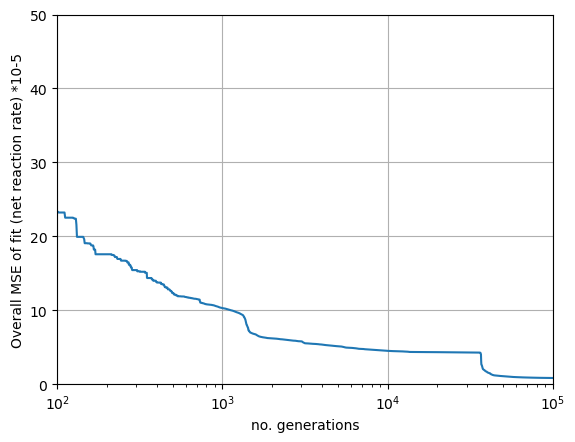

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.080346220069801
1.4529492136931237
0.7701530435122298
-4.095511042573403
0.46673158338573584
5.264507400506084e-06
0.39029092377959096
-5.158748368771213
0.3751788627626239
5.194326951571932
4.042490820528401
4.154436354239374
0.5402270148216803
0.03142296391448837
2.8553301960457285
0.0007710570517172565
0.21809783156178209
-11.741461869053687
1.8537081244355238
1.5602702612874346
-11.29143086907388
1.1632045133413937
3.910958632256511
0.014942648446044477
4.085848871969486
4.55104772816805
1.8000801574473568
9.900002793958556
-8.021415914624404
3.250770643349329
4.474211781515793
3.394898989438265
-4.194797036170838
0.5447195793868428
1.0907985671106164
-1.301029262995075


In [37]:
res.X

array([-1.10803462e+01,  1.45294921e+00,  7.70153044e-01, -4.09551104e+00,
        4.66731583e-01,  5.26450740e-06,  3.90290924e-01, -5.15874837e+00,
        3.75178863e-01,  5.19432695e+00,  4.04249082e+00,  4.15443635e+00,
        5.40227015e-01,  3.14229639e-02,  2.85533020e+00,  7.71057052e-04,
        2.18097832e-01, -1.17414619e+01,  1.85370812e+00,  1.56027026e+00,
       -1.12914309e+01,  1.16320451e+00,  3.91095863e+00,  1.49426484e-02,
        4.08584887e+00,  4.55104773e+00,  1.80008016e+00,  9.90000279e+00,
       -8.02141591e+00,  3.25077064e+00,  4.47421178e+00,  3.39489899e+00,
       -4.19479704e+00,  5.44719579e-01,  1.09079857e+00, -1.30102926e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.080346220069801
1.6: 1.4529492136931237
0.9: 0.7701530435122298
-4.3: -4.095511042573403
0.5: 0.46673158338573584
0.003: 5.264507400506084e-06
0.4: 0.39029092377959096
-7.9: -5.158748368771213
0.7: 0.3751788627626239
7.2: 5.194326951571932
5.7: 4.042490820528401
5.7: 4.154436354239374
0.8: 0.5402270148216803
0.03: 0.03142296391448837
3.1: 2.8553301960457285
6.000000000000001e-09: 0.0007710570517172565
0.1: 0.21809783156178209
-12.0: -11.741461869053687
1.9: 1.8537081244355238
1.6: 1.5602702612874346
-11.6: -11.29143086907388
1.2: 1.1632045133413937
4.0: 3.910958632256511
0.01: 0.014942648446044477
4.2: 4.085848871969486
5.4: 4.55104772816805
2.2: 1.8000801574473568
11.8: 9.900002793958556
-12.0: -8.021415914624404
3.3: 3.250770643349329
1.8: 4.474211781515793
4.2: 3.394898989438265
-4.0: -4.194797036170838
0.5: 0.5447195793868428
1.0: 1.0907985671106164
coeff fit: 0.9556261794084135
r: 0.9775613430411483
